In [ ]:
# finetuning llama2

# (Q)分子構造+(R)理由+(A)物性データセットのLLMによる学習と予測
- Q&A: 融点データセットを使用
- R: GPT4を使い､Q&Aをもとに自動生成
- 強化学習をしてみる

In [ ]:
#!pip install transformers==4.35.0
#!pip install peft==0.5.0
#!pip install bitsandbytes==0.41.1
#!pip install accelerate==0.23.0
#!pip install flash-attn==2.3.1.post1
#!pip install datasets==2.14.5

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer,pipeline
from datasets import Dataset
import copy
from tqdm import tqdm
#問題設定: はじめのN件をテストデータにする
n_test=50

/home/setup/miniconda3/envs/chemllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#ハイパラ関連
#モデル名
model_size=7
#model_size=13
#model_size=70
model_name=f"meta-llama/Llama-2-{model_size}b-chat-hf"

#LoRA関連
r=32
lora_alpha=r
bit=16
#bit=8
#bit=4

#LoRAのadapter
target_modules= [
    #"embed_tokens",
    "lm_head",
    #"q_proj",
    #"k_proj",
    "v_proj",
    "o_proj",
    "gate_proj",
    "up_proj",
    #"down_proj",
]

#学習関連
#gradient_checkpointing =True  #vramの節約をしたい場合
gradient_checkpointing =False
per_device_train_batch_size=1
epochs=3
lr=10**-5
do_train=True
#do_train=False

In [3]:

device_map="auto"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

def init_model(model_name, r, lora_alpha, target_modules, bit=4):
    if bit == 4:
        print("Using 4-bit mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     quantization_config=bnb_config,
                                                     device_map=device_map,
                                                     use_flash_attention_2=True,
                                                     )
    elif bit == 8:
        print("Using 8-bit mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     load_in_8bit=True,
                                                     device_map=device_map,
                                                     use_flash_attention_2=True,
                                                     )
    elif bit == 16:
        print("Using fp16 mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     device_map=device_map,
                                                     torch_dtype=torch.float16,
                                                     use_flash_attention_2=True,
                                                     )
    else:
        raise ValueError("bit must be 4 or 16")

    if len(target_modules)==0:
        return model
    peft_config = LoraConfig(
        task_type="CAUSAL_LM", inference_mode=False, r=r, lora_alpha=lora_alpha,
        lora_dropout=0.1,
        target_modules=target_modules,
    )
    model = get_peft_model(model, peft_config)
    return model


In [ ]:

#モデル初期化
model=init_model(model_name, r, lora_alpha, target_modules, bit=bit)

In [4]:


tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

#pipe = pipeline("text-generation", model=model,
#                tokenizer=tokenizer, max_new_tokens=1000)

# データセットの生成

In [5]:
#データセットの読み込み
import pandas as pd
import random
df=pd.read_csv("dataset/231225AutoReasoning/240104best_reason_record.csv")
dataset=df.to_dict(orient="records")
random.seed(0)
random.shuffle(dataset)

print(df.shape)
df[:2]

(2406, 9)


,name,smiles,csid,link,source,Reason,mpC,Prediction(integer),Abs error
0,"2,3-dibromo-2-methyl-butane",BrC(C)(C)C(Br)C,71392,http://www.srcinc.com/what-we-do/product.aspx?...,PHYSPROP,"Starting with butane, which melts around -138....",7.0,6.6,0.4
1,5-chlorobenzofuroxan,c1cc2c(cc1Cl)no[n+]2[O-],123661,http://www.alfa.com/en/GP100W.pgm?DSSTK=A14261,Alfa Aesar,"The basic structure for comparison is benzene,...",47.0,45.0,2.0


In [6]:
import random
system_prompt="You are a professional chemist. Predict the melting point of the following compound."


def gen_compound_text(chemical_record,
    reason="",prediction=""):
    name=chemical_record["name"]
    smiles=chemical_record["smiles"]
    prompt=f"""
#Problem
##Name: {name}
##SMILES: {smiles}"""
    if reason !="" and prediction!="":
        prompt+=f"""
##Reason: {reason}
##Prediction: {prediction}
"""
    else:
        #test mode
        prompt+="""
##Reason: 
"""
    return prompt



def generate_question_prompt(dataset,test_id,n_prompt_examples=5):
    train_ids=[i for i in range(len(dataset))]
    train_ids.remove(test_id)
    prompt=""

    #train prompt
    for _ in range(n_prompt_examples):
        id=random.choice(train_ids)
        prompt+=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
        prompt+="\n"

    #test prompt
    prompt+=gen_compound_text(dataset[test_id])

    return prompt


def prepare_dataset(context_list, tokenizer):
    data_list = [{"text": i} for i in context_list]
    random.shuffle(data_list)

    # tokenize
    dataset = Dataset.from_dict(
        {"text": [item["text"] for item in data_list[:]]})
    dataset = dataset.map(lambda samples: tokenizer(
        samples['text']), batched=True)

    return dataset


In [7]:


train_text_list=[]
for id in range(len(dataset)):
    prompt=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
    train_text_list.append(prompt)
tokenized_dataset = prepare_dataset(train_text_list[n_test:], tokenizer)

Map: 100%|██████████| 2356/2356 [00:00<00:00, 9278.67 examples/s]


In [8]:
#check prompt

print("train")
print(prompt)
print("test")
t_prompt=gen_compound_text(dataset[0])
print(t_prompt)

train

#Problem
##Name: 2-Ethoxy-2-methylpropane
##SMILES: CC(C)(C)OCC
##Reason: The target compound, 2-Ethoxy-2-methylpropane, can be seen as derived from propane, which has a melting point of -187.7°C. Adding a methyl group generally increases the melting point due to increased molecular weight and van der Waals forces. For propane, adding a methyl group to become isobutane elevates the melting point to -159.6°C, indicating the effect of a methyl group is an increase of roughly +28°C. The presence of an ethoxy group (-OCC2H5) introduces an oxygen atom which can lead to dipole-dipole interactions and potential hydrogen bonding with trace moisture, increasing the melting point as well. The ethoxy group's effect on the melting point would be less straightforward to quantify without empirical data, but we can predict that it will raise the melting point to some extent. Considering the combined effect of an additional methyl group and an ethoxy group on the basic structure of propane, we 

# モデルの訓練

In [ ]:
import transformers
from datetime import datetime


#train
train_args = transformers.TrainingArguments(
        per_device_train_batch_size=per_device_train_batch_size,
        #gradient_accumulation_steps=1,
        warmup_steps=0,
        num_train_epochs=epochs,
        learning_rate=lr,
        fp16=True,
        logging_steps=100,
        save_total_limit=1,
        output_dir='outputs/'+datetime.now().strftime('%Y%m%d%H%M%S'),
        gradient_checkpointing=gradient_checkpointing,
    )

# trainer
#callbacks = [EarlyStoppingCallback()]
callbacks = []

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_dataset,
    args=train_args,
    callbacks=callbacks,
    data_collator=transformers.DataCollatorForLanguageModeling(
        tokenizer, mlm=False)
)

if do_train:
    training_result = trainer.train()
    training_result.training_loss

In [9]:
#モデルの保存: adapterのみ保存するとき｡
from datetime import datetime
current_datetime = datetime.now()
#model.save_pretrained(f"./outputs/{current_datetime}")
#model.save_pretrained(f"./outputs/7b_ft")

In [10]:
#モデルの読み込み: 強化学習しない場合
from peft import AutoPeftModelForCausalLM
model_path="./outputs/7b_ft"

"""
model = AutoPeftModelForCausalLM.from_pretrained(model_path,
                                                 device_map=device_map,
                                                     torch_dtype=torch.float16,
                                                     use_flash_attention_2=True,
                                                 )

"""

'\nmodel = AutoPeftModelForCausalLM.from_pretrained(model_path,\n                                                 device_map=device_map,\n                                                     torch_dtype=torch.float16,\n                                                     use_flash_attention_2=True,\n                                                 )\n\n'

In [11]:
#モデルのマージと保存: 強化学習するとき
#merged_model = model.merge_and_unload()
#merged_model.save_pretrained(f"./outputs/7b_ft_merge")

# 強化学習による追加訓練

In [12]:
#予測周りのutility funcs
import re
import torch
import gc
from IPython.display import clear_output
from trl import AutoModelForCausalLMWithValueHead
def gen_text_stop_word(prompt,model,tokenizer,
                       device="cuda:0",
                       stop_words=["#Problem","#Reason","# Problem"],
                       double_stop_words=["#Prediction"],
                       stream=False,
                       #stream=True,
                       max_tokens=400,
                       ):
    gc.collect()
    torch.cuda.empty_cache()



    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    # 生成されたテキストを格納する変数
    generated_text = ""

    # トークンを一つずつ生成
    for i in range(max_tokens):
        # 次のトークンを予測
        outputs = model(input_ids)
        if type(model) is AutoModelForCausalLMWithValueHead:
            #AutoModelForCausalLMWithValueHeadの場合
            logits = outputs[0]
            next_token_logits = logits[:, -1, :]
        else:
            next_token_logits = outputs.logits[:, -1, :]

        next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)

        # 生成されたトークンを現在の入力に追加
        input_ids = torch.cat([input_ids, next_token], dim=-1)

        # 生成されたテキストを更新
        generated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)[len(prompt):]

        if stream:
            if i%30==0:
                clear_output()
            print(generated_text)

        # ストップワードのチェック
        if any(stop_word in generated_text for stop_word in stop_words):
            break

        # 2回以上出現したらstopするwordのcheck 
        stop_flag=False
        for check_word in double_stop_words:
            count=generated_text.count(check_word)
            if count>=2:
                stop_flag=True
                break
        if stop_flag:
            break

    return generated_text

def ask_value(prompt,model,tokenizer):
    res=gen_text_stop_word(prompt,model,tokenizer)
    #res=pipe(prompt)[0]["generated_text"]
    print("----\n\n")
    print(res.strip())

    regex_list=[
        r"Prediction:\s*(\d+\.?\d*)",
        r"Prediction:\s*(-?\d+\.?\d*)",
    ]

    value=None
    for reg in regex_list:
        match = re.search(reg, res)
        if match:
            value = match.group(1)
            break


    return res,value



In [13]:
from trl import PPOTrainer, PPOConfig


#テキストでファインチューニングしたモデルを強化学習用に読み込み

def load_ppo_model(model_path):
    lora_config = LoraConfig(
    target_modules=target_modules,
    r=32,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    )
    model = AutoModelForCausalLMWithValueHead.from_pretrained(
        model_path,
        #load_in_8bit=True,
        torch_dtype=torch.float16,
        device_map=device_map,
        peft_config=lora_config,
    )
    return model

def init_ppo_trainer(model,tokenizer):

    #trainerの定義
    ppo_trainer = PPOTrainer(
        config=PPOConfig(batch_size=1),
        model=model, 
        #ref_model=ref_model, 
        tokenizer=tokenizer,
        )
    return ppo_trainer

def reload_ppo_model_and_trainer(model,ppo_trainer,temp_dir="outputs/temp"):
    #model.to("cuda:0")
    model.save_pretrained(temp_dir)

    model=None
    ppo_trainer=None
    print("clearing memory...")
    gc.collect()
    torch.cuda.empty_cache()

    model=load_ppo_model(temp_dir)
    ppo_trainer=init_ppo_trainer(model,tokenizer)

    return model,ppo_trainer


In [14]:

#報酬クラスの定義
class RewardModel:
    def __init__(self,model,dataset,tokenizer,
                 range_value=1,
                 reward_slope=50,
                 n_prompt_examples=3,
                 device="cuda:0",
                 ):
        self.model=model
        self.dataset=dataset
        self.tokenizer=tokenizer    
        self.n_prompt_examples=n_prompt_examples
        self.range_value = range_value
        self.reward_slope = reward_slope
        self.device=device

    def calculate_reward(self,abs_error, ):
        """
        Calculate the reward based on the absolute error.

        :param abs_error: The absolute error value.
        :param range_value: The range value for maximum and minimum rewards.
        :return: The calculated reward.
        """

        reward = self.range_value - (abs_error) * (self.range_value / self.reward_slope)
        return max(reward, -self.range_value)


    def __call__(self,train_id):
        prompt=generate_question_prompt(self.dataset,train_id,
                                        n_prompt_examples=self.n_prompt_examples)
        reason,value=ask_value(prompt,self.model,self.tokenizer,
                                         )

        actual=self.dataset[train_id]["mpC"]
        if value is None:
            reward=-self.range_value
        else:
            value=float(value)

            abs_error=abs(actual-value)
            # Example usage of the function
            reward=self.calculate_reward(abs_error)  # Example case where abs_error is 12 and range_value is 100

        #説明が殆どない場合は､rewardを0にする
        if len(reason)<30:
            reward=0
        print(f"actual: {actual}, predicted: {value}, reward: {reward}")

        input_ids = tokenizer.encode(prompt, return_tensors='pt').to(self.device)
        return reward,reason,input_ids

In [15]:
#model_path="./outputs/13b_ft_merge_3epoch"
model_path="./outputs/7b_ft_merge_3epoch"
temp_dir="outputs/temp"

#model load
model=load_ppo_model(model_path)
ppo_trainer=init_ppo_trainer(model,tokenizer)

#lora modelとして読み込み直す(vramの節約のため)
model,ppo_trainer=reload_ppo_model_and_trainer(model,ppo_trainer)

Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]
/home/setup/miniconda3/envs/chemllm/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:257: UserWarning: No dataset is provided. Make sure to set config.batch_size to the correct value before training.
  warnings.warn(


clearing memory...


Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


In [16]:

reward_model=None
gc.collect()
torch.cuda.empty_cache()
reward_model = RewardModel(model,dataset,tokenizer,)
reward_model.calculate_reward(30)  #報酬の動作確認. 

0.4

In [17]:
import time
import warnings
warnings.filterwarnings('ignore')
#model.config.use_cache = False 
#model.config.use_cache = True
lr_epochs=5000
n_retry=1
#lr_epochs=3
reward_log=[]

n_iterations=0

for i in tqdm(range(lr_epochs)):
   #ランダムに問題を設定して値を予測させる
    train_id=random.randint(n_test,len(dataset))

    
    #このクラスにgpu cacheが残りがちなので､毎回初期化してメモリ開放しておく
    reward_model=None
    gc.collect()
    torch.cuda.empty_cache()
    reward_model = RewardModel(model,dataset,tokenizer)


    #同じ問題に対して､良い結果が来るまで何回か問題を解かせる
    for i in range(n_retry):
        try:
            #報酬､応答､入力の取得
            reward,response,input_id=reward_model(train_id)
            rewards=[torch.tensor(float(reward))]
            query_tensors = [torch.tensor(input_id).reshape(-1)]
            response_tensors=[torch.tensor(tokenizer.encode(response)).reshape(-1)]

            #モデル更新
            stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
            n_iterations+=1
            reward_log.append(float(reward))
        except Exception as e:
            #主にcuda out of memoryが起きるので､一旦メモリ開放して､model類を読み込み直す
            print(e)
            model,ppo_trainer=reload_ppo_model_and_trainer(model,ppo_trainer)

            break

        #結果がよかったら次の問題に移る
        if reward>0.5:
            break

n_iterations

  0%|          | 0/5000 [00:00<?, ?it/s]You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


----


The compound in question is a complex molecule with several functional groups that influence its melting point. 1) The basic unit, heptadienone, has a melting point of 22°C. 2) The presence of a semicarbazone group (NN=C) introduces the possibility of hydrogen bonding, which significantly increases the melting point; we estimate this effect to be around +100. 3) The methyl group (CH3) attached to the double bond (C=C) adds steric bulk and increases the molecular weight, estimated to be +5. 4) The additional double bond (C=C) adds rigidity to the molecule, estimated to be +5. Base molecule heptadienone has a melting point of 22°C for reference. Adding up these contributions, we get a predicted melting point shift of +120 (100+5+5) compared to the base heptadienone's melting point.
##Prediction: 142.0


#Prediction
actual: 136.0, predicted: 142.0, reward: 0.88


  0%|          | 1/5000 [00:36<51:06:13, 36.80s/it]

----


The compound b-erythroidine has several functional groups that influence its melting point. The basic structure is derived from naphthalene, which has a melting point of 80°C. The presence of a ketone (C=O) group typically increases the melting point due to the polarity it introduces, which enhances the dipole-dipole interactions, let's say in the order of +20°C for the influence of such a group. The presence of a hydroxyl group (OH) can lead to hydrogen bonding, which usually has a significant effect on increasing the melting point, approximately +40°C in the context of naphthalene derivatives due to hydrogen bonding. The compound also has multiple aromatic rings, which will further favor a higher melting point due to the increased stability and pi-stacking interactions, but because these are already accounted for with the baseline of naphthalene, we will consider them as part of the initial value rather than an additional increase. The presence of a bicyclic structure (b-eryth

  0%|          | 2/5000 [01:33<67:15:46, 48.45s/it]

----


The compound in question is a complex molecule with several functional groups that influence its melting point. The base molecule for comparison is benzene, which has a melting point of 5.5 degrees Celsius. The presence of a nitro group generally increases the melting point due to its strong electron-withdrawing nature and the potential for intermolecular hydrogen bonding: +50. The tetramethylcyclopentyl group is a bulky and rigid structure that increases the melting point due to increased van der Waals forces: +30. The ester group contributes to the melting point through dipole-dipole interactions: +20. The Predicted value takes into account the cumulative effect of these functional groups on the melting point.
##Prediction: 155.0


#Prediction
actual: 95.0, predicted: 155.0, reward: -0.19999999999999996


  0%|          | 3/5000 [02:05<56:36:40, 40.78s/it]

----


- Basic cyclohexane has a melting point of 6.5 °C. 
- The presence of an ester group (carboxylic acid ester) generally increases the melting point due to the ability to form dipole-dipole interactions and potential hydrogen bonding. This could add approximately +40 to the melting point. 
- The trans configuration of the molecule may slightly increase the melting point due to the more rigid structure. This could add +5. 
- The presence of an ethyl group adds steric bulk and can slightly increase the melting point, estimated at +5. 
By summing up these effects, we can predict the compound's melting point.
##Prediction: 56.0


#Prediction
actual: 50.0, predicted: 56.0, reward: 0.88


  0%|          | 4/5000 [02:51<59:29:19, 42.87s/it]

----


The compound in question is a bicyclic compound with a bicyclo[3.2.1]octane core and an imine group. The bicyclic structure generally increases the melting point due to increased rigidity and planarity, which can be estimated at +50°C. The imine group introduces the possibility of hydrogen bonding, which can further increase the melting point; this effect can be estimated at +30°C. The presence of two methyl groups on the bicyclic ring might slightly increase the melting point due to increased molecular weight and van der Waals interactions; this effect can be estimated at +5°C for each methyl group.
##Prediction: 105.0


#Prediction
actual: 146.0, predicted: 105.0, reward: 0.17999999999999994


  0%|          | 5/5000 [03:24<54:35:22, 39.34s/it]

----


##Prediction: 100.0


#Prediction
actual: 200.0, predicted: 100.0, reward: -1.0


  0%|          | 6/5000 [03:29<38:25:17, 27.70s/it]

----


The basic unit for comparison is cyclohexane, which has a melting point of 6.5 °C. The compound in question has several functional groups that influence the melting point: 
- The presence of a ketone group (C=O) generally increases the melting point due to the potential for hydrogen bonding and dipole-dipole interactions, estimated at +20 °C. 
- The presence of two methyl groups (CH3) attached to the bicyclic structure increases the molecular weight and provides steric hindrance, which can increase the melting point, estimated at +10 °C for each methyl group. 
- The oxime group (C=NOH) is capable of hydrogen bonding, which can significantly increase the melting point, estimated at +30 °C. 
- The bicyclic structure itself contributes to the rigidity of the molecule, which can increase the melting point, estimated at +10 °C. 
Adding these adjustments together gives an estimated cumulative increase of +70 °C.
##Prediction: 75.5


#Prediction
actual: 164.0, predicted: 75.5, reward: 

  0%|          | 7/5000 [04:17<47:41:48, 34.39s/it]

----


The compound in question is a peroxide with two phenyl rings and an ethyl side chain. The basic unit we can consider is benzene, which has a melting point of 5.5 degrees Celsius. The presence of the peroxide group significantly increases the melting point due to strong intermolecular hydrogen bonding and the rigidity of the molecule; this could add approximately +150 degrees Celsius. The two phenyl rings add to the molecular rigidity and pi-pi stacking interactions, which would increase the melting point by another +50 degrees Celsius. The ethyl side chain adds some steric bulk, but it does not contribute significantly to intermolecular forces, so its effect is relatively small; we can estimate this at +5 degrees Celsius.
##Prediction: 210.0


#Prediction
actual: 40.6, predicted: 210.0, reward: -1


  0%|          | 8/5000 [04:51<47:31:39, 34.27s/it]

----


The compound metolazone has several functional groups that influence its melting point. Starting with a base structure similar to pyridine, which has a melting point of 23°C, we can consider the following adjustments: 
 - Chlorophenyl group: +20°C due to increased molecular weight and pi-pi interactions. 
 - Nitro group: +30°C due to strong dipole and potential for intermolecular hydrogen bonding. 
 - Sulfonyl group: +25°C due to strong dipole and potential for intermolecular hydrogen bonding. 
 - Amide group: +30°C due to strong dipole and potential for hydrogen bonding. 
 - Ether linkage: +5°C due to increased molecular weight and van der Waals interactions. 
 - Methyl group: +5°C due to increased molecular weight and van der Waals interactions. 
 - Sulfone group: +10°C due to strong dipole and potential for intermolecular hydrogen bonding. 
 - Phenyl group: +10°C due to increased molecular weight and pi-pi interactions. 
The total predicted adjustment is 205°C, which is close

  0%|          | 9/5000 [06:27<74:11:50, 53.52s/it]

----


##Prediction: 200.0


#Prediction
actual: 234.75, predicted: 200.0, reward: 0.30499999999999994


  0%|          | 10/5000 [06:30<52:25:15, 37.82s/it]

----


The base structure, propane, has a melting point of -188.4°C. The presence of fluorine atoms in the compound significantly increases the melting point due to the strong electronegativity of fluorine and the resulting dipole-dipole interactions. Each fluorine atom can be estimated to increase the melting point by approximately +20 degrees Celsius. The iodine atom also increases the melting point due to its large atomic size and the induction of dipole-dipole interactions; this can be estimated to add around +50 degrees Celsius. However, the actual value is significantly higher than the predicted value, indicating that the effects of the fluorine and iodine atoms are not additive. The actual value suggests that the compound's melting point is influenced by the presence of these substituents in a way that is not captured by the additive effects.
##Prediction: 108.0


#Prediction
actual: -95.0, predicted: 108.0, reward: -1


  0%|          | 11/5000 [07:06<51:58:32, 37.51s/it]

----


The compound in question has several functional groups that influence its melting point. Starting with a base structure of benzene, which has a melting point of 5.5°C, we consider the following contributions: The thiazole ring (s-triazine) is a rigid and planar system that can increase the melting point significantly, estimated at +50°C. The pyridine ring contributes to the rigidity and planarity of the molecule, adding approximately +20°C. The hydrazono group can form hydrogen bonds, which typically increases the melting point by about +30°C. The amide group can form strong intermolecular hydrogen bonds, which can significantly increase the melting point, estimated at +50°C. The presence of an ethylamino group (N-CH2CH3) introduces some flexibility to the molecule, which might slightly decrease the melting point, estimated at -5°C. The overall rigidity and planarity of the molecule due to the heteroaromatic systems and the presence of multiple functional groups contribute to a 

  0%|          | 12/5000 [08:10<62:51:22, 45.37s/it]

----


##Prediction: 105.0


#Prediction
actual: 110.0, predicted: 105.0, reward: 0.9


  0%|          | 13/5000 [08:14<45:29:16, 32.84s/it]

----


The base structure of undecafluoro-3-trifluoromethyl-pentane is a fluorinated pentane, which has a melting point significantly lower than that of a non-fluorinated pentane due to the electronegative fluorine atoms that disrupt the crystal lattice. Each fluorine atom contributes to a lower melting point due to its electronegativity and the resulting dipole-dipole interactions. The trifluoromethyl group is a polar group that can participate in dipole-dipole interactions, but its effect on the melting point is less pronounced than that of fluorine atoms. The presence of multiple fluorine atoms and the trifluoromethyl group will lower the melting point.
##Prediction: -105.0


#Prediction
actual: -115.0, predicted: -105.0, reward: 0.8


  0%|          | 14/5000 [08:53<48:12:28, 34.81s/it]

----


The base structure of 1,2-butyleneoxide is a simple alkene with a melting point of -100°C. The addition of a hydroxyl group (OH) to the alkene typically raises the melting point due to the possibility of hydrogen bonding. We estimate this increase to be around +50°C.
##Prediction: 50.0


#Prediction
actual: -150.0, predicted: 50.0, reward: -1


  0%|          | 15/5000 [09:07<39:29:42, 28.52s/it]

----


The compound in question is a steroid with multiple functional groups that influence its melting point. The base structure is cholesterol, which has a melting point of 145°C. The functional groups present in the target compound include hydroxyl groups, a ketone, and a double bond. Each hydroxyl group can be expected to increase the melting point by approximately +20°C due to hydrogen bonding, while the ketone might add around +10°C due to polar interactions. The double bond might contribute an additional +5°C due to rigidity and planarity of the molecule. However, the presence of multiple hydroxyl groups and the ketone could lead to a synergistic effect, potentially raising the melting point by more than the sum of their individual contributions.
##Prediction: 180.0


#Prediction
actual: 220.0, predicted: 180.0, reward: 0.19999999999999996


  0%|          | 16/5000 [09:42<42:00:36, 30.34s/it]

----


##Prediction: 120.0


#Prediction
actual: 189.75, predicted: 120.0, reward: -0.395


  0%|          | 17/5000 [09:47<31:42:03, 22.90s/it]

----


The compound 1,3-dino2 2-Cl 5-CF3 benzene consists of a benzene ring with several substituents. The basic unit, benzene, has a melting point of 5.5 degrees Celsius. The following adjustments are made for the substituents:
- The nitro group (NO2) is a strong electron-withdrawing group, which can increase the melting point due to the polar nature and potential for intermolecular hydrogen bonding. This could add approximately +40 degrees Celsius.
- The chloro group (Cl) is also electron-withdrawing and increases the melting point due to its polarity and the potential for dipole-dipole interactions. This could add approximately +20 degrees Celsius.
- The trifluoromethyl group (CF3) is highly electronegative and increases the melting point due to its polarity and the potential for dipole-dipole interactions. This could add approximately +30 degrees Celsius.
- The 1,3-dioxo group (dino) is a polar and rigid structure that can increase the melting point due to its ability to stack and 

  0%|          | 18/5000 [10:51<48:41:52, 35.19s/it]

----


The target compound, 3,3-dimethylbutyric acid, consists of a butyric acid core with two methyl groups attached to the carboxyl group. The basic butyric acid has a melting point of around -10°C. The methyl groups increase the molecular weight and size, which typically raises the melting point due to increased London dispersion forces. Each methyl group can be estimated to add approximately +5°C to the melting point. The carboxyl group is capable of forming strong intermolecular hydrogen bonds, which significantly increases the melting point. The presence of two methyl groups and the carboxyl group can be expected to increase the melting point by approximately +10°C due to the additional hydrogen bonding and steric hindrance.
##Prediction: -10.0

##Prediction
actual: 6.0, predicted: -10.0, reward: 0.6799999999999999


  0%|          | 19/5000 [11:26<48:43:53, 35.22s/it]

----


The base structure of pyridine has a melting point of 10°C. The carboxaldoxime group is a polar functional group that can form hydrogen bonds, which typically increases the melting point. The effect of the carboxaldoxime group can be estimated at +40°C due to its ability to form strong intermolecular hydrogen bonds.
##Prediction: 50.0


#Prediction
actual: 132.0, predicted: 50.0, reward: -0.6400000000000001


  0%|          | 20/5000 [11:45<41:59:05, 30.35s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The presence of the nikethamide group introduces several functional groups that influence the melting point. The amide group (–CONH–) is capable of strong hydrogen bonding, which significantly increases the melting point. We can estimate this effect to be around +100°C. The presence of the methyl groups (–CH3–) adds to the molecular weight and van der Waals forces, which would increase the melting point by about +20°C for each methyl group. There are two methyl groups in the compound. The nitrogen atom in the amide group can also participate in hydrogen bonding, which would further increase the melting point. We can estimate this effect to be around +10°C. The cumulative effect of these groups on the melting point would be the sum of the individual contributions.
##Prediction: 135.0


#Prediction
actual: 25.0, predicted: 135.0, reward: -1


  0%|          | 21/5000 [12:34<49:36:41, 35.87s/it]

----


##Prediction: 105.0


#Prediction
actual: -24.0, predicted: 105.0, reward: -1


  0%|          | 22/5000 [12:37<36:01:51, 26.06s/it]

----


The compound permethrin is a complex organic molecule with multiple functional groups that influence its melting point. The base structure is a bicyclic compound with a chlorine atom attached to one of the rings. The presence of chlorine generally increases the melting point due to its electronegativity and the ability to participate in dipole-dipole interactions. The bicyclic structure provides rigidity, which tends to increase melting point. The ester group (carboxylate) contributes to both an increase and decrease in melting point due to dipole-dipole interactions and steric hindrance, respectively. The presence of multiple methyl groups also increases the molecular weight and steric hindrance, which might decrease the melting point. The combined effects of these substituents must be considered for the prediction.
- Chlorine: +10 (due to electronegativity and dipole-dipole interactions) 
- Ester group: +5 to -5 (dipole-dipole interactions and steric hindrance) 
- Methyl group

  0%|          | 23/5000 [13:49<54:53:44, 39.71s/it]

----


The melting point of a compound is influenced by the presence of functional groups and structural features. For 2,3-dimethoxybenzoic acid, we consider the following factors: 
- The carboxylic acid group, with its ability to form strong hydrogen bonds, is expected to significantly increase the melting point. We estimate this increase to be about +100°C to the base structure of benzene, given the dimerization of carboxylic acids which can lead to a relatively high melting point. 
- The two methoxy groups, while they do not drastically change polarity, increase molecular weight and can participate in dipole-dipole interactions, which might raise the melting point by approximately +10°C each. 
Considering these effects, the cumulative estimated effect on melting point for 2,3-dimethoxybenzoic acid is calculated by the sum of these adjustments.
##Prediction: 120.0


#Prediction
actual: 123.0, predicted: 120.0, reward: 0.94


  0%|          | 24/5000 [14:55<65:56:12, 47.70s/it]

----


The basic unit, propane, has a melting point of -187.7 degrees Celsius. The introduction of a methyl group typically increases the melting point by about +20 degrees Celsius due to increased molecular weight and van der Waals interactions. The amide group (-CONH-) can form hydrogen bonds, which significantly increases the melting point. The effect of an amide group is typically around +100 degrees Celsius. Combining these effects, we get an estimate for the melting point of n-methyl propionamide.
##Prediction: 105.0


#Prediction
actual: -30.9, predicted: 105.0, reward: -1


  0%|          | 25/5000 [15:43<66:06:00, 47.83s/it]

----


##Prediction: 170.0


#Prediction
actual: 210.5, predicted: 170.0, reward: 0.18999999999999995


  1%|          | 26/5000 [15:47<47:54:53, 34.68s/it]

----


The compound 2-chloro-2',6'-diethylacetanilide has several functional groups that influence its melting point. The base structure is aniline, which has a melting point of -6 degrees Celsius. The presence of two ethyl groups (C2H5) generally increases the melting point due to increased molecular weight and van der Waals forces, estimated at +10 degrees each. The chlorine atom (Cl) is a heavy halogen that can increase the melting point due to its high electronegativity and the resulting dipole-dipole interactions, estimated at +15 degrees. The acetamide group (C=O-NH) is capable of hydrogen bonding, which significantly raises the melting point, estimated at +30 degrees. The presence of two acetyl groups (C=O) attached to the aniline ring also increases the melting point due to the potential for additional dipole-dipole interactions and possible hydrogen bonding, estimated at +10 degrees each.
##Prediction: 106.0


#Prediction
actual: 130.0, predicted: 106.0, reward: 0.52


  1%|          | 27/5000 [16:35<53:18:13, 38.59s/it]

----


The target compound is a polycyclic aromatic hydrocarbon (PAH) with multiple fused rings. The basic unit, benzene, has a melting point of 5.5 °C. The presence of additional fused rings increases the melting point due to the increased rigidity and planarity of the molecule, which can lead to better packing and stronger intermolecular forces. Each additional ring can be estimated to contribute an increase of about +20 °C. The fluorine atom is highly electronegative and introduces dipole-dipole interactions, which can further raise the melting point. We can estimate this effect to be around +10 °C. The overall molecular complexity and the presence of multiple aromatic rings contribute to a higher melting point.
##Prediction: 105.0


#Prediction
actual: 168.0, predicted: 105.0, reward: -0.26


  1%|          | 28/5000 [17:21<56:12:47, 40.70s/it]

----


The base compound for comparison is benzene, which has a melting point of 5.5°C. The presence of a nitro group generally increases the melting point due to its strong electron-withdrawing nature and the potential for intermolecular hydrogen bonding. The bromine atom also increases the melting point due to its large size and the induction of dipole-dipole interactions. The ester group (COO-) generally lowers the melting point due to its ability to participate in dipole-dipole interactions, but it also introduces steric hindrance, which can disrupt crystalline packing. The ester group can be estimated to lower the melting point by about -20°C. The nitro group is a strong electron-withdrawing group and can form hydrogen bonds, which would increase the melting point. We can estimate this effect to be around +30°C. The bromine atom is a large, heavy atom that can participate in dipole-dipole interactions, which would increase the melting point. We can estimate this effect to be aroun

  1%|          | 29/5000 [18:26<66:21:17, 48.05s/it]

----


The compound in question has several functional groups that influence its melting point: 
- The base structure of benzene has a melting point of 5.5 ˚C. 
- The presence of chloro substituents (4) would significantly increase the melting point due to their ability to engage in dipole-dipole interactions and the significant increase in molecular weight. Each chloro substituent can be expected to add around +20 ˚C, giving a total of approximately +80 ˚C from the chloro groups. 
- The presence of a nitrile group (C#N) would increase the melting point due to its polar nature and the potential for hydrogen bonding, estimated at around +15 ˚C. 
- The thiazole ring (N=N) would contribute to the rigidity of the molecule, which increases the melting point, estimated at around +10 ˚C. 
- The fluorophenyl group (F) would increase the melting point due to its electronegativity and the resulting dipole-dipole interactions, estimated at around +5 ˚C. 
- The presence of two azo groups (N=N) wou

  1%|          | 30/5000 [20:02<86:24:47, 62.59s/it]

----


##Prediction: 105.0


#Prediction
actual: 104.0, predicted: 105.0, reward: 0.98


  1%|          | 31/5000 [20:07<62:20:19, 45.16s/it]

----


The basic unit, propane, has a melting point of -187.7 °C. The addition of two bromine atoms significantly increases the melting point due to the large atomic mass and the polarizability of the bromine atoms, which leads to stronger intermolecular forces such as dipole-dipole interactions. Each bromine atom can be estimated to add approximately +40 °C.
##Prediction: 17.0


#Prediction
actual: 10.5, predicted: 17.0, reward: 0.87


  1%|          | 32/5000 [20:28<52:18:19, 37.90s/it]

----


The basic unit, quinoline, has a melting point of 42.0 °C (107.6 °F). The carboxylic acid group is known to significantly increase the melting point due to the ability to form strong intermolecular hydrogen bonds, which can be estimated to add approximately +80°C. The presence of the carboxylic acid group also introduces aromaticity, which can further increase the melting point.
##Prediction: 122.0


#Prediction
actual: 187.0, predicted: 122.0, reward: -0.30000000000000004


  1%|          | 33/5000 [20:49<45:29:24, 32.97s/it]

----


The compound 2-methylnaphtho[2,3-d]oxazole has several functional groups that influence its melting point:
- Basic unit, naphthalene, has a melting point of 80°C.
- Methyl group: This group typically increases the melting point by about 5°C due to an increase in molecular weight and van der Waals forces.
- Oxazole ring: The nitrogen and oxygen atoms in the ring introduce polarity and potential for hydrogen bonding, which can significantly increase the melting point. We can estimate an increase of about 30°C for the oxazole ring.
- The presence of the naphthalene and oxazole rings together in a fused system would lead to a higher melting point due to the rigidity and planarity of the structure, which can be estimated at an additional 20°C.
##Prediction: 130.0


#Prediction
actual: 87.0, predicted: 130.0, reward: 0.14


  1%|          | 34/5000 [21:42<53:40:21, 38.91s/it]

----


The basic unit for sulfapyridine is benzene, which has a melting point of 5.5°C. The presence of a sulfonyl group (S(=O)2) significantly increases the melting point due to its ability to form strong intermolecular interactions such as dipole-dipole forces and possible hydrogen bonding; this could be estimated to add +80°C. The amide group (CONH) also contributes to the melting point due to its ability to form hydrogen bonds and its resonance stability; this could be estimated to add +40°C. The presence of two phenyl rings adds to the rigidity and planarity of the molecule, which can increase the melting point; this could be estimated to add +20°C.
##Prediction: 155.0


#Prediction
actual: 191.0, predicted: 155.0, reward: 0.28


  1%|          | 35/5000 [22:13<50:31:53, 36.64s/it]

----


##Prediction: 105.0


#Prediction
actual: 129.0, predicted: 105.0, reward: 0.52


  1%|          | 36/5000 [22:16<36:37:57, 26.57s/it]

----


The compound 2-amino-5-ethylthio-1,3,4-thiadiazole has several functional groups that influence its melting point: 
- Basic thiadiazole ring: The nitrogen and sulfur atoms in the ring contribute to a higher melting point due to the potential for hydrogen bonding and dipole-dipole interactions. This could add approximately +50°C. 
- Amino group: The amino group can form hydrogen bonds, which would significantly raise the melting point. This could add approximately +80°C. 
- Ethyl group: The ethyl group increases the molecular weight and provides some van der Waals interactions, which might contribute to an increase in melting point. This could add approximately +5°C. 
- Thio group: The sulfur atom in the thio group can engage in dipole-dipole interactions, but its effect on the melting point is less pronounced than that of the amino or ethyl groups. This might add approximately +10°C. 
The combined effect of these groups would be: Basic thiadiazole ring: +50°C, Amino group: +80°C

  1%|          | 37/5000 [24:05<70:26:25, 51.10s/it]

----


- Basic unit, decane: 5.5°C (as a reference for the melting point of a similar hydrocarbon chain)
- Nitrile group (cyano): +20°C (due to the polar nature and potential for dipole-dipole interactions)
##Prediction: 25.5


#Prediction
actual: -17.9, predicted: 25.5, reward: 0.132


  1%|          | 38/5000 [24:20<55:35:23, 40.33s/it]

----


The compound 4-chloro-2-methylbenzoic acid has several functional groups that influence its melting point. Starting with benzene, which has a melting point of 5.5 degrees Celsius, we consider the effects of the functional groups:
1. The carboxylic acid group (COOH) is capable of strong hydrogen bonding, which significantly increases the melting point. This effect can be estimated at +100 degrees Celsius.
2. The chlorine atom is a heavy halogen that increases the molecular weight and polarizability, which can lead to a higher melting point. The effect of chlorine might be around +20 degrees Celsius.
3. The methyl group (CH3) adds steric bulk and slightly increases the molecular weight, which could contribute to a higher melting point, estimated at +5 degrees Celsius.
4. The presence of the ester group (COOCH3) can also increase the melting point due to dipole-dipole interactions, but the effect is less pronounced than that of the carboxylic acid group. This might be around +10 de

  1%|          | 39/5000 [25:13<60:56:51, 44.23s/it]

----


- Basic unit, benzene, has a melting point of 5.5 °C. 
- The presence of the hydrazono group, which can form hydrogen bonds, increases the melting point. Estimated effect: +20 °C.
- The carbamothioyl group, which is a combination of a thioether and an amide, increases the melting point due to the potential for hydrogen bonding and dipole-dipole interactions. Estimated effect: +30 °C.
- The propanamide group, which is an amide connected to a propane chain, increases the melting point due to the potential for hydrogen bonding and dipole-dipole interactions. Estimated effect: +20 °C.
- The presence of the phenyl group increases the melting point due to the increased molecular weight and the possibility of π-π stacking interactions. Estimated effect: +10 °C.

Summing these contributions, we estimate an increase of +70 °C to the baseline melting point of benzene.
##Prediction: 55.0


#Prediction
actual: 212.0, predicted: 55.0, reward: -1


  1%|          | 40/5000 [26:05<64:05:06, 46.51s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The presence of four chlorine atoms on the phenolic ring significantly increases the melting point due to the increased molecular weight and the polarizability of the chlorine atoms, which enhances intermolecular forces. Each chlorine atom can be estimated to increase the melting point by approximately +20°C. The hydroxyl group (-OH) is capable of hydrogen bonding, which further increases the melting point. However, the presence of four chlorine atoms on the ring may disrupt the optimal packing of the molecules, potentially lowering the melting point slightly. - Benzene base: 5.5°C - Chlorine atoms: +20 each (due to increased molecular weight and polarizability) - Hydroxyl group: +10 (due to hydrogen bonding) - Overall, the predicted melting point will be the sum of these effects. 
##Prediction: 105.0


#Problem
actual: 70.0, predicted: 105.0, reward: 0.29999999999999993


  1%|          | 41/5000 [26:50<63:16:41, 45.94s/it]

----


##Prediction: 60.0


#Prediction
actual: -23.0, predicted: 60.0, reward: -0.6600000000000001


  1%|          | 42/5000 [26:54<45:58:19, 33.38s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The introduction of a nitro group significantly increases the melting point due to the strong electron-withdrawing nature of the nitro group, which can form intermolecular hydrogen bonds and increase the rigidity of the molecule (+80). The ethene (vinyl) group adds a small increase due to the introduction of a double bond, which can increase the melting point slightly due to the increased rigidity of the molecule (+5).
##Prediction: 135.0


#Prediction
actual: -10.0, predicted: 135.0, reward: -1


  1%|          | 43/5000 [27:15<40:59:23, 29.77s/it]

----


The base structure of the molecule is androstane, which has a melting point of around 100°C. The presence of a hydroxyl group (OH) generally increases the melting point due to hydrogen bonding, which can be estimated at +20°C. The addition of a methyl group (CH3) adds bulk and increases van der Waals interactions, which might contribute +5°C. The carboxylic acid group (COOH) is capable of forming strong hydrogen bonds, which can significantly raise the melting point, estimated at +40°C. The presence of two double bonds in the molecule may slightly increase the melting point due to the rigidity they provide, estimated at +5°C. However, the overall molecular complexity and potential steric hindrance may slightly decrease the melting point, estimated at -5°C.
##Prediction: 130.0


#Prediction
actual: 264.0, predicted: 130.0, reward: -1


  1%|          | 44/5000 [27:48<42:27:16, 30.84s/it]

----


The basic unit, decane, has a melting point of 17.6°C. The addition of a methyl group to the first carbon of the decane chain typically increases the melting point due to increased molecular weight and van der Waals forces. This effect can be estimated at +5°C.
##Prediction: 22.0


#Prediction
actual: -40.0, predicted: 22.0, reward: -0.24


  1%|          | 45/5000 [28:11<39:00:46, 28.34s/it]

----


The base structure for this compound is butadiene, which has a melting point of 1.5°C. The introduction of a nitrile group (C#N) is known to significantly increase the melting point due to its strong dipole and potential for intermolecular hydrogen bonding, estimated at +50°C. The methoxy group (OCH3) is polar and can increase the melting point through dipole-dipole interactions, estimated at +15°C. The 2-nitrophenyl group is a large, aromatic, and highly polar substituent that can engage in strong intermolecular interactions, such as dipole-dipole interactions and potential hydrogen bonding, estimated at +40°C. The cumulative effect of these groups is additive. However, the actual value of the melting point is 79.0°C, which suggests that the contributions of the functional groups are overestimated.
##Prediction: 79.0


#Prediction
actual: 68.0, predicted: 79.0, reward: 0.78


  1%|          | 46/5000 [28:50<43:23:39, 31.53s/it]

----


##Prediction: 60.0


#Prediction
actual: 28.1, predicted: 60.0, reward: 0.362


  1%|          | 47/5000 [28:54<32:00:50, 23.27s/it]

----


The basic unit for comparison is pyridine, which has a melting point of 10.5. The phenazopyridine molecule has several functional groups that influence its melting point: 
- The presence of two nitrogen atoms in the ring system contributes to the rigidity and potential for hydrogen bonding, which could increase the melting point by approximately +20. 
- The presence of an amine group (NH2) attached to the ring system can form hydrogen bonds, which could increase the melting point by approximately +15. 
- The presence of a phenyl group (C6H5) adds to the molecular weight and can increase the melting point by approximately +10. 
- The presence of a nitrogen atom in the ring system (N) can also contribute to the rigidity and potential for hydrogen bonding, which could increase the melting point by approximately +5. 
Considering these effects cumulatively, we predict a higher melting point than the basic unit.
##Prediction: 100.0


#Prediction
actual: 139.0, predicted: 100.0, reward

  1%|          | 48/5000 [29:46<43:54:26, 31.92s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The presence of two hydroxyl groups (–OH) in resorcinol (1,3-dihydroxybenzene) significantly increases the melting point due to hydrogen bonding. Each hydroxyl group can be estimated to add approximately 40 degrees Celsius to the melting point. The rigidity of the molecule and the potential for intermolecular hydrogen bonding also contribute to a higher melting point.
##Prediction: 90.0


#Prediction
actual: 110.0, predicted: 90.0, reward: 0.6


  1%|          | 49/5000 [30:14<42:26:22, 30.86s/it]

----


The basic unit for comparison could be benzene, which has a melting point of 5.5 °C. The introduction of an iodine atom will significantly increase the melting point due to its large atomic mass and strong electronegativity, which can lead to stronger intermolecular forces such as dipole-dipole interactions. The aldehyde group (-CHO) typically raises the melting point by about +20 to +30 °C due to the polar carbonyl group and the possibility of hydrogen bonding. The methyl group (-CH3) attached to the benzene ring will slightly increase the melting point due to the increase in molecular weight and van der Waals forces, estimated at +5 °C. The iodine atom is bulky and can disrupt the crystal lattice, which might lower the melting point by about -10 to -20 °C. The overall effect of the iodine atom is expected to be a net increase due to its electronegativity and the polarity it introduces, but the disruption to the crystal lattice might slightly counteract this effect.
##Predictio

  1%|          | 50/5000 [30:59<48:10:03, 35.03s/it]

----


The compound in question is a complex molecule with multiple functional groups and structural features that influence its melting point. The basic structure is a tetracyclic dodecahydro-1,10-diene, which has a high melting point due to the rigid and planar structure of the molecule. Each chlorine substituent on the ring system increases the molecular weight and provides additional van der Waals interactions, which would raise the melting point. However, the presence of multiple chlorine atoms also introduces steric hindrance, which can disrupt the crystal packing and potentially lower the melting point. The actual value is lower than the predicted value, indicating that the steric hindrance effect is more pronounced than initially thought.
##Prediction: 100.0

##Prediction
actual: 104.0, predicted: 100.0, reward: 0.92


  1%|          | 51/5000 [31:33<47:33:08, 34.59s/it]

----


The compound in question has several functional groups that influence its melting point: 

- Benzene ring: The base unit has a melting point of 5.5 °C. 
- Bromine atoms: Each bromine atom increases the melting point due to its large size and strong van der Waals interactions; an increase of about 20-30 °C per bromine atom might be estimated.
- Methoxy groups: Each methoxy group can increase the melting point due to its ability to form hydrogen bonds; an estimated increase of 10-15 °C per methoxy group might be reasonable.
- Methyl group: The methyl group slightly increases the melting point due to an increase in molecular weight and van der Waals interactions; an estimated increase of 5-10 °C might be predicted.

The cumulative effect of these groups has to match the actual value.
##Prediction: 190.0


#Prediction
actual: 90.0, predicted: 190.0, reward: -1.0


  1%|          | 52/5000 [32:29<56:18:55, 40.97s/it]

----


##Prediction: 105.0


#Prediction
actual: 59.0, predicted: 105.0, reward: 0.07999999999999996


  1%|          | 53/5000 [32:33<41:10:01, 29.96s/it]

----


##Prediction: 25.0


#Prediction
actual: -43.0, predicted: 25.0, reward: -0.3600000000000001


  1%|          | 54/5000 [32:37<30:34:08, 22.25s/it]

----


- Basic phenyl ring: Benzene's melting point is 5.5°C. Phenyl rings form a rigid structure which contributes to higher melting points. Phenyl itself does not greatly change the melting point, so we start with the benzene value as the base structure.
- Urea group: Urea has a melting point of 130°C due to its ability to form strong hydrogen bonds. The presence of two phenyl rings and the urea group will significantly increase the melting point.
- Ethyl groups: Each ethyl group adds steric bulk and increases the molecular weight, which can slightly increase the melting point. However, the effect of ethyl groups is generally less pronounced than that of aromatic rings or polar functional groups. The influence of each ethyl group might be estimated at +5°C.

Adding these together for all of the present functional group effects: 5.5 (base for benzene) + 130 (urea group) + 10 (two ethyl groups) gives us 145.5°C. Since this initial prediction is below the actual value, additional adjust

  1%|          | 55/5000 [34:45<74:03:20, 53.91s/it]

----


The basic unit, benzene, has a melting point of 5.5 °C. The phenyl group, being a large, rigid, and planar structure, increases the melting point due to increased molecular symmetry and van der Waals interactions, contributing approximately +40 °C. The urea group, being a polar and hydrogen-bonding capable functional group, significantly increases the melting point due to strong intermolecular hydrogen bonding, estimated at +70 °C.
##Prediction: 115.0


#Prediction
actual: 147.0, predicted: 115.0, reward: 0.36


  1%|          | 56/5000 [35:05<59:59:39, 43.69s/it]

----


The basic unit, benzene, has a melting point of 5.5 degrees Celsius. The compound contains a pyridine ring, which is similar to benzene but has a nitrogen atom that can participate in hydrogen bonding, which generally increases the melting point. The presence of a chlorine atom on the pyridine ring is expected to increase the melting point due to the inductive effect and the increase in molecular weight. The thio group (–S–) is less electronegative than chlorine and does not have the same effect on melting point, but it can still increase the melting point due to the polarity it introduces. The presence of two ethyl groups (–CH2CH3) increases the molecular weight and provides van der Waals interactions, which can raise the melting point. The acetyl group (–COCH3) is a polar group that can participate in dipole-dipole interactions, which can also increase the melting point. The cumulative effect of these groups is estimated as follows: Benzene base (5.5) + pyridine ring (increase

  1%|          | 57/5000 [36:20<73:02:56, 53.20s/it]

----


- Base unit, dimethylpentane has a melting point of -94.
- The presence of a hydroxyl group (OH) generally increases the melting point due to hydrogen bonding; estimated effect is +40.
- The presence of two methyl groups on the pentane ring increases the molecular weight and van der Waals interactions; estimated effect for each methyl group is +10.
- The presence of two methyl groups on the pentene ring also increases molecular weight and van der Waals interactions; estimated effect for each methyl group is +10.
- The presence of a methyl group on the hydroxyl group (OH) can slightly increase the melting point due to increased molecular weight; estimated effect is +5.
- The presence of a methyl group on the amine (NH2) can slightly increase the melting point due to increased molecular weight; estimated effect is +5.
Combining these effects in a qualitative manner leads to the predicted melting point.
##Prediction: 79.0


#Prediction
actual: 127.0, predicted: 79.0, reward: 0.0400

  1%|          | 58/5000 [37:00<67:40:31, 49.30s/it]

----


The target compound erythrityl tetranitrate is a complex molecule with multiple functional groups that influence its melting point. The basic units for analysis here are benzene and nitro groups, given the multiple phenyl rings present in the structure. For benzene, the reference melting point is 5.5°C, and for nitro groups, it is -120°C due to the strong electron-withdrawing effect and the potential for intermolecular interactions. Each phenyl ring contributes to an increase in the melting point due to added rigidity and increased molecular interactions such as π-π stacking and potential hydrogen bonding. The presence of nitro groups also increases the melting point due to their strong electron-withdrawing effect and potential for intermolecular interactions. The molecular symmetry and planar structure of erythrityl tetranitrate likely contribute to a more ordered crystal lattice, leading to a higher melting point. Given the structure, a rough estimate for each phenyl group is 

  1%|          | 59/5000 [38:28<83:23:20, 60.76s/it]

----


The target compound has several functional groups that influence its melting point. The base structure is a prop-2-en-1-one, which has a melting point of -87°C. The presence of a furan ring contributes to the melting point due to its aromaticity and potential for hydrogen bonding, estimated to add around +20°C. The presence of two methoxy groups on the benzene ring increases the molecular weight and polarizability, which could contribute an estimated +10°C each. The addition of a furan ring and two methoxy groups should increase the melting point significantly.
##Prediction: 107.0


#Prediction
actual: 145.0, predicted: 107.0, reward: 0.24


  1%|          | 60/5000 [38:54<69:02:01, 50.31s/it]

----


The base structure for comparison is benzene, which has a melting point of 5.5 degrees Celsius. The compound has a bromine atom, which significantly increases the molecular weight and polarizability, and is expected to raise the melting point by approximately +40 degrees Celsius. The presence of a carboxylic acid group introduces strong hydrogen bonding, which significantly increases the melting point. This effect can be estimated at +100 degrees Celsius. The presence of a cinnamic acid moiety adds rigidity and planarity to the molecule, which can increase the melting point by approximately +20 degrees Celsius. However, the bromine atom's ortho position to the carboxylic acid group may slightly reduce the melting point due to steric hindrance, estimated at -5 degrees Celsius.
##Prediction: 175.0


#Prediction
actual: 262.0, predicted: 175.0, reward: -0.74


  1%|          | 61/5000 [39:28<62:16:17, 45.39s/it]

----


The compound in question has several functional groups that influence its melting point:
- The base structure is a propane-1,3-diol, which has a melting point of -100°C.
- The presence of two methoxy groups (OCH3) attached to the phenyl ring will increase the melting point due to the increase in molecular weight and the possibility of hydrogen bonding. Each methoxy group might contribute around +15°C.
- The presence of a phenoxy group (OC(=O)O) will also increase the melting point due to the possibility of hydrogen bonding and dipole-dipole interactions. This group might contribute around +20°C.
- The presence of a trimethoxyphenyl group (OC(=O)OC(=O)O) will further increase the melting point due to the increase in molecular weight and the possibility of hydrogen bonding. This group might contribute around +30°C.
The cumulative effect of these groups on the base melting point of the propane-1,3-diol structure should give us a prediction close to the actual value.
##Prediction: -

  1%|          | 62/5000 [40:20<65:05:16, 47.45s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The base structure is a fused ring system, which typically has a high melting point due to the rigidity of the molecule. The presence of multiple methyl groups and a ketone group will increase the melting point due to increased molecular weight and van der Waals interactions. The oxidized cyclopentane ring and the naphthalene-like structure add to the rigidity and planarity of the molecule, further increasing the melting point. The acetate group is polar and can form dipole-dipole interactions, which would also raise the melting point. However, the presence of multiple bulky substituents may hinder crystal packing, which could slightly lower the melting point.
##Prediction: 170.0


#Prediction
actual: 156.0, predicted: 170.0, reward: 0.72


  1%|▏         | 63/5000 [40:52<58:46:47, 42.86s/it]

----


The base structure of ranimustine is a complex molecule with multiple functional groups that influence its melting point. Starting with the base structure of a steroid, which has a melting point of around 100 degrees Celsius, we consider the effects of the various functional groups. The presence of aromatic rings and the presence of nitrogen and sulfur atoms contribute to the rigidity and planarity of the molecule, which can increase the melting point. The ketone groups (-CO-) and the ester groups (-COO-) can engage in dipole-dipole interactions, which would raise the melting point. The presence of the thioether group (-S-) and the nitro group (-NO2) can also contribute to the melting point through dipole-dipole interactions and potential hydrogen bonding. The presence of the amide group (-CONH-) can engage in hydrogen bonding and dipole-dipole interactions, which would further increase the melting point. The presence of the chloro group (-Cl-) adds to the molecular weight and c

  1%|▏         | 64/5000 [41:48<64:09:45, 46.80s/it]

----


The basic unit for comparison might be benzene, which has a melting point of 5.5°C. The compound 5-(3-trifluoromethoxyphenyl)-1h-tetrazole has several functional groups that affect its melting point. The tetrazole ring itself is known to increase the melting point due to its ability to form strong intermolecular hydrogen bonds, which can be estimated to add approximately +100 to the melting point. The trifluoromethoxy group is a bulky and electron-withdrawing group, which can increase the melting point due to its strong dipole moment and potential for intermolecular interactions, estimated at +30. The phenyl group adds rigidity and pi-pi interactions, which can increase the melting point by about +20. The presence of the tetrazole ring and the trifluoromethoxy group will likely have a synergistic effect, raising the melting point significantly.
##Prediction: 205.0


#Prediction
actual: 158.0, predicted: 205.0, reward: 0.05999999999999994


  1%|▏         | 65/5000 [42:32<62:51:46, 45.86s/it]

----


The target compound is benzoic acid with five fluorine atoms and a tertiary amine group. The basic unit, benzene, has a melting point of 5.5°C. The presence of fluorine atoms significantly increases the melting point due to their strong electronegativity and the ability to form strong dipole-dipole interactions, estimated to be +10°C per fluorine atom. The tertiary amine group can participate in hydrogen bonding, adding approximately +15°C. The carboxyl group in benzoic acid contributes to a higher melting point due to strong hydrogen bonding and dipole-dipole interactions, estimated to be +122°C. The additional methyl group attached to the benzene ring is expected to increase the melting point by about +5°C due to incremental increases in molecular weight and surface area.
##Prediction: 147.0


#Prediction
actual: 200.5, predicted: 147.0, reward: -0.07000000000000006


  1%|▏         | 66/5000 [43:25<65:51:21, 48.05s/it]

----


The basic unit here is benzene, which has a melting point of 5.5°C. The presence of a fluorine atom on the benzene ring increases the melting point due to the high electronegativity of fluorine, which enhances intermolecular forces such as dipole-dipole interactions. The methyl group attached to the benzene ring also increases the melting point due to the increase in molecular weight and van der Waals forces. The alcohol group (OH) can form hydrogen bonds, which significantly increases the melting point. We can estimate that the fluorine atom adds approximately 10°C, the methyl group adds around 5°C, and the alcohol group adds about 40°C.
##Prediction: 70.0


#Prediction
actual: 38.0, predicted: 70.0, reward: 0.36


  1%|▏         | 67/5000 [43:59<59:57:13, 43.75s/it]

----


The compound in question is a bicyclic ketone with several functional groups that influence its melting point. The base structure is a bicyclic compound, which generally has a higher melting point than acyclic compounds due to increased rigidity and potential for π-π interactions. The presence of a hydroxyl group (OH) attached to a phenyl ring can form hydrogen bonds, which significantly increases the melting point. The amino group (NH2) can also form hydrogen bonds, and the methyl groups (CH3) add to the molecular weight and van der Waals interactions. The ketone (C=O) group contributes to polarity and potential for dipole-dipole interactions. The prediction will consider the cumulative effects of these functional groups. 
##Prediction: 120.0


#Prediction
actual: 107.0, predicted: 120.0, reward: 0.74


  1%|▏         | 68/5000 [44:35<56:45:25, 41.43s/it]

----


The compound in question is a complex molecule with several functional groups that influence its melting point. Starting with benzene, which has a melting point of 5.5°C, we consider the effects of the functional groups. The presence of two phenyl rings contributes to an increase in rigidity and aromaticity, which typically raises the melting point. Each phenyl group is estimated to contribute +20°C. The presence of two acetamide groups, which can form hydrogen bonds, significantly increases the melting point. Each acetamide group is estimated to contribute +40°C due to its ability to form strong intermolecular hydrogen bonds. The presence of two hydroxyl groups also contributes to an increase in the melting point through hydrogen bonding. Each hydroxyl group is estimated to contribute +20°C. The presence of an ether linkage between the two phenyl rings and the acetamide groups is expected to have a minor effect on the melting point. However, the overall molecular complexity and

  1%|▏         | 69/5000 [45:46<69:01:23, 50.39s/it]

----


##Prediction: 100.0


#Prediction
actual: 266.5, predicted: 100.0, reward: -1


  1%|▏         | 70/5000 [45:48<49:19:11, 36.01s/it]

----


The compound Clodronate has several functional groups that influence its melting point: a chlorine substituent, a phosphate group, and a phosphorothioate group. The basic unit, chlorobenzene, has a melting point of 5.5°C. The chlorine substituent is a heavy halogen that increases the melting point due to its increased molecular weight and the introduction of stronger intermolecular van der Waals forces, estimated at +80°C. The phosphate group is capable of forming strong hydrogen bonds, which significantly increases the melting point, estimated at +100°C. The phosphorothioate group is similar to the phosphate group but with a sulfur atom instead of oxygen, which may slightly reduce the melting point due to the lesser polarity of sulfur compared to oxygen, estimated at -5°C.
##Prediction: 250.0


#Prediction
actual: 250.0, predicted: 250.0, reward: 1.0


  1%|▏         | 71/5000 [46:26<50:05:46, 36.59s/it]

----


The compound in question is a derivative of hexanoic acid, which has a melting point of -3°C. The presence of two ester groups (C=O) and two ether groups (OC) will significantly affect the melting point. Each ester group can form hydrogen bonds, which would increase the melting point, estimated at +40°C per ester group. The ether groups, while not forming hydrogen bonds, can still participate in dipole-dipole interactions, which would increase the melting point by about +10°C per ether group. The presence of two methyl groups (C(CH3)2) attached to the ester groups will increase the molecular weight and steric hindrance, which could slightly raise the melting point, estimated at +5°C per methyl group.
##Prediction: 105.0


#Prediction
actual: -1.1, predicted: 105.0, reward: -1


  1%|▏         | 72/5000 [47:13<54:12:25, 39.60s/it]

----


The target compound (2Z)-3-(4-hydroxy-3-methoxyphenyl)-2-sulfanylprop-2-enoic acid has several functional groups that influence its melting point. The basic unit we can consider is benzene, which has a melting point of 5.5°C. The presence of a sulfanyl group (S=O) typically increases the melting point due to the polar nature of the sulfur atom and the potential for dipole-dipole interactions. This could add approximately +40°C. The carboxylic acid group (COOH) is capable of forming strong hydrogen bonds, which significantly increases the melting point. This could add approximately +100°C. The hydroxy group (OH) can also form hydrogen bonds, but to a lesser extent than the carboxylic acid. This could add approximately +20°C. The methoxy group (OCH3) is an electron-donating group that can increase the melting point due to the increase in molecular weight and the potential for dipole-dipole interactions. This could add approximately +10°C. The presence of two phenyl rings increases

  1%|▏         | 73/5000 [48:51<78:22:42, 57.27s/it]

----


The compound in question has a naphthalene base structure, which has a melting point of 80.5 °C. The presence of a hydroxyl group (–OH) typically increases the melting point due to hydrogen bonding, estimated at +20 °C. The presence of two aromatic rings (naphthyl) adds to the rigidity and pi-pi stacking, which can increase the melting point by approximately +40 °C. The ketone group (C=O) can form hydrogen bonds, which might contribute an additional +10 °C. However, the presence of the methyl group (–CH3) might slightly lower the melting point due to the increase in molecular weight and steric hindrance, estimated at -5 °C.
##Prediction: 135.0


#Prediction
actual: 132.0, predicted: 135.0, reward: 0.94


  1%|▏         | 74/5000 [49:34<72:26:35, 52.94s/it]

----


##Prediction: 25.0


#Prediction
actual: -81.3, predicted: 25.0, reward: -1


  2%|▏         | 75/5000 [49:37<51:45:05, 37.83s/it]

----


The compound 4-bromobenzyl chloride has a benzene ring as its base structure, which has a melting point of 5.5 °C. The presence of a bromine atom significantly increases the melting point due to its large size and high electronegativity, which enhances intermolecular interactions such as London dispersion forces. The bromine atom can be estimated to increase the melting point by approximately +70 °C. The chlorine atom also increases the melting point due to its electronegativity and size, but to a lesser extent than bromine. The chlorine atom can be estimated to increase the melting point by approximately +20 °C.
##Prediction: 95.0


#Prediction
actual: 40.0, predicted: 95.0, reward: -0.10000000000000009


  2%|▏         | 76/5000 [50:14<51:27:43, 37.62s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The base structure is a cyclopentane ring, which has a melting point of -105 degrees Celsius. The presence of a carboxylic acid group generally increases the melting point due to the ability to form strong intermolecular hydrogen bonds. We can estimate this increase to be around +100 degrees Celsius. The presence of a hydroxyl group also contributes to hydrogen bonding, which would further increase the melting point. We can estimate this increase to be around +50 degrees Celsius. The non-preferred name for this compound is (2E)-7-{3-hydroxy-2-[(1E)-3-hydroxy-5-methylnon-1-en-1-yl]-5-oxocyclopentyl}hept-2-enoic acid. The non-preferred name does not provide a clear structural context for the functional groups, so we will use the actual structure to predict the melting point.
##Prediction: 105.0


#Prediction
actual: 97.0, predicted: 105.0, reward: 0.84


  2%|▏         | 77/5000 [50:57<53:48:03, 39.34s/it]

----


The base unit, benzene, has a melting point of 5.5°C. The introduction of a sulfur atom in the form of a thioether (S) generally increases the melting point due to the polarizability and potential for hydrogen bonding, estimated to be around +20°C. The methyl group attached to the thioether adds bulk and increases the molecular weight, which can slightly increase the melting point, estimated to be around +5°C.
##Prediction: 78.0


#Prediction
actual: 44.0, predicted: 78.0, reward: 0.31999999999999995


  2%|▏         | 78/5000 [51:15<45:05:01, 32.97s/it]

----


The basic unit for comparison is acetic acid, which has a melting point of -122 degrees Celsius. The presence of the amide group in aspartic acid significantly increases the melting point due to the potential for hydrogen bonding and the rigidity of the molecule. The amide group can be estimated to contribute around +100 degrees to the melting point.
##Prediction: 18.0


#Prediction
actual: 275.0, predicted: 18.0, reward: -1


  2%|▏         | 79/5000 [51:33<38:52:19, 28.44s/it]

----


The compound 3-(3-nitrophenyl)-6-phenyl-5,6-dihydro[1,2,4]triazolo[3,4-b][1,3,4]thiadiazole has several functional groups that influence its melting point. The base structure, similar to diphenylmethanone, has a melting point of about 48°C. The presence of a triazole ring system, which includes nitrogen atoms capable of hydrogen bonding, can significantly increase the melting point, estimated at +100 to +150°C. The thiadiazole ring system also contributes to the melting point due to its rigidity and potential for additional hydrogen bonding, estimated at +50 to +100°C. The nitro group on the phenyl ring adds to the melting point through strong electron-withdrawing effects and potential hydrogen bonding, estimated at +30 to +50°C. The presence of two phenyl rings and the nitro group on one of them also increases the molecular weight and the potential for π-π interactions, which can further raise the melting point, estimated at +20 to +30°C. 
##Prediction: 263.0


#Prediction
actu

  2%|▏         | 80/5000 [52:36<52:46:30, 38.62s/it]

----


The compound in question is a bis(2-nitrophenyl) derivative, which has a base structure similar to acetonitrile, with two phenyl rings and two nitro groups. The nitro groups significantly increase the melting point due to their strong electron-withdrawing nature and the potential for intermolecular interactions, estimated at +100°C each. The presence of two phenyl rings adds to the rigidity and pi-pi interactions, which can increase the melting point by about +40°C for each ring. The acetonitrile group itself contributes to the melting point due to its polarity and the potential for dipole-dipole interactions, estimated at +20°C. The overall increase in the melting point is the sum of these contributions.
##Prediction: 196.0


#Prediction
actual: 110.0, predicted: 196.0, reward: -0.72


  2%|▏         | 81/5000 [53:15<52:56:47, 38.75s/it]

----


The compound N(alpha)-boc-l-glutamine consists of several functional groups that influence its melting point. The basic unit, glutamine, has a melting point of approximately 200 degrees Celsius. The benzene ring contributes to the melting point through pi-pi stacking interactions and increased molecular rigidity, which can be estimated as an additional +10 degrees Celsius. The boc group (tert-butoxycarbonyl) is a bulky group that can increase the melting point due to steric hindrance and potential for additional dipole-dipole interactions, estimated at +15 degrees Celsius. The presence of the amide group (–CONH2) can form hydrogen bonds, which significantly raises the melting point, estimated at +40 degrees Celsius. The ester group (–COOEt) can also form dipole-dipole interactions, contributing an additional +10 degrees Celsius. The overall prediction is the sum of these effects.
##Prediction: 235.0


#Prediction
actual: 119.0, predicted: 235.0, reward: -1


  2%|▏         | 82/5000 [54:05<57:34:09, 42.14s/it]

----


The compound in question has several functional groups that influence its melting point. Starting with the base structure of benzene, which has a melting point of 5.5°C, we consider the following effects: 1. The presence of two phenyl rings contributes to an increase in the melting point due to pi-pi interactions and increased molecular weight, estimated at +40°C each. 2. The amide group is capable of hydrogen bonding, which significantly raises the melting point, estimated at +50°C. 3. The presence of two methoxy groups on the phenyl rings increases the molecular weight and provides some polarity, estimated at +10°C each. 4. The presence of two methoxy groups on the amide group also increases the molecular weight and polarity, estimated at +5°C each. 5. The presence of the imidamide linkage, which is a nitrogen-containing group, can form hydrogen bonds and increases the melting point, estimated at +20°C. 
##Prediction: 180.0


#Prediction
actual: 159.0, predicted: 180.0, reward

  2%|▏         | 83/5000 [54:51<59:16:59, 43.40s/it]

----


The compound in question has several functional groups that influence its melting point. Starting with a basic furan ring, which has a melting point of around 20 °C, we consider the following functional groups: 1) The presence of two furan rings increases the melting point due to the rigidity and polarity of the molecule; this effect can be estimated at +50 °C. 2) The prop-2-en-1-one structure introduces a carbonyl group, which can form hydrogen bonds and increases the melting point; this effect can be estimated at +30 °C. 3) The presence of two phenyl groups increases the melting point due to increased molecular weight and pi-pi stacking interactions; this effect can be estimated at +40 °C. 4) The conjugation between the carbonyl and the furan rings can increase the melting point due to increased rigidity and planarity; this effect can be estimated at +20 °C. 5) The overall molecular complexity and the presence of multiple aromatic rings contribute to a higher melting point; th

  2%|▏         | 84/5000 [55:46<64:01:52, 46.89s/it]

----


##Prediction: 120.0


#Prediction
actual: 132.0, predicted: 120.0, reward: 0.76


  2%|▏         | 85/5000 [55:52<47:05:18, 34.49s/it]

----


The compound rhodopin is a complex molecule with multiple functional groups that influence its melting point. The base structure is a polycyclic aromatic hydrocarbon (PAH) which typically has a high melting point due to its planar and conjugated structure, which can be estimated at around 100°C. The following functional groups and structural features will affect the melting point: 
- Methoxy groups: Each methoxy group can raise the melting point by about +5 due to increased polarity and potential for hydrogen bonding. There are three methoxy groups in the molecule, so the total increase would be 3 * 5 = 15. 
- Ketone groups: Each ketone group can raise the melting point by about +10 due to the polar carbonyl group and potential for hydrogen bonding. There are two ketone groups, so the total increase would be 2 * 10 = 20. 
- Amide groups: Each amide group can raise the melting point by about +20 due to strong hydrogen bonding and resonance stabilization. There are two amide group

  2%|▏         | 86/5000 [57:14<66:49:19, 48.95s/it]

----


The base structure for the target compound, trans-2,4-difluorocinnamic acid, is cinnamic acid, which has a melting point of 122 degrees Celsius. The introduction of two fluorine atoms on the cinnamic acid structure significantly increases the melting point due to the strong electronegativity of fluorine, which enhances intermolecular dipole-dipole interactions and possibly introduces some dipole-induced dipole interactions. Each fluorine might raise the melting point by approximately 20 degrees Celsius. The presence of a conjugated system in the cinnamic acid structure also contributes to a higher melting point due to increased molecular rigidity and planarity, which can be estimated to add around 10 degrees Celsius. However, the actual melting point of the compound is 105 degrees Celsius, which suggests that the predicted effects of the fluorine atoms and conjugation are overestimated.
##Prediction: 105.0


#Prediction
actual: 217.0, predicted: 105.0, reward: -1


  2%|▏         | 87/5000 [58:03<66:47:36, 48.94s/it]

----


The compound in question is a complex heterocyclic aromatic compound with multiple functional groups that influence its melting point. Starting with a base structure of benzene, which has a melting point of 5.5°C, we consider the effects of the various functional groups: 
- The phenyl group typically increases the melting point due to increased pi-pi interactions and rigidity. We estimate this to be around +20°C. 
- The pyridyl group, being a heterocyclic aromatic, also contributes to an increase in melting point due to additional pi-electron delocalization and potential hydrogen bonding. We estimate this to be around +15°C. 
- The thiazole ring introduces nitrogen and sulfur atoms, which can participate in hydrogen bonding and dipole-dipole interactions, further increasing the melting point. We estimate this to be around +10°C. 
- The presence of two additional phenyl rings contributes to an increase in the melting point due to increased molecular weight and van der Waals inter

  2%|▏         | 88/5000 [59:10<74:06:08, 54.31s/it]

----


The compound 3,3-dimethylbutyric acid has several functional groups that influence its melting point. The base structure of butyric acid has a melting point of -10°C. The introduction of two methyl groups increases the molecular weight and steric hindrance, which can raise the melting point due to increased van der Waals interactions. The carboxylic acid group is capable of forming strong hydrogen bonds, which significantly raises the melting point. However, the presence of two methyl groups may slightly lower the melting point due to the increased flexibility of the molecule. Considering these effects, the methyl groups might add approximately +5°C each to the melting point, and the carboxylic acid group could add around +40°C due to hydrogen bonding.
##Prediction: 45.0


#Prediction
actual: 6.0, predicted: 45.0, reward: 0.21999999999999997


  2%|▏         | 89/5000 [59:48<67:25:38, 49.43s/it]

----


The basic unit for 2,6,6-trimethyl-bicyclo[3.1.1]heptane is bicyclo[3.1.1]heptane, which has a melting point of around 10°C. Each methyl group increases the melting point due to the increase in molecular weight and van der Waals forces; this might contribute approximately +5°C per methyl group. The bicyclic structure provides additional rigidity and planarity, which can further increase the melting point; this might contribute an additional +10°C.
##Prediction: 35.0


#Prediction
actual: -53.0, predicted: 35.0, reward: -0.76


  2%|▏         | 90/5000 [1:00:12<56:46:18, 41.62s/it]

----


The base structure for predicting the melting point of gliclazide is benzene, which has a melting point of 5.5°C. The presence of a sulfonyl group (S(=O)2) is expected to significantly increase the melting point due to its ability to form strong intermolecular interactions, such as dipole-dipole interactions and potential hydrogen bonding, estimated at +100°C. The presence of a nitrogen in the amide group (C(=O)N) also contributes to the melting point through hydrogen bonding and dipole-dipole interactions, estimated at +50°C. The presence of two additional phenyl rings (Cc1ccc(cc1) and C3CCCC3) increases the melting point due to increased molecular weight and van der Waals forces, estimated at +20°C each. The presence of a methyl group (CC) adds to the molecular weight and van der Waals forces, estimated at +5°C. Adding these adjustments to the benzene baseline gives us a predicted melting point of 5.5 + 100 + 50 + 20 + 20 + 5 = 190.5°C.
##Prediction: 190.0


#Prediction
actual

  2%|▏         | 91/5000 [1:01:02<60:24:29, 44.30s/it]

----


The target compound is furan-2,5-dione, which is a derivative of furan with a carbonyl group (C=O) attached to the 2,5-position. The basic furan has a melting point of around 20°C. The carbonyl group typically increases the melting point due to the possibility of hydrogen bonding and dipole-dipole interactions, but the effect is not as pronounced as in other compounds. We can estimate an increase of about 10°C due to the carbonyl group.
##Prediction: 30.0


#Prediction
actual: 53.0, predicted: 30.0, reward: 0.54


  2%|▏         | 92/5000 [1:01:29<53:11:07, 39.01s/it]

----


The basic unit, imidazole, has a melting point of around 20 degrees Celsius. The phenyl group attached to the imidazole ring increases the melting point due to increased molecular weight and pi-pi stacking interactions, which can be estimated at +50 degrees Celsius. The presence of the imidazole ring itself contributes to the rigidity of the molecule, which might add another +20 degrees Celsius.
##Prediction: 90.0


#Prediction
actual: 149.3, predicted: 90.0, reward: -0.18600000000000017


  2%|▏         | 93/5000 [1:01:51<46:12:32, 33.90s/it]

----


The compound in question has several functional groups that influence its melting point. The base structure is benzene, which has a melting point of 5.5°C. The presence of a sulfonamide group (–SO2NH2) is expected to significantly increase the melting point due to the strong intermolecular hydrogen bonding and dipole-dipole interactions it can engage in. This group could add approximately 100-120°C to the melting point. The chloro substituent on the benzene ring is electron-withdrawing and increases the melting point due to increased molecular rigidity and polarity. This could add around 20-30°C. The propylcarbamoyl group is a bulky substituent that can increase the melting point due to its size and potential for hydrogen bonding. This could add approximately 30-40°C. The presence of a propyl group adds to the molecular weight and van der Waals forces, which could contribute to an increase in the melting point by about 5-10°C.
##Prediction: 295.0


#Prediction
actual: 128.0, pre

  2%|▏         | 94/5000 [1:02:37<51:15:33, 37.61s/it]

----


The basic unit, octane, has a melting point of -95.6 °C. The addition of a methyl group to a carbon chain generally increases the melting point due to an increase in molecular weight and van der Waals forces, estimated at +20 °C.
##Prediction: -75.6


#Prediction
actual: -113.15, predicted: -75.6, reward: 0.24899999999999978


  2%|▏         | 95/5000 [1:02:51<41:34:30, 30.51s/it]

----


##Prediction: 178.0


#Prediction
actual: 56.5, predicted: 178.0, reward: -1


  2%|▏         | 96/5000 [1:02:55<30:40:16, 22.52s/it]

----


The basic unit, phenol, has a melting point of 41 degrees Celsius. The introduction of an iodine atom, which is a large, heavy atom with significant electronegativity, will increase the melting point due to increased molecular weight and polarizability. This effect can be estimated to be around +20 degrees Celsius.
##Prediction: 61.0


#Prediction
actual: 41.5, predicted: 61.0, reward: 0.61


  2%|▏         | 97/5000 [1:03:09<27:19:03, 20.06s/it]

----


##Prediction: 30.0


#Prediction
actual: -26.0, predicted: 30.0, reward: -0.1200000000000001


  2%|▏         | 98/5000 [1:03:12<20:12:09, 14.84s/it]

----


##Prediction: 100.0


#Prediction
actual: 219.0, predicted: 100.0, reward: -1


  2%|▏         | 99/5000 [1:03:16<15:46:48, 11.59s/it]

----


##Prediction: 120.0


#Prediction
actual: 228.8, predicted: 120.0, reward: -1


  2%|▏         | 100/5000 [1:03:20<12:41:18,  9.32s/it]

----


The compound in question is a naphthoquinone, which is a polycyclic aromatic compound with a hydroxyl group and a ketone group. The basic unit for comparison is naphthalene, which has a melting point of 80.5°C. The hydroxyl group introduces hydrogen bonding capability, which significantly increases the melting point. We can estimate this effect to be around 100°C. The ketone group also contributes to the melting point due to its polar nature and potential for dipole-dipole interactions, but its effect is less pronounced than that of the hydroxyl group. We can estimate this effect to be around 30°C. The presence of the hydroxyl and ketone groups together in the same molecule would lead to a synergistic effect, which could be estimated to add an additional 20°C to the melting point.
##Prediction: 230.0


#Prediction
actual: 158.5, predicted: 230.0, reward: -0.42999999999999994


  2%|▏         | 101/5000 [1:03:58<24:25:32, 17.95s/it]

----


##Prediction: 105.0


#Prediction
actual: 266.5, predicted: 105.0, reward: -1


  2%|▏         | 102/5000 [1:04:01<18:21:01, 13.49s/it]

----


The basic unit, aniline, has a melting point of -6.5°C. The introduction of a chlorine atom to the aniline ring typically increases the melting point due to the added molecular weight and the possibility of dipole-dipole interactions. This could be estimated to add around 20 degrees.
##Prediction: 14.0


#Prediction
actual: -8.5, predicted: 14.0, reward: 0.55


  2%|▏         | 103/5000 [1:04:21<20:53:11, 15.35s/it]

----


The compound has several functional groups that influence its melting point: 
- The base structure, pentane, has a melting point of -130°C. 
- The trifluoromethyl group (CF3) is highly electronegative and increases the melting point due to strong dipole-dipole interactions; this might add approximately +20°C. 
- The ketone group (C=O) contributes to the melting point through dipole-dipole interactions; this might add around +10°C. 
- The hydrazone group (NNC=O) is capable of hydrogen bonding and dipole-dipole interactions; this might add approximately +30°C. 
- The nitro group (NO2) is highly electronegative and introduces strong dipole-dipole interactions; this might add around +20°C. 
- The trifluoromethyl group's electronegativity and the nitro group's strong electron-withdrawing nature also increase the melting point due to stronger intermolecular forces; this might add another +10°C. 
Considering these effects, the predicted melting point would be the sum of these contribut

  2%|▏         | 104/5000 [1:05:28<42:14:41, 31.06s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5 °C. The presence of nitro groups significantly increases the melting point due to their strong electron-withdrawing nature and the potential for intermolecular interactions. Each nitro group can be estimated to raise the melting point by approximately 80 degrees. The amine group can also participate in hydrogen bonding, which would further increase the melting point. However, the presence of two nitro groups in close proximity could lead to steric hindrance and less effective hydrogen bonding, which might reduce the overall effect. We predict a moderate decrease in the melting point due to steric hindrance and less effective hydrogen bonding.
##Prediction: 136.0

##Prediction
actual: 174.5, predicted: 136.0, reward: 0.22999999999999998


  2%|▏         | 105/5000 [1:05:51<38:50:13, 28.56s/it]

----


The target compound, N,3-bis(4-methylphenyl)butanamide, consists of a butanamide backbone with two phenyl groups and three methyl groups attached to the phenyl rings. The basic unit, butane, has a melting point of -138.7 °C. The following functional groups and structural features will influence the melting point:
- Phenyl groups: Each phenyl group will increase the melting point due to increased molecular weight and pi-pi stacking interactions. Estimated effect per phenyl group: +20 °C.
- Methyl groups: Methyl groups increase the melting point due to increased molecular weight and van der Waals interactions. Estimated effect per methyl group: +5 °C.
- Amide group: Amides have the potential for hydrogen bonding, which significantly raises the melting point. Estimated effect: +20 °C.

Summing these contributions, we estimate an increase of +65 °C to the baseline melting point of butane.
##Prediction: 58.0


#Prediction
actual: 105.0, predicted: 58.0, reward: 0.05999999999999994


  2%|▏         | 106/5000 [1:06:58<54:33:03, 40.13s/it]

----


The compound in question is a complex molecule with several functional groups that influence its melting point. The basic unit we can consider is benzene, which has a melting point of 5.5°C. The presence of the amide group generally increases the melting point due to the potential for hydrogen bonding and the rigidity it introduces to the molecule. This effect is estimated to be +100°C. The two phenyl groups contribute to the molecular weight and the rigidity of the molecule, which would increase the melting point. Each phenyl group is estimated to contribute +20°C. The presence of the methyl groups on the benzene ring also increases the molecular weight and the van der Waals forces, which would further raise the melting point. Each methyl group is estimated to contribute +5°C. The overall structure complexity and molecular weight also contribute to the melting point, estimated at +20°C.
##Prediction: 190.0


#Prediction
actual: 105.0, predicted: 190.0, reward: -0.7


  2%|▏         | 107/5000 [1:07:45<57:23:50, 42.23s/it]

----


The compound ethyl indole-2-carboxylate has several functional groups that influence its melting point. The basic unit for comparison could be benzene, which has a melting point of 5.5°C. The introduction of an ethyl group typically increases the melting point due to increased molecular weight and van der Waals interactions, contributing around +20°C. The indole ring system, with its nitrogen atoms and aromaticity, adds rigidity and potential for hydrogen bonding, which can increase the melting point by about +30°C. The carboxylate group, with its strong dipole and potential for hydrogen bonding, can contribute an additional +40°C. Combining these effects, we predict a significant increase in the melting point compared to benzene.
##Prediction: 90.0


#Prediction
actual: 124.0, predicted: 90.0, reward: 0.31999999999999995


  2%|▏         | 108/5000 [1:08:25<56:19:32, 41.45s/it]

----


The compound 722 D has a complex structure with multiple functional groups that influence its melting point. The base structure is a polycyclic aromatic hydrocarbon, which typically has a high melting point due to its rigid structure and planarity. The presence of multiple aromatic rings and the presence of a carboxylic acid group will significantly increase the melting point. The carboxylic acid group can form strong hydrogen bonds, which would increase the melting point by approximately +40 °C. The presence of multiple aromatic rings and the potential for π-π interactions between them would also increase the melting point, estimated at +20 °C for each additional ring. The presence of a methoxy group (OC) and an ethoxy group (OC) may slightly increase the melting point due to the increase in molecular weight and the potential for dipole-dipole interactions, estimated at +5 °C for each group. The overall prediction is based on the sum of these contributions.
##Prediction: 200.0


  2%|▏         | 109/5000 [1:09:16<60:12:48, 44.32s/it]

----


The compound pyrido[2,3-b]pyrazine has a base structure similar to pyrimidine, which has a melting point of 20°C. The addition of a pyrazine ring and a nitrogen atom in the pyrido part increases the melting point due to the increased rigidity and potential for hydrogen bonding. The pyrazine ring itself can be estimated to add around +30°C due to its nitrogen atom and the ring's rigidity. The pyrido part adds another +20°C due to the additional nitrogen and the conjugation it provides. The overall prediction is based on the cumulative effect of these functional groups.
##Prediction: 70.0


#Prediction
actual: 143.0, predicted: 70.0, reward: -0.45999999999999996


  2%|▏         | 110/5000 [1:09:40<52:04:29, 38.34s/it]

----


- Basic unit, urea, has a melting point of 133°C. 
- The presence of two propyl groups increases the molecular weight and provides more surface area for van der Waals interactions, estimated effect: +10°C each. 
- The dipropyl group introduces steric hindrance and branching, which can disrupt crystal packing, slightly lowering the melting point, estimated effect: -5°C. 
The predicted melting point is the sum of the effects of these groups added to the base urea melting point.
##Prediction: 148.0


#Prediction
actual: 105.0, predicted: 148.0, reward: 0.14


  2%|▏         | 111/5000 [1:10:13<49:51:10, 36.71s/it]

----


The basic unit, benzene, has a melting point of 5.5 degrees Celsius. The presence of the acetophenone group, which includes a carbonyl group and a phenolic hydroxyl, significantly increases the melting point due to the potential for hydrogen bonding and dipole-dipole interactions. The acetophenone group is expected to add approximately +100 degrees Celsius. The benzyloxy group, which is an alkoxy group attached to a benzene ring, also increases the melting point due to the increase in molecular weight and the possibility of additional dipole-dipole interactions. The alkoxy group is expected to add approximately +20 degrees Celsius.
##Prediction: 155.0


#Prediction
actual: 92.0, predicted: 155.0, reward: -0.26


  2%|▏         | 112/5000 [1:10:42<46:26:21, 34.20s/it]

----


The compound in question has several functional groups that influence its melting point. The base structure is a bicyclic compound, which typically has a higher melting point due to the rigidity of the molecular structure. The presence of a bromine atom adds to the molecular weight and provides additional van der Waals interactions, which could contribute approximately +20 to the melting point. The methoxy group attached to the bicyclic ring adds to the molecular weight and can participate in dipole-dipole interactions, contributing approximately +10. The nitro groups are highly electronegative and can form strong intermolecular interactions, such as hydrogen bonding and dipole-dipole interactions, which could contribute approximately +50 each. The hydrazine group can form hydrogen bonds, which could contribute approximately +20. The bicyclic structure and the presence of multiple aromatic rings contribute to the rigidity and planarity of the molecule, which can further increase

  2%|▏         | 113/5000 [1:11:45<58:13:02, 42.89s/it]

----


The target compound has several functional groups that influence its melting point:
- The bicyclic structure with a spiro[2,7-dioxa-4-azabicyclo[3.2.0]hept-3-ene-6,3'-indol] core is rigid and contributes to a high melting point due to the presence of multiple aromatic rings and the rigidity of the bicyclic structure. This could add approximately +100 to the melting point.
- The acetyl group (–COCH3) is an electron-donating group that can participate in dipole-dipole interactions, which might add +10 to the melting point.
- The presence of two phenyl rings adds to the molecular weight and rigidity, contributing an estimated +20 for each phenyl group.
- The indole ring contributes to the rigidity and aromaticity of the molecule, adding approximately +10.
- The spiro[2,7-dioxa-4-azabicyclo[3.2.0]hept-3-ene-6,3'-indol] core has a complex structure that can engage in intramolecular hydrogen bonding, which might further increase the melting point.
##Prediction: 144.0


#Prediction
act

  2%|▏         | 114/5000 [1:12:55<69:12:00, 50.99s/it]

----


The compound (3E)-1,4-diphenyl-3-(phenylhydrazono)butan-2-one has several functional groups that influence its melting point. The base structure is a butanone, which has a melting point of 60.0°C. The presence of two phenyl groups increases the melting point due to increased molecular weight and pi-pi interactions between the aromatic rings, estimated at +40°C each. The hydrazono group, being a nitrogen-containing group, can engage in hydrogen bonding and dipole-dipole interactions, which would further increase the melting point, estimated at +30°C. The overall molecule is large and rigid, which would also contribute to a higher melting point.
##Prediction: 130.0


#Prediction
actual: 137.0, predicted: 130.0, reward: 0.86


  2%|▏         | 115/5000 [1:13:34<64:25:51, 47.48s/it]

----


The compound in question has several functional groups that influence its melting point. The base structure is a bicyclic compound with a nitrile group, which typically has a high melting point due to the presence of a strong dipole and potential for hydrogen bonding. The presence of a thiazole ring adds rigidity and potential for hydrogen bonding, which could increase the melting point. The presence of two chlorine atoms on the benzene ring increases the molecular weight and polarizability, which would further increase the melting point. The fluorine atom on the benzene ring also increases the melting point due to its high electronegativity and the dipole it introduces. The diazenyl group is a rigid and planar structure that can engage in π-π interactions and potentially form hydrogen bonds, which would further increase the melting point. The presence of a methyl group on the thiazole ring adds a small increase in molecular weight and van der Waals interactions. The overall eff

  2%|▏         | 116/5000 [1:14:27<66:35:49, 49.09s/it]

----


The target compound, 5-(a-phenylethy)semioxamazide, has several functional groups that influence its melting point. The basic unit, benzene, has a melting point of 5.5 ºC. The phenyl group (–C6H5) is a large, planar, and rigid structure that increases the melting point due to enhanced van der Waals forces and potential for π-π stacking interactions. This could contribute an increase of about 20 ºC. The ethyl group (–CH2CH3) is smaller and less bulky than an isopropyl group, but still adds to the molecular weight and van der Waals forces, potentially contributing an increase of around 10 ºC. The semioxamazide group (–NN=O) is a heterocyclic structure that can engage in hydrogen bonding and dipole-dipole interactions, which would significantly raise the melting point. The nitrogen in the semioxamazide group can form hydrogen bonds, and the oxygen can participate in dipole-dipole interactions, contributing an increase of about 30 ºC. However, the actual melting point is significant

  2%|▏         | 117/5000 [1:15:35<74:08:35, 54.66s/it]

----


The basic unit for comparison could be ribose, which has a melting point of 200 degrees Celsius. Adenosine has several functional groups that influence its melting point: the nitrogenous base, the ribose sugar, and the phosphate group. The nitrogenous base contributes to hydrogen bonding, which significantly increases the melting point (+100). The ribose sugar contributes to the melting point through hydrogen bonding and increased molecular weight (+50). The phosphate group is highly polar and can form strong intermolecular interactions, such as hydrogen bonding and dipole-dipole interactions, which would further increase the melting point (+30).
##Prediction: 285.0


#Prediction
actual: 234.75, predicted: 285.0, reward: -0.0050000000000001155


  2%|▏         | 118/5000 [1:16:02<63:14:26, 46.63s/it]

----


- Basic unit, quinoline has a melting point of 85. 
- Isobutyl group: +10 (increases molecular weight and steric hindrance, slightly raising the melting point). 
- Amine group: +50 (due to the potential for hydrogen bonding and the increase in molecular weight). 
- Imidazole ring: +20 (due to the nitrogen's ability to engage in hydrogen bonding and the rigidity of the ring structure). 

Considering these effects together, the amine group and the imidazole ring significantly raise the melting point due to hydrogen bonding and the rigidity of the ring structure, while the isobutyl group has a smaller effect due to steric hindrance. 

Calculation: 85 (quinoline) + 10 (isobutyl) + 50 (amine) + 20 (imidazole) = 165
##Prediction: 165.0


#Prediction
actual: 293.0, predicted: 165.0, reward: -1


  2%|▏         | 119/5000 [1:16:44<61:06:29, 45.07s/it]

----


- Basic unit, hexatriene has a melting point of -100°C. 
- Methyl groups: Each methyl group increases the melting point due to increased van der Waals forces, estimated increase +5°C per methyl group. There are three methyl groups. 
##Prediction: -100.0


#Prediction
actual: -9.0, predicted: -100.0, reward: -0.8200000000000001


  2%|▏         | 120/5000 [1:16:55<47:18:53, 34.90s/it]

----


The base unit for comparison is hydantoin, which has a melting point of -60°C. The 1-hydroxymethyl group is expected to increase the melting point due to the presence of an oxygen atom, which can participate in hydrogen bonding, and the hydroxymethyl group itself can form hydrogen bonds. This could contribute an estimated +20°C. The two methyl groups attached to the hydantoin ring are expected to increase the melting point due to the increase in molecular weight and van der Waals forces. Each methyl group could contribute approximately +5°C. The presence of the amide group (C(=O)N) is expected to further increase the melting point due to its ability to form hydrogen bonds and its polarity. This could contribute an estimated +15°C.
##Prediction: 60.0


#Prediction
actual: 105.0, predicted: 60.0, reward: 0.09999999999999998


  2%|▏         | 121/5000 [1:17:34<48:58:25, 36.14s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The base structure is a bicyclo[2.2.1]heptane derivative, which has a melting point of 100°C. The presence of multiple phenyl rings, bromine atoms, and a diketone group will significantly increase the melting point due to increased molecular weight, rigidity, and potential for intermolecular interactions. The phenyl rings are expected to contribute an increase of approximately +20°C each due to their aromatic nature and the rigidity they introduce. The bromine atoms, being heavy and electronegative, will also increase the melting point by approximately +10°C each due to their inductive effect and the increase in molecular weight. The diketone group is capable of forming hydrogen bonds, which could contribute an increase of +30°C. However, the actual value is lower than the predicted value, indicating that the increments for the phenyl rings and the diketone group are 

  2%|▏         | 122/5000 [1:18:27<55:46:25, 41.16s/it]

----


The target compound, protionamide, consists of a benzene ring with a nitrogen atom attached to a sulfur atom, forming a sulfonamide group. The basic unit, benzene, has a melting point of 5.5°C. The nitrogen atom in the sulfonamide group can form hydrogen bonds, which significantly increases the melting point, estimated at +100°C. The sulfur atom also contributes to the rigidity and polarity of the molecule, adding another +20°C. The conjugation of the sulfonamide group to the benzene ring might add another +10°C due to increased planarity and π-π interactions.
##Prediction: 145.0


#Prediction
actual: 136.7, predicted: 145.0, reward: 0.8339999999999997


  2%|▏         | 123/5000 [1:19:02<53:20:05, 39.37s/it]

----


##Prediction: 120.0


#Prediction
actual: 220.5, predicted: 120.0, reward: -1


  2%|▏         | 124/5000 [1:19:06<38:59:45, 28.79s/it]

----


The basic unit for this compound can be considered as benzene, which has a melting point of 5.5°C. The presence of a triazole ring introduces nitrogen atoms which can participate in hydrogen bonding, significantly increasing the melting point. This can be estimated to raise the melting point by approximately +100°C. The methyl group adds a minor increase due to a larger molecular weight and van der Waals interactions, estimated to be around +5°C.
##Prediction: 110.0


#Prediction
actual: 81.5, predicted: 110.0, reward: 0.42999999999999994


  2%|▎         | 125/5000 [1:19:29<36:32:07, 26.98s/it]

----


The compound in question is (3E)-3-(2-oxocyclopentylidene)-1,3-dihydro-2H-indol-2-one. The basic structure is an indoline, which has a melting point around 100°C. The following functional groups and structural features will influence the melting point:

- The presence of a cyclopentylidene group, which is a rigid and planar structure, can significantly increase the melting point due to enhanced pi-pi interactions and potential for hydrogen bonding, estimated at +30.
- The ketone groups (two) can engage in hydrogen bonding and add to the rigidity of the molecule, estimated contribution of each is +10.
- The indole ring itself is a rigid and planar structure, which can contribute to a higher melting point due to π-π interactions and potential for hydrogen bonding, estimated at +20.

Considering these effects, the predicted melting point would be:

100 (base) + 30 (cyclopentylidene) + 20 (indole) + 20 (two ketone groups) = 150°C.

However, the actual value is 188.85°C, which sugges

  3%|▎         | 126/5000 [1:20:51<58:53:42, 43.50s/it]

----


The base structure for comparison is benzene, which has a melting point of 5.5 degrees Celsius. The target compound has several functional groups that influence the melting point: 
- The bromine atom is a heavy halogen that increases the melting point due to its high atomic mass and the inductive effect it has on the molecular structure, estimated at +50 degrees Celsius. 
- The carboxyethynyl group (C=CC(=O)O) is a conjugated system that can engage in strong dipole-dipole interactions and potentially form hydrogen bonds, adding approximately +80 degrees Celsius. 
- The prop-2-enoic acid moiety (C=CC(=O)O) is a rigid structure that can engage in strong dipole-dipole interactions and potential hydrogen bonding, adding approximately +70 degrees Celsius. 
- The presence of two double bonds in the prop-2-enoic acid moiety can increase the melting point due to the rigidity and planarity of the molecule, estimated at +10 degrees Celsius. 
Combining these effects, the predicted melting 

  3%|▎         | 127/5000 [1:21:57<68:02:46, 50.27s/it]

----


The compound in question has several functional groups that influence its melting point. The base structure is a fused bicyclic system, which typically has a high melting point due to the rigid structure and potential for pi-pi interactions. The presence of a thiazole ring adds to the rigidity and potential for hydrogen bonding, which can be estimated as an increase of +50. The hydrazono group can form hydrogen bonds and is electron-donating, which can contribute to an increase of +30. The methyl group attached to the phenyl ring slightly increases the melting point due to an increase in molecular weight and van der Waals forces, estimated at +5. The nitrile group (C#N) is electron-withdrawing and can participate in dipole-dipole interactions, which might add +20 to the melting point. The overall prediction is based on the sum of these increments from a base melting point.
##Prediction: 205.0


#Prediction
actual: 144.0, predicted: 205.0, reward: -0.21999999999999997


  3%|▎         | 128/5000 [1:22:48<68:13:16, 50.41s/it]

----


- Basic structure: The compound cocaine has a benzene ring as its base structure, which has a melting point of 5.5°C.
- Methyl groups: The presence of two methyl groups (–CH3) would increase the melting point due to increased molecular weight and van der Waals forces; this might add about +5 units each.
- Ether group (–O–): The ether group in cocaine contributes to the melting point due to its polarity and potential for dipole-dipole interactions; this might add about +10 units.
- Ketone group (–C=O): The ketone group in cocaine can form hydrogen bonds, which significantly raises the melting point; this might add about +20 units.
- Nitrogen in the ring: The nitrogen in the ring can participate in hydrogen bonding, further increasing the melting point; this might add about +10 units.
- The presence of a secondary amine (–NH2) can also participate in hydrogen bonding, adding another +10 units.

Considering these effects, we can estimate the melting point of cocaine.
##Prediction: 

  3%|▎         | 129/5000 [1:23:54<74:37:28, 55.15s/it]

----


The compound has several functional groups that influence its melting point. The base structure is a bicyclic compound with a conjugated system, which typically raises the melting point due to increased rigidity and π-π interactions. The presence of two phenyl rings and a chlorine atom on each ring contribute to the melting point. Each chlorine is expected to increase the melting point by approximately +20°C due to increased molecular weight and van der Waals forces. The azabicyclo[3.2.0]hept-6-ene-2,4-dione structure adds rigidity and potential for additional pi-pi interactions, which could contribute an estimated +50°C. The conjugated system and the presence of the dione group, which can engage in dipole-dipole interactions, are also expected to contribute to the melting point. The overall structure is complex and rigid, which should significantly increase the melting point.
##Prediction: 170.0


#Prediction
actual: 151.85, predicted: 170.0, reward: 0.6369999999999999


  3%|▎         | 130/5000 [1:24:37<69:45:19, 51.56s/it]

----


The basic unit for comparison is aniline, which has a melting point of -6 °C. The presence of a bromine atom significantly increases the melting point due to its large atomic size and high electronegativity, which can lead to stronger intermolecular interactions, estimated at +100 °C. The introduction of two fluorine atoms also increases the melting point due to their high electronegativity and the dipole-dipole interactions they can facilitate, estimated at +20 °C.
##Prediction: 120.0


#Prediction
actual: 64.0, predicted: 120.0, reward: -0.1200000000000001


  3%|▎         | 131/5000 [1:24:59<57:36:50, 42.60s/it]

----


The base structure of cyclohexane has a melting point of -95.6°C. The addition of three methyl groups to the 1,2,3-position of the cyclohexane ring will increase the melting point due to the increase in molecular weight and the increase in van der Waals forces. Each methyl group is expected to contribute approximately +20°C to the melting point.
##Prediction: -75.6


#Prediction
actual: -66.9, predicted: -75.6, reward: 0.8260000000000003


  3%|▎         | 132/5000 [1:25:17<47:38:24, 35.23s/it]

----


The compound (2Z)-3-methoxy-2-(2-nitrophenyl)but-2-enenitrile has several functional groups that influence its melting point. The basic benzene ring has a melting point of 5.5 degrees Celsius. The nitrile group (C#N) is highly polar and can form strong dipole-dipole interactions, which would significantly increase the melting point; we estimate this to be around +40 degrees Celsius. The methoxy group (-OCH3) is an electron-donating group that can increase the melting point due to its ability to participate in dipole-dipole interactions; we estimate this to be around +10 degrees Celsius. The presence of the nitro group (NO2) is highly electronegative and can form strong intermolecular forces, such as dipole-dipole interactions and potential hydrogen bonding; we estimate this to be around +30 degrees Celsius. The butadiene-like structure (C2=C) adds rigidity and van der Waals interactions, which might contribute an additional +10 degrees Celsius.
##Prediction: 95.0


#Prediction
a

  3%|▎         | 133/5000 [1:26:13<55:56:58, 41.38s/it]

----


The base structure of biphenyl has a melting point of 70°C. The introduction of a methyl group (-CH3) generally increases the melting point due to an increase in molecular weight and van der Waals forces (+5). The cyano group (-C≡N) is highly electronegative and can engage in dipole-dipole interactions, which would significantly increase the melting point (+20). Combining these effects, the predicted melting point for m-cyanobiphenyl should be the sum of the effects from the functional groups: 70(base) + 5(methyl) + 20(cyano) = 95°C.
##Prediction: 95.0


#Prediction
actual: 49.0, predicted: 95.0, reward: 0.07999999999999996


  3%|▎         | 134/5000 [1:26:43<51:31:35, 38.12s/it]

----


The compound N-Boc-4-oxo-L-proline tert-butyl ester has several functional groups that influence its melting point: 
- Basic unit, proline, has a melting point of 10 degrees Celsius. 
- The N-Boc (tert-butoxycarbonyl) group adds steric bulk and increases molecular weight, which could raise the melting point by approximately +40 degrees Celsius due to increased van der Waals forces and potential hydrogen bonding. 
- The 4-oxo group (carbonyl oxime) adds polarity and potential for hydrogen bonding, which could increase the melting point by about +20 degrees Celsius. 
- The tert-butyl ester group adds steric bulk and increases molecular weight, which could raise the melting point by approximately +30 degrees Celsius due to increased van der Waals forces and potential hydrogen bonding. 
- The presence of the amide group (C=O) contributes to hydrogen bonding and dipole-dipole interactions, which could increase the melting point by about +15 degrees Celsius. 
- The overall molecular c

  3%|▎         | 135/5000 [1:28:04<68:59:25, 51.05s/it]

----


The compound in question has several functional groups that influence its melting point:

- The base structure of the compound is a fused bicyclic system, which typically has a high melting point due to the rigid structure.
- The presence of a thiazole ring contributes to the melting point due to its ability to participate in hydrogen bonding and dipole-dipole interactions.
- The naphthalene ring adds to the rigidity and planarity of the molecule, further increasing the melting point.
- The chlorophenyl group contributes to the melting point due to its electronegativity and the potential for dipole-dipole interactions.
- The hydrazono group can form hydrogen bonds, which would further increase the melting point.

Considering these effects, we can estimate the melting point as follows:

- Base structure (fused bicyclic system): +100°C (due to rigidity and planarity)
- Thiazole ring: +20°C (due to hydrogen bonding and dipole-dipole interactions)
- Naphthalene ring: +30°C (due to r

  3%|▎         | 136/5000 [1:29:50<91:08:37, 67.46s/it]

----


The basic unit, butane, has a melting point of -138.4 °C. The acetate group (C(=O)O) typically increases the melting point due to the polar carbonyl group and the possibility of dipole-dipole interactions. This effect can be estimated at +20 °C. The presence of a secondary butyl group (CC(C)C) adds to the molecular weight and van der Waals forces, which can increase the melting point by about +10 °C. However, the actual value of the melting point is 20.0 °C, which suggests that the predicted increase from the acetate group and the secondary butyl group is not enough to account for the actual value.
##Prediction: 20.0


#Prediction
actual: -98.8, predicted: 20.0, reward: -1


  3%|▎         | 137/5000 [1:30:19<75:31:03, 55.90s/it]

----


The basic unit for comparison is cyclopentane, which has a melting point of -95.6°C. The presence of three methyl groups increases the molecular weight and the van der Waals forces, which typically raises the melting point. Each methyl group can be estimated to contribute +20°C to the melting point.
##Prediction: 105.0


#Problem
actual: -112.0, predicted: 105.0, reward: -1


  3%|▎         | 138/5000 [1:30:32<58:02:10, 42.97s/it]

----


The compound in question is a bicyclic ketone with a bicyclic alkene and a cyclohexane ring. The basic unit, cyclohexane, has a melting point of 6.5 degrees Celsius. The bicyclic structure increases the melting point due to the rigidity and planarity of the molecule, which can lead to better packing in the solid state, estimated at +100°C. The ketone functional group can form hydrogen bonds, which typically raises the melting point by about 40°C. The presence of the alkene group adds rigidity and can increase the melting point by about 10°C. The bicyclic alkene adds more rigidity and planarity, which can further increase the melting point by about 20°C. The overall effect of these functional groups is an estimated increase of 170°C over the base structure of cyclohexane.
##Prediction: 176.0


#Prediction
actual: 79.0, predicted: 176.0, reward: -0.94


  3%|▎         | 139/5000 [1:31:14<57:38:07, 42.68s/it]

----


The basic unit for this compound is aniline, which has a melting point of -6 degrees Celsius. The presence of multiple functional groups will affect the melting point. The nitro group in the compound is expected to increase the melting point due to its strong electron-withdrawing nature and the potential for hydrogen bonding, estimated at an increase of about +20 degrees Celsius. The triazolo[3,4-b][1,3,4]thiadiazole ring system is a rigid and planar structure that can increase the melting point due to enhanced pi-pi stacking interactions and potential for hydrogen bonding, estimated at an increase of about +30 degrees Celsius. The dimethyl groups are bulky and increase the molecular weight, which can increase the melting point, estimated at an increase of about +5 degrees Celsius per dimethyl group. The presence of two nitro groups and the triazolo[3,4-b][1,3,4]thiadiazole ring system will also increase the molecular weight and the potential for intermolecular interactions, whi

  3%|▎         | 140/5000 [1:32:03<60:22:15, 44.72s/it]

----


The basic unit for caffeine is benzene, which has a melting point of 5.5°C. The presence of additional functional groups in caffeine significantly increases the melting point.
- The benzene ring is already accounted for in the base melting point of benzene.
- The presence of three methyl groups (+CH3) adds to the molecular weight and van der Waals forces, which typically increases the melting point by about +5°C per group. There are three methyl groups in caffeine, so the total increase would be +15°C.
- The presence of two hydroxyl groups (OH) can form strong hydrogen bonds, which significantly increases the melting point. Estimating an increase of +40°C per hydroxyl group due to hydrogen bonding. There are two hydroxyl groups in caffeine.
- The presence of a carbonyl group (C=O) can participate in dipole-dipole interactions and can also form hydrogen bonds, which might increase the melting point by about +20°C.
- The presence of a nitrogen atom in the ring can participate in h

  3%|▎         | 141/5000 [1:33:28<76:23:03, 56.59s/it]

----


- Basic unit, flavone has a melting point of 100°C. 
- Hydroxyl group: +50 (due to hydrogen bonding potential)
- Double bond: +10 (due to rigidity and potential for hydrogen bonding)
- Methoxy group: +5 (due to increased molecular weight and potential for dipole-dipole interactions)
- The presence of the ketone group (C=O) is expected to increase the melting point due to the potential for hydrogen bonding and dipole-dipole interactions.
##Prediction: 165.0


#Prediction
actual: 170.75, predicted: 165.0, reward: 0.885


  3%|▎         | 142/5000 [1:33:59<66:13:39, 49.08s/it]

----


The compound 2-chloro-6-fluoro-beta-nitrostyrene has several functional groups that influence its melting point. The basic unit we can consider is styrene, which has a melting point of 50°C. The addition of a chlorine atom (–Cl) to the styrene ring typically increases the melting point due to the increase in molecular weight and the introduction of dipole-dipole interactions. This could be estimated at around +20°C. The fluorine atom (–F) also increases the melting point due to its high electronegativity and the introduction of dipole-dipole interactions, estimated at +15°C. The nitro group (–NO2) is a strong electron-withdrawing group that can form strong intermolecular interactions, such as hydrogen bonding and dipole-dipole interactions, which can significantly raise the melting point. This could be estimated at +40°C. The beta-nitrostyrene structure introduces additional rigidity and planarity to the molecule, which can further increase the melting point. This could be estim

  3%|▎         | 143/5000 [1:34:44<64:19:58, 47.68s/it]

----


The target compound pentostatin has several functional groups that influence its melting point. The base structure is derived from a bicyclic compound, which typically has a high melting point due to the rigid structure. The presence of a nitrogen-containing heterocycle (pyrrole) and a carboxylic acid group will significantly increase the melting point due to the potential for hydrogen bonding and dipole-dipole interactions. The nitrogen in the pyrrole ring can be estimated to add approximately 40 °C due to its ability to form hydrogen bonds and its electron-withdrawing nature, which increases the melting point. The carboxylic acid group can add another 30 °C due to its ability to form strong intermolecular hydrogen bonds and its polar nature. The presence of a methyl group attached to the nitrogen in the pyrrole ring might add an additional 5 °C due to the increase in molecular weight and van der Waals forces. The overall prediction is based on the cumulative effect of these fu

  3%|▎         | 144/5000 [1:35:35<65:49:55, 48.80s/it]

----


The compound (1R)-endo-fenchyl alcohol has several functional groups that influence its melting point. The basic unit, benzene, has a melting point of 5.5°C. The presence of a chiral center and the presence of a hydroxyl group generally increase the melting point due to the potential for hydrogen bonding. The methyl group attached to the chiral center may slightly increase the melting point due to increased molecular weight and van der Waals interactions. The presence of a double bond in the compound may slightly lower the melting point due to less efficient packing in the solid state. The overall effect of these groups on the melting point can be estimated as follows: 
1. Chiral center: +10°C (due to the potential for hydrogen bonding and increased molecular rigidity) 
2. Hydroxyl group: +20°C (due to hydrogen bonding) 
3. Methyl group: +5°C (due to increased molecular weight and van der Waals interactions) 
4. Double bond: -5°C (due to less efficient packing in the solid state

  3%|▎         | 145/5000 [1:36:36<70:36:18, 52.35s/it]

----


##Prediction: 105.0


#Prediction
actual: 12.0, predicted: 105.0, reward: -0.8600000000000001


  3%|▎         | 146/5000 [1:36:39<50:54:01, 37.75s/it]

----


The target compound, (2'beta)-22-Oxovincaleukoblastine, is a complex molecule with multiple functional groups that influence its melting point. The base structure is a steroid, which typically has a high melting point due to its rigid, planar structure and the presence of multiple hydrogen-bonding sites. The presence of a ketone group (C=O) and an oxo group (C=O) will increase the melting point due to the polar nature of these groups and their ability to form hydrogen bonds. The presence of a lactone ring (C(=O)OC) will also increase the melting point due to the potential for hydrogen bonding and the rigidity it adds to the molecule. The presence of a tertiary butyl group (C(C)(C)C) adds steric bulk and can increase the melting point due to the increased van der Waals interactions. The presence of a methyl group (CH3) attached to the steroid structure will have a minor effect on the melting point.
##Prediction: 230.0


#Prediction
actual: 219.0, predicted: 230.0, reward: 0.78


  3%|▎         | 147/5000 [1:37:27<54:43:27, 40.59s/it]

----


##Prediction: 105.0


#Prediction
actual: 136.0, predicted: 105.0, reward: 0.38


  3%|▎         | 148/5000 [1:37:30<39:36:45, 29.39s/it]

----


The base structure for comparison is benzene, which has a melting point of 5.5 degrees Celsius. The propyl group (+CH2CH2CH3) attached to the benzene ring increases the molecular weight and provides some van der Waals interactions, which might increase the melting point by about +5 degrees Celsius. The hydroxyl group (-OH) attached to the benzene ring significantly increases the melting point due to hydrogen bonding capability, which could add approximately +40 degrees Celsius. Combining these effects, the predicted melting point increase is (5.5 °C benzene base) + (5 °C for the propyl group) + (40 °C for the hydroxyl group) = 50.5 °C.
##Prediction: 50.0


#Prediction
actual: 22.0, predicted: 50.0, reward: 0.43999999999999995


  3%|▎         | 149/5000 [1:38:03<41:10:16, 30.55s/it]

----


The basic unit, benzene, has a melting point of 5.5 degrees Celsius. The introduction of a methyl group typically increases the melting point due to an increase in molecular weight and van der Waals forces; this can be estimated to add about 5 degrees Celsius. The alcohol group (-OH) can form hydrogen bonds, which significantly increases the melting point; this effect can be estimated to add about 40 degrees Celsius.
##Prediction: 5.5


#Prediction
actual: 59.0, predicted: 5.5, reward: -0.07000000000000006


  3%|▎         | 150/5000 [1:38:30<39:28:56, 29.31s/it]

----


- Basic unit, benzene, has a melting point of 5.5. 
- Each methoxy group (-OCH3) introduces steric hindrance and can slightly increase the melting point due to the increased molecular weight and polarity. We can estimate this effect to be around +5 per methoxy group. There are three methoxy groups. 
- The nitrile group (-C#N) is highly polar and can engage in dipole-dipole interactions, significantly raising the melting point. We can estimate this effect to be around +20. 
- The overall molecule is rigid and has a planar structure, which can increase the melting point due to better packing in the solid state. This effect might be around +10. 
Thus, the total estimated increase to the benzene base melting point is +5 (methoxy groups) +20 (nitrile) +10 (rigidity) = +35.
##Prediction: 5.5


#Prediction
actual: 56.0, predicted: 5.5, reward: -0.010000000000000009


  3%|▎         | 151/5000 [1:39:20<48:08:31, 35.74s/it]

----


##Prediction: 55.0


#Prediction
actual: -56.0, predicted: 55.0, reward: -1


  3%|▎         | 152/5000 [1:39:24<35:15:42, 26.18s/it]

----


The compound dodecamethylcyclohexasiloxane is a long, highly branched, and highly substituted siloxane molecule. The base structure of siloxane has a melting point of around 10°C due to its low molecular weight and relatively weak van der Waals forces. Each methyl group adds to the molecular weight and steric hindrance, which can increase the melting point, estimated at +5°C per methyl group. With 12 methyl groups, this would add approximately +60°C. However, the highly branched structure and the presence of silicon atoms, which are larger than carbon, can lead to a decrease in the melting point due to the increased flexibility and reduced packing efficiency in the solid state. This decrease is estimated to be around -20°C. The overall effect of the compound's structure and substituents is a net decrease in the melting point compared to a simple siloxane molecule.
##Prediction: -40.0


#Prediction
actual: -3.0, predicted: -40.0, reward: 0.26


  3%|▎         | 153/5000 [1:40:20<47:16:53, 35.12s/it]

----


The basic phenyl ring has a melting point reference, which we can estimate based on benzene's melting point. The functional groups present in 2-(4-chlorophenylthio)benzaldehyde will affect the melting point as follows:

- Chlorine substitution: Chlorine is an electronegative atom which, when bonded to the benzene ring, can increase the melting point due to the induction of some dipole interaction and also due to its small size allowing tight packing in the crystal lattice. This effect could add approximately +20 to the melting point.
- Thio group: The sulfur atom in the thio group can form weak intermolecular interactions, such as dipole-dipole interactions, which might add around +5 to the melting point.
- Aldehyde group: The presence of an aldehyde group can increase the melting point due to the potential for hydrogen bonding and dipole interactions. This effect might add around +10 to the melting point.
Considering these effects, we can estimate the melting point.
##Predictio

  3%|▎         | 154/5000 [1:41:10<53:02:03, 39.40s/it]

----


The compound in question has several functional groups that influence its melting point. The basic unit we can consider is benzene, which has a melting point of 5.5 °C. The functional groups present in the target compound include a hydrazinecarboxamide group, an ethylidene group, and a methyl group. The hydrazinecarboxamide group is capable of forming hydrogen bonds and has a significant impact on the melting point due to its polar nature and potential for intermolecular hydrogen bonding. This could contribute an increase of approximately 100 °C. The ethylidene group, being a rigid and planar structure, can increase the melting point due to enhanced van der Waals interactions, estimated at +20 °C. The methyl group, being a small alkyl group, has a lesser effect on the melting point, estimated at +5 °C. The cumulative effect of these groups is the predicted melting point.
##Prediction: 201.0


#Prediction
actual: 204.0, predicted: 201.0, reward: 0.94


  3%|▎         | 155/5000 [1:41:55<55:39:23, 41.35s/it]

----


The compound 9,10-dihydrobenzo[a]pyrene-7(8h)-one has several functional groups that influence its melting point. Starting with the basic benzene ring, which has a melting point of 5.5 °C, we consider the following effects:
- The presence of two fused benzene rings (pyrene-like structure) increases the rigidity and planarity of the molecule, which can significantly raise the melting point. We can estimate this effect as +100 °C.
- The ketone (C=O) group can form hydrogen bonds and increase the melting point due to its polarity and potential for intermolecular interactions. This might add around +20 °C.
- The hydroxyl group (OH) can form hydrogen bonds, which would further increase the melting point. We can estimate this effect as +15 °C.
- The presence of additional aromatic rings and the conjugation they provide can increase the melting point due to increased pi-pi stacking interactions. This might add around +20 °C.

Adding these contributions to the base melting point of benz

  3%|▎         | 156/5000 [1:43:01<65:25:04, 48.62s/it]

----


- Base molecule (1,3-thiazole): 115-120°C
- Phenyl groups: 2 × +20°C each due to increased molecular weight and planar shape, enhancing intermolecular interactions.
- Pyridine ring: +10°C due to its nitrogen atom's ability to participate in hydrogen bonding and dipole-dipole interactions.
- Cyano group (C#N): +10°C due to its strong dipole and potential for increased linear intermolecular interactions.
- Azobenzene group (phenyl diazenyl): +30°C due to its bulky size, molecular weight, and ability to engage in significant intermolecular interactions.
- Methyl group: +2°C due to a minimal increase in molecular weight and limited increase in van der Waals interactions.
- Bromo groups: 3 × +20°C each due to significant molecular weight, polarizability, and enhanced van der Waals interactions.
- Conjugation and rigidity across the molecule: +15°C because it potentially reduces the compound's flexibility, thereby increasing the melting point through enhanced molecular packing.

Total

  3%|▎         | 157/5000 [1:44:37<84:26:21, 62.77s/it]

----


The compound has several functional groups that influence its melting point: 
- Benzene ring: Basic unit, melting point 5.5°C 
- Furan ring: Increases melting point due to rigidity and potential for hydrogen bonding, estimated at +50 
- Methoxy group: Increases melting point due to polarity and potential for hydrogen bonding, estimated at +20 
- Methyl groups: Increase melting point due to molecular weight and van der Waals forces, estimated at +5 each, totaling +15 
- Ketone group: Increases melting point due to polarity and potential for hydrogen bonding, estimated at +30 
- Conjugation and rigidity of the molecule: Increases melting point due to the rigid and planar structure, estimated at +40 
##Prediction: 230.0


#Prediction
actual: 76.0, predicted: 230.0, reward: -1


  3%|▎         | 158/5000 [1:45:33<81:34:54, 60.66s/it]

----


The compound in question is a fused ring system with a thiazole core and two phenyl rings. The thiazole ring itself has a melting point of around 100 degrees Celsius, which is significantly higher than the base structure due to its ability to form strong intermolecular hydrogen bonds and its rigid planar structure. The two phenyl rings add to the rigidity and planarity of the molecule, which would further increase the melting point. Each phenyl ring can be estimated to add around 20-30 degrees Celsius due to increased molecular weight and van der Waals forces. The fused ring system also enhances the rigidity and planarity, which can contribute an additional 10-20 degrees Celsius.
##Prediction: 131.0


#Prediction
actual: 93.0, predicted: 131.0, reward: 0.24


  3%|▎         | 159/5000 [1:46:16<74:48:01, 55.63s/it]

----


The compound in question has several functional groups that influence its melting point: 
- Benzothiazole ring: +100°C, due to the rigidity and planarity of the fused aromatic rings, as well as the potential for π-π stacking interactions.
- Hydrazono group: +20°C, due to the possibility of hydrogen bonding and the presence of nitrogen, which can increase the melting point.
- Trifluoromethyl group: +15°C, due to the strong electronegativity of fluorine, which can increase the melting point through dipole-dipole interactions.
- Amide group: +50°C, due to the potential for hydrogen bonding and the presence of a polar carbonyl group, which can increase the melting point.
- Ethylamide group: +10°C, due to the increase in molecular weight and van der Waals interactions.
##Prediction: 205.0


#Prediction
actual: 191.0, predicted: 205.0, reward: 0.72


  3%|▎         | 160/5000 [1:47:10<74:02:29, 55.07s/it]

----


The target compound, 4-bromo-3-methylbenzoic acid, has several functional groups that influence its melting point. The base structure is benzoic acid, which has a melting point of 122 degrees Celsius. The bromine atom is an electron-withdrawing group, which increases the melting point due to its inductive effect and the increase in molecular weight. This could add approximately 20 degrees to the melting point. The methyl group is a small alkyl chain that can increase the melting point by about 5 degrees due to increased van der Waals forces. The carboxylic acid group is already accounted for in the base value of benzoic acid.
##Prediction: 147.0


#Prediction
actual: 217.0, predicted: 147.0, reward: -0.40000000000000013


  3%|▎         | 161/5000 [1:47:44<65:15:03, 48.54s/it]

----


The compound in question is a complex molecule with several functional groups that influence its melting point. The basic unit, trifluoropentane-2,4-dione, has a melting point of -10 °C. The following functional groups and their effects on the melting point are considered:
- Chlorophenyl group: +50 °C (due to the increased molecular weight and the introduction of polar interactions)
- Hydrazono group: +20 °C (due to the possibility of hydrogen bonding and dipole-dipole interactions)
- Trifluoromethyl groups: +10 °C (due to the electronegativity and size of the fluorine atoms, which increase the melting point)
The combined effect of these groups is estimated to be: -10 (base melting point) + 50 (chlorophenyl) + 20 (hydrazono) + 10 (trifluoromethyl) = 40 °C.
##Prediction: 40.0


#Prediction
actual: 125.0, predicted: 40.0, reward: -0.7


  3%|▎         | 162/5000 [1:48:36<66:37:06, 49.57s/it]

----


The basic unit for comparison is furan, which has a melting point of -85.5°C. The compound in question has several functional groups that will affect its melting point: an isobutyl group, a furan ring, a methoxyphenyl group, and a furanone ring. The isobutyl group is a large alkyl chain that will increase the melting point due to increased van der Waals interactions, estimated at +10°C. The furan ring contributes to the melting point through its aromatic character and the presence of oxygen, which can form hydrogen bonds, estimated at +20°C. The methoxyphenyl group is an ether linkage that can participate in dipole-dipole interactions, estimated at +5°C. The furanone ring is a ketone that can form hydrogen bonds, estimated at +15°C. The cumulative effect of these groups is an increase in the melting point.
##Prediction: 10.0

##Prediction
actual: 89.0, predicted: 10.0, reward: -0.5800000000000001


  3%|▎         | 163/5000 [1:49:13<61:38:50, 45.88s/it]

----


The compound in question has several functional groups that influence its melting point:
- Basic unit, benzene, has a melting point of 5.5 °C.
- The presence of a nitro group (–NO2) is known to significantly increase the melting point due to its strong electron-withdrawing nature and the potential for intermolecular hydrogen bonding. Estimated effect: +80 °C.
- The indenylidene (–C=C–) group is a rigid, planar structure that can increase the melting point due to π-π stacking interactions. Estimated effect: +30 °C.
- The hydrazine (–NNH2) group can form intermolecular hydrogen bonds, which would further increase the melting point. Estimated effect: +20 °C.
- The presence of two phenyl rings adds to the molecular weight and rigidity, which can increase the melting point. Estimated effect: +20 °C for each phenyl ring.
Combining these effects, we can predict the melting point of the target compound.
##Prediction: 195.0


#Prediction
actual: 266.0, predicted: 195.0, reward: -0.419999

  3%|▎         | 164/5000 [1:50:05<64:08:06, 47.74s/it]

----


##Prediction: 105.0


#Prediction
actual: -95.0, predicted: 105.0, reward: -1


  3%|▎         | 165/5000 [1:50:10<46:58:40, 34.98s/it]

----


##Prediction: 178.0


#Prediction
actual: 199.0, predicted: 178.0, reward: 0.5800000000000001


  3%|▎         | 166/5000 [1:50:14<34:22:55, 25.61s/it]

----


The compound in question has a base structure of a pyrrole ring, which has a melting point of 20 degrees Celsius. The presence of aromatic rings and a carbonyl group (C=O) typically increases the melting point due to increased molecular weight and potential for hydrogen bonding and dipole-dipole interactions. Each phenyl group (Ph) can be estimated to increase the melting point by about 20 degrees Celsius due to pi-pi stacking and increased molecular weight. The acetyl group (C=O) can also increase the melting point due to dipole-dipole interactions and potential hydrogen bonding, estimated at about 10 degrees Celsius. The presence of a double bond in the pyrrole ring might slightly lower the melting point due to less efficient packing, estimated at -5 degrees Celsius.
##Prediction: 105.0

##Prediction
actual: 105.0, predicted: 105.0, reward: 1.0


  3%|▎         | 167/5000 [1:51:00<42:51:54, 31.93s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5 degrees Celsius. The phenyl group (C6H5) is a large, planar, and rigid structure that increases the melting point due to π-π interactions and increased molecular weight. We can estimate an increase of about 80 degrees Celsius for the phenyl group. The acetophenone moiety (C=C-C=O) is an aromatic ketone, which typically raises the melting point due to the potential for hydrogen bonding and dipole-dipole interactions. We can estimate an increase of about 30 degrees Celsius for the acetophenone group.
##Prediction: 115.0


#Prediction
actual: 60.0, predicted: 115.0, reward: -0.10000000000000009


  3%|▎         | 168/5000 [1:51:33<42:53:55, 31.96s/it]

----


##Prediction: 25.0


#Prediction
actual: -62.0, predicted: 25.0, reward: -0.74


  3%|▎         | 169/5000 [1:51:36<31:28:10, 23.45s/it]

----


##Prediction: 170.0


#Prediction
actual: 111.0, predicted: 170.0, reward: -0.17999999999999994


  3%|▎         | 170/5000 [1:51:40<23:33:15, 17.56s/it]

----


The basic unit for comparison is cyclohexane, which has a melting point of 6.5°C. The addition of 15 more methylene groups to cyclopentane will increase the molecular weight and surface area, which generally increases the melting point due to stronger van der Waals forces. Each additional methylene group can be estimated to raise the melting point by approximately 10°C.
##Prediction: 81.0


#Prediction
actual: 61.65, predicted: 81.0, reward: 0.613


  3%|▎         | 171/5000 [1:52:00<24:41:14, 18.40s/it]

----


- Basic unit, octane has a melting point of -30.6 °C.
- Adipate ester group: The ester group generally increases the melting point due to the polar nature of the carbonyl group and the potential for dipole-dipole interactions. The ester group can be estimated to increase the melting point by about +20 °C.
- Octyl chain: The long alkyl chain increases the molecular weight and size, which can lead to a higher melting point due to increased Van der Waals forces. However, the long chain can also disrupt the crystal lattice, potentially lowering the melting point. The effect of the long alkyl chain is difficult to quantify without specific data, but we can estimate a small increase of about +5 °C.
##Prediction: 15.0


#Prediction
actual: -50.0, predicted: 15.0, reward: -0.30000000000000004


  3%|▎         | 172/5000 [1:52:37<31:55:08, 23.80s/it]

----


The compound has several functional groups that influence its melting point. The base structure is a thiopyran, which has a melting point of around 100°C. The presence of a benzothiazole ring contributes to the melting point due to its rigidity and the potential for π-π stacking interactions, which could increase the melting point by approximately 40°C. The amino groups can form hydrogen bonds, which would significantly increase the melting point, estimated at +50°C per amino group. The nitrile group is polar and can participate in dipole-dipole interactions, which might add another +10°C. The presence of two methyl groups on the benzene ring could slightly increase the melting point due to increased molecular weight and van der Waals forces, estimated at +5°C each.
##Prediction: 205.0


#Prediction
actual: 211.0, predicted: 205.0, reward: 0.88


  3%|▎         | 173/5000 [1:53:15<37:33:42, 28.01s/it]

----


##Prediction: 105.0


#Prediction
actual: 45.5, predicted: 105.0, reward: -0.18999999999999995


  3%|▎         | 174/5000 [1:53:18<27:44:25, 20.69s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The isoquinoline structure has several functional groups that influence the melting point:
- Methyl group: +5°C (due to increased molecular weight and van der Waals interactions)
- Isoquinoline ring: +40°C (due to the rigidity and planarity of the ring, which enhances π-π interactions and crystal packing)
- Additional methyl group: +5°C (due to increased molecular weight and van der Waals interactions)
Combining these effects yields the predicted melting point.
##Prediction: 55.0


#Prediction
actual: 85.5, predicted: 55.0, reward: 0.39


  4%|▎         | 175/5000 [1:54:06<38:27:39, 28.70s/it]

----


The basic unit we can consider is the pyridine ring, which has a melting point of around 20 degrees. The presence of two pyridine rings fused together (pyridine-2,6-dione) increases the rigidity and the potential for hydrogen bonding, which would significantly raise the melting point. The disulfide bond (SS) is a strong intermolecular force that can increase the melting point by about 50 degrees due to the potential for strong dipole-dipole interactions. The methyl group attached to the pyridine ring is electron-donating and can increase the melting point by about 5 degrees due to an increase in intermolecular forces.
##Prediction: 95.0


#Prediction
actual: 76.0, predicted: 95.0, reward: 0.62


  4%|▎         | 176/5000 [1:54:36<38:59:23, 29.10s/it]

----


The compound in question has several functional groups that influence its melting point: 
- Basic unit, the triazole ring has a melting point of around -100 degrees Celsius due to its rigid structure and potential for hydrogen bonding. 
- The nitro group is highly electronegative and introduces strong dipole-dipole interactions, which can significantly increase the melting point. Estimating this effect to be around +80 degrees Celsius. 
- The pyridine ring adds to the rigidity and potential for hydrogen bonding, contributing an estimated +20 degrees Celsius. 
- The thiadiazine ring adds to the rigidity and potential for hydrogen bonding as well, contributing an estimated +15 degrees Celsius. 
- The 2-nitrophenyl group introduces strong dipole-dipole interactions and possible hydrogen bonding, which could add around +50 degrees Celsius. 

Adding these contributions to the base value of the triazole ring, we can predict the melting point.
##Prediction: 105.0


#Prediction
actual: 

  4%|▎         | 177/5000 [1:55:39<52:54:47, 39.50s/it]

----


##Prediction: 240.0

##Reason
actual: 238.0, predicted: 240.0, reward: 0


  4%|▎         | 178/5000 [1:55:42<38:16:45, 28.58s/it]

----


The basic unit for comparison is octanoic acid, which has a melting point of -10.5 °C. The additional carbons in triacontanoic acid increase the molecular weight and the van der Waals forces, which would typically raise the melting point. Each additional methylene group (–CH2–) in a long chain can be estimated to add approximately +5 degrees Celsius due to increased van der Waals interactions. The carboxylic acid group (–COOH) is capable of forming strong hydrogen bonds, which significantly raises the melting point. The effect of the carboxylic acid group is estimated to be +100 degrees Celsius. The long chain and the carboxylic acid group together would contribute to a higher melting point.
##Prediction: 90.0


#Prediction
actual: 93.6, predicted: 90.0, reward: 0.9280000000000002


  4%|▎         | 179/5000 [1:56:20<41:59:49, 31.36s/it]

----


The base structure of the compound is a fused aromatic system, which typically has a high melting point due to the rigidity and planarity of the molecule. The presence of a hydroxyl group (OH) and two phenyl groups (Ph) will further increase the melting point due to the potential for hydrogen bonding and increased molecular weight. The amine group (NH) can also participate in hydrogen bonding, which would further raise the melting point. The dihydroacenaphthylen-5-yl group is a long, rigid structure that contributes to the overall rigidity of the molecule, which would increase the melting point. Each of these functional groups can be estimated to contribute to the melting point as follows: The fused aromatic system might add approximately +100 degrees Celsius due to the rigidity and planarity of the molecule. The hydroxyl group could add approximately +20 degrees Celsius due to hydrogen bonding. Each phenyl group might add approximately +25 degrees Celsius due to increased molec

  4%|▎         | 180/5000 [1:57:26<55:54:48, 41.76s/it]

----


The basic unit, octane, has a melting point of -52.8. The addition of a methyl group to the alkyl chain generally increases the melting point due to an increase in van der Waals forces and a slight increase in molecular weight. However, the effect of a methyl group on the melting point of a hydrocarbon is relatively small, so we will estimate a modest increase of about +5 degrees.
##Prediction: -47.8


#Prediction
actual: -80.0, predicted: -47.8, reward: 0.356


  4%|▎         | 181/5000 [1:57:45<46:49:28, 34.98s/it]

----


The compound in question is a bicyclic aromatic compound with two nitro groups and a cyano group. The bicyclic structure generally increases the melting point due to increased rigidity and van der Waals interactions. The nitro groups are highly electron-withdrawing and introduce strong dipole-dipole interactions, which significantly increase the melting point. The cyano group is also polar and can participate in dipole-dipole interactions, but its effect is less pronounced than that of the nitro groups. The prediction for the melting point will be the sum of the effects of the bicyclic structure, the nitro groups, and the cyano group on top of a base melting point for a similar aromatic compound without these functional groups. The base melting point for a similar aromatic compound without these groups can be estimated to be around 100°C. The nitro groups will significantly increase the melting point due to their strong electron-withdrawing nature and dipole-dipole interactions,

  4%|▎         | 182/5000 [1:58:45<56:44:56, 42.40s/it]

----


The compound in question is a complex molecule with several functional groups that influence its melting point. The basic unit for comparison is benzene, which has a melting point of 5.5°C. The following functional groups and structural features will be considered: 
- Bicyclic structure (bicyclo[2.2.1]heptane): This rigid structure contributes to a higher melting point due to increased molecular rigidity and van der Waals interactions. Estimated effect: +50°C. 
- Hydrazinecarboxamide group: This group can form hydrogen bonds and has the potential for dipole-dipole interactions, significantly raising the melting point. Estimated effect: +80°C. 
- Propylidene linkage: This rigid, linear structure contributes to a higher melting point due to increased van der Waals interactions. Estimated effect: +20°C. 
- Methyl groups: Each methyl group adds to the molecular weight and van der Waals interactions, slightly raising the melting point. Estimated effect: +5°C each (3 methyl groups). 


  4%|▎         | 183/5000 [2:00:02<70:32:29, 52.72s/it]

----


The compound in question is a quinoline derivative with a phenylethyl group and an amine attached. The quinoline core has a high melting point due to its rigid planar structure and π-π interactions. The phenylethyl group adds steric bulk and can increase the melting point due to increased molecular weight and van der Waals interactions. The amine group can form hydrogen bonds, which typically raises the melting point. The effects of these groups on the melting point can be estimated as follows: Quinoline core: +100; Phenylethyl group: +20; Amine group: +30.
##Prediction: 150.0


#Prediction
actual: 57.6, predicted: 150.0, reward: -0.8480000000000001


  4%|▎         | 184/5000 [2:00:31<61:04:26, 45.65s/it]

----


The compound 4h-thieno[2,3-b]thiopyran-2-sulfonamide has several functional groups that influence its melting point. The basic unit we can consider is thiophene, which has a melting point of -105.5°C. The sulfonamide group is a strong electron-withdrawing group that can form strong intermolecular interactions, such as hydrogen bonding and dipole-dipole interactions, which can significantly increase the melting point. We can estimate this at +100°C. The thiophene ring itself is aromatic, which typically increases the melting point due to π-π stacking interactions, but the sulfonamide group's effect is more pronounced. The thiophene ring also has a fused ring system, which can increase rigidity and thus the melting point. We can estimate this at +20°C.
##Prediction: 105.0


#Prediction
actual: 174.0, predicted: 105.0, reward: -0.3800000000000001


  4%|▎         | 185/5000 [2:01:07<57:18:11, 42.84s/it]

----


The target compound has several functional groups that influence its melting point. The basic structure is a fused aromatic ring system, which typically has a high melting point due to the rigidity and planarity of the molecule. The presence of a chlorine atom on the benzene ring adds to the molecular weight and increases the melting point due to the inductive effect and the electronegativity of chlorine. We can estimate this to add approximately 20°C. The nitro group is a strong electron-withdrawing group, which can increase the melting point due to the potential for intermolecular hydrogen bonding and dipole-dipole interactions. We can estimate this to add approximately 30°C. The phenyl group attached to the nitro group adds to the molecular weight and provides additional pi-pi interactions, which can further increase the melting point. We can estimate this to add approximately 10°C. The conjugated system of the molecule also contributes to the rigidity and planarity of the mo

  4%|▎         | 186/5000 [2:01:54<58:45:07, 43.94s/it]

----


The compound in question is a tetrahydroquinoline derivative with a butanol side chain. The basic unit, tetrahydroquinoline, has a melting point of 120°C. The butanol side chain introduces a hydroxyl group which can form hydrogen bonds, increasing the melting point by approximately +20°C. The tetrahydroquinoline ring system is rigid and has nitrogen atoms which can participate in hydrogen bonding, raising the melting point by about +50°C. The presence of a methyl group on the tetrahydroquinoline ring might slightly increase the melting point due to added van der Waals forces, estimated at +5°C. Adding these effects together, the predicted melting point would be: 120 + 20 (butanol) + 50 (tetrahydroquinoline) + 5 (methyl group) = 195°C.
##Prediction: 195.0


#Prediction
actual: 79.0, predicted: 195.0, reward: -1


  4%|▎         | 187/5000 [2:02:47<62:17:13, 46.59s/it]

----


The basic unit for comparison is cyclopentane, which has a melting point of 6.5 °C. The presence of three methyl groups will increase the melting point due to increased molecular weight and van der Waals interactions (+30 for each methyl group, 3 groups in total). The trans and cis isomers of the cyclopentane ring will have a slightly different packing in the solid state, which can affect the melting point. However, since the actual value is known to be 20.0 °C, we can adjust the prediction based on the actual value.
##Prediction: 20.0


#Prediction
actual: -112.0, predicted: 20.0, reward: -1


  4%|▍         | 188/5000 [2:03:10<52:46:07, 39.48s/it]

----


The compound 2-(nitromethylene)thiazolidine has several functional groups that influence its melting point. The basic unit, thiazolidine, has a melting point of around 100°C. The nitromethylene group is a bulky and polarizable group that can engage in dipole-dipole interactions, which typically increases the melting point. We can estimate this effect to be around +20°C. The presence of the nitro group also adds to the molecular weight and potential for intermolecular interactions, which could contribute an additional +10°C.
##Prediction: 130.0


#Prediction
actual: 142.0, predicted: 130.0, reward: 0.76


  4%|▍         | 189/5000 [2:03:39<48:37:50, 36.39s/it]

----


The basic unit for ethoxymethylenemalononitrile is ethylene, which has a melting point of -169.2°C. The presence of the nitrile group (C#N) is expected to increase the melting point due to its polar nature and potential for dipole-dipole interactions. The ethoxy group (CCO) is also polar and can increase the melting point, but its effect is less pronounced than that of the nitrile group. The presence of two methyl groups (C#N) adds steric bulk and increases the melting point due to increased van der Waals forces. However, the overall molecule is highly symmetrical and has a planar structure, which can lead to more efficient packing and a higher melting point.
##Prediction: 10.0


#Prediction
actual: 65.0, predicted: 10.0, reward: -0.10000000000000009


  4%|▍         | 190/5000 [2:04:08<45:50:21, 34.31s/it]

----


The compound 8-2 ftoh has several functional groups that influence its melting point. The base structure is a benzene ring, which has a melting point of 5.5°C. The presence of multiple fluorinated groups significantly increases the melting point due to the strong dipole-dipole interactions and the high electronegativity of fluorine, which can lead to a substantial increase. Each fluorinated group can be estimated to contribute an increase of approximately 20°C due to these effects. Additionally, the presence of a methyl group may slightly increase the melting point due to increased molecular weight and van der Waals interactions, estimated at +5°C. The overall increase in melting point due to these functional groups is estimated to be 20°C for each fluorinated group and +5°C for the methyl group, totaling 100°C.
##Prediction: 105.0


#Prediction
actual: 47.0, predicted: 105.0, reward: -0.15999999999999992


  4%|▍         | 191/5000 [2:04:48<47:50:05, 35.81s/it]

----


The compound 2,4-diphenylisoxazol-5(2H)-one has several functional groups that influence its melting point. The basic unit, isoxazole, has a melting point of 120 degrees Celsius. Each phenyl group contributes to the melting point due to increased molecular weight and pi-pi stacking interactions. We might consider each phenyl group to add approximately +40 degrees to the melting point, similar to benzene to toluene shift. The ketone group (–C=O) introduces polarity and potential for dipole-dipole interactions, which could add around +20 degrees.
##Prediction: 180.0


#Prediction
actual: 175.0, predicted: 180.0, reward: 0.9


  4%|▍         | 192/5000 [2:05:18<45:31:18, 34.08s/it]

----


##Prediction: 45.0


#Prediction
actual: -56.0, predicted: 45.0, reward: -1


  4%|▍         | 193/5000 [2:05:21<33:04:39, 24.77s/it]

----


##Prediction: 45.0


#Prediction
actual: -26.0, predicted: 45.0, reward: -0.41999999999999993


  4%|▍         | 194/5000 [2:05:25<24:57:00, 18.69s/it]

----


The basic unit for diethylsilane is ethane, which has a melting point of -183°C. Silicon, being a larger atom than carbon, increases the molecular weight and size, which generally increases the melting point. However, the presence of two ethyl groups (C2H5) will disrupt the crystal lattice and reduce the melting point due to the increased flexibility of the molecule. Each ethyl group might decrease the melting point by about -5 degrees Celsius. The silicon atom itself does not contribute significantly to the melting point, but it does increase the molecular weight and size. The overall effect of the ethyl groups and the silicon atom on the melting point is a decrease due to the disruption of the crystal lattice.
##Prediction: -178.0


#Prediction
actual: -132.0, predicted: -178.0, reward: 0.07999999999999996


  4%|▍         | 195/5000 [2:05:59<31:09:01, 23.34s/it]

----


##Prediction: 120.0


#Prediction
actual: 77.0, predicted: 120.0, reward: 0.14


  4%|▍         | 196/5000 [2:06:03<23:04:50, 17.30s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5 degrees Celsius. The presence of two sulfur atoms in the dithiooxalic acid moiety significantly increases the melting point due to the ability of sulfur to form strong intermolecular bonds, such as dipole-dipole interactions and potential hydrogen bonding. Each sulfur atom can be estimated to raise the melting point by approximately +40 degrees Celsius. The ester group, which is a polar group, can also increase the melting point due to dipole-dipole interactions, but its effect is less pronounced than that of sulfur. The ester group might raise the melting point by about +10 degrees Celsius. The overall increase in melting point due to the sulfur and ester groups is estimated to be +50 degrees Celsius.
##Prediction: 60.0


#Prediction
actual: 27.0, predicted: 60.0, reward: 0.33999999999999997


  4%|▍         | 197/5000 [2:06:43<32:15:26, 24.18s/it]

----


The compound in question is a complex molecule with several functional groups that influence its melting point. Starting with a base structure, we consider the effects of the following groups:

- Furan rings: Each furan ring contributes to the melting point due to its rigid structure and the potential for hydrogen bonding, which can add approximately +20°C per ring.
- Methoxy group: This group can increase the melting point due to its electron-donating nature and the potential for dipole-dipole interactions, adding around +10°C.
- Ketone group: The presence of a ketone can increase the melting point due to its polar nature and the potential for dipole-dipole interactions, adding approximately +15°C.
- Double bond: The presence of a double bond in the compound can slightly increase the melting point due to the rigidity it introduces, adding around +5°C.

Combining these effects, we predict the melting point of the compound.
##Prediction: 145.0


#Prediction
actual: 97.0, predicte

  4%|▍         | 198/5000 [2:07:35<43:32:42, 32.65s/it]

----


The basic unit for comparison is propane, which has a melting point of -187.6°C. The addition of a methyl group to the propanol molecule increases the molecular weight and the van der Waals forces, which typically raises the melting point. However, the methyl group also introduces steric hindrance, which can disrupt the crystalline packing, potentially lowering the melting point. The effect of the methyl group on the melting point can be estimated as a decrease of about -5°C.
##Prediction: -182.0


#Prediction
actual: 25.0, predicted: -182.0, reward: -1


  4%|▍         | 199/5000 [2:08:00<40:22:53, 30.28s/it]

----


The basic unit for comparison is phenol, which has a melting point of 41°C. The addition of a p-butyl group to the phenolic hydroxyl group generally increases the melting point due to the increased molecular weight and van der Waals forces. The p-butyl group is a bulky substituent that can disrupt the crystal lattice, which might slightly lower the melting point. However, the increase in molecular weight and van der Waals forces is likely to dominate this effect. The increase in the melting point due to the p-butyl group can be estimated at around 10°C.
##Prediction: 51.0


#Prediction
actual: 22.0, predicted: 51.0, reward: 0.42000000000000004


  4%|▍         | 200/5000 [2:08:27<39:04:22, 29.30s/it]

----


The compound has several functional groups that influence its melting point: a nitro group, a hydrazono group, a thioxo group, and a ketone. The nitro group is highly electronegative and introduces strong intermolecular forces, which can significantly increase the melting point. The hydrazono group also contributes to the melting point due to its ability to form hydrogen bonds. The thioxo group is less polar than the hydrazono group but still introduces some dipole-dipole interactions. The ketone group can form hydrogen bonds, but its effect is less pronounced than that of the nitro group. The presence of the pyrimidine ring adds rigidity to the molecule, which can also increase the melting point. The overall effect of these groups is expected to be a significant increase in the melting point.
##Prediction: 220.0

##Prediction
actual: 330.0, predicted: 220.0, reward: -1


  4%|▍         | 201/5000 [2:09:01<40:51:52, 30.65s/it]

----


The basic unit for comparison is pyridine, which has a melting point of 23°C. The presence of four chlorine atoms will significantly increase the melting point due to the high electronegativity of chlorine and the resulting strong dipole-dipole interactions. Each chlorine might add approximately +20°C to the melting point.
##Prediction: 96.0


#Prediction
actual: 91.0, predicted: 96.0, reward: 0.9


  4%|▍         | 202/5000 [2:09:23<37:18:07, 27.99s/it]

----


The basic unit for ethyl l-lactate is the lactate ester, which is derived from a cyclic compound such as cyclohexane. The cyclohexane base unit has a melting point of 6.5°C. The lactate ester group, being an ester, can form strong dipole-dipole interactions and has the potential for hydrogen bonding, which would significantly increase the melting point. The ester group can be estimated to contribute an increase of about +80°C.
##Prediction: 86.5


#Prediction
actual: -25.0, predicted: 86.5, reward: -1


  4%|▍         | 203/5000 [2:09:46<35:31:01, 26.65s/it]

----


The base structure of camphorquinone is a bicyclic compound with a ketone and a quinone system. The bicyclic structure provides a high degree of rigidity and planarity, which generally increases the melting point. The ketone group contributes to the melting point through dipole-dipole interactions, and the quinone system introduces additional rigidity and potential for hydrogen bonding, which can further increase the melting point. The presence of the quinone system is likely to increase the melting point by approximately 50 °C compared to a simple bicyclic compound like camphor, which has a melting point of 80.2 °C. The ketone group might add another 10 °C due to its polar nature and potential for dipole-dipole interactions.
##Prediction: 140.0


#Prediction
actual: 200.0, predicted: 140.0, reward: -0.19999999999999996


  4%|▍         | 204/5000 [2:10:19<37:56:47, 28.48s/it]

----


The compound in question is 2,2-difluoro-1,3-benzodioxole-5-carboxylic acid. The basic unit we can consider is benzene, which has a melting point of 5.5 °C. The functional groups present in the compound include a benzodioxole ring, a carboxylic acid group, and two fluorine atoms.

- Benzodioxole ring: The introduction of a fused ring system typically increases the melting point due to increased rigidity and potential for pi-pi stacking interactions. We can estimate this effect to be around +100 °C.
- Carboxylic acid group: The carboxylic acid group can form strong hydrogen bonds, which significantly raises the melting point. We can estimate this effect to be around +80 °C.
- Fluorine atoms: Fluorine is highly electronegative and can participate in dipole-dipole interactions, which can increase the melting point. We can estimate each fluorine to add around +15 °C.

Adding these effects together gives us the predicted melting point.
##Prediction: 270.0


#Prediction
actual: 156.0,

  4%|▍         | 205/5000 [2:11:13<48:03:38, 36.08s/it]

----


The compound in question is a bicyclic compound with a carboxylic acid group and a hydroxyl group. The base structure, bicyclo[2.2.1]heptane, has a melting point of 100 degrees Celsius. The carboxylic acid group is capable of forming strong hydrogen bonds, which significantly increases the melting point. We can estimate this increase to be around +100 degrees Celsius. The hydroxyl group also contributes to the melting point through hydrogen bonding, but to a lesser extent than the carboxylic acid group. We might estimate this increase to be around +20 degrees Celsius. The bicyclic structure provides rigidity to the molecule, which can further increase the melting point. We might estimate this effect to be around +10 degrees Celsius.
##Prediction: 136.0


#Prediction
actual: 161.35, predicted: 136.0, reward: 0.4930000000000001


  4%|▍         | 206/5000 [2:11:54<50:20:15, 37.80s/it]

----


The compound glycerol tributyrate consists of a glycerol backbone with three butyrate ester groups attached. The glycerol backbone itself has a melting point of around 150°C due to its hydroxyl groups and the rigidity of the ring structure. Each butyrate ester group is expected to increase the melting point due to the additional ester linkage and the steric bulk of the butyl groups, which can lead to more efficient packing in the solid state. The ester linkage itself can increase the melting point by about 20-30°C per group, due to the polar nature of the ester and the potential for dipole-dipole interactions. The three butyrate groups would contribute an estimated 60-90°C to the melting point.
##Prediction: 215.0


#Prediction
actual: -75.0, predicted: 215.0, reward: -1


  4%|▍         | 207/5000 [2:12:24<47:10:54, 35.44s/it]

----


The basic unit, pyrazole, has a melting point of 70°C. The presence of an acetyl group (C(=O)CH3) generally increases the melting point due to the possibility of hydrogen bonding and dipole-dipole interactions. This effect is estimated at +20°C. The methyl group (CH3) attached to the pyrazole ring is expected to increase the melting point by +5°C due to increased molecular weight and van der Waals interactions. The phenyl group (C6H5) adds rigidity and pi-pi interactions, which can increase the melting point by +10°C. Summing these contributions, we get a predicted melting point of 70°C (pyrazole base) + 20°C (acetyl group) + 5°C (methyl group) + 10°C (phenyl group) = 105.0°C.
##Prediction: 105.0


#Prediction
actual: 104.0, predicted: 105.0, reward: 0.98


  4%|▍         | 208/5000 [2:13:06<49:36:10, 37.26s/it]

----


The compound bathocuproin has several functional groups that influence its melting point: 
- The basic unit for comparison might be benzene, which has a melting point of 5.5°C. 
- The presence of multiple aromatic rings and heterocyclic rings contributes to a significant increase in the melting point due to the rigidity and planarity of the system, which can be estimated at around +100. 
- The nitrogen atoms in the heterocyclic rings can engage in hydrogen bonding, which would further increase the melting point, estimated at +50. 
- The sulfur atom in the heterocyclic ring can also contribute to van der Waals forces, estimated at +20. 
- The presence of a carbonyl group (C=O) can raise the melting point due to dipole-dipole interactions, estimated at +15. 
- The overall effect of these functional groups is a significant increase from the base melting point of benzene.
##Prediction: 290.0


#Prediction
actual: 282.0, predicted: 290.0, reward: 0.84


  4%|▍         | 209/5000 [2:14:04<57:48:24, 43.44s/it]

----


##Prediction: 170.0


#Prediction
actual: 216.0, predicted: 170.0, reward: 0.07999999999999996


  4%|▍         | 210/5000 [2:14:08<41:58:20, 31.55s/it]

----


The basic unit for comparison is ethane, which has a melting point of -172.5 °C. The addition of a methyl group to a molecule generally increases the melting point due to an increase in van der Waals forces. For a simple alkyl chain like but-1-yne, the effect of a methyl group might be around +20 °C. However, the presence of a triple bond (C=C) in the molecule could slightly reduce the melting point due to the less efficient packing of the molecules in the solid state. This effect might be around -5 °C. Therefore, the predicted melting point would be the sum of these effects: -172.5 (ethane) + 20 (methyl group) - 5 (triple bond).
##Prediction: -157.5


#Prediction
actual: -78.0, predicted: -157.5, reward: -0.5900000000000001


  4%|▍         | 211/5000 [2:14:49<45:45:35, 34.40s/it]

----


The compound 5-chloro-2-methoxyphenyl isocyanate has several functional groups that influence its melting point. The base structure is phenyl, which has a melting point of around 5°C. The isocyanate group (-N=C=O) is capable of strong intermolecular hydrogen bonding and dipole-dipole interactions, which can significantly raise the melting point; we can estimate this increase to be around +100°C. The chlorine atom adds to the molecular weight and polarizability, which can increase the melting point by about +20°C. The methoxy group (-OCH3) is an electron-donating group that can increase the melting point by about +10°C due to its ability to participate in dipole-dipole interactions. The presence of the phenyl ring also contributes to the rigidity of the molecule, which can further increase the melting point by about +15°C. The combined effects of these groups suggest a significant increase in the melting point compared to the base phenyl structure.
##Prediction: 140.0


#Predicti

  4%|▍         | 212/5000 [2:15:43<53:45:54, 40.42s/it]

----


The target compound, 2,6-dichlorobenzenesulfonyl chloride, has several functional groups that influence its melting point. The base structure is benzene, which has a melting point of 5.5°C. The presence of the sulfonyl chloride group (S(=O)(=O)Cl) introduces strong dipole-dipole interactions and potential for intermolecular hydrogen bonding, which can significantly raise the melting point. Each chlorine substituent on the benzene ring also increases the melting point due to increased molecular weight and polarizability. The sulfonyl chloride group can be estimated to contribute an increase of approximately 100°C due to its strong electron-withdrawing nature and the potential for intermolecular interactions. Each chlorine substituent could contribute an additional 20-30°C due to its electronegativity and the ability to participate in dipole-dipole interactions.
##Prediction: 235.0


#Prediction
actual: 53.0, predicted: 235.0, reward: -1


  4%|▍         | 213/5000 [2:16:22<53:13:50, 40.03s/it]

----


The compound sulfadimethoxine has several functional groups that influence its melting point. Starting with the base structure of benzene, which has a melting point of 5.5°C, we consider the effects of each substituent: - The sulfonamide group (–S(=O)2–) is a strong electron-withdrawing group that can significantly increase the melting point due to its ability to form strong intermolecular hydrogen bonds. This could raise the melting point by approximately +100°C. - The dimethoxyphenyl group (–OCH3) is an electron-donating group attached to the phenyl ring. Such groups can increase the melting point due to increased polarity but can also introduce steric hindrance, which may slightly decrease the melting point. The net effect of each methoxy group might be around +10°C. - The methyl group (–CH3) attached to the sulfonamide group can increase the melting point due to increased van der Waals interactions, possibly by +5°C. Considering these functional group contributions, we can e

  4%|▍         | 214/5000 [2:17:27<63:16:06, 47.59s/it]

----


The compound has several functional groups that influence its melting point. The basic unit, ethanone, has a melting point of -95°C. The presence of the hydroxyimino group (–NOH) and the amino group (–NH2) can form hydrogen bonds, which significantly increase the melting point. The methyl group (–CH3) attached to the amino group may slightly increase the melting point due to increased molecular weight and van der Waals interactions. The ester group (–COO–) is polar and can form dipole-dipole interactions, which might slightly raise the melting point. However, the presence of the ether linkage (–O–) between the amino and hydroxyimino groups may slightly lower the melting point due to the flexibility it introduces.
##Prediction: 100.0


#Problem
actual: 115.0, predicted: 100.0, reward: 0.7


  4%|▍         | 215/5000 [2:17:54<54:47:27, 41.22s/it]

----


- Base structure (tert-butyl ester): 50°C (estimated from similar esters)
- Acrylate group: +20°C (due to the polar carbonyl group and the possibility of hydrogen bonding)
- Tert-butyl group: +10°C (due to the increased molecular weight and steric hindrance)
##Prediction: 80.0


#Prediction
actual: -69.0, predicted: 80.0, reward: -1


  4%|▍         | 216/5000 [2:18:14<46:34:17, 35.05s/it]

----


The compound in question has several functional groups that influence its melting point:

- Basic benzene structure: 5.5 °C
- Methoxy groups: Each methoxy group can increase the melting point due to the increase in molecular weight and polarity. Estimated increase per methoxy group: +10 °C. There are two methoxy groups, so the total increase is +20 °C.
- Methyl group: The presence of a methyl group slightly increases the melting point due to an increase in molecular weight and van der Waals forces. Estimated increase: +5 °C.
- Acetonitrile group: The cyano group is highly polar and can engage in dipole-dipole interactions, significantly increasing the melting point. Estimated increase: +30 °C.
- Hydroxyl group: The hydroxyl group can form hydrogen bonds, further increasing the melting point. Estimated increase: +20 °C.

Aggregated effect: 5.5 (base benzene melting point) + 20 (methoxy groups) + 5 (methyl group) + 30 (acetonitrile group) + 20 (hydroxyl group) = 105.5 °C.
##Predic

  4%|▍         | 217/5000 [2:19:54<72:23:03, 54.48s/it]

----


The basic unit, imidazole, has a melting point of 100.0°C. The introduction of a chlorine atom generally increases the melting point due to its electronegativity and the resulting dipole-dipole interactions. This effect might be estimated at +20°C. The trityl group is a bulky, rigid structure that increases the melting point due to its planarity and van der Waals interactions. This could be estimated at +30°C. The nitrogen atoms in the imidazole ring can engage in hydrogen bonding, which significantly increases the melting point. This effect might be estimated at +50°C.
##Prediction: 180.0


#Prediction
actual: 201.0, predicted: 180.0, reward: 0.5800000000000001


  4%|▍         | 218/5000 [2:20:29<64:38:57, 48.67s/it]

----


The compound in question is a tert-butyl-substituted benzene with a sulfonyl chloride group. The basic benzene unit has a melting point of 5.5 degrees Celsius. The tert-butyl group is a bulky, nonpolar group that increases the molecular weight and provides steric hindrance, which can slightly raise the melting point. The sulfonyl chloride group is highly polar and can form strong dipole-dipole interactions, which significantly increases the melting point. The presence of the sulfonyl chloride group can be estimated to raise the melting point by approximately 100 degrees Celsius due to its strong intermolecular forces.
##Prediction: 105.0


#Problem
actual: 47.0, predicted: 105.0, reward: -0.15999999999999992


  4%|▍         | 219/5000 [2:20:54<54:58:02, 41.39s/it]

----


The basic unit for (3-bromo-propenyl)-benzene is benzene, which has a melting point of 5.5 degrees Celsius. The addition of a bromine atom to the benzene ring typically increases the melting point due to the increased molecular weight and the introduction of a polarizable electron, which can lead to stronger intermolecular forces. This effect can be estimated at around +20 degrees Celsius. The propenyl group (C=C-C=C-) adds rigidity to the molecule and can increase the melting point due to the strain it introduces, estimated at around +10 degrees Celsius.
##Prediction: 35.0


#Prediction
actual: 34.0, predicted: 35.0, reward: 0.98


  4%|▍         | 220/5000 [2:21:24<50:24:12, 37.96s/it]

----


The compound in question is a pyrimidinecarboxamide with a fluorine substituent. The basic unit, pyrimidine, has a melting point of around 100 degrees Celsius. The carboxamide group introduces the potential for hydrogen bonding, which significantly increases the melting point, estimated at +80. The fluorine substituent, being a small electronegative group, can increase the melting point due to dipole-dipole interactions, estimated at +10. The overall increase in melting point is the sum of these effects.
##Prediction: 190.0


#Prediction
actual: 226.5, predicted: 190.0, reward: 0.27


  4%|▍         | 221/5000 [2:21:54<47:30:21, 35.79s/it]

----


The basic unit for comparison is acetic acid, which has a melting point of 16.6°C. The compound in question has several functional groups that will affect its melting point: 
- Imidazole ring: This heterocyclic ring contributes to the rigidity and potential for hydrogen bonding, which significantly increases the melting point. We can estimate this effect to be around +100°C. 
- Acrylic acid group: The presence of the acrylic acid group introduces additional polarity and the potential for hydrogen bonding, which would further increase the melting point. This could be estimated at +50°C. 
- The presence of an additional methylene group (—CH2—) in the alkyl chain increases the molecular weight and London dispersion forces, which might contribute an additional +5°C. 
Considering these effects, the predicted melting point would be the sum of these adjustments.
##Prediction: 171.0


#Prediction
actual: 225.0, predicted: 171.0, reward: -0.08000000000000007


  4%|▍         | 222/5000 [2:22:40<51:27:10, 38.77s/it]

----


##Prediction: 125.0


#Prediction
actual: 77.0, predicted: 125.0, reward: 0.040000000000000036


  4%|▍         | 223/5000 [2:22:44<37:38:04, 28.36s/it]

----


The compound N-(9-fluorenylmethoxycarbonyloxy)succinimide has several functional groups that influence its melting point. The base structure, succinimide, has a melting point of 120°C (248 K). The fluorenylmethoxycarbonyloxy group is a large, rigid structure that significantly increases the melting point due to its planarity and the potential for π-π interactions and dipole-dipole interactions. The presence of the carbonyl group (C=O) also contributes to the melting point through dipole-dipole interactions and potential hydrogen bonding. The methoxy group (OCH3) is smaller and less polar than the fluorenylmethoxycarbonyloxy group, but it still increases the melting point due to increased molecular weight and van der Waals interactions. The succinimide group itself is a rigid structure that can form hydrogen bonds, which would further increase the melting point. The cumulative effect of these groups is estimated as follows: Fluorenylmethoxycarbonyloxy group: +100 to +120°C due to

  4%|▍         | 224/5000 [2:24:23<65:30:02, 49.37s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The presence of a carboxylic acid group (COOH) generally increases the melting point due to the ability to form strong hydrogen bonds, which can be estimated at +100°C. The chlorine atom (Cl) adds to the molecular weight and can increase the melting point slightly due to increased van der Waals forces; this effect can be estimated at +20°C. The hydroxyl group (OH) can form hydrogen bonds, which would further increase the melting point; this effect can be estimated at +30°C. The ester group (COOCH3) can increase the melting point due to the polarity and potential for dipole-dipole interactions; this effect can be estimated at +25°C.
##Prediction: 155.0


#Prediction
actual: 50.0, predicted: 155.0, reward: -1


  4%|▍         | 225/5000 [2:25:02<61:27:40, 46.34s/it]

----


The basic unit for this compound is propene, which has a melting point of -182.5 °C. The nitrile groups (–C#N) are highly electron-withdrawing and polar, which increases the melting point due to strong dipole-dipole interactions. Each nitrile group can be estimated to add approximately +40 degrees to the melting point. The amino group (–NH2) can form hydrogen bonds, which significantly increases the melting point. The amino group can be estimated to add approximately +80 degrees. The overall prediction must consider the sum of these effects: -182.5 (propene) + 40 (2 nitrile groups) + 80 (amino group).
##Prediction: 102.0


#Prediction
actual: 171.5, predicted: 102.0, reward: -0.3900000000000001


  5%|▍         | 226/5000 [2:25:30<54:22:54, 41.01s/it]

----


The basic unit, propane, has a melting point of -187.4 degrees Celsius. The addition of a chlorine atom generally increases the melting point due to the increase in molecular weight and the introduction of dipole-dipole interactions; this effect is estimated at +10 degrees. The bromine atom is larger and more electronegative than chlorine, which can lead to stronger dipole-dipole interactions and an increase in melting point; this effect is estimated at +15 degrees.
##Prediction: -172.4


#Prediction
actual: -58.9, predicted: -172.4, reward: -1


  5%|▍         | 227/5000 [2:25:53<47:13:05, 35.61s/it]

----


##Prediction: 55.0


#Prediction
actual: 7.0, predicted: 55.0, reward: 0.040000000000000036


  5%|▍         | 228/5000 [2:25:57<34:24:46, 25.96s/it]

----


The target compound has several functional groups that influence its melting point:
- Basic unit, furan, has a melting point of -85.5 °C.
- The presence of two furan rings increases the melting point due to increased rigidity and potential for hydrogen bonding, estimated at +20 °C for each furan ring.
- The presence of a nitro group is known to significantly increase the melting point due to its strong electron-withdrawing nature and ability to engage in intermolecular interactions, estimated at +30 °C.
- The presence of a conjugated system (prop-2-en-1-one) can increase the melting point due to increased rigidity and planarity, estimated at +20 °C.
- The presence of a methyl group on the furan ring may slightly increase the melting point due to increased molecular weight and van der Waals forces, estimated at +5 °C.

Starting from a base value similar to furan and adjusting for the presence of functional groups, the overall effect should result in a significant increase from fu

  5%|▍         | 229/5000 [2:26:52<45:58:52, 34.70s/it]

----


The basic unit we can consider is butane, which has a melting point of -138.3°C. The presence of a nitro group (NO2) generally increases the melting point due to its strong electron-withdrawing nature and the potential for hydrogen bonding. The nitro group can be estimated to add approximately +40°C to the melting point. The methyl group (CH3) attached to the nitrogen can increase the melting point due to the increase in molecular weight and van der Waals forces, estimated at +5°C. The presence of the double bond in the alkane chain can slightly lower the melting point due to less efficient packing in the solid state, estimated at -5°C. Combining these effects, we calculate the prediction: -138.3 (butane) + 40 (nitro group) + 5 (methyl group) - 5 (double bond) = -9.8°C.
##Prediction: -9.8


#Prediction
actual: 97.0, predicted: -9.8, reward: -1


  5%|▍         | 230/5000 [2:27:33<48:24:25, 36.53s/it]

----


##Prediction: 35.0


#Prediction
actual: -35.0, predicted: 35.0, reward: -0.40000000000000013


  5%|▍         | 231/5000 [2:27:35<34:55:49, 26.37s/it]

----


The basic unit for comparison is hexane, which has a melting point of -95.6 °C. The presence of a ketone group (C=O) generally increases the melting point due to the polar nature of the carbonyl group, which can form dipole-dipole interactions. The addition of 13 methylene groups (CCCCCCCCCC) will increase the melting point due to the increase in molecular weight and van der Waals forces. Each methylene group can be estimated to add approximately 10 degrees to the melting point.
##Prediction: 105.0


#Prediction
actual: 31.0, predicted: 105.0, reward: -0.48


  5%|▍         | 232/5000 [2:28:03<35:25:00, 26.74s/it]

----


The target compound has several functional groups that influence its melting point. The base structure is a phenyl group, which has a melting point of 5.5°C. The presence of a chlorine atom on the phenyl ring typically increases the melting point due to increased molecular weight and polarizability, which could be estimated at +20°C. The sulfanyl group (–S–) is a polar group that can engage in dipole-dipole interactions, which could contribute an additional +10°C. The acetonitrile group (C≡N) is a polar group that can participate in dipole-dipole interactions and may also contribute to the melting point, estimated at +5°C. The pyridazine ring is a heterocyclic compound that can increase the melting point due to its rigid structure and potential for hydrogen bonding, estimated at +15°C. The combined effect of these groups would be an increase in the melting point.
##Prediction: 95.0


#Prediction
actual: 190.0, predicted: 95.0, reward: -0.9000000000000001


  5%|▍         | 233/5000 [2:28:45<41:16:43, 31.17s/it]

----


The base structure for n-butyl propionate is butane, which has a melting point of -138.3 degrees Celsius. The addition of a propionate group (C(=O)OH) to the butane chain increases the melting point due to the polar nature of the carbonyl group and the potential for hydrogen bonding with the hydroxyl group. The propionate group also introduces steric bulk, which can increase the melting point due to the increased molecular weight and van der Waals forces. However, the propionate group is not as electron-withdrawing as the nitrate group, so the increase in melting point is less pronounced. We estimate the increase in melting point due to the propionate group to be around +20 degrees Celsius.
##Prediction: -118.0


#Prediction
actual: -89.0, predicted: -118.0, reward: 0.42000000000000004


  5%|▍         | 234/5000 [2:29:18<42:11:03, 31.86s/it]

----


The compound in question has several functional groups that influence its melting point. The base structure is a tetrahydroquinoxaline, which has a melting point of 100 °C. The presence of aromatic rings and the sulfonyl groups contribute to the rigidity and planarity of the molecule, which typically increases the melting point. The methoxybenzylidene group adds steric bulk and can increase the melting point by about +20 °C due to increased molecular weight and van der Waals forces. The additional phenyl groups and sulfonyl groups further increase the melting point due to increased molecular weight and intermolecular interactions, estimated at +30 °C for each phenyl group and +40 °C for each sulfonyl group. The nitrogen atoms in the quinoxaline structure can form hydrogen bonds, which would further increase the melting point, estimated at +10 °C per nitrogen atom.
##Prediction: 200.0


#Prediction
actual: 151.85, predicted: 200.0, reward: 0.03699999999999981


  5%|▍         | 235/5000 [2:30:06<48:33:33, 36.69s/it]

----


##Prediction: 55.0


#Prediction
actual: 64.0, predicted: 55.0, reward: 0.8200000000000001


  5%|▍         | 236/5000 [2:30:09<35:18:56, 26.69s/it]

----


The base structure of isoxazole has a melting point of around 100°C. The presence of a carboxylic acid group significantly increases the melting point due to the potential for hydrogen bonding and dimer formation. This can be estimated to add around 100°C. The methyl group attached to the isoxazole ring is expected to increase the melting point by about 5°C due to increased molecular weight and van der Waals interactions.
##Prediction: 205.0


#Prediction
actual: 186.0, predicted: 205.0, reward: 0.62


  5%|▍         | 237/5000 [2:30:30<32:52:44, 24.85s/it]

----


The compound in question is a pyrimidinecarboxamide with a fluorine substituent. The basic unit, pyrimidine, has a melting point around 100°C. The carboxamide group contributes to the melting point through hydrogen bonding and dipole-dipole interactions, which can increase the melting point by approximately 50°C. The fluorine substituent is electronegative and can increase the melting point due to dipole-dipole interactions and possible hydrogen bonding, estimated at around 10°C. The presence of the amide group and the pyrimidine ring also contribute to the rigidity of the molecule, which can further increase the melting point.
##Prediction: 165.0


#Prediction
actual: 226.5, predicted: 165.0, reward: -0.22999999999999998


  5%|▍         | 238/5000 [2:31:12<39:32:06, 29.89s/it]

----


The compound has several functional groups that influence its melting point:
- The acetone group (C=O) is a polar functional group that can form hydrogen bonds, which typically increases the melting point. This effect could be estimated at +20°C.
- The two benzylidene groups (C=C) introduce rigidity and planarity to the molecule, which can increase the melting point due to better packing. Each benzylidene group could contribute an additional +15°C.
- The two methoxy groups (OCH3) introduce polarity and potential for dipole-dipole interactions, which could increase the melting point by about +5°C each.
- The presence of two acetylene groups (C=C) adds to the rigidity and planarity of the molecule, which could contribute an additional +5°C each.
The overall effect of these groups is an increase in the melting point due to the increased molecular rigidity and potential for hydrogen bonding.
##Prediction: 100.0


#Prediction
actual: 129.0, predicted: 100.0, reward: 0.420000000000000

  5%|▍         | 239/5000 [2:31:55<44:55:33, 33.97s/it]

----


- Basic unit, trans-2-butene has a melting point of -120°C.
- Bromine atom: +20°C (due to the increased molecular weight and polarizability, which can lead to stronger intermolecular forces).
The predicted melting point would be the sum of the effects of these functional groups on the basic unit.
##Prediction: -100.0


#Prediction
actual: -115.0, predicted: -100.0, reward: 0.7


  5%|▍         | 240/5000 [2:32:13<38:24:05, 29.04s/it]

----


The basic structure, naphthalene, has a melting point of 80.6 degrees Celsius. The presence of two hydroxyl groups in the 1,1'-binaphthalene structure introduces the possibility of hydrogen bonding, which generally increases the melting point. However, the introduction of two hydroxyl groups also increases the molecular weight and polarity, which can lead to a decrease in the melting point due to increased molecular flexibility and disruption of crystal lattice packing. The exact balance between these effects is difficult to quantify without empirical data, but we can estimate the increase due to hydrogen bonding to be around +20 degrees Celsius, and the decrease due to increased molecular flexibility and disruption of crystal lattice packing to be around -10 degrees Celsius.
##Prediction: 70.0


#Prediction
actual: 215.5, predicted: 70.0, reward: -1


  5%|▍         | 241/5000 [2:32:40<37:50:15, 28.62s/it]

----


- Basic unit, benzene, has a melting point of 5.5 °C. 
- Fluorophenyl group: Fluorine is highly electronegative and can increase the melting point due to stronger intermolecular forces, such as dipole-dipole interactions. This could be estimated at +20 °C. 
- Valeric acid group: The carboxylic acid group can form strong hydrogen bonds, which significantly increases the melting point. This could be estimated at +50 °C. 
- The presence of the conjugated system and the rigidity of the molecule due to the aromatic ring and the carboxylic acid group would further increase the melting point.
##Prediction: 75.0


#Prediction
actual: 74.0, predicted: 75.0, reward: 0.98


  5%|▍         | 242/5000 [2:33:22<42:57:14, 32.50s/it]

----


The compound (3-Chlorophenyl)acetonitrile has several functional groups that will affect its melting point. Starting with benzene as the base structure, which has a melting point of 5.5 degrees Celsius. The chlorine atom contributes to an increase in the melting point due to its electronegativity and the inductive effect it has on the molecule, estimated at +20 degrees Celsius. The acetonitrile group (C≡N) is a polar group that can engage in dipole-dipole interactions, which could contribute an additional +30 degrees Celsius. The phenyl group (C6H5) adds to the rigidity of the molecule and can increase the melting point due to π-π interactions, estimated at +20 degrees Celsius. However, the presence of the chlorine atom may slightly reduce the melting point due to the introduction of a polarizable substituent, which could be estimated as a -5 degrees Celsius effect.
##Prediction: 50.0


#Prediction
actual: 11.5, predicted: 50.0, reward: 0.22999999999999998


  5%|▍         | 243/5000 [2:34:08<48:11:56, 36.48s/it]

----


- Basic unit, benzene, has a melting point of 5.5°C. 
- Ethoxy group (OCH2CH3): +20°C, due to increased molecular weight and polarity, which can lead to stronger intermolecular forces. 
- Bromine substituent (Br): +30°C, due to increased molecular weight and van der Waals forces. 
The ethoxy group's contribution is estimated to be higher than the actual value, suggesting that the polarity and molecular weight of the ethoxy group may not be as significant as initially thought.
##Prediction: 65.0


#Prediction
actual: 42.0, predicted: 65.0, reward: 0.54


  5%|▍         | 244/5000 [2:34:38<45:39:13, 34.56s/it]

----


##Prediction: 200.0


#Prediction
actual: 275.0, predicted: 200.0, reward: -0.5


  5%|▍         | 245/5000 [2:34:41<33:25:24, 25.30s/it]

----


The compound Ethyl 2-cyano-3-(4-hydroxyphenyl)acrylate has several functional groups that influence its melting point. The base structure is an acrylate ester, which typically has a melting point around -94.9°C, as seen in acetone. The presence of the cyano group (C≡N) is expected to increase the melting point due to its strong dipole and potential for hydrogen bonding, estimated at +50. The hydroxyphenyl group is a significant contributor to the melting point due to its ability to form hydrogen bonds and its aromatic character, estimated at +80. The ester group (COOCH2CH3) is polar and can form dipole-dipole interactions, estimated at +20. Summing these increments: -94.9 (acetone) + 50 (cyano group) + 80 (hydroxyphenyl group) + 20 (ester group), we get a predicted melting point of 154.9°C.
##Prediction: 154.0


#Prediction
actual: 172.0, predicted: 154.0, reward: 0.64


  5%|▍         | 246/5000 [2:35:33<43:58:22, 33.30s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The presence of a steroidal structure in testosterone phenylpropionate significantly increases the melting point due to the rigid, planar structure that allows for efficient packing in the solid state. The phenylpropionate ester group adds to the molecular weight and introduces dipole-dipole interactions, which would further increase the melting point. The presence of multiple hydroxyl groups and the steroidal structure also contribute to the melting point through hydrogen bonding and increased molecular complexity.
##Prediction: 220.0


#Prediction
actual: 116.5, predicted: 220.0, reward: -1


  5%|▍         | 247/5000 [2:36:01<41:37:14, 31.52s/it]

----


The basic unit, formamide, has a melting point of -50.0. The introduction of two ethyl groups will increase the molecular weight and provide more van der Waals interactions, which would typically raise the melting point. However, the presence of the formamidomalonate group introduces a cyclic structure and a nitrogen atom, which can form hydrogen bonds, significantly increasing the melting point. The introduction of the ethyl groups will disrupt the crystal packing of the cyclic structure, which could lower the melting point. The influence of the ethyl groups in disrupting the crystal packing might be estimated at around -15 degrees celsius.
##Prediction: -65.0


#Prediction
actual: 53.0, predicted: -65.0, reward: -1


  5%|▍         | 248/5000 [2:36:22<37:39:20, 28.53s/it]

----


##Prediction: 100.0


#Prediction
actual: 159.0, predicted: 100.0, reward: -0.17999999999999994


  5%|▍         | 249/5000 [2:36:26<27:48:43, 21.07s/it]

----


The basic unit for 5-nitrothiophene-2-carbonitrile is thiophene, which has a melting point of -38°C. The nitro group is a strong electron-withdrawing group, which can increase the melting point by about 40°C due to increased polarity and potential for hydrogen bonding. The nitrile group (C#N) is polar and can form dipole-dipole interactions, adding another 30°C. The aromatic ring provides additional rigidity and pi-pi interactions, which can further increase the melting point by about 20°C.
##Prediction: 108.0


#Prediction
actual: 44.0, predicted: 108.0, reward: -0.28


  5%|▌         | 250/5000 [2:36:56<31:22:26, 23.78s/it]

----


The compound has several functional groups that influence its melting point: 1) The basic structure of the compound is a bicyclic system, which generally increases the melting point due to increased rigidity and planarity. 2) The presence of an alcohol group (OH) can form hydrogen bonds, which typically increases the melting point. 3) The methoxy group (OCH3) is an electron-donating group that can participate in dipole-dipole interactions, which might contribute to an increase in melting point. 4) The phenyl ring is a rigid and planar structure that can increase the melting point due to pi-pi stacking and van der Waals interactions. 5) The bicyclic structure provides additional rigidity and planarity, which can further increase the melting point. 
##Prediction: 190.0


#Prediction
actual: 114.0, predicted: 190.0, reward: -0.52


  5%|▌         | 251/5000 [2:37:32<36:04:46, 27.35s/it]

----


The compound 2-phenoxyethanol has a benzene ring as its base structure, which has a melting point of 5.5 degrees Celsius. The phenoxy group (OCC) is an electron-donating group that can increase the melting point due to its ability to participate in hydrogen bonding, which can be estimated to add around 40 degrees. The ethanol group (COH) is a polar group that can also participate in hydrogen bonding, which can add another 20 degrees. The presence of the ether linkage (O) between the phenoxy and ethanol groups may slightly increase the melting point due to the increased molecular weight and polarity, adding about 5 degrees.
##Prediction: 70.0


#Prediction
actual: 13.0, predicted: 70.0, reward: -0.14000000000000012


  5%|▌         | 252/5000 [2:38:07<39:09:12, 29.69s/it]

----


The basic unit, hexane, has a melting point of -95.6°C. The introduction of two amino groups (–NH2) significantly increases the melting point due to the ability for hydrogen bonding. Each amino group can be estimated to increase the melting point by about +40°C.
##Prediction: 40.0


#Prediction
actual: 41.0, predicted: 40.0, reward: 0.98


  5%|▌         | 253/5000 [2:38:23<33:59:33, 25.78s/it]

----


##Prediction: 105.0


#Prediction
actual: 62.5, predicted: 105.0, reward: 0.15000000000000002


  5%|▌         | 254/5000 [2:38:27<25:21:54, 19.24s/it]

----


- Basic phenol structure: The presence of a hydroxyl group (OH) typically raises the melting point due to hydrogen bonding capabilities; this could add around +50 units. 
- Amino group (NH2): The amino group can form hydrogen bonds and also participate in dipole-dipole interactions, adding approximately +20 units. 
- Nitro group (NO2): The nitro group is highly electronegative and can participate in dipole-dipole interactions, adding approximately +30 units. 
- The overall molecular structure is relatively small and rigid, which can contribute to a higher melting point due to better packing in the solid state; this might add around +10 units. 
The combined effects of these functional groups and the rigidity of the molecule suggest a significant increase in the melting point compared to a simple phenol.
##Prediction: 115.0


#Prediction
actual: 151.0, predicted: 115.0, reward: 0.28


  5%|▌         | 255/5000 [2:39:17<37:25:27, 28.39s/it]

----


##Prediction: 120.0


#Prediction
actual: 172.75, predicted: 120.0, reward: -0.05499999999999994


  5%|▌         | 256/5000 [2:39:21<27:37:07, 20.96s/it]

----


The base structure of piperidine has a melting point of 23°C. The presence of four methyl groups increases the molecular weight and provides steric hindrance, which can increase the melting point by an estimated +20°C per methyl group due to increased van der Waals interactions. The hydroxyl group can form hydrogen bonds, which would further increase the melting point by an estimated +30°C.
##Prediction: 103.0


#Prediction
actual: 131.0, predicted: 103.0, reward: 0.43999999999999995


  5%|▌         | 257/5000 [2:39:42<27:41:24, 21.02s/it]

----


The basic unit, ethane, has a melting point of -183°C. The presence of an amino group (NH2) generally increases the melting point due to the ability to form hydrogen bonds, which can be estimated at +50°C. The butyl group adds steric bulk and increases molecular weight, which can raise the melting point by approximately +20°C. The ether linkage (–O–) in the compound can also increase the melting point due to the increase in molecular weight and rigidity, estimated at +10°C.
##Prediction: -108.0


#Prediction
actual: -2.0, predicted: -108.0, reward: -1


  5%|▌         | 258/5000 [2:40:00<26:18:53, 19.98s/it]

----


The compound in question has several functional groups that influence its melting point. The base structure for comparison could be benzene, which has a melting point of 5.5°C. The following functional groups and their estimated effects are considered: 
- The presence of a nitrile group (–C#N) is expected to increase the melting point due to its linear shape and the potential for dipole-dipole interactions, estimated at +30°C. 
- The phenyl group attached to the nitrile is expected to increase the melting point due to increased molecular weight and pi-pi stacking interactions, estimated at +40°C. 
- The ether linkage (–O–) is expected to increase the melting point due to potential dipole-dipole interactions, estimated at +10°C. 
- The oxo group (–O–) is expected to increase the melting point due to its polar nature and potential for hydrogen bonding, estimated at +20°C. 
- The presence of two phenyl groups connected by a double bond (–C=C–) is expected to increase the melting po

  5%|▌         | 259/5000 [2:41:25<52:11:37, 39.63s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The introduction of two nitro groups (NO2) significantly increases the melting point due to their strong electron-withdrawing nature and the potential for intermolecular interactions such as dipole-dipole interactions and possible hydrogen bonding with other molecules: +150°C. The presence of two nitro groups also increases the molecular weight and rigidity of the molecule, further contributing to a higher melting point.
##Prediction: 155.0


#Prediction
actual: 89.5, predicted: 155.0, reward: -0.31000000000000005


  5%|▌         | 260/5000 [2:41:45<44:37:12, 33.89s/it]

----


##Prediction: 105.0


#Prediction
actual: 82.0, predicted: 105.0, reward: 0.54


  5%|▌         | 261/5000 [2:41:50<32:52:45, 24.98s/it]

----


The compound in question has several functional groups that influence its melting point. The base structure is a pyrazole ring, which has a melting point of around -60°C. The presence of aromatic rings, amino groups, hydroxyl groups, and a quinoline core will significantly raise the melting point due to increased molecular weight, polarity, and potential for intermolecular hydrogen bonding and dipole-dipole interactions. Each of these groups can be estimated to contribute to the melting point as follows: 
- Aromatic rings: +50°C each (two rings)
- Amino groups: +30°C each (two groups)
- Hydroxyl groups: +20°C each (two groups)
- Quinoline core: +40°C
The presence of a bromine atom on the phenyl ring adds significant molecular weight and polarity, which could contribute an additional +20°C. The ketone group (C=O) can form hydrogen bonds and dipole-dipole interactions, adding another +10°C. The overall prediction will be the sum of these contributions.
##Prediction: 151.0


#Predi

  5%|▌         | 262/5000 [2:42:46<45:26:41, 34.53s/it]

----


The compound 2-iodoacetamide consists of an acetamide (C=O) functional group and an iodine atom. The acetamide group is known to increase the melting point due to the potential for hydrogen bonding and dipole-dipole interactions: estimated effect of +20°C. The iodine atom is a large, heavy atom that can participate in van der Waals interactions, which typically increases the melting point: estimated effect of +10°C.
##Prediction: 35.0


#Prediction
actual: 93.5, predicted: 35.0, reward: -0.16999999999999993


  5%|▌         | 263/5000 [2:43:07<39:43:38, 30.19s/it]

----


The compound (2,4-Dichlorophenoxy)acetic acid has several functional groups that influence its melting point. Starting with a base structure of benzene, which has a melting point of 5.5 °C, we consider the following functional group contributions: 
- The carboxylic acid group (COOH) is capable of forming strong hydrogen bonds, which significantly increases the melting point; estimated effect: +80. 
- The phenoxy group (OCC(=O)O) introduces two phenyl rings and a carbonyl group, which increases the molecular weight and the potential for intermolecular interactions; estimated effect: +40. 
- The chlorine atoms on the phenoxy group contribute to an increase in molecular weight and polarity, which can lead to a higher melting point; estimated effect: +10 each. 

Adding these values to the base benzene melting point gives us a collective increase.
##Prediction: 185.0


#Prediction
actual: 138.0, predicted: 185.0, reward: 0.05999999999999994


  5%|▌         | 264/5000 [2:43:50<44:54:28, 34.14s/it]

----


The compound 4'-chlorochalcone has a chalcone structure with a chlorine substituent. The chalcone ring itself is a rigid and planar structure that can engage in π-π interactions, which typically increases the melting point. The chlorine substituent adds mass and polarizability, which can increase the melting point due to stronger intermolecular forces. The chlorine could be estimated to add about +20°C. The prediction must consider the cumulative effect of these functional groups on the basic chalcone structure.
##Prediction: 175.0


#Prediction
actual: 99.0, predicted: 175.0, reward: -0.52


  5%|▌         | 265/5000 [2:44:19<42:54:57, 32.63s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The presence of a carboxylic acid group (COOH) typically increases the melting point due to the ability to form strong hydrogen bonds and dimerization, which could add approximately +100°C. The methoxy group (OCH3) is an electron-donating group that can participate in dipole-dipole interactions, adding approximately +20°C. The 4-methoxybenzoyl group introduces steric hindrance and additional van der Waals forces, which might contribute an additional +10°C. The ortho-position of the substituents could contribute to steric hindrance that might slightly elevate the melting point, adding about +2.5°C. Taking these adjustments into account provides an estimated melting point for 2-(4-methoxybenzoyl)-benzoic acid.
##Prediction: 128.0


#Prediction
actual: 146.0, predicted: 128.0, reward: 0.64


  5%|▌         | 266/5000 [2:44:58<45:13:44, 34.39s/it]

----


The base structure for this compound is anisole, which has a melting point of 50.5 degrees Celsius. The presence of two chlorine atoms on the benzene ring will increase the melting point due to the higher molecular weight and the polarizability of chlorine, which can lead to stronger intermolecular forces. Each chlorine might contribute approximately +15 degrees Celsius to the melting point.
##Prediction: 65.0


#Prediction
actual: 26.0, predicted: 65.0, reward: 0.21999999999999997


  5%|▌         | 267/5000 [2:45:20<40:25:28, 30.75s/it]

----


The basic unit for comparison is anthracene, which has a melting point of 210.5°C. The acetyl group (C=O) is an electron-donating group that can increase the melting point due to increased polarity and potential for hydrogen bonding; this can be estimated at +20°C. The presence of two acetyl groups would add this effect twice, so the total increase would be +40°C.
##Prediction: 250.0


#Prediction
actual: 74.0, predicted: 250.0, reward: -1


  5%|▌         | 268/5000 [2:45:37<34:59:17, 26.62s/it]

----


##Prediction: 170.0


#Prediction
actual: 114.5, predicted: 170.0, reward: -0.1100000000000001


  5%|▌         | 269/5000 [2:45:41<26:00:17, 19.79s/it]

----


The base structure, propane, has a melting point of -187.7 °C. The addition of a methyl group typically increases the melting point due to an increase in molecular weight and van der Waals forces, estimated at around +20 °C. The hydroxyl group (OH) can form hydrogen bonds, which significantly raises the melting point, estimated at +40 °C. However, the actual value is lower than the predicted value, suggesting that the effects of the functional groups are not as additive as initially assumed. The actual value suggests that the hydroxyl group's contribution is lower than +40 °C, and the methyl group's contribution is lower than +20 °C.
##Prediction: 105.0


#Prediction
actual: 25.0, predicted: 105.0, reward: -0.6000000000000001


  5%|▌         | 270/5000 [2:46:14<31:22:07, 23.87s/it]

----


The compound in question is a complex molecule with multiple functional groups and structural features that influence its melting point. The base structure for comparison is cyclohexane, which has a melting point of 6.5°C. The presence of the bromine atom, which is a large halogen, significantly increases the melting point due to its high atomic weight and the resulting increase in van der Waals forces, estimated at +50°C. The presence of the two methyl groups (CH3) adds to the molecular weight and steric hindrance, which can increase the melting point, estimated at +10°C each. The presence of the benzyl group (phenyl with a single methyl group) adds to the rigidity and the potential for π-π interactions, which can increase the melting point, estimated at +20°C. The presence of the cyclohexane ring fused with a larger polycyclic structure contributes to the rigidity and the potential for hydrogen bonding, estimated at +30°C. The presence of the bicyclic structure and the long al

  5%|▌         | 271/5000 [2:47:21<48:16:46, 36.75s/it]

----


The basic unit for n-hexylbenzene is benzene, which has a melting point of 5.53°C. The addition of a hexyl chain (six carbon atoms) increases the molecular weight and van der Waals interactions, which typically raises the melting point. The effect of a hexyl chain on the melting point can be estimated to be around +20°C.
##Prediction: 25.5


#Prediction
actual: -61.0, predicted: 25.5, reward: -0.73


  5%|▌         | 272/5000 [2:47:39<41:04:13, 31.27s/it]

----


The base structure for this compound is a bicyclic compound with a melting point of 122 degrees Celsius for benzene. The introduction of a semicarbazone group, which is a derivative of a carbonyl and a thioketal, is expected to significantly increase the melting point due to the potential for hydrogen bonding and the rigidity of the structure. The presence of a bicyclic structure and the additional methyl groups should also increase the melting point due to the increased molecular weight and van der Waals interactions. The estimated increase for each methyl group is about 10 degrees Celsius, and the semicarbazone group could add approximately 30 degrees Celsius due to its potential for hydrogen bonding and the rigidity it introduces to the molecule.
##Prediction: 172.0


#Prediction
actual: 197.0, predicted: 172.0, reward: 0.5


  5%|▌         | 273/5000 [2:48:08<40:04:03, 30.51s/it]

----


The compound has several functional groups that influence its melting point: - Basic phenyl ring: 80°C (as a reference for aromatic compounds) - Acetyl groups: +20°C each (due to increased molecular weight and potential for hydrogen bonding) - Amide groups: +50°C each (due to strong hydrogen bonding and resonance stabilization) - Ester groups: +20°C each (due to polarity and potential for hydrogen bonding) - Ketone groups: +10°C each (due to polarity and potential for hydrogen bonding) The prediction is based on the cumulative effect of these functional groups.
##Prediction: 255.0


#Prediction
actual: 240.0, predicted: 255.0, reward: 0.7


  5%|▌         | 274/5000 [2:48:37<39:19:07, 29.95s/it]

----


The compound in question is a biphenyl derivative with an acetic acid group. The base structure, biphenyl, has a melting point of around 70°C. The acetic acid group introduces the possibility for hydrogen bonding, which significantly increases the melting point. The rigidity and planarity of the biphenyl structure also contribute to a higher melting point. The acetic acid group is expected to raise the melting point by approximately +100°C due to its ability to form strong hydrogen bonds. 
##Prediction: 170.0


#Prediction
actual: 160.5, predicted: 170.0, reward: 0.81


  6%|▌         | 275/5000 [2:49:10<40:43:44, 31.03s/it]

----


The base structure of cyclopropylamine is cyclopropane, which has a melting point of -128.5°C. The amine group typically raises the melting point due to hydrogen bonding capabilities, which can be estimated to add around +20°C. The cyclopropyl group, being a small ring, has a minimal effect on the melting point, but it does increase the molecular weight and steric hindrance, which might contribute an additional +5°C.
##Prediction: -103.0


#Prediction
actual: -42.695, predicted: -103.0, reward: -0.20609999999999995


  6%|▌         | 276/5000 [2:49:27<34:57:39, 26.64s/it]

----


The basic unit, propionitrile, has a melting point of around 20°C. The methoxy group (-OCH3) is an electron-donating group that can increase the melting point due to increased molecular weight and potential for dipole-dipole interactions. This could add approximately 10-15°C.
##Prediction: 35.0


#Prediction
actual: -63.0, predicted: 35.0, reward: -0.96


  6%|▌         | 277/5000 [2:49:41<30:09:43, 22.99s/it]

----


The target compound 5,7-dodecadiyne-1,12-diol has several functional groups that influence its melting point. The basic structure to consider is ethane, which has a melting point of -172.15°C. The functional groups to consider are:
- The presence of two hydroxyl groups (−OH) significantly increases the melting point due to hydrogen bonding capabilities. Each hydroxyl group can be estimated to contribute an increase of approximately +50°C.
- The presence of two alkyne groups (−C≡C) adds rigidity to the molecule and increases the melting point due to the linear structure and the potential for dipole-dipole interactions. Each alkyne group can be estimated to contribute an increase of approximately +20°C.
- The presence of a dodecane chain (−C12H25) adds to the molecular weight and increases the melting point due to van der Waals forces. The increase for this group can be estimated at around +30°C.
##Prediction: 108.0


#Prediction
actual: 50.0, predicted: 108.0, reward: -0.15999999

  6%|▌         | 278/5000 [2:50:37<43:03:53, 32.83s/it]

----


##Prediction: 105.0


#Prediction
actual: 270.0, predicted: 105.0, reward: -1


  6%|▌         | 279/5000 [2:50:40<31:21:57, 23.92s/it]

----


The basic unit for comparison could be piperidine, which has a melting point of around 22 degrees Celsius. The presence of four methyl groups (CH3) and an amino group (NH2) will affect the melting point. The methyl groups increase the molecular weight and the van der Waals forces, which typically raises the melting point. However, the amino group introduces the potential for hydrogen bonding, which can significantly increase the melting point. The presence of four methyl groups and one amino group can be estimated to increase the melting point by approximately 20 degrees Celsius due to the increased molecular weight and the potential for hydrogen bonding.
##Prediction: 42.0


#Prediction
actual: 17.0, predicted: 42.0, reward: 0.5


  6%|▌         | 280/5000 [2:51:01<30:06:07, 22.96s/it]

----


The compound 5,5-diphenylhydantoin has several functional groups that influence its melting point. The base structure to consider might be benzene, which has a melting point of 5.5°C. The presence of two phenyl rings will significantly increase the melting point due to increased pi-pi stacking and van der Waals forces (+100°C). The hydantoin moiety (–C(=N–NH–)–) is capable of hydrogen bonding, which can significantly raise the melting point (+50°C). The conjugated system of the compound also increases the melting point due to additional pi-pi interactions and planarity of the molecule (+20°C). Adding all these contributions to the base melting point of benzene, we get an estimated melting point for the target compound.
##Prediction: 175.0


#Prediction
actual: 296.0, predicted: 175.0, reward: -1


  6%|▌         | 281/5000 [2:51:54<42:00:14, 32.04s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The introduction of a nitrile group (C#N) generally increases the melting point due to the dipole-dipole interactions and the potential for hydrogen bonding, estimated to contribute +40°C. The presence of a fused ring system (C=C) adds rigidity to the molecule, which can further increase the melting point, estimated to contribute +20°C.
##Prediction: 65.0


#Prediction
actual: 97.0, predicted: 65.0, reward: 0.36


  6%|▌         | 282/5000 [2:52:17<38:19:42, 29.25s/it]

----


The target compound, (2E)-1-(4-Hydroxyphenyl)-3-(4-methoxyphenyl)-2-propen-1-one, has several functional groups that influence its melting point. The basic unit, benzene, has a melting point of 5.5 °C. The presence of a ketone group (C=O) generally increases the melting point due to the potential for hydrogen bonding and dipole-dipole interactions, which could be estimated to add about +20 °C. The hydroxyl group (OH) is capable of forming hydrogen bonds, which significantly increases the melting point, estimated at +40 °C. The methoxy group (OCH3) is less polar than a hydroxyl group but still contributes to the melting point due to increased molecular weight and van der Waals forces, estimated at +10 °C. The presence of two phenyl rings increases the molecular weight and rigidity, which could add about +20 °C. The overall estimated increase is approximately 105 °C more than the reference melting point of benzene.
##Prediction: 110.0


#Prediction
actual: 184.5, predicted: 110.0,

  6%|▌         | 283/5000 [2:53:04<45:16:29, 34.55s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The base structure is a benzene ring, which has a melting point of 5.5°C. The presence of nitro groups and the conjugated system will significantly increase the melting point due to the introduction of strong intermolecular forces such as dipole-dipole interactions and possible hydrogen bonding. Each nitro group is expected to increase the melting point by approximately 42°C, given the high electronegativity and the ability to form strong intermolecular interactions. The conjugated system, which includes the phenyl rings and the ketone groups, will also increase the melting point due to the rigidity and planarity of the molecule, which enhances the stacking ability and the overall molecular packing efficiency. The presence of the imino group (C=N) and the additional phenyl ring will further increase the melting point due to the additional rigidity and the potential fo

  6%|▌         | 284/5000 [2:53:46<48:18:49, 36.88s/it]

----


The compound 4,4'-sulfinyldianiline has several functional groups that influence its melting point. The basic unit here can be considered as the benzene ring, which has a melting point of 5.5°C. The presence of the sulfonyl group (–S(=O)–) is a strong electron-withdrawing group that can increase the melting point due to its ability to form strong intermolecular interactions, such as dipole-dipole interactions and potential hydrogen bonding with other molecules. This group can contribute an increase of approximately +100 to the melting point. The presence of two amino groups (–NH2) can also increase the melting point due to their ability to form hydrogen bonds, which can be estimated to contribute an additional +50 to the melting point. The cumulative effect of these functional groups and structural features leads to an increased melting point compared to the base of benzene.
##Prediction: 155.0


#Prediction
actual: 175.0, predicted: 155.0, reward: 0.6


  6%|▌         | 285/5000 [2:54:16<45:46:10, 34.95s/it]

----


The basic unit for comparison is aniline, which has a melting point of 6.5 °C. The chlorine substituent will increase the melting point due to its larger atomic size and the inductive effect it has on the aromatic ring, which can lead to stronger intermolecular interactions (+10°C). The amino group (NH2) can form hydrogen bonds, which significantly raises the melting point (+20°C). The chlorine atom also contributes to the molecular weight and the overall polarity of the molecule, which can further increase the melting point (+5°C).
##Prediction: 41.0


#Prediction
actual: -8.5, predicted: 41.0, reward: 0.010000000000000009


  6%|▌         | 286/5000 [2:54:45<43:13:59, 33.02s/it]

----


##Prediction: 120.0


#Prediction
actual: 132.0, predicted: 120.0, reward: 0.76


  6%|▌         | 287/5000 [2:54:48<31:39:41, 24.18s/it]

----


##Prediction: 105.0


#Prediction
actual: 60.0, predicted: 105.0, reward: 0.09999999999999998


  6%|▌         | 288/5000 [2:54:52<23:42:51, 18.12s/it]

----


##Prediction: 105.0


#Prediction
actual: 177.0, predicted: 105.0, reward: -0.43999999999999995


  6%|▌         | 289/5000 [2:54:56<17:49:36, 13.62s/it]

----


The compound in question has several functional groups that influence its melting point. The base structure is similar to that of azetidine, which has a melting point of around -10°C. The presence of a phenoxy group (O=C-O-), which includes an oxygen atom capable of hydrogen bonding, can significantly raise the melting point due to the potential for hydrogen bonding and dipole-dipole interactions. This could add approximately 40-50°C. The presence of two phenyl groups (C6H5) adds rigidity and pi-pi interactions, which can increase the melting point by about 20-30°C each. The sulfanyl group (S=C-S-) adds to the molecular weight and can contribute to the melting point through dipole-dipole interactions, potentially adding around 10-15°C. The methyl group (CH3) attached to the nitrogen (N) in the azetidine ring might contribute a small increase of about 5-10°C due to the slight increase in molecular weight and van der Waals forces.
##Prediction: 147.0


#Prediction
actual: 194.0, p

  6%|▌         | 290/5000 [2:55:32<26:44:17, 20.44s/it]

----


The compound in question has several functional groups that influence its melting point. The basic naphthalene structure has a melting point of 80°C. The presence of a hydroxyl group (-OH) typically lowers the melting point due to its ability to participate in hydrogen bonding, which can disrupt the crystal lattice of the solid, estimated at -5°C. The ketone group (C=O) can form hydrogen bonds and increases the melting point due to its polar nature, estimated at +10°C. The presence of two naphthyl groups adds significant rigidity and planarity to the molecule, which can increase the melting point, estimated at +20°C each. The overall effect of these groups is a decrease from the base naphthalene structure due to the hydroxyl group's hydrogen bonding capability and an increase due to the ketone group's polarity and the naphthyl groups' rigidity.
##Prediction: 105.0


#Prediction
actual: 132.0, predicted: 105.0, reward: 0.45999999999999996


  6%|▌         | 291/5000 [2:56:04<31:29:46, 24.08s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The sulfonic acid group (SO3H) is a strong electron-withdrawing group that can form strong intermolecular hydrogen bonds, which significantly increases the melting point. We can estimate an increase of +150°C due to the sulfonic acid group's ability to form strong intermolecular hydrogen bonds. The chloro substituent (Cl) is an electron-withdrawing group that can also increase the melting point due to dipole-dipole interactions, estimated at +20°C.
##Prediction: 175.0


#Prediction
actual: 67.0, predicted: 175.0, reward: -1


  6%|▌         | 292/5000 [2:56:33<33:19:10, 25.48s/it]

----


The basic unit of benzene has a melting point of 5.5 °C. The presence of the isobenzofuran ring system and the ketone groups will significantly increase the melting point due to the rigidity and planarity of the structure, as well as the potential for hydrogen bonding and dipole-dipole interactions. The isobenzofuran ring system is larger and more rigid than benzene, which would increase the melting point by approximately +100 °C. The ketone groups, with their polar carbonyl groups, can form strong dipole-dipole interactions, which would add another +50 °C. The chlorine atoms are electron-withdrawing and increase the melting point due to their inductive effect and the increase in molecular weight, contributing an additional +20 °C each.
##Prediction: 195.0


#Prediction
actual: 188.0, predicted: 195.0, reward: 0.86


  6%|▌         | 293/5000 [2:57:15<39:38:37, 30.32s/it]

----


The target compound 2,6-dichloro-4-nitrophenol has several functional groups that influence its melting point. The base structure is phenol, which has a melting point of 41 degrees Celsius. The presence of two chlorine atoms on the benzene ring increases the molecular weight and provides additional van der Waals forces, which would raise the melting point. The nitro group is a strong electron-withdrawing group that can engage in hydrogen bonding, which would further increase the melting point. However, the bulky chlorine atoms may disrupt the crystal packing, potentially reducing the overall increase in melting point. The nitro group's hydrogen bonding capability is significant, but the chlorines' steric hindrance might limit the effectiveness of these interactions. The estimated increase from the chlorine atoms is around 20 degrees Celsius, and the nitro group's effect is estimated to be around 30 degrees Celsius.
##Prediction: 71.0


#Prediction
actual: 127.0, predicted: 71.0,

  6%|▌         | 294/5000 [2:57:54<43:04:28, 32.95s/it]

----


The compound 3-[(E)-2-(naphthalen-2-yl)ethenyl]phenanthrene is a complex molecule with multiple functional groups that influence its melting point. Starting with benzene as the basic unit, which has a melting point of 5.5°C, we need to consider the effects of the substituents. The phenanthrene core has a melting point of 80.5°C, which is significantly higher than benzene due to the increased molecular complexity and the presence of fused aromatic rings, which enhance the rigidity and planarity of the molecule, leading to stronger intermolecular forces. The ethenyl group (C=C) adds rigidity and planarity, which can increase the melting point, estimated at +20°C. The naphthyl group (C1=Cc2ccccc2) adds more rigidity and planarity, and its fused structure with the phenanthrene core further increases the melting point, estimated at +30°C. The presence of two aromatic rings also increases the potential for π-π interactions, which can further increase the melting point, estimated at +2

  6%|▌         | 295/5000 [2:59:03<57:04:27, 43.67s/it]

----


The compound 2h-benzotriazole-2-propanoic acid, ?-methyl- has several functional groups that influence its melting point. The base structure is benzene, which has a melting point of 5.5°C. The benzotriazole ring is a heterocyclic compound that introduces rigidity and potential for hydrogen bonding, which could increase the melting point by approximately 30-40°C. The propanoic acid group is an esterified carboxylic acid, which generally has a lower melting point than the corresponding carboxylic acid due to the absence of strong intermolecular hydrogen bonding. The effect of the ester might lower the melting point by approximately -40°C. The methyl group attached to the benzotriazole ring is a small alkyl group that can increase the melting point by 1-2°C due to an increase in molecular weight and van der Waals forces. However, the presence of the benzotriazole ring and the esterified carboxylic acid group will have a significant impact on the melting point due to their ability t

  6%|▌         | 296/5000 [3:00:11<66:56:24, 51.23s/it]

----


The compound in question has several functional groups that influence its melting point. The base structure is a bicyclic compound, which generally has a higher melting point than acyclic compounds due to increased rigidity and planarity. The presence of a ketone group (C=O) typically raises the melting point due to the potential for hydrogen bonding and dipole-dipole interactions. The effect of a ketone group can be estimated at around +40 to +50 °C. The compound also contains two methoxy groups (–OCH3), which can increase the melting point due to the increase in molecular weight and the possibility of dipole-dipole interactions. Each methoxy group might contribute an additional +20 to +30 °C. The compound also has two methyl groups (–CH3), which can increase the melting point due to the increase in molecular weight and van der Waals interactions. Each methyl group might contribute an additional +5 to +10 °C.
##Prediction: 170.0


#Prediction
actual: 109.0, predicted: 170.0, re

  6%|▌         | 297/5000 [3:01:08<68:53:06, 52.73s/it]

----


The base molecule for this compound is benzene, which has a melting point of 5.5°C. The phenyl group (—C6H5) is an aromatic ring that increases the melting point due to π-π interactions and increased molecular rigidity. This can be estimated to add around +40°C. The bicyclic structure (bicyclo[4.2.0]octa-1,3,5-triene) adds to the rigidity and planarity of the molecule, which can further increase the melting point. This can be estimated to add around +30°C. The hydroxyl group (—OH) can form hydrogen bonds, which significantly increases the melting point. This can be estimated to add around +50°C.
##Prediction: 125.0

##Prediction
actual: 68.0, predicted: 125.0, reward: -0.14000000000000012


  6%|▌         | 298/5000 [3:01:35<58:56:15, 45.12s/it]

----


The target compound, methyl 3,4-dihydro-3-oxo-2H-1,4-benzothiazine-2-acetate, has several functional groups that influence its melting point. Starting with benzene as the basic unit, which has a melting point of 5.5°C, we consider the following functional groups: 

- Benzothiazine ring: The fused ring system and the presence of sulfur and nitrogen atoms contribute to the rigidity and potential for hydrogen bonding, which can significantly increase the melting point. Estimated effect: +100°C. 

- Acetate group (-COCH3): The ester functional group can increase the melting point due to dipole-dipole interactions and potential for hydrogen bonding. Estimated effect: +20°C. 

- Ketone group (-CO): The polar carbonyl group can also contribute to dipole-dipole interactions, which might slightly increase the melting point. Estimated effect: +10°C. 

- Methyl group (-CH3): The addition of a methyl group increases the molecular weight and provides a slight increase in van der Waals forces

  6%|▌         | 299/5000 [3:02:35<64:36:33, 49.48s/it]

----


The target compound has several functional groups that influence its melting point. The base structure is a steroid, which typically has a high melting point due to its rigid and planar structure. The presence of multiple hydroxyl groups and ether linkages can form hydrogen bonds, which significantly increase the melting point. The presence of a phenoxy group and a phenol group also contribute to the melting point due to their polarity and potential for hydrogen bonding. The methoxy groups are electron-donating and can increase the melting point by enhancing the rigidity of the molecule. However, the overall molecule is quite large and complex, which can lead to steric hindrance and decreased packing efficiency, potentially lowering the melting point.
##Prediction: 230.0


#Prediction
actual: 217.35, predicted: 230.0, reward: 0.7469999999999999


  6%|▌         | 300/5000 [3:03:07<57:48:38, 44.28s/it]

----


The compound in question has several functional groups that influence its melting point: 
- The base structure is a fused bicyclic ring system, which significantly increases the melting point due to the rigid structure and potential for pi-pi stacking. This could be estimated at +150°C.
- The presence of a thiazole ring contributes to the melting point due to its ability to form hydrogen bonds and its planar structure, which could add another +30°C.
- The chlorophenyl group adds to the melting point due to its electronegativity and the potential for dipole-dipole interactions, estimated at +20°C.
- The fluorophenyl group also increases the melting point due to its electronegativity and the potential for dipole-dipole interactions, estimated at +15°C.
- The nitrile group contributes to the melting point due to its polarity and potential for dipole-dipole interactions, estimated at +10°C.
##Prediction: 221.0


#Prediction
actual: 184.0, predicted: 221.0, reward: 0.26


  6%|▌         | 301/5000 [3:03:54<58:54:43, 45.13s/it]

----


The compound 4',5,7-trihydroxyflavanone has several functional groups that influence its melting point. Starting with the base structure of flavanone, which has a melting point of around -100°C due to its aromaticity and the presence of a hydroxyl group, we consider the effects of additional hydroxyl groups and the conjugation of the molecule. Each hydroxyl group can form hydrogen bonds, which significantly increases the melting point. We estimate each hydroxyl group to contribute an increase of about +50°C due to hydrogen bonding. The conjugation of the molecule through the hydroxyl groups also increases the rigidity of the molecule, which can further raise the melting point. The conjugation effect might add an additional +20°C.
##Prediction: -30.0


#Prediction
actual: 250.0, predicted: -30.0, reward: -1


  6%|▌         | 302/5000 [3:04:28<54:22:09, 41.66s/it]

----


- Basic unit, hydantoic acid, has a melting point of 120 °C. 
- Phenyl group: The presence of a phenyl group generally increases the melting point due to increased molecular weight and pi-pi stacking interactions. This could add approximately +20 to +30 degrees Celsius. 
- Thioether linkage: The sulfur atom in the thioether linkage introduces polarizability and potential for dipole-dipole interactions, which could raise the melting point by approximately +10 to +20 degrees Celsius. 
##Prediction: 150.0


#Problem
actual: 160.0, predicted: 150.0, reward: 0.8


  6%|▌         | 303/5000 [3:04:48<46:11:57, 35.41s/it]

----


The basic unit for 4-amino-3-nitrophenol is benzene, which has a melting point of 5.5°C. The amino group (-NH2) is capable of forming hydrogen bonds, which significantly increases the melting point. An increase of +100°C is attributed to the amino group. The nitro group (-NO2) is highly electronegative and introduces strong dipole-dipole interactions, which can further raise the melting point; this is estimated at +50°C. The combined effect of these functional groups is expected to significantly increase the melting point.
##Prediction: 155.0


#Prediction
actual: 151.0, predicted: 155.0, reward: 0.92


  6%|▌         | 304/5000 [3:05:11<41:22:34, 31.72s/it]

----


The basic unit for our comparison is benzene, which has a melting point of 5.5°C. The isoxazolone ring is a heterocyclic compound that introduces additional rigidity and potential for hydrogen bonding, which can significantly increase the melting point. The isoxazolone ring is estimated to add approximately 100°C to the melting point due to its rigid structure and the presence of nitrogen, which can participate in hydrogen bonding. The phenyl group attached to the isoxazolone ring will also increase the melting point due to pi-pi interactions and molecular weight. The phenyl group is estimated to add approximately 20°C to the melting point.
##Prediction: 135.0


#Prediction
actual: 152.0, predicted: 135.0, reward: 0.6599999999999999


  6%|▌         | 305/5000 [3:05:35<38:18:49, 29.38s/it]

----


##Prediction: 200.0


#Prediction
actual: 240.0, predicted: 200.0, reward: 0.19999999999999996


  6%|▌         | 306/5000 [3:05:39<28:02:09, 21.50s/it]

----


The basic unit, quinoline, has a melting point of around 230°C. The addition of an alcohol group (OH) to the quinoline ring typically increases the melting point due to the ability to form hydrogen bonds, which can be estimated to add approximately +20 degrees Celsius. The presence of the quinoline ring itself contributes to a higher melting point due to its rigid structure and the potential for π-π stacking interactions, which can be estimated to add another +100 degrees Celsius. The overall prediction is the sum of these contributions: 230 (quinoline) + 20 (alcohol) + 100 (quinoline ring) = 250°C.
##Prediction: 250.0


#Prediction
actual: 75.5, predicted: 250.0, reward: -1


  6%|▌         | 307/5000 [3:06:12<32:47:57, 25.16s/it]

----


The target compound, 1,1,2,2-tetrafluoroethane, is a simple molecule with a fluorine atom attached to a carbon atom. Fluorine is a highly electronegative atom that significantly increases the melting point due to its strong dipole moment and the ability to form strong intermolecular interactions such as dipole-dipole forces. The presence of four fluorine atoms will significantly increase the melting point, estimated at +100°C per fluorine atom.
##Prediction: 400.0


#Prediction
actual: -89.0, predicted: 400.0, reward: -1


  6%|▌         | 308/5000 [3:06:37<32:40:10, 25.07s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5 degrees Celsius. The chalcone structure has several functional groups that influence its melting point:

- The presence of a ketone group (C=O) typically increases the melting point due to the polar character and potential for hydrogen bonding. This could add around 40 degrees.
- The methoxy group (OCH3) introduces a small increase due to the electron-donating effect and the possibility of dipole-dipole interactions. This might add around 10 degrees.
- The fused bicyclic structure contributes to the rigidity of the molecule, which can increase the melting point. This effect might be around 20 degrees.

These adjustments are based on the estimated effects of similar functional groups in other molecules. However, the actual melting point may be influenced by other factors such as molecular symmetry and the overall molecular shape, which could affect the melting point in a more complex manner.
##Prediction: 

  6%|▌         | 309/5000 [3:07:32<44:11:59, 33.92s/it]

----


The basic unit for 2-(4-chlorophenylthio)benzaldehyde is benzene, which has a melting point of 5.5°C. The presence of a thioether group (-S-) generally increases the melting point due to the polarizability and potential for hydrogen bonding, estimated at +20°C. The aldehyde group (-CHO) can form hydrogen bonds, which would further increase the melting point, estimated at +30°C. The chlorophenyl group is a large, bulky substituent that can increase the melting point due to its size and the inductive effect, estimated at +40°C. The overall molecule is rigid and planar, which can also increase the melting point due to better packing in the solid state, estimated at +10°C.
##Prediction: 109.0


#Problem
actual: 73.0, predicted: 109.0, reward: 0.28


  6%|▌         | 310/5000 [3:08:23<50:56:15, 39.10s/it]

----


##Prediction: 100.0


#Prediction
actual: 232.5, predicted: 100.0, reward: -1


  6%|▌         | 311/5000 [3:08:27<37:17:55, 28.64s/it]

----


The compound (1R,2s)-10,2-camphorsultam has several functional groups that influence its melting point. Starting with the base structure of camphor, which has a melting point of 17.5 °C, we consider the following functional groups:
- The presence of a sultam group (a derivative of thiophene) adds rigidity and potential for hydrogen bonding, which can significantly increase the melting point. This effect can be estimated at about +50 °C.
- The presence of a secondary amine (NH2) can engage in hydrogen bonding, further increasing the melting point. This effect can be estimated at about +20 °C.
- The presence of a methyl group (CH3) adds to the molecular weight and can slightly increase the melting point due to increased van der Waals interactions. This effect can be estimated at about +5 °C.
- The presence of a sulfur atom adds to the molecular weight and can increase the melting point due to its larger size and polarizability. This effect can be estimated at about +10 °C.
Adding 

  6%|▌         | 312/5000 [3:09:57<61:13:34, 47.02s/it]

----


The compound 3-carboxy-4-fluorobenzeneboronic acid has several functional groups that influence its melting point: 
1. The base structure is benzene, which has a melting point of 5.5 °C. 
2. The addition of a carboxylic acid group significantly increases the melting point due to strong intermolecular hydrogen bonding and dimerization, estimated to contribute +100 °C. 
3. The fluorine atom adds electronegativity and the potential for dipole-dipole interactions, estimated to contribute +10 °C. 
4. The boronic acid group introduces additional rigidity and potential for hydrogen bonding, estimated to contribute +30 °C. 
5. The presence of multiple aromatic rings and the potential for π-π stacking interactions also contribute to an increase in melting point, estimated to add +20 °C. 
The total predicted increase due to these functional groups is 160 °C.
##Prediction: 160.0


#Prediction
actual: 218.0, predicted: 160.0, reward: -0.15999999999999992


  6%|▋         | 313/5000 [3:10:37<58:29:55, 44.93s/it]

----


The compound in question has several functional groups that influence its melting point:
- The base structure is a bicyclic compound, which generally has a higher melting point due to the rigid structure and potential for π-π interactions.
- The presence of a methyl group generally increases the melting point due to the increase in molecular weight and van der Waals forces.
- The ester group (COOCH3) can form dipole-dipole interactions and can increase the melting point due to the polar nature of the oxygen.
- The presence of a bicyclic structure with multiple rings and aromatic systems can increase the melting point due to the rigidity and potential for π-π interactions.
- The presence of a ketone group (C=O) can increase the melting point due to the polar nature of the carbonyl group and potential for dipole-dipole interactions.
- The presence of a tertiary butyl group (C(CH3)3) can increase the melting point due to the increase in molecular weight and van der Waals forces.
- 

  6%|▋         | 314/5000 [3:11:54<71:04:30, 54.60s/it]

----


The base structure for predicting the melting point of 3,4-dimethylphenol is phenol, which has a melting point of 41°C. The introduction of two methyl groups is expected to increase the melting point due to the increase in molecular weight and van der Waals forces. Each methyl group is estimated to add approximately +5°C to the melting point.
##Prediction: 46.0


#Prediction
actual: 63.0, predicted: 46.0, reward: 0.6599999999999999


  6%|▋         | 315/5000 [3:12:17<58:32:50, 44.99s/it]

----


##Prediction: 105.0


#Prediction
actual: 156.0, predicted: 105.0, reward: -0.020000000000000018


  6%|▋         | 316/5000 [3:12:21<42:29:59, 32.66s/it]

----


The basic unit, resorcinol, has a melting point of around 100°C. The acetate group is an ester functional group, which typically increases the melting point due to the polarity and potential for dipole-dipole interactions. This could add approximately +20°C to +30°C. The presence of the acetate group also adds some rigidity to the molecule, which can further increase the melting point.
##Prediction: 130.0


#Prediction
actual: 55.0, predicted: 130.0, reward: -0.5


  6%|▋         | 317/5000 [3:12:43<38:23:34, 29.51s/it]

----


##Prediction: 205.0


#Prediction
actual: 178.5, predicted: 205.0, reward: 0.47


  6%|▋         | 318/5000 [3:12:47<28:25:16, 21.85s/it]

----


##Prediction: 100.0


#Prediction
actual: 56.5, predicted: 100.0, reward: 0.13


  6%|▋         | 319/5000 [3:12:50<21:07:12, 16.24s/it]

----


The target compound is a derivative of benzene with a 1,1'-thiobis(4-nitro) substitution. The basic unit, benzene, has a melting point of 5.5 degrees Celsius. The thiobis group, which is a sulfur-containing analogue of benzene, introduces polarity and potential for dipole-dipole interactions, which can increase the melting point. The nitro group is a strong electron-withdrawing group that can increase the melting point due to its ability to participate in intermolecular interactions. The presence of two nitro groups would likely increase the melting point significantly. The sulfur atom in the thiobis group also adds to the molecular weight and can contribute to the melting point.
##Prediction: 100.0


#Prediction
actual: 160.5, predicted: 100.0, reward: -0.20999999999999996


  6%|▋         | 320/5000 [3:13:19<26:01:52, 20.02s/it]

----


The base structure for comparison is cyclohexane, which has a melting point of 6.5 degrees Celsius. The presence of multiple functional groups and structural features in the target compound will significantly alter this value. The compound has a bicyclic structure, which generally increases the melting point due to the rigidity and planarity of the molecule. The presence of a ketone group (C=O) can form hydrogen bonds and increase the melting point, estimated at +40 degrees. The presence of two methyl groups adds to the molecular weight and steric hindrance, which can increase the melting point by about +5 degrees each. The presence of a methylethyl group adds to the molecular weight and steric hindrance, which can increase the melting point by about +10 degrees. The compound also has a methoxy group, which can participate in dipole-dipole interactions and increase the melting point by about +15 degrees. The overall effect of these groups is expected to increase the melting poin

  6%|▋         | 321/5000 [3:13:57<33:15:15, 25.59s/it]

----


The basic unit, benzene, has a melting point of 5.5 °C. The presence of a nitrile group (–C≡N) generally increases the melting point due to its polarity and potential for dipole-dipole interactions, estimated at +20 °C. The presence of two phenyl groups (–C6H5) adds to the molecular weight and rigidity, which can increase the melting point, estimated at +10 °C for each phenyl group. The amino group (–NH2) can form hydrogen bonds, which significantly raises the melting point, estimated at +30 °C. The overall molecule is bulky and rigid, which can further increase the melting point due to better packing in the solid state, estimated at +10 °C. However, the actual melting point is lower than that of benzene, indicating that the molecule's rigidity and potential for hydrogen bonding are not as effective as initially predicted. The amino group's contribution might be overestimated, and the effect of the nitrile group might be underestimated. The prediction should be adjusted to match

  6%|▋         | 322/5000 [3:15:03<48:41:49, 37.48s/it]

----


The compound 2-(benzyloxy)-1-methoxy-4-(2-nitrovinyl)benzene has several functional groups that influence its melting point. The base structure to consider is benzene, which has a melting point of 5.5°C. The functional groups to consider are:
- Benzyloxy group (−Oc1ccc(C)cc1): This group increases the melting point due to the increased molecular weight and the possibility of π-π interactions. An increase of approximately +40°C could be justified for its introduction.
- Methoxy group (−Oc2ccccc2): This group also increases the melting point due to the polar nature of the oxygen and the possibility of hydrogen bonding. An increase of approximately +20°C could be justified for its introduction.
- Nitro group (−NO2): This group is highly electronegative and can form strong intermolecular interactions, such as dipole-dipole interactions and potential hydrogen bonding. An increase of approximately +50°C could be justified for its introduction.
- Vinyl group (−C=C−): This group adds ri

  6%|▋         | 323/5000 [3:16:39<71:36:37, 55.12s/it]

----


The basic unit for comparison is benzoic acid, which has a melting point of 122 degrees Celsius. The isopropyl group is an alkyl chain that typically raises the melting point due to increased molecular weight and van der Waals interactions. However, the isopropyl group is bulky and may disrupt the crystal lattice of the compound, potentially lowering the melting point. We can estimate the effect of the isopropyl group to be a decrease of about -5 degrees Celsius. The carboxylic acid group is already accounted for in the base melting point of benzoic acid.
##Prediction: 117.0


#Prediction
actual: 119.0, predicted: 117.0, reward: 0.96


  6%|▋         | 324/5000 [3:17:14<63:38:16, 48.99s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. Starting with benzene as the basic unit, which has a melting point of 5.5 °C, we consider the following effects: 

- Chlorine substituents: Each chlorine atom is heavy and increases the melting point due to increased molecular weight and polarizability. (estimated effect: +20 °C per Cl)
- Phenyl groups: The presence of two phenyl groups increases the molecular weight and the rigidity of the molecule, which can significantly raise the melting point. (estimated effect: +30 °C per Phenyl)
- Butadienyl group: The incorporation of a conjugated system with a double bond and a phenyl group increases the rigidity and planarity of the molecule, which can further raise the melting point. (estimated effect: +20 °C)
- N,N-dimethylethanamine group: The presence of two methyl groups and an amine group can increase the melting point due to increased molecular weight and potential fo

  6%|▋         | 325/5000 [3:18:16<68:53:25, 53.05s/it]

----


The compound meloxicam is a complex molecule with several functional groups that influence its melting point. The basic unit for comparison is benzene, which has a melting point of 5.5 °C. The presence of a fused bicyclic structure (phthalide) and a lactone ring would significantly increase the melting point due to the rigidity and potential for hydrogen bonding, estimated at +100 °C. The amino group attached to the benzene ring can form hydrogen bonds, adding another +50 °C. The presence of a sulfonyl group (S(=O)2) and a carboxylic acid group (COOH) can engage in strong intermolecular interactions, such as hydrogen bonding and dipole-dipole interactions, which would further increase the melting point by an estimated +30 °C for each group. The cumulative effect of these functional groups leads to a substantial elevation in melting point.
##Prediction: 235.0


#Prediction
actual: 254.0, predicted: 235.0, reward: 0.62


  7%|▋         | 326/5000 [3:18:53<62:33:10, 48.18s/it]

----


##Prediction: 105.0


#Prediction
actual: 60.0, predicted: 105.0, reward: 0.09999999999999998


  7%|▋         | 327/5000 [3:18:57<45:29:42, 35.05s/it]

----


The compound in question has several functional groups that influence its melting point. Starting with the basic naphthalene structure, which has a melting point of 80.5°C, we consider the following effects: 
- The bromine atoms contribute to an increase in melting point due to their large size and the resulting increase in van der Waals forces. Each bromine might add approximately 20-30°C.
- The presence of two aromatic rings (naphthalene) and the amine group (N-methyl) contribute to the rigidity and planarity of the molecule, which can increase the melting point. The amine group might add around 10-15°C due to hydrogen bonding potential.
- The methyl group attached to the nitrogen (C) has a minor effect but might contribute an increase of around 5-10°C due to the slight increase in molecular weight and van der Waals interactions.
##Prediction: 125.0


#Prediction
actual: 142.0, predicted: 125.0, reward: 0.6599999999999999


  7%|▋         | 328/5000 [3:19:42<49:14:54, 37.95s/it]

----


The basic unit benzene has a melting point of 5.5 °C. The presence of a propyl group (+10.0°C due to increased molecular weight and van der Waals forces) and a sulfonyl group (+30.0°C due to the strong polarity and potential for dipole-dipole interactions) will significantly increase the melting point. The chlorine atom (+40.0°C due to its larger size, higher electronegativity, and the polar C-Cl bond) will also contribute to the melting point.
##Prediction: 85.5


#Prediction
actual: 21.0, predicted: 85.5, reward: -0.29000000000000004


  7%|▋         | 329/5000 [3:20:05<43:18:10, 33.37s/it]

----


The basic unit for this compound is benzene, which has a melting point of 5.5°C. The introduction of a methoxy group (-OCH3) to the benzene ring generally increases the melting point due to the increase in molecular weight and the possibility of additional dipole-dipole interactions. The effect of a methoxy group on the melting point can be estimated to be around +20°C. There is another methoxy group on the other benzene ring, which would further increase the melting point by another +20°C.
##Prediction: 45.0


#Prediction
actual: -52.0, predicted: 45.0, reward: -0.94


  7%|▋         | 330/5000 [3:20:27<39:04:04, 30.12s/it]

----


The compound phenoxybenzamine has several functional groups that influence its melting point:
- Basic benzene ring: Benzene has a melting point of 5.5°C.
- Phenyl group: The presence of a phenyl group increases the melting point due to increased molecular rigidity and π-π interactions. We can estimate an increase of about 20°C for each phenyl group.
- Ether linkage (oxygen): The ether linkage can increase the melting point due to the polar nature of the oxygen and the potential for dipole-dipole interactions. We can estimate an increase of about 5°C for the ether linkage.
- Amine group: The amine group can form hydrogen bonds, which significantly increases the melting point. We can estimate an increase of about 30°C for the amine group.
- Chlorine substituent: Chlorine is a heavy atom that can increase the melting point due to increased molecular weight and van der Waals forces. We can estimate an increase of about 5°C for the chlorine substituent.
Considering these effects addi

  7%|▋         | 331/5000 [3:21:24<49:16:49, 38.00s/it]

----


The compound in question has several functional groups that influence its melting point. The basic unit we can consider here is cyclohexane, which has a melting point of 6.5°C. The presence of the bicyclic structure and the ketone group will significantly increase the melting point due to the rigidity and planarity of the molecule, as well as the potential for hydrogen bonding and dipole-dipole interactions. The ketone group can be estimated to add around +40°C due to its polar nature and the possibility of hydrogen bonding. The bicyclic structure, with its rigid and planar nature, can add approximately +100°C due to increased molecular packing efficiency. The methyl groups, while they increase the molecular weight, do not significantly affect the melting point, so we can estimate their effect to be negligible. The phenylmethylidene group, being part of a bicyclic structure, can contribute to the rigidity and planarity of the molecule, potentially adding around +20°C. However, t

  7%|▋         | 332/5000 [3:22:41<64:36:39, 49.83s/it]

----


The compound valerophenone has a melting point of -10 °C. The basic structure is a phenyl ring, which has a melting point of about 50 °C for benzene. The ketone group (C=O) is polar and can form dipole-dipole interactions, which typically increases the melting point. However, the molecule is small and nonpolar, which might reduce the melting point. The effect of the ketone group might be around +20 °C.
##Prediction: 30.0


#Prediction
actual: -9.0, predicted: 30.0, reward: 0.21999999999999997


  7%|▋         | 333/5000 [3:23:10<56:39:49, 43.71s/it]

----


The compound (pentafluorophenyl)diphenylphosphine has a complex structure with multiple functional groups that influence its melting point. The basic phenyl ring has a melting point of around 20°C. The presence of five fluorine atoms on the phenyl ring significantly increases the melting point due to the strong electronegativity and the induction of dipole-dipole interactions, estimated at +10°C for each fluorine atom. The phosphine group (P(c2ccccc2)) adds to the melting point due to its polarity and potential for hydrogen bonding, estimated at +20°C. The presence of two phenyl groups (c3c(c(c(c3F)F)F)F) increases the melting point due to the increased molecular weight and van der Waals interactions, estimated at +30°C for each phenyl group. The cumulative effect of these groups should be considered.
##Prediction: 270.0


#Prediction
actual: 71.0, predicted: 270.0, reward: -1


  7%|▋         | 334/5000 [3:23:55<57:07:36, 44.08s/it]

----


The basic unit for comparison is acetamide, which has a melting point of -32.6°C. The n-benzyl group adds steric bulk and aromaticity, which generally increases the melting point due to increased molecular weight and π-π interactions. The benzyl group can be estimated to contribute an increase of about +80°C. The amide group is already accounted for in the base structure of acetamide.
##Prediction: 47.4


#Prediction
actual: 61.0, predicted: 47.4, reward: 0.728


  7%|▋         | 335/5000 [3:24:14<47:10:11, 36.40s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The presence of an amino group generally increases the melting point due to the potential for hydrogen bonding, which can be estimated to add approximately +20°C. Each bromine atom is large and increases the molecular weight and van der Waals forces, which can be estimated to add +15°C each. The phenol group contributes to the melting point due to its ability to form hydrogen bonds, which can be estimated to add +10°C. The presence of two bromine atoms and one amino group in this compound will have a cumulative effect on the melting point.
##Prediction: 70.0


#Prediction
actual: 196.0, predicted: 70.0, reward: -1


  7%|▋         | 336/5000 [3:24:47<46:00:29, 35.51s/it]

----


The compound razoxane has several functional groups that influence its melting point. The base structure is a benzene ring, which has a melting point of 5.5°C. The presence of a hydroxyl group (OH) typically raises the melting point due to hydrogen bonding, which can be estimated as an increase of +80°C. The presence of two carbonyl groups (C=O) can also increase the melting point due to dipole-dipole interactions and potential hydrogen bonding, estimated at +40°C for each. The presence of two amine groups (NH2) can form hydrogen bonds, which can raise the melting point by +20°C for each. The presence of a nitrogen atom in the ring can also contribute to the melting point due to its ability to participate in hydrogen bonding, estimated at +10°C. The overall increase in the melting point is the sum of these effects.
##Prediction: 190.0


#Prediction
actual: 238.0, predicted: 190.0, reward: 0.040000000000000036


  7%|▋         | 337/5000 [3:25:22<45:38:17, 35.23s/it]

----


The compound 5-[2-(4-chlorophenyl)hydrazinylidene]-2,2-dimethyl-1,3-dioxane-4,6-dione has several functional groups that influence its melting point. Starting with the base structure of benzene, which has a melting point of 5.5 degrees Celsius, we consider the following effects:

- Chlorophenyl group: The presence of a chlorine atom on a phenyl ring increases the melting point due to increased molecular weight and polarizability. We can estimate this effect to be around +20 degrees Celsius.
- Hydrazinylidene group: The hydrazine ring contributes to the melting point through hydrogen bonding and dipole-dipole interactions. This group can be estimated to add around +30 degrees Celsius.
- Methyl groups: Two methyl groups increase the molecular weight and van der Waals interactions, which typically increase the melting point. Each methyl group can be estimated to add around +5 degrees Celsius.
- Ketone groups: The presence of two ketone groups (C=O) increases the melting point due t

  7%|▋         | 338/5000 [3:26:58<69:20:14, 53.54s/it]

----


The compound in question has several functional groups that influence its melting point. The base structure is a bicyclic compound, which generally has a higher melting point due to the rigid structure and increased molecular weight. The presence of an amide group, which can form hydrogen bonds, significantly increases the melting point. The amide group can be estimated to contribute an increase of about 80°C. The presence of a carbamoyl group, which is an amide derivative, also contributes to the melting point due to its ability to form hydrogen bonds and its rigid structure. This group can be estimated to contribute an increase of about 30°C. The presence of a bicyclic structure and the presence of multiple methyl groups also contribute to the melting point, but their effects are less pronounced than the amide and carbamoyl groups.
##Prediction: 155.0


#Prediction
actual: 206.0, predicted: 155.0, reward: -0.020000000000000018


  7%|▋         | 339/5000 [3:27:32<61:31:23, 47.52s/it]

----


##Prediction: 35.0


#Prediction
actual: -113.15, predicted: 35.0, reward: -1


  7%|▋         | 340/5000 [3:27:36<44:45:30, 34.58s/it]

----


##Prediction: 105.0


#Prediction
actual: 214.5, predicted: 105.0, reward: -1


  7%|▋         | 341/5000 [3:27:40<32:46:54, 25.33s/it]

----


The basic cyclohexane molecule has a melting point of 6.5 degrees Celsius. The addition of two butylidene groups (C2CCCCC2) increases the molecular weight and size, which typically raises the melting point due to increased van der Waals forces. Each butylidene group can be estimated to contribute an increase of about +20 degrees Celsius. The presence of two butylidene groups will thus contribute a total of +40 degrees Celsius to the melting point.
##Prediction: 66.0


#Prediction
actual: -10.5, predicted: 66.0, reward: -0.53


  7%|▋         | 342/5000 [3:28:02<31:41:57, 24.50s/it]

----


The compound (2E)-1-(1,2-dihydroacenaphthylen-5-yl)-2-hydrazinylidene-2-phenylethanone has several functional groups that influence its melting point. The base structure we might consider for comparison purposes is benzene, which has a melting point around 5.5 °C. However, the molecule in question is substantially more complex due to the following reasons: 

- Ketone groups: The presence of two ketone groups can increase the melting point due to dipole-dipole interactions and potential hydrogen bonding. Each ketone group might contribute about +20 °C.
- Hydrazine linkage: The hydrazine linkage can participate in intermolecular hydrogen bonding, adding to the melting point. This could be estimated at +20 °C.
- Bicyclic structure: The bicyclic system adds steric bulk and increases the molecular weight, which typically elevates the melting point. This could be estimated at +60 °C.
- Aromatic rings: The presence of two aromatic rings contributes to the rigidity of the molecule, whic

  7%|▋         | 343/5000 [3:29:48<63:02:36, 48.73s/it]

----


The compound in question has several functional groups that influence its melting point. The base structure is a derivative of hydrazine, which has a melting point of -32 degrees Celsius. The presence of nitro groups generally increases the melting point due to their strong electron-withdrawing nature and the potential for intermolecular interactions; each nitro group might contribute around +20 degrees Celsius. The presence of a penta-2,4-dienylidene group adds rigidity and potential for π-π interactions, which could increase the melting point by around +30 degrees Celsius. The methyl group attached to the penta-2,4-dienylidene might slightly increase the melting point due to increased molecular weight and van der Waals interactions, estimated at +5 degrees Celsius.
##Prediction: 107.0


#Prediction
actual: 171.0, predicted: 107.0, reward: -0.28


  7%|▋         | 344/5000 [3:30:24<58:09:02, 44.96s/it]

----


The basic phenyl structure has a melting point of around 5.5 degrees Celsius. The cyclopropyl group, being a small ring, will increase the melting point due to increased molecular rigidity and van der Waals interactions, estimated at +10 degrees. The ketone functional group, with its polar carbonyl group, can form dipole-dipole interactions and potentially hydrogen bonds, which would significantly raise the melting point, estimated at +30 degrees. The combined effect of these groups should be considered.
##Prediction: 55.0


#Prediction
actual: -7.9, predicted: 55.0, reward: -0.258


  7%|▋         | 345/5000 [3:30:49<50:18:20, 38.90s/it]

----


The target compound, felbamate, contains several functional groups that influence its melting point. The basic unit, benzene, has a melting point of 5.5°C. The presence of a carboxylic acid group (COOH) typically raises the melting point due to strong hydrogen bonding and dimerization, estimated as +50°C. The presence of an amide group (CONH2) also contributes to the melting point through hydrogen bonding and dipole-dipole interactions, estimated as +30°C. The presence of a secondary amine (NH2) can form hydrogen bonds, but its effect is less pronounced than the primary amine, estimated as +10°C. The presence of a methyl group (CH3) adds to the molecular weight and van der Waals forces, estimated as +5°C. The presence of a tertiary butyl group (C(CH3)3) increases the molecular weight and steric hindrance, which can slightly raise the melting point, estimated as +5°C. The overall effect of these groups is estimated as (50 + 30 + 10 + 5 + 5) = +90°C.
##Prediction: 90.0


#Predicti

  7%|▋         | 346/5000 [3:31:39<54:36:50, 42.25s/it]

----


The compound in question is a derivative of benzene with a chlorophenyl group and a carbonyl group. The chlorophenyl group is expected to increase the melting point due to the increased molecular weight and the introduction of chlorine atoms, which are highly electronegative and can participate in dipole-dipole interactions. The carbonyl group also contributes to an increase in melting point due to its polar nature and potential for hydrogen bonding. The presence of a double bond in the compound may slightly decrease the melting point due to less efficient packing compared to a single bond. However, the overall effect of the double bond is minimal, so we will not account for it in our prediction. 
- Chlorophenyl group: +50°C (due to increased molecular weight and polarity) 
- Carbonyl group: +30°C (due to polarity and potential for hydrogen bonding) 
- Double bond: -5°C (minimal effect on melting point) 
The base value for benzene is 80°C, which we will adjust to match the actua

  7%|▋         | 347/5000 [3:32:51<66:19:57, 51.32s/it]

----


The basic benzene ring has a melting point of 5.5 degrees Celsius. The presence of a chlorine substituent generally increases the melting point due to the increase in molecular weight and the introduction of dipole-dipole interactions. The thiazole ring contributes to the rigidity of the molecule and can increase the melting point further. The chlorine substituent can be estimated to add +20 to the melting point, and the thiazole ring can add +15.
##Prediction: 28.0


#Problem
actual: 32.0, predicted: 28.0, reward: 0.92


  7%|▋         | 348/5000 [3:33:22<58:30:02, 45.27s/it]

----


##Prediction: 120.0


#Prediction
actual: 111.0, predicted: 120.0, reward: 0.8200000000000001


  7%|▋         | 349/5000 [3:33:26<42:28:49, 32.88s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The functional groups present in 3-amino-1H-pyrazole-4-carbonitrile include an amino group, a nitrile group, and a pyrazole ring.
- Amino group (NH2): +80 (due to hydrogen bonding capabilities and polar nature increasing intermolecular interactions)
- Nitrile group (C#N): +35 (due to strong dipole-dipole interactions and potential for linear molecular packing)
- Pyrazole ring: +50 (due to the presence of nitrogen atoms which can form hydrogen bonds and the rigidity of the ring structure)
The cumulative effect of these functional groups is expected to give a significant increase in the melting point.
##Prediction: 160.0


#Prediction
actual: 175.0, predicted: 160.0, reward: 0.7


  7%|▋         | 350/5000 [3:34:09<46:20:50, 35.88s/it]

----


- The basic unit, benzene, has a melting point of 5.5 degrees Celsius. 
- The presence of four bromine atoms significantly increases the melting point due to the high molecular weight and the strong van der Waals forces associated with the large, heavy atoms; an increment of about +10 degrees Celsius per bromine atom can be estimated. 
- The isobenzofuranone structure introduces a rigid, planar structure which can increase the melting point due to enhanced π-π interactions; an increment of about +20 degrees Celsius can be attributed to this feature. 
The sum of these group effects is used to predict the melting point of the target compound.
##Prediction: 105.0


#Problem
actual: 275.0, predicted: 105.0, reward: -1


  7%|▋         | 351/5000 [3:34:43<45:24:12, 35.16s/it]

----


The compound tert-butyl acrylate has several factors that influence its melting point:
- Basic acrylate structure: The presence of a carbonyl group (C=O) and a methylene group (C=C) in the molecule can increase the melting point due to the potential for hydrogen bonding and dipole-dipole interactions. The acrylate group itself might contribute an increase of around 20°C.
- Tert-butyl group: The tert-butyl group is a large, non-polar alkyl chain that can increase the melting point due to increased molecular weight and van der Waals interactions. The effect of a tert-butyl group might be around 15°C.
##Prediction: 55.0


#Prediction
actual: -69.0, predicted: 55.0, reward: -1


  7%|▋         | 352/5000 [3:35:28<49:13:29, 38.13s/it]

----


The basic unit, benzene, has a melting point of 5.5 °C. The fluorine atom, being a small and highly electronegative atom, increases the melting point due to its ability to participate in dipole-dipole interactions and possibly through inductive effects; an estimated increase of +20 °C can be attributed to the fluorine atom. The methoxy group, being an electron-donating group, can increase the melting point due to the potential for hydrogen bonding and dipole-dipole interactions; an estimated increase of +15 °C can be attributed to the methoxy group. The carboxylic acid group is capable of strong hydrogen bonding, which significantly raises the melting point; an estimated increase of +100 °C can be attributed to the carboxylic acid group. The predicted value may differ slightly from the actual value due to non-additive effects of these functional groups and any possible steric hindrance or electronic effects they may induce.
##Prediction: 140.0


#Prediction
actual: 207.0, predic

  7%|▋         | 353/5000 [3:36:12<51:48:16, 40.13s/it]

----


The compound in question has several functional groups that influence its melting point: 1. Bicyclic structure: The bicyclic structure provides rigidity and planarity, which can increase the melting point due to better packing in the solid state. This effect can be estimated at around +50°C. 2. Nitro groups: Each nitro group is a strong electron-withdrawing group that can increase the melting point due to the potential for intermolecular interactions and the rigidity it adds to the molecule. The effect of each nitro group can be estimated at around +30°C. 3. Hydrazine moiety: The hydrazine group can form hydrogen bonds, which can significantly increase the melting point. The effect of the hydrazine group can be estimated at around +40°C. 4. Trimethyl groups: The presence of three methyl groups on the bicyclic structure can increase the melting point due to the increase in molecular weight and van der Waals interactions. The effect of each methyl group can be estimated at around 

  7%|▋         | 354/5000 [3:37:19<61:57:26, 48.01s/it]

----


The compound buclosamide has several functional groups that influence its melting point. Starting with a base structure of benzene, which has a melting point of 5.5 degrees Celsius, we consider the effects of the functional groups: - Amide group: +100 (strong hydrogen bonding and resonance stabilization) - Chlorine atom: +20 (increased molecular weight and polarity) - Methyl groups: +10 (increased molecular weight and van der Waals interactions) - Methoxy group: +5 (electron-donating effect and slight increase in molecular weight) The amide group is the primary contributor to the high melting point due to its ability to form strong hydrogen bonds and resonance stabilization. The chlorine atom adds to the molecular weight and polarity, while the methyl groups and methoxy group contribute to the overall molecular weight and van der Waals interactions.
##Prediction: 195.0


#Prediction
actual: 91.5, predicted: 195.0, reward: -1


  7%|▋         | 355/5000 [3:38:08<62:33:34, 48.49s/it]

----


The compound 4-fluoro-3-nitroaniline has several functional groups that influence its melting point: 
- Basic unit, aniline: 6.0
- Fluoro group: +20 (introduces electronegativity and dipole-dipole interactions, raising the melting point). 
- Nitro group: +80 (strong electron-withdrawing group, significantly increasing the melting point due to intermolecular forces). 
The combined effects of these groups should be considered to predict the melting point.
##Prediction: 106.0


#Prediction
actual: 96.75, predicted: 106.0, reward: 0.815


  7%|▋         | 356/5000 [3:38:34<53:32:11, 41.50s/it]

----


The basic unit for (1R)-camphor-10-sulfonic acid is camphor, which has a melting point of 175°C. The sulfonic acid group is a strong electron-withdrawing group that can form strong intermolecular hydrogen bonds, which significantly increases the melting point. The presence of the sulfonic acid group is expected to increase the melting point by approximately 100°C. The additional phenyl ring and the sulfonic acid group contribute to the rigidity and planarity of the molecule, which also increases the melting point.
##Prediction: 275.0


#Prediction
actual: 200.0, predicted: 275.0, reward: -0.5


  7%|▋         | 357/5000 [3:39:00<47:38:48, 36.94s/it]

----


##Prediction: 25.0


#Prediction
actual: -122.0, predicted: 25.0, reward: -1


  7%|▋         | 358/5000 [3:39:02<34:12:20, 26.53s/it]

----


The base structure, benzene, has a melting point of 5.5°C. The addition of a methyl group generally increases the melting point due to the increase in molecular weight and the slight increase in van der Waals forces. This effect might be estimated at +5°C. The carboxylic acid group (COOH) is capable of forming strong hydrogen bonds, which significantly raises the melting point. This effect could be estimated at +80°C. The overall molecular structure and the presence of the methyl groups may also contribute to an increase in the melting point due to the increased molecular complexity and potential for additional intermolecular interactions.
##Prediction: 90.0


#Prediction
actual: 145.5, predicted: 90.0, reward: -0.1100000000000001


  7%|▋         | 359/5000 [3:39:28<34:04:28, 26.43s/it]

----


The compound (2Z)-2-cyano-3-(4-nitrophenyl)prop-2-enethioamide has several functional groups that influence its melting point:

- Basic unit, benzene: Benzene has a melting point of 5.5°C.

- Cyano group (-C≡N): The cyano group is a polar group that can increase the melting point due to dipole-dipole interactions. Estimated increase: +50°C.

- Nitro group (-NO2): The nitro group is highly electronegative and introduces strong intermolecular forces, such as dipole-dipole interactions and potential hydrogen bonding with other molecules. Estimated increase: +80°C.

- Thioamide group (-S-C(=O)-NH-): The thioamide group is polar and can form hydrogen bonds, which significantly raises the melting point. Estimated increase: +100°C.

- Alkene group (C=C): The alkene group introduces rigidity and planarity, which can increase the melting point due to better packing in the solid state. Estimated increase: +10°C.

Considering these effects, the predicted melting point can be calculated.
##

  7%|▋         | 360/5000 [3:40:28<47:03:04, 36.51s/it]

----


The compound resmethrin has several functional groups that influence its melting point. The basic unit, benzene, has a melting point of 5.5 degrees Celsius. The presence of the methoxy group (OC) and the methyl group (C) on the benzene ring generally increases the melting point due to the increase in molecular weight and the polarizability of the molecule, which enhances van der Waals interactions. The methoxy group is expected to contribute an increase of about +10 degrees Celsius, and the methyl group about +5 degrees Celsius. The presence of the thiophene ring (C=S) introduces polarity and potential for hydrogen bonding, which could increase the melting point by about +15 degrees Celsius. The presence of the furan ring (C=O) also introduces polarity and potential for hydrogen bonding, which could increase the melting point by about +10 degrees Celsius. The presence of the acetyl group (C=C) introduces rigidity and potential for dipole-dipole interactions, which could increase

  7%|▋         | 361/5000 [3:41:29<56:16:37, 43.67s/it]

----


The basic unit for melatonin is the pyrimidine ring, which has a melting point of around 100°C. The presence of a methoxy group (OCH3) typically increases the melting point due to the increase in molecular weight and the possibility of dipole-dipole interactions; this could be estimated at +10°C. The ketone group (C=O) can form hydrogen bonds and also increases the melting point; this could be estimated at +20°C. The methyl group (CH3) attached to the nitrogen in the pyrimidine ring can increase the melting point due to van der Waals forces; this could be estimated at +5°C. The presence of two additional methyl groups on the pyrimidine ring can further increase the melting point due to increased molecular weight and van der Waals forces; this could be estimated at +10°C for each methyl group. The overall effect of these functional groups on the melting point is additive.
##Prediction: 171.0


#Prediction
actual: 117.0, predicted: 171.0, reward: -0.08000000000000007


  7%|▋         | 362/5000 [3:42:19<58:51:34, 45.69s/it]

----


The basic unit, phenol, has a melting point of around -42 degrees Celsius. The presence of two bromine atoms on the benzene ring increases the molecular weight and the polarizability of the molecule, which can raise the melting point. Each bromine might contribute approximately +20 degrees Celsius to the melting point. The amino group (-NH2) can form hydrogen bonds, which typically increases the melting point by about +40 degrees Celsius. The methanol group (-CH2OH) can also form hydrogen bonds, which might add another +20 degrees Celsius. The presence of two phenyl groups increases the molecular weight and the rigidity of the molecule, which can further raise the melting point. The combined effect of these groups is expected to increase the melting point significantly.
##Prediction: 140.0


#Prediction
actual: 152.0, predicted: 140.0, reward: 0.76


  7%|▋         | 363/5000 [3:42:48<52:19:18, 40.62s/it]

----


The compound quinazolidin-4-one has a melting point that can be predicted based on the effects of its functional groups. The base structure is similar to benzene, which has a melting point of 5.5°C. The presence of a nitrogen in the ring contributes to the melting point due to the potential for hydrogen bonding, which can be estimated to add approximately +20°C. The ketone group (C=O) is capable of dipole-dipole interactions, which can increase the melting point by about +10°C. The presence of a secondary amine (NH) on the ring can also contribute to the melting point through hydrogen bonding, estimated at +15°C. The overall increase in melting point due to these functional groups is estimated to be +50°C.
##Prediction: 60.0


#Prediction
actual: 217.5, predicted: 60.0, reward: -1


  7%|▋         | 364/5000 [3:43:28<52:05:45, 40.45s/it]

----


- The base structure of the compound is a chromene, which has a melting point of around 50°C. 
- The presence of two methoxy groups (–OCH3) generally increases the melting point due to the increase in molecular weight and the possibility of additional dipole-dipole interactions; an increment of about +20 degrees Celsius per methoxy group might be reasonable. 
- The presence of two methyl groups (–CH3) attached to the same carbon atom (geminal dimethyl) increases the melting point due to increased molecular symmetry and reduced conformational entropy; an increment of about +5 degrees Celsius might be attributed to this effect. 
- The ketone (C=O) group can form hydrogen bonds, which would increase the melting point; an increment of about +20 degrees Celsius might be attributed to this effect. 
- The presence of a second chromene ring (2H-chromen-4-yl) adds rigidity to the molecule, which could further increase the melting point; an increment of about +10 degrees Celsius might be 

  7%|▋         | 365/5000 [3:44:23<57:46:55, 44.88s/it]

----


The compound borinic acid, diphenyl- has a base structure of boric acid, which has a melting point of -118.8°C. The presence of two phenyl groups and the boron atom contribute to the melting point. Each phenyl group increases the melting point due to increased molecular weight and van der Waals forces, estimated at +20°C for each. The boron atom, being a heavy atom, also increases the melting point due to increased molecular weight and van der Waals forces, estimated at +10°C.
##Prediction: 109.0


#Prediction
actual: 57.5, predicted: 109.0, reward: -0.030000000000000027


  7%|▋         | 366/5000 [3:44:51<51:16:29, 39.83s/it]

----


The basic unit, naphthalene, has a melting point of 80.5°C. The introduction of a chlorine atom generally increases the melting point due to the increase in molecular weight and the introduction of dipole-dipole interactions. The hydroxyl group can form hydrogen bonds, which significantly increases the melting point. The effect of the chlorine atom might be around +20°C, and the hydroxyl group could be estimated to increase the melting point by +50°C.
##Prediction: 150.0


#Prediction
actual: 116.5, predicted: 150.0, reward: 0.32999999999999996


  7%|▋         | 367/5000 [3:45:15<45:00:54, 34.98s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The presence of a chlorine atom increases the melting point due to its higher atomic weight and the introduction of a polarizable electron cloud, which can lead to stronger intermolecular forces. This can be estimated as an increase of +20°C. The methoxy group (-OCH3) is an electron-donating group that can increase the melting point by introducing dipole-dipole interactions, but it also introduces steric hindrance, which can disrupt crystal packing, potentially lowering the melting point. This can be estimated as a decrease of -5°C. The isocyanate group (N=C=O) is a strong polar functional group that can form strong intermolecular hydrogen bonds, significantly increasing the melting point. This can be estimated as an increase of +30°C.
##Prediction: 48.0


#Problem
actual: 60.0, predicted: 48.0, reward: 0.76


  7%|▋         | 368/5000 [3:46:02<49:36:30, 38.56s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The addition of a carboxylic acid group significantly increases the melting point due to the ability of the acid to form strong hydrogen bonds and the presence of a polar carbonyl group, which can also participate in dipole-dipole interactions. The benzoyl group adds rigidity and planarity to the molecule, further increasing the melting point. The combined effect of these groups is expected to be substantial.
##Prediction: 190.0


#Prediction
actual: 117.0, predicted: 190.0, reward: -0.45999999999999996


  7%|▋         | 369/5000 [3:46:22<42:33:14, 33.08s/it]

----


##Prediction: 33.0


#Prediction
actual: -63.0, predicted: 33.0, reward: -0.9199999999999999


  7%|▋         | 370/5000 [3:46:26<31:15:27, 24.30s/it]

----


The compound propatyl nitrate has several functional groups that influence its melting point. The base structure is a propane derivative, which has a melting point of -187.4°C. The following functional groups and structural features contribute to the melting point:
- The nitrate group (NO3-) is a strong electron-withdrawing group that can form strong intermolecular interactions, such as dipole-dipole interactions and potential hydrogen bonding, which significantly raises the melting point. We can estimate an increase of about 100°C due to the nitrate group.
- The propatyl group (CC(CO)CC) adds to the molecular weight and provides some steric hindrance, which can increase the melting point. This effect might be around +20°C.
- The presence of two carbonyl groups (C=O) can contribute to dipole-dipole interactions and potential hydrogen bonding, which could add approximately +15°C each.
- The overall molecular complexity and potential for intermolecular interactions due to the pres

  7%|▋         | 371/5000 [3:47:20<42:41:08, 33.20s/it]

----


The target compound, bicyclo[2.2.1]hept-5-ene-2-carboxylic acid, has several functional groups that influence its melting point. The basic unit we can consider is cyclohexane, which has a melting point of 6.5 degrees Celsius. The compound has a bicyclic structure, which generally increases the melting point due to increased molecular rigidity and van der Waals forces. The presence of a carboxylic acid group (COOH) introduces the possibility of hydrogen bonding, which significantly raises the melting point. The amino group (NH2) can also participate in hydrogen bonding, albeit to a lesser extent. The compound also contains an alkene group (C=C) which may slightly increase the melting point due to the rigidity it introduces. Estimations for each functional group effect: bicyclic structure: +50 due to increased molecular rigidity and van der Waals forces, carboxylic acid group: +80 due to hydrogen bonding capacity, amino group: +20 due to hydrogen bonding capacity, and alkene group

  7%|▋         | 372/5000 [3:48:30<56:48:10, 44.19s/it]

----


The compound in question is a complex molecule with several functional groups that influence its melting point. The base structure is a piperidine ring, which has a melting point of around 20°C. The presence of a methyl group typically increases the melting point due to an increase in molecular weight and van der Waals forces (+5). The phenyl group is a large, rigid structure that can increase the melting point due to π-π interactions and increased molecular weight (+20). The fluorine atom is highly electronegative and can increase the melting point due to dipole-dipole interactions (+15). The hydroxyl group can form hydrogen bonds, which significantly increases the melting point (+30). The overall effect of these groups is additive.
##Prediction: 105.0


#Prediction
actual: 96.0, predicted: 105.0, reward: 0.8200000000000001


  7%|▋         | 373/5000 [3:48:57<50:22:05, 39.19s/it]

----


##Prediction: 100.0


#Prediction
actual: 282.5, predicted: 100.0, reward: -1


  7%|▋         | 374/5000 [3:49:02<37:10:42, 28.93s/it]

----


The basic unit, pentane, has a melting point of -52 degrees Celsius. The amide group (C(=O)NH2) significantly increases the melting point due to its ability to form strong hydrogen bonds. This is a highly polarizable group that can form extensive intermolecular hydrogen bonding, which typically raises the melting point by a large amount. I estimate that the amide group's contribution to the melting point is around +180 degrees Celsius, considering the known strong hydrogen bonding capabilities of amides.
##Prediction: 128.0


#Prediction
actual: 106.0, predicted: 128.0, reward: 0.56


  8%|▊         | 375/5000 [3:49:28<36:06:42, 28.11s/it]

----


The compound thalicarpine has several functional groups that influence its melting point. Starting with the base structure of benzene, which has a melting point of 5.5°C, we consider the following effects: 1. The presence of multiple aromatic rings and heterocyclic rings (pyrrolo and thiazole) would significantly increase the melting point due to the rigidity and planarity of these structures, which facilitates efficient crystal packing. This could add approximately +100°C. 2. The presence of a tertiary butyl group (C(C)(C)CC) adds steric hindrance and molecular weight, which could increase the melting point by about +20°C. 3. The presence of a nitrile group (C≡N) adds polarity and potential for hydrogen bonding, which could increase the melting point by about +15°C. 4. The presence of a lactam (cyclic amide) ring adds rigidity and potential for hydrogen bonding, which could increase the melting point by about +20°C. 5. The presence of a tertiary amine (N(C)C) adds polarity and 

  8%|▊         | 376/5000 [3:51:09<63:52:11, 49.73s/it]

----


The base structure of benzene has a melting point of 5.5°C. The presence of the sulfonamide group, which includes a sulfonic acid group and an amide linkage, significantly increases the melting point due to the strong intermolecular forces it introduces, such as hydrogen bonding and dipole-dipole interactions. This could add approximately 150°C. The pyridine ring adds nitrogen atoms which can participate in hydrogen bonding, increasing the melting point further. This could add around 20°C. The amino group can form hydrogen bonds, and the presence of two amino groups could contribute an additional 10°C.
##Prediction: 185.0


#Prediction
actual: 191.5, predicted: 185.0, reward: 0.87


  8%|▊         | 377/5000 [3:51:33<54:15:20, 42.25s/it]

----


The base molecule for 1-chloro-2-(1-methylethyl)benzene is benzene, which has a melting point of 5.5 degrees Celsius. The chlorine atom (Cl) is an electron-withdrawing group that increases the melting point due to its inductive effect and the resulting increase in intermolecular forces. This effect might be estimated at around +20 degrees Celsius. The methylethyl group (CH3CH2CH2-) adds steric bulk and increases the molecular weight, which can also raise the melting point. This effect might be estimated at around +10 degrees Celsius.
##Prediction: 18.5


#Prediction
actual: -74.4, predicted: 18.5, reward: -0.8580000000000001


  8%|▊         | 378/5000 [3:51:55<46:12:09, 35.99s/it]

----


The target compound, (13Z)-Docos-13-enamide, has several functional groups that influence its melting point. The basic unit we can consider is the long hydrocarbon chain, which has a melting point of 5.5 °C for a simple alkane. The following considerations modify this base value:
1. Enamide group: The presence of an enamide group (–C(=O)N–) significantly increases the melting point due to the potential for hydrogen bonding and dipole-dipole interactions. This could add approximately 100 degrees.
2. Double bond: The presence of a double bond in the long hydrocarbon chain may slightly increase the melting point due to the rigidity it introduces, estimated at +5 degrees.
3. Methyl groups: The compound has several methyl groups, which increase the melting point due to the additional molecular weight and van der Waals forces. Each methyl group is estimated to add around 5 degrees.
4. Saturation: The saturation of the hydrocarbon chain may slightly increase the melting point due to th

  8%|▊         | 379/5000 [3:53:36<71:14:36, 55.50s/it]

----


The compound benzenesulfinic acid, 4-chloro- has a benzene ring as its base structure, which has a melting point of 5.5°C. The sulfinic acid group (SO2H) is a strong electron-withdrawing group that can form strong intermolecular hydrogen bonds, which significantly increases the melting point. The chlorine atom is also an electron-withdrawing group, which can increase the melting point due to increased molecular weight and polarity. The presence of the sulfinic acid group and the chlorine atom will likely increase the melting point by approximately +100°C each.
##Prediction: 110.0


#Prediction
actual: 99.0, predicted: 110.0, reward: 0.78


  8%|▊         | 380/5000 [3:54:05<61:13:00, 47.70s/it]

----


The base structure for 3-cyclohexene-1,1-dimethanol can be considered as cyclohexane, which has a melting point of 6.5 degrees Celsius. The addition of a methanol group (OH) to the ring typically increases the melting point by about 20 degrees Celsius due to the hydrogen bonding capability. The presence of two methyl groups (CH3) attached to the ring increases the melting point by about 5 degrees Celsius each due to increased molecular weight and van der Waals interactions. The cyclohexane ring itself contributes to the melting point due to its rigid structure and the presence of six carbon atoms, which increases the melting point by about 10 degrees Celsius.
##Prediction: 41.0


#Prediction
actual: 88.5, predicted: 41.0, reward: 0.04999999999999993


  8%|▊         | 381/5000 [3:54:43<57:23:35, 44.73s/it]

----


The compound quinoline, 2,3-dimethyl- has a basic quinoline structure which has a melting point of around 100 °C. The two methyl groups will increase the melting point due to increased molecular weight and van der Waals interactions. Each methyl group can be estimated to contribute +5 °C.
##Prediction: 105.0


#Prediction
actual: 68.5, predicted: 105.0, reward: 0.27


  8%|▊         | 382/5000 [3:55:05<48:27:03, 37.77s/it]

----


The basic unit, valeric acid, has a melting point of 100.0°C. The carboxylic acid group (COOH) is capable of forming strong intermolecular hydrogen bonds, which significantly increases the melting point. Each carboxylic acid group can be estimated to add approximately +40°C to the melting point.
##Prediction: 140.0


#Prediction
actual: -34.0, predicted: 140.0, reward: -1


  8%|▊         | 383/5000 [3:55:15<38:01:43, 29.65s/it]

----


The basic unit, biphenyl, has a melting point of 70 degrees Celsius. Each methyl group, which is an electron-donating group, will slightly increase the melting point due to an increase in van der Waals forces as the molecules become bulkier; this can be approximated as a +20 degrees Celsius for each. The presence of two methyl groups in the 2,2'-position will have a lesser effect on the melting point than a single methyl group due to the steric hindrance and the fact that the molecule is already quite bulky.
##Prediction: 90.0


#Prediction
actual: 19.5, predicted: 90.0, reward: -0.4099999999999999


  8%|▊         | 384/5000 [3:55:40<36:13:06, 28.25s/it]

----


The compound (2E)-2-(carbamothioylhydrazono)-N-phenylpropanamide has several functional groups that influence its melting point:
- Base structure (propanamide): The amide group, similar to acetamide, can form hydrogen bonds, which typically raises the melting point. Acetamide has a melting point of -17.5°C. The additional phenyl group and the carbamothioyl group add to the molecular rigidity and potential for hydrogen bonding, which can further increase the melting point.
- Phenyl group: The presence of a phenyl group adds to the molecular rigidity and can increase the melting point due to pi-pi stacking interactions. This can be estimated to add +20°C.
- Carbamothioyl group: The sulfur atom in the carbamothioyl group introduces polarity and potential for hydrogen bonding, which can further increase the melting point. This can be estimated to add +30°C.
- Hydrazono group: The presence of a hydrazono group (NN=C) introduces potential for hydrogen bonding, which can further increa

  8%|▊         | 385/5000 [3:56:57<54:43:22, 42.69s/it]

----


The basic unit, aniline, has a melting point of around 5 degrees Celsius. The introduction of a nitro group (NO2) significantly increases the melting point due to its strong electron-withdrawing nature, which enhances intermolecular forces such as dipole-dipole interactions and potential hydrogen bonding. The nitro group can contribute an increase of about +80 degrees Celsius.
##Prediction: 85.0


#Prediction
actual: 73.0, predicted: 85.0, reward: 0.76


  8%|▊         | 386/5000 [3:57:19<46:59:57, 36.67s/it]

----


The compound has a pyrazole ring, which is a heterocyclic compound with nitrogen and carbon atoms. This ring system typically has a higher melting point than a simple aromatic compound due to the presence of nitrogen, which can engage in hydrogen bonding and dipole-dipole interactions. The acetyl group adds a carbonyl group which can participate in dipole-dipole interactions and potentially form hydrogen bonds, increasing the melting point. The methyl group adds a small amount of molecular weight and van der Waals forces, which can slightly increase the melting point. The phenyl group adds to the pi-pi stacking and molecular rigidity, which can further increase the melting point.

Considering these effects, we can estimate the melting point as follows:

- Pyrazole ring: +50 (due to the heterocyclic nature and potential for hydrogen bonding)
- Acetyl group: +15 (due to the carbonyl group and potential for hydrogen bonding)
- Methyl group: +5 (due to the small increase in molecula

  8%|▊         | 387/5000 [3:58:42<64:29:43, 50.33s/it]

----


The compound N,N-dimethyl-4-[3-(3-nitrophenyl)-5,6-dihydro[1,2,4]triazolo[3,4-b][1,3,4]thiadiazol-6-yl]aniline has several functional groups that influence its melting point. Starting with aniline as a base, which has a melting point of 6.5°C, we consider the effects of the various functional groups. The presence of two methyl groups (–CH3) generally increases the melting point due to increased molecular weight and van der Waals forces; this might add about +5°C cumulatively. The triazole ring contributes to rigidity and potential for hydrogen bonding, which could add around +20°C. The thiadiazole ring also increases rigidity and potential for hydrogen bonding, adding another +15°C. The nitro group is highly electronegative and introduces strong dipole-dipole interactions, which could add about +10°C. However, the presence of two aromatic rings and the nitro group may lead to a decrease in melting point due to steric hindrance and reduced packing efficiency, which might be aroun

  8%|▊         | 388/5000 [4:00:22<83:38:33, 65.29s/it]

----


- The basic unit, naphthalene, has a melting point of 80.5 degrees Celsius.
- The presence of two hydroxyl groups (OH) can significantly increase the melting point due to hydrogen bonding, estimated at +100 degrees each.
- The presence of two carbonyl groups (C=O) can also increase the melting point due to dipole-dipole interactions and possible hydrogen bonding, estimated at +20 degrees each.
- The presence of a methyl group (CH3) adds a small increase in molecular weight and van der Waals interactions, estimated at +5 degrees.
- The presence of a phenyl group (C6H5) adds rigidity and pi-pi interactions, estimated at +20 degrees.
- The presence of a 1,8-dihydronaphthalene structure adds rigidity and planarity, estimated at +10 degrees.
##Prediction: 205.0


#Prediction
actual: 132.0, predicted: 205.0, reward: -0.45999999999999996


  8%|▊         | 389/5000 [4:01:01<73:25:49, 57.33s/it]

----


The basic unit, benzene, has a melting point of 5.5 degrees Celsius. The presence of a thiazine ring, which includes nitrogen and sulfur atoms, introduces additional rigidity and potential for hydrogen bonding, which could increase the melting point by approximately +50 degrees. The presence of a carbonyl group (C=O) also contributes to the melting point due to its polarity and potential for dipole-dipole interactions; this could add about +20 degrees. The sulfur atom in the thiazine ring may also contribute to the melting point due to its larger size and potential for van der Waals interactions; this could add about +10 degrees.
##Prediction: 105.0


#Prediction
actual: 177.0, predicted: 105.0, reward: -0.43999999999999995


  8%|▊         | 390/5000 [4:01:30<62:42:54, 48.97s/it]

----


The compound has several functional groups that influence its melting point: 
- The base structure is a spiro[indole-3,2'-oxetan]-2(1H)-one, which has a complex structure that can engage in multiple types of intermolecular interactions, including hydrogen bonding, dipole-dipole interactions, and potential hydrogen bond acceptor sites. This could contribute to a higher melting point. 
- The presence of a bromine atom adds significant mass and polarizability, which can increase the melting point due to stronger intermolecular forces. 
- The acetyl group introduces a polar carbonyl group, which can participate in dipole-dipole interactions and potentially form hydrogen bonds, further increasing the melting point. 
- The chlorine atom also adds mass and polarizability, which can increase the melting point. 
- The spiro[indole-3,2'-oxetan]-2(1H)-one core structure is likely to have a significant impact on the melting point due to its rigidity and potential for hydrogen bonding. 
##Pr

  8%|▊         | 391/5000 [4:02:13<60:28:01, 47.23s/it]

----


The basic unit, naphthalene, has a melting point of 80.0°C. The addition of a nitrile group (-C#N) generally increases the melting point due to the polar nature of the nitrile group, which can form dipole-dipole interactions. This effect is estimated to be +10°C.
##Prediction: 90.0


#Prediction
actual: 36.0, predicted: 90.0, reward: -0.08000000000000007


  8%|▊         | 392/5000 [4:02:31<49:15:32, 38.48s/it]

----


The basic unit for comparison could be benzene, which has a melting point of 5.5°C. The isoquinoline structure has several functional groups that influence the melting point: - The presence of a methyl group generally increases the melting point due to an increase in molecular weight and van der Waals forces. The effect of a methyl group on the melting point can be estimated at around +20°C. - The nitrogen atom in the isoquinoline ring introduces the possibility of hydrogen bonding, which can significantly raise the melting point. The effect of a nitrogen atom in a heterocyclic ring can be estimated at around +40°C. - The presence of a double bond in the isoquinoline ring can slightly increase the melting point due to the rigidity it introduces. The effect of a double bond can be estimated at around +5°C. - The overall molecular structure and the presence of a nitrogen and a double bond in the ring contribute to a higher melting point.
##Prediction: 70.0


#Prediction
actual: 85

  8%|▊         | 393/5000 [4:03:14<50:54:33, 39.78s/it]

----


- Base structure, benzene has a melting point of 5.5°C. 
- The presence of two phenyl rings (phenyl group) increases the melting point due to increased molecular weight and pi-pi interactions. This can be estimated to add approximately 100°C. 
- The carbonyl group (C=O) is polar and can form hydrogen bonds, which can increase the melting point by approximately 40°C. 
- The oxime group (C=NOH) is capable of hydrogen bonding, which can further increase the melting point by approximately 30°C. 
- The presence of the ketone (C=O) and the oxime group also introduces some rigidity to the molecule, which can further increase the melting point. 
##Prediction: 225.5


#Problem
actual: 92.0, predicted: 225.5, reward: -1


  8%|▊         | 394/5000 [4:03:46<47:48:03, 37.36s/it]

----


The basic unit, methane, has a melting point of -182.5 degrees Celsius. The presence of three chlorine atoms and one fluorine atom will significantly increase the melting point due to the increase in molecular weight and the polarizability of the chlorine and fluorine atoms. Each chlorine atom is expected to increase the melting point by approximately 20 degrees Celsius due to the increase in van der Waals forces and dipole-dipole interactions. The fluorine atom, being highly electronegative, will also increase the melting point by approximately 10 degrees Celsius due to its ability to form strong dipole-dipole interactions. The combined effect of these groups is an increase of 60 degrees Celsius.
##Prediction: 172.0


#Prediction
actual: -111.1, predicted: 172.0, reward: -1


  8%|▊         | 395/5000 [4:04:23<47:42:24, 37.30s/it]

----


The basic unit, aniline, has a melting point of -6 degrees Celsius. Fluorine atoms are highly electronegative and introduce strong dipole moments, which can significantly increase the melting point due to stronger intermolecular forces such as dipole-dipole interactions. Each fluorine atom is estimated to add +20 degrees to the melting point.
##Prediction: 26.0


#Prediction
actual: -7.75, predicted: 26.0, reward: 0.32499999999999996


  8%|▊         | 396/5000 [4:04:41<40:12:15, 31.44s/it]

----


The base structure is benzene, which has a melting point of 5.5°C. The presence of the hydroxyl group (OH) generally increases the melting point due to hydrogen bonding, which could add approximately +50 degrees. The two methoxy groups (OCH3) are electron-donating and can increase the melting point due to increased molecular weight and van der Waals forces, estimated at +10 degrees each. The alcohol group (OH) can form hydrogen bonds, which significantly raises the melting point, estimated at +50 degrees. The presence of the benzyl group (phenyl) adds to the molecular weight and rigidity, which could increase the melting point by about +20 degrees. The overall effect of these groups is additive.
##Prediction: 134.0


#Prediction
actual: 131.0, predicted: 134.0, reward: 0.94


  8%|▊         | 397/5000 [4:05:11<39:49:41, 31.15s/it]

----


The basic unit for this compound is naphthalene, which has a melting point of 80.5°C. The presence of a ketone (C=O) group generally increases the melting point due to the possibility of hydrogen bonding and dipole-dipole interactions. This could be estimated to add approximately +40°C. The benzylidene (Ph-CH2-Ph) group is a rigid structure that increases the melting point due to the increased molecular weight and van der Waals interactions. This could add approximately +30°C. The methoxy (OCH3) group is an electron-donating group that can participate in dipole-dipole interactions, which might add around +10°C. The cumulative effect of these groups is predicted to increase the melting point.
##Prediction: 140.0


#Prediction
actual: 75.0, predicted: 140.0, reward: -0.30000000000000004


  8%|▊         | 398/5000 [4:05:37<37:49:47, 29.59s/it]

----


The target compound, 1H-indole, 2,3-dihydro-6-nitro-, has several functional groups that influence its melting point. The basic unit, indole, has a melting point of 5.5°C. The nitro group (NO2) is a strong electron-withdrawing group, which typically increases the melting point due to its ability to form intermolecular hydrogen bonds and dipole-dipole interactions. We estimate this effect to be +80°C. The indole ring itself has a melting point of 5.5°C, and the presence of two additional nitrogen atoms in the ring (one in the nitro group and one in the indole itself) will increase the melting point due to the increased molecular weight and potential for hydrogen bonding. We estimate this effect to be +20°C. The methyl group (CH3) attached to the nitrogen in the indole ring is expected to have a minor effect on the melting point, estimated at +5°C.
##Prediction: 170.0


#Prediction
actual: 68.0, predicted: 170.0, reward: -1


  8%|▊         | 399/5000 [4:06:29<46:22:37, 36.29s/it]

----


- Basic benzene ring: 5.5 degrees Celsius 
- Two amide groups: 180 degrees Celsius each (adjusted from 90 degrees Celsius per amide group to match the actual melting point) 
- Two amide groups: 180 degrees Celsius each (adjusted from 90 degrees Celsius per amide group to match the actual melting point) 
- Conjugation and planarity: +20 degrees Celsius 
- Molecular symmetry and packing: +10 degrees Celsius 
##Prediction: 285.0


#Prediction
actual: 226.0, predicted: 285.0, reward: -0.17999999999999994


  8%|▊         | 400/5000 [4:06:58<43:26:36, 34.00s/it]

----


The compound in question has several functional groups that influence its melting point. The base structure is a pyrimidine ring, which has a melting point around 100-110°C. The benzyloxy group (phenyl ether) adds steric bulk and can increase the melting point by about +20°C due to increased molecular weight and van der Waals interactions. The bromine atom is a large halogen that significantly increases the melting point due to its high atomic mass and strong van der Waals forces, estimated at +40°C. The chlorine atom also contributes to the melting point due to its electronegativity and size, estimated at +20°C.
##Prediction: 180.0


#Prediction
actual: 115.0, predicted: 180.0, reward: -0.30000000000000004


  8%|▊         | 401/5000 [4:07:33<44:07:18, 34.54s/it]

----


The compound alpha-ribazole has several functional groups that influence its melting point. The basic unit, benzene, has a melting point of 5.5°C. The compound has a fused ring system, which significantly increases the melting point due to the rigidity and planarity of the molecule. Each additional ring might contribute around +75°C to the melting point. The presence of a nitrogen atom in the ring system can form hydrogen bonds, which would further increase the melting point. This could be estimated as +20. The compound also contains a carbonyl group, which can participate in dipole-dipole interactions and potentially form hydrogen bonds, adding another +20. The presence of a sulfur atom in the ring system can also contribute to the melting point due to its larger atomic size and potential for van der Waals interactions, estimated at +15. The overall effect of these functional groups is an estimated increase of +150°C over the base value of benzene.
##Prediction: 155.0


#Predic

  8%|▊         | 402/5000 [4:08:24<50:17:04, 39.37s/it]

----


The compound has several functional groups that influence its melting point: 
- The base structure is a thiazole, which has a melting point of around 100°C. 
- The presence of two phenyl rings contributes to an increase in the melting point due to increased molecular weight and pi-pi stacking interactions. Each phenyl group can be estimated to add around +20°C. 
- The hydrazono group can form hydrogen bonds, which would increase the melting point. This group can be estimated to add around +30°C. 
- The nitrile group is polar and can participate in dipole-dipole interactions, which would further increase the melting point. This group can be estimated to add around +20°C. 
- The chlorophenyl groups are electron-withdrawing and can increase the melting point due to increased polarity and potential for dipole-dipole interactions. Each chlorophenyl group can be estimated to add around +15°C. 
- The ethyl group is a small alkyl chain that can slightly increase the melting point due to

  8%|▊         | 403/5000 [4:09:35<62:10:42, 48.69s/it]

----


The basic unit, pyridine, has a melting point of -42.5°C. The presence of a methyl group generally increases the melting point due to an increase in molecular weight and van der Waals forces. This effect can be estimated at around +5 degrees. The carboxaldehyde group introduces polarity and the possibility of hydrogen bonding, which significantly increases the melting point. This effect can be estimated at around +80 degrees.
##Prediction: 37.0


#Prediction
actual: 31.0, predicted: 37.0, reward: 0.88


  8%|▊         | 404/5000 [4:09:54<51:00:23, 39.95s/it]

----


##Prediction: 100.0


#Prediction
actual: 82.0, predicted: 100.0, reward: 0.64


  8%|▊         | 405/5000 [4:09:58<37:08:25, 29.10s/it]

----


The basic unit, aniline, has a melting point of -6 degrees Celsius. The nitro group (–NO2) is a strong electron-withdrawing group that can form intermolecular interactions, such as dipole-dipole interactions, and can also participate in hydrogen bonding. This could contribute an increase of about +80 degrees Celsius to the melting point. 

Considering the effects of the nitro group, the prediction for the melting point is calculated as follows: 
-6 (aniline) + 80 (–NO2) = 74.0
##Prediction: 74.0


#Prediction
actual: 113.0, predicted: 74.0, reward: 0.21999999999999997


  8%|▊         | 406/5000 [4:10:28<37:34:09, 29.44s/it]

----


The compound 4-[(E)-(3,5-Dibromo-2-hydroxybenzylidene)amino]-1,5-dimethyl-2-phenyl-1,2-dihydro-3H-pyrazol-3-one has several functional groups that influence its melting point. The basic unit, benzene, has a melting point of 5.5°C. The following functional groups and structural features will modify this value: 

- The presence of a bromine atom on the benzene ring typically increases the melting point due to increased molecular weight and polarizability, estimated at +20°C. 
- The hydroxyl group (-OH) can form hydrogen bonds, which significantly raises the melting point, estimated at +50°C. 
- The amino group (-NH2) can also form hydrogen bonds, adding another +50°C. 
- The dibromo group (-Br) adds to the molecular weight and polarity, estimated at +20°C. 
- The presence of a pyrazole ring contributes to rigidity and potential hydrogen bonding, estimated at +30°C. 
- The presence of two phenyl rings adds to the molecular weight and rigidity, estimated at +20°C each. 
- The dimeth

  8%|▊         | 407/5000 [4:11:43<54:54:22, 43.04s/it]

----


The compound (3-beta)-stigmasta-5,22-dien-3-ol has several functional groups that influence its melting point. Starting with the base structure of stigmasterol, which has a melting point of 120.5 degrees Celsius, we consider the effects of the functional groups:
- Double bond (C=C): +5°C (due to increased rigidity and planarity)
- Hydroxyl group (OH): +10°C (due to hydrogen bonding)
- Keto group (C=O): +10°C (due to contribution to hydrogen bonding and polarity)
- Double bond (C=C): +5°C (due to increased rigidity and planarity)
- Methyl group (CH3): +5°C (due to increased molecular weight and van der Waals forces)
- Methyl group (CH3) on the 3-beta-position: +5°C (due to increased molecular weight and van der Waals forces)

Adding these adjustments cumulatively from the base value of stigmasterol gives:
120.5 + (5 + 10 + 10 + 5 + 5 + 5) = 140.5°C as the upper bound and 120.5 + (5 + 10 + 10 + 5 + 5 + 5) = 140.5°C as the lower bound.
##Prediction: 140.0


#Prediction
actual: 170.

  8%|▊         | 408/5000 [4:12:53<65:17:03, 51.18s/it]

----


The target compound, phenoxybenzamine, consists of a benzene ring with an amine group, a phenoxy group, and a chlorine atom. The basic unit, benzene, has a melting point of 5.5 degrees Celsius. The amine group, which can form hydrogen bonds, typically increases the melting point by about +20 degrees Celsius. The phenoxy group, which is an electron-donating group, might contribute an additional +15 degrees Celsius due to increased van der Waals forces. The chlorine atom, being a heavy halogen, will increase the melting point due to its inductive effect and the increase in molecular weight; this might contribute an additional +10 degrees Celsius.
##Prediction: 105.0


#Prediction
actual: 39.0, predicted: 105.0, reward: -0.32000000000000006


  8%|▊         | 409/5000 [4:13:28<58:53:03, 46.17s/it]

----


The compound 3-phenyl-5-isoxazolone has several functional groups that influence its melting point. The base structure is a benzene ring, which has a melting point of 5.5 degrees Celsius. The isoxazolone ring is a heterocyclic compound that introduces additional rigidity and potential for hydrogen bonding, which could increase the melting point by approximately +50. The phenyl group adds to the molecular weight and provides additional pi-pi interactions, which could contribute an additional +20. The isoxazolone ring also has an oxygen atom that can participate in hydrogen bonding, which could add another +10. The overall prediction is based on these contributions.
##Prediction: 85.0


#Prediction
actual: 152.0, predicted: 85.0, reward: -0.3400000000000001


  8%|▊         | 410/5000 [4:14:01<53:55:11, 42.29s/it]

----


The basic unit, phenyl, has a melting point of 5.5°C. The cyclopropyl group is a strained ring that increases the melting point due to the rigidity it introduces. This rigidity can be estimated to increase the melting point by about +20°C. The ketone functional group can form dipole-dipole interactions, which typically raise the melting point by about +10°C.
##Prediction: 35.5


#Prediction
actual: -7.9, predicted: 35.5, reward: 0.132


  8%|▊         | 411/5000 [4:14:21<45:29:25, 35.69s/it]

----


##Prediction: 105.0


#Prediction
actual: 106.0, predicted: 105.0, reward: 0.98


  8%|▊         | 412/5000 [4:14:25<33:24:01, 26.21s/it]

----


The compound metipranolol has several functional groups that influence its melting point. The base structure is a benzene ring, which has a melting point of 5.5 °C. The presence of a hydroxyl group (OH) typically increases the melting point due to hydrogen bonding, which can be estimated at +20 °C. The presence of a secondary amine (NH2) can also form hydrogen bonds, adding another +15 °C. The tertiary amine (NCH3) has a lesser effect on melting point due to steric hindrance, but it still contributes to the overall molecular rigidity, estimated at +5 °C. The presence of a ketone (C=O) group can form dipole-dipole interactions, adding approximately +10 °C. The presence of a methyl group (CH3) adds van der Waals interactions, estimated at +5 °C. The overall rigidity and planarity of the molecule due to the presence of multiple aromatic rings and the tertiary amine can be estimated to add another +20 °C.
##Prediction: 125.0


#Prediction
actual: 106.0, predicted: 125.0, reward: 0.6

  8%|▊         | 413/5000 [4:15:10<40:29:24, 31.78s/it]

----


The compound in question has several functional groups and structural features that will influence its melting point: 
- Chlorine atoms: Each chlorine atom increases the melting point due to increased molecular weight and van der Waals forces, estimated at +10 °C each. 
- Hydrazono group: This group can form hydrogen bonds, which significantly increases the melting point, estimated at +40 °C. 
- Thiazole ring: This heterocycle introduces rigidity and potential for hydrogen bonding, estimated at +20 °C. 
- Nitrile group: This group can participate in dipole interactions, estimated at +10 °C. 
- Phenyl groups: Each phenyl group increases the melting point due to π-π interactions and increased molecular weight, estimated at +20 °C each. 
Summing up the contributions along with the base value for benzene provides an estimated melting point for the compound.
##Prediction: 240.0


#Prediction
actual: 134.0, predicted: 240.0, reward: -1


  8%|▊         | 414/5000 [4:15:52<44:20:14, 34.80s/it]

----


The basic unit for this compound is pyridone, which has a melting point of 50 degrees Celsius. The introduction of a bromine atom typically increases the melting point due to the increase in molecular weight and the polarizability of the bromine atom, which can lead to stronger intermolecular forces. The presence of a methyl group can also increase the melting point due to the increase in molecular weight and van der Waals interactions. The presence of two methyl groups can contribute an estimated increase of 10 degrees Celsius each, for a total of 20 degrees Celsius. The bromine atom is expected to contribute an increase of approximately 20 degrees Celsius due to its larger size and polarizability.
##Prediction: 70.0


#Prediction
actual: 106.0, predicted: 70.0, reward: 0.28


  8%|▊         | 415/5000 [4:16:19<41:27:37, 32.55s/it]

----


The compound in question is a bicyclic compound with a carboxylic acid group and a hydroxyl group. The base structure is similar to that of bicyclo[2.2.1]heptane, which has a melting point of around 10°C. The carboxylic acid group is capable of strong hydrogen bonding, which significantly increases the melting point, estimated at +100°C. The hydroxyl group also contributes to hydrogen bonding, adding another +50°C. The bicyclic structure provides rigidity and planarity, which can further increase the melting point, estimated at +20°C.
##Prediction: 170.0


#Prediction
actual: 161.35, predicted: 170.0, reward: 0.8269999999999998


  8%|▊         | 416/5000 [4:16:46<39:14:03, 30.81s/it]

----


The compound 2-methylbenzothiazol-5-ol has several functional groups that influence its melting point. The basic structure is benzene, which has a melting point of 5.5°C. The presence of a methyl group typically increases the melting point due to increased molecular weight and van der Waals interactions, estimated at +5°C. The thiazole ring introduces polarity and potential for hydrogen bonding, which can significantly increase the melting point, estimated at +30°C. The hydroxyl group also contributes to the melting point through hydrogen bonding, estimated at +20°C. The overall increase in the melting point is the sum of these effects.
##Prediction: 60.0


#Prediction
actual: 186.0, predicted: 60.0, reward: -1


  8%|▊         | 417/5000 [4:17:14<38:21:39, 30.13s/it]

----


The compound in question is 5-(4-fluorophenyl)-1H-tetrazole. The basic unit, tetrazole, has a melting point of 100°C. The presence of a fluorine atom on a phenyl ring generally increases the melting point due to the high electronegativity of fluorine, which enhances intermolecular forces such as dipole-dipole interactions; this could add around +10°C. The tetrazole ring itself is a rigid and planar structure that can engage in strong intermolecular interactions, which would further increase the melting point; this could add another +20°C. The compound also has a nitrogen atom that can participate in hydrogen bonding, which would further raise the melting point; this could add another +10°C. Adding these effects together, the predicted melting point would be: 100 + 10 (fluorophenyl) + 20 (tetrazole) + 10 (nitrogen) = 140°C.
##Prediction: 140.0


#Prediction
actual: 210.0, predicted: 140.0, reward: -0.40000000000000013


  8%|▊         | 418/5000 [4:18:10<47:55:08, 37.65s/it]

----


##Prediction: 5.5


#Prediction
actual: 5.5, predicted: 5.5, reward: 1.0


  8%|▊         | 419/5000 [4:18:14<35:04:16, 27.56s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The presence of a tertiary butyl group (C(CH3)3) generally increases the melting point due to increased molecular weight and van der Waals interactions, estimated at +20°C. The presence of a carboxylic acid group (COOH) is known to significantly increase the melting point due to strong hydrogen bonding, estimated at +50°C. The presence of a tertiary butyl group and a carboxylic acid group in a molecule like this would likely have a synergistic effect on the melting point, leading to a higher predicted value.
##Prediction: 105.0


#Prediction
actual: 153.0, predicted: 105.0, reward: 0.040000000000000036


  8%|▊         | 420/5000 [4:18:44<36:14:01, 28.48s/it]

----


##Prediction: 105.0


#Prediction
actual: 59.3, predicted: 105.0, reward: 0.08599999999999997


  8%|▊         | 421/5000 [4:18:48<26:48:42, 21.08s/it]

----


The basic unit, quinoline, has a melting point of 105.5°C. The presence of two methyl groups on the quinoline ring typically lowers the melting point due to increased molecular weight and steric hindrance, which can disrupt the crystal lattice, leading to a decrease in the melting point. The effect of each methyl group can be estimated as -5°C.
##Prediction: 105.0


#Prediction
actual: 68.5, predicted: 105.0, reward: 0.27


  8%|▊         | 422/5000 [4:19:17<29:53:23, 23.50s/it]

----


The target compound, 2-Methyl-1,3-dinitrobenzene, has a base structure of benzene, which has a melting point of 5.5°C. The introduction of nitro groups significantly increases the melting point due to their strong electron-withdrawing nature and the potential for intermolecular hydrogen bonding. Each nitro group can be estimated to contribute an increase of around +100°C. The methyl group adds steric bulk and may slightly increase the melting point due to increased molecular weight, estimated at +5°C. However, the presence of two nitro groups in the ortho position to each other may slightly reduce the melting point due to steric hindrance and potential for less efficient packing, estimated at -5°C.
##Prediction: 109.0

##Prediction
actual: 65.0, predicted: 109.0, reward: 0.12


  8%|▊         | 423/5000 [4:19:41<29:49:15, 23.46s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The methoxy group (OCH3) is an electron-donating group that can increase the melting point due to increased molecular weight and polarity, estimated at +20°C. The acetate group (COOCH2CH2COOH) is a polar group that can form strong dipole-dipole interactions, which would significantly increase the melting point, estimated at +80°C. The presence of the acetate group also introduces the possibility of hydrogen bonding, which would further increase the melting point.
##Prediction: 115.0


#Prediction
actual: 84.0, predicted: 115.0, reward: 0.38


  8%|▊         | 424/5000 [4:20:18<34:58:17, 27.51s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The compound in question has several functional groups that influence the melting point: 
- Indole group: The indole ring is a fused aromatic system, which generally increases the melting point due to increased rigidity and potential for π-π interactions. We estimate an increase of +20°C for the indole group. 
- Phenyl group: The additional phenyl ring contributes to the melting point through increased molecular weight and π-π interactions. We estimate an increase of +15°C for the phenyl group. 
- Acetamide group: The presence of the acetamide group introduces polarity and the potential for hydrogen bonding, which can significantly increase the melting point. We estimate an increase of +40°C for the acetamide group. 
- Amide group: The amide group can form strong intermolecular hydrogen bonds, which can significantly increase the melting point. We estimate an increase of +30°C for the amide group. 
Com

  8%|▊         | 425/5000 [4:21:35<53:51:41, 42.38s/it]

----


The base structure for this compound is decane, which has a melting point of -30.6°C. The introduction of two nitrile groups (C#N) will significantly increase the melting point due to the strong dipole-dipole interactions and the rigidity they introduce to the molecule. Each nitrile group might contribute an increase of about +40°C.
##Prediction: 100.0


#Prediction
actual: 18.0, predicted: 100.0, reward: -0.6400000000000001


  9%|▊         | 426/5000 [4:21:45<41:35:09, 32.73s/it]

----


##Prediction: 25.0


#Prediction
actual: -72.65, predicted: 25.0, reward: -0.9530000000000001


  9%|▊         | 427/5000 [4:21:48<30:24:30, 23.94s/it]

----


The basic unit, benzene, has a melting point of 5.5 degrees Celsius. The addition of a bromine atom to the structure of benzene typically increases the melting point due to the increased molecular weight and polarizability of the bromine atom, which can lead to stronger intermolecular forces such as dipole-dipole interactions. This effect can be estimated to be around +20 degrees Celsius. The presence of an indene ring system, which is a fused aromatic system, can increase the melting point due to the rigidity and planarity of the structure, which can enhance the crystal packing efficiency. This effect can be estimated to be around +10 degrees Celsius.
##Prediction: 35.0


#Prediction
actual: 36.0, predicted: 35.0, reward: 0.98


  9%|▊         | 428/5000 [4:22:21<33:38:24, 26.49s/it]

----


The base unit, nicotinic acid, has a melting point of 226.0°C. The addition of a methyl group typically increases the melting point due to an increase in molecular weight and van der Waals forces. However, the effect of a methyl group on the melting point of a compound like this is not as straightforward as it is in simpler molecules. The presence of the methyl group can disrupt the crystal lattice structure of the compound, potentially lowering the melting point. The effect of a methyl group on the melting point of a compound like this is estimated to be -5°C.
##Prediction: 221.0


#Prediction
actual: 213.0, predicted: 221.0, reward: 0.84


  9%|▊         | 429/5000 [4:22:46<32:59:57, 25.99s/it]

----


The basic unit for the compound is a triene, which has a melting point of 10°C. Each additional double bond in the alkene chain generally increases the melting point due to increased rigidity and planarity of the molecule. The presence of eight double bonds in the octatrienal structure is expected to increase the melting point by approximately 10°C per double bond, totaling 80°C. Additionally, the presence of a ketone (C=O) group at the end of the chain can increase the melting point due to dipole-dipole interactions and potential hydrogen bonding, estimated at about 10°C.
##Prediction: 90.0


#Prediction
actual: 56.8, predicted: 90.0, reward: 0.33599999999999997


  9%|▊         | 430/5000 [4:23:16<34:32:56, 27.22s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The presence of the carboxylic acid group (COOH) significantly increases the melting point due to strong intermolecular hydrogen bonding and dimerization, estimated at +100°C. The dodecyloxy group (C12OCH3) introduces steric bulk and increases the molecular weight, which can raise the melting point, estimated at +20°C. The presence of multiple methoxy groups (OCH3) adds to the molecular weight and introduces dipole-dipole interactions, estimated at +10°C each. The overall effect of these groups is additive, but the strong hydrogen bonding of the carboxylic acid group dominates the melting point.
##Prediction: 135.0


#Prediction
actual: 95.0, predicted: 135.0, reward: 0.19999999999999996


  9%|▊         | 431/5000 [4:24:03<42:12:44, 33.26s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The presence of an aldehyde group (–CHO) generally increases the melting point due to the ability to form hydrogen bonds and dipole-dipole interactions; this effect can be estimated at around +20°C. The ethoxy group (–OCH2CH3) introduces a polar effect and can increase the melting point due to increased van der Waals forces; this effect can be estimated at around +10°C. The methoxy group (–OCH3) also introduces polarity and can increase the melting point by about +5°C. The cumulative effect of these groups is added to the base value of benzene to predict the melting point of the molecule.
##Prediction: 40.0


#Prediction
actual: 64.5, predicted: 40.0, reward: 0.51


  9%|▊         | 432/5000 [4:24:32<40:39:25, 32.04s/it]

----


The basic unit to consider here is butane, which has a melting point of -138.4°C. The introduction of a nitro group (-NO2) significantly increases the melting point due to its strong electron-withdrawing nature and the potential for intermolecular hydrogen bonding. The nitro group can increase the melting point by approximately +100°C. The presence of the iso- configuration, which restricts rotation around the double bond, may slightly reduce the melting point due to less efficient packing in the solid state, estimated at -5°C.
##Prediction: 85.0


#Prediction
actual: -76.85, predicted: 85.0, reward: -1


  9%|▊         | 433/5000 [4:24:53<36:22:04, 28.67s/it]

----


The base structure is testosterone, which has a melting point of 122.5 degrees Celsius. The phenylpropanoate ester group is a large, bulky group that significantly increases the melting point due to its rigidity and the potential for hydrogen bonding. This could add approximately +100 degrees. The presence of the steroidal structure and the additional phenyl group also contribute to the melting point, but the exact contribution of these groups is difficult to quantify without empirical data. The overall structure's rigidity and planarity promote solid-state packing efficiency, further raising the melting point.
##Prediction: 222.0


#Prediction
actual: 116.5, predicted: 222.0, reward: -1


  9%|▊         | 434/5000 [4:25:21<36:10:22, 28.52s/it]

----


The compound 1-lauryl-4-carboxy-2-pyrrolidone has several functional groups that influence its melting point. Starting with a basic steroid backbone (pyrrolidone), which has a melting point around 100°C, we consider the following effects:

- The lauryl side chain (C16 alkyl chain): this increases the melting point due to increased Van der Waals interactions; we estimate an increase of +20°C.
- The carboxylic acid group: this introduces strong hydrogen bonding, significantly raising the melting point; we estimate an increase of +40°C.
- The pyrrolidone ring: this is a rigid, aromatic structure that can contribute to a higher melting point; we estimate an increase of +10°C.

Summing these estimations: 100 + 20 + 40 + 10 gives a predicted melting point.
##Prediction: 170.0


#Prediction
actual: 39.0, predicted: 170.0, reward: -1


  9%|▊         | 435/5000 [4:26:07<42:35:33, 33.59s/it]

----


The basic unit for comparison is acetic acid, which has a melting point of 16.6°C. The compound in question, butanoic acid, 3,3-dimethyl-2-oxo-, has several functional groups that affect its melting point. The presence of a carboxylic acid group (–COOH) and two methyl groups (–CH3) will increase the melting point due to the ability of the carboxylic acid to form strong hydrogen bonds and the increased molecular weight and van der Waals forces from the methyl groups. The methyl groups are expected to increase the melting point by about 5°C each, and the carboxylic acid group by about 40°C. The 2-oxo group is an alkene which can increase the melting point due to the rigidity it adds to the molecule, estimated at +10°C.
##Prediction: 101.0


#Prediction
actual: 90.5, predicted: 101.0, reward: 0.79


  9%|▊         | 436/5000 [4:26:44<43:58:41, 34.69s/it]

----


- Basic unit, piperazine, has a melting point of 100°C.
- Acetyl group (C(=O)CH3): typically raises the melting point due to the polar carbonyl group and the possibility for hydrogen bonding. Estimating an increase of +10°C for the acetyl group.
- Hydroxy group (OH): hydrogen bonding can significantly raise the melting point. Estimating an increase of +20°C for the hydroxy group.
- Phenyl group: aromatic rings can increase the melting point due to increased molecular rigidity and pi-pi stacking. Estimating an increase of +10°C for the phenyl group.
- The presence of the acetyl group and the hydroxy group in the same molecule might have a synergistic effect on the melting point due to the potential for hydrogen bonding between the two groups.
##Prediction: 130.0


#Prediction
actual: 183.0, predicted: 130.0, reward: -0.06000000000000005


  9%|▊         | 437/5000 [4:27:47<54:41:53, 43.15s/it]

----


The compound in question has several functional groups that influence its melting point: - The base structure of benzene has a melting point of 5.5°C. - The presence of a bromine atom on the phenyl ring increases the melting point due to the increased molecular weight and the polarizability of the bromine atom, which can lead to stronger intermolecular forces. This effect could be estimated at +40°C. - The carbamothioylhydrazono group is a complex structure that includes a thioether linkage and a hydrazono group, which can form intermolecular hydrogen bonds and dipole-dipole interactions. This group could contribute an additional +30°C. - The propanamide group is a rigid structure that can engage in hydrogen bonding and dipole-dipole interactions, potentially adding another +20°C. - The presence of two nitrogen atoms in the ring can also contribute to the melting point through hydrogen bonding and dipole-dipole interactions, estimated at +10°C.
##Prediction: 125.5


#Prediction


  9%|▉         | 438/5000 [4:28:26<53:22:33, 42.12s/it]

----


The compound in question is a chlorinated polycyclic aromatic hydrocarbon with a diketone structure. The presence of multiple chlorine atoms and the diketone group will significantly increase the melting point due to the following factors:

- The chlorine atoms add to the molecular weight and provide stronger intermolecular forces, such as dipole-dipole interactions, which would increase the melting point. Each chlorine might contribute an estimated +20°C.
- The diketone group introduces polar carbonyl groups, which can engage in dipole-dipole interactions and potentially form hydrogen bonds, further increasing the melting point. This could be estimated at +15°C.
- The polycyclic structure provides a rigid framework for the molecule, which can lead to a higher melting point due to increased van der Waals interactions. This effect might be estimated at +10°C.

Adding these estimated contributions to a base melting point for a similar structure without these functional groups, we 

  9%|▉         | 439/5000 [4:29:51<69:31:52, 54.88s/it]

----


##Prediction: 125.0


#Prediction
actual: 280.0, predicted: 125.0, reward: -1


  9%|▉         | 440/5000 [4:29:55<50:04:31, 39.53s/it]

----


The compound 1,3-benzenedicarboxylic acid, diethyl ester has several functional groups that influence its melting point: a benzene ring, two carboxylic acid groups, and two ester groups. The base structure of benzene has a melting point of 5.5°C. The carboxylic acid groups are capable of strong hydrogen bonding, which significantly increases the melting point. Each carboxylic acid group can be estimated to add approximately +100°C due to hydrogen bonding. The ester groups, while not as strong as carboxylic acids, can still engage in dipole-dipole interactions and may add around +20°C each. The presence of two ester groups would add +40°C. The overall prediction is based on the cumulative effect of these functional groups.
##Prediction: 195.0


#Prediction
actual: 11.5, predicted: 195.0, reward: -1


  9%|▉         | 441/5000 [4:30:22<45:29:01, 35.92s/it]

----


The basic unit to consider is phenol, which has a melting point of 41°C. The presence of a phenyl group generally increases the melting point due to increased molecular weight and π-π interactions. The chlorine substituent introduces both dipole-dipole interactions and inductive effects, which can increase the melting point. However, the chlorine atom also introduces steric hindrance, which can disrupt the crystal lattice and lower the melting point. The overall effect of the chlorine atom might be a decrease of about 20°C.
##Prediction: 61.0


#Prediction
actual: 77.0, predicted: 61.0, reward: 0.6799999999999999


  9%|▉         | 442/5000 [4:30:57<44:53:14, 35.45s/it]

----


The target compound has several functional groups and structural features that influence its melting point: 
1. Bromine atom: Bromine is a large, heavy atom that increases the melting point due to its high atomic weight and van der Waals forces. This could be estimated to add approximately +20 degrees Celsius. 
2. Phenyl groups: The presence of two phenyl groups contributes to the melting point due to the increased molecular weight and rigidity of the structure. Each phenyl group could add approximately +15 degrees Celsius. 
3. Nitro groups: The presence of three nitro groups significantly increases the melting point due to their strong electron-withdrawing nature and the potential for intermolecular interactions such as hydrogen bonding or dipole-dipole interactions. Each nitro group could add approximately +20 degrees Celsius. 
4. Double bond: The presence of a double bond in the compound may slightly increase the melting point due to the rigidity it introduces into the molecu

  9%|▉         | 443/5000 [4:32:20<63:00:02, 49.77s/it]

----


The compound in question is a complex organic molecule with multiple functional groups that influence its melting point. The base structure, benzene, has a melting point of 5.5°C. The presence of multiple phenyl rings and a conjugated system would increase the melting point due to increased molecular weight and rigidity. Each phenyl ring could contribute an estimated increase of 20°C. The conjugated system, which includes conjugated double bonds and a conjugated system, would increase the melting point due to increased π-π stacking interactions and rigidity, estimated at 50°C. The presence of a carbonyl group contributes to the melting point through dipole-dipole interactions and potential hydrogen bonding, estimated at 40°C. The presence of multiple hydroxyl groups and ester groups would increase the melting point due to hydrogen bonding and dipole-dipole interactions, estimated at 35°C per hydroxyl group and 20°C per ester group. The overall structure of the molecule is highly

  9%|▉         | 444/5000 [4:33:33<72:02:36, 56.93s/it]

----


- Basic unit, hexanoic acid, has a melting point of 100.0 °C.
- The ester group (-COOCH3) generally lowers the melting point compared to the carboxylic acid group due to the loss of hydrogen bonding capability and the introduction of a non-polar ester group. This can be estimated to lower the melting point by about -20 °C.
##Prediction: 80.0


#Prediction
actual: -47.0, predicted: 80.0, reward: -1


  9%|▉         | 445/5000 [4:33:53<57:40:33, 45.58s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- The presence of a benzyloxy group (phenyl ether) generally increases the melting point due to the increase in molecular weight and the introduction of a polarizable ether linkage, estimated effect: +20°C. 
- The presence of a methoxy group on the benzene ring can increase the melting point due to the introduction of an electron-donating group and an increase in molecular weight, estimated effect: +10°C. 
- The presence of a nitro group on the vinyl ring introduces strong dipole-dipole interactions and potential hydrogen bonding, which significantly raises the melting point, estimated effect: +80°C. 
- The vinyl group contributes to the rigidity of the molecule, which can increase the melting point, estimated effect: +5°C. 

However, the cumulative effect of these groups has to match the actual value.
##Prediction: 130.0


#Prediction
actual: 120.0, predicted: 130.0, reward: 0.8


  9%|▉         | 446/5000 [4:34:39<57:55:08, 45.79s/it]

----


The compound in question has several functional groups that influence its melting point: a tetrahydro-2H-pyran ring, two acetyl groups, two acetyloxy groups, and an amino group. The tetrahydro-2H-pyran ring is a rigid, planar structure that can contribute to a higher melting point due to its ability to stack in crystals. We might estimate an increase of about +20 degrees Celsius for this feature. The acetyl groups are capable of forming strong dipole-dipole interactions and can increase the melting point due to their polar nature and the potential for hydrogen bonding. Each acetyl group might contribute an increase of about +15 degrees Celsius. The amino group can form hydrogen bonds, which typically increases the melting point. An increase of about +20 degrees Celsius might be estimated for the amino group. The presence of multiple acetyl groups and the tetrahydro-2H-pyran ring will likely lead to a higher melting point than a single acetyl group or tetrahydro-2H-pyran ring.
##

  9%|▉         | 447/5000 [4:35:36<62:22:46, 49.32s/it]

----


The target compound, 3-(4-methylsulfonylbenzoyl)propionic acid, has several functional groups that influence its melting point. 1) The benzene ring provides a basic unit with a melting point of 5.5 °C. 2) The carboxylic acid group (COOH) is capable of forming strong hydrogen bonds, which significantly increases the melting point; we estimate this effect to be around +100. 3) The sulfonyl group (SO2) is an electron-withdrawing group that increases the polarity of the molecule, which typically raises the melting point; we estimate this effect to be around +30. 4) The methyl group (CH3) introduces a slight increase in molecular weight and steric bulk, estimated to be a modest +10. 5) The propionic acid group (C(=O)CCC(=O)O) adds additional polarity and potential for hydrogen bonding, estimated to be around +20. Base molecule benzene has a melting point of 5.5 °C for reference. Adding up these contributions, we get a predicted melting point shift of +160 (100+30+10+20) compared to t

  9%|▉         | 448/5000 [4:36:46<70:03:58, 55.41s/it]

----


The target compound, benzene, 1,4-diisocyanato-, has several functional groups that influence its melting point. Starting with benzene as the base unit, which has a melting point of 5.5°C, we consider the following effects: 
- Isocyanate groups (N=C=O): These groups are highly polar and can form strong intermolecular hydrogen bonds, significantly raising the melting point. Each isocyanate group can be estimated to contribute approximately +40°C due to the strong intermolecular forces. 
- Isocyanide groups (N=C=N): These groups also contribute to the melting point through dipole-dipole interactions and potential hydrogen bonding. Each isocyanide group can be estimated to contribute approximately +30°C. 
##Prediction: 105.0


#Prediction
actual: 97.5, predicted: 105.0, reward: 0.85


  9%|▉         | 449/5000 [4:37:18<61:06:49, 48.34s/it]

----


The compound in question has several functional groups that influence its melting point:

- The base structure is a quinoline, which has a melting point of around 100°C.
- The presence of a bromophenyl group adds to the molecular weight and the rigidity of the molecule, which could increase the melting point by approximately +30°C.
- The amino group (NH2) attached to the quinoline ring can form hydrogen bonds, which would significantly increase the melting point, estimated at +50°C.
- The oxo group (C=O) adds polarity and potential for hydrogen bonding, which could contribute an additional +20°C.
- The presence of a methyl group (CH3) attached to the quinoline ring might slightly increase the melting point due to increased molecular weight and van der Waals interactions, estimated at +5°C.
- The 4-hydroxy group (OH) can form hydrogen bonds, which would further increase the melting point, estimated at +30°C.

Adding these contributions to the base melting point of quinoline, we p

  9%|▉         | 450/5000 [4:38:15<64:34:39, 51.09s/it]

----


The compound in question is a derivative of furan and has several functional groups that influence its melting point. The base structure is furan, which has a melting point of -85.6 °C. The presence of a phenyl group, which is aromatic and increases molecular rigidity, can raise the melting point by approximately +20 degrees. The addition of a methyl group to the phenyl ring can increase the melting point by about +5 degrees due to increased molecular weight and van der Waals forces. The conjugated double bond system in the compound contributes to planarity and rigidity, which can raise the melting point by about +10 degrees. The presence of a ketone group (C=O) can increase the melting point due to its polar nature and potential for hydrogen bonding, adding approximately +20 degrees. The overall effect of these groups is additive.
##Prediction: 140.0


#Prediction
actual: 101.0, predicted: 140.0, reward: 0.21999999999999997


  9%|▉         | 451/5000 [4:39:05<63:49:22, 50.51s/it]

----


The basic unit for comparison is butane, which has a melting point of -138.4 °C. The presence of the amino group introduces the potential for hydrogen bonding, which significantly increases the melting point. This effect can be estimated to add +100 to the melting point. The hydroxyl group also contributes to hydrogen bonding, which would add another +50. The amino group's ability to form hydrogen bonds is stronger than the hydroxyl group's due to the nitrogen's ability to form stronger intermolecular interactions.
##Prediction: 154.0


#Prediction
actual: 17.0, predicted: 154.0, reward: -1


  9%|▉         | 452/5000 [4:39:22<51:25:50, 40.71s/it]

----


The basic unit for comparison is aspartic acid, which has a melting point of 150.0 degrees Celsius. The functional groups present in the compound are the two carboxylic acid groups, which are capable of strong hydrogen bonding and dipole-dipole interactions, and the methyl group, which adds to the molecular weight and may slightly increase the melting point due to van der Waals interactions. The methyl group is not expected to have a significant effect on the melting point, so we will not consider it. The two carboxylic acid groups are likely to contribute significantly to the melting point due to their ability to form strong hydrogen bonds and their polar nature, which can lead to a substantial increase in the melting point. Each carboxylic acid group might add approximately +100 degrees Celsius due to these interactions.
##Prediction: 250.0


#Prediction
actual: 275.0, predicted: 250.0, reward: 0.5


  9%|▉         | 453/5000 [4:39:55<48:27:53, 38.37s/it]

----


The target compound cortexolone is a steroid with a complex structure that includes multiple functional groups that influence its melting point. The basic unit for comparison is cholesterol, which has a melting point of 148.5°C. The presence of multiple functional groups in cortexolone will modify this base value. 

- The presence of a ketone group (–C=O) in the steroid structure generally increases the melting point due to the potential for hydrogen bonding and dipole-dipole interactions. This can be estimated to add approximately 20°C. 
- The presence of a hydroxyl group (–OH) in the steroid structure can also increase the melting point due to hydrogen bonding. This can be estimated to add approximately 15°C. 
- The presence of a double bond in the steroid structure can increase the melting point due to the rigidity it introduces. This can be estimated to add approximately 5°C. 
- The presence of multiple methyl groups (–CH3) in the steroid structure can increase the melting p

  9%|▉         | 454/5000 [4:40:47<53:41:35, 42.52s/it]

----


The basic cyclopentane structure has a melting point of around 6.5°C. The presence of three methyl groups will increase the melting point due to increased van der Waals forces and molecular weight. Each methyl group is estimated to contribute +5°C. Therefore, the total increase would be 15°C.
##Prediction: 7.5


#Prediction
actual: -112.0, predicted: 7.5, reward: -1


  9%|▉         | 455/5000 [4:41:12<46:57:09, 37.19s/it]

----


The compound (2Z)-(3,4-dimethoxy-5-oxofuran-2(5H)-ylidene)ethanal has several functional groups that influence its melting point. The base structure is furan, which has a melting point of -85.5°C. The presence of the ethanal (acetal) group is expected to increase the melting point due to the possibility of hydrogen bonding and dipole-dipole interactions. This could add about +20°C. The two methoxy groups are electron-donating and can increase the melting point due to increased molecular weight and potential hydrogen bonding. Each methoxy group might contribute an increase of about +5°C. The oxofuran ring is a rigid structure that can increase the melting point due to increased molecular rigidity. This could add about +10°C.
##Prediction: 10.0


#Prediction
actual: 61.0, predicted: 10.0, reward: -0.020000000000000018


  9%|▉         | 456/5000 [4:41:43<44:34:10, 35.31s/it]

----


The compound has several functional groups that influence its melting point. The basic structure is a bicyclic structure, which is rigid and contributes to a higher melting point. The presence of two phenyl rings and a dione group will increase the melting point due to increased molecular weight and potential for hydrogen bonding and dipole-dipole interactions. Each phenyl group could contribute about +20°C due to its aromaticity and the possibility of π-π stacking interactions. The dione group, with its carbonyl groups, can form strong dipole-dipole interactions and potentially hydrogen bond with water, adding about +30°C. The methoxy groups introduce polarity and can participate in dipole-dipole interactions, adding about +5°C each. The overall effect of these groups is a significant increase in the melting point.
##Prediction: 155.0


#Prediction
actual: 180.0, predicted: 155.0, reward: 0.5


  9%|▉         | 457/5000 [4:42:17<43:55:19, 34.81s/it]

----


The target compound, testosterone phenylpropanoate, is a steroid with a fused bicyclic structure and a phenylpropanoate ester. The basic steroid structure, such as cholesterol, has a melting point around 148°C. The introduction of a phenyl group typically increases the melting point due to increased pi-pi interactions and rigidity, estimated at +20°C. The fused bicyclic structure adds to the rigidity and planarity of the molecule, which could contribute an additional +15°C. The ester group, being polar and capable of dipole-dipole interactions, might raise the melting point by about +5°C. However, the presence of multiple functional groups and the overall complexity of the molecule could lead to a decrease in melting point due to steric hindrance and potential disruption of crystal lattice stability, estimated at -10°C.
##Prediction: 148.0


#Prediction
actual: 116.5, predicted: 148.0, reward: 0.37


  9%|▉         | 458/5000 [4:43:08<50:17:20, 39.86s/it]

----


The compound monotropitoside has several functional groups that influence its melting point:
- The basic structure is a steroid, which typically has a high melting point due to its rigid, planar structure and the presence of multiple fused rings. We can estimate this to be around 200°C.
- The presence of multiple hydroxyl groups (OH) and ester groups (COOCH3) can significantly increase the melting point due to the potential for hydrogen bonding and dipole-dipole interactions. Each hydroxyl group might contribute an increase of +30°C, and each ester group might contribute an increase of +20°C.
- The presence of a ketone group (C=O) can also increase the melting point due to its polarity and potential for dipole-dipole interactions. This might contribute an increase of +10°C.
- The presence of a lactone ring (C(O)C(O)C) might contribute an increase of +5°C due to its rigidity and potential for hydrogen bonding.
Considering these effects, we can predict the melting point of monotro

  9%|▉         | 459/5000 [4:43:59<54:10:27, 42.95s/it]

----


##Prediction: 105.0


#Prediction
actual: 45.0, predicted: 105.0, reward: -0.19999999999999996


  9%|▉         | 460/5000 [4:44:02<39:09:11, 31.05s/it]

----


The compound 2,6-dimethyl-4-pyrone has a basic structure similar to furan, which has a melting point of -85.6°C. The addition of two methyl groups will increase the molecular weight and provide more van der Waals interactions, which typically raises the melting point. Each methyl group could be estimated to increase the melting point by about +5°C. The pyrone ring, which is a fused ring system, will increase the rigidity of the molecule and provide additional van der Waals interactions, potentially raising the melting point by about +20°C. However, the presence of the pyrone ring also introduces a ketone functional group, which can form hydrogen bonds and increase the melting point, estimated at +15°C. The overall effect of these functional groups is an increase in the melting point.
##Prediction: 100.0


#Prediction
actual: 134.0, predicted: 100.0, reward: 0.31999999999999995


  9%|▉         | 461/5000 [4:44:44<43:19:41, 34.36s/it]

----


The basic unit for comparison is naphthalene, which has a melting point of 80.8°C. The addition of a fluorine atom to the 1-position of the naphthalene ring is expected to increase the melting point due to the strong electronegativity of fluorine, which can lead to stronger intermolecular forces such as dipole-dipole interactions. This could contribute an increase of approximately +20°C. The carboxylic acid group (–COOH) is known to significantly increase the melting point due to the ability of the hydrogen bonding it can form with water and other molecules. This could contribute an increase of around +50°C. The presence of the ester group (–O–) is less polar than the carboxylic acid and might contribute a smaller increase, estimated at +10°C.
##Prediction: 150.0


#Prediction
actual: 225.0, predicted: 150.0, reward: -0.5


  9%|▉         | 462/5000 [4:45:34<49:06:46, 38.96s/it]

----


The compound 3-benzoylpropionic acid has several functional groups that influence its melting point. The base structure, benzene, has a melting point of 5.5 degrees Celsius. The presence of a carboxylic acid group (COOH) typically increases the melting point due to strong hydrogen bonding and dimerization. This effect can be estimated at around 100 degrees Celsius. The benzoyl group (phenylmethyl group) adds rigidity and increases the molecular weight, which might contribute an additional 20 degrees Celsius. The ester group (COOCH3) is less polar than the carboxylic acid and has a lesser effect on the melting point, estimated at around 5 degrees Celsius.
##Prediction: 125.0


#Prediction
actual: 117.0, predicted: 125.0, reward: 0.84


  9%|▉         | 463/5000 [4:46:09<47:36:36, 37.78s/it]

----


##Prediction: 225.0


#Prediction
actual: 158.0, predicted: 225.0, reward: -0.3400000000000001


  9%|▉         | 464/5000 [4:46:12<34:31:13, 27.40s/it]

----


The compound (3Z)-3-[2-(4-nitrophenyl)hydrazinylidene]-1,4-diphenylbutan-2-one has several functional groups that influence its melting point. Starting with a base structure of benzene, which has a melting point of 5.5°C, we consider the following effects: 
- Hydrazine group (NN=C): +20°C due to the potential for hydrogen bonding and the presence of a nitrogen atom that can participate in intermolecular interactions. 
- Nitro group (-NO2): +30°C due to strong electron-withdrawing character and the potential for intermolecular interactions. 
- Ketone group (C=O): +20°C due to polarity and potential for dipole-dipole interactions. 
- Two phenyl rings: +40°C each due to increased molecular weight and van der Waals interactions. 
- The presence of the hydrazinylidene linkage (NN=C) adds rigidity to the molecule, which can further increase the melting point, estimated at +10°C. 
Considering the actual value is 120.0°C, we can adjust our estimates to match the observed value.
##Predic

  9%|▉         | 465/5000 [4:47:51<61:36:25, 48.91s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The presence of a bromine atom significantly increases the melting point due to its large atomic size and the resulting increase in van der Waals forces; this can be estimated at +40°C. The methoxy group (–OCH3) is an electron-donating group that can participate in dipole-dipole interactions, raising the melting point by about +10°C. The acetonitrile group (C≡N) is a polar group that can engage in dipole-dipole interactions and potentially hydrogen bonding, adding another +20°C. The nitrile group's contribution to the melting point is due to its polarity and potential for hydrogen bonding, which can be estimated at +15°C.
##Prediction: 90.0


#Prediction
actual: 52.0, predicted: 90.0, reward: 0.24


  9%|▉         | 466/5000 [4:48:35<59:51:02, 47.52s/it]

----


The basic unit for phenylacetic acid, anhydride is benzene, which has a melting point of 5.5 °C. The anhydride functional group, which includes a carbonyl group and a hydrogen bonding capability, significantly increases the melting point due to the following reasons: (i) The carbonyl group contributes to an increase in melting point due to its ability to form strong dipole-dipole interactions and potential hydrogen bonding with other molecules (+40 °C). (ii) The hydrogen bonding capability of the anhydride group, which includes the carbonyl and the hydroxyl groups, can lead to a higher melting point due to the strong intermolecular forces (+30 °C). Considering these effects, the anhydride group would significantly raise the melting point of the compound.
##Prediction: 105.0


#Prediction
actual: 73.3, predicted: 105.0, reward: 0.3659999999999999


  9%|▉         | 467/5000 [4:49:10<54:57:36, 43.65s/it]

----


The base unit for 4-phenoxyaniline is aniline, which has a melting point of -6 degrees Celsius. The phenoxy group (Oc2ccc(cc2) part) is a large, bulky group that can increase the melting point due to increased molecular weight and van der Waals interactions; this could contribute an increase of approximately +50 degrees Celsius. The amino group (N part) can also form hydrogen bonds, which would further increase the melting point; this effect might be around +20 degrees Celsius. However, the presence of the phenoxy group may disrupt the crystal lattice, potentially reducing the melting point.
##Prediction: 44.0


#Prediction
actual: 84.0, predicted: 44.0, reward: 0.19999999999999996


  9%|▉         | 468/5000 [4:49:38<48:57:00, 38.88s/it]

----


The base structure, ethane, has a melting point of -182.5 degrees Celsius. Fluorine atoms are highly electronegative and introduce strong dipole moments, which can significantly increase the melting point due to enhanced intermolecular forces. Each fluorine atom can be estimated to contribute +20 degrees Celsius to the melting point. Since there are five fluorine atoms, the total contribution would be +100 degrees Celsius.
##Prediction: 102.0


#Prediction
actual: -103.0, predicted: 102.0, reward: -1


  9%|▉         | 469/5000 [4:50:00<42:49:18, 34.02s/it]

----


The compound in question has several functional groups that influence its melting point. The basic unit, bicyclo[3.2.1]oct-3-en-2-one, has a melting point of 100 degrees Celsius. The methoxy group (+20-40°C) introduces an oxygen atom which can participate in dipole-dipole interactions and potentially hydrogen bonding, raising the melting point. The two methyl groups (+10-20°C each) increase the molecular weight and van der Waals forces, further raising the melting point. The bicyclic structure provides rigidity and additional van der Waals interactions, which can contribute to a higher melting point. However, the actual value is 145.5 degrees Celsius, indicating that the combined effects of the functional groups are stronger than initially predicted.
##Prediction: 145.0


#Prediction
actual: 55.0, predicted: 145.0, reward: -0.8


  9%|▉         | 470/5000 [4:50:36<43:29:04, 34.56s/it]

----


The basic unit we can consider for 3,5-di-tert-butyl-2-hydroxybenzaldehyde is benzene, which has a melting point of 5.5 degrees Celsius. The presence of a hydroxyl group (OH) generally increases the melting point due to the possibility of hydrogen bonding, which can be estimated to add approximately +40 degrees Celsius. The tert-butyl groups are bulky and increase the molecular weight and steric hindrance, which can lead to a decrease in the melting point due to less efficient packing, estimated at -10 degrees Celsius for each tert-butyl group. The aldehyde group (C=O) can form hydrogen bonds and also increases the polarity of the molecule, which might contribute an additional +20 degrees Celsius. The cumulative effect of these groups on the melting point is as follows:

5.5 (benzene) + 40 (OH) - 20 (tert-butyl) + 20 (aldehyde) = 75.5°C
##Prediction: 75.0


#Prediction
actual: 60.0, predicted: 75.0, reward: 0.7


  9%|▉         | 471/5000 [4:51:42<55:12:47, 43.89s/it]

----


The compound in question is 2,3-bis(trifluoromethyl)pyridine. The basic unit, pyridine, has a melting point of 100.5 degrees Celsius. The trifluoromethyl groups (-CF3) are electron-withdrawing and highly electronegative, which increases the melting point due to stronger intermolecular forces such as dipole-dipole interactions. Each trifluoromethyl group can be estimated to increase the melting point by approximately 20 to 30 degrees. There are two such groups, which would contribute an additional 40 to 60 degrees. The presence of two trifluoromethyl groups on the same molecule would also increase the molecular symmetry and packing efficiency, which could further raise the melting point.
##Prediction: 140.0


#Prediction
actual: -2.0, predicted: 140.0, reward: -1


  9%|▉         | 472/5000 [4:52:32<57:27:54, 45.69s/it]

----


The base structure of 1-indanone is similar to benzene, which has a melting point of 5.5 degrees Celsius. The introduction of the ketone (C=O) group increases the melting point due to its polar nature and potential for dipole-dipole interactions, estimated at +40 degrees Celsius. The presence of the double bond (C=C) in the ring structure may slightly lower the melting point due to less efficient packing, estimated at -5 degrees Celsius. However, the actual value is lower than the predicted, suggesting that the effects of the functional groups are not as additive as initially estimated. Adjusting for this, we can estimate the ketone group to contribute +35 degrees and the double bond to contribute -5 degrees to the melting point.
##Prediction: 55.0


#Prediction
actual: 40.0, predicted: 55.0, reward: 0.7


  9%|▉         | 473/5000 [4:53:25<60:30:48, 48.12s/it]

----


##Prediction: 200.0


#Prediction
actual: 175.0, predicted: 200.0, reward: 0.5


  9%|▉         | 474/5000 [4:53:29<43:34:54, 34.67s/it]

----


The basic unit for this compound is hydrazine, which has a melting point of -33°C. The presence of a nitro group (NO2) is highly electronegative and introduces strong intermolecular forces, which significantly increases the melting point. We can estimate this effect to be about +100°C. The presence of two nitro groups (NO2) will further increase the melting point due to the increased polarity and potential for hydrogen bonding. The methyl group (CH3) is a small alkyl group that might slightly increase the melting point due to increased molecular weight and van der Waals interactions, estimated at +5°C. The propylidene (C(C)C) group is a rigid structure that can increase the melting point due to increased van der Waals interactions, estimated at +20°C. The conjugation of the nitro groups and the hydrazine moiety can also contribute to an increase in the melting point due to the stabilization of the molecular structure, estimated at +10°C.
##Prediction: 143.0


#Prediction
actual:

 10%|▉         | 475/5000 [4:54:13<47:13:18, 37.57s/it]

----


The compound in question is a steroidal molecule with several functional groups that influence its melting point. The basic unit, estradiol, has a melting point of 260.0 °C. The ethynyl group (-C≡C-) is an alkene which typically increases the melting point due to the rigidity it introduces, estimated at +10 °C. The presence of the ester group (C(=O)O) can also increase the melting point due to dipole-dipole interactions, estimated at +5 °C. The presence of the ketone group (C=O) can increase the melting point due to dipole-dipole interactions and potential hydrogen bonding, estimated at +10 °C. The presence of the methyl group (CH3) is a small alkyl group that may slightly increase the melting point due to increased molecular weight and van der Waals forces, estimated at +2 °C.
##Prediction: 287.0


#Prediction
actual: 141.0, predicted: 287.0, reward: -1


 10%|▉         | 476/5000 [4:54:45<45:02:18, 35.84s/it]

----


The basic unit, anthracene, has a melting point of 180 degrees Celsius. The acetyl group (COCH3) is an electron-donating group that can increase the melting point due to the increase in molecular weight and the ability to participate in dipole-dipole interactions, which could be estimated to add around +20 degrees Celsius. The presence of the acetyl group also introduces steric hindrance, which can slightly reduce the melting point due to the disruption of crystal packing, estimated at -5 degrees Celsius.
##Prediction: 195.0


#Prediction
actual: 74.0, predicted: 195.0, reward: -1


 10%|▉         | 477/5000 [4:55:03<38:23:33, 30.56s/it]

----


The compound dimetridazole has a melting point of 170 degrees Celsius. The basic unit for comparison is benzene, which has a melting point of 5.5 degrees Celsius. The presence of two nitrogen atoms in the compound introduces the possibility of hydrogen bonding, which significantly increases the melting point. Each nitrogen can be estimated to contribute an increase of about +20 degrees Celsius due to hydrogen bonding. The presence of a methyl group attached to one of the nitrogen atoms can slightly increase the melting point due to increased molecular weight and van der Waals forces, estimated at +5 degrees Celsius. The overall effect of the two nitrogen atoms and the methyl group is an estimated increase of +25 degrees Celsius.
##Prediction: 195.0


#Prediction
actual: 140.0, predicted: 195.0, reward: -0.10000000000000009


 10%|▉         | 478/5000 [4:55:40<40:51:04, 32.52s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The basic unit for comparison is benzene, which has a melting point of 5.5 degrees Celsius. The presence of the pyran ring system contributes to the rigidity of the molecule, which typically raises the melting point. The pyran ring itself might add about +20 degrees Celsius. The vinyl group adds rigidity and can increase the melting point by about +10 degrees Celsius. The nitrile group is highly polar and can increase the melting point due to strong dipole-dipole interactions, estimated at +15 degrees Celsius. The dimethylamino groups are bulky and can increase the melting point due to increased molecular weight and steric hindrance, estimated at +10 degrees Celsius each. The methyl group attached to the pyran ring adds a small increment to the melting point, estimated at +5 degrees Celsius. The overall effect of these groups is a significant increase in the melting p

 10%|▉         | 479/5000 [4:56:27<46:05:49, 36.71s/it]

----


The base structure for comparison is benzene, which has a melting point of 5.5 °C. The presence of a chlorine atom on the benzene ring significantly increases the melting point due to the inductive effect and the increase in molecular weight, estimated at +40 °C. The maleamic acid group, with its carboxylic acid and amide functional groups, can form strong intermolecular hydrogen bonds, which would significantly raise the melting point. The amide group can contribute an estimated +100 °C due to its ability to form strong hydrogen bonds. The chlorine atom's effect on the melting point is less pronounced than the amide group's due to its electronegativity and the potential for intermolecular interactions, estimated at +20 °C. The combined effects of these functional groups would be an estimated +160 °C increase from the base benzene melting point.
##Prediction: 165.0


#Prediction
actual: 198.0, predicted: 165.0, reward: 0.33999999999999997


 10%|▉         | 480/5000 [4:57:10<48:35:45, 38.70s/it]

----


Theophylline is a complex molecule with several functional groups that influence its melting point. The basic unit, caffeine, has a melting point of 234 degrees Celsius. Theophylline has additional functional groups that include a methyl group, a methoxy group, and a nitrogen-containing heterocycle. The methyl group typically increases the melting point by about 5 degrees Celsius due to increased molecular weight and van der Waals forces. The methoxy group, being electron-donating, can increase the melting point by about 10 degrees Celsius due to increased polarity and potential for dipole-dipole interactions. The nitrogen-containing heterocycle, which includes a nitrogen atom in a ring, can increase the melting point by about 20 degrees Celsius due to the potential for hydrogen bonding and increased rigidity of the ring structure.
##Prediction: 279.0


#Prediction
actual: 272.0, predicted: 279.0, reward: 0.86


 10%|▉         | 481/5000 [4:57:52<49:59:38, 39.83s/it]

----


##Prediction: 100.0


#Prediction
actual: 139.0, predicted: 100.0, reward: 0.21999999999999997


 10%|▉         | 482/5000 [4:57:57<36:36:21, 29.17s/it]

----


The basic unit for comparison is ethanedioic acid, which has a melting point of -10°C. The introduction of two ethyl ester groups (OCC) will significantly lower the melting point due to the reduction in the ability of the molecule to form hydrogen bonds and the increase in molecular weight. Each ethyl ester group can be estimated to lower the melting point by approximately -20°C.
##Prediction: -40.0


#Prediction
actual: 27.0, predicted: -40.0, reward: -0.3400000000000001


 10%|▉         | 483/5000 [4:58:17<33:18:58, 26.55s/it]

----


The compound in question is a ketone with a hydroxylamine attached to it. The basic unit for comparison could be acetone, which has a melting point of -94.8°C. The hydroxylamine group is capable of hydrogen bonding, which significantly increases the melting point. The presence of the hydroxylamine group is likely to increase the melting point by about 100°C due to the strong intermolecular hydrogen bonding it can form. The ketone group, being polar, also contributes to an increase in melting point, but to a lesser extent than the hydroxylamine group. We can estimate the ketone group to contribute about 20°C to the melting point.
##Prediction: 104.0


#Prediction
actual: 75.0, predicted: 104.0, reward: 0.42000000000000004


 10%|▉         | 484/5000 [4:58:46<34:13:23, 27.28s/it]

----


The basic unit, phenol, has a melting point of 41.0°C. The introduction of an ethyl group (–CH2CH3) generally increases the melting point due to the increase in molecular weight and the introduction of a branched structure, which can disrupt the crystal lattice, but it also introduces steric hindrance that can reduce the melting point. The effect of the ethyl group on the melting point can be estimated to be around +5°C.
##Prediction: 46.0


#Prediction
actual: 45.0, predicted: 46.0, reward: 0.98


 10%|▉         | 485/5000 [4:59:07<31:48:00, 25.36s/it]

----


##Prediction: 105.0


#Prediction
actual: 172.0, predicted: 105.0, reward: -0.3400000000000001


 10%|▉         | 486/5000 [4:59:11<23:47:51, 18.98s/it]

----


##Prediction: 100.0


#Prediction
actual: 69.0, predicted: 100.0, reward: 0.38


 10%|▉         | 487/5000 [4:59:15<18:09:34, 14.49s/it]

----


The basic unit here is benzene, which has a melting point of 5.5 degrees Celsius. The presence of a methyl group typically increases the melting point due to an increase in molecular weight and van der Waals forces; this could add around +5 degrees Celsius. The chlorine atom is highly electronegative and introduces dipole-dipole interactions, which can significantly increase the melting point; this could add around +20 degrees Celsius. The hydroxyl group (-OH) can form hydrogen bonds, which typically increases the melting point; this could add around +40 degrees Celsius. The combined effects of these groups are estimated to increase the melting point by approximately +75 degrees Celsius from the base benzene melting point.
##Prediction: 60.0


#Prediction
actual: 67.0, predicted: 60.0, reward: 0.86


 10%|▉         | 488/5000 [4:59:57<28:32:01, 22.77s/it]

----


The compound in question has several functional groups that influence its melting point: 
- Furan rings: Furan rings are known for their ability to form hydrogen bonds, which typically raises the melting point. Each furan ring could contribute an estimated +20 °C.
- Alkene group: Alkenes can increase the melting point due to the rigidity they introduce into the molecule, but this effect is less pronounced than that of aromatic rings. Let's estimate an increase of +5 °C.
- Phenyl group: The presence of a phenyl group can increase the melting point due to π-π stacking and increased molecular rigidity. This could add around +20 °C.
- Ketone group: The carbonyl group can form hydrogen bonds, which would further increase the melting point. This effect might add around +10 °C.
Combining these effects, we can predict the melting point.
##Prediction: 105.0


#Prediction
actual: 123.0, predicted: 105.0, reward: 0.64


 10%|▉         | 489/5000 [5:00:46<38:09:18, 30.45s/it]

----


The basic unit for this compound is butane, which has a melting point of -138.4°C. The introduction of three bromine atoms significantly increases the molecular weight and size, which typically raises the melting point due to increased van der Waals forces. Each bromine atom can be estimated to contribute an increase of about +20°C to the melting point. However, the molecule is still relatively small and non-polar, which limits the increase in melting point.
##Prediction: -118.0


#Prediction
actual: -19.0, predicted: -118.0, reward: -0.98


 10%|▉         | 490/5000 [5:01:07<34:54:29, 27.86s/it]

----


##Prediction: 20.0


#Prediction
actual: 67.4, predicted: 20.0, reward: 0.051999999999999824


 10%|▉         | 491/5000 [5:01:11<25:37:12, 20.46s/it]

----


The compound gatifloxacin has several functional groups that influence its melting point: 1) The basic structure is a fused bicyclic system, which generally increases the melting point due to the rigidity of the structure. 2) The presence of a quinolone ring (fused with the bicyclic system) contributes to a higher melting point due to the rigidity and the potential for hydrogen bonding. 3) The presence of a tertiary amine (N-C-N) and a secondary amine (N-C-C) will increase the melting point due to the potential for hydrogen bonding and the rigidity of the structure. 4) The presence of a carboxylic acid group (COOH) will increase the melting point due to the potential for hydrogen bonding and the ability to form dimers. 5) The presence of a fluorine atom (F) will increase the melting point due to the high electronegativity of fluorine, which can lead to stronger intermolecular forces. 6) The presence of a methyl group (CH3) will increase the melting point due to the increase in m

 10%|▉         | 492/5000 [5:02:29<47:15:29, 37.74s/it]

----


The base structure of benzene has a melting point of 5.5°C. The presence of a bromine atom increases the melting point due to its large atomic size and high electronegativity, which can be estimated at around +20°C. The fluorine atom also increases the melting point due to its high electronegativity and the dipole it introduces, which can be estimated at around +15°C. The aldehyde group can form hydrogen bonds, which would further increase the melting point, estimated at +25°C. However, the actual melting point is 71.0°C, which suggests that the contributions of the functional groups are overestimated. The bromine and fluorine contributions might be adjusted to +18°C and +12°C, respectively, to align with the actual value. The aldehyde group's contribution could be adjusted to +20°C.
##Prediction: 71.0


#Prediction
actual: 31.0, predicted: 71.0, reward: 0.19999999999999996


 10%|▉         | 493/5000 [5:03:12<49:21:46, 39.43s/it]

----


##Prediction: 120.0


#Prediction
actual: 164.0, predicted: 120.0, reward: 0.12


 10%|▉         | 494/5000 [5:03:16<35:57:52, 28.73s/it]

----


The compound (1r)-(-)-fenchone has several functional groups that influence its melting point. Starting with the base structure of a cyclohexane ring, which has a melting point of 6.5 degrees Celsius, the presence of a ketone group (C=O) typically increases the melting point due to the polar nature of the carbonyl group and the potential for hydrogen bonding, estimated at +20 degrees Celsius. The presence of two methyl groups (CH3) adds to the molecular weight and van der Waals forces, which could increase the melting point by about +5 degrees Celsius each, totaling +10 degrees Celsius. The presence of a double bond in the cyclohexane ring may slightly increase the melting point due to the rigidity of the molecule, estimated at +5 degrees Celsius.
##Prediction: 41.0


#Prediction
actual: 5.0, predicted: 41.0, reward: 0.28


 10%|▉         | 495/5000 [5:03:50<38:06:00, 30.45s/it]

----


The target compound, 17-oxoandrostan-3-yl acetate, has several functional groups that influence its melting point. The base structure is androstan, which has a melting point of 100.0°C. The introduction of an acetyl group typically increases the melting point due to the polar carbonyl group, which can form dipole-dipole interactions, estimated at +10°C. The presence of a ketone group (C=O) in the compound can also increase the melting point due to its polarity and potential for hydrogen bonding, estimated at +15°C. The oxo group (C=O) is a strong electron-withdrawing group, which can increase the melting point due to its ability to enhance intermolecular forces, estimated at +20°C. The presence of two methyl groups is expected to have a minor effect on the melting point, estimated at +5°C each, totaling +10°C. The presence of a steroidal structure contributes to the rigidity of the molecule, which can increase the melting point, estimated at +10°C.
##Prediction: 135.0


#Predict

 10%|▉         | 496/5000 [5:04:40<45:16:39, 36.19s/it]

----


The compound ethyl biscoumacetate has several functional groups that influence its melting point. The base structure is a bicyclic compound, which typically has a higher melting point due to the rigid structure. The presence of ester groups (OC(=O)C) and the ketone group (C(=O)O) will increase the melting point due to dipole-dipole interactions and possible hydrogen bonding. Each ester group could contribute an estimated +20°C, and the ketone group might add another +30°C. The bicyclic structure itself might add another +20°C due to increased rigidity. The presence of an ethyl group (OC) attached to the bicyclic structure might slightly lower the melting point due to increased molecular weight and steric hindrance, which could be estimated to reduce the melting point by -5°C.
##Prediction: 125.0


#Prediction
actual: 154.0, predicted: 125.0, reward: 0.42000000000000004


 10%|▉         | 497/5000 [5:05:24<48:16:57, 38.60s/it]

----


The compound 3-(4-methoxyphenyl)-3,4-dihydro-1H-isochromen-1-ol has several functional groups that influence its melting point. Starting with benzene, which has a melting point of 5.5 °C, we consider the following adjustments: 
1. Methoxy groups: Each methoxy group (OC) adds to the molecular weight and can participate in dipole-dipole interactions, which typically increases the melting point. We estimate an increase of +20 °C for each methoxy group. 
2. Hydroxyl group (OH): The hydroxyl group can form hydrogen bonds, which significantly increases the melting point. We predict an increase of +40 °C for the hydroxyl group. 
3. Isochromene ring: The isochromene ring is a fused ring system, which generally increases the melting point due to the rigidity and planarity of the molecule. We estimate an increase of +30 °C for the isochromene ring. 
4. Double bond: The presence of a double bond in the molecule can slightly increase the melting point due to the increased rigidity of the mo

 10%|▉         | 498/5000 [5:06:51<66:30:27, 53.18s/it]

----


The basic unit for 3,5-dimethyl-1H-pyrazole is pyrazole, which has a melting point of -42.5°C. The introduction of two methyl groups will increase the melting point due to the increase in molecular weight and van der Waals forces. Each methyl group is estimated to add approximately +10°C to the melting point.
##Prediction: 32.0


#Prediction
actual: 107.0, predicted: 32.0, reward: -0.5


 10%|▉         | 499/5000 [5:07:10<53:43:04, 42.96s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The base structure is a trifluoropentane-2,4-dione, which has a melting point of around -100 degrees Celsius due to the presence of the dione group, which is a polar and rigid structure that can increase the melting point. The trifluoromethyl groups are electron-withdrawing and increase the melting point due to their inductive effect and the introduction of dipole-dipole interactions. Each trifluoromethyl group might contribute an increase of about +20 degrees Celsius. The chlorophenyl group is also electron-withdrawing and can increase the melting point due to its inductive effect and the introduction of dipole-dipole interactions. It might contribute an increase of about +30 degrees Celsius. The hydrazono group can participate in hydrogen bonding, which might increase the melting point by about +10 degrees Celsius. However, the overall molecule is quite large and ha

 10%|█         | 500/5000 [5:08:18<62:44:02, 50.19s/it]

----


##Prediction: 55.0


#Prediction
actual: 53.0, predicted: 55.0, reward: 0.96


 10%|█         | 501/5000 [5:08:21<45:22:31, 36.31s/it]

----


The basic unit for this compound is benzene, which has a melting point of 5.5 degrees Celsius. The presence of the phenyl ring and the bicyclic structure will increase the melting point due to increased molecular rigidity and van der Waals forces. The methyl groups will add to the molecular weight and increase the melting point, estimated at +5 degrees Celsius for each of the three methyl groups. The carboxylate group is capable of forming strong hydrogen bonds, which significantly increases the melting point, estimated at +100 degrees Celsius. The bicyclic structure and the additional double bond in the molecule will also contribute to the rigidity and planarity of the molecule, which can further increase the melting point, estimated at +20 degrees Celsius.
##Prediction: 190.0


#Prediction
actual: 64.0, predicted: 190.0, reward: -1


 10%|█         | 502/5000 [5:08:57<44:55:24, 35.95s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- The compound has several functional groups that influence its melting point: 
- The dioxolanone ring (C=C-C=O) is a rigid and planar structure that can engage in strong intermolecular interactions, such as dipole-dipole interactions and potential hydrogen bonding, which could significantly increase the melting point. This could be estimated to add +100°C. 
- The presence of two phenyl groups increases the molecular weight and provides additional pi-pi interactions, which can further increase the melting point. Each phenyl group might add +20°C. 
- The methyl groups attached to the dioxolanone ring and the phenyl groups can increase the melting point slightly due to increased van der Waals forces, estimated at +5°C each. 
- The phosphine (P(C)C) and phosphino (P(C)(C)C) groups are highly electronegative and can engage in dipole-dipole interactions, which could further increase the melting point. Each phosphino group might add

 10%|█         | 503/5000 [5:10:04<56:40:24, 45.37s/it]

----


The target compound, flufenamic acid, is based on a benzene ring. The basic unit, benzene, has a melting point of 5.5 degrees Celsius. The compound has several functional groups that influence the melting point: 
- The presence of a carboxylic acid group (-COOH) introduces strong intermolecular hydrogen bonding, which significantly increases the melting point. This group is estimated to contribute an additional +100 degrees.
- The presence of a phenyl group (C6H5) increases the melting point due to increased molecular weight and pi-pi interactions; this is estimated to contribute an additional +20 degrees.
- The presence of a trifluoromethyl group (CF3) introduces electronegativity and dipole-dipole interactions, which can increase the melting point; this is estimated to contribute an additional +15 degrees.
- The presence of an amide group (CONH2) can form hydrogen bonds and increases the melting point; this is estimated to contribute an additional +25 degrees.
Considering thes

 10%|█         | 504/5000 [5:10:59<60:22:25, 48.34s/it]

----


The compound in question has several functional groups that influence its melting point. The base structure is a hydrazone, which has a melting point of around 100°C due to its ability to form hydrogen bonds and its rigid structure. The presence of the phenyl groups and the nitro groups significantly increase the melting point due to their contribution to pi-pi interactions and the strong dipole moments they introduce. Each nitro group is estimated to add about +50°C due to its strong electron-withdrawing nature and the potential for hydrogen bonding. The presence of the hydrazone ring and the conjugation of the phenyl groups to the nitro groups also contribute to the rigidity and planarity of the molecule, which would further increase the melting point.
##Prediction: 250.0


#Prediction
actual: 204.5, predicted: 250.0, reward: 0.08999999999999997


 10%|█         | 505/5000 [5:11:33<54:52:50, 43.95s/it]

----


The base structure for this compound is benzene, which has a melting point of 5.5°C. The compound contains several functional groups that will affect the melting point: 
- Fluorinated alkyl chains: Each fluorinated methylene group (CF3) is expected to increase the melting point due to the high electronegativity of fluorine and the increased molecular weight. However, the large number of CF3 groups may also disrupt crystal packing, leading to a decrease in the melting point. We can estimate an increase of about +10°C per CF3 group due to increased molecular weight and van der Waals forces, but a decrease of about -20°C due to disruption of crystal packing.
- Amide group: The amide group (C=O) can form hydrogen bonds, which typically increases the melting point. However, the presence of multiple bulky fluorinated groups may disrupt the packing of the amide group, leading to a decrease in the melting point. We can estimate an increase of about +20°C due to hydrogen bonding, but a d

 10%|█         | 506/5000 [5:12:40<63:26:02, 50.81s/it]

----


The basic unit, pyran, has a melting point of 100 °C. The presence of two hydroxyl groups and a ketone group will significantly increase the melting point due to the potential for hydrogen bonding and dipole-dipole interactions. The hydroxyl groups can be estimated to add around +50 °C each, and the ketone group can add around +30 °C due to its polar nature and the possibility of dipole-dipole interactions.
##Prediction: 180.0


#Prediction
actual: -70.0, predicted: 180.0, reward: -1


 10%|█         | 507/5000 [5:13:01<52:23:26, 41.98s/it]

----


The target compound, 1,2-epoxyoctadecane, has several functional groups that influence its melting point. The basic unit, octadecane, has a melting point around 10 degrees Celsius. The epoxide group (–O–) is known to increase the melting point due to its polar nature and potential for hydrogen bonding, estimated at around +50 degrees Celsius. The presence of multiple long carbon chains (octadecane) also increases the melting point due to increased van der Waals interactions, estimated at around +20 degrees Celsius per additional carbon. The epoxide group's contribution is the most significant, as it introduces polarity and potential for hydrogen bonding, which greatly increases the melting point.
##Prediction: 100.0


#Prediction
actual: 33.0, predicted: 100.0, reward: -0.3400000000000001


 10%|█         | 508/5000 [5:13:41<51:27:13, 41.24s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The base structure is a dioxolane ring, which has a melting point of around -100 °C due to its rigid structure and potential for hydrogen bonding. The presence of fluorine atoms increases the melting point due to their high electronegativity and the dipole-dipole interactions they can facilitate; this effect can be estimated at +100 °C. The nitro groups are highly electron-withdrawing and can form strong intermolecular interactions, such as dipole-dipole interactions and potential hydrogen bonding; this effect can be estimated at +100 °C. The methoxy group is an electron-donating group that can increase the melting point due to its ability to participate in dipole-dipole interactions; this effect can be estimated at +20 °C. The presence of two fluorine atoms on the same carbon can lead to a higher increase in melting point due to the increased polarity and potential f

 10%|█         | 509/5000 [5:14:56<64:07:32, 51.40s/it]

----


The compound sulfluramid has several functional groups that influence its melting point: 
- The sulfonyl group (S(=O)2) is a strong electron-withdrawing group that can increase the melting point due to its ability to form strong dipole-dipole interactions and potential for hydrogen bonding with other molecules. Estimated effect: +50°C.
- The amide group (CONH2) is capable of hydrogen bonding, which significantly increases the melting point. Estimated effect: +30°C.
- The fluorinated phenyl ring (C(F)(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F) adds both molecular weight and the ability to participate in dipole-dipole interactions, which should increase the melting point. Estimated effect: +40°C.
- The sulfide group (S) is a polar group that can participate in dipole-dipole interactions, but its effect on the melting point is less pronounced than the sulfonyl or amide groups. Estimated effect: +10°C.

Adding these increments together, we predict a melting point that is high

 10%|█         | 510/5000 [5:16:33<81:15:25, 65.15s/it]

----


##Prediction: 20.0


#Prediction
actual: -25.0, predicted: 20.0, reward: 0.09999999999999998


 10%|█         | 511/5000 [5:16:36<57:52:54, 46.42s/it]

----


- Basic unit (butanoic acid): The melting point of butanoic acid is influenced by the presence of a carboxylic acid group, which can form strong hydrogen bonds, and a ketone group, which can engage in dipole-dipole interactions. The base melting point of butanoic acid is around 50°C.
- Methyl groups: Each methyl group increases the melting point due to increased molecular weight and van der Waals forces. We estimate each methyl group to add approximately +5°C.
- Ketone group: The ketone group can increase the melting point due to the polar nature of the carbonyl group, which can engage in dipole-dipole interactions. We estimate this to add about +10°C.

Adding these effects together: base melting point of butanoic acid + (2 methyl groups 	imes +5°C) + (ketone group 	imes +10°C) gives us the predicted value.
##Prediction: 65.0


#Prediction
actual: 90.5, predicted: 65.0, reward: 0.49


 10%|█         | 512/5000 [5:17:22<57:55:08, 46.46s/it]

----


The compound (-)-menthone has a melting point of 100.0°C. The basic structure is a bicyclic ketone, which typically has a high melting point due to the rigid structure and the potential for hydrogen bonding. The presence of a chiral center and the ketone group also contribute to the melting point. The chiral center can increase the melting point due to the potential for additional hydrogen bonding and the rigidity of the molecule. The ketone group can also increase the melting point due to its polar nature and the potential for dipole-dipole interactions.
##Prediction: 100.0


#Prediction
actual: -6.0, predicted: 100.0, reward: -1


 10%|█         | 513/5000 [5:17:49<50:27:02, 40.48s/it]

----


##Prediction: 105.0


#Prediction
actual: 260.0, predicted: 105.0, reward: -1


 10%|█         | 514/5000 [5:17:55<37:43:25, 30.27s/it]

----


The compound clofazimine has several functional groups that influence its melting point. The base structure is a bicyclic compound with a nitrogen-containing heterocycle and a chlorine atom. The nitrogen in the heterocycle can engage in hydrogen bonding, which typically raises the melting point significantly, estimated at +100°C. The bicyclic structure adds rigidity and potential for π-π interactions, which could add another +20°C. The chlorine atom is an electron-withdrawing group, which can increase the melting point due to stronger intermolecular forces, estimated at +15°C. The nitrogen in the heterocycle also contributes to the rigidity of the molecule, which could add another +10°C. The presence of the amide group can form hydrogen bonds, which would further increase the melting point, estimated at +20°C. The overall effect of these groups is a significant increase in the melting point compared to a simple hydrocarbon.
##Prediction: 205.0


#Prediction
actual: 211.0, predic

 10%|█         | 515/5000 [5:18:43<44:14:29, 35.51s/it]

----


The compound ethametsulfuron-methyl has several functional groups that influence its melting point. The base structure is a fused ring system with a sulfur atom, which typically increases the melting point due to the presence of sulfur's larger atomic size and the potential for additional intermolecular interactions. The presence of a methyl group attached to the sulfur atom can slightly increase the melting point due to increased molecular weight and van der Waals interactions. The presence of a nitrogen atom in the ring system can also contribute to the melting point through hydrogen bonding. The compound also contains a carbonyl group, which can increase the melting point due to its polarity and potential for dipole-dipole interactions. The presence of a sulfonamide group, which is a combination of a sulfonic acid and an amine, can significantly increase the melting point due to strong intermolecular hydrogen bonding and dipole-dipole interactions. The overall structure of th

 10%|█         | 516/5000 [5:19:24<46:29:36, 37.33s/it]

----


The basic unit for comparison is the steroid structure, which has a melting point of around 170°C. The molecule has several functional groups that influence the melting point: a butyl group, two methyl groups, a hydroxyl group, and a lactone ring. Each of these groups will contribute to the melting point. The butyl group, which is a larger alkyl group, will increase the melting point due to increased van der Waals forces. The methyl groups will also increase the melting point due to increased molecular weight and van der Waals forces. The hydroxyl group can form hydrogen bonds, which significantly raises the melting point. The lactone ring contributes to the rigidity of the molecule, which also raises the melting point. The combined effect of these groups is estimated to be: butyl group (5°C), two methyl groups (10°C each), hydroxyl group (40°C), and lactone ring (20°C).
##Prediction: 170.0


#Prediction
actual: 216.0, predicted: 170.0, reward: 0.07999999999999996


 10%|█         | 517/5000 [5:19:54<43:29:52, 34.93s/it]

----


The basic unit for comparison is piperazine, which has a melting point of around -40°C. The thienyl group (benzothienyl) adds rigidity and aromaticity, which can increase the melting point by approximately +30°C. The presence of the thienyl group also introduces a dipole and potential for hydrogen bonding, which could add another +20°C. The piperazine ring itself is already capable of hydrogen bonding, so the effect of this group is already accounted for in the base value.
##Prediction: 107.0


#Prediction
actual: 83.0, predicted: 107.0, reward: 0.52


 10%|█         | 518/5000 [5:20:27<42:58:31, 34.52s/it]

----


The basic unit for this compound is benzene, which has a melting point of 5.5°C. The presence of functional groups such as methoxy and nitro groups will significantly affect the melting point. Methoxy groups are electron-donating and can increase the melting point due to increased polarity and potential for hydrogen bonding; we can estimate this increase at +20°C for each methoxy group. Nitro groups are highly electronegative and can form strong intermolecular interactions, such as dipole-dipole interactions and potential hydrogen bonding; we can estimate this increase at +30°C for each nitro group. The overall structure of the molecule also contributes to the melting point. The presence of a benzene ring and the two substituents will increase the melting point due to the rigidity and planarity of the molecule, which can lead to better packing in the solid state; we can estimate this increase at +10°C.
##Prediction: 108.0


#Prediction
actual: 71.0, predicted: 108.0, reward: 0.2

 10%|█         | 519/5000 [5:21:09<45:43:07, 36.73s/it]

----


##Prediction: 100.0


#Prediction
actual: -42.0, predicted: 100.0, reward: -1


 10%|█         | 520/5000 [5:21:13<33:17:26, 26.75s/it]

----


The compound in question has several functional groups that influence its melting point. The basic unit we can consider is the pyrimidine ring, which has a melting point of around 100°C. The presence of the thiadiazole ring and the carboxylate group will significantly increase the melting point due to the introduction of nitrogen and oxygen atoms, which can participate in hydrogen bonding and dipole-dipole interactions. The trifluoromethyl group is a strong electron-withdrawing group, which can increase the melting point due to the enhanced polarity and potential for dipole-dipole interactions. The imino group can also contribute to the melting point through hydrogen bonding. The presence of multiple aromatic rings and the potential for π-π interactions will also increase the melting point. However, the complexity of the molecule and potential steric hindrance may reduce the overall effect of these groups.
##Prediction: 200.0


#Prediction
actual: 198.0, predicted: 200.0, reward

 10%|█         | 521/5000 [5:21:48<36:38:11, 29.45s/it]

----


The compound sulfamethiazole has a complex structure with multiple functional groups that influence its melting point. The basic unit, benzene, has a melting point of 5.5 degrees Celsius. The presence of a sulfonyl group (SO2NH2) is expected to significantly increase the melting point due to its strong electron-withdrawing nature and the potential for intermolecular hydrogen bonding. The amide group (CONH2) also contributes to an increase in melting point due to its ability to form hydrogen bonds and its rigidity. The presence of a nitrogen atom in the ring can also contribute to an increase in melting point due to its ability to participate in hydrogen bonding. The ether linkage (O-CH2-O) is less polar than a hydrogen bond, but it can still contribute to an increase in melting point due to its ability to participate in dipole-dipole interactions. The presence of two methyl groups (CH3) adds to the molecular weight and van der Waals forces, but their effect on the melting point 

 10%|█         | 522/5000 [5:23:27<62:18:38, 50.09s/it]

----


The basic unit for this compound is benzene, which has a melting point of 5.5 °C. The addition of a cyclohexyl group increases the melting point due to the increased molecular weight and the introduction of aromaticity, which can lead to stronger intermolecular interactions. The cyclohexyl group is estimated to add approximately +20 °C to the melting point. The amine group, being an electron-donating group, can slightly decrease the melting point due to the destabilization of the crystal lattice, estimated as -5 °C. However, the amine group can also participate in hydrogen bonding, which can increase the melting point. The net effect of the amine group is estimated to be a small increase of +2 °C. Therefore, the predicted melting point is the sum of the base melting point of benzene and the effects of the cyclohexyl and amine groups.
##Prediction: 25.0


#Problem
actual: 54.5, predicted: 25.0, reward: 0.41000000000000003


 10%|█         | 523/5000 [5:24:03<57:01:51, 45.86s/it]

----


The base molecule for this compound is benzene, which has a melting point of 5.5 degrees Celsius. The presence of the 1,3-dioxo-2,3-dinitrobenzene moiety introduces several functional groups that will affect the melting point. The nitro groups are highly electronegative and can form strong intermolecular interactions, such as dipole-dipole interactions, which can increase the melting point significantly. We can estimate an increase of +150 degrees Celsius due to the nitro groups. The chloro substituent is also electronegative and can increase the melting point due to dipole-dipole interactions, but to a lesser extent than nitro groups. We can estimate an increase of +20 degrees Celsius for the chloro group. The 1,3-dioxo group can also contribute to an increase in melting point due to its rigidity and potential for hydrogen bonding, but the exact effect is difficult to quantify without empirical data. We will estimate an increase of +30 degrees Celsius for the 1,3-dioxo group. T

 10%|█         | 524/5000 [5:25:00<61:18:41, 49.31s/it]

----


##Prediction: -100.0


#Prediction
actual: 41.0, predicted: -100.0, reward: -1


 10%|█         | 525/5000 [5:25:02<43:38:37, 35.11s/it]

----


##Prediction: 105.0


#Prediction
actual: 184.7, predicted: 105.0, reward: -0.5939999999999999


 11%|█         | 526/5000 [5:25:06<31:55:00, 25.68s/it]

----


The base structure of benzarone is similar to that of biphenyl, which has a melting point of 69 °C. The presence of the ketone group (C=O) and the benzene rings contribute to the melting point through their aromatic character and the potential for hydrogen bonding. The ketone group typically increases the melting point due to its polar nature, but to a lesser extent compared to alcohols or carboxylic acids. The presence of two methyl groups on the benzene rings might increase the melting point by about 5 degrees each due to increased molecular weight and van der Waals forces. The cumulative effect of these functional groups might add approximately 10 °C to the melting point of biphenyl.
##Prediction: 79.0


#Prediction
actual: 124.15, predicted: 79.0, reward: 0.09699999999999986


 11%|█         | 527/5000 [5:25:30<31:28:59, 25.34s/it]

----


##Prediction: 160.0


#Prediction
actual: 57.6, predicted: 160.0, reward: -1


 11%|█         | 528/5000 [5:25:34<23:14:19, 18.71s/it]

----


The basic unit, ethene, has a melting point of -169.2 °C. The introduction of two methyl groups to the alkene chain generally increases the melting point due to increased molecular weight and van der Waals interactions; this can be estimated as a +20 °C increase for each methyl group. The trans configuration of the alkene also tends to increase the melting point due to more efficient packing in the solid state. However, the actual value is lower than the predicted value, indicating that the effect of the methyl groups and trans configuration may not be as significant as initially thought.
##Prediction: 18.0


#Prediction
actual: -115.0, predicted: 18.0, reward: -1


 11%|█         | 529/5000 [5:25:58<25:16:15, 20.35s/it]

----


The basic unit for the compound is benzene, which has a melting point of 5.5°C. The presence of the carboxylic acid group (COOH) significantly increases the melting point due to the ability to form strong intermolecular hydrogen bonds, which can be estimated at +100°C. The nitro group (-NO2) is also a strong electron-withdrawing group that can participate in intermolecular interactions, such as dipole-dipole interactions, and can be estimated to add +20°C. The presence of three phenyl rings (6, 7, and 8) adds to the melting point due to increased molecular weight and pi-pi interactions; each phenyl group can be estimated to add +10°C.
##Prediction: 141.0


#Prediction
actual: 244.0, predicted: 141.0, reward: -1


 11%|█         | 530/5000 [5:26:31<30:00:23, 24.17s/it]

----


##Prediction: 105.0


#Problem
actual: -6.0, predicted: 105.0, reward: -1


 11%|█         | 531/5000 [5:26:33<21:57:09, 17.68s/it]

----


The basic unit, quinazoline, has a melting point of 100°C. The presence of a ketone (C=O) group generally increases the melting point due to the possibility of dipole-dipole interactions and potential hydrogen bonding, estimated at +20°C. The nitrogen atoms in the quinazoline ring contribute to the rigidity of the molecule, which can increase the melting point, estimated at +10°C. The presence of a methyl group (CH3) adds to the molecular weight and van der Waals forces, but its effect on the melting point is relatively small, estimated at +5°C.
##Prediction: 125.0


#Prediction
actual: 217.5, predicted: 125.0, reward: -0.8500000000000001


 11%|█         | 532/5000 [5:27:06<27:36:33, 22.25s/it]

----


The basic structure of 1-indanone is similar to benzene, with an additional ketone group. The ketone group generally increases the melting point due to the polar nature of the carbonyl group, which can form dipole-dipole interactions. The additional ring structure also increases the molecular weight and the van der Waals forces, which would further increase the melting point. However, the molecule is relatively small and nonpolar, so the effect of the ketone group might be less pronounced compared to larger or more polar molecules.
##Prediction: 105.0


#Prediction
actual: 40.0, predicted: 105.0, reward: -0.30000000000000004


 11%|█         | 533/5000 [5:27:33<29:24:58, 23.71s/it]

----


The basic unit, cyclohexane, has a melting point of 6.5°C. The addition of two butylidene groups (–C2CCCCC2-) increases the melting point due to the increased molecular weight and van der Waals interactions. Each butylidene group can be estimated to add approximately +20°C to the melting point.
##Prediction: 23.0


#Prediction
actual: -10.5, predicted: 23.0, reward: 0.32999999999999996


 11%|█         | 534/5000 [5:27:52<27:40:33, 22.31s/it]

----


The compound 3-nitrobiphenyl-4,4'-diol has several functional groups that influence its melting point. The basic unit is biphenyl, which has a melting point around 70°C. The nitro group is a strong electron-withdrawing group that can form intermolecular interactions, adding approximately +80°C. The presence of two hydroxyl groups (OH) can form hydrogen bonds, which significantly increases the melting point, estimated at +100°C. The diol (two hydroxyl groups) effect is more pronounced than the monol (one hydroxyl group) due to the increased potential for hydrogen bonding. The overall effect of these groups should result in a substantial increase in the melting point from the base value of biphenyl.
##Prediction: 250.0


#Prediction
actual: 182.0, predicted: 250.0, reward: -0.3600000000000001


 11%|█         | 535/5000 [5:28:25<31:23:11, 25.31s/it]

----


The base structure for (1S)-camphorsulfonylimine is camphor, which has a melting point of 17.0 degrees Celsius. The sulfonyl group is a highly electronegative group that can form strong dipole-dipole interactions, which would significantly increase the melting point. We can estimate this increase at around +100 degrees Celsius. The imine group, being a nitrogen-containing group, can also participate in hydrogen bonding, further increasing the melting point. This effect might be estimated at +20 degrees Celsius. The presence of the chiral center and the rigid planar structure of the molecule would also contribute to a higher melting point due to better packing and increased molecular stability. This could be estimated at +10 degrees Celsius. Combining these effects, the predicted melting point would be the sum of the effects from the base camphor, the sulfonyl group, the imine group, and the chiral center.
##Prediction: 146.0


#Prediction
actual: 227.0, predicted: 146.0, reward:

 11%|█         | 536/5000 [5:29:07<37:44:07, 30.43s/it]

----


The base compound benzene has a melting point of 5.5°C. The addition of a p-bromo substituent on the benzene ring increases the melting point due to the increased molecular weight and the introduction of a polar bromine atom, which can participate in dipole-dipole interactions. The presence of a hydrazine group (NN) also contributes to an increase in the melting point due to the potential for hydrogen bonding. The bromine atom is likely to contribute more significantly to the melting point than the hydrazine group, given its larger size and polarizability.
##Prediction: 105.0


#Prediction
actual: 166.0, predicted: 105.0, reward: -0.21999999999999997


 11%|█         | 537/5000 [5:29:28<34:00:44, 27.44s/it]

----


The basic unit for comparison is acetone, which has a melting point of -95 degrees Celsius. The addition of a methyl group to a molecule generally increases the melting point due to the increased molecular weight and van der Waals forces. For 2-heptanone, the methyl group is attached to a five-carbon chain, which is less bulky than the six-carbon chain in acetone. This might reduce the increase in melting point due to the smaller increase in molecular weight and van der Waals forces. We estimate the increase to be +5 degrees Celsius.
##Prediction: -90.0


#Prediction
actual: -35.0, predicted: -90.0, reward: -0.10000000000000009


 11%|█         | 538/5000 [5:30:04<37:24:13, 30.18s/it]

----


The compound Gallamine Triethiodide is a complex molecule with several functional groups that influence its melting point. The base structure is a bicyclic compound, which typically has a higher melting point due to increased rigidity and molecular weight. The presence of multiple chlorine atoms and an iodine atom adds to the molecular weight and polarity, which can significantly increase the melting point. The amine groups can form hydrogen bonds, which would further increase the melting point. However, the molecule is highly symmetrical and has a high degree of molecular symmetry, which can lead to a more ordered crystal lattice, further increasing the melting point. The presence of multiple chlorine atoms and an iodine atom also introduces significant dipole-dipole interactions, which would further increase the melting point. The amine groups can also engage in hydrogen bonding, which would further increase the melting point. The overall effect of these functional groups is e

 11%|█         | 539/5000 [5:30:48<42:38:46, 34.42s/it]

----


The basic unit for this compound is cholestan, which has a melting point of 100.5 °C. The presence of the hydroxyl group (-OH) generally increases the melting point due to hydrogen bonding, which can be estimated to add around +20 °C. The presence of the steroid structure with four fused rings and a hydroxyl group at the 3-beta position contributes to the rigidity and planarity of the molecule, which can further increase the melting point. The additional methyl groups and the presence of a double bond in the 5-alpha position may slightly increase the melting point due to increased molecular weight and van der Waals interactions. However, the overall structure is already quite rigid and planar, so the increase in melting point due to these factors is likely to be less pronounced than in other molecules.
##Prediction: 120.0


#Prediction
actual: 141.5, predicted: 120.0, reward: 0.5700000000000001


 11%|█         | 540/5000 [5:31:22<42:30:44, 34.31s/it]

----


The base structure is a pyrazolo[1,5-a]pyrimidin-5(4H)-one, which has a melting point of 120 degrees Celsius. The presence of a chlorophenyl group (Clc1ccc(cc1) part) increases the melting point due to the increased molecular weight and the introduction of aromaticity, which can lead to stronger intermolecular interactions. This can be estimated to add +50 degrees Celsius. The trifluoromethyl group (C(F)(F)F part) is highly electronegative and introduces strong dipole-dipole interactions, which can significantly raise the melting point. This can be estimated to add +30 degrees Celsius. The nitrogen in the pyrimidine ring can participate in hydrogen bonding, which might add +10 degrees Celsius. However, the actual value is 170.5 degrees Celsius, which suggests that the contributions of the functional groups have been overestimated. The intermolecular forces and potential for hydrogen bonding, as well as molecular symmetry and solid-state packing factors, might have a greater effe

 11%|█         | 541/5000 [5:32:26<53:18:15, 43.04s/it]

----


The basic unit, isophthalonitrile, has a melting point of around 100°C. Fluorine atoms are highly electronegative and can significantly increase the melting point due to their strong dipole-dipole interactions and the introduction of strong intermolecular forces. Each fluorine atom can be estimated to add approximately +20°C to the melting point. There are four fluorine atoms in the compound, so the total increase would be 4 * 20 = 80°C.
##Prediction: 180.0


#Prediction
actual: 79.0, predicted: 180.0, reward: -1


 11%|█         | 542/5000 [5:32:49<45:46:55, 36.97s/it]

----


The base structure of benzene has a melting point of 5.5 °C. The presence of a hydroxyl group (OH) generally increases the melting point due to the ability to form hydrogen bonds, which can be estimated as a +20 °C increase. The ester group (COOCH3) can also increase the melting point due to dipole-dipole interactions and potential hydrogen bonding with the hydroxyl group, estimated at +10 °C. The alkyl chain (pentyl) adds bulk and van der Waals interactions, which might increase the melting point by about +5 °C.
##Prediction: 90.0


#Prediction
actual: 38.0, predicted: 90.0, reward: -0.040000000000000036


 11%|█         | 543/5000 [5:33:11<40:21:00, 32.59s/it]

----


The compound in question has several functional groups that influence its melting point. The base structure is a benzothiazole, which typically has a high melting point due to its rigid planar structure and the presence of nitrogen and sulfur atoms that can participate in hydrogen bonding and dipole-dipole interactions. The presence of a hydrazono group (-NN=C) adds to the melting point due to the potential for hydrogen bonding and dipole interactions, estimated at +15°C. The fluorophenyl group (C6F5) introduces strong dipole-dipole interactions and possible hydrogen bonding, contributing an additional +10°C. The nitrile group (C#N) also increases the melting point due to its polarity and potential for dipole-dipole interactions, estimated at +5°C. However, the presence of a double bond in the compound may slightly reduce the melting point due to less efficient packing, estimated at -2°C.
##Prediction: 135.0


#Prediction
actual: 196.0, predicted: 135.0, reward: -0.2199999999999

 11%|█         | 544/5000 [5:33:54<44:11:42, 35.71s/it]

----


The basic unit, propane, has a melting point of -187.7 degrees Celsius. The addition of a chlorine atom generally increases the melting point due to the increase in molecular weight and polarizability, estimated to add +20 degrees Celsius. The bromine atom is larger and more electronegative than chlorine, which can lead to stronger intermolecular forces, such as dipole-dipole interactions, and an increase in the melting point, estimated to add +30 degrees Celsius.
##Prediction: 187.0


#Prediction
actual: -58.9, predicted: 187.0, reward: -1


 11%|█         | 545/5000 [5:34:24<41:54:58, 33.87s/it]

----


##Prediction: 230.0


#Prediction
actual: 71.4, predicted: 230.0, reward: -1


 11%|█         | 546/5000 [5:34:27<30:33:56, 24.71s/it]

----


The basic unit for cis-cyclooctene is cyclooctane, which has a melting point of -10.6°C. The cis-configuration of the double bond in the cycloalkane ring generally increases the melting point due to increased rigidity and planarity of the molecule, which can lead to stronger van der Waals forces. This effect might be around +20°C.
##Prediction: 10.6


#Prediction
actual: -16.0, predicted: 10.6, reward: 0.46799999999999997


 11%|█         | 547/5000 [5:34:51<30:28:24, 24.64s/it]

----


The basic unit for comparison is cyclohexane, which has a melting point of 6.5 °C. The presence of two cyclohexyl groups increases the molecular weight and the surface area, which would typically raise the melting point. Each cyclohexyl group can be estimated to contribute approximately +20 degrees Celsius due to increased van der Waals interactions and surface area. The amide group introduces hydrogen bonding, which significantly raises the melting point, estimated at +100 degrees Celsius. The presence of two amide groups would contribute +200 degrees Celsius. The overall prediction is the sum of these contributions: 6.5 (cyclohexane) + 2 x 20 (cyclohexyl groups) + 200 (amide groups) = 226.5 °C.
##Prediction: 226.5


#Prediction
actual: 232.0, predicted: 226.5, reward: 0.89


 11%|█         | 548/5000 [5:35:36<37:53:57, 30.65s/it]

----


The basic unit, uracil, has a melting point of 190°C. The propyl group introduces a branched alkyl chain which generally increases the melting point due to increased van der Waals interactions, estimated at +10°C. The thiourea group introduces a polar functional group capable of hydrogen bonding, which would significantly increase the melting point, estimated at +40°C. However, the presence of the propyl group also increases the molecular weight and size, which could lead to a decrease in the melting point due to less efficient packing in the solid state, estimated at -20°C. The overall effect of these groups is complex and depends on their specific interactions and the overall molecular structure.
##Prediction: 170.0


#Prediction
actual: 219.0, predicted: 170.0, reward: 0.020000000000000018


 11%|█         | 549/5000 [5:36:13<40:18:34, 32.60s/it]

----


The basic unit, ethene (ethylene), has a melting point of -169.2°C due to its low molecular weight and linear molecular structure, which limits the van der Waals interactions. The cyclohexane ring introduces a significant increase in the melting point due to the increased rigidity and planarity of the molecule, which can lead to stronger intermolecular forces (+100°C). The addition of a double bond in the cyclohexene structure will further increase the melting point due to the rigidity and planarity of the molecule, as well as the potential for pi-pi interactions (+20°C). However, the actual value of the melting point is lower than the predicted value, indicating that the effects of the double bond and the cyclohexane ring are not as significant as initially estimated. The prediction should be adjusted to match the actual value.
##Prediction: 100.0


#Prediction
actual: -104.0, predicted: 100.0, reward: -1


 11%|█         | 550/5000 [5:36:54<43:19:44, 35.05s/it]

----


The target compound, 5-(4-fluorophenyl)-3-[(4-methoxyphenyl)carbonyl]-3aH-pyrrolo[3,4-d]isoxazole-4,6(5H,6aH)-dione, is a complex molecule with several functional groups that influence its melting point. The basic structure can be considered as a pyrrolo[3,4-d]isoxazole-4,6(5H,6aH)-dione core, which has a melting point of around 150°C. The following functional groups and structural features contribute to the melting point:
- Fluorophenyl group: +20°C (due to increased molecular weight and polarity).
- Methoxyphenyl group: +10°C (due to increased molecular weight and polarity).
- Carbonyl group: +15°C (due to dipole-dipole interactions and potential hydrogen bonding).
- Pyrrolo[3,4-d]isoxazole core: +10°C (due to rigidity and planarity).
- Keto group: +5°C (due to polarity and potential hydrogen bonding).
- Hydroxylamine group: +5°C (due to hydrogen bonding).
Total additive effect: 150 + 20 + 15 + 10 + 10 + 5 = 195°C. However, the molecule's complexity and potential for intramole

 11%|█         | 551/5000 [5:38:26<64:29:51, 52.19s/it]

----


The compound in question is a complex molecule with several functional groups that influence its melting point. Starting with the base structure of benzene, which has a melting point of 5.5 °C, we consider the following functional groups and their effects: 
- Chlorophenyl group: +30 °C (due to increased molecular weight and polarizability) 
- Hydrazono group: +20 °C (due to hydrogen bonding and dipole-dipole interactions) 
- Benzimidazole group: +30 °C (due to the rigidity and planarity of the heterocycle, which increases the melting point) 
- Methyl group: +5 °C (due to an increase in molecular weight and van der Waals interactions) 
- Nitrile group: +10 °C (due to dipole-dipole interactions and possible hydrogen bonding) 
The overall structure of the molecule is also rigid and planar, which contributes to a higher melting point.
##Prediction: 155.0


#Prediction
actual: 166.0, predicted: 155.0, reward: 0.78


 11%|█         | 552/5000 [5:39:24<66:38:04, 53.93s/it]

----


- Base molecule, benzene, has a melting point of 5.5°C.
- Cyclopropyl group (C1CCCC1): +20 to +30°C. This group increases the molecular weight and introduces a ring strain that can increase the melting point.
- Phenyl group (C6H5): +20 to +30°C. The phenyl group adds rigidity to the molecule and increases the melting point due to π-π interactions and possible hydrogen bonding.
- Ketone group (C=O): +10 to +20°C. The polar carbonyl group can form dipole-dipole interactions and potentially hydrogen bonds, raising the melting point.

These estimated increases are based on the effects of similar functional groups on the base structure of benzene. Adjusting these values to match the actual value leads us to conclude that the cyclopropyl group contributes an increase of about 25°C, the phenyl group contributes an increase of about 25°C, and the ketone group contributes an increase of about 15°C.
##Prediction: 150.0


#Prediction
actual: -7.9, predicted: 150.0, reward: -1


 11%|█         | 553/5000 [5:40:15<65:32:37, 53.06s/it]

----


The compound in question has several functional groups that influence its melting point. Starting with the base structure of benzene, which has a melting point of 5.5°C, we must consider the effects of the various functional groups present. The isopropenyl group (C3H5) is a non-polar alkyl chain that might slightly lower the melting point due to its non-polar nature, estimated at -5°C. The cyclohexenone (C4H6O) contributes to the melting point through its polar carbonyl group and the rigidity of the cyclohexane ring, which could increase the melting point by about +20°C. The oxime (C=NOH) group is capable of hydrogen bonding, which significantly raises the melting point, estimated at +30°C. The overall prediction is the sum of these effects.
##Prediction: 40.0


#Prediction
actual: 72.0, predicted: 40.0, reward: 0.36


 11%|█         | 554/5000 [5:40:59<62:15:45, 50.42s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.6°C. The compound in question has several functional groups that will affect its melting point: 
- Bromine atom: Bromine is a large, heavy atom that can increase the melting point due to increased van der Waals forces. We can estimate this effect to be around +40. 
- Chlorine atom: Chlorine is also a heavy atom that can increase the melting point. We can estimate this effect to be around +30. 
- Methyl group: A methyl group typically increases the melting point due to the increase in molecular weight and size. We can estimate this effect to be around +5. 
- Thiophene ring: The thiophene ring is a fused ring system with sulfur, which can increase the melting point due to the increased molecular weight and the potential for dipole-dipole interactions. We can estimate this effect to be around +20. 
Adding these effects together gives us an estimated increase in melting point of 5.6 (benzene) + 40 (bromine) + 3

 11%|█         | 555/5000 [5:42:12<70:33:20, 57.14s/it]

----


The basic unit for 2,4-pentanedione is pentane, which has a melting point of -130.0°C. The addition of two ketone groups (C=O) to the pentane chain increases the melting point due to the potential for hydrogen bonding and dipole-dipole interactions. Each ketone group can be estimated to increase the melting point by approximately +20°C.
##Prediction: 106.0


#Prediction
actual: -23.0, predicted: 106.0, reward: -1


 11%|█         | 556/5000 [5:42:30<56:05:34, 45.44s/it]

----


The target compound has several functional groups that influence its melting point: a bromophenyl group, a furan ring, and a prop-2-en-1-one structure. The bromophenyl group is bulky and increases the melting point due to increased molecular weight and van der Waals interactions (+50°C). The furan ring contributes to the rigidity of the molecule and can increase the melting point (+20°C). The prop-2-en-1-one structure introduces a conjugated system and a carbonyl group, which can increase the melting point due to increased polarity and potential for hydrogen bonding (+30°C). However, the presence of two furan rings and a bromophenyl group may slightly decrease the melting point due to steric hindrance and potential for molecular strain (-10°C).
##Prediction: 145.0


#Prediction
actual: 165.0, predicted: 145.0, reward: 0.6


 11%|█         | 557/5000 [5:43:05<52:01:20, 42.15s/it]

----


The base structure for comparison is benzene, which has a melting point of 5.5 degrees Celsius. The compound in question has several functional groups that will affect its melting point:
- The benzotriazole ring introduces significant rigidity and potential for intermolecular interactions due to its nitrogen atoms, which can be estimated to add around +80 degrees Celsius.
- The aniline group, with its amino and phenyl groups, can form hydrogen bonds and has a potential for dipole-dipole interactions, estimated to add around +40 degrees Celsius.
- The presence of two phenyl groups increases the molecular weight and rigidity, estimated to add around +20 degrees Celsius each.
##Prediction: 159.0


#Prediction
actual: 143.0, predicted: 159.0, reward: 0.6799999999999999


 11%|█         | 558/5000 [5:43:37<48:23:39, 39.22s/it]

----


The compound 4-phenoxyphenol has several functional groups that influence its melting point. The basic unit, phenol, has a melting point of 41 degrees Celsius. The presence of two phenyl groups and an ether linkage (oxygen) will increase the melting point due to increased molecular weight and potential for hydrogen bonding. The ether linkage is less effective in raising the melting point than a hydroxyl group, but it still contributes to the overall molecular rigidity and potential for dipole-dipole interactions. The two phenyl groups are likely to contribute significantly to the melting point due to their aromaticity and the potential for π-π stacking interactions. The estimated increase for each phenyl group could be around +40 degrees Celsius. The ether linkage might add around +10 degrees Celsius due to its lesser contribution to intermolecular forces compared to hydroxyl groups.
##Prediction: 106.0


#Prediction
actual: 84.0, predicted: 106.0, reward: 0.56


 11%|█         | 559/5000 [5:44:40<57:11:46, 46.36s/it]

----


- Basic unit, pyridine, has a melting point of 11°C. 
- The presence of two methyl groups (–CH3) on the pyridine ring increases the melting point due to the increase in molecular weight and the introduction of steric hindrance, estimated at +10°C for each methyl group. 
- The amine group (–NH2) can form hydrogen bonds, which significantly increases the melting point, estimated at +40°C. 
- The overall increase in melting point is due to the combined effects of the methyl groups and the amine group.
##Prediction: 61.0


#Prediction
actual: 192.5, predicted: 61.0, reward: -1


 11%|█         | 560/5000 [5:45:07<49:47:46, 40.38s/it]

----


The basic unit for this compound is naphthalene, which has a melting point of 80°C. The presence of a ketone (C=O) functional group generally increases the melting point due to the polar nature of the carbonyl group and the potential for hydrogen bonding. This effect is estimated to be around +50°C. The molecule also contains a fused ring system, which generally increases the melting point due to the rigidity of the structure and the potential for pi-pi stacking interactions. This effect is estimated to be around +20°C.
##Prediction: 150.0


#Prediction
actual: 8.0, predicted: 150.0, reward: -1


 11%|█         | 561/5000 [5:45:34<44:51:33, 36.38s/it]

----


##Prediction: 100.0


#Prediction
actual: 311.0, predicted: 100.0, reward: -1


 11%|█         | 562/5000 [5:45:38<33:04:47, 26.83s/it]

----


The base structure for the prediction is benzene, which has a melting point of 5.5 °C. The b-erythroidine molecule has several functional groups that influence the melting point:
- The bicyclic structure (two benzene rings fused together) increases the rigidity and planarity of the molecule, which generally increases the melting point. Estimating an increase of +100 °C due to the bicyclic structure.
- The presence of a ketone (C=O) group contributes to the melting point through dipole-dipole interactions and potential hydrogen bonding. Estimating an increase of +20 °C.
- The presence of two methoxy groups (OC2H5) adds to the molecular weight and can increase the melting point due to increased van der Waals forces. Estimating an increase of +10 °C for each methoxy group.
- The presence of a thioether linkage (S) adds to the molecular rigidity and can increase the melting point. Estimating an increase of +15 °C.
- The presence of a tertiary butyl group (C(CH3)3) adds to the molecu

 11%|█▏        | 563/5000 [5:46:43<46:55:27, 38.07s/it]

----


The base molecule ethane has a melting point of -182.5 degrees Celsius. The presence of the hydrazone group, which includes a hydrazine and a thioketone, introduces strong intermolecular hydrogen bonding and dipole-dipole interactions due to the nitrogen and sulfur atoms. This will significantly raise the melting point. The hydrazone group can be estimated to add approximately +100 degrees Celsius to the melting point. The presence of the amide group also contributes to the melting point due to its ability to form hydrogen bonds and its resonance stability, which can be estimated to add another +50 degrees Celsius.
##Prediction: 10.0


#Prediction
actual: 150.0, predicted: 10.0, reward: -1


 11%|█▏        | 564/5000 [5:47:13<44:08:49, 35.83s/it]

----


The compound has several functional groups that influence its melting point:
- The basic structure is a steroid, which typically has a high melting point due to its rigid and planar structure.
- The presence of multiple hydroxyl groups (OH) can form strong hydrogen bonds, significantly increasing the melting point. Each hydroxyl group might contribute approximately +50°C.
- The presence of two methoxy groups (OCH3) can increase the melting point due to their electron-donating effect and the potential for dipole-dipole interactions. Each methoxy group might contribute approximately +10°C.
- The presence of a phenoxy group (O-phenyl) can increase the melting point due to the rigidity and planarity of the phenyl ring, as well as the potential for π-π interactions. This might contribute approximately +20°C.
- The presence of a dimethoxyphenyl group (OCC(O)C) can increase the melting point due to the additional phenyl ring and the potential for π-π interactions. This might contribute

 11%|█▏        | 565/5000 [5:48:12<52:34:29, 42.68s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The basic unit we can consider for comparison is benzene, which has a melting point of 5.5 °C. The following functional groups and structural features will affect the melting point:

- The dioxolane ring system: This system is known for its rigidity and potential for hydrogen bonding, which could significantly raise the melting point. We estimate an increase of +100 °C for the dioxolane ring system.

- The carboxylate group: This group can form strong intermolecular hydrogen bonds, which would further increase the melting point. We estimate an increase of +50 °C for the carboxylate group.

- The bromine atom: Bromine is a heavy atom that can increase the melting point due to increased molecular weight and van der Waals interactions. We estimate an increase of +20 °C for the bromine atom.

- The methoxy groups: These groups can increase the melting point due to their e

 11%|█▏        | 566/5000 [5:50:30<87:44:17, 71.24s/it]

----


The compound 4-hydroxyphenylacetic acid consists of a phenyl ring, a carboxylic acid group, and a hydroxyl group. The basic unit, benzene, has a melting point of 5.5°C. The phenyl ring contributes to the melting point due to its planar structure and pi-stacking, which can increase the melting point by approximately +20°C. The carboxylic acid group can form strong hydrogen bonds, which significantly raises the melting point, estimated at +100°C. The hydroxyl group can also form hydrogen bonds, adding another +50°C. The combined effect of these groups is expected to increase the melting point by +170°C.
##Prediction: 175.0


#Prediction
actual: 150.5, predicted: 175.0, reward: 0.51


 11%|█▏        | 567/5000 [5:51:11<76:36:43, 62.22s/it]

----


The basic unit for 2-furaldehyde is furan, which has a melting point of -85.6 degrees Celsius. The presence of the aldehyde group generally increases the melting point due to the possibility of hydrogen bonding and dipole-dipole interactions. This effect can be estimated to increase the melting point by approximately +20 degrees Celsius.
##Prediction: 75.0


#Prediction
actual: -38.0, predicted: 75.0, reward: -1


 11%|█▏        | 568/5000 [5:51:25<58:44:28, 47.71s/it]

----


The compound in question, 1(2h)-quinolinecarboxylic acid, 2-ethoxy-, ethyl, has several functional groups that influence its melting point. The basic unit, quinoline, has a melting point of 41°C. The carboxylic acid group is capable of forming strong hydrogen bonds, which significantly increases the melting point. The ethoxy group (–OCC) introduces an ether linkage and can participate in dipole-dipole interactions, but it does not form hydrogen bonds like a carboxylic acid, so it has a lesser effect on the melting point. The ethyl group (–C2H5) is a small alkyl chain that can increase the melting point due to increased molecular weight and van der Waals forces. The quinoline ring itself has a moderate increase in melting point due to its aromaticity and planarity, which can lead to π-π stacking and increased rigidity. The contributions from these functional groups can be estimated as follows: 
- Base quinoline contribution: +41°C (from its high initial value) 
- Carboxylic acid 

 11%|█▏        | 569/5000 [5:53:05<78:08:34, 63.49s/it]

----


The compound n,s-diacetylcysteamine has several functional groups that influence its melting point:
1. The presence of a thiol group (–SH) typically lowers the melting point due to the ability of the sulfur atom to form hydrogen bonds with itself, which can disrupt crystal lattice stability. This effect can be estimated at -20°C.
2. The amide group (–CONH2) can form hydrogen bonds, which typically raises the melting point. However, the presence of two amide groups in close proximity can lead to steric hindrance, potentially lowering the melting point. This effect can be estimated at -10°C.
3. The presence of two acetyl groups (–COCH3) increases the molecular weight and provides some dipole-dipole interactions, which can raise the melting point. However, the effect of acetyl groups is generally less pronounced than that of amides or thiols. This effect can be estimated at +5°C.
4. The overall molecular structure is relatively small and planar, which can contribute to a higher mel

 11%|█▏        | 570/5000 [5:54:53<94:25:42, 76.74s/it]

----


The base unit for comparison can be considered as benzene, which has a melting point of 5.5 degrees Celsius. The presence of a phenyl group increases the melting point due to the increased molecular weight and the possibility of π-π stacking interactions, estimated to add around +30 degrees. The presence of the nitro group on the other phenyl ring provides strong inductive electron withdrawal, increasing intermolecular forces such as hydrogen bonding (if available) and dipole-dipole interactions, estimated to increase the melting point by approximately +40 degrees. The presence of the double bond in the aliphatic chain (propen-1-one) does not significantly affect the melting point, as it neither increases hydrogen bonding nor presents significant steric hindrance in solid-state packing.
##Prediction: 95.0


#Prediction
actual: 160.5, predicted: 95.0, reward: -0.31000000000000005


 11%|█▏        | 571/5000 [5:55:27<78:39:03, 63.93s/it]

----


- The base compound, furan, has a melting point of -85.6°C. 
- The presence of the hydroxyl group (OH) typically raises the melting point due to hydrogen bonding, which can be estimated at +40°C. 
- The presence of the methyl group (CH3) attached to the furan ring may slightly lower the melting point due to the increase in molecular weight and van der Waals interactions, estimated at -5°C. 
- The presence of the ether linkage (O-CH2-O) may have a minor effect on the melting point, estimated at -2°C. 
##Prediction: -38.0


#Prediction
actual: 80.5, predicted: -38.0, reward: -1


 11%|█▏        | 572/5000 [5:55:51<63:55:08, 51.97s/it]

----


##Prediction: 5.0


#Prediction
actual: 5.5, predicted: 5.0, reward: 0.99


 11%|█▏        | 573/5000 [5:55:54<45:59:53, 37.41s/it]

----


The basic unit for cyclohexyl methyl ketone could be considered as cyclohexane, which has a melting point of 6.5 degrees Celsius. The addition of a methyl group (CH3) to the cyclohexane ring typically increases the melting point by about 5 degrees Celsius due to the increase in molecular weight and van der Waals interactions. The ketone group (C=O) is polar and can form dipole-dipole interactions, which could raise the melting point by approximately 20 degrees Celsius. The cyclohexyl group adds to the molecular symmetry and increases the melting point by about 10 degrees Celsius.
##Prediction: 41.5


#Prediction
actual: -34.0, predicted: 41.5, reward: -0.51


 11%|█▏        | 574/5000 [5:56:15<39:53:44, 32.45s/it]

----


The base unit, aniline, has a melting point of -6°C. The introduction of a chlorine atom generally increases the melting point due to the increase in molecular weight and the possibility of dipole-dipole interactions, estimated at +20°C. The iodine atom is larger and more electronegative than chlorine, which could further increase the melting point due to stronger intermolecular forces, estimated at +30°C. However, the presence of the iodine atom also introduces steric hindrance, which might disrupt crystal packing, potentially reducing the melting point. The predicted melting point is 56°C, which is close to the actual value of 57°C.
##Prediction: 56.0


#Prediction
actual: 70.0, predicted: 56.0, reward: 0.72


 12%|█▏        | 575/5000 [5:56:42<37:48:08, 30.75s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5 degrees Celsius. The dimethyl group typically increases the melting point due to increased molecular weight and van der Waals forces, but the effect is not as pronounced as in larger alkyl chains. We can estimate this effect to be around +5 degrees Celsius. The acetic acid group is capable of forming strong hydrogen bonds, which significantly increases the melting point. We can estimate this effect to be around +100 degrees Celsius.
##Prediction: 105.0


#Prediction
actual: 79.0, predicted: 105.0, reward: 0.48


 12%|█▏        | 576/5000 [5:57:04<34:33:59, 28.13s/it]

----


The compound in question is a heterocyclic compound with a pyridine ring and an indole ring, connected by a ketone group. The basic unit, pyridine, has a melting point of 100.0 °C. The indole ring adds rigidity and the ketone group introduces polarity, which can increase the melting point. The ketone group is estimated to add about 40.0 °C due to its polar nature and the potential for dipole-dipole interactions. The nitro group is a strong electron-withdrawing group, which can increase the melting point due to its ability to enhance intermolecular forces. The nitro group is estimated to add about 30.0 °C. The combined effect of these functional groups is predicted to be +70.0 °C.
##Prediction: 170.0

##Prediction
actual: 182.0, predicted: 170.0, reward: 0.76


 12%|█▏        | 577/5000 [5:57:37<36:17:23, 29.54s/it]

----


The base structure, benzoic acid, has a melting point of 122 degrees Celsius. The tert-butyl group is a large alkyl chain that can increase the melting point due to increased molecular weight and van der Waals forces, but it also introduces steric hindrance that can disrupt the crystal lattice, potentially lowering the melting point. The tert-butyl group is estimated to increase the melting point by about 10 degrees Celsius.
##Prediction: 132.0


#Prediction
actual: 166.0, predicted: 132.0, reward: 0.31999999999999995


 12%|█▏        | 578/5000 [5:57:52<31:05:14, 25.31s/it]

----


##Prediction: 100.0


#Prediction
actual: 129.0, predicted: 100.0, reward: 0.42000000000000004


 12%|█▏        | 579/5000 [5:57:55<22:56:41, 18.68s/it]

----


The base melting point of benzene is 5.5. The presence of a carboxylic acid group (–COOH) generally increases the melting point due to the ability to form strong hydrogen bonds, which can be estimated at +40 units. The fluorine atom (–F) is a small halogen that can increase the melting point due to its electronegativity and the dipole it induces, estimated at +10 units. The phenylacetic acid structure is rigid and planar, which can further increase the melting point through enhanced π-π interactions and crystal packing, estimated at +15 units.
##Prediction: 70.5


#Problem
actual: 83.0, predicted: 70.5, reward: 0.75


 12%|█▏        | 580/5000 [5:58:28<27:52:11, 22.70s/it]

----


##Prediction: 100.0


#Prediction
actual: -135.82, predicted: 100.0, reward: -1


 12%|█▏        | 581/5000 [5:58:31<20:53:38, 17.02s/it]

----


##Prediction: 105.0


#Prediction
actual: 142.5, predicted: 105.0, reward: 0.25


 12%|█▏        | 582/5000 [5:58:34<15:37:45, 12.74s/it]

----


The compound in question has several functional groups that influence its melting point:

- The base structure, benzene, has a melting point of 5.5°C.
- The presence of a chlorine atom on the propene chain (propyl chloride) increases the melting point due to the polarizability and the inductive effect of the chlorine atom; this could be estimated at +20°C.
- The phenyl group contributes to the melting point due to π-π interactions and increased molecular rigidity; this could be estimated at +40°C.
- The ketone functional group contributes to the melting point due to dipole-dipole interactions; this could be estimated at +30°C.
- The hydroxyl group (OH) can form hydrogen bonds, which significantly increases the melting point; this could be estimated at +100°C.
- The propyl group (C3H6) adds to the molecular weight and van der Waals forces, which could contribute to an increase in the melting point; this could be estimated at +5°C.

Considering these effects, the predicted melting

 12%|█▏        | 583/5000 [5:59:27<30:22:36, 24.76s/it]

----


The compound in question has several functional groups that influence its melting point. The base structure is a phenoxy group, which is similar to a benzene ring with an oxygen atom. The presence of the oxygen atom introduces polarity and the potential for hydrogen bonding, which generally increases the melting point. The ester group (COOCC) is polar and can form dipole-dipole interactions, which would also raise the melting point. The presence of two chlorine atoms adds to the molecular weight and polarity, which can further increase the melting point. However, the ester group can also introduce some flexibility to the molecule, which might slightly lower the melting point. The overall effect of these groups is complex and depends on their specific interactions and the molecular structure.
##Prediction: 120.0

##Prediction
actual: 39.0, predicted: 120.0, reward: -0.6200000000000001


 12%|█▏        | 584/5000 [5:59:56<32:03:04, 26.13s/it]

----


The base structure of n-butyl propionate is a propionate ester, which has a melting point of around -10°C. The n-butyl group is a large alkyl chain that increases the molecular weight and provides steric hindrance, which can increase the melting point. The effect of the n-butyl group is estimated to raise the melting point by approximately +20°C. The ester group contributes to the melting point through dipole-dipole interactions and possible hydrogen bonding, but its effect is less pronounced than that of the n-butyl group. The ester group might contribute an additional +5°C to the melting point.
##Prediction: 10.0


#Prediction
actual: -89.0, predicted: 10.0, reward: -0.98


 12%|█▏        | 585/5000 [6:00:24<32:47:59, 26.75s/it]

----


The compound in question has several functional groups that influence its melting point. The base structure is a hydrazine, which has a melting point of around 20°C. The presence of a nitro group is highly electron-withdrawing and introduces strong dipole-dipole interactions, which can significantly raise the melting point; we can estimate this increase at around 40°C. The presence of two nitro groups would further increase the melting point due to the cumulative effect of these interactions. The ethenyl group (vinyl group) adds rigidity to the molecule and can increase the melting point by about 10°C. The cyclohexene group adds more rigidity and can increase the melting point by about 15°C. The overall effect of these groups is a substantial increase in the melting point.
##Prediction: 105.0

##Prediction
actual: 153.0, predicted: 105.0, reward: 0.040000000000000036


 12%|█▏        | 586/5000 [6:01:06<38:08:18, 31.11s/it]

----


- Basic unit, benzene has a boiling point of 80.8 °C; however, melting point information is needed for this case, benzene's melting point is 5.5 °C. 
- The presence of two phenyl groups increases the melting point due to increased molecular weight and pi-pi stacking interactions. Each phenyl group can be estimated to contribute +40 °C.
- The methoxy groups are electron-donating and can participate in dipole-dipole interactions, which might increase the melting point by about +10 °C per methoxy group. There are three methoxy groups.
- The ketone functional group can engage in dipole-dipole interactions and can also participate in hydrogen bonding, which might contribute an additional +20 °C.
- The overall molecular symmetry and rigidity of the molecule should also be considered in the prediction.
- Combining these effects, the prediction should align closely with the actual observed value of 170.0 °C.
##Prediction: 170.0


#Prediction
actual: 79.0, predicted: 170.0, reward: -0.82

 12%|█▏        | 587/5000 [6:02:24<55:25:45, 45.22s/it]

----


The target compound, 1,12-diaminododecane, is a long hydrocarbon chain with multiple amino groups. The basic unit for comparison could be octane, which has a melting point of -138.8 degrees Celsius. Each amino group can form hydrogen bonds, which significantly increases the melting point due to the strong intermolecular forces. The presence of multiple amino groups in a long hydrocarbon chain can lead to a cumulative effect, but the exact contribution of each amino group is difficult to estimate without considering the specific molecular structure and intermolecular interactions. However, we can estimate the increase due to each amino group to be around +100°C, considering the strong hydrogen bonding and the increased molecular weight.
##Prediction: 100.0


#Prediction
actual: 70.0, predicted: 100.0, reward: 0.4


 12%|█▏        | 588/5000 [6:02:57<51:01:29, 41.63s/it]

----


The compound in question has several functional groups that will influence its melting point. The basic unit for comparison could be furan, which has a melting point of -85°C. The presence of a nitro group (NO2) is known to significantly increase the melting point due to its strong electron-withdrawing nature and the potential for intermolecular interactions; we can estimate this effect at +100°C. The furan ring itself is a five-membered ring, which typically has a lower melting point than six-membered rings due to less efficient packing; we can estimate this effect at +5°C. The presence of a methyl group (CH3) adds to the molecular weight and slightly increases van der Waals interactions; we can estimate this effect at +5°C. The presence of a propyl group (CH2CH2CH2CH3) adds to the molecular weight and increases van der Waals interactions; we can estimate this effect at +10°C. The presence of a ketone (C=O) group contributes to dipole-dipole interactions and can increase the me

 12%|█▏        | 589/5000 [6:03:58<58:02:30, 47.37s/it]

----


The basic unit, propane, has a melting point of -187.6 °C. The presence of a carbonyl group (C=O) typically increases the melting point due to its ability to form dipole-dipole interactions, estimated at +20 °C. The amide group (–CONH2) can form hydrogen bonds, which significantly raises the melting point, estimated at +80 °C. The methyl group (–CH3) adds steric bulk and can increase the melting point due to better packing, estimated at +5 °C. The overall increase due to these functional groups is estimated to be an increase of approximately 113 °C from the base structure of propane.
##Prediction: 105.0


#Prediction
actual: -30.9, predicted: 105.0, reward: -1


 12%|█▏        | 590/5000 [6:04:25<50:28:41, 41.21s/it]

----


The basic unit for 4-methoxybenzamide is benzene, which has a melting point of 5.5 degrees Celsius. The presence of a methoxy group (OCH3) on the benzene ring will increase the melting point due to the electron-donating effect and the increase in molecular weight. This could raise the melting point by approximately +20 degrees Celsius. The amide group (CONH2) is capable of forming strong hydrogen bonds, which significantly increases the melting point. This could raise the melting point by approximately +100 degrees Celsius.
##Prediction: 175.5


#Prediction
actual: 166.0, predicted: 175.5, reward: 0.81


 12%|█▏        | 591/5000 [6:04:47<43:24:29, 35.44s/it]

----


The basic unit, pyridine, has a melting point of 23°C. The presence of a hydrazino group (NNH) adds the potential for hydrogen bonding, which can increase the melting point by approximately 30-40°C. The hydroxy(oxido)amino group (OH) can form hydrogen bonds and also increases the molecular weight, which could contribute an additional 50-60°C. The overall effect of these groups is expected to significantly raise the melting point.
##Prediction: 250.0


#Prediction
actual: 207.0, predicted: 250.0, reward: 0.14


 12%|█▏        | 592/5000 [6:05:14<40:27:00, 33.04s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The base structure is a cyclopentane ring, which has a melting point of -90.0°C. The presence of a carboxylic acid group generally increases the melting point due to the potential for hydrogen bonding and dimerization, estimated at +100°C. The hydroxyl group also contributes to hydrogen bonding, adding another +50°C. The presence of a non-preferred name for the compound is not included in the prediction. The steroidal structure and the conjugated system of the molecule will increase the melting point due to the rigidity and planarity of the molecule, estimated at +50°C. The presence of a double bond in the molecule will slightly lower the melting point due to less efficient packing, estimated at -5°C. The overall prediction is based on these adjustments.
##Prediction: 95.0

##Prediction
actual: 97.0, predicted: 95.0, reward: 0.96


 12%|█▏        | 593/5000 [6:06:06<47:25:50, 38.75s/it]

----


The compound in question has several functional groups that will affect its melting point: 
- Basic indole structure: Indole itself has a melting point of around 100.0 °C. 
- Nitro group: The introduction of a nitro group can significantly increase the melting point due to its strong electron-withdrawing nature and the potential for intermolecular interactions. We can estimate an increase of about +80.0 °C. 
- Phenyl groups: Each phenyl group adds to the molecular weight and the rigidity of the molecule, which would increase the melting point. There are two phenyl groups, so we can estimate an increase of about +40.0 °C for each, giving us a total of +80.0 °C. 
- Carbonyl group: The carbonyl group can form hydrogen bonds and increase the melting point. We can estimate an increase of about +20.0 °C. 
Considering these effects, we would sum them to predict the melting point.
##Prediction: 260.0


#Prediction
actual: 204.0, predicted: 260.0, reward: -0.1200000000000001


 12%|█▏        | 594/5000 [6:06:59<52:46:43, 43.12s/it]

----


- Basic unit, benzene, has a melting point of 5.5 degrees Celsius.
- Fluorophenyl group: +20 degrees Celsius (electronegative fluorine increases intermolecular forces).
- Methyl group: +10 degrees Celsius (increases molecular weight and van der Waals forces).
- Bromine substituents: +30 degrees Celsius each (due to increased molecular weight and polarizability).
- Thiazole moiety: +20 degrees Celsius (due to the presence of nitrogen and sulfur, which can engage in hydrogen bonding and dipole-dipole interactions).
- Nitrile group: +10 degrees Celsius (due to the polar nature of the C≡N bond).
Adding these increments to the basic unit gives us a predicted melting point.
##Prediction: 205.5


#Prediction
actual: 171.0, predicted: 205.5, reward: 0.30999999999999994


 12%|█▏        | 595/5000 [6:07:43<53:02:39, 43.35s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The acetyl group is expected to increase the melting point due to the introduction of a carbonyl group, which can participate in dipole-dipole interactions and potentially form hydrogen bonds, adding approximately +20°C. The furan ring contributes to the melting point through its rigidity and the potential for hydrogen bonding, estimated at +30°C. The presence of the acetyl group also introduces steric hindrance, which may slightly reduce the overall effect of the functional groups, estimated at -5°C.
##Prediction: 50.0


#Prediction
actual: 71.0, predicted: 50.0, reward: 0.5800000000000001


 12%|█▏        | 596/5000 [6:08:15<48:50:49, 39.93s/it]

----


##Prediction: -100.0


#Prediction
actual: -27.9, predicted: -100.0, reward: -0.44199999999999995


 12%|█▏        | 597/5000 [6:08:18<35:18:19, 28.87s/it]

----


The compound 1-(pentafluorophenyl)ethanol has several functional groups that influence its melting point. The base structure is ethanol, which has a melting point of -114.5°C. The pentafluorophenyl group is a large, bulky substituent that significantly increases the molecular weight and size, which typically leads to a higher melting point due to increased London dispersion forces. Each fluorine atom is highly electronegative and adds to the molecular weight, which can be estimated to add approximately +20°C per fluorine atom. With five fluorine atoms, this would be an incremental increase of +100°C. Additionally, the ethanol group contributes to the melting point through hydrogen bonding, which can be estimated to add +20°C.
##Prediction: 94.5


#Prediction
actual: 33.0, predicted: 94.5, reward: -0.22999999999999998


 12%|█▏        | 598/5000 [6:08:48<35:27:50, 29.00s/it]

----


- Basic unit (prop-2-enenitrile): Estimated base melting point of 80°C due to the presence of a rigid, planar structure which can pack efficiently in the solid state. 
- Phenyl group (phenylamino): +20°C due to the increased molecular weight and the ability to participate in π-π interactions, which can lead to a higher melting point. 
- Amino group (NH2): +10°C due to the capacity for hydrogen bonding, which raises the melting point. 
##Prediction: 110.0


#Prediction
actual: 156.0, predicted: 110.0, reward: 0.07999999999999996


 12%|█▏        | 599/5000 [6:09:12<33:46:07, 27.62s/it]

----


The base molecule for 2-fluoro-5-nitrotoluene is toluene, which has a melting point of 52.0 degrees Celsius. The introduction of a fluorine atom generally increases the melting point due to the electronegativity of fluorine and the dipole-dipole interactions it introduces, estimated at +10 degrees Celsius. The nitro group is a strong electron-withdrawing group that can increase the melting point due to its ability to form intermolecular hydrogen bonds and its polarity, estimated at +20 degrees Celsius. The presence of the nitro group also introduces steric hindrance, which can slightly reduce the melting point, estimated at -5 degrees Celsius.
##Prediction: 77.0


#Prediction
actual: 39.0, predicted: 77.0, reward: 0.24


 12%|█▏        | 600/5000 [6:09:44<35:10:03, 28.77s/it]

----


The target compound, N-Phenylbenzene-1,4-diamine, has several functional groups that influence its melting point. The basic unit here can be considered as benzene, which has a melting point of 5.5°C. The presence of two phenyl groups increases the melting point due to pi-pi interactions and increased molecular weight; each phenyl group can be estimated to add approximately 25 units to the melting point. The amine groups can form hydrogen bonds, which significantly increase the melting point; each amine group can be estimated to add around 40 units due to hydrogen bonding. The presence of two amine groups would add approximately 80 units to the melting point. The overall increase in molecular weight and the potential for hydrogen bonding due to the amine groups would contribute to a higher melting point.
##Prediction: 120.0


#Prediction
actual: 74.0, predicted: 120.0, reward: 0.07999999999999996


 12%|█▏        | 601/5000 [6:10:20<38:02:06, 31.13s/it]

----


The basic unit, hexatriene, has a melting point of 20 degrees Celsius. The presence of two methyl groups increases the melting point due to increased molecular weight and van der Waals forces. Each methyl group is estimated to increase the melting point by about +5 degrees Celsius.
##Prediction: 25.0


#Prediction
actual: -9.0, predicted: 25.0, reward: 0.31999999999999995


 12%|█▏        | 602/5000 [6:10:40<33:50:14, 27.70s/it]

----


The basic unit for comparison is furan, which has a melting point of -80 degrees Celsius. The compound in question has several functional groups that will affect its melting point: 1) The presence of two azido groups, which are highly electronegative and can form strong intermolecular interactions, such as dipole-dipole interactions and potential hydrogen bonding, leading to a significant increase in the melting point. We estimate this effect to be +100 degrees Celsius. 2) The presence of two methoxy groups, which can increase the melting point due to the increase in molecular weight and the possibility of dipole-dipole interactions. We estimate this effect to be +20 degrees Celsius. 3) The presence of an alkyne group, which can increase the melting point due to the rigidity it adds to the molecule. We estimate this effect to be +5 degrees Celsius. 
##Prediction: 105.0


#Prediction
actual: 56.0, predicted: 105.0, reward: 0.020000000000000018


 12%|█▏        | 603/5000 [6:11:24<39:56:31, 32.70s/it]

----


- Basic unit, benzene, has a melting point of 5.5°C.
- Methoxy group: +10°C due to the increase in molecular weight and polarity, which can lead to stronger intermolecular forces.
- Phenyl group: +20°C due to the increase in pi-pi stacking and the rigidity of the aromatic system.
- Phenyliminomethyl group: +30°C due to the introduction of aromaticity and the potential for hydrogen bonding with the hydroxyl group.
- Hydroxyl group: +50°C due to the strong hydrogen bonding capability, which significantly increases the melting point.
The combined effect of these groups leads to an increase in the melting point.
##Prediction: 105.0


#Prediction
actual: 140.0, predicted: 105.0, reward: 0.29999999999999993


 12%|█▏        | 604/5000 [6:11:59<40:44:09, 33.36s/it]

----


The compound in question has several functional groups that influence its melting point. The base structure is a benzene ring, which has a melting point of 5.5°C. The presence of a nitro group (NO2) is known to significantly increase the melting point due to its strong electron-withdrawing nature and the ability to form strong intermolecular hydrogen bonds, estimated at +80°C. The 1,3-benzodioxol-5-yl group is a heterocyclic structure that also contributes to rigidity and potential hydrogen bonding, estimated at +30°C. The prop-2-en-1-one moiety is a conjugated system that can increase the melting point due to π-π interactions and possible hydrogen bonding, estimated at +20°C. The three methoxy groups (OC) attached to the benzene ring are electron-donating and can increase the melting point due to increased molecular weight and potential hydrogen bonding, estimated at +5°C each, totaling +15°C. The cumulative effect of these groups is the sum of these adjustments, giving a predi

 12%|█▏        | 605/5000 [6:12:55<49:00:49, 40.15s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The compound in question has a cyano group, which is a strong electron-withdrawing group that can increase the melting point due to its ability to participate in dipole-dipole interactions and possibly form intermolecular hydrogen bonds. We can estimate this effect to be around +50°C. The acetophenone moiety adds a ketone group, which can increase the melting point due to the polar carbonyl group and potential for hydrogen bonding. This might add around +30°C. The methyl group attached to the phenyl ring adds steric hindrance and a small increase in molecular weight, which might contribute around +5°C.
##Prediction: 85.0


#Prediction
actual: 57.5, predicted: 85.0, reward: 0.44999999999999996


 12%|█▏        | 606/5000 [6:13:35<48:50:42, 40.02s/it]

----


- Basic unit, thiazole, has a melting point of 100 degrees Celsius. 
- The presence of a methyl group typically increases the melting point due to increased molecular weight and van der Waals forces (+5). 
- The pyridyl group, being aromatic and having nitrogen, can increase the melting point due to increased molecular weight and potential for hydrogen bonding (+10). 
- The carboxylic acid group is capable of forming strong hydrogen bonds, which significantly increases the melting point (+50). 
- The overall molecule is rigid and planar, which can lead to better packing and higher melting point (+10).
##Prediction: 175.0


#Prediction
actual: 305.0, predicted: 175.0, reward: -1


 12%|█▏        | 607/5000 [6:14:06<45:45:40, 37.50s/it]

----


The base structure, benzene, has a melting point of 5.5 °C. The isobutyl group, which is a larger alkyl chain, will increase the melting point due to increased van der Waals interactions, estimated at +20 °C. The hydroxyl group is capable of hydrogen bonding, which significantly increases the melting point, estimated at +40 °C. The ester functional group, which is a carbonyl attached to a hydroxyl group, can form strong dipole-dipole interactions and hydrogen bonding, estimated at +30 °C. The overall increase in molecular weight and the rigidity of the molecule due to the ester group's planarity also contribute to a higher melting point.
##Prediction: 105.5


#Prediction
actual: 76.0, predicted: 105.5, reward: 0.41000000000000003


 12%|█▏        | 608/5000 [6:14:51<48:17:03, 39.58s/it]

----


The base structure is benzene, which has a melting point of 5.5 degrees Celsius. The presence of two amino groups (–NH2) in the 1,1'-(4,6-diaminobenzene-1,3-diyl)diethanone structure significantly increases the melting point due to the potential for hydrogen bonding and the increase in molecular weight. Each amino group could be estimated to add approximately +100 degrees. The presence of two carbonyl groups (–C=O) also contributes to an increase in melting point due to the polar nature of the carbonyl group and the potential for dipole-dipole interactions. Each carbonyl group could be estimated to add around +50 degrees. The presence of two ethylene glycol (–CH2CH2OH) groups also increases the melting point due to the potential for hydrogen bonding. Each ethylene glycol group could be estimated to add around +20 degrees. The overall effect of these functional groups is additive and should be considered together.
##Prediction: 292.0


#Prediction
actual: 235.0, predicted: 292.0,

 12%|█▏        | 609/5000 [6:15:38<51:09:21, 41.94s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The compound in question has several functional groups that will affect the melting point:
- The presence of aromatic rings: Each aromatic ring contributes to the melting point due to π-π interactions and increased molecular rigidity. We can estimate an increase of about +20°C for each aromatic ring. There are three aromatic rings in the target compound.
- The presence of a nitro group: Nitro groups are highly electronegative and can form strong intermolecular interactions, such as dipole-dipole interactions, which can significantly raise the melting point. We can estimate an increase of about +30°C for each nitro group. There are two nitro groups in the target compound.
- The presence of a hydrazine group: Hydrazine is capable of hydrogen bonding, which can further increase the melting point. We can estimate an increase of about +20°C for the hydrazine group.
- The presence of a penta-2,4-dienylidene 

 12%|█▏        | 610/5000 [6:17:01<65:52:53, 54.03s/it]

----


The base structure, benzoic acid, has a melting point of 122.0°C. The addition of a long alkoxy chain (dodecyloxy) to the benzoic acid will increase the melting point due to the increased molecular weight and van der Waals interactions. However, the long alkoxy chain also introduces steric hindrance, which can disrupt crystal packing, potentially reducing the melting point. The exact effect of the alkoxy chain is difficult to quantify without empirical data, but a rough estimate might be around -20°C.
##Prediction: 102.0


#Prediction
actual: 95.0, predicted: 102.0, reward: 0.86


 12%|█▏        | 611/5000 [6:17:23<54:10:59, 44.44s/it]

----


The compound in question has several functional groups that influence its melting point: 
- Basic unit, pyrazole has a melting point of 70.5°C. 
- Bromine atoms: Each bromine atom increases the melting point due to increased molecular weight and van der Waals forces, estimated increase +20°C per bromine atom (2x20=40°C). 
- Hydroxy groups: Each hydroxy group can form hydrogen bonds, which significantly raises the melting point, estimated increase +50°C per hydroxy group (2x50=100°C). 
- Amino groups: Each amino group can form hydrogen bonds, estimated increase +40°C per amino group (2x40=80°C). 
- Ketone groups: Each ketone group can form dipole-dipole interactions, estimated increase +20°C per ketone group (2x20=40°C). 
- The presence of two phenyl rings contributes to the melting point due to increased molecular rigidity and π-π interactions, estimated increase +30°C per phenyl ring (2x30=60°C). 
Adding these contributions together, we predict an increase in melting point base

 12%|█▏        | 612/5000 [6:18:28<61:48:03, 50.70s/it]

----


The compound N-boc-4-oxo-L-proline tert-butyl ester has several functional groups that influence its melting point. Starting with the base structure of proline, which has a melting point of 122.5 degrees Celsius, we consider the effects of the functional groups. The tert-butyl ester group is bulky and increases the melting point due to increased molecular weight and van der Waals interactions (~+20 degrees). The N-boc group is a protected amino group which can increase the melting point due to the rigidity it introduces to the molecule (~+10 degrees). The 4-oxo group is a carbonyl group which can form hydrogen bonds and increase the melting point (~+20 degrees). The presence of the tertiary butyl group also increases the melting point due to increased molecular weight and van der Waals interactions (~+10 degrees). However, the overall molecule is quite large and complex, which can lead to steric hindrance and decreased packing efficiency, potentially lowering the melting point (

 12%|█▏        | 613/5000 [6:19:18<61:23:06, 50.37s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The base structure is a benzothiazole, which is a rigid and planar system that typically has a high melting point due to its aromaticity and the presence of nitrogen and sulfur atoms that can participate in hydrogen bonding and dipole-dipole interactions. The presence of a naphthalene ring adds to the rigidity and planarity of the molecule, further increasing the melting point. The hydrazono group can form hydrogen bonds, which would further increase the melting point. The nitrile group is polar and can participate in dipole-dipole interactions, which would also contribute to an elevated melting point. However, the presence of the ethyl group might slightly lower the melting point due to the increased molecular volume and decreased packing efficiency. Considering these factors, we will assign the following values: Benzothiazole base structure: +100 (due to rigidity an

 12%|█▏        | 614/5000 [6:20:35<71:13:23, 58.46s/it]

----


The compound tolyfluanide has several functional groups that influence its melting point. The base structure to consider is benzene, which has a melting point of 5.5°C. The presence of a sulfonamide group (–S(=O)2–) is a polar and bulky group that can significantly increase the melting point due to strong intermolecular hydrogen bonding and dipole-dipole interactions, estimated to add around +100°C. The presence of a nitrile group (–C#N–) is another polar group that can contribute to the melting point through dipole-dipole interactions, estimated to add around +20°C. The chloro substituents (–Cl–) are electron-withdrawing and increase the melting point due to their inductive effect and the resulting increase in molecular rigidity, estimated to add around +10°C each. The methyl group (–CH3–) is a small alkyl group that can slightly increase the melting point due to increased molecular weight and van der Waals forces, estimated to add around +5°C. The cumulative effect of these gr

 12%|█▏        | 615/5000 [6:21:38<72:56:01, 59.88s/it]

----


##Prediction: 105.0


#Prediction
actual: 39.0, predicted: 105.0, reward: -0.32000000000000006


 12%|█▏        | 616/5000 [6:21:41<52:12:45, 42.88s/it]

----


##Prediction: 105.0


#Prediction
actual: 72.0, predicted: 105.0, reward: 0.33999999999999997


 12%|█▏        | 617/5000 [6:21:45<37:44:53, 31.00s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The base structure is a diene, which typically has a lower melting point than a saturated hydrocarbon due to the lack of a rigid ring structure. However, the presence of the acetyl group and the two phenyl rings will significantly increase the melting point due to the potential for π-π interactions and increased molecular weight. The acetyl group is likely to contribute an increase of around 30 ºC due to its polar nature and the ability to form dipole-dipole interactions. Each phenyl ring is expected to contribute an increase of around 20 ºC due to the increased molecular weight and rigidity it provides. The presence of the acetyl group and two phenyl rings will thus contribute an increase of 60 ºC. However, the actual value is significantly lower than the predicted value, indicating that the molecule's structure and intermolecular forces do not allow for the predicte

 12%|█▏        | 618/5000 [6:22:32<43:53:14, 36.06s/it]

----


The target compound has several functional groups that influence its melting point:
- The base structure of the compound is similar to benzene, which has a melting point of 5.5°C.
- The presence of a carbonyl group (C=O) typically increases the melting point due to the polarity and potential for hydrogen bonding, adding approximately +20°C.
- The nitro group (NO2) is highly electronegative and can engage in strong intermolecular interactions, such as dipole-dipole interactions and potential hydrogen bonding, adding approximately +30°C.
- The presence of two phenyl rings increases the molecular weight and provides additional pi-pi stacking interactions, each contributing approximately +20°C.
- The conjugation within the molecule can increase the rigidity and thus the melting point, but this effect is already accounted for in the estimation.
##Prediction: 116.0


#Prediction
actual: 159.0, predicted: 116.0, reward: 0.14


 12%|█▏        | 619/5000 [6:23:15<46:09:48, 37.93s/it]

----


The compound has several functional groups that influence its melting point: 
- The base structure is a fused naphthalene and benzene ring system, which would significantly increase the melting point due to the rigidity and planarity of the structure. This could be estimated at +100. 
- The thiazole ring contributes to the melting point through its nitrogen atoms, which can engage in hydrogen bonding and dipole-dipole interactions, adding approximately +20. 
- The chlorophenyl group is bulky and contributes to the melting point through increased molecular weight and van der Waals interactions, estimated at +15. 
- The hydrazono group can form hydrogen bonds, adding approximately +10. 
- The nitrile group is polar and can engage in dipole-dipole interactions, estimated at +5. 
- The ethyl group is small and has a minimal effect on the melting point, estimated at +2. 
The cumulative effect of these groups would be the predicted melting point.
##Prediction: 190.0


#Prediction
actu

 12%|█▏        | 620/5000 [6:24:07<51:22:22, 42.22s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5 degrees Celsius. The introduction of an amino group (-NH2) generally increases the melting point due to the ability to form hydrogen bonds. The amino group can be estimated to add approximately +40 to the melting point.
##Prediction: 45.0


#Prediction
actual: 189.0, predicted: 45.0, reward: -1


 12%|█▏        | 621/5000 [6:24:24<42:09:18, 34.66s/it]

----


The basic unit, propane, has a melting point of -187.7°C. The addition of a methyl group to the propane chain generally increases the melting point due to an increase in molecular weight and van der Waals forces. This can be estimated to add approximately +20°C. The hydroxyl group (-OH) introduces the capability for hydrogen bonding, which significantly increases the melting point. This can be estimated to add approximately +100°C. The hydroxyl group's effect is more pronounced due to the polarity it introduces to the molecule, which allows for stronger intermolecular interactions.
##Prediction: 105.0


#Prediction
actual: 25.0, predicted: 105.0, reward: -0.6000000000000001


 12%|█▏        | 622/5000 [6:24:50<39:10:59, 32.22s/it]

----


The compound soman has a complex structure that includes a bicyclic structure, aromatic rings, and a carbonyl group. The bicyclic structure provides rigidity and planarity, which generally increases the melting point due to better packing and less potential for rotation. The aromatic rings contribute to the melting point through π-π stacking interactions and increased molecular weight. The carbonyl group can form hydrogen bonds, which significantly raises the melting point. However, the presence of a methyl group attached to the carbonyl may slightly lower the melting point due to the increased molecular weight and potential for steric hindrance. The overall effect of these functional groups on the melting point is substantial, but the exact contribution of each is difficult to quantify without empirical data.
##Prediction: 180.0


#Prediction
actual: -42.0, predicted: 180.0, reward: -1


 12%|█▏        | 623/5000 [6:25:36<44:11:16, 36.34s/it]

----


The compound 4-bromo-3,5-dimethylphenol has a benzene ring as its base structure, which has a melting point of 5.5 °C (39.1 °F). The presence of a bromine atom on the benzene ring increases the melting point due to its large size and high electronegativity, which enhances intermolecular forces (+20). The two methyl groups attached to the benzene ring increase the molecular weight and provide steric hindrance, which can slightly raise the melting point (+5 each). The hydroxyl group (OH) on the benzene ring is capable of hydrogen bonding, which significantly increases the melting point (+20). The bromine and hydroxyl groups are the primary contributors to the melting point increase.
##Prediction: 115.0


#Prediction
actual: 115.0, predicted: 115.0, reward: 1.0


 12%|█▏        | 624/5000 [6:26:14<44:44:56, 36.81s/it]

----


The compound (1E,2E)-bis[4-(benzyloxy)-3-methoxybenzylidene]hydrazine has several functional groups that influence its melting point. The basic unit for comparison is benzene, which has a melting point of 5.5 °C. The presence of two benzyloxy groups (phenyl-O- groups) adds significant molecular weight and steric bulk, which can increase the melting point by about +20 each due to increased van der Waals forces and molecular rigidity. The methoxy group (OCH3) attached to a benzene ring is expected to increase the melting point by about +10 due to its electron-donating nature and the potential for dipole-dipole interactions. The hydrazine group (NNH2) is capable of hydrogen bonding, which can significantly raise the melting point, estimated at +50. The presence of two hydrazine groups (NNH2) would contribute an additional +100 to the melting point. The conjugation between the two benzene rings and the hydrazine group would further increase the melting point due to increased molecul

 12%|█▎        | 625/5000 [6:27:19<54:48:17, 45.10s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The presence of three methoxy groups (–OCH3) in the target compound increases the melting point due to an increase in molecular weight and the possibility of intermolecular hydrogen bonding between the methoxy oxygen and protons from other molecules, contributing with an estimated +20°C per each methoxy group. Additionally, the presence of a carboxylate group (–COO–) increases the melting point due to strong intermolecular hydrogen bonding and dipole-dipole interactions, estimated to give an additional +100°C. The presence of another carboxylate group (–COO–) adds further to the melting point due to increased molecular weight and potential for additional intermolecular interactions, estimated to give an additional +50°C. Combining these effects, the overall increase in melting point is expected to be significant.
##Prediction: 225.0


#Prediction
actual: 146.0, predicted: 225.0, reward: -0.580000000000

 13%|█▎        | 626/5000 [6:28:16<59:12:31, 48.73s/it]

----


The compound in question is a complex molecule with several functional groups that influence its melting point. The basic unit, ethanal, has a melting point of -86.7 °C. The nitro group is a strong electron-withdrawing group that can form intermolecular interactions, which can increase the melting point by approximately +50 degrees Celsius. The semicarbazone group is a heterocyclic compound that can form hydrogen bonds, which can further increase the melting point by an additional +30 degrees Celsius. The presence of the nitro group and the semicarbazone group also increases the molecular weight and rigidity of the molecule, which can contribute to a higher melting point.
##Prediction: 10.0


#Prediction
actual: 360.0, predicted: 10.0, reward: -1


 13%|█▎        | 627/5000 [6:28:39<49:42:49, 40.93s/it]

----


The compound in question is a complex molecule with multiple functional groups that will affect its melting point. The base structure to consider is the spiro[2-benzofuran-4,5'-[3]oxatricyclo[7.2.1.0~1,6~]dodecane]-2',3,11'(3aH)-trione, which has a melting point of 120.0°C. The following functional groups will influence this value: 

1. The presence of multiple methyl groups (1'S,3aR,4R,6'S,7aR,9'R,10'S) will increase the melting point due to increased molecular weight and van der Waals forces. Each methyl group might add approximately +5°C. There are 10 methyl groups in total, so the total increase would be 50°C. 

2. The trione group (C(=O)[C@H]([C@@H](C1)CC2)C)C(=O)OC3) is a polar group that can form hydrogen bonds, which would significantly increase the melting point. This could add approximately +30°C. 

3. The spiro[2-benzofuran-4,5'-[3]oxatricyclo[7.2.1.0~1,6~]dodecane] part of the molecule is a rigid and planar structure that can pack efficiently in the solid state, whic

 13%|█▎        | 628/5000 [6:30:09<67:39:39, 55.71s/it]

----


The basic unit for trichloroacetic acid could be considered as acetic acid, which has a melting point of 16.6 degrees C. The presence of three chlorine atoms on the carboxylic acid group significantly increases the melting point due to the strong electronegativity of chlorine and the inductive effect it has on the carboxylic acid's ability to form hydrogen bonds. Each chlorine atom can be estimated to increase the melting point by approximately +20 degrees C due to these effects.
##Prediction: 43.0


#Prediction
actual: 57.5, predicted: 43.0, reward: 0.71


 13%|█▎        | 629/5000 [6:30:34<56:32:05, 46.56s/it]

----


The basic unit, benzene, has a melting point of 5.5 °C. The methoxy group (-OCH3) is an electron-donating group that can increase the melting point due to the increase in molecular weight and the possibility of hydrogen bonding with the hydroxyl group. This could add approximately +20°C. The acetate group (COOCH2CH3) is an ester group, which can increase the melting point due to the polarity and potential for dipole-dipole interactions, adding approximately +10°C. The presence of the hydroxyl group (OH) in the benzene ring can form hydrogen bonds, which significantly increases the melting point, adding approximately +40°C.
##Prediction: 75.0


#Prediction
actual: 84.0, predicted: 75.0, reward: 0.8200000000000001


 13%|█▎        | 630/5000 [6:31:00<48:57:35, 40.33s/it]

----


The compound 1,3-bis(4-tolyl)urea has several functional groups that influence its melting point: 
- The basic unit, urea, has a melting point of 133 degrees Celsius. 
- The presence of two tolyl groups (C4H9) adds steric bulk and increases molecular weight, which can raise the melting point by approximately +20 degrees each due to increased van der Waals forces and molecular rigidity. 
- The urea linkage itself is polar and can form hydrogen bonds, which could contribute an additional +10 degrees to the melting point. 
Combining these effects, the predicted melting point increase from urea's baseline is around 153 degrees (133 + 20 + 10).
##Prediction: 153.0


#Prediction
actual: 266.0, predicted: 153.0, reward: -1


 13%|█▎        | 631/5000 [6:31:38<47:57:36, 39.52s/it]

----


##Prediction: 25.0


#Prediction
actual: -57.0, predicted: 25.0, reward: -0.6400000000000001


 13%|█▎        | 632/5000 [6:31:41<34:40:56, 28.58s/it]

----


##Prediction: 170.0


#Prediction
actual: 183.0, predicted: 170.0, reward: 0.74


 13%|█▎        | 633/5000 [6:31:44<25:25:15, 20.96s/it]

----


- The base structure of oleyl alcohol is a long hydrocarbon chain, which typically has a low melting point due to its nonpolar nature and lack of strong intermolecular forces.
- The presence of a hydroxyl group (OH) introduces the possibility of hydrogen bonding, which can significantly raise the melting point. Estimated increase: +50 degrees.
- The long carbon chain also provides a degree of rigidity, which might slightly increase the melting point, estimated at +10 degrees.
##Prediction: 60.0


#Prediction
actual: 6.0, predicted: 60.0, reward: -0.08000000000000007


 13%|█▎        | 634/5000 [6:32:15<29:06:06, 24.00s/it]

----


The compound in question has several functional groups that influence its melting point. Starting with a basic naphthalene structure, which has a melting point of around 80°C, we consider the following functional groups: 
- The presence of a carboxylic acid group (COOH) generally increases the melting point due to the potential for hydrogen bonding and dimerization, which could add approximately 50-60°C. 
- The presence of two methyl groups (CH3) attached to the naphthalene ring might increase the melting point by about 5-10°C each due to increased molecular weight and van der Waals forces. 
- The presence of a hydroxyl group (OH) on the naphthalene ring could contribute to hydrogen bonding, adding approximately 20-30°C. 
- The presence of a tetrahydronaphthalene ring (with four hydrogen atoms removed) contributes to the rigidity of the molecule, which might increase the melting point by about 10-15°C. 
- The presence of a double bond in the alkyl chain might slightly increase t

 13%|█▎        | 635/5000 [6:33:25<46:00:18, 37.94s/it]

----


The compound 722 D has a complex structure with multiple functional groups that influence its melting point. The base structure can be considered as a derivative of benzene, which has a melting point of 5.5°C. The presence of multiple aromatic rings and the presence of aromatic rings fused to a benzene ring will increase the melting point due to increased molecular weight and pi-pi stacking interactions. The ketone groups (C=O) are polar and can engage in dipole-dipole interactions, which would raise the melting point. The ester groups (COO) are polar and can also engage in dipole-dipole interactions, which would further increase the melting point. The presence of multiple methyl groups (CH3) adds to the molecular weight and van der Waals interactions, which would increase the melting point. The presence of a nitrogen atom in the ring system can engage in hydrogen bonding, which would significantly raise the melting point. The overall effect of these groups is additive, but the 

 13%|█▎        | 636/5000 [6:34:30<55:34:12, 45.84s/it]

----


The compound in question has several functional groups that influence its melting point. The base structure is a thiazole, which has a melting point of around 100°C. The presence of a chlorophenyl group, which is bulky and has a strong electron-withdrawing effect, is likely to increase the melting point due to increased molecular weight and enhanced intermolecular interactions, estimated at +50°C. The acrylonitrile group is polar and can form strong dipole-dipole interactions, which would further increase the melting point, estimated at +30°C. The methoxy group is an electron-donating group, which can slightly lower the melting point due to the introduction of some steric hindrance and possible disruption of crystal packing, estimated at -5°C. The thiazole ring itself is a heterocyclic compound, which can contribute to a higher melting point due to its rigid structure and potential for hydrogen bonding, estimated at +20°C.
##Prediction: 185.0


#Prediction
actual: 223.0, predict

 13%|█▎        | 637/5000 [6:35:13<54:41:33, 45.13s/it]

----


The compound 10,13-dimethylhexadecahydrospiro[cyclopenta[a]phenanthrene-17,2'-[1,3]dioxolane] has a complex structure with multiple functional groups that influence its melting point. The basic unit we can consider is cyclopenta[a]phenanthrene, which has a melting point of approximately 100°C. The following functional groups and structural features will affect the melting point:

- Methyl groups: Each methyl group increases the melting point due to the increase in molecular weight and van der Waals forces. We can estimate an increase of +5°C per methyl group. There are 13 methyl groups in total.

- Hydroxyl group (OH): The hydroxyl group introduces hydrogen bonding, which significantly increases the melting point. We can estimate an increase of +40°C.

- Spiro[cyclopenta[a]phenanthrene-17,2'-[1,3]dioxolane] structure: The spiro structure introduces rigidity and potential for intermolecular interactions, which can increase the melting point. We can estimate an increase of +30°C.


 13%|█▎        | 638/5000 [6:36:41<70:17:48, 58.02s/it]

----


The basic unit for pentoxifylline is benzene, which has a melting point of 5.5 °C. The molecule has several functional groups that influence the melting point: two phenyl rings, a tertiary alcohol, a tertiary amine, and a lactone ring. Each phenyl group would increase the melting point due to increased van der Waals forces; we can estimate this increase at +20 °C per phenyl group. The tertiary alcohol and amine groups can form hydrogen bonds, which significantly increase the melting point; we can estimate the increase for each group at +30 °C. The lactone ring contributes to the rigidity of the molecule, which also raises the melting point; we can estimate this increase at +10 °C.
##Prediction: 125.0


#Prediction
actual: 105.0, predicted: 125.0, reward: 0.6


 13%|█▎        | 639/5000 [6:37:14<61:06:21, 50.44s/it]

----


- Basic unit, benzene, has a base melting point of 5.5°C. 
- The presence of two carboxylic acid groups significantly increases the melting point due to strong hydrogen bonding and dimerization. Each carboxylic acid group can be estimated to raise the melting point by approximately +100°C. 
- The two phenyl rings provide additional rigidity and π-π interactions, which can contribute an additional +20°C each. 
Considering these effects, we can additively predict the melting point. However, there seems to be a discrepancy in the analysis as the predicted value greatly exceeds the actual value. The provided estimation for the influence of the carboxylic acid groups and the rigidity provided by the phenyl rings needs to be re-evaluated to account for the actual melting point observed.
##Prediction: 198.0


#Prediction
actual: 153.0, predicted: 198.0, reward: 0.09999999999999998


 13%|█▎        | 640/5000 [6:37:52<56:37:35, 46.76s/it]

----


The compound in question is 2-chlorophenothiazine, which has a basic phenothiazine structure with a chlorine substituent. The phenothiazine structure itself has a melting point around 100°C due to its rigid, planar structure and the ability for intermolecular hydrogen bonding. The chlorine substituent is electronegative and can increase the melting point due to stronger intermolecular forces, estimated at around +20 units.
##Prediction: 120.0


#Prediction
actual: 200.0, predicted: 120.0, reward: -0.6000000000000001


 13%|█▎        | 641/5000 [6:38:19<49:34:32, 40.94s/it]

----


The basic unit, benzene, has a melting point of 5.5 degrees Celsius. The fluoro substituent is electronegative and increases intermolecular forces due to its polarizability, which can raise the melting point by approximately +20 degrees Celsius. The methoxy group is an electron-donating group that can increase the melting point by about +10 degrees Celsius due to its ability to participate in dipole-dipole interactions. The sulfonyl chloride group is a strong electron-withdrawing group that can significantly increase the melting point due to its ability to form strong dipole-dipole interactions and potential for hydrogen bonding with nearby molecules: +80 degrees Celsius.
##Prediction: 115.0


#Prediction
actual: 79.0, predicted: 115.0, reward: 0.28


 13%|█▎        | 642/5000 [6:38:53<46:43:10, 38.59s/it]

----


The target compound, 2,3-difluorophenylacetic acid, has several functional groups that influence its melting point. The basic benzene ring has a melting point of 5.5 degrees Celsius. The presence of the fluorine atoms on the benzene ring increases the melting point due to the strong electronegativity of fluorine, which enhances intermolecular forces such as dipole-dipole interactions. Each fluorine might contribute an estimated +10 degrees Celsius. The carboxylic acid group is capable of strong hydrogen bonding, which significantly increases the melting point. The effect of the carboxylic acid group can be estimated at +40 degrees Celsius. The ester group, being less polar than the carboxylic acid, might contribute a smaller increase, estimated at +10 degrees Celsius.
##Prediction: 65.0


#Prediction
actual: 118.0, predicted: 65.0, reward: -0.06000000000000005


 13%|█▎        | 643/5000 [6:39:35<48:15:25, 39.87s/it]

----


The basic unit for chlorohydroquinone is hydroquinone, which has a melting point of 22.6°C. The chlorine substituent is an electron-withdrawing group that increases the melting point due to its inductive effect and the resulting dipole-dipole interactions. This could raise the melting point by approximately 40.0°C (22.6°C + 37.4°C).
##Prediction: 62.0


#Prediction
actual: 108.0, predicted: 62.0, reward: 0.07999999999999996


 13%|█▎        | 644/5000 [6:39:49<38:40:37, 31.96s/it]

----


The compound 2-amino-3,5-dibromopyridine has a pyridine ring as its base structure, which has a melting point of around 20°C. The amino group introduces the potential for hydrogen bonding, which significantly increases the melting point (+50). Each bromine atom adds to the molecular weight and polarizability, which can increase the melting point by approximately +20 each, due to increased van der Waals forces and dipole-dipole interactions.
##Prediction: 95.0


#Prediction
actual: 104.0, predicted: 95.0, reward: 0.8200000000000001


 13%|█▎        | 645/5000 [6:40:08<34:06:52, 28.20s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The basic unit for comparison is benzene, which has a melting point of 5.5 degrees Celsius. The molecule contains several functional groups that will affect the melting point: 
- The benzodioxol moiety is a fused ring system that introduces rigidity and potential for hydrogen bonding, which could increase the melting point by approximately +20 degrees Celsius. 
- The amino group can form hydrogen bonds, which would significantly increase the melting point, estimated at +30 degrees Celsius. 
- The trifluoromethyl group is highly electronegative and introduces strong dipole-dipole interactions, which could increase the melting point by approximately +25 degrees Celsius. 
- The piperidine ring adds to the molecular complexity and potential for hydrogen bonding, estimated at +15 degrees Celsius. 
- The triazole ring is a heterocyclic compound that can engage in hydrogen b

 13%|█▎        | 646/5000 [6:41:18<49:11:39, 40.68s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The presence of a furan ring system and a boronic acid group significantly increases the melting point due to the following factors: (1) the furan ring system introduces additional ring strain and polarizability, which can increase the melting point by about 100°C, (2) the boronic acid group is capable of forming strong intermolecular hydrogen bonds, which can increase the melting point by about 100°C. The combined effect of these functional groups is expected to significantly raise the melting point.
##Prediction: 201.0


#Prediction
actual: 289.0, predicted: 201.0, reward: -0.76


 13%|█▎        | 647/5000 [6:41:39<41:52:03, 34.63s/it]

----


The target compound 5-nitroisoquinoline has several functional groups that influence its melting point. Starting with the basic structure of isoquinoline, which has a melting point around 100°C, we will analyze the effects of the functional groups. The nitro group is a strong electron-withdrawing group that can form intermolecular interactions, such as hydrogen bonding and dipole-dipole interactions, which typically increase the melting point. This effect can be estimated at +50°C. The presence of an additional methyl group on the nitrogen atom may slightly increase the melting point due to increased molecular weight and van der Waals forces, estimated at +5°C. The nitro group's electron-withdrawing nature also increases the rigidity of the molecule, which can further increase the melting point. However, the nitro group's strong electron-withdrawing effect may also disrupt the crystal lattice, potentially decreasing the melting point. The overall effect of the nitro group is est

 13%|█▎        | 648/5000 [6:42:54<56:44:26, 46.94s/it]

----


The compound 3-bromo-2,4,6-trimethylaniline has several functional groups that influence its melting point. The base structure is aniline, which has a melting point of around 5°C. The bromine atom is a large halogen that increases the molecular weight and provides significant van der Waals interactions, which can increase the melting point by approximately +20°C. The three methyl groups add steric bulk and increase the molecular weight, which can contribute to an increase in the melting point by about +5°C each, totaling +15°C. The presence of the bromine and the three methyl groups will also increase the molecular symmetry, which can further stabilize the crystal lattice, leading to a higher melting point.
##Prediction: 31.0


#Prediction
actual: 36.0, predicted: 31.0, reward: 0.9


 13%|█▎        | 649/5000 [6:43:30<52:30:49, 43.45s/it]

----


The compound 4,5-dichloro-1,2-dimethylimidazole has several functional groups that influence its melting point. The basic unit, imidazole, has a melting point of 22°C. The presence of two chlorine atoms will significantly increase the melting point due to their electronegativity and the resulting dipole-dipole interactions. Each chlorine might add approximately +40°C. The methyl groups, while not as electronegative as chlorine, will still increase the melting point due to their inductive effect and slight increase in molecular weight. Each methyl group might add around +5°C. The combined effect of these groups is estimated as follows: 
- Imidazole base: 22°C 
- Chlorine atoms: 2 * 40°C = 80°C 
- Methyl groups: 2 * 5°C = 10°C 
##Prediction: 112.0


#Prediction
actual: 54.0, predicted: 112.0, reward: -0.15999999999999992


 13%|█▎        | 650/5000 [6:44:37<61:18:46, 50.74s/it]

----


##Prediction: 45.0


#Prediction
actual: -108.0, predicted: 45.0, reward: -1


 13%|█▎        | 651/5000 [6:44:40<43:57:40, 36.39s/it]

----


The compound benzhydryl isothiocyanate has several functional groups that influence its melting point. The basic unit, benzene, has a melting point of 5.5 °C. The isothiocyanate group is a strong polar functional group that can form strong intermolecular interactions, such as hydrogen bonding and dipole-dipole interactions, which typically increase the melting point. The presence of two phenyl rings adds to the rigidity and pi-pi stacking, which also increases the melting point. The isothiocyanate group is likely to contribute significantly to the melting point due to its polarity and potential for hydrogen bonding, estimated at +80. The two phenyl rings add to the rigidity and pi-pi stacking, which could increase the melting point by another +40.
##Prediction: 175.0


#Prediction
actual: 59.0, predicted: 175.0, reward: -1


 13%|█▎        | 652/5000 [6:45:20<45:17:19, 37.50s/it]

----


##Prediction: 105.0


#Prediction
actual: -19.0, predicted: 105.0, reward: -1


 13%|█▎        | 653/5000 [6:45:24<33:09:02, 27.45s/it]

----


The basic unit for this compound is thiazolidine, which has a melting point of 100°C. The nitromethylene group is a bulky and polar substituent that can significantly increase the melting point due to its strong dipole and potential for intermolecular interactions. The nitro group is highly electronegative and can engage in dipole-dipole interactions, which would further increase the melting point. The presence of the nitro group also introduces a degree of rigidity to the molecule, which can enhance the crystalline structure and thus the melting point.
- Thiazolidine base: +100
- Nitromethylene group: +80 (strong dipole and potential for intermolecular interactions)
##Prediction: 180.0


#Prediction
actual: 142.0, predicted: 180.0, reward: 0.24


 13%|█▎        | 654/5000 [6:45:56<34:35:15, 28.65s/it]

----


The base structure for 4-pyridinealdoxime is pyridine, which has a melting point of around 23 degrees Celsius. The aldoxime group (–C=NOH) is capable of hydrogen bonding, which significantly increases the melting point. This group is estimated to contribute an increase of about 100 degrees Celsius.
##Prediction: 123.0


#Prediction
actual: 131.5, predicted: 123.0, reward: 0.83


 13%|█▎        | 655/5000 [6:46:10<29:24:33, 24.37s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Phenyl groups: Each phenyl group can increase the melting point due to increased molecular weight and pi-pi stacking interactions. We can estimate an increase of +20°C per phenyl group. There are two phenyl groups. 
- Furan ring: The furan ring is less rigid than a benzene ring and has a lower melting point. However, it can still contribute to the melting point due to its ability to form hydrogen bonds. We can estimate an increase of +10°C for the furan ring. 
- Ketone group: The ketone group can form hydrogen bonds, which would increase the melting point. We can estimate an increase of +15°C for the ketone group. 
Summing up these adjustments, we get a predicted melting point increase of 105°C from the base value of benzene. However, this would exceed the actual value, so we have to adjust downwards. The furan ring's contribution could be overestimated, as it may not raise the melting point as much as +10°C given its less r

 13%|█▎        | 656/5000 [6:47:31<49:49:09, 41.29s/it]

----


The basic unit, decane, has a melting point of 5.5°C. The presence of two nitrile groups (C#N) significantly increases the melting point due to the strong dipole-dipole interactions and potential for hydrogen bonding. Each nitrile group can be estimated to increase the melting point by approximately 80-90°C. The conjugation of the two nitrile groups through the decane chain adds rigidity and planarity to the molecule, which can further increase the melting point.
##Prediction: 170.0


#Prediction
actual: 18.0, predicted: 170.0, reward: -1


 13%|█▎        | 657/5000 [6:47:55<43:26:50, 36.01s/it]

----


The compound 2-(1-hydroxy-2-phenylethyl)-4-methylphenol has several functional groups that influence its melting point. The basic unit, phenol, has a melting point of 41°C. The addition of a methyl group typically increases the melting point due to an increase in molecular weight and van der Waals forces, but in this case, it is attached to a phenyl ring which is already a large, rigid structure, so the effect is less pronounced. The hydroxyl group (OH) can form hydrogen bonds, which significantly increases the melting point. The ether linkage (Oc1ccc(C)cc1) adds to the rigidity of the molecule and can also participate in dipole-dipole interactions, further increasing the melting point. The presence of the 1-hydroxy-2-phenylethyl group introduces additional rigidity and potential for hydrogen bonding, which would further increase the melting point.
##Prediction: 76.0


#Prediction
actual: 83.0, predicted: 76.0, reward: 0.86


 13%|█▎        | 658/5000 [6:48:30<43:21:33, 35.95s/it]

----


The basic unit, benzene, has a melting point of 5.5 degrees Celsius. The addition of a methyl group to the benzene ring typically raises the melting point by about 5 degrees Celsius due to increased van der Waals forces. The ethoxy group (-OCH2CH3) introduces both an ether oxygen and a methyl group, which can increase the melting point by about 10 degrees Celsius due to the polarity and increased molecular weight. The presence of the ethoxy group also introduces steric hindrance, which can slightly raise the melting point.
##Prediction: 16.0


#Prediction
actual: -24.0, predicted: 16.0, reward: 0.19999999999999996


 13%|█▎        | 659/5000 [6:49:07<43:31:51, 36.10s/it]

----


- Basic unit, pent-1-en-3-one, has a melting point of around 100°C.
- The presence of a phenyl group typically increases the melting point due to increased molecular weight and pi-pi stacking interactions. This can be estimated at +30.
- The hydroxyl group (OH) can form hydrogen bonds, which would increase the melting point. This effect can be estimated at +20.

The prediction is the sum of these effects.
##Prediction: 150.0


#Prediction
actual: 150.0, predicted: 150.0, reward: 1.0


 13%|█▎        | 660/5000 [6:49:28<38:05:01, 31.59s/it]

----


##Prediction: 125.0


#Prediction
actual: 91.5, predicted: 125.0, reward: 0.32999999999999996


 13%|█▎        | 661/5000 [6:49:32<28:05:01, 23.30s/it]

----


The target compound has several functional groups that influence its melting point:
- Basic unit, benzene, has a melting point of 5.5 degrees Celsius.
- Nitro group: +50 (introduces strong intermolecular forces due to its electron-withdrawing nature)
- Hydrazine group: +30 (due to the potential for hydrogen bonding)
- Two phenyl groups: +2x20 = +40 (due to increased molecular weight and pi-pi stacking)
- Two methyl groups: +2x5 = +10 (due to slight increase in molecular weight)
- Two hydrazinylidene groups: +2x25 = +50 (due to the presence of nitrogen atoms and the potential for hydrogen bonding)

These adjustments are based on the effects of similar functional groups in known compounds.
##Prediction: 190.0


#Prediction
actual: 185.0, predicted: 190.0, reward: 0.9


 13%|█▎        | 662/5000 [6:50:12<34:03:34, 28.27s/it]

----


The target compound, 4-methyl-N-[4-(octyloxy)phenyl]benzamide, is a complex molecule with multiple functional groups that influence its melting point. Starting with benzene, which has a melting point of 5.5 degrees Celsius, we consider the effects of the functional groups. The amide group, being capable of hydrogen bonding, significantly increases the melting point. We estimate this effect to be around +100 degrees Celsius. The methyl group attached to the benzene ring adds to the molecular weight and size, which can slightly raise the melting point. However, since the methyl group is already accounted for in the base value of benzene, we don't need to include it again. The phenyl group contributes to the rigidity and planarity of the molecule, which can increase the melting point. We estimate this effect to be around +20 degrees Celsius. The octyloxy group, being a large alkyl chain, can increase the melting point due to increased van der Waals interactions. However, since it i

 13%|█▎        | 663/5000 [6:51:27<50:58:39, 42.31s/it]

----


The compound L-menthol has several functional groups that influence its melting point:
- The basic structure of menthane (C5H11) has a melting point of around 20°C.
- The presence of a hydroxyl group (–OH) typically raises the melting point due to hydrogen bonding, adding approximately 40°C.
- The presence of a methyl group (–CH3) adds some bulk and steric hindrance, which might slightly lower the melting point by about 5°C.
- The presence of a double bond (C=C) may slightly lower the melting point due to less efficient packing, by about 5°C.
- The presence of a methoxy group (–OCH3) adds some bulk and oxygen for potential hydrogen bonding, which might raise the melting point by about 10°C.
- The presence of a ketone group (–CO–) adds polarity and the potential for hydrogen bonding, which might raise the melting point by about 10°C.
- The presence of a methyl group on the menthane ring adds some bulk and steric hindrance, which might lower the melting point by about 5°C.
Adding 

 13%|█▎        | 664/5000 [6:52:49<65:20:57, 54.26s/it]

----


The compound in question is a complex organic molecule with multiple functional groups that influence its melting point. The base structure can be considered as a tricyclic ketone, which has a melting point of around -100°C. The effects of functional groups are as follows: 
- The presence of a tert-butoxy group (C(C)(C)C) adds steric bulk and increases the melting point due to increased van der Waals forces. Estimated effect: +20°C
- The chlorine atom (Cl) is highly electronegative and contributes to the melting point due to dipole-dipole interactions. Estimated effect: +15°C
- The methyl group (CH3) attached to the tricyclic system adds to the melting point due to increased molecular weight and van der Waals forces. Estimated effect: +5°C
- The sulfanyl group (SCH3) adds polarity and potential for hydrogen bonding, which can increase the melting point. Estimated effect: +10°C
- The presence of a double bond in the tricyclic system may slightly increase the melting point due to 

 13%|█▎        | 665/5000 [6:53:51<67:58:03, 56.44s/it]

----


The compound in question has several functional groups that influence its melting point. The basic unit we can consider is furan, which has a melting point of around 80 degrees Celsius. The presence of a bromine atom is expected to increase the melting point due to its large atomic size and high electronegativity, which can lead to stronger intermolecular forces. This could be estimated to add approximately +20 degrees Celsius. The thioxo group (S=O) is a polar group that can engage in dipole-dipole interactions, which could add another +10 degrees Celsius. The methylene bridge (CH2) between the furan and thioxo groups might slightly increase the melting point due to the additional rigidity it provides, estimated at +5 degrees Celsius. The diketone (C=O) group is known to increase the melting point due to the potential for hydrogen bonding and dipole-dipole interactions, estimated at +15 degrees Celsius. The furan ring itself is already accounted for in the base furan melting po

 13%|█▎        | 666/5000 [6:54:40<65:19:11, 54.26s/it]

----


The compound Fosinopril has several functional groups that influence its melting point. The base structure is derived from a dipeptide, which has a relatively low melting point due to its small size and lack of strong intermolecular forces. The amide groups in the compound can form hydrogen bonds, which significantly increase the melting point. Each amide group is estimated to contribute an increase of approximately +50 degrees Celsius. The presence of aromatic rings and the potential for π-π stacking interactions may also increase the melting point, but this effect is difficult to quantify without empirical data. The compound also contains a tertiary amine, which can participate in hydrogen bonding, adding another +20 degrees Celsius. The presence of a carboxylic acid group can form strong intermolecular hydrogen bonds, which would significantly increase the melting point, estimated at +50 degrees Celsius. The overall structure of the compound is complex and rigid, which would 

 13%|█▎        | 667/5000 [6:55:46<69:32:17, 57.77s/it]

----


The basic unit for comparison is biphenyl, which has a melting point of 70°C. The addition of a hydroxyl group (OH) to the ring system generally increases the melting point due to the ability of hydrogen bonding. The hydroxyl group can be estimated to add approximately +40°C to the melting point. The biphenyl structure itself provides a rigid and planar structure, which can also contribute to a higher melting point. The presence of two phenyl rings and the hydroxyl group in 2,2'-biphenol will significantly increase the melting point compared to biphenyl.
##Prediction: 110.0


#Prediction
actual: 109.0, predicted: 110.0, reward: 0.98


 13%|█▎        | 668/5000 [6:56:16<59:35:49, 49.53s/it]

----


The compound in question has several functional groups that influence its melting point: (1) the presence of aromatic rings, which typically increase the melting point due to π-π interactions and increased molecular rigidity; (2) the presence of amide groups, which can form strong hydrogen bonds and significantly increase the melting point; (3) the presence of alkoxy groups, which can increase the melting point due to dipole-dipole interactions; and (4) the presence of a benzyl group, which adds to the molecular weight and rigidity. The base structure for comparison is benzene, which has a melting point of 5.5°C. Each aromatic ring might add approximately +40°C due to π-π interactions and increased molecular rigidity. Each amide group might add approximately +50°C due to strong hydrogen bonding. Each alkoxy group might add approximately +20°C due to dipole-dipole interactions. The benzyl group might add approximately +30°C due to increased molecular weight and rigidity. The comb

 13%|█▎        | 669/5000 [6:57:17<63:54:10, 53.12s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5 degrees Celsius. The functional groups present in the target compound are the trifluoromethyl group and the carboxyl group. The trifluoromethyl group is highly electronegative and introduces strong dipole-dipole interactions due to the presence of three fluorine atoms, which can significantly increase the melting point. The carboxyl group also contributes to the increase in melting point due to its ability to form strong hydrogen bonds. The trifluoromethyl group might add approximately +100 degrees Celsius due to its strong polarity and potential for intermolecular interactions. The carboxyl group, with its ability to form strong hydrogen bonds, might add around +150 degrees Celsius.
##Prediction: 254.0


#Prediction
actual: 221.0, predicted: 254.0, reward: 0.33999999999999997


 13%|█▎        | 670/5000 [6:57:51<56:53:34, 47.30s/it]

----


The compound nonylcyclohexane has a long hydrocarbon chain and a cyclohexane ring. The hydrocarbon chain will increase the melting point due to increased van der Waals forces, but the cyclohexane ring will have a smaller effect due to its smaller size and lesser potential for hydrogen bonding. The melting point of a hydrocarbon chain is influenced by its length and the presence of rings, which can increase the melting point due to increased rigidity and potential for pi-pi stacking interactions. The exact contribution of each functional group is difficult to quantify without empirical data, but we can estimate the effects based on similar compounds.

The base structure of nonylcyclohexane is similar to cyclohexane, which has a melting point of 6.5°C. The addition of 9 additional carbon atoms in the hydrocarbon chain will increase the melting point due to increased van der Waals forces. However, the presence of the cyclohexane ring will have a smaller effect due to its smaller si

 13%|█▎        | 671/5000 [6:58:54<62:22:01, 51.86s/it]

----


The compound lotrifen has several functional groups that influence its melting point. The basic unit for comparison is benzene, which has a melting point of 5.5 degrees Celsius. The following functional groups and structural features are present in lotrifen: 
- Chlorine substituents: Each chlorine atom can increase the melting point by approximately 20 degrees Celsius due to increased molecular weight and polarizability. There are four chlorine atoms, so the total increase is 80 degrees Celsius. 
- Methyl groups: Each methyl group can increase the melting point by about 5 degrees Celsius due to increased van der Waals forces. There are three methyl groups, so the total increase is 15 degrees Celsius. 
- Nitrogen atoms: The presence of nitrogen atoms can increase the melting point due to hydrogen bonding. The nitrogen atoms in the compound are part of a quaternary ammonium group, which can significantly increase the melting point. The effect of nitrogen atoms in this context is e

 13%|█▎        | 672/5000 [7:00:23<75:58:37, 63.20s/it]

----


- Basic unit, isothiocyanate has an approximate melting point of 100°C based on similar structures. 
- The presence of three phenyl rings contributes to a higher melting point due to increased molecular weight and van der Waals forces. Estimated increase per phenyl ring: +20°C. 
- The triphenylmethyl group adds steric bulk and increases molecular weight, which can further raise the melting point. Estimated increase: +30°C. 
- The isothiocyanate group itself is polar and can engage in dipole-dipole interactions, which would further increase the melting point. Estimated effect: +10°C.

These effects combined give the predicted melting point for triphenylmethyl isothiocyanate.
##Prediction: 140.0


#Prediction
actual: 135.0, predicted: 140.0, reward: 0.9


 13%|█▎        | 673/5000 [7:01:01<66:33:46, 55.38s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5 °C. The compound in question has several functional groups that will influence its melting point: 1) The thiazine ring, which is a heterocyclic compound, will increase the melting point due to its rigid structure and potential for hydrogen bonding; this could be estimated at +30 °C. 2) The sulfate group is a strong electron-withdrawing group that can form strong intermolecular interactions, such as hydrogen bonding and dipole-dipole interactions; this could be estimated at +40 °C. 3) The methylsulfate group is a bulky group that can also increase the melting point due to steric hindrance and potential for hydrogen bonding; this could be estimated at +20 °C. 4) The amine group can form hydrogen bonds, which would increase the melting point; this could be estimated at +10 °C. Combining these estimated contributions, the total predicted increase to benzene's melting point would be 30 (for the thiazine ring) 

 13%|█▎        | 674/5000 [7:02:03<69:12:07, 57.59s/it]

----


The compound beta-D-galactose pentaacetate consists of a galactose core with five acetate groups attached. The galactose molecule itself has a melting point of 20 degrees Celsius due to its hydroxyl groups and ring structure. The acetate groups are expected to increase the melting point due to the polar carbonyl groups and the potential for hydrogen bonding. Each acetate group might add approximately 20 degrees Celsius due to these effects.
##Prediction: 140.0


#Prediction
actual: 144.0, predicted: 140.0, reward: 0.92


 14%|█▎        | 675/5000 [7:02:32<58:43:51, 48.89s/it]

----


The compound ethyl isobutyrylacetate consists of several functional groups that influence its melting point:
- The basic unit, ethyl ester, has a melting point of around 20 °C. 
- The presence of an isobutyryl group, which is a branched alkyl chain, increases the melting point due to increased molecular weight and van der Waals interactions. This could add approximately 20 °C.
- The acetate group, with its carbonyl and ester functionalities, can engage in dipole-dipole interactions and hydrogen bonding, which would significantly raise the melting point. This could add around 40 °C.

The combined effect of these functional groups should result in a substantial increase from the base value of ethyl ester.
##Prediction: 80.0


#Prediction
actual: -9.0, predicted: 80.0, reward: -0.78


 14%|█▎        | 676/5000 [7:03:19<58:11:56, 48.45s/it]

----


The compound 1,1,1-tris(chloromethyl)ethane has three chloromethyl groups attached to a central ethane molecule. Each chloromethyl group will increase the melting point due to the following reasons:
- Chlorine atoms: Each chlorine atom adds approximately +20 degrees Celsius due to its high electronegativity and the inductive effect it has on the molecule.
- Methyl groups: Each methyl group adds approximately +5 degrees Celsius due to the increase in molecular weight and van der Waals forces.
The combined effect of these functional groups will be additive, but the presence of three chloromethyl groups close to each other may lead to a slightly lower than additive effect due to steric hindrance and the rigidity of the molecule.
##Prediction: 85.0


#Prediction
actual: 18.0, predicted: 85.0, reward: -0.3400000000000001


 14%|█▎        | 677/5000 [7:04:05<57:02:22, 47.50s/it]

----


The melting point of a compound is influenced by various factors such as molecular weight, polarity, and intermolecular forces. For methyl p-tolyl sulfone, let's consider each functional group and structural feature and their influence on the melting point: 
- Basic benzene ring: A base unit like benzene typically contributes to stability with a higher melting point. 
- Methyl group: Alkyl groups generally raise the melting point due to increased molecular weight and van der Waals interactions. No specific number provided. 
- Sulfone group (S(=O)(=O)): This group is polar and can engage in dipole-dipole interactions, which might increase the melting point. No specific number provided. 
A quantitative assessment of each functional group's contribution is necessary to make an accurate prediction. However, initial qualitative assumptions can be quantified as follows:  
- Benzene: Let's assume benzene as a base unit with a higher melting point. No specific number provided. 
- Methyl

 14%|█▎        | 678/5000 [7:05:33<71:37:16, 59.66s/it]

----


The basic unit for comparison could be succinic acid, which has a melting point of 122 degrees Celsius. The introduction of two additional hydroxyl groups (OH) to form a dihydroxysuccinic acid structure will significantly increase the melting point due to the potential for hydrogen bonding between the hydroxyl groups and the carboxylic acid groups. Each hydroxyl group can be estimated to add approximately +50 degrees to the melting point.
##Prediction: 172.0


#Prediction
actual: 173.0, predicted: 172.0, reward: 0.98


 14%|█▎        | 679/5000 [7:06:02<60:42:00, 50.57s/it]

----


The target compound 4,4'-diisopropylbiphenyl has a biphenyl core with two isopropyl groups attached. The biphenyl base structure has a melting point of 70 degrees Celsius. The isopropyl groups are alkyl substituents that increase the molecular weight and provide some steric hindrance, which can increase the melting point due to increased van der Waals interactions. Each isopropyl group can be estimated to increase the melting point by about +10 to +15 degrees Celsius. The cumulative effect of two groups would be around +20 to +30 degrees Celsius.
##Prediction: 95.0


#Prediction
actual: 66.0, predicted: 95.0, reward: 0.42000000000000004


 14%|█▎        | 680/5000 [7:06:31<53:02:03, 44.20s/it]

----


The compound 3-cyclohexene-1,1-dimethanol has a base structure of cyclohexane, which has a melting point of 6.5°C. The presence of two methanol groups (OH) and a double bond (C=C) will influence the melting point. The methanol groups can form hydrogen bonds, which significantly increase the melting point. Each methanol group might contribute an estimated +40 to the melting point due to hydrogen bonding. The double bond introduces rigidity to the molecule, which can also increase the melting point. This effect might be estimated as +10. The cumulative effect of these groups needs to be considered for a rough approximation of the melting point shift.
##Prediction: 115.0


#Prediction
actual: 88.5, predicted: 115.0, reward: 0.47


 14%|█▎        | 681/5000 [7:07:04<48:53:09, 40.75s/it]

----


The compound in question has several functional groups that influence its melting point: 
- The furan ring contributes to a higher melting point due to its aromaticity and the potential for hydrogen bonding. Estimated effect: +20 °C. 
- The thiazole ring also contributes to a higher melting point due to its aromaticity and potential for hydrogen bonding. Estimated effect: +15 °C. 
- The presence of a nitrile group generally increases the melting point due to its polarity and potential for dipole-dipole interactions. Estimated effect: +10 °C. 
- The chloro substituents on the benzene ring increase the melting point due to their electron-withdrawing nature and the resulting increase in intermolecular forces. Estimated effect: +5 °C per chloro group. 
- The presence of a methyl group on the benzene ring slightly increases the melting point due to the increase in molecular weight. Estimated effect: +5 °C. 
Considering these effects, a quantitative adjustment based on the base struct

 14%|█▎        | 682/5000 [7:08:06<56:32:31, 47.14s/it]

----


The compound in question has several functional groups that influence its melting point. The base structure is a bicyclic compound with an imidazole ring, which typically raises the melting point due to the presence of nitrogen and the rigidity of the ring system. The presence of a carboxylic acid group also contributes to the melting point through hydrogen bonding and dimerization. The isopropyl group and the methyl group on the imidazole ring are alkyl groups that increase the molecular weight and van der Waals interactions, which would typically raise the melting point. However, the actual melting point of the compound is 220 degrees Celsius, which suggests that the estimated contributions from the functional groups are overestimated. The imidazole ring's contribution is likely to be higher than initially estimated, and the alkyl groups' contribution is likely to be lower due to steric hindrance and reduced hydrogen bonding. The carboxylic acid group's contribution is likely 

 14%|█▎        | 683/5000 [7:09:05<60:49:25, 50.72s/it]

----


The base structure for this compound is benzene, which has a melting point of 5.5 degrees Celsius. The presence of a hydroxyl group in the benzimidazole ring is expected to significantly increase the melting point due to hydrogen bonding, estimated at +50 degrees. The acrylonitrile group is a polar and rigid group that can engage in dipole-dipole interactions, adding an estimated +20 degrees. The methyl group attached to the benzimidazole ring is a small alkyl group that can increase the melting point by about +5 degrees due to van der Waals forces. The overall predicted melting point is calculated by adding these contributions to the base melting point of benzene.
##Prediction: 100.0


#Prediction
actual: 241.0, predicted: 100.0, reward: -1


 14%|█▎        | 684/5000 [7:09:38<54:16:06, 45.27s/it]

----


The target compound cholesta-3,5-diene has a melting point of 100.0 degrees Celsius. The basic unit, cholestane, has a melting point of 100.0 degrees Celsius. The addition of a double bond in the molecule generally increases the melting point due to the increased rigidity of the molecule, which can be estimated to add around +10 degrees Celsius.
##Prediction: 110.0


#Prediction
actual: 80.0, predicted: 110.0, reward: 0.4


 14%|█▎        | 685/5000 [7:10:00<46:01:57, 38.41s/it]

----


- Basic unit, benzene, has a melting point of 5.5 degrees Celsius. 
- Chlorine substituents on the benzene ring increase the melting point due to their electronegativity and the resulting dipole-dipole interactions. Each chlorine might add approximately +20 degrees Celsius. 
- The carbonyl group (C=O) contributes to the melting point through dipole-dipole interactions and possible hydrogen bonding with other molecules, estimated at +30 degrees Celsius. 
- The ester group (COO) adds to the melting point due to its polarity and the possibility of dipole-dipole interactions, estimated at +20 degrees Celsius. 
- The presence of two chlorine atoms on the benzene ring and the ester group contribute to the rigidity of the molecule, which can further increase the melting point. 
##Prediction: 155.0


#Prediction
actual: 37.0, predicted: 155.0, reward: -1


 14%|█▎        | 686/5000 [7:10:55<51:53:50, 43.31s/it]

----


The basic unit, urea, has a melting point of 132.5 °C. The nitro group is a strong electron-withdrawing group, which can increase the melting point due to its ability to participate in intermolecular hydrogen bonding and dipole-dipole interactions. This effect can be estimated to be around +50 °C. The methyl group attached to the nitrogen can increase the melting point due to the increase in molecular weight and van der Waals forces, estimated at +5 °C.
##Prediction: 187.0


#Prediction
actual: 121.0, predicted: 187.0, reward: -0.32000000000000006


 14%|█▎        | 687/5000 [7:11:13<42:59:17, 35.88s/it]

----


The compound has several functional groups that influence its melting point:
- The amide group is capable of hydrogen bonding, which typically raises the melting point significantly.
- The thioether linkage adds polarity and potential for hydrogen bonding, contributing to an increase in melting point.
- The carbamothioyl group is a rigid structure that can increase the melting point due to increased van der Waals interactions.
- The methoxy group adds polarity and can participate in dipole-dipole interactions, which would also increase the melting point.
##Prediction: 220.0


#Prediction
actual: 234.0, predicted: 220.0, reward: 0.72


 14%|█▍        | 688/5000 [7:11:40<39:47:05, 33.22s/it]

----


The compound 5-methylnicotinic acid has a basic pyridine structure, which has a melting point of around 23 °C. The methyl group attached to the nitrogen atom is expected to increase the melting point due to the increase in molecular weight and the slight increase in van der Waals forces. This effect might be estimated at +5 °C. The carboxylic acid group is capable of forming strong hydrogen bonds, which significantly raises the melting point. The effect of the carboxylic acid group might be estimated at +40 °C. The overall structure is rigid and planar, which can also contribute to a higher melting point.
##Prediction: 68.0


#Prediction
actual: 213.0, predicted: 68.0, reward: -1


 14%|█▍        | 689/5000 [7:12:15<40:27:39, 33.79s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The basic unit we can consider is quinoxaline, which has a melting point of 100 degrees Celsius. The presence of the quinoxaline ring system introduces rigidity and potential for intermolecular hydrogen bonding, which would increase the melting point. The additional functional groups include two ketone groups, which can form dipole-dipole interactions, and two methyl groups, which increase the molecular weight and van der Waals forces. However, the presence of the quinoxaline ring system and the ketone groups also introduce steric hindrance and potential for intramolecular hydrogen bonding, which could lower the melting point. The overall effect of these groups is complex and depends on their specific interactions and the molecular symmetry. Given the complexity of the molecule, we might predict a decrease of about -10 degrees Celsius from the base of quinoxaline.
##P

 14%|█▍        | 690/5000 [7:12:59<44:02:41, 36.79s/it]

----


- Base structure, cyclopentane: 5.5°C (standard reference point for a small cyclic compound)
- Methyl groups: 
	- Each methyl group adds approximately +5°C due to increased molecular weight and van der Waals interactions
	- Four methyl groups: +20°C (4 * 5°C)
- Methanol group: +20°C (due to hydrogen bonding and increased molecular weight)

The actual value of 21.0°C suggests that the estimated adjustments for the methyl groups are not accurate and need to be recalibrated. The effect of the methyl groups on raising the melting point is more substantial than previously estimated, while the effect of the methanol group is less pronounced than predicted.
##Prediction: 21.0


#Problem
actual: 94.0, predicted: 21.0, reward: -0.45999999999999996


 14%|█▍        | 691/5000 [7:13:33<43:06:10, 36.01s/it]

----


The compound in question has several functional groups that influence its melting point: 
- The base structure is a derivative of benzene, which has a melting point of 5.5°C. 
- The presence of nitro groups (–NO2) significantly increases the melting point due to their strong electron-withdrawing nature and the potential for intermolecular interactions, estimated at +100°C per nitro group. There are two nitro groups. 
- The hydrazine group (–NNH2) can form hydrogen bonds, which would further increase the melting point, estimated at +20°C. 
- The propyl group (–CH2CH2–) adds steric bulk and van der Waals interactions, estimated at +5°C. 
- The methylidene group (–CH=CH–) adds rigidity and potential for dipole-dipole interactions, estimated at +5°C. 
Combining these effects predicts a significant increase in the melting point from the base value of benzene.
##Prediction: 205.0


#Prediction
actual: 228.0, predicted: 205.0, reward: 0.54


 14%|█▍        | 692/5000 [7:14:36<52:39:16, 44.00s/it]

----


The base molecule for comparison will be benzene, which has a melting point of 5.5°C. The introduction of a phosphoramidate group, which is a highly polar and rigid group, will significantly increase the melting point due to the potential for strong intermolecular hydrogen bonding and dipole-dipole interactions. The phosphoramidate group is a large, bulky group that can engage in extensive intermolecular interactions, which would significantly raise the melting point. The Predicted value takes into account the effect of the phosphoramidate group and the rigidity it introduces to the molecule.
##Prediction: 230.0


#Prediction
actual: 149.0, predicted: 230.0, reward: -0.6200000000000001


 14%|█▍        | 693/5000 [7:14:57<44:11:21, 36.94s/it]

----


The target compound has several functional groups that influence its melting point:
- The base structure is a bicyclic compound with a hydrazine moiety, which generally has a high melting point due to the potential for hydrogen bonding and the rigidity of the ring system.
- The presence of two nitro groups significantly increases the melting point due to their strong electron-withdrawing nature and the potential for intermolecular interactions.
- The phenyl group adds to the melting point due to π-π interactions and increased molecular weight.
- The ethynyl group contributes to the melting point due to its linear shape and the potential for dipole-dipole interactions.
- The methylidene group adds to the melting point due to the increase in molecular weight and van der Waals forces.
- The bicyclic structure provides additional rigidity and potential for hydrogen bonding.
- The hydrazine moiety can form hydrogen bonds, which significantly increases the melting point.
- The presenc

 14%|█▍        | 694/5000 [7:15:40<46:39:13, 39.00s/it]

----


The basic unit for comparison is decane, which has a melting point of 17.6 °C. The presence of a ketone group (C=O) generally increases the melting point due to the polar nature of the carbonyl group, which can form dipole-dipole interactions. This can be estimated to increase the melting point by approximately 40 °C. The long carbon chain (undecane) also contributes to an increase in melting point due to the increased van der Waals interactions. This can be estimated to add another 10 °C.
##Prediction: 57.0


#Prediction
actual: 12.0, predicted: 57.0, reward: 0.09999999999999998


 14%|█▍        | 695/5000 [7:16:04<41:09:40, 34.42s/it]

----


The compound in question has several functional groups that influence its melting point. The basic unit, hydrazine, has a melting point of -33 degrees Celsius. The presence of the nitro groups significantly increases the melting point due to their strong electron-withdrawing nature and the induction of intermolecular attractions. Each nitro group could be estimated to contribute an increase of about 40-45 degrees Celsius. The cyclopentene ring adds rigidity to the molecule, which typically raises the melting point. The methyl group attached to the cyclopentene ring may slightly increase the melting point due to increased molecular weight and van der Waals interactions. However, the actual value is lower than the predicted value, indicating that the nitro groups' contribution might be overestimated.
##Prediction: 108.0

##Prediction
actual: 180.0, predicted: 108.0, reward: -0.43999999999999995


 14%|█▍        | 696/5000 [7:16:37<40:40:25, 34.02s/it]

----


- Base structure (pyridine): Pyridine has a melting point of 10.5 °C.
- Methyl groups: Each methyl group can be estimated to add +5°C due to increased molecular weight and van der Waals forces. There are three methyl groups, adding +15°C.
- Hydroxyl group: The hydroxyl group can form hydrogen bonds, which significantly increases the melting point. This can be estimated to add +30°C.
- Carbonyl groups: The presence of two carbonyl groups can increase the melting point due to the potential for hydrogen bonding and dipole-dipole interactions. Each carbonyl group can be estimated to add +20°C.
- Nitrogen in the ring: The nitrogen in the ring can participate in hydrogen bonding, which would further increase the melting point. This can be estimated to add +10°C.
- The presence of the alpha-ribosyl group (C3OC(CO)C(O)C3O) adds rigidity and potential for hydrogen bonding, which can further increase the melting point. This can be estimated to add +40°C.
##Prediction: 105.0


#Prediction


 14%|█▍        | 697/5000 [7:17:40<50:51:14, 42.55s/it]

----


The compound in question is a bicyclic compound with a carbonyl group and a semicarbazone moiety. The base structure, benzene, has a melting point of 5.5 °C. The bicyclic structure and the presence of the carbonyl group will significantly increase the melting point due to the rigidity and planarity of the molecule, which enhances intermolecular interactions. The semicarbazone moiety is a heterocyclic compound that can form hydrogen bonds, further increasing the melting point. The presence of three methyl groups on the bicyclic structure will also increase the melting point due to the increase in molecular weight and van der Waals forces. The methyl groups are estimated to add around +5 °C each. The bicyclic structure and the carbonyl group are likely to contribute significantly to the melting point, and the semicarbazone moiety will also contribute due to its ability to form hydrogen bonds.
##Prediction: 120.0


#Prediction
actual: 218.0, predicted: 120.0, reward: -0.96


 14%|█▍        | 698/5000 [7:18:32<54:12:15, 45.36s/it]

----


- Basic unit, phenol has a melting point of 41.0°C. 
- The oxiranyl ring introduces a polar functional group capable of hydrogen bonding, which significantly increases the melting point. This could be estimated to add +80°C. 
- The methyl group attached to the phenyl ring is a small alkyl group that might slightly lower the melting point due to increased molecular weight and bulk, estimated effect: -5°C. 
- The presence of the phenyl ring adds rigidity and aromaticity, which can increase the melting point, estimated effect: +20°C. 
##Prediction: 126.0


#Prediction
actual: 26.5, predicted: 126.0, reward: -0.99


 14%|█▍        | 699/5000 [7:19:00<48:03:56, 40.23s/it]

----


The basic unit for this compound is benzene, which has a melting point of 5.5 degrees Celsius. The presence of a fluorine atom generally increases the melting point due to its high electronegativity and the dipole-dipole interactions it can engage in. This effect can be estimated at +20 degrees Celsius. The methyl group attached to the benzene ring typically raises the melting point by about +5 degrees Celsius due to increased molecular weight and van der Waals interactions. The sulfonyl chloride group is a highly polar and electronegative group that can significantly increase the melting point due to strong dipole-dipole interactions and potential hydrogen bonding with other molecules. This effect can be estimated at +40 degrees Celsius. The presence of the sulfonyl chloride group also introduces a degree of rigidity to the molecule, which can further increase the melting point.
##Prediction: 90.0


#Prediction
actual: 48.0, predicted: 90.0, reward: 0.16000000000000003


 14%|█▍        | 700/5000 [7:19:56<53:56:32, 45.16s/it]

----


The target compound, 2-methylnaphtho[2,3-d]oxazole, has several functional groups that influence its melting point: a naphthalene base structure, a methyl group, and an oxazole ring. Here's a quantitative assessment of the effects on the melting point: Naphthalene (base unit) has a melting point of 80.5°C. - The methyl group increases the molecular weight and provides some steric hindrance, which may raise the melting point by about 5°C. - The oxazole ring introduces polarity and potential for hydrogen bonding, which can significantly increase the melting point. Estimating the effect of the oxazole ring to be around 100°C. Combining these effects: 80.5 (naphthalene) + 5 (methyl group) + 100 (oxazole ring) = 185.5°C
##Prediction: 185.0


#Prediction
actual: 87.0, predicted: 185.0, reward: -0.96


 14%|█▍        | 701/5000 [7:20:43<54:15:12, 45.43s/it]

----


The target compound, 1H-pyrazole-4,5-dione, 1-phenyl-3-(trifluoromethyl)-, 4-[2-[3-(trifluoromethyl)phenyl]hydrazone], has several functional groups that influence its melting point. Starting with pyrazole as a basic unit with a melting point of around 70 °C: 1) The presence of a diketone (C=O) group generally increases the melting point due to the potential for hydrogen bonding and dipole-dipole interactions; this could add approximately +20 to +30 °C. 2) The hydrazone linkage is polar and can form hydrogen bonds; this could add +10 to +20 °C. 3) The trifluoromethyl group is highly electronegative and introduces strong dipole-dipole interactions; this could add +15 to +25 °C. 4) The presence of a phenyl group increases the melting point due to π-π stacking and increased molecular rigidity; this could add +10 to +20 °C. 5) The overall molecular complexity and potential for intermolecular interactions, such as hydrogen bonding and dipole-dipole interactions, contribute to an incr

 14%|█▍        | 702/5000 [7:22:22<73:46:05, 61.79s/it]

----


##Prediction: 120.0


#Prediction
actual: 159.0, predicted: 120.0, reward: 0.21999999999999997


 14%|█▍        | 703/5000 [7:22:25<52:36:37, 44.08s/it]

----


The basic unit, acetic acid, has a melting point of 167°C. The presence of a cyclopentane ring introduces additional ring strain and pi-pi interactions, which would increase the melting point. The methyl group attached to the carboxylic acid typically raises the melting point due to increased molecular weight and van der Waals forces. The 3-oxo group is an aromatic ring that can participate in π-π interactions and may slightly increase the melting point. The pentyl group adds to the molecular weight and provides more van der Waals interactions, which would further increase the melting point. However, the presence of a double bond in the pentyl group might slightly reduce the melting point due to less efficient packing. The overall effect of these groups should be considered in the prediction.
##Prediction: 180.0


#Prediction
actual: -10.0, predicted: 180.0, reward: -1


 14%|█▍        | 704/5000 [7:22:59<48:47:41, 40.89s/it]

----


The base structure to consider is benzene, which has a melting point of 5.5°C. The presence of three phenyl rings and an isothiocyanate group will significantly increase the melting point due to the following factors: 

- Phenyl groups: +20°C each (due to increased molecular weight and pi-pi interactions)
- Isothiocyanate group: +40°C (due to strong dipole-dipole interactions and potential hydrogen bonding)

The cumulative effect of these groups should be considered.
##Prediction: 105.0


#Prediction
actual: 135.0, predicted: 105.0, reward: 0.4


 14%|█▍        | 705/5000 [7:23:26<43:47:27, 36.70s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The presence of the nitro groups and the acetate ester functional groups will significantly alter this value. Each nitro group is expected to increase the melting point by approximately +20°C due to strong intermolecular forces and the introduction of polarity. The acetate ester group, being polar and capable of dipole-dipole interactions, might add around +10°C. The conjugation of the aromatic ring with the ester group could also contribute to an increase in melting point, estimated at +5°C.
##Prediction: 100.0


#Prediction
actual: 172.0, predicted: 100.0, reward: -0.43999999999999995


 14%|█▍        | 706/5000 [7:23:58<42:09:59, 35.35s/it]

----


The basic unit for comparison is phosphoric acid, which has a melting point of 43 degrees Celsius. The addition of two phenyl groups to the phosphorus atom in diphenylphosphinic acid increases the molecular weight and the van der Waals interactions, which would significantly increase the melting point. Each phenyl group can be estimated to add about +20 degrees to the melting point due to increased molecular weight and pi-pi interactions. The phosphorus atom itself is highly electronegative and contributes to strong intermolecular forces, which would further increase the melting point. The presence of the phosphinic acid group (P(=O)(OH)2) adds additional hydrogen bonding capability, which would further increase the melting point.
##Prediction: 103.0


#Prediction
actual: 195.0, predicted: 103.0, reward: -0.8400000000000001


 14%|█▍        | 707/5000 [7:24:24<38:51:59, 32.59s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The addition of tetradecyl groups (14 CH2 groups) will significantly increase the molecular weight and the van der Waals forces, leading to an increase in the melting point. However, the long alkyl chain can also increase the molecular volume, which might decrease the melting point due to the reduced lattice energy. The effect of the long alkyl chain is complex and depends on the specific molecular structure and the degree of branching. For a straight-chain alkane, the increase in melting point due to the increased molecular weight and van der Waals forces might be around +100°C per additional methylene group. However, the presence of a long alkyl chain can also lead to a decrease in the melting point due to the increased molecular volume and the potential for disorder in the crystal lattice. Considering the tetradecyl group is a long alkyl chain, the effect might be closer to +50°C per group.
##Predic

 14%|█▍        | 708/5000 [7:25:11<43:51:48, 36.79s/it]

----


The compound in question is a benzotriazole derivative with a carboxylic acid group and a methyl group. The basic unit for comparison could be benzene, which has a melting point of 5.5 degrees Celsius. The functional groups present in the target compound are:
- Benzotriazole ring: This heterocyclic structure contributes to a higher melting point due to its rigidity and potential for π-π stacking interactions. Estimated increase: +30 degrees Celsius.
- Carboxylic acid group: This group can form strong hydrogen bonds, significantly increasing the melting point. Estimated increase: +40 degrees Celsius.
- Methyl group: This small alkyl group may slightly increase the melting point due to increased molecular weight and van der Waals forces. Estimated increase: +5 degrees Celsius.
Adding these contributions to the base value of benzene's melting point gives the estimated melting point of the target compound.
##Prediction: 5.5 (benzene) + 30 (benzotriazole) + 40 (carboxylic acid) + 5 (

 14%|█▍        | 709/5000 [7:26:27<57:58:39, 48.64s/it]

----


The base structure of aniline has a melting point of around 5 degrees Celsius. The nitro group is a strong electron-withdrawing group, which can significantly increase the melting point due to its ability to participate in intermolecular interactions such as hydrogen bonding and dipole-dipole interactions. The effect of the nitro group could be estimated to increase the melting point by about +100 degrees. The presence of the amino group in the ring also increases the melting point due to the potential for hydrogen bonding, but the effect is less pronounced than that of the nitro group. The amino group's contribution might be around +20 degrees.
##Prediction: 120.0


#Prediction
actual: 73.0, predicted: 120.0, reward: 0.05999999999999994


 14%|█▍        | 710/5000 [7:26:54<50:21:04, 42.25s/it]

----


The target compound has several functional groups that influence its melting point: a bicyclic structure, a ketone, two methyl groups, and a phenyl group. The bicyclic structure provides a rigid framework, which generally increases the melting point due to better packing in the solid state. The ketone group can form hydrogen bonds, which would significantly increase the melting point. The methyl groups add to the molecular weight and van der Waals forces, but their effect on the melting point is less pronounced than that of the ketone group. The phenyl group also increases the melting point due to π-π interactions and increased molecular weight. The presence of the methylidene group (a methyl group attached to a double bond) may slightly increase the melting point due to the additional rigidity it provides.
##Prediction: 120.0


#Prediction
actual: 97.0, predicted: 120.0, reward: 0.54


 14%|█▍        | 711/5000 [7:27:21<44:47:27, 37.60s/it]

----


The compound in question is a steroid, which typically has a high melting point due to its rigid, planar structure and the presence of multiple hydroxyl groups that can engage in hydrogen bonding. The basic unit for comparison is cholesterol, which has a melting point of 143°C. The presence of a ketone group (C=O) generally increases the melting point due to the polar carbonyl group, which can participate in dipole-dipole interactions. We can estimate this effect to be around +20°C. The presence of two hydroxyl groups (OH) significantly increases the melting point due to hydrogen bonding. Each hydroxyl group can be estimated to contribute approximately +50°C to the melting point. The additional effect of the ring structure and the presence of a double bond in the steroid structure can increase the melting point by about +10°C due to increased rigidity and potential for π-π interactions.
##Prediction: 183.0


#Prediction
actual: 155.0, predicted: 183.0, reward: 0.4399999999999999

 14%|█▍        | 712/5000 [7:27:58<44:41:56, 37.53s/it]

----


The base structure for emorfazone is a complex molecule with several functional groups that influence its melting point. Starting with a base structure of 2-pyrrolidone, which has a melting point of 24.6°C, we need to consider the effects of the following functional groups: 

- The presence of a lauryl chain (C12H25) will significantly lower the melting point due to increased entropy and disruption of the crystal lattice, estimated at -30°C. 
- The carboxylic acid group (COOH) can form strong hydrogen bonds, which would increase the melting point, estimated at +15°C. 
- The amide group (CONH) can also form hydrogen bonds, adding another +15°C. 
- The presence of a nitrogen atom in the pyrrolidone ring can engage in hydrogen bonding, estimated at +5°C. 

Adding these increments to the base structure gives the predicted melting point.
##Prediction: 24.6


#Prediction
actual: 90.0, predicted: 24.6, reward: -0.30800000000000005


 14%|█▍        | 713/5000 [7:28:52<50:32:19, 42.44s/it]

----


The basic unit for this compound is benzene, which has a melting point of 5.5°C. The fluoro substituent (+20) increases the melting point due to its electronegative nature and the dipole it introduces, which enhances intermolecular forces. The methoxy group (+10) also increases the melting point due to its electron-donating nature and the increase in molecular weight. The chlorine substituent (+10) adds to the melting point due to its electronegative nature and the increase in molecular weight. The benzoyl group (+50) is a strong electron-withdrawing group that increases the melting point due to its ability to form strong intermolecular interactions.
##Prediction: 105.0


#Prediction
actual: 70.0, predicted: 105.0, reward: 0.29999999999999993


 14%|█▍        | 714/5000 [7:29:18<44:30:42, 37.39s/it]

----


- Basic phenyl structure: The presence of a phenyl ring contributes to a higher melting point due to increased rigidity and pi-pi interactions. This can be estimated to add around +20 to +30°C. 
- Carbamate group: The carbamate group (–CO–NH–) is capable of forming hydrogen bonds, which significantly increases the melting point. This could add around +50 to +70°C. 
- The overall molecular weight and size of the molecule will also contribute to the melting point, but since the molecule is relatively small, this effect is less pronounced.
##Prediction: 165.0


#Prediction
actual: 151.0, predicted: 165.0, reward: 0.72


 14%|█▍        | 715/5000 [7:29:50<42:32:45, 35.74s/it]

----


The basic unit, indole, has a melting point of -2 degrees Celsius. The methyl group attached to the nitrogen typically increases the melting point due to an increase in molecular weight and van der Waals forces. This effect might be estimated at +5 degrees Celsius.
##Prediction: -1.0


#Prediction
actual: 59.5, predicted: -1.0, reward: -0.20999999999999996


 14%|█▍        | 716/5000 [7:30:05<35:16:06, 29.64s/it]

----


The base structure of propanedioic acid has a melting point of 166.0°C. The presence of a phenyl group generally increases the melting point due to increased molecular rigidity and potential for π-π interactions. This can be estimated to add around +20°C. The two methyl groups attached to the propanoic acid side chain will slightly increase the melting point due to increased van der Waals forces, estimated at +5°C per methyl group. The presence of two carboxylic acid groups allows for strong hydrogen bonding, which significantly raises the melting point. Each carboxylic acid group can be estimated to contribute around +40°C to the melting point.
##Prediction: 191.0


#Prediction
actual: 153.0, predicted: 191.0, reward: 0.24


 14%|█▍        | 717/5000 [7:30:31<33:55:03, 28.51s/it]

----


The basic unit, pentane, has a melting point of -130.5 degrees Celsius. The amide group (C=O-NH2) is capable of forming strong hydrogen bonds, which significantly increases the melting point. We can estimate this increase to be around +100 degrees Celsius. The presence of the amide group also introduces rigidity to the molecule, which can further increase the melting point.
##Prediction: 10.0


#Prediction
actual: 106.0, predicted: 10.0, reward: -0.9199999999999999


 14%|█▍        | 718/5000 [7:30:52<31:09:08, 26.19s/it]

----


The compound 5-bromo-1-methyldihydropyrimidine-2,4(1H,3H)-dione has several functional groups that influence its melting point. The basic unit we can consider is pyrimidine, which has a melting point of around 100°C. The presence of a carbonyl group (C=O) typically increases the melting point due to the potential for hydrogen bonding and dipole-dipole interactions. This could add approximately +20°C. The bromine atom is a heavy halogen that increases the molecular weight and provides significant van der Waals interactions, which could add around +25°C. The methyl group attached to the pyrimidine ring adds steric bulk and can increase the melting point by about +5°C. The presence of the diketone (C=C) contributes to the rigidity of the molecule and could add another +5°C. However, the actual value is 170°C, which suggests that the combined effects of these groups are not simply additive. The strong intermolecular forces and the rigidity of the molecule may lead to a more signific

 14%|█▍        | 719/5000 [7:31:55<44:13:10, 37.19s/it]

----


The compound 2,2,3,3-tetrafluoropropanol has several functional groups that influence its melting point. Starting with propane as the base structure, which has a melting point of -187.7°C, we consider the effects of the functional groups: - Fluorine atoms: Each fluorine atom significantly increases the melting point due to its strong electronegativity and the resulting dipole-dipole interactions. An estimated increase of +20°C per fluorine atom is added. There are four fluorine atoms, so the total increase is +80°C. - Hydroxyl group (-OH): The hydroxyl group can form hydrogen bonds, which significantly raises the melting point. An estimated increase of +20°C is added for the hydroxyl group. - The tetrafluoropropyl chain adds to the molecular weight and van der Waals forces, but its effect on the melting point is less pronounced than the hydroxyl group. An estimated increase of +10°C is added for the tetrafluoropropyl chain.
##Prediction: 105.0


#Prediction
actual: -15.0, predic

 14%|█▍        | 720/5000 [7:32:42<47:44:22, 40.15s/it]

----


- Basic unit, methane, has a melting point of -182.5 °C.
- Fluorine atoms: Each fluorine atom is highly electronegative and introduces strong dipole-dipole interactions, which significantly increase the melting point. Estimate +20 °C for each of the three fluorine atoms.
- Sulfonic acid group: The presence of a sulfonic acid group introduces strong intermolecular hydrogen bonding and dipole-dipole interactions, which can significantly raise the melting point. Estimate +80 °C for the sulfonic acid group.
The combined effects of these functional groups should be adjusted to match the actual melting point of 20.0 °C.
##Prediction: 20.0


#Prediction
actual: -40.0, predicted: 20.0, reward: -0.19999999999999996


 14%|█▍        | 721/5000 [7:33:13<44:43:45, 37.63s/it]

----


The compound in question has several functional groups that influence its melting point. The base structure is benzene, which has a melting point of 5.5°C. The presence of a benzimidazole ring, which is a heterocyclic compound, can significantly increase the melting point due to the rigidity and potential for hydrogen bonding, estimated at +100°C. The acrylonitrile group is polar and can form strong dipole-dipole interactions, adding approximately +30°C. The hydroxyphenyl group can form hydrogen bonds, adding another +20°C. The presence of two methyl groups adds approximately +5°C each due to increased molecular weight and van der Waals forces. The overall structure is highly rigid and planar, which can lead to efficient packing in the solid state, further increasing the melting point.
##Prediction: 201.0


#Prediction
actual: 300.0, predicted: 201.0, reward: -0.98


 14%|█▍        | 722/5000 [7:33:59<47:27:21, 39.93s/it]

----


The compound n-amyl acetate has several functional groups that influence its melting point: 
- Basic unit, n-amyl (a long alkyl chain), has a low melting point due to the lack of strong intermolecular forces. 
- Acetate ester group: The ester functional group can increase the melting point due to dipole-dipole interactions and potential hydrogen bonding, but the effect is generally moderate. Approximately +10°C. 
Considering these effects, we can additively predict the melting point. However, the actual value is significantly lower than the predicted value, indicating that the estimation needs to be revised.
##Prediction: 25.0


#Prediction
actual: -70.8, predicted: 25.0, reward: -0.9159999999999999


 14%|█▍        | 723/5000 [7:34:36<46:34:08, 39.20s/it]

----


##Prediction: 85.0


#Prediction
actual: 73.5, predicted: 85.0, reward: 0.77


 14%|█▍        | 724/5000 [7:34:41<34:16:44, 28.86s/it]

----


The target compound has several functional groups that influence its melting point. Starting with the basic structure of a steroid, which has a melting point of approximately 170°C, we consider the following effects: - The presence of a ketone group (C=O) generally increases the melting point due to the polar nature and potential for hydrogen bonding. This could contribute an increase of about 20°C. - The acetoxy group (OCOCH3) adds polarity and the possibility of dipole-dipole interactions, which could contribute an increase of about 10°C. - The presence of a double bond in the steroid structure introduces rigidity and planarity, which can increase the melting point. This could contribute an increase of about 5°C. - The presence of multiple fused rings and the overall molecular complexity of the target compound will also increase the melting point due to the increased molecular weight and van der Waals forces. This could contribute an increase of about 20°C. Combining these eff

 14%|█▍        | 725/5000 [7:35:35<43:13:56, 36.41s/it]

----


##Prediction: 105.0


#Prediction
actual: 194.0, predicted: 105.0, reward: -0.78


 15%|█▍        | 726/5000 [7:35:38<31:12:17, 26.28s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The addition of a fluorine atom generally increases the melting point due to the high electronegativity of fluorine, which enhances intermolecular forces such as dipole-dipole interactions. This can be estimated to add around 20°C. The nitro group is a strong electron-withdrawing group that can participate in intermolecular interactions, such as dipole-dipole interactions, and can also increase the melting point due to its strong electron-withdrawing effect. This can be estimated to add around 30°C. The presence of the nitro group also increases the molecular weight and size, which can further increase the melting point.
##Prediction: 55.0


#Prediction
actual: 39.0, predicted: 55.0, reward: 0.6799999999999999


 15%|█▍        | 727/5000 [7:36:07<32:08:07, 27.07s/it]

----


The compound monotropitoside is a complex molecule with multiple functional groups that influence its melting point. The base structure is a steroid, which typically has a high melting point due to its rigid, planar structure and the presence of multiple hydrogen-bonding sites. The presence of multiple hydroxyl groups and ester groups can increase the melting point due to hydrogen bonding and dipole-dipole interactions. The steroid structure itself can be estimated to have a base melting point of around 200°C. Each hydroxyl group can increase the melting point by approximately 20-30°C due to hydrogen bonding. Each ester group can increase the melting point by approximately 10-20°C due to dipole-dipole interactions. There are 10 hydroxyl groups and 5 ester groups in the compound.
##Prediction: 280.0


#Prediction
actual: 180.0, predicted: 280.0, reward: -1.0


 15%|█▍        | 728/5000 [7:36:43<35:22:29, 29.81s/it]

----


The base structure of acetamide has a melting point of around 80°C. The addition of an isopropoxy group to the phenyl ring increases the molecular weight and steric bulk, which can lead to an increase in the melting point due to increased van der Waals forces. However, the isopropoxy group also introduces flexibility and steric hindrance, which can disrupt the crystal lattice and potentially lower the melting point. The effect of the isopropoxy group on the melting point is difficult to quantify without empirical data, but it is likely that the increase is less than the base structure's melting point.
##Prediction: 85.0


#Prediction
actual: 129.85, predicted: 85.0, reward: 0.10300000000000009


 15%|█▍        | 729/5000 [7:37:09<34:07:04, 28.76s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The base structure is a fused benzofuran and benzene ring system, which would have a higher melting point than benzene due to the increased rigidity and planarity of the system. The presence of a diketone group (C=O) would further increase the melting point due to the potential for hydrogen bonding and dipole-dipole interactions. Each chlorine substituent on the ring would contribute an estimated increase of 20 degrees Celsius due to its electronegativity and the induction of dipole-dipole interactions. The methoxy groups (OC) attached to the ring would also increase the melting point due to their electron-donating nature and the potential for hydrogen bonding, estimated at 10 degrees Celsius per group. The methyl group (CH3) attached to the ring would have a smaller effect, estimated at 5 degrees Celsius. The overall structure of the molecule is quite rigid and plana

 15%|█▍        | 730/5000 [7:37:53<39:38:35, 33.42s/it]

----


The compound in question has several functional groups that influence its melting point. The basic unit for comparison could be benzene, which has a melting point of 5.5 degrees Celsius. The presence of a benzothiazole ring, which is a heterocyclic compound, significantly increases the melting point due to the rigidity and potential for hydrogen bonding. This could be estimated at +100 degrees Celsius. The presence of a phenyl group adds to the molecular weight and π-π interactions, which could contribute an additional +20 degrees. The fluorine atom on the phenyl group is electronegative and can participate in dipole-dipole interactions, which might add another +10 degrees. The amide group can form hydrogen bonds, which would significantly raise the melting point. This could be estimated at +50 degrees. Combining these adjustments: 5.5 (benzene) + 100 (benzothiazole) + 20 (phenyl) + 10 (fluorine) + 50 (amide) = 185.5 degrees Celsius.
##Prediction: 185.0


#Problem
actual: 179.0,

 15%|█▍        | 731/5000 [7:38:50<47:52:04, 40.37s/it]

----


The basic unit, benzene, has a melting point of 5.5 degrees Celsius. The phenol group (OH) is a hydrogen bond donor and can significantly raise the melting point due to hydrogen bonding, contributing an increase of approximately +100 to +150 degrees Celsius. The ether linkage (O-O) between the phenol groups can also increase the melting point due to the rigidity it introduces, adding another +20 to +30 degrees Celsius. The presence of two phenol groups and the ether linkage will have a cumulative effect on the melting point.
##Prediction: 168.0


#Prediction
actual: 84.0, predicted: 168.0, reward: -0.6799999999999999


 15%|█▍        | 732/5000 [7:39:09<40:11:21, 33.90s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The nitro group is an electron-withdrawing group that increases the melting point due to its strong dipole moment and potential for hydrogen bonding, estimated at +40°C. The methyl group is a small alkyl group that slightly increases the melting point due to increased molecular weight and van der Waals forces, estimated at +5°C. The nitro group's effect is larger than the methyl group's effect, so the prediction should be adjusted to reflect this.
##Prediction: 50.0


#Prediction
actual: 15.5, predicted: 50.0, reward: 0.30999999999999994


 15%|█▍        | 733/5000 [7:39:36<37:55:37, 32.00s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5 degrees Celsius. The aminobenzimidazole molecule has several functional groups that influence its melting point: 
- Amino group (NH2): +50 degrees Celsius (due to hydrogen bonding capabilities) 
- Imidazole ring: +30 degrees Celsius (due to the presence of nitrogen atoms which can participate in hydrogen bonding and the rigidity of the ring structure) 
- Amino group attached to the imidazole ring: +20 degrees Celsius (due to additional hydrogen bonding potential) 
The amino group's hydrogen bonding capability and the rigidity of the imidazole ring contribute to a higher melting point.
##Prediction: 155.0


#Prediction
actual: 230.0, predicted: 155.0, reward: -0.5


 15%|█▍        | 734/5000 [7:40:04<36:32:46, 30.84s/it]

----


The compound 4-amino-3-penten-2-one has several functional groups that influence its melting point. Starting with a base compound like acetone, which has a melting point of -94.7°C, we can quantify the effects of each functional group. The amino group (–NH2) can form hydrogen bonds, which typically increases the melting point by about 20 to 30°C. The presence of a carbonyl group (–C=O) contributes to the melting point due to dipole-dipole interactions and potential hydrogen bonding, adding approximately 20 to 30°C. The additional methylene group (–CH2–) in the alkyl chain increases the melting point due to van der Waals interactions, adding about 2°C. Since there are no additional functional groups, the prediction is based on the sum of the effects of the amino and carbonyl groups.
##Prediction: 57.0


#Prediction
actual: 39.0, predicted: 57.0, reward: 0.64


 15%|█▍        | 735/5000 [7:41:00<45:23:20, 38.31s/it]

----


The compound (13Z)-Docos-13-enamide has several functional groups that influence its melting point. The base structure is a long hydrocarbon chain, which typically has a low melting point due to the lack of strong intermolecular forces. However, the presence of the amide group (–CONH–) introduces the possibility of hydrogen bonding, which significantly increases the melting point. The amide group can be estimated to contribute +80°C to the melting point. Additionally, the presence of two methyl groups (–CH3) attached to the amide nitrogen can increase the melting point by about +5°C each, for a total of +10°C. The presence of another methyl group on the adjacent carbon can also contribute slightly to the melting point, estimated at +2°C.
##Prediction: 97.0


#Prediction
actual: 79.0, predicted: 97.0, reward: 0.64


 15%|█▍        | 736/5000 [7:41:33<43:28:51, 36.71s/it]

----


##Prediction: 220.0


#Prediction
actual: 256.0, predicted: 220.0, reward: 0.28


 15%|█▍        | 737/5000 [7:41:38<32:12:48, 27.20s/it]

----


##Prediction: 55.0


#Prediction
actual: -13.0, predicted: 55.0, reward: -0.3600000000000001


 15%|█▍        | 738/5000 [7:41:43<24:10:26, 20.42s/it]

----


- Basic unit, benzene, has a melting point of 5.5 °C.
- The presence of a cyano group (C#N) introduces strong dipole-dipole interactions and potential for cyano-cyano interactions across molecules, which significantly increases the melting point. We estimate this effect to be +130°C.
- The acrylate group (C=OCC) adds rigidity and the potential for additional dipole-dipole interactions, which could further increase the melting point. We estimate this effect to be +50°C.
- The hydroxyphenyl group (Oc1ccc(O)cc1) introduces the possibility of hydrogen bonding, which can significantly raise the melting point. We estimate this effect to be +80°C.
- The ethyl group (C2H5) adds to the molecular weight and slightly increases the melting point, estimated at +5°C.
Therefore, considering each of these contributions, the melting point can be predicted quantitatively for each functional group adjustment to the base benzene structure.
##Prediction: 265.0


#Prediction
actual: 172.0, predicted:

 15%|█▍        | 739/5000 [7:42:27<32:31:40, 27.48s/it]

----


The compound butyl palmitate consists of a long hydrocarbon chain (butyl group) attached to a fatty acid (palmitate) with a hydroxyl group. The hydrocarbon chain will increase the melting point due to increased molecular weight and van der Waals forces, but the hydroxyl group can form hydrogen bonds, which typically raises the melting point. However, the long hydrocarbon chain will also reduce the melting point due to the increased flexibility and decreased packing efficiency. The exact contribution of each functional group is difficult to quantify without empirical data, but we can estimate the effects based on similar compounds.
##Prediction: 40.0


#Prediction
actual: 16.9, predicted: 40.0, reward: 0.538


 15%|█▍        | 740/5000 [7:43:03<35:48:39, 30.26s/it]

----


The target compound, 3-ethoxy-4-methoxybenzoic acid, consists of a benzene ring with an ester group, an ether group, and a carboxylic acid group. The basic unit to consider is benzene, which has a melting point of 5.5°C. The ester group (COOCH3) typically increases the melting point due to the polarity and potential for hydrogen bonding, estimated at +20°C. The ether group (OC) also increases the melting point due to polarity and potential for dipole-dipole interactions, estimated at +10°C. The carboxylic acid group (COOH) is highly polar and can form strong hydrogen bonds, which significantly increases the melting point, estimated at +50°C. Combining these alterations, we modify the base value of benzene accordingly: Base benzene (5.5°C) + 2x Ester group (+20°C) + 1x Ether group (+10°C) + 1x Carboxylic acid group (+50°C).
##Prediction: 130.0


#Prediction
actual: 158.0, predicted: 130.0, reward: 0.43999999999999995


 15%|█▍        | 741/5000 [7:43:59<44:35:53, 37.70s/it]

----


##Prediction: 28.0


#Prediction
actual: 44.0, predicted: 28.0, reward: 0.6799999999999999


 15%|█▍        | 742/5000 [7:44:02<32:30:10, 27.48s/it]

----


The compound in question has several functional groups that influence its melting point: 
- The basic unit, hydrazine, has a melting point of around 33°C. 
- The presence of two nitro groups significantly increases the melting point due to their strong electron-withdrawing nature and the ability to form intermolecular hydrogen bonds, estimated at +100°C each. 
- The cyclopentene ring introduces rigidity and planarity, which can increase the melting point, estimated at +20°C. 
- The ethyl group adds steric bulk and can disrupt crystal packing, which might slightly lower the melting point, estimated at -5°C. 
- The conjugated system and the presence of the double bond in the cyclopentene ring contribute to increased rigidity and π-π interactions, estimated at +15°C. 

Adding these effects together, we get: 33 (hydrazine) + 200 (nitro groups) + 20 (cyclopentene) - 5 (ethyl group) + 15 (conjugation and double bond) = 253°C.
##Prediction: 253.0


#Prediction
actual: 220.0, predicted:

 15%|█▍        | 743/5000 [7:45:06<45:24:41, 38.40s/it]

----


The compound in question has several functional groups that influence its melting point: 
- The basic structure of the compound is a tetrahydro-2H-pyran, which has a melting point of 100°C. 
- The presence of a carboxylic acid group generally increases the melting point due to the potential for hydrogen bonding and dimerization. This could be estimated at +50°C. 
- The presence of a hydroxyl group (OH) also contributes to an increase in the melting point due to hydrogen bonding. This could be estimated at +20°C. 
- The cyclohexyl group adds steric bulk and increases the molecular weight, which could contribute to an increase in the melting point. This could be estimated at +15°C. 
- The presence of three methyl groups (CH3) adds to the molecular weight and steric hindrance, which could slightly increase the melting point. This could be estimated at +5°C for each methyl group. 
Adding all these together gives an estimated change of +140°C to the base structure of the tetrahydro-2

 15%|█▍        | 744/5000 [7:46:04<52:18:03, 44.24s/it]

----


Theophylline, a compound with a complex structure, has several functional groups that influence its melting point: 
- The basic structure of theophylline is similar to that of caffeine, which has a melting point of 234°C. Theophylline has additional methoxy and ethoxy groups, which are electron-donating and can increase the melting point due to increased molecular weight and polarity. Each methoxy group is estimated to add +10°C, and each ethoxy group is estimated to add +15°C. 
- The nitrogen atoms in the heterocyclic ring contribute to hydrogen bonding, which significantly increases the melting point. Each nitrogen in the ring is estimated to add +20°C. 
- The ketone group (C=O) is polar and can form dipole-dipole interactions, which can increase the melting point. The effect of the ketone group is estimated to be +10°C. 
- The overall structure of theophylline is rigid and planar, which can contribute to a higher melting point due to better packing in the solid state. This ef

 15%|█▍        | 745/5000 [7:47:18<62:48:26, 53.14s/it]

----


##Prediction: 120.0


#Prediction
actual: 290.0, predicted: 120.0, reward: -1


 15%|█▍        | 746/5000 [7:47:22<45:20:17, 38.37s/it]

----


The basic unit for comparison is pyridine, which has a melting point of 20 degrees Celsius. The addition of a methyl group (CH3) generally increases the melting point due to an increase in molecular weight and van der Waals forces, estimated at +5 degrees. The phenyl group (C6H5) is a large, planar, and aromatic group that significantly increases the melting point due to π-π interactions and increased molecular rigidity, estimated at +40 degrees. The tetrahydropyridine structure with four hydrogen atoms (instead of one in pyridine) adds to the molecular weight and the ability to pack in the solid state, estimated at +10 degrees.
##Prediction: 75.0


#Prediction
actual: 38.5, predicted: 75.0, reward: 0.27


 15%|█▍        | 747/5000 [7:47:46<40:15:57, 34.08s/it]

----


The basic unit, acetic acid, has a melting point of 16.6 degrees Celsius. The introduction of three chlorine atoms to the molecule will significantly increase the melting point due to the increase in molecular weight and the introduction of strong dipole-dipole interactions. Each chlorine atom can be estimated to add approximately 20 degrees to the melting point.
##Prediction: 43.0


#Prediction
actual: 57.5, predicted: 43.0, reward: 0.71


 15%|█▍        | 748/5000 [7:48:01<33:23:11, 28.27s/it]

----


##Prediction: 100.0


#Prediction
actual: 82.5, predicted: 100.0, reward: 0.6499999999999999


 15%|█▍        | 749/5000 [7:48:04<24:44:21, 20.95s/it]

----


##Prediction: 105.0


#Prediction
actual: -37.0, predicted: 105.0, reward: -1


 15%|█▌        | 750/5000 [7:48:08<18:44:32, 15.88s/it]

----


The compound in question is a chalcone derivative with a phenyl group, a prop-2-en-1-one structure, and a chloro substituent. The base structure of benzene has a melting point of 5.5 degrees Celsius. The phenyl group adds to the melting point due to increased molecular weight and pi-pi interactions, estimated at +20 degrees. The prop-2-en-1-one structure introduces a rigid planar structure and the presence of a carbonyl group, which can engage in dipole-dipole interactions and potentially form hydrogen bonds, adding approximately +30 degrees. The chloro substituent is an electron-withdrawing group that increases the melting point due to its inductive effect and the potential for dipole-dipole interactions, estimated at +20 degrees. The ether oxygen (OC) on the phenyl ring may slightly increase the melting point due to its electron-donating effect and the potential for dipole-dipole interactions, estimated at +5 degrees.
##Prediction: 100.0


#Prediction
actual: 74.0, predicted: 

 15%|█▌        | 751/5000 [7:48:57<30:14:05, 25.62s/it]

----


The compound (2-Chlorobenzylidene)malononitrile consists of a benzene ring, a chlorine atom, a benzylidene (triple bond between benzene and a vinyl group), a nitrile group, and a nitrogen atom. The benzene ring serves as the base structure and has a typical melting point around 5.5 °C for the closest common compound, benzene. The chlorine atom increases the melting point due to the increase in molecular weight and polarizability, estimated at +20 °C. The triple bond in the benzylidene group introduces rigidity and planarity, which can increase the melting point, estimated at +10 °C. The nitrile group is highly electronegative and can engage in dipole-dipole interactions, which can significantly increase the melting point, estimated at +30 °C. The nitrogen atom in the nitrile group can also participate in hydrogen bonding, which can further increase the melting point, estimated at +10 °C. However, the presence of the nitrile group adjacent to the nitrogen atom can create steric h

 15%|█▌        | 752/5000 [7:50:01<43:59:45, 37.28s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5 °C. The functional groups present in the target compound include a boronic acid group, a methyl group, and a fluorine atom. The boronic acid group is capable of forming strong intermolecular hydrogen bonds, which significantly increases the melting point. Estimation: +140 °C. The methyl group adds steric bulk and can increase the melting point due to increased molecular weight and van der Waals interactions. Estimation: +10 °C. The fluorine atom is a small group that can increase the melting point due to its electronegativity and the ability to form dipole-dipole interactions. Estimation: +5 °C. Combining these effects, we estimate a total sum for the melting point.
##Prediction: 160.0


#Prediction
actual: 210.0, predicted: 160.0, reward: 0.0


 15%|█▌        | 753/5000 [7:50:41<45:00:16, 38.15s/it]

----


- Basic unit, aniline has a melting point of around 6°C.
- The presence of two phenyl rings contributes to an increase in the melting point due to increased molecular weight and pi-pi stacking interactions. Each phenyl group can be estimated to add about +20°C.
- The ethoxy groups (-OCH2CH3) are electron-donating and can increase the melting point due to the increase in molecular weight and the possibility of hydrogen bonding with the amide group. Each ethoxy group can be estimated to add about +10°C.
- The amide group (C=N) can form hydrogen bonds, which significantly increases the melting point. The amide group can be estimated to add about +40°C.
- The presence of two amino groups (NH2) can also contribute to an increase in the melting point due to hydrogen bonding. Each amino group can be estimated to add about +10°C.

The overall estimation would be an increase due to the presence of the phenyl rings, ethoxy groups, and amide group, but the actual value is much lower than o

 15%|█▌        | 754/5000 [7:51:48<55:03:54, 46.69s/it]

----


The target compound, (11beta)-11,17,21-Trihydroxypregn-4-ene-3,20-dione, has several functional groups that influence its melting point. Starting with the basic unit, steroids, which have a melting point around 100-150 °C due to their rigid, three-dimensional structure and the presence of multiple hydroxyl groups that can form hydrogen bonds. 1) The presence of three hydroxyl groups significantly increases the melting point due to hydrogen bonding; each hydroxyl group could add approximately +50 to +70 °C. 2) The ketone groups (C=O) also contribute to the melting point due to polarity and potential dipole-dipole interactions; each ketone might add around +20 to +30 °C. 3) The presence of a double bond in the structure might slightly lower the melting point due to less efficient packing; this effect could be estimated as -5 to -10 °C. 4) The overall molecular complexity and the presence of multiple functional groups contribute to a higher melting point; this effect could be estim

 15%|█▌        | 755/5000 [7:52:53<61:33:18, 52.20s/it]

----


- Basic unit, anthracene has a melting point of around 200°C.
- Two benzene rings: Each additional benzene ring increases the molecular weight and rigidity, which typically raises the melting point; estimated contribution per ring is +20°C.
- Fused rings: The fused rings increase the molecular rigidity and planarity, which can lead to stronger intermolecular interactions; estimated contribution is +10°C.
- Presence of aromatic rings: The aromaticity of the molecule increases the melting point due to the ability of the molecule to stack well in the solid state; estimated contribution is +10°C.
##Prediction: 240.0


#Prediction
actual: 266.5, predicted: 240.0, reward: 0.47


 15%|█▌        | 756/5000 [7:53:24<53:50:58, 45.68s/it]

----


The basic unit for O-Phosphoethanolamine is ethanolamine, which has a melting point of around 20°C (68°F). The phosphate group is a large, polarizable group that can form strong intermolecular hydrogen bonds, which typically raises the melting point significantly. We can estimate this increase to be around +100. The amine group also contributes to hydrogen bonding, but the phosphate group's effect is more pronounced. The alkyl chain (C2H4) adds some flexibility to the molecule, which might slightly lower the melting point, but the overall rigidity of the molecule due to the phosphate and amine groups should dominate this effect.
##Prediction: 120.0


#Prediction
actual: 242.0, predicted: 120.0, reward: -1


 15%|█▌        | 757/5000 [7:53:49<46:47:56, 39.71s/it]

----


The compound in question is a fused benzothiazole and phenyl ring with an acrylonitrile group. The benzothiazole ring is a rigid, planar system that can engage in strong intermolecular interactions, such as pi-pi stacking and hydrogen bonding, which would significantly increase the melting point. The phenyl group adds to the rigidity and planarity of the molecule, further increasing the melting point. The acrylonitrile group is polar and can form hydrogen bonds, which would also contribute to a higher melting point. The presence of the nitrile group can be estimated to add approximately +30°C due to its polarity and potential for hydrogen bonding.
##Prediction: 170.0


#Prediction
actual: 106.0, predicted: 170.0, reward: -0.28


 15%|█▌        | 758/5000 [7:54:26<45:40:24, 38.76s/it]

----


##Prediction: 105.0


#Prediction
actual: -18.1, predicted: 105.0, reward: -1


 15%|█▌        | 759/5000 [7:54:29<32:53:51, 27.93s/it]

----


The compound in question has several functional groups that influence its melting point. The base structure is a bicyclic compound, which typically has a higher melting point due to increased rigidity. The presence of a hydrazono group can form hydrogen bonds, which would significantly raise the melting point. The thiazole ring is also capable of hydrogen bonding, and the nitrile group adds polarity and potential for dipole-dipole interactions. The two chlorine atoms contribute to an increase in molecular weight and polarizability, which would further raise the melting point. However, the presence of the bicyclic structure and the nitrile group may slightly reduce the melting point due to steric hindrance and the potential for less efficient packing. The overall effect of these groups is difficult to quantify without empirical data, so we will make a rough estimate based on the effects of similar functional groups.
##Prediction: 190.0


#Prediction
actual: 134.0, predicted: 190.

 15%|█▌        | 760/5000 [7:55:06<36:20:29, 30.86s/it]

----


The basic unit for this compound is pyridine, which has a melting point of -42°C. The presence of two methyl groups (CH3) generally increases the melting point due to increased van der Waals forces, which can be estimated at +10°C per methyl group. The pyrone ring (C=O) introduces polarity and the potential for hydrogen bonding, which can increase the melting point by approximately +20°C. However, the actual value is significantly lower than the predicted value, indicating that the contributions of the functional groups may not be additive or are overestimated. The pyrone ring's contribution might be less due to steric hindrance from the methyl groups, and the methyl groups' contributions might be less significant due to their position relative to the ring. Adjusting for this, we can reduce the contributions to about +5°C for each methyl group and +10°C for the pyrone ring.
##Prediction: 47.0


#Prediction
actual: 134.0, predicted: 47.0, reward: -0.74


 15%|█▌        | 761/5000 [7:55:51<41:16:02, 35.05s/it]

----


The base structure for (1R,2R,3S,4S)-Bicyclo[2.2.1]heptane-2,3-dicarboxylic acid is bicyclo[2.2.1]heptane, which has a melting point of 10 degrees Celsius. The presence of two carboxylic acid groups significantly increases the melting point due to the ability to form strong hydrogen bonds and dimerization. Each carboxylic acid group is predicted to increase the melting point by approximately 100 degrees Celsius. Additionally, the bicyclic structure provides a rigid framework that can increase the melting point due to enhanced van der Waals interactions. This is predicted to add another 50 degrees Celsius.
##Prediction: 170.0


#Prediction
actual: 160.5, predicted: 170.0, reward: 0.81


 15%|█▌        | 762/5000 [7:56:20<39:14:06, 33.33s/it]

----


The compound (1R,3S)-camphoric acid has several functional groups that influence its melting point. Starting with the base structure of camphor, which has a melting point of 172 degrees Celsius, we consider the following functional groups: The hydroxyl group (–OH) introduces hydrogen bonding, which significantly increases the melting point (+40). The ketone groups (–C=O) also contribute to the melting point through dipole-dipole interactions and possible hydrogen bonding (+20). The additional methyl group (–CH3) attached to the camphor ring has a minimal effect on the melting point due to its electron-donating properties and slight increase in molecular weight (+5).
##Prediction: 237.0


#Prediction
actual: 186.0, predicted: 237.0, reward: -0.020000000000000018


 15%|█▌        | 763/5000 [7:56:53<38:52:04, 33.02s/it]

----


- Basic unit: Benzene has a melting point of 5.5 °C. 
- Thiazole ring: The presence of a thiazole ring contributes to the melting point due to its ability to form hydrogen bonds and its rigid structure, estimated to add +40. 
- Furyl group: The furyl group is a heterocyclic structure that can engage in hydrogen bonding and dipole-dipole interactions, adding approximately +30. 
- Acrylonitrile group: The presence of the acrylonitrile group introduces polarity and the potential for dipole-dipole interactions, estimated to add +20. 
- Methoxy group: The methoxy group can participate in dipole-dipole interactions, adding approximately +10. 
- The overall molecular structure is rigid and planar, which can contribute to a higher melting point due to better packing, estimated to add +15. 
The cumulative effect of these functional groups is 145 when added to the base benzene melting point of 5.5 °C. However, the actual value of the melting point is 178.0, suggesting that the increments 

 15%|█▌        | 764/5000 [7:58:13<55:25:27, 47.10s/it]

----


##Prediction: 55.0


#Prediction
actual: -95.5, predicted: 55.0, reward: -1


 15%|█▌        | 765/5000 [7:58:15<39:34:40, 33.64s/it]

----


The basic unit, cyclohexane, has a melting point of 6.5°C. The methylene (-CH2-) group attached to the ring will increase the melting point due to the increase in molecular weight and van der Waals interactions. We can estimate this as a +10°C shift.
##Prediction: 16.5


#Prediction
actual: -106.7, predicted: 16.5, reward: -1


 15%|█▌        | 766/5000 [7:58:30<33:00:43, 28.07s/it]

----


The basic unit for carbamylhydrazine is the hydrazine, which has a melting point of -60.5°C. The carbamyl group (NC(=O)NH2) introduces additional nitrogen atoms and the ability to form hydrogen bonds, which significantly increases the melting point. The carbamyl group can be estimated to raise the melting point by approximately +100°C due to its ability to form strong intermolecular hydrogen bonds.
##Prediction: 40.5


#Prediction
actual: 96.0, predicted: 40.5, reward: -0.1100000000000001


 15%|█▌        | 767/5000 [7:58:52<30:57:44, 26.33s/it]

----


The basic unit for dimethyl disulfide is disulfide, which has a melting point of -107.5°C. The introduction of two methyl groups will increase the melting point due to the increase in molecular weight and the introduction of branching, which can disrupt the crystal lattice slightly, but the overall effect is expected to be an increase of about 20-30°C per methyl group.
##Prediction: 107.0


#Prediction
actual: -85.0, predicted: 107.0, reward: -1


 15%|█▌        | 768/5000 [7:59:14<29:13:50, 24.87s/it]

----


The compound in question has several functional groups that influence its melting point. The basic unit to consider is benzene, which has a melting point of 5.5°C. The presence of a chlorophenyl group (–Cl) and a phenylprop-2-en-1-one group (–C=C–C(=O)–) would increase the melting point due to the increased molecular weight and the potential for additional intermolecular interactions such as dipole-dipole interactions and possible hydrogen bonding. The chlorophenyl group is expected to contribute an increase of approximately +40°C due to its electron-withdrawing nature and the rigidity it introduces to the molecule. The phenylprop-2-en-1-one group is expected to contribute an increase of approximately +30°C due to its conjugated system and the potential for hydrogen bonding. The presence of a double bond in the phenylprop-2-en-1-one group might slightly lower the melting point due to less rigidity compared to a single bond, estimated at -5°C. The overall predicted melting point 

 15%|█▌        | 769/5000 [8:00:21<44:06:52, 37.54s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The target compound, 4,5-methylenephenanthrene, has several functional groups that influence its melting point. The methylene bridge (–CH2–) between the two phenanthrene rings is a significant structural feature that affects the melting point. The presence of this bridge increases the molecular weight and rigidity of the molecule, which typically raises the melting point. We can estimate this effect to be around +20°C. The two phenanthrene rings contribute to the rigidity and planarity of the molecule, which also increases the melting point. Each phenanthrene ring can be approximated to add +10°C due to its large, planar structure. The methyl group (–CH3) attached to one of the phenanthrene rings can increase the molecular weight and may slightly raise the melting point, estimated at +5°C. The overall effect of these functional groups is the sum of their individual contributions.
##Prediction: 50.0


#

 15%|█▌        | 770/5000 [8:01:13<49:23:22, 42.03s/it]

----


The basic unit for comparison is cyclohexane, which has a melting point of 6.5°C. The introduction of a carboxylic acid group significantly increases the melting point due to the ability to form strong intermolecular hydrogen bonds, which can be estimated at +100°C. The presence of an ethyl group increases the melting point due to an increase in van der Waals forces, estimated at +5°C. The trans configuration of the cyclohexane ring may slightly increase the melting point due to increased rigidity, estimated at +2°C.
##Prediction: 117.0


#Prediction
actual: 50.0, predicted: 117.0, reward: -0.3400000000000001


 15%|█▌        | 771/5000 [8:01:33<41:36:35, 35.42s/it]

----


The base structure for comparison could be benzene, which has a melting point of 5.5°C. The presence of a phenyl group generally increases the melting point due to increased molecular weight and pi-pi interactions, which can be estimated at around +20°C. The ketone (C=O) group can form hydrogen bonds and dipole interactions, which can further increase the melting point, estimated at around +30°C. The oxime (C=NOH) group can form hydrogen bonds and dipole interactions as well, which can contribute to an increase in the melting point, estimated at around +20°C. The presence of two phenyl groups adds to the molecular weight and rigidity of the molecule, which can further increase the melting point, estimated at around +10°C for each phenyl group.
##Prediction: 125.0


#Prediction
actual: 92.0, predicted: 125.0, reward: 0.33999999999999997


 15%|█▌        | 772/5000 [8:02:00<38:25:04, 32.71s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The basic unit we can consider for comparison is pyridine, which has a melting point of 11°C. The molecule contains a pyridine ring, a nitro group, a thiadiazine ring, and a triazole ring. Each of these functional groups will contribute to the melting point in different ways:
- Pyridine ring: +11 (base value)
- Nitro group: +20 (due to strong electron-withdrawing effect and potential for intermolecular interactions)
- Thiadiazine ring: +30 (due to the presence of nitrogen and sulfur atoms, which can engage in hydrogen bonding and dipole-dipole interactions)
- Triazole ring: +20 (due to the presence of nitrogen and sulfur atoms, which can engage in hydrogen bonding and dipole-dipole interactions)
- Additional alkyl groups: +5 (for each additional methylene group, which increases the molecular weight and provides more surface area for van der Waals interactions)

Adding

 15%|█▌        | 773/5000 [8:02:53<45:46:42, 38.99s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The presence of the bromine atom significantly increases the molecular weight and the van der Waals forces due to its larger size and higher electronegativity, which can be estimated to add approximately +40°C to the melting point. The bromine also increases the rigidity of the molecule, which can further contribute to a higher melting point.
##Prediction: 45.0


#Prediction
actual: 36.0, predicted: 45.0, reward: 0.8200000000000001


 15%|█▌        | 774/5000 [8:03:12<38:32:42, 32.84s/it]

----


The compound 4-(trifluoromethoxy)benzenesulfonamide has several functional groups that influence its melting point:

- Basic unit, benzene has a melting point of 5.5°C.
- Sulfonamide group (S(=O)(=O)N): This group introduces strong intermolecular hydrogen bonding and dipole-dipole interactions due to the sulfonamide linkage, which can significantly raise the melting point. We might estimate an increase of about 100°C.
- Trifluoromethoxy group (OC(F)(F)F): This group introduces strong electronegativity and polarity, which can lead to dipole-dipole interactions and potential hydrogen bonding, adding approximately 40°C to 60°C.

Considering these effects, we can predict the melting point of the compound.
##Prediction: 195.0


#Prediction
actual: 147.0, predicted: 195.0, reward: 0.040000000000000036


 16%|█▌        | 775/5000 [8:03:55<42:15:06, 36.00s/it]

----


##Prediction: 105.0


#Prediction
actual: 79.5, predicted: 105.0, reward: 0.49


 16%|█▌        | 776/5000 [8:04:00<31:11:09, 26.58s/it]

----


##Prediction: 100.0


#Prediction
actual: 19.5, predicted: 100.0, reward: -0.6100000000000001


 16%|█▌        | 777/5000 [8:04:03<23:07:20, 19.71s/it]

----


The base molecule, ethane, has a melting point of -182.8 degrees Celsius. The carbamate functional group (NC(=O)O) introduces the possibility of hydrogen bonding, which typically raises the melting point. The presence of the ethyl group (CC) adds to the molecular weight and may slightly increase the melting point due to van der Waals forces, but the effect is less pronounced than that of hydrogen bonding. The carbamate group itself can be expected to increase the melting point by approximately +50 degrees Celsius due to its ability to form hydrogen bonds.
##Prediction: 102.8


#Prediction
actual: 48.5, predicted: 102.8, reward: -0.08600000000000008


 16%|█▌        | 778/5000 [8:04:29<25:08:26, 21.44s/it]

----


The compound 4-ethyl-N-(4-heptylphenyl)benzamide is a complex molecule with multiple functional groups that influence its melting point. The basic unit here can be considered as benzene, which has a melting point of 5.5°C. The presence of an amide group (C=O-NH) typically raises the melting point due to the possibility of hydrogen bonding and dipole-dipole interactions, estimated at +80°C. The benzene ring itself contributes to the melting point due to its aromaticity and planarity, estimated at +20°C. The ethyl group (C2H5) is a small alkyl group that may slightly increase the melting point due to van der Waals forces, estimated at +5°C. The heptyl group (C7H15) is a larger alkyl group that can increase the melting point due to increased van der Waals forces and steric hindrance, estimated at +15°C. The presence of two phenyl rings contributes to the melting point through π-π interactions and increased molecular rigidity, estimated at +20°C for each phenyl ring.
##Prediction: 1

 16%|█▌        | 779/5000 [8:05:26<37:33:36, 32.03s/it]

----


The compound in question has several functional groups that influence its melting point. Starting with a base structure of benzene, which has a melting point of 5.5 °C, we can consider the following effects: 

- Chlorine atoms: Each chlorine atom increases the melting point due to its electronegativity and the resulting dipole-dipole interactions. We can approximate this effect to be around +20 °C for each chlorine atom. There are two chlorine atoms, so this would add +40 °C.
- Nitro group: The nitro group is a strong electron-withdrawing group that can participate in hydrogen bonding, significantly increasing the melting point. We can approximate this effect to be around +40 °C.
- Methoxy groups: Each methoxy group can increase the melting point due to its ability to participate in dipole-dipole interactions. We can approximate this effect to be around +10 °C for each methoxy group. There are two methoxy groups, so this would add +20 °C.
- Ketone group: The ketone group can par

 16%|█▌        | 780/5000 [8:06:44<53:39:49, 45.78s/it]

----


The basic unit, benzene, has a melting point of 5.5 degrees Celsius. The presence of a hydroxyl group (OH) generally increases the melting point due to the ability to form hydrogen bonds, which are strong intermolecular forces. The propylidene group (two propyl groups connected by a single bond) increases the molecular weight and size, which can also increase the melting point. However, the propylidene group does not have a significant effect on the melting point compared to the hydroxyl group. The hydroxyl group can add approximately +40 degrees Celsius due to its ability to form hydrogen bonds.
##Prediction: 45.5


#Prediction
actual: 132.0, predicted: 45.5, reward: -0.73


 16%|█▌        | 781/5000 [8:07:08<46:14:04, 39.45s/it]

----


##Prediction: 55.0


#Prediction
actual: -9.9, predicted: 55.0, reward: -0.29800000000000004


 16%|█▌        | 782/5000 [8:07:13<33:58:11, 28.99s/it]

----


##Prediction: 180.0


#Prediction
actual: 210.0, predicted: 180.0, reward: 0.4


 16%|█▌        | 783/5000 [8:07:16<24:56:29, 21.29s/it]

----


The basic unit, propene, has a melting point of -187.7°C. The addition of a double bond to the propane chain generally increases the melting point due to the increased rigidity of the molecule, which can lead to a more ordered crystal lattice. However, the effect of the double bond is relatively small in this case, so we can estimate an increase of about +10°C.
##Prediction: -177.0


#Prediction
actual: -185.0, predicted: -177.0, reward: 0.84


 16%|█▌        | 784/5000 [8:07:41<26:07:28, 22.31s/it]

----


##Prediction: 6.0


#Prediction
actual: 7.0, predicted: 6.0, reward: 0.98


 16%|█▌        | 785/5000 [8:07:44<19:30:32, 16.66s/it]

----


##Prediction: 100.0


#Prediction
actual: -26.0, predicted: 100.0, reward: -1


 16%|█▌        | 786/5000 [8:07:48<14:48:32, 12.65s/it]

----


The compound 3-phenylprop-2-enyl cinnamate has several functional groups that influence its melting point. The base structure is a benzene ring, which has a melting point of 5.5°C. The phenyl group adds rigidity and pi-pi interactions, which typically increase the melting point by about +20°C. The prop-2-enyl group introduces a double bond and a larger alkyl chain, which can increase the melting point due to increased molecular weight and van der Waals forces, estimated at +10°C. The cinnamate group, with its conjugated system and the presence of an oxygen, can engage in dipole-dipole interactions and potentially hydrogen bonding, which could further increase the melting point by about +25°C. However, the presence of a double bond in the prop-2-enyl group might slightly lower the melting point due to less efficient packing.
##Prediction: 72.0


#Prediction
actual: 44.0, predicted: 72.0, reward: 0.43999999999999995


 16%|█▌        | 787/5000 [8:08:31<25:30:29, 21.80s/it]

----


The compound in question is (2E)-2-(carbamoylhydrazono)-N-phenylpropanamide, which consists of a benzene ring, a hydrazono group, a carbamoyl group, and an amide group. The base structure, benzene, has a melting point of 5.5 °C. The hydrazono group, being a nitrogen-containing group, can increase the melting point due to hydrogen bonding and dipole-dipole interactions, estimated at +20 °C. The carbamoyl group, also containing nitrogen, can further increase the melting point through hydrogen bonding and resonance stabilization, estimated at +30 °C. The amide group, with its strong dipole and potential for hydrogen bonding, can significantly raise the melting point, estimated at +50 °C. The presence of a phenyl group adds to the molecular weight and rigidity, which can further increase the melting point, estimated at +10 °C.
##Prediction: 121.0


#Prediction
actual: 237.0, predicted: 121.0, reward: -1


 16%|█▌        | 788/5000 [8:09:12<32:27:31, 27.74s/it]

----


- Basic naphthalene structure: +80°C due to the rigid, planar structure and the presence of two fused benzene rings, which increases the melting point significantly.
- Ethylamino group: +15°C due to the increase in molecular weight and the ability to form hydrogen bonds, which raises the melting point.

The predicted melting point is calculated by adding the effects of the naphthalene base structure and the ethylamino group.
##Prediction: 95.0


#Prediction
actual: 236.0, predicted: 95.0, reward: -1


 16%|█▌        | 789/5000 [8:09:42<33:00:52, 28.22s/it]

----


The basic unit, ethane, has a boiling point of -182.5°C. The presence of a nitro group (NO2) is highly electronegative and can engage in strong dipole-dipole interactions, which significantly increases the melting point. The semicarbazone group (NNC(=O)N) is a heterocyclic compound that can form hydrogen bonds, further increasing the melting point. The nitro group and the semicarbazone group are both strong electron-withdrawing groups, which can enhance the intermolecular forces. The presence of these groups is expected to increase the melting point by approximately +100°C to +150°C.
##Prediction: 135.0


#Prediction
actual: 360.0, predicted: 135.0, reward: -1


 16%|█▌        | 790/5000 [8:10:04<30:50:21, 26.37s/it]

----


##Prediction: 5.0


#Prediction
actual: -185.0, predicted: 5.0, reward: -1


 16%|█▌        | 791/5000 [8:10:06<22:12:02, 18.99s/it]

----


The compound 6-methoxyflavone has several functional groups that influence its melting point. The basic structure is flavone, which has a melting point around 100-105 degrees Celsius. The influence of the functional groups is as follows: 
- The methoxy group (–OCH3) is an electron-donating group that can increase the melting point due to its ability to participate in hydrogen bonding and dipole-dipole interactions.
- The presence of the methoxy group is estimated to raise the melting point by approximately +10 to +15 degrees Celsius.
- The flavone structure has a rigid planar structure that enhances intermolecular interactions, which typically raises the melting point.
- The presence of the methoxy group does not significantly alter the planar structure, so its effect on the melting point is less pronounced.
##Prediction: 115.0


#Prediction
actual: 164.0, predicted: 115.0, reward: 0.020000000000000018


 16%|█▌        | 792/5000 [8:10:50<31:16:22, 26.75s/it]

----


##Prediction: 180.0


#Prediction
actual: 160.5, predicted: 180.0, reward: 0.61


 16%|█▌        | 793/5000 [8:10:55<23:21:30, 19.99s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The presence of a carboxylic acid group (COOH) and an anhydride group (C(=O)O) will significantly increase the melting point due to the potential for hydrogen bonding and dipole-dipole interactions. The carboxylic acid group can be estimated to raise the melting point by approximately +100°C due to its ability to form strong hydrogen bonds. The anhydride group, being a strong dipole and capable of hydrogen bonding, can be estimated to raise the melting point by another +50°C. The presence of two phenyl rings (c1ccc(CC)cc1 and c2ccc(cc2) in the SMILES) will increase the melting point due to the increased molecular weight and rigidity of the molecule. Each phenyl group can be estimated to add +20°C to the melting point.
##Prediction: 185.0


#Prediction
actual: 73.3, predicted: 185.0, reward: -1


 16%|█▌        | 794/5000 [8:11:51<36:12:47, 31.00s/it]

----


##Prediction: 105.0


#Prediction
actual: 178.8, predicted: 105.0, reward: -0.4760000000000002


 16%|█▌        | 795/5000 [8:11:56<26:54:22, 23.04s/it]

----


The basic unit, benzene, has a melting point of 5.5 degrees Celsius. The presence of a carboxylic acid group (–COOH) significantly increases the melting point due to the ability to form strong intermolecular hydrogen bonds. This effect can be estimated at +100. The fluorine atom (–F) is a small group that can increase the melting point due to its electronegativity and the dipole it introduces, estimated at +5.
##Prediction: 105.0


#Prediction
actual: 185.0, predicted: 105.0, reward: -0.6000000000000001


 16%|█▌        | 796/5000 [8:12:19<26:59:38, 23.12s/it]

----


The basic unit, dodecane, has a melting point of 17.5°C. The presence of two amino groups (NH2) in the molecule will significantly increase the melting point due to the ability of amines to form hydrogen bonds. Each amino group can be estimated to add approximately +100°C. The presence of two amino groups will thus contribute +200°C to the melting point.

However, the actual value is much lower than the predicted value. This suggests that the presence of the amino groups does not significantly increase the melting point as initially predicted. The steric hindrance and the overall molecular structure might reduce the melting point.

Considering the actual value is very low, we must reassess the contributions of the functional groups. The amino groups' contribution might be reduced to +50°C each, and the overall steric hindrance and molecular structure might further reduce the melting point.

##Prediction: 17.5


#Prediction
actual: 70.0, predicted: 17.5, reward: -0.05000000000000

 16%|█▌        | 797/5000 [8:13:11<37:08:14, 31.81s/it]

----


##Prediction: 55.0


#Prediction
actual: 50.0, predicted: 55.0, reward: 0.9


 16%|█▌        | 798/5000 [8:13:18<28:15:09, 24.21s/it]

----


##Prediction: 16.0

##Reason
actual: 16.6, predicted: 16.0, reward: 0


 16%|█▌        | 799/5000 [8:13:21<20:57:25, 17.96s/it]

----


- The base structure of benzene has a melting point of 5.5°C. 
- The presence of the hydrazono group contributes to an increase in melting point due to the potential for hydrogen bonding and the rigidity it introduces to the molecule. This could be estimated to add around +50°C. 
- The benzimidazole ring contributes to an increase in melting point due to its aromatic and heterocyclic nature, providing additional stability. This could be estimated to add around +30°C. 
- The methyl group attached to the benzimidazole ring may slightly increase the melting point due to added molecular weight and van der Waals forces. This could be estimated to add around +5°C. 
- The nitrile group contributes to an increase in melting point due to its polar nature and potential for dipole-dipole interactions. This could be estimated to add around +10°C. 
- The presence of two methyl groups on the benzene ring adds to the molecular weight and van der Waals forces, but the effect is relatively minor

 16%|█▌        | 800/5000 [8:14:47<44:45:21, 38.36s/it]

----


The compound sulfanilamide has several functional groups that influence its melting point. The basic unit, sulfur mustard, has a melting point of around 100-105 degrees Celsius. The presence of the amide group (–CONH2) generally increases the melting point due to hydrogen bonding and resonance stabilization, adding approximately +50 to +70 degrees Celsius. The sulfonamide group (–S(=O)(=O)NH2) is a strong electron-withdrawing group that can form strong intermolecular interactions, such as hydrogen bonding and dipole-dipole interactions, which would significantly increase the melting point, adding around +80 to +120 degrees Celsius. The sulfur atom also contributes to the rigidity of the molecule, which can further increase the melting point. 
##Prediction: 205.0


#Prediction
actual: 165.75, predicted: 205.0, reward: 0.21499999999999997


 16%|█▌        | 801/5000 [8:15:24<44:12:42, 37.90s/it]

----


The compound 2-methylthiobenzothiazole has several functional groups that influence its melting point. The basic unit we can compare is benzene, which has a melting point of 5.5°C. The introduction of a methyl group typically increases the melting point due to increased molecular weight and van der Waals forces, estimated at +5°C. The sulfur atom in the thio group can engage in dipole-dipole interactions and may also participate in hydrogen bonding with other molecules, which could increase the melting point by about +10°C. The nitrogen in the thiazole ring can also participate in hydrogen bonding, which could further increase the melting point by about +5°C. However, the presence of the sulfur and nitrogen atoms also introduces steric hindrance and potential for intermolecular interactions that might disrupt crystal packing, which could reduce the melting point. The combined effect of these functional groups is complex and depends on their specific interactions and the overall 

 16%|█▌        | 802/5000 [8:16:14<48:26:28, 41.54s/it]

----


The base structure for this compound is anisole, which has a melting point of -38°C. The introduction of chlorine substituents generally increases the melting point due to the increased molecular weight and the stronger intermolecular forces, primarily dipole-dipole interactions. Each chlorine is estimated to raise the melting point by approximately +20 to +30 degrees Celsius. Combining these effects, the prediction is calculated as follows: -38 (anisole) + (2 * 25) (for two chlorines) = -38 + 50 = 11 degrees Celsius.
##Prediction: 11.0


#Prediction
actual: 26.0, predicted: 11.0, reward: 0.7


 16%|█▌        | 803/5000 [8:16:41<43:30:41, 37.32s/it]

----


The compound in question has several functional groups that influence its melting point: a benzene ring, a chlorophenyl group, a thiazole ring, a nitrile group, and a diazenyl group. Each of these groups will contribute to the melting point in different ways. Benzene has a melting point of 5.5°C, and the presence of additional phenyl groups generally increases the melting point due to increased molecular weight and π-π interactions. The chlorophenyl group is electron-withdrawing and can increase the melting point due to stronger intermolecular forces, estimated at +20°C. The thiazole ring is a heterocyclic compound that can engage in hydrogen bonding, which typically increases the melting point, estimated at +30°C. The nitrile group is polar and can participate in dipole-dipole interactions, which might increase the melting point by about +10°C. The diazenyl group is a rigid and planar structure that can increase the melting point due to enhanced π-π interactions, estimated at +

 16%|█▌        | 804/5000 [8:17:36<49:43:44, 42.67s/it]

----


- Base structure of octane has a melting point of -95.7 °C (−139.3 °F). 
- Methyl group: +5 °C, as it increases the molecular weight and van der Waals interactions.
##Prediction: -95.0


#Prediction
actual: -80.0, predicted: -95.0, reward: 0.7


 16%|█▌        | 805/5000 [8:17:54<41:00:26, 35.19s/it]

----


The base structure of androstane has a melting point of around -100 degrees Celsius. The presence of a methyl group generally increases the melting point due to an increase in molecular weight and van der Waals forces, estimated at +5 degrees. The acetyl group introduces polarity and the possibility of dipole-dipole interactions, which can increase the melting point, estimated at +10 degrees. The oxo group (C=O) is a polar functional group that can form hydrogen bonds, which would significantly increase the melting point, estimated at +20 degrees. The presence of two methyl groups adjacent to the oxo group may slightly decrease the melting point due to steric hindrance, estimated at -5 degrees. The presence of a ketone (C=O) group also increases the melting point due to polarity and potential hydrogen bonding, estimated at +15 degrees. The overall effect of these functional groups is an increase in melting point due to the polarity and potential for hydrogen bonding.
##Predictio

 16%|█▌        | 806/5000 [8:18:34<42:39:01, 36.61s/it]

----


The compound in question is a bicyclic ketone with a phenyl group and a bicyclic structure. The bicyclic structure generally increases the melting point due to the rigidity and planarity of the molecule, which can lead to better packing in the solid state. The ketone functional group can form dipole-dipole interactions and can also participate in hydrogen bonding, which would further increase the melting point. The phenyl group adds to the melting point due to its aromaticity and the possibility of π-π stacking interactions. The presence of two bicyclic rings and a ketone group will significantly increase the melting point compared to a simple benzene ring.
##Prediction: 140.0


#Prediction
actual: 52.5, predicted: 140.0, reward: -0.75


 16%|█▌        | 807/5000 [8:19:03<39:57:12, 34.30s/it]

----


The melting point of a compound is influenced by its molecular structure and the types of intermolecular forces it can form. For cyanoacetamide, the starting point is acetamide, which has a melting point of 28 degrees Celsius. The cyano group (C#N) is a strong electron-withdrawing group that can increase the melting point due to its ability to participate in dipole-dipole interactions and possibly hydrogen bonding. The addition of the cyano group is estimated to increase the melting point by approximately 70 degrees Celsius. The prediction integrates the melting point of acetamide with the estimated increase from the cyano group.
##Prediction: 98.0


#Prediction
actual: 120.0, predicted: 98.0, reward: 0.56


 16%|█▌        | 808/5000 [8:19:38<40:11:11, 34.51s/it]

----


The compound in question has several functional groups that influence its melting point. Starting with benzene as a base, which has a melting point of 5.5°C, we consider the effects of the various substituents. The presence of a bicyclic structure (bicyclo[2.2.1]hept-2-en-2-yl) adds significant rigidity and molecular complexity, which can significantly increase the melting point, potentially by around 80-100°C. The semicarbazone group (NN=C) is a heterocyclic compound that can engage in hydrogen bonding, which can further increase the melting point, potentially by around 30-40°C. The ketone (C=O) group can form dipole-dipole interactions, which might add another 10-20°C. The methyl groups (three in total) will have a smaller effect on the melting point, but they do increase the molecular weight and might contribute an additional 5-10°C each. The cumulative effect of these groups predicts a significant increase in the melting point from that of benzene.
##Prediction: 198.0


#Pre

 16%|█▌        | 809/5000 [8:21:05<58:23:40, 50.16s/it]

----


The compound 9-fluorenylmethyl chloroformate has several functional groups that influence its melting point. The basic unit, fluorene, has a melting point of around 100°C. The methyl group attached to the fluorene ring is expected to increase the melting point due to an increase in molecular weight and van der Waals interactions, estimated at +5°C. The chloroformate group is a strong electron-withdrawing group that can form strong intermolecular interactions, such as dipole-dipole interactions and potential hydrogen bonding, which would significantly increase the melting point. We can estimate this effect to be around +30°C. The presence of the chlorine atom also increases the molecular weight and polarizability, which would further contribute to the melting point.
##Prediction: 135.0


#Prediction
actual: 62.0, predicted: 135.0, reward: -0.45999999999999996


 16%|█▌        | 810/5000 [8:21:41<53:27:03, 45.92s/it]

----


##Prediction: 120.0


#Prediction
actual: 240.0, predicted: 120.0, reward: -1


 16%|█▌        | 811/5000 [8:21:45<39:00:30, 33.52s/it]

----


- Basic unit, acetic acid, has a melting point of 16.6 °C. 
- The presence of two thioether groups (–S–) will increase the melting point due to the polar nature of the sulfur atoms and the potential for dipole-dipole interactions. Each thioether group is estimated to add about +20 °C.
##Prediction: 43.0


#Problem
actual: 129.0, predicted: 43.0, reward: -0.72


 16%|█▌        | 812/5000 [8:21:59<31:58:21, 27.48s/it]

----


The basic unit, methane, has a melting point of -182.5 degrees Celsius. Each chlorine atom increases the melting point due to the increase in molecular weight and polarizability, as well as the potential for dipole-dipole interactions. The effect of each chlorine atom can be estimated to be around +40 degrees Celsius. The fluorine atom also increases the melting point due to its high electronegativity and the ability to form dipole-dipole interactions. The effect of fluorine can be estimated to be around +20 degrees Celsius.
##Prediction: -142.0


#Prediction
actual: -111.1, predicted: -142.0, reward: 0.3819999999999999


 16%|█▋        | 813/5000 [8:22:22<30:30:23, 26.23s/it]

----


The compound Digoxin has a complex structure with multiple functional groups that influence its melting point. The base structure is a steroid, which typically has a high melting point due to its rigid and planar structure. The presence of a lactone ring (C=O-C-O-C) and a quinone ring (C=C-C-O-C) adds to the rigidity and potential for hydrogen bonding, which would increase the melting point. The presence of a tertiary butyl group (C(CH3)3) and a methoxy group (OCH3) may slightly decrease the melting point due to the increased molecular weight and the electron-donating nature of the methoxy group, which could disrupt the crystal lattice. The presence of a hydroxyl group (OH) and a carboxylic acid group (COOH) can form strong hydrogen bonds and dimerize, which would significantly increase the melting point. The overall effect of these groups is to increase the melting point due to the rigidity and potential for hydrogen bonding.
##Prediction: 230.0


#Prediction
actual: 249.0, pre

 16%|█▋        | 814/5000 [8:23:24<42:57:00, 36.94s/it]

----


##Prediction: 100.0


#Prediction
actual: 141.0, predicted: 100.0, reward: 0.17999999999999994


 16%|█▋        | 815/5000 [8:23:29<31:41:49, 27.27s/it]

----


The base structure for the target compound is naphthalene, which has a melting point of 80.5 degrees Celsius. The presence of a bromine atom on the naphthalene ring increases the melting point due to the increased molecular weight and the introduction of a polarizable electron, estimated at +20 degrees Celsius. The prop-2-enoic acid moiety adds a carboxylic acid group, which can form strong intermolecular hydrogen bonds, significantly raising the melting point. This effect can be estimated at +100 degrees Celsius. The conjugated double bond in the prop-2-enoic acid moiety may slightly increase the melting point due to the rigidity it introduces, estimated at +5 degrees Celsius.
##Prediction: 205.0


#Prediction
actual: 270.0, predicted: 205.0, reward: -0.30000000000000004


 16%|█▋        | 816/5000 [8:24:06<35:15:32, 30.34s/it]

----


##Prediction: 180.0


#Prediction
actual: 34.0, predicted: 180.0, reward: -1


 16%|█▋        | 817/5000 [8:24:09<25:48:52, 22.22s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The presence of a nitrile group generally increases the melting point due to the dipole-dipole interactions and the potential for hydrogen bonding with other molecules; this can be estimated as +20°C. The amino group can form hydrogen bonds, which significantly increases the melting point; this can be estimated as +30°C. The hydroxy group can also form hydrogen bonds, which would further increase the melting point; this can be estimated as +20°C. The presence of two phenyl rings increases the molecular weight and the potential for pi-pi interactions, which can increase the melting point; this can be estimated as +10°C for each phenyl ring. The overall molecule is large and rigid, which can also increase the melting point due to better packing efficiency; this can be estimated as +10°C.
##Prediction: 105.0


#Prediction
actual: 150.0, predicted: 105.0, reward: 0.09999999999999998


 16%|█▋        | 818/5000 [8:24:44<30:00:48, 25.84s/it]

----


The basic unit here is indole, which has a melting point of around 50 degrees Celsius. The addition of a methoxycarbonyl (Boc) group to the indole ring generally increases the melting point due to the introduction of a polar carbonyl group and the possibility of additional hydrogen bonding. This could add approximately +20 degrees Celsius. The presence of the nitrogen in the indole ring also contributes to the melting point through hydrogen bonding, which might add another +10 degrees Celsius.
##Prediction: 70.0


#Prediction
actual: 47.0, predicted: 70.0, reward: 0.54


 16%|█▋        | 819/5000 [8:25:11<30:24:14, 26.18s/it]

----


##Prediction: 100.0


#Prediction
actual: 44.0, predicted: 100.0, reward: -0.1200000000000001


 16%|█▋        | 820/5000 [8:25:15<22:47:22, 19.63s/it]

----


The basic unit benzene has a melting point of 5.5 degrees Celsius. The presence of a methyl group (CH3) generally increases the melting point due to an increase in molecular weight and van der Waals forces. The effect of a methyl group on the melting point can be estimated at around +5 degrees Celsius. The alcohol group (OH) can form hydrogen bonds, which significantly increases the melting point. The effect of an alcohol group on the melting point can be estimated at around +20 degrees Celsius.
##Prediction: 30.0


#Prediction
actual: 59.0, predicted: 30.0, reward: 0.42000000000000004


 16%|█▋        | 821/5000 [8:25:40<24:43:51, 21.30s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The addition of a chlorine atom generally increases the melting point due to the inductive effect and the increase in molecular weight. This can be estimated to add approximately +20°C. The methyl group attached to the benzene ring increases the melting point due to the increase in molecular weight and van der Waals forces. This can be estimated to add +5°C. The ethyl group attached to the methyl group also increases the melting point due to the increase in molecular weight and van der Waals forces. This can be estimated to add +5°C. The combined effect of these groups on the melting point is estimated by adding their individual contributions.
##Prediction: 31.0


#Prediction
actual: -74.4, predicted: 31.0, reward: -1


 16%|█▋        | 822/5000 [8:26:21<31:21:42, 27.02s/it]

----


The target compound, 4-methylquinoline, has a base structure of quinoline, which has a melting point of around 100°C. The methyl group attached to the quinoline ring is expected to have a minor effect on the melting point. Methyl groups typically increase the melting point by a small amount due to an increase in molecular weight and van der Waals forces. This effect can be estimated at around +5°C.
##Prediction: 105.0


#Prediction
actual: 9.5, predicted: 105.0, reward: -0.9100000000000001


 16%|█▋        | 823/5000 [8:26:48<31:23:11, 27.05s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The presence of a fluorine atom generally increases the melting point due to its high electronegativity and the ability to form strong dipole-dipole interactions, which could be in the range of +10 to +15°C. The carboxylate group is capable of forming strong hydrogen bonds, which can significantly raise the melting point, potentially by +20 to +30°C. The indole ring introduces a fused ring system and nitrogen atoms, which can increase the melting point due to the rigidity and potential for hydrogen bonding, possibly by +10 to +15°C. However, the presence of a bulky ethyl group may disrupt the crystalline packing, potentially lowering the melting point by -5 to -10°C. The actual melting point is -10.0°C, which suggests that the disruption of crystalline structure due to the bulky ethyl group outweighs the effects of the fluorine and carboxylate groups.
##Prediction: -10.0


#Problem
actual: 150.0, predi

 16%|█▋        | 824/5000 [8:27:44<41:28:23, 35.75s/it]

----


- Basic unit Benzoic acid has a melting point of 122 degrees Celsius.
- Each Chlorine atom: approx. +10 degrees Celsius due to increased molecular weight and inductive effect which enhances the intermolecular forces.
- The two chlorines also add to the symmetry of the compound, which can increase the ability of molecules to pack well in the solid state, leading to a higher melting point.
- The carboxylic acid group (C(=O)OH) is capable of strong hydrogen bonding, which significantly increases the melting point.
Combining these factors, we predict the melting point as follows:
Base melting point of benzoic acid: +122
Additional effect of two chlorine atoms: +20 (2 x +10)
Additional effect due to hydrogen bonding of carboxylic acid group: +40
Predicted melting point: 122 + 20 + 40 = 182 degrees Celsius
##Prediction: 182.0


#Prediction
actual: 187.0, predicted: 182.0, reward: 0.9


 16%|█▋        | 825/5000 [8:28:30<45:10:02, 38.95s/it]

----


##Prediction: 3.0


#Prediction
actual: -103.0, predicted: 3.0, reward: -1


 17%|█▋        | 826/5000 [8:28:34<32:52:28, 28.35s/it]

----


The target compound, 3-(6-hydroxy-1,2,3,4-tetrahydronaphthalen-2-yl)-2,2-dimethylpentanoic acid, has several functional groups that influence its melting point. The basic structure can be considered as naphthalene, which has a melting point of 80.5°C. The functional groups and structural features to consider are:

- Hydroxyl group (OH): The hydroxyl group can form hydrogen bonds, which significantly increases the melting point. The contribution might be around +40°C.

- Tetrahydronaphthalene: The removal of four hydrogen atoms from naphthalene increases the melting point due to the increased rigidity and planarity of the molecule. This effect might be around +20°C.

- Carboxylic acid group: The carboxylic acid can form strong intermolecular hydrogen bonds and dimerize, which greatly increases the melting point. The contribution might be around +80°C.

- Methyl groups: Each methyl group adds to the molecular weight and van der Waals forces, which can increase the melting point. T

 17%|█▋        | 827/5000 [8:29:47<48:38:15, 41.96s/it]

----


The compound in question has several functional groups that influence its melting point: 
- The basic phenyl ring has a melting point of 5.5 °C. 
- The nitro groups are highly electron-withdrawing and can form strong intermolecular interactions, such as dipole-dipole interactions and potential hydrogen bonding, which can significantly increase the melting point. Each nitro group might contribute an increase of +100 °C. 
- The thiocyanate group is polar and can form dipole-dipole interactions, which might add another +50 °C. 
- The presence of the sulfur atom in the thiocyanate group introduces additional steric hindrance and potential for hydrogen bonding, which could further increase the melting point.
##Prediction: 15.5


#Prediction
actual: 139.0, predicted: 15.5, reward: -1


 17%|█▋        | 828/5000 [8:30:25<47:07:17, 40.66s/it]

----


The basic unit for this compound can be considered as cyclobutane, which has a melting point of -138.5°C. The addition of functional groups and structural features will affect this value. 
- Methyl groups: +10°C each (two methyl groups increase the molecular weight and van der Waals forces)
- Ketone groups: +40°C (the presence of two ketone groups increases the polarity and potential for dipole-dipole interactions)
- Cyclobutane ring: +20°C (the ring structure provides a certain degree of rigidity and planarity, which can increase the melting point)
The combined effect of these modifications leads to an increase in melting point relative to the basic cyclobutane unit. However, the actual value is 180°C, which suggests that the increases from the methyl groups and ketone groups have been overestimated.
##Prediction: 180.0


#Prediction
actual: 87.0, predicted: 180.0, reward: -0.8600000000000001


 17%|█▋        | 829/5000 [8:31:05<46:55:40, 40.50s/it]

----


##Prediction: 100.0


#Prediction
actual: -15.0, predicted: 100.0, reward: -1


 17%|█▋        | 830/5000 [8:31:09<34:03:45, 29.41s/it]

----


The target compound has several functional groups that influence its melting point: 
- The base structure of cholesterol has a melting point of 145°C. 
- The hydroxyl groups (-OH) are capable of forming strong hydrogen bonds, which significantly increase the melting point. Each hydroxyl group might contribute approximately +20°C to the melting point. 
- The carboxylic acid group (COOH) can form strong intermolecular hydrogen bonds and dimerize, which would further increase the melting point. The effect might be around +30°C. 
- The presence of a cholesterol backbone with a rigid structure and multiple hydroxyl and carboxylic acid groups would contribute to a high melting point. 
However, the actual value of 170.0°C suggests that the estimated contributions for the hydroxyl and carboxylic acid groups are overestimated. The cholesterol backbone's rigidity and the potential for hydrogen bonding and dimerization are likely to contribute more significantly to the melting point than i

 17%|█▋        | 831/5000 [8:32:07<44:09:33, 38.13s/it]

----


The compound in question has several functional groups that influence the melting point:
- Basic unit, benzene, has a melting point of 5.5 °C.
- The presence of a thiazole ring contributes to the melting point due to its ability to form hydrogen bonds and its rigid structure (+30).
- The hydrazinylidene group is capable of hydrogen bonding and also contributes to the rigidity of the molecule (+20).
- The chlorophenyl group increases the melting point due to the increased molecular weight and the introduction of a polar chlorine atom, which can participate in dipole-dipole interactions (+25).
- The nitrile group is polar and can participate in dipole-dipole interactions, which could increase the melting point (+10).
- The ethylidene group is a small alkyl chain that may have a minor effect on the melting point, but it is not a significant factor in this case (+5).

Adding these increments to the base value of benzene gives an estimate for the melting point of the target compound.

 17%|█▋        | 832/5000 [8:33:02<50:01:04, 43.20s/it]

----


- Basic unit Benzene has a melting point of 5.5 degrees Celsius.
- Each Chlorine atom: approx. +9 degrees Celsius due to increased molecular weight and inductive effect which enhances the intermolecular forces.
- The boronic acid group (B(OH)2) is capable of hydrogen bonding, which significantly increases the melting point. This effect can be estimated at +100 degrees Celsius.
- The three chlorines also add to the symmetry of the compound, which can increase the ability of molecules to pack well in the solid state, leading to a higher melting point.
Combining these factors, we can predict the melting point as follows:
Base melting point of benzene: +5.5
Additional effect of three chlorine atoms: +27 (3 x +9)
Additional effect due to boronic acid group: +100
Predicted melting point: 5.5 + 27 + 100 = 132.5 degrees Celsius
##Prediction: 132.5


#Prediction
actual: 245.0, predicted: 132.5, reward: -1


 17%|█▋        | 833/5000 [8:33:54<53:04:43, 45.86s/it]

----


- Basic unit, isoxazole has a melting point of 100. 
- Fluorine atoms: Fluorine is highly electronegative and increases intermolecular forces, which can significantly raise the melting point. Each fluorine might add around +20 due to the strong dipole-dipole interactions. There are two fluorine atoms, so the total contribution would be +40. 
- Isoxazole ring: The ring structure itself contributes to the melting point due to its rigidity and potential for hydrogen bonding. This could add around +30. 
- The presence of a nitrogen atom in the ring can also contribute to the melting point due to its ability to participate in hydrogen bonding. This might add around +10. 
Adding all these effects together: 100 (isoxazole) + 40 (2 x fluorine) + 30 (rigidity and hydrogen bonding) + 10 (nitrogen) will give us the predicted melting point.
##Prediction: 180.0


#Prediction
actual: 77.0, predicted: 180.0, reward: -1


 17%|█▋        | 834/5000 [8:34:55<58:08:52, 50.25s/it]

----


The basic unit, butane, has a melting point of -138.3°C. Each bromine atom is a heavy, electron-withdrawing group that increases the melting point due to increased molecular weight and van der Waals forces. The effect of a bromine atom on the melting point can be estimated to be around +40°C. Since there are three bromine atoms, the total increase is +120°C.
##Prediction: -58.3


#Prediction
actual: -19.0, predicted: -58.3, reward: 0.21400000000000008


 17%|█▋        | 835/5000 [8:35:25<51:18:22, 44.35s/it]

----


The basic unit for comparison can be benzene, which has a melting point of 5.5 degrees Celsius. The presence of a nitrile group (C#N) generally increases the melting point due to the dipole-dipole interactions and the polarity of the nitrile group. We can estimate this effect to be around +40 degrees Celsius. The amino group (NH2) can participate in hydrogen bonding, which would significantly raise the melting point. We can estimate this effect to be around +80 degrees Celsius. The methyl group (CH3) adds some bulk and increases the molecular weight, which might slightly raise the melting point, but the effect is relatively minor, so we can estimate it to add around +5 degrees Celsius.
##Prediction: 133.0


#Prediction
actual: 92.0, predicted: 133.0, reward: 0.17999999999999994


 17%|█▋        | 836/5000 [8:35:51<44:40:36, 38.63s/it]

----


The compound butyl p-aminobenzoate has several functional groups that influence its melting point. Starting with benzene as the base structure, which has a melting point of 5.5°C, the presence of the amide group (–CONH–) would significantly increase the melting point due to potential for intermolecular hydrogen bonding; this could reasonably be estimated as a +150 increase. The butyl ester group (–OCCCC–) would also increase the melting point due to the increased molecular weight and the possibility of dipole-dipole interactions; this could be estimated as a +20 increase. The amino group (–NH2) attached to the benzene ring would further increase the melting point due to hydrogen bonding; this could be estimated as a +10 increase. The presence of the butyl group (–CCCC–) would slightly increase the melting point due to increased molecular weight and van der Waals forces; this could be estimated as a +5 increase.
##Prediction: 201.0


#Prediction
actual: 58.0, predicted: 201.0, re

 17%|█▋        | 837/5000 [8:36:37<47:24:55, 41.00s/it]

----


The basic unit for phenylurea is benzene, which has a melting point of 5.5°C. The presence of a urea group (NH2CONH2) significantly increases the melting point due to its ability to form strong hydrogen bonds, which might contribute an increase of around +100 degrees Celsius to the melting point. The phenyl group (Ph) adds rigidity to the molecule and can increase the melting point by approximately +20 degrees Celsius. However, the actual value indicates the cumulative effect of these groups is less than predicted, suggesting each value needs to be adjusted to fit the actual melting point. When adjusted to match the actual value, the urea group's contribution would be scaled down to around +80 degrees, and the phenyl group's contribution would be scaled down to +15 degrees.
##Prediction: 100.0


#Prediction
actual: 147.0, predicted: 100.0, reward: 0.05999999999999994


 17%|█▋        | 838/5000 [8:37:14<45:59:51, 39.79s/it]

----


The compound 5-butyl-5-ethylbarbituric acid has several functional groups that influence its melting point. The basic unit we can consider is barbituric acid, which has a melting point of around 170 degrees Celsius. The butyl and ethyl groups are alkyl chains that increase the molecular weight and provide some van der Waals interactions, but they also disrupt the crystal lattice, which can lower the melting point. Each butyl group might contribute about -5 degrees Celsius due to its size and the disruption it causes, while the ethyl group might contribute about -10 degrees Celsius due to its larger size and more significant disruption. The carbonyl groups (C=O) contribute to the melting point through dipole-dipole interactions and potential hydrogen bonding, but their effect is less pronounced than that of the alkyl groups. We can estimate each carbonyl group to contribute about +5 degrees Celsius. The overall prediction is the sum of these effects.
##Prediction: 155.0


#Predic

 17%|█▋        | 839/5000 [8:38:03<48:57:26, 42.36s/it]

----


The compound in question has several functional groups that influence its melting point:
- The thiadiazole ring system introduces rigidity and potential for hydrogen bonding, which would increase the melting point. Estimated effect: +40 °C.
- The acetyl group adds to the molecular weight and can increase the melting point due to dipole-dipole interactions. Estimated effect: +20 °C.
- The nitro group is highly electronegative and can engage in dipole-dipole interactions, further increasing the melting point. Estimated effect: +30 °C.
- The amide group can form hydrogen bonds, which would significantly increase the melting point. Estimated effect: +50 °C.
- The benzamide moiety adds to the rigidity and planarity of the molecule, which can further increase the melting point. Estimated effect: +20 °C.
Combining these effects, the estimated melting point is: 23 °C (base benzene) + 40 °C (thiadiazole ring system) + 20 °C (acetyl group) + 30 °C (nitro group) + 50 °C (amide group) + 20 

 17%|█▋        | 840/5000 [8:39:51<71:52:19, 62.20s/it]

----


- Basic unit, pyrimidine, has a melting point around 100°C. 
- The presence of a hydrazone group (C(=NN)N) typically increases the melting point due to the potential for hydrogen bonding and dipole interactions, estimated at +20°C. 
- The methoxy group (OC) attached to the phenyl ring can increase the melting point due to the increase in molecular weight and the possibility of dipole-dipole interactions, estimated at +10°C. 
- The presence of a phenyl group (Cc2ccc) adds rigidity to the molecule and can increase the melting point, estimated at +15°C. 
- The trione (C(=O)N1) group can engage in hydrogen bonding and dipole interactions, estimated at +20°C. 
- The overall molecular complexity and the presence of multiple functional groups contribute to a higher melting point.
##Prediction: 155.0


#Prediction
actual: 264.0, predicted: 155.0, reward: -1


 17%|█▋        | 841/5000 [8:40:48<70:04:27, 60.66s/it]

----


##Prediction: 105.0


#Prediction
actual: 116.5, predicted: 105.0, reward: 0.77


 17%|█▋        | 842/5000 [8:40:53<50:42:42, 43.91s/it]

----


The basic unit, urea, has a melting point of 133.4 degrees Celsius. The presence of the phenyl group typically increases the melting point due to increased molecular weight and π-π stacking interactions, which we can approximate as +20. The chlorophenoxy group (phenyl with a chlorine atom attached) increases the melting point due to the electronegativity of the chlorine and the polarity of the phenoxy group, which we can approximate as +30. The dimethylurea side chain (two methyl groups attached to the urea nitrogen) increases the melting point due to increased molecular weight and van der Waals forces, which we can approximate as +10. Combining these effects gives us an estimated melting point of 173.4 degrees Celsius for 3-[4-(4-Chlorophenoxy)phenyl]-1,1-dimethylurea. However, since the actual value is known to be 150.0 degrees Celsius, our initial estimations must be corrected. The effect of the chlorophenoxy group on the melting point seems to have been overestimated and sho

 17%|█▋        | 843/5000 [8:41:47<54:20:57, 47.07s/it]

----


The compound 1,1,2,3,4,4-Hexachlorobuta-1,3-diene has several functional groups that influence its melting point: 

- Basic unit, buta-1,3-diene, has a melting point of -20.8°C. 
- The presence of six chlorine atoms significantly increases the molecular weight and the polarizability of the molecule, which can lead to stronger intermolecular forces such as dipole-dipole interactions. Each chlorine might increase the melting point by approximately 20-30°C. 

Considering these increments, the prediction should account for each functional group's effect quantitatively.
##Prediction: 101.0


#Prediction
actual: -21.0, predicted: 101.0, reward: -1


 17%|█▋        | 844/5000 [8:42:20<49:23:16, 42.78s/it]

----


The basic unit, furan, has a melting point of -85.5°C. The presence of the ethanal (C=O) group typically raises the melting point due to the possibility of hydrogen bonding and dipole-dipole interactions, estimated at +40°C. The methoxy groups (–OCH3) are electron-donating and can increase the melting point by about +20°C each due to increased molecular weight and polarity. The oxofuran ring (C=C-O-C=O) introduces additional rigidity and potential for hydrogen bonding, which could increase the melting point by another +30°C.
##Prediction: 105.0


#Problem
actual: 61.0, predicted: 105.0, reward: 0.12


 17%|█▋        | 845/5000 [8:42:40<41:24:12, 35.87s/it]

----


- Basic unit: Urea has a melting point of 133°C.
- Diphenyl urea: The presence of two phenyl rings and the urea linkage will significantly increase the melting point due to the increased molecular rigidity and potential for intermolecular hydrogen bonding. The two phenyl rings can be estimated to contribute an additional +100°C due to their planar structure and the possibility of π-π stacking interactions. The urea linkage itself can be estimated to contribute an additional +20°C due to its ability to form hydrogen bonds.
##Prediction: 153.0


#Prediction
actual: 79.0, predicted: 153.0, reward: -0.48


 17%|█▋        | 846/5000 [8:43:07<38:20:08, 33.22s/it]

----


The basic unit, octanoic acid, has a melting point of 10.5 °C. The introduction of a hydrazide group (–CONH–) to the carboxylic acid group (–COOH–) will significantly affect the melting point due to the potential for hydrogen bonding and the introduction of a polar N-H group. The hydrazide group can be estimated to increase the melting point by approximately +40 °C due to these effects.
##Prediction: 50.0


#Prediction
actual: 88.0, predicted: 50.0, reward: 0.24


 17%|█▋        | 847/5000 [8:43:26<33:18:32, 28.87s/it]

----


The base structure for comparison is ethanol, which has a melting point of -114.6 degrees Celsius. The addition of a butoxy group (C4H9CH2CH2OH) to the molecule will increase the melting point due to the increase in molecular weight and the introduction of a branched alkyl chain, which can lead to more ordered packing in the solid state. The butoxy group is expected to raise the melting point by approximately 20 degrees Celsius.
##Prediction: -94.6


#Prediction
actual: -79.0, predicted: -94.6, reward: 0.6880000000000002


 17%|█▋        | 848/5000 [8:43:43<29:23:39, 25.49s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The basic structure is a steroid, which has a high melting point due to its rigid, planar structure and the presence of multiple fused rings. The presence of a ketone (C=O) group typically increases the melting point due to the possibility of hydrogen bonding and dipole-dipole interactions. The presence of a nitrogen in the ring system can also contribute to hydrogen bonding, further increasing the melting point. The compound also contains multiple aromatic rings, which can increase the melting point due to π-π interactions. However, the presence of multiple functional groups and the complexity of the molecular structure can lead to a decrease in melting point due to steric hindrance and reduced symmetry. The actual melting point is 230.0, which is significantly higher than the predicted value. The prediction should be adjusted to account for the complexity of the mol

 17%|█▋        | 849/5000 [8:44:23<34:19:10, 29.76s/it]

----


The basic unit for the compound is benzene, which has a melting point of 5.5 degrees Celsius. The presence of the semicarbazone group, which includes a nitrogen atom capable of forming hydrogen bonds, is expected to significantly increase the melting point due to the potential for hydrogen bonding. The ketone group also contributes to the melting point through dipole-dipole interactions. The methyl group attached to the double bond is likely to increase the melting point due to the increase in molecular weight and van der Waals forces. However, the presence of the semicarbazone group is the primary factor in raising the melting point. We can estimate the semicarbazone group to contribute +100 degrees Celsius due to its potential for hydrogen bonding and the rigidity it adds to the molecule. The ketone group might contribute +20 degrees Celsius due to dipole-dipole interactions. The methyl group might contribute +5 degrees Celsius due to the increase in molecular weight and van d

 17%|█▋        | 850/5000 [8:45:12<41:01:41, 35.59s/it]

----


The compound has several functional groups that influence its melting point: 
- The base structure is a pyrazole ring, which has a melting point around 80-90 degrees Celsius. 
- The presence of a tetrahydroisoquinoline moiety, which includes a dioxo group and a nitrogen atom, can increase the melting point due to the potential for hydrogen bonding and the rigidity of the structure. This could add approximately +100 degrees. 
- The carboxylate group is capable of forming strong intermolecular hydrogen bonds, which would significantly increase the melting point. This could add approximately +100 degrees. 
- The methoxy group on the phenyl ring could contribute to an increase in the melting point due to its electron-donating nature and the potential for dipole-dipole interactions. This could add approximately +20 degrees. 
- The presence of an ethyl group might slightly increase the melting point due to the increase in molecular weight and van der Waals forces. This could add appro

 17%|█▋        | 851/5000 [8:46:58<65:20:41, 56.70s/it]

----


The compound n,n'-diethyl-oxalamide consists of an oxalamide core and two ethyl groups. The oxalamide core has a melting point of approximately 120 degrees Celsius, which is significantly higher than benzene's melting point. The ethyl groups are alkyl chains that increase the molecular weight and provide some steric hindrance, which can slightly raise the melting point. However, the presence of the oxalamide core and the potential for hydrogen bonding between the amide groups will have a much greater impact on the melting point than the ethyl groups. We can estimate the effect of the ethyl groups to be around +5 degrees Celsius each, considering the increase in molecular weight and van der Waals forces.
##Prediction: 125.0


#Prediction
actual: 175.0, predicted: 125.0, reward: 0.0


 17%|█▋        | 852/5000 [8:47:34<58:01:56, 50.37s/it]

----


The compound in question is a bicyclic heterocycle with a benzodiazepine core and a methyl group attached to the nitrogen. The bicyclic structure and the presence of a nitrogen in the ring system contribute to a higher melting point due to increased rigidity and potential for hydrogen bonding. The benzodiazepine core itself has a melting point of approximately 100°C. The methyl group, being an alkyl group, would typically lower the melting point due to increased branching and decreased symmetry, but in this case, it is attached to a nitrogen, which could increase the melting point due to potential hydrogen bonding. The presence of two methyl groups on the nitrogen might increase the melting point by about 10°C each due to the increased molecular weight and potential for hydrogen bonding. The bicyclic structure and the nitrogen's ability to engage in hydrogen bonding would contribute to a higher melting point than a monocyclic compound.
##Prediction: 110.0


#Prediction
actual: 1

 17%|█▋        | 853/5000 [8:48:32<60:53:38, 52.86s/it]

----


The base structure for comparison is octane, which has a melting point of -52.8 °C. The presence of fluorine atoms significantly increases the melting point due to their high electronegativity and the ability to form strong dipole-dipole interactions. Each fluorine atom can be estimated to add approximately +20 °C to the melting point. There are 18 fluorine atoms in the target compound, so the total estimated increase is 18 * 20 = 360 °C.
##Prediction: 360.0


#Prediction
actual: -25.0, predicted: 360.0, reward: -1


 17%|█▋        | 854/5000 [8:48:57<51:05:05, 44.36s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The presence of a carboxylic acid group significantly increases the melting point due to the potential for hydrogen bonding and dimerization. The ester group, however, reduces the melting point due to the lack of hydrogen bonding compared to the carboxylic acid. The ester group can be estimated to decrease the melting point by about -20°C. The presence of two ethyl groups adds to the molecular weight and van der Waals forces, but they also increase the flexibility of the molecule, which might slightly lower the melting point. The cumulative effect of these groups should align with the actual value.
##Prediction: 25.0


#Prediction
actual: 11.5, predicted: 25.0, reward: 0.73


 17%|█▋        | 855/5000 [8:49:28<46:25:55, 40.33s/it]

----


The compound in question has several functional groups that influence its melting point:
- Basic unit, benzene, has a melting point of 5.5 degrees Celsius.
- The presence of a triazole ring system, which includes nitrogen atoms capable of hydrogen bonding, can significantly increase the melting point due to the potential for intermolecular hydrogen bonding, estimated at +100 degrees Celsius.
- The presence of a thione (sulfur-containing) group can also increase the melting point due to the potential for additional intermolecular interactions, estimated at +20 degrees Celsius.
- The amide group can form hydrogen bonds, which would further increase the melting point, estimated at +30 degrees Celsius.
- The trifluoromethyl group is highly electronegative and can increase the melting point due to its ability to participate in dipole-dipole interactions, estimated at +20 degrees Celsius.
- The presence of a piperidine ring can increase the melting point due to its rigidity and potent

 17%|█▋        | 856/5000 [8:50:29<53:27:48, 46.45s/it]

----


The base structure, cyclohexane, has a melting point of 6.5 °C. The tert-butyl group is a large, bulky group that increases the molecular weight and steric hindrance, which typically raises the melting point. The effect of a tert-butyl group can be estimated to be around +40 °C due to these factors.
##Prediction: 10.5


#Prediction
actual: -41.1, predicted: 10.5, reward: -0.03200000000000003


 17%|█▋        | 857/5000 [8:50:42<42:01:46, 36.52s/it]

----


##Prediction: 105.0


#Prediction
actual: 154.8, predicted: 105.0, reward: 0.0039999999999997815


 17%|█▋        | 858/5000 [8:50:45<30:34:48, 26.58s/it]

----


The compound (2E)-3-[2-(acetylamino)phenyl]-2-[4-(acetylamino)phenyl]prop-2-enoic acid has several functional groups that influence its melting point. The basic unit, benzene, has a melting point of 5.5°C. The presence of two phenyl groups and a prop-2-enoic acid group will significantly increase the melting point due to the increased molecular weight and the potential for π-π interactions and hydrogen bonding. The acetylamino groups are electron-donating and can form hydrogen bonds, which would further increase the melting point. The conjugated system and the presence of a carboxylic acid group also contribute to the rigidity of the molecule, which would further raise the melting point. However, the molecule is quite large and bulky, which could disrupt the crystal lattice, potentially lowering the melting point. The overall effect of these groups is complex and difficult to quantify without empirical data.
##Prediction: 140.0


#Prediction
actual: 240.0, predicted: 140.0, rewa

 17%|█▋        | 859/5000 [8:51:33<37:48:14, 32.87s/it]

----


The compound (1S,7R)-1,5,7,8,9,10,10-Heptachlorotricyclo[5.2.1.0~2,6~]deca-3,8-diene is a complex molecule with multiple chlorine substituents and a cyclooctaene ring. The basic structure of the compound is a tricyclic system, which typically has a higher melting point than a simple aromatic ring due to the increased rigidity and potential for pi-pi interactions. Each chlorine substituent is electron-withdrawing and increases the melting point due to dipole-dipole interactions and the overall molecular weight. The cyclooctaene ring adds to the rigidity and planarity of the molecule, further increasing the melting point. The presence of multiple chlorines and the cyclooctaene ring would significantly increase the melting point. However, the molecule is also quite large and bulky, which could lower the melting point due to steric hindrance and reduced packing efficiency.
##Prediction: 170.0


#Prediction
actual: 95.5, predicted: 170.0, reward: -0.49


 17%|█▋        | 860/5000 [8:52:19<42:30:58, 36.97s/it]

----


The compound (2E)-2,3-Diphenylacrylic acid has a base structure similar to benzene, with two phenyl groups and an acrylic acid group. The phenyl groups will increase the melting point due to increased molecular rigidity and pi-pi interactions, estimated at +20 each. The acrylic acid group is capable of forming strong hydrogen bonds, which significantly raises the melting point, estimated at +50. The presence of two phenyl groups and an acrylic acid group will contribute to a higher melting point than a single phenyl group or acrylic acid group.
##Prediction: 105.0


#Prediction
actual: 173.0, predicted: 105.0, reward: -0.3600000000000001


 17%|█▋        | 861/5000 [8:52:44<38:21:06, 33.36s/it]

----


The base structure of biphenyl has a melting point of 70.0°C. The acetic acid group is expected to increase the melting point due to the ability to form hydrogen bonds, which typically adds around +40°C. The conjugation of the two phenyl rings contributes to an increase in the melting point, estimated at +20°C.
##Prediction: 130.0


#Prediction
actual: 160.5, predicted: 130.0, reward: 0.39


 17%|█▋        | 862/5000 [8:52:58<31:25:22, 27.34s/it]

----


The basic unit for comparison could be benzene, which has a melting point of 5.5°C. The compound in question has a phenyl group, which is a large, planar, and rigid structure that increases the melting point due to its ability to stack well in the solid state. This could be estimated to add around +80°C. The presence of an azepine ring (N(CCCCC1)c1ccccc1) introduces additional rigidity and potential for hydrogen bonding, which could further increase the melting point. This could be estimated to add around +50°C. The ketone group (C=O) can participate in dipole-dipole interactions, which might contribute to an increase in melting point, estimated at around +10°C.
##Prediction: 145.0


#Prediction
actual: 57.0, predicted: 145.0, reward: -0.76


 17%|█▋        | 863/5000 [8:53:40<36:43:36, 31.96s/it]

----


The basic unit, propane, has a melting point of -182.5°C. The amino group (-NH2) introduces hydrogen bonding, which significantly increases the melting point: estimate +100°C. The hydroxyl group (-OH) also contributes to hydrogen bonding, but to a lesser extent than the amino group: estimate +50°C. The stereochemistry of the amino group may also contribute to the melting point, but this is difficult to quantify.
##Prediction: 100.0


#Prediction
actual: 22.5, predicted: 100.0, reward: -0.55


 17%|█▋        | 864/5000 [8:54:04<33:48:30, 29.43s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5 °C. The presence of three methyl groups increases the molecular weight and provides some steric hindrance, which can slightly raise the melting point due to increased van der Waals forces (+5 for each methyl group). However, the overall molecular symmetry and lack of strong intermolecular forces do not significantly alter the melting point. Therefore, the prediction is based on the incremental effect of the methyl groups.
##Prediction: 5.5


#Prediction
actual: -44.85, predicted: 5.5, reward: -0.007000000000000117


 17%|█▋        | 865/5000 [8:54:33<33:38:49, 29.29s/it]

----


The compound in question is a derivative of furan and has several functional groups that influence its melting point. The base unit, furan, has a melting point of -85.6°C. The functional groups present in the compound and their estimated effects on the melting point are as follows:
- Furan ring: The presence of a furan ring contributes to the melting point due to its aromatic character and the potential for hydrogen bonding. Estimated effect: +20°C.
- Bromine atom: Bromine is a heavy atom that increases the molecular weight and provides significant van der Waals interactions, which can raise the melting point. Estimated effect: +20°C.
- Furan ring with a double bond: The presence of a double bond in the furan ring introduces rigidity and can increase the melting point. Estimated effect: +10°C.
- Alkene group: The presence of an alkene group can increase the melting point due to the potential for dipole-dipole interactions. Estimated effect: +5°C.
- Ketone group: The ketone group

 17%|█▋        | 866/5000 [8:55:46<48:37:58, 42.35s/it]

----


The basic unit, benzene, has a melting point of 5.5 °C. The introduction of two chlorine atoms to the benzene ring significantly increases the melting point due to the increased molecular weight and the polarizability of the chlorine atoms, which can lead to stronger intermolecular forces such as dipole-dipole interactions. Each chlorine atom is estimated to increase the melting point by approximately 20 °C.
##Prediction: 25.0


#Prediction
actual: -17.35, predicted: 25.0, reward: 0.1529999999999999


 17%|█▋        | 867/5000 [8:56:04<40:19:19, 35.12s/it]

----


The compound has several functional groups that influence its melting point: 
- The base structure of the compound is a fused ring system, which typically increases the melting point due to increased rigidity and planarity. This effect is estimated at +50°C. 
- The thiazole ring contributes to the melting point due to its nitrogen atoms' ability to engage in hydrogen bonding and its rigid structure, estimated at +30°C. 
- The chlorophenyl group adds to the melting point due to its electron-withdrawing nature and increased molecular weight, estimated at +20°C. 
- The nitrile group contributes to the melting point due to its polarity and potential for dipole-dipole interactions, estimated at +10°C. 
- The thiophene ring adds to the melting point due to its aromaticity and potential for π-π interactions, estimated at +15°C. 
However, the actual melting point is significantly higher than the predicted value. This discrepancy suggests that the effects of the functional groups were un

 17%|█▋        | 868/5000 [8:57:37<60:19:41, 52.56s/it]

----


The basic unit for clonazepam is benzene, which has a melting point of 5.5 °C. The addition of functional groups and structural features to the benzene ring significantly increases the melting point. The nitrogen atoms in the compound contribute to hydrogen bonding, which is a strong intermolecular force that can significantly raise the melting point. The presence of a chlorine atom adds to the molecular weight and polarizability, which can also increase the melting point. The amide group (CONH2) is capable of hydrogen bonding and can form strong intermolecular hydrogen bonds, which can significantly increase the melting point. The lactam (C=O) group can also form hydrogen bonds, further increasing the melting point. The presence of a tertiary amine (N-methyl group) adds to the molecular weight and steric hindrance, which can slightly increase the melting point. The overall structure of the molecule is highly rigid and planar, which can also contribute to a higher melting point 

 17%|█▋        | 869/5000 [8:58:19<56:32:02, 49.27s/it]

----


- Basic benzene ring: Benzene has a melting point of 5.5°C. 
- Phenoxy group: The phenoxy group introduces both an ether linkage and an oxygen atom, which can increase the melting point due to dipole-dipole interactions and potential hydrogen bonding. The oxygen atom also adds steric bulk, which can hinder close packing in the solid state, potentially reducing the melting point. The influence of the phenoxy group might be estimated at +20°C. 
- Carboxylic acid group: The carboxylic acid group is capable of strong hydrogen bonding, which significantly increases the melting point. The influence of the carboxylic acid group might be estimated at +80°C. 

The combined effects of these functional groups are additive, so we add the increments to the base value of benzene.


##Prediction: 115.0


#Prediction
actual: 113.0, predicted: 115.0, reward: 0.96


 17%|█▋        | 870/5000 [8:59:20<60:30:40, 52.75s/it]

----


The target compound, 5-fluorobicyclo[4.2.0]octa-1,3,5-trien-7-one, has several functional groups that influence its melting point. The basic unit to consider is cycloocta-1,3,5-trien-7-one, which has a melting point of 100 degrees Celsius. The fluorine atom is a highly electronegative atom that can participate in dipole-dipole interactions, which typically increases the melting point. The presence of the ketone group (C=O) also contributes to an increase due to its polarity and potential for hydrogen bonding. The bicyclic structure adds rigidity and planarity to the molecule, which can further increase the melting point. However, the molecule is relatively small and the functional groups are not as extensive as in larger molecules, which may limit the increase in melting point.
##Prediction: 105.0


#Prediction
actual: 41.0, predicted: 105.0, reward: -0.28


 17%|█▋        | 871/5000 [8:59:58<55:41:51, 48.56s/it]

----


The compound has several functional groups that influence its melting point. The basic unit for comparison is indole, which has a melting point of 115.5°C. The methoxy group (–OCH3) is an electron-donating group that can increase the melting point due to its ability to participate in dipole-dipole interactions, estimated at +10°C. The amine group (–NH2) can form hydrogen bonds, which significantly raises the melting point, estimated at +40°C. The methyl group (–CH3) adds steric bulk and increases the molecular weight, which might slightly increase the melting point, estimated at +5°C. The presence of the indole ring itself contributes to the rigidity and planarity of the molecule, which can also raise the melting point, estimated at +20°C.
##Prediction: 170.0

##Prediction
actual: 165.0, predicted: 170.0, reward: 0.9


 17%|█▋        | 872/5000 [9:00:29<49:37:34, 43.28s/it]

----


The basic unit, naphthalene, has a melting point of 80.5 degrees Celsius. The presence of two methoxy groups on the naphthalene ring is expected to increase the melting point due to the electron-donating effect of the methoxy groups, which can lead to stronger intermolecular interactions such as hydrogen bonding and dipole-dipole attractions. Each methoxy group might contribute an increase of about +15 degrees. The presence of a hydroxyl group (OH) on the naphthalene ring can also increase the melting point due to hydrogen bonding, which could be estimated at +20 degrees. The propane-1,2-diol side chain adds steric bulk and can increase the melting point due to the increased molecular weight and van der Waals forces, estimated at +10 degrees.
##Prediction: 115.0


#Prediction
actual: 115.0, predicted: 115.0, reward: 1.0


 17%|█▋        | 873/5000 [9:01:09<48:24:02, 42.22s/it]

----


The basic unit for the target compound is thiophene, which has a melting point of -42 °C. Chlorine atoms are electron-withdrawing and increase the polarity of the molecule, which can lead to stronger intermolecular forces such as dipole-dipole interactions. Each chlorine substituent on thiophene is expected to raise the melting point by approximately 33.25 °C, as in the case of chlorinated pyridine. With two chlorine atoms, the increase would be 66.5 °C.
##Prediction: 20.5


#Prediction
actual: -40.75, predicted: 20.5, reward: -0.2250000000000001


 17%|█▋        | 874/5000 [9:01:28<40:20:58, 35.21s/it]

----


The compound Fosinopril is a complex molecule with multiple functional groups that influence its melting point. Starting with the base structure of benzene, which has a melting point of 5.5°C, we consider the following effects: 
- The presence of multiple aromatic rings and the resulting pi-pi stacking interactions would significantly increase the melting point. Each aromatic ring could contribute approximately 20°C due to the increased rigidity and intermolecular interactions. There are three aromatic rings in Fosinopril, so the total contribution would be 60°C. 
- The presence of a carboxylic acid group (COOH) typically increases the melting point due to the ability to form strong hydrogen bonds. This could contribute around 40°C. 
- The presence of a sulfonamide group (S(=O)2NH) is known to increase the melting point due to the strong dipole and potential for hydrogen bonding. This could contribute around 30°C. 
- The presence of a tertiary amine (N(CH3)3) is known to increas

 18%|█▊        | 875/5000 [9:03:03<61:04:17, 53.30s/it]

----


- Basic unit, furan, has a melting point of 2 °C.
- The presence of two furan rings connected by a sulfur atom (difurfuryl sulfide) increases the molecular complexity and the potential for hydrogen bonding and dipole-dipole interactions, which would typically raise the melting point.
- The sulfur atom introduces polarity and the potential for additional van der Waals interactions, which could further increase the melting point.
- The presence of two furan rings also increases the rigidity of the molecule, which can further raise the melting point.
- However, the molecule is not symmetrical, which could slightly lower the melting point due to less efficient packing.
Considering these factors, the predicted melting point would be an adjustment to the base furan melting point.
##Prediction: 105.0


#Prediction
actual: 31.0, predicted: 105.0, reward: -0.48


 18%|█▊        | 876/5000 [9:03:37<54:22:28, 47.47s/it]

----


The compound mephenytoin is a complex organic molecule with several functional groups that influence its melting point. The base structure is a benzene ring, which has a melting point of 5.5 °C. The presence of a phenyl group typically raises the melting point by about +20 °C due to increased molecular weight and π-π stacking interactions. The compound also contains a ketone group, which can raise the melting point by about +50 °C due to its polarity and potential for hydrogen bonding. The compound also has a nitrogen atom in the ring, which can contribute to hydrogen bonding, estimated at +10 °C. The presence of a secondary amine group can also increase the melting point due to hydrogen bonding, estimated at +5 °C. The overall structure of the molecule is rigid and planar, which can further increase the melting point.
##Prediction: 165.0

##Prediction
actual: 135.75, predicted: 165.0, reward: 0.41500000000000004


 18%|█▊        | 877/5000 [9:04:13<50:26:15, 44.04s/it]

----


The compound Digoxin has a complex structure with multiple functional groups that influence its melting point. The base structure is a steroid, which typically has a high melting point due to its rigid and planar structure. However, the presence of multiple functional groups such as hydroxyl groups, carboxyl groups, and a lactone ring will significantly lower the melting point. Each hydroxyl group can be expected to lower the melting point by approximately -20°C due to the ability to form hydrogen bonds, which disrupt the crystalline structure. The carboxyl group can be expected to lower the melting point by around -30°C due to its ability to form strong intermolecular hydrogen bonds and its polar nature, which disrupts the crystalline packing. The lactone ring can be expected to lower the melting point by around -40°C due to its ability to form a cyclic structure that disrupts the crystalline packing. The overall effect of these groups is a significant decrease in the melting p

 18%|█▊        | 878/5000 [9:05:07<53:52:47, 47.06s/it]

----


The basic unit for squalene is a long hydrocarbon chain with a melting point of 50°C. The presence of multiple isoprene units and a polycyclic structure increases the melting point due to increased molecular weight and van der Waals interactions. Each isoprene unit is expected to contribute an additional 10-15°C to the melting point. The presence of a polycyclic structure also increases the melting point due to the rigidity and planarity of the molecule, which can lead to more efficient packing in the solid state. However, the actual value is lower than the predicted value, indicating that the steric hindrance and the flexibility of the molecule may have a greater effect on the melting point than initially anticipated.
##Prediction: 60.0


#Prediction
actual: -75.0, predicted: 60.0, reward: -1


 18%|█▊        | 879/5000 [9:05:44<50:19:46, 43.97s/it]

----


The basic unit for this compound is benzene, which has a melting point of 5.5 degrees Celsius. The presence of a tert-butyl group (C(C)(C)C) adds steric bulk and increases the melting point due to increased molecular weight and van der Waals forces; this could contribute an estimated +20 degrees Celsius. The methyl group (CH3) attached to the benzene ring also increases the melting point due to the increase in molecular weight and van der Waals forces; this could contribute an estimated +5 degrees Celsius. The hydroxyl group (-OH) is capable of hydrogen bonding, which significantly increases the melting point; this could contribute an estimated +80 degrees Celsius. The combined effects of these groups lead to an increase in the melting point.
##Prediction: 115.0


#Prediction
actual: 51.5, predicted: 115.0, reward: -0.27


 18%|█▊        | 880/5000 [9:06:16<45:59:25, 40.19s/it]

----


##Prediction: 100.0


#Prediction
actual: 189.0, predicted: 100.0, reward: -0.78


 18%|█▊        | 881/5000 [9:06:19<33:23:06, 29.18s/it]

----


The base structure of 7-phenylbicyclo[4.2.0]octa-1,3,5-trien-7-ol is a bicyclic structure with a phenyl group and a hydroxyl group. The bicyclic structure generally increases the melting point due to increased rigidity and potential for π-π interactions. The phenyl group adds to the rigidity and the potential for π-π interactions, which can increase the melting point. The hydroxyl group can form hydrogen bonds, which would further increase the melting point. However, the actual value is significantly higher than the initial prediction. We need to reassess the impact of these functional groups on the melting point. The phenyl group's contribution is likely to be higher than initially estimated, and the hydroxyl group's contribution is likely to be greater than the base value of 6.2°C for aniline. The bicyclic structure itself is likely to have a significant impact on the melting point, but the exact value is difficult to predict without empirical data.
##Prediction: 120.0

##Pred

 18%|█▊        | 882/5000 [9:07:12<41:30:52, 36.29s/it]

----


The basic unit, benzene, has a melting point of 5.5 degrees Celsius. The presence of an amino group (NH2) generally increases the melting point due to the ability to form hydrogen bonds, which can be estimated to add around +50 degrees Celsius. The chlorine atom is electronegative and can participate in dipole-dipole interactions, which might add another +20 degrees Celsius. The hydroxyl group (OH) can form hydrogen bonds, which would further increase the melting point by approximately +30 degrees Celsius. However, the actual value is lower than the predicted, indicating that the molecule's overall symmetry and packing efficiency might be less than expected, which could lower the melting point.
##Prediction: 157.0


#Prediction
actual: 151.5, predicted: 157.0, reward: 0.89


 18%|█▊        | 883/5000 [9:07:52<42:55:48, 37.54s/it]

----


The basic unit we can compare to is pyridine, which has a melting point of 23 °C. The trifluoromethyl groups significantly increase the melting point due to their electronegative nature and the introduction of strong dipole-dipole interactions. Each trifluoromethyl group can be estimated to increase the melting point by approximately 40 °C, due to the strong inductive effect and the increase in molecular weight. 

##Prediction: 103.0


#Prediction
actual: -2.0, predicted: 103.0, reward: -1


 18%|█▊        | 884/5000 [9:08:17<38:33:04, 33.72s/it]

----


The compound in question is a complex sugar molecule with multiple functional groups that influence its melting point. The basic unit to consider is glucose, which has a melting point of 146.1°C. The presence of multiple acetyl groups (OAc) and a bromine atom will significantly increase the melting point due to the introduction of additional polar functional groups and the increase in molecular weight. Each acetyl group can be estimated to contribute approximately +20°C due to the polarity and the potential for hydrogen bonding, and the bromine atom adds to the molecular weight and polarity, potentially contributing +15°C. The presence of the deoxy group (C2H4O2) compared to a hexose (C6H11O2) will lower the melting point due to the loss of hydroxyl groups that can participate in hydrogen bonding, estimated at -10°C. The overall effect of these groups is a complex interplay, but the net effect is an increase due to the polarity and molecular weight.
##Prediction: 171.0


#Predic

 18%|█▊        | 885/5000 [9:09:04<43:02:03, 37.65s/it]

----


The compound (2S)-1-amino-2-propanol has a melting point that is influenced by several functional groups. Starting from the base structure of propane, which has a melting point of -187.7°C, we consider the effects of the functional groups: 
- The amino group (NH2) can form hydrogen bonds, which significantly increases the melting point. This effect might be estimated at +100°C.
- The hydroxyl group (OH) can also form hydrogen bonds, which would further increase the melting point. This effect might be estimated at +50°C.
The presence of the amino and hydroxyl groups in the same molecule would lead to a strong increase in melting point due to the potential for intramolecular hydrogen bonding. However, the actual value is lower than the sum of the individual contributions, indicating that the intramolecular hydrogen bonding is not as strong as initially predicted.
##Prediction: 100.0


#Prediction
actual: 22.5, predicted: 100.0, reward: -0.55


 18%|█▊        | 886/5000 [9:09:57<48:16:27, 42.24s/it]

----


The compound isonixin has several functional groups that influence its melting point. Starting with a base structure similar to benzene, which has a melting point of 5.5°C, we consider the following functional groups:

- The presence of a nitrogen atom in the compound introduces the possibility of hydrogen bonding, which can significantly increase the melting point. We estimate this effect to be around +80°C.
- The ether linkage (–O–) is a polar group that can participate in dipole-dipole interactions, which might contribute an additional +20°C.
- The presence of a carbonyl group (C=O) can engage in dipole-dipole interactions and potentially form hydrogen bonds, adding approximately +30°C.
- The presence of a thiophene ring (C=S) introduces polarity and potential for hydrogen bonding, estimated at +25°C.
- The presence of a furan ring (C=O) adds polarity and potential for hydrogen bonding, estimated at +20°C.

Adding these increments to the base melting point of benzene, we get 

 18%|█▊        | 887/5000 [9:11:07<57:50:21, 50.63s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The presence of a chlorine atom generally increases the melting point due to its electronegativity and inductive effect, which can be estimated to add about 20°C. The diethylamino group is a bulky substituent that can increase the melting point due to its size and the potential for hydrogen bonding, estimated at about 30°C. The presence of two ethyl groups attached to the amino group can increase the melting point due to increased molecular weight and van der Waals interactions, estimated at about 5°C each, totaling 10°C.
##Prediction: 55.0


#Prediction
actual: 45.5, predicted: 55.0, reward: 0.81


 18%|█▊        | 888/5000 [9:11:34<49:36:24, 43.43s/it]

----


The target compound, 4-isopropoxybenzoic acid, has several functional groups that influence its melting point. The base structure is a benzene ring, which has a melting point of 5.5°C. The isopropoxy group (–OCH2CH2–) adds steric bulk and can increase the melting point due to increased molecular weight and van der Waals forces, estimated at +20 to +30°C. The carboxylic acid group (–COOH) is capable of strong hydrogen bonding, which significantly raises the melting point. We could estimate an increase of +50 to +70°C for the carboxylic acid group. The ester group (–O–) is less polar than the carboxylic acid and might contribute a smaller increase, estimated at +10 to +20°C. Combining these additive effects, it is reasonable to predict an increased melting point for the target compound compared to benzene.
##Prediction: 88.0


#Prediction
actual: 165.0, predicted: 88.0, reward: -0.54


 18%|█▊        | 889/5000 [9:12:17<49:32:26, 43.38s/it]

----


The compound in question is a complex molecule with several functional groups that influence its melting point. Starting with the basic structure of benzene, which has a melting point of 5.5 °C, we consider the effects of the various functional groups. The ketone (C=O) group typically raises the melting point due to its polar nature and potential for hydrogen bonding, estimated at +40 °C. The methoxy group (OCH3) is electron-donating and can increase the melting point by about +10 °C due to increased molecular weight and van der Waals forces. The dihydrodibenzo[a,kl]xanthene structure adds rigidity and potential for intermolecular interactions, which could raise the melting point by approximately +50 °C. The presence of two fused rings and the conjugation between them adds to the rigidity and planarity of the molecule, which could further increase the melting point by about +20 °C.
##Prediction: 169.0


#Problem
actual: 154.35, predicted: 169.0, reward: 0.7069999999999999


 18%|█▊        | 890/5000 [9:12:52<46:45:14, 40.95s/it]

----


The basic unit, hexanoic acid, has a melting point of 12.5°C. The addition of 21 more carbons to form triacontanoic acid increases the molecular weight and the van der Waals forces, which typically raises the melting point. Each additional methylene group (CH2) in a long chain can be expected to increase the melting point by about +5°C due to increased van der Waals interactions. However, the long chain also increases the flexibility of the molecule, which can reduce the melting point due to less efficient packing. The carboxylic acid group (COOH) is a strong hydrogen bond donor, which significantly increases the melting point. The effect of the carboxylic acid group is estimated to be +100°C.
##Prediction: 137.5


#Prediction
actual: 93.6, predicted: 137.5, reward: 0.12199999999999989


 18%|█▊        | 891/5000 [9:13:29<45:11:39, 39.60s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The basic unit for comparison could be a simple pyrimidine ring, which has a melting point of around 100 degrees Celsius. The presence of a thiadiazole ring system would significantly increase the melting point due to the introduction of nitrogen and sulfur atoms, which can engage in hydrogen bonding and dipole-dipole interactions, adding approximately 100 degrees Celsius. The trifluoromethyl group is highly electronegative and introduces strong dipole moments, which can increase the melting point by about 20 degrees Celsius. The carboxylate group can form strong hydrogen bonds, adding another 30 degrees Celsius. The imino group can participate in hydrogen bonding, adding another 10 degrees Celsius. The ethyl group is a small alkyl chain that may slightly increase the melting point due to van der Waals forces, adding about 5 degrees Celsius. Combining these effects: 1

 18%|█▊        | 892/5000 [9:14:28<51:43:19, 45.33s/it]

----


- Base structure: Benzene has a melting point of 5.5 °C.
- Carboxylic acid groups: The presence of three carboxylic acid groups significantly increases the melting point due to strong hydrogen bonding and dimerization. Estimated effect per carboxylic acid group is +50°C, resulting in a total increase of +150°C.
- Ester linkages: The ester linkages contribute to an increase in melting point due to dipole-dipole interactions and possible hydrogen bonding. Estimated effect per ester linkage is +20°C, resulting in a total increase of +60°C.
- Aromatic rings: The presence of two aromatic rings contributes to an increase in melting point due to increased molecular rigidity and π-π interactions. Estimated effect per aromatic ring is +10°C, resulting in a total increase of +20°C.
- Methyl groups: The methyl groups increase the melting point due to increased molecular weight and van der Waals forces. Estimated effect per methyl group is +5°C, resulting in a total increase of +15°C.
Consi

 18%|█▊        | 893/5000 [9:15:51<64:52:06, 56.86s/it]

----


The compound in question is a chlorinated cyclohexane. The basic cyclohexane has a melting point of 6.5°C. Each chlorine atom is expected to increase the melting point due to the increase in molecular weight and the introduction of strong dipole-dipole interactions. The chlorine atoms are also expected to increase the rigidity of the molecule, which can further raise the melting point. The presence of six chlorine atoms can be estimated to increase the melting point by approximately 60°C each, given that the chlorine atoms are all in the same position and contribute to the overall rigidity and intermolecular interactions.
##Prediction: 375.0

##Prediction
actual: 159.0, predicted: 375.0, reward: -1


 18%|█▊        | 894/5000 [9:16:14<53:01:05, 46.48s/it]

----


The target compound has a complex structure with multiple functional groups that influence its melting point. The base structure is a steroid, which typically has a high melting point due to its rigid, planar structure and the presence of multiple fused rings. The presence of a ketone group (C=O) and an amide group (C=N) will further increase the melting point due to their ability to form strong intermolecular hydrogen bonds and dipole-dipole interactions. The presence of a hydroxyl group (OH) and an amino group (NH2) will also contribute to the melting point through hydrogen bonding. The steroid structure itself is likely to contribute significantly to the melting point, and the presence of additional functional groups will further increase it.
##Prediction: 280.0


#Prediction
actual: 219.0, predicted: 280.0, reward: -0.21999999999999997


 18%|█▊        | 895/5000 [9:16:45<48:00:12, 42.10s/it]

----


- Basic unit, benzene has a melting point of 5.5 degrees Celsius. 
- The presence of a chlorophenyl group is expected to increase the melting point due to the increased molecular weight and the introduction of polarizable chlorine atoms, which can lead to stronger intermolecular forces. This can be estimated to increase the melting point by about 20°C. 
- The presence of a phenyl group also increases the melting point due to increased molecular weight and pi-pi interactions. This can be estimated to increase the melting point by about 15°C. 
- The presence of a conjugated system (prop-2-en-1-one) can increase the melting point due to the rigidity and planarity of the molecule, which can lead to better packing in the solid state. This can be estimated to increase the melting point by about 10°C. 

However, when these groups are attached to a phenyl ring, they can also influence the overall symmetry and packing efficiency of the molecule which can further influence the melting poi

 18%|█▊        | 896/5000 [9:17:34<50:13:04, 44.05s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. Starting with the base structure of benzene, which has a melting point of 5.5°C, we consider the effects of the additional functional groups. The presence of two phenyl groups (phenyl rings) increases the molecular weight and provides additional pi-pi interactions, which typically raise the melting point. Each phenyl group could add approximately +20°C due to these factors. The hydrazono group introduces the potential for hydrogen bonding, which significantly raises the melting point. Hydrogen bonding can add approximately +100°C to the melting point. The ketone group also contributes to the melting point through dipole-dipole interactions, which could add another +20°C. The overall structure of the molecule is rigid and planar, which can further increase the melting point due to enhanced crystal packing.
##Prediction: 206.0


#Prediction
actual: 137.0, predicted: 206

 18%|█▊        | 897/5000 [9:18:12<48:04:01, 42.17s/it]

----


The target compound has a benzene ring as a base structure, which typically has a melting point around 5.5 °C. The compound has several functional groups that will affect its melting point: a nitro group, two chlorine atoms, and a phenoxy group. The nitro group is known to increase the melting point due to its strong electron-withdrawing effect and the potential for intermolecular hydrogen bonding, estimated at +20 °C. The two chlorine atoms will also increase the melting point due to their electronegativity and the inductive effect they have on the molecule, estimated at +10 °C each. The phenoxy group is a polar group that can engage in dipole-dipole interactions, which might raise the melting point by about +15 °C. The presence of the chlorine atoms and the nitro group also increases the molecular weight and the potential for intermolecular interactions, which could further raise the melting point.
##Prediction: 98.0


#Prediction
actual: 71.0, predicted: 98.0, reward: 0.45999

 18%|█▊        | 898/5000 [9:18:55<48:21:04, 42.43s/it]

----


The base structure here is naphthalene, which has a melting point of 80.1°C. The presence of a bromine atom on the naphthalene ring will increase the melting point due to its larger size and increased molecular weight, estimated at +30°C. The presence of a hydrazinecarboxamide group, which includes both a hydrazine (-NNH2) and a carboxamide (-CONH2) functional group, will significantly increase the melting point due to the potential for hydrogen bonding and the rigidity of the molecule, estimated at +100°C. The methylidene linkage (C=NN) adds some rigidity and may slightly increase the melting point, estimated at +5°C.
##Prediction: 145.0


#Prediction
actual: 258.0, predicted: 145.0, reward: -1


 18%|█▊        | 899/5000 [9:19:20<42:24:17, 37.22s/it]

----


The base structure, ethanol, has a melting point of 53.5°C. The presence of a nitro group (–NO2) generally increases the melting point due to its strong electron-withdrawing nature and the potential for intermolecular hydrogen bonding, which can be estimated to add around +30°C. The imidazole ring introduces rigidity and the potential for hydrogen bonding, which can add another +20°C. The methyl group (–CH3) adds van der Waals interactions and a small increase in molecular weight, estimated at +5°C.
##Prediction: 88.0


#Prediction
actual: 160.0, predicted: 88.0, reward: -0.43999999999999995


 18%|█▊        | 900/5000 [9:19:45<38:11:42, 33.54s/it]

----


##Prediction: 100.0


#Prediction
actual: 145.5, predicted: 100.0, reward: 0.08999999999999997


 18%|█▊        | 901/5000 [9:19:49<28:06:55, 24.69s/it]

----


The basic unit, pentane, has a melting point of -130.5°C. The introduction of a nitrile group (C#N) generally increases the melting point due to the polar nature of the group and the potential for dipole-dipole interactions. Estimated increase: +50°C. The presence of two methyl groups (CH3) on the same carbon adds steric bulk and increases the melting point due to the increased van der Waals interactions. Estimated increase per methyl group: +10°C. The oxo group (C=O) is capable of forming hydrogen bonds, which would further increase the melting point. Estimated increase: +20°C.
##Prediction: 100.0


#Prediction
actual: 71.0, predicted: 100.0, reward: 0.42000000000000004


 18%|█▊        | 902/5000 [9:20:29<33:15:19, 29.21s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5 °C. The amino group generally increases the melting point due to the ability to form hydrogen bonds, which can be estimated at +40 °C. The indole ring introduces additional rigidity and potential for hydrogen bonding, which can be estimated at +30 °C. The overall predicted increase is the sum of these effects.
##Prediction: 95.0


#Prediction
actual: 108.0, predicted: 95.0, reward: 0.74


 18%|█▊        | 903/5000 [9:20:46<29:14:41, 25.70s/it]

----


The basic unit here is benzene, which has a melting point of 5.5°C. The presence of fluorine atoms on the benzene ring significantly increases the melting point due to the strong electronegativity and the ability to form strong intermolecular forces, such as dipole-dipole interactions. Each fluorine atom is expected to add approximately +20°C to the melting point. The hydrazine group, with its nitrogen atom capable of hydrogen bonding, also increases the melting point. However, the actual value is 106.0°C, which suggests that the combined effect of the fluorine atoms and the hydrazine group is not as high as initially predicted. The hydrazine group might have a stronger effect than anticipated, or the fluorine atoms might have a lesser effect due to steric hindrance or other factors.
##Prediction: 91.0


#Prediction
actual: 75.0, predicted: 91.0, reward: 0.6799999999999999


 18%|█▊        | 904/5000 [9:21:25<33:41:00, 29.60s/it]

----


The compound sphingosine has a melting point of 122.0 degrees Celsius. The basic unit for comparison is benzene, which has a melting point of 5.5 degrees Celsius. The presence of a sphingosine structure with a long hydrocarbon chain and multiple functional groups such as amide and ether linkages, as well as the presence of a nitrogen atom in the ring, significantly increases the melting point due to increased molecular weight, van der Waals forces, and potential for hydrogen bonding. The amide linkage is particularly strong in terms of hydrogen bonding, which can significantly raise the melting point. The long hydrocarbon chain also increases the melting point due to increased molecular weight and van der Waals forces. The nitrogen atom in the ring introduces additional polarity and potential for hydrogen bonding.
##Prediction: 122.0


#Prediction
actual: 67.0, predicted: 122.0, reward: -0.10000000000000009


 18%|█▊        | 905/5000 [9:22:05<37:23:46, 32.88s/it]

----


The compound in question has several functional groups that influence its melting point: 
- The basic unit, acenaphthylene, has a melting point of -100.0°C. 
- The presence of two phenyl rings and a conjugated system would increase the melting point due to increased molecular rigidity and π-π interactions; this can be estimated at +100°C. 
- The hydrazinylidene group can form hydrogen bonds, which would significantly increase the melting point; this can be estimated at +50°C. 
- The ketone group can form additional dipole-dipole interactions, which might add another +20°C. 
- The presence of a nitrogen atom in the hydrazinylidene group can also contribute to hydrogen bonding, estimated at +10°C. 
The combined effect of these modifications leads to an increase in melting point relative to the basic acenaphthylene unit, but because the Actual value is given as 180°C, the increases from phenyl rings and the conjugated system have been underestimated in this prediction.
##Prediction

 18%|█▊        | 906/5000 [9:22:53<42:29:12, 37.36s/it]

----


The base structure, bicyclo[6.1.0]nonane, has a melting point of 100.0°C. The presence of two carboxylic acid groups will significantly increase the melting point due to the potential for strong intermolecular hydrogen bonding and dimerization (+150). However, the bicyclic structure may slightly decrease the melting point due to less efficient packing in the solid state (-5).
##Prediction: 155.0


#Prediction
actual: 217.0, predicted: 155.0, reward: -0.24


 18%|█▊        | 907/5000 [9:23:12<36:09:27, 31.80s/it]

----


##Prediction: 105.0


#Prediction
actual: 165.75, predicted: 105.0, reward: -0.21500000000000008


 18%|█▊        | 908/5000 [9:23:15<26:24:36, 23.23s/it]

----


The compound n,s-diacetylcysteamine has several functional groups that influence its melting point. The basic unit here is cysteamine, which has a melting point of -10°C. The presence of the acetyl groups (–COCH3) and the thioether linkage (–S–) will increase the melting point due to the introduction of polar functional groups and the potential for hydrogen bonding. Each acetyl group is expected to increase the melting point by about 20-30°C, and the thioether linkage could add another 10-20°C due to its polar nature and potential for hydrogen bonding. However, the actual value shows a decrease, indicating that the combined effect of these groups is less than expected. The steric hindrance and potential for intramolecular hydrogen bonding within the thioether linkage may reduce the melting point.
##Prediction: -44.0


#Prediction
actual: 32.5, predicted: -44.0, reward: -0.53


 18%|█▊        | 909/5000 [9:23:59<33:26:50, 29.43s/it]

----


The basic unit, hexanedioic acid, has a melting point of around 120°C. The ester groups (-COO-) generally lower the melting point due to the reduction in hydrogen bonding capability compared to carboxylic acids. Each ester group might decrease the melting point by about 20°C. The presence of two ester groups would thus lower the melting point by 40°C.
##Prediction: 80.0


#Prediction
actual: -1.1, predicted: 80.0, reward: -0.6219999999999999


 18%|█▊        | 910/5000 [9:24:33<34:58:08, 30.78s/it]

----


The target compound, Oxacycloheptadecan-2-one, is a cycloalkanone with a cyclohexane ring and a ketone functional group. The melting point of a compound is influenced by various factors including molecular weight, symmetry, polarizability, and intermolecular forces such as hydrogen bonding, dipole-dipole interactions, and London dispersion forces.
- Base structure, cyclohexane, has a melting point of -137 degrees Celsius.
- Ketone group: the presence of a ketone group generally increases the melting point due to the potential for dipole-dipole interactions and possible hydrogen bonding with other molecules. We can estimate this increase to be around +40 degrees Celsius.
- Cycloalkane ring: the ring structure increases the melting point due to the rigidity and planarity of the molecule, which enhances the efficiency of packing. This effect can be estimated at +20 degrees Celsius.
- The presence of multiple carbon atoms in the ring and the ketone group contribute to an increase in

 18%|█▊        | 911/5000 [9:25:36<45:59:42, 40.49s/it]

----


The target compound is clavulanate, which has a complex structure with multiple functional groups that influence its melting point. The base structure is a β-lactam ring, which is known for its rigidity and potential for hydrogen bonding, contributing to a higher melting point. The presence of an additional phenyl ring and a carboxylic acid group further increase the melting point due to increased molecular weight and potential for additional hydrogen bonding. The amide group also contributes to hydrogen bonding, which can be estimated to add +50°C. The presence of a methyl group may slightly lower the melting point due to steric hindrance, estimated at -5°C. The overall structure is highly rigid and planar, which can contribute to a higher melting point.
##Prediction: 160.0

##Prediction
actual: 117.75, predicted: 160.0, reward: 0.15500000000000003


 18%|█▊        | 912/5000 [9:26:09<43:27:50, 38.28s/it]

----


The compound in question has several functional groups that influence its melting point: an amide group, two phenyl rings, two methoxy groups, and a nitrogen-containing heterocycle. The amide group is capable of forming strong hydrogen bonds, which typically increases the melting point significantly; we can estimate this increase to be around +100°C. The two phenyl rings contribute to the rigidity of the molecule and increase the melting point due to pi-pi stacking interactions; we can approximate this increase to be around +40°C each. The methoxy groups introduce polarity and potential for dipole-dipole interactions, which could add around +10°C each. The nitrogen-containing heterocycle, being a rigid and polar structure, could contribute an additional +20°C. However, the actual value is 170.0, which suggests that the increments we provided are not accurate. We must reconsider the effects of these groups and their interactions in the molecule.
##Prediction: 170.0


#Prediction


 18%|█▊        | 913/5000 [9:26:56<46:09:56, 40.66s/it]

----


The basic unit for comparison is biphenyl, which has a melting point of 70°C. The presence of the acetyl groups (C(=O)O) and the biphenyl structure itself contribute to an increase in melting point due to the rigidity and planarity of the molecule, as well as the possibility of dipole-dipole interactions. Each acetyl group is expected to increase the melting point by approximately +20°C, and the biphenyl structure adds another +20°C. However, the presence of the acetyl groups also introduces steric hindrance, which might slightly reduce the melting point.
##Prediction: 110.0


#Prediction
actual: 161.0, predicted: 110.0, reward: -0.020000000000000018


 18%|█▊        | 914/5000 [9:27:19<40:17:45, 35.50s/it]

----


The compound 1,3-dino2 2-Cl 5-CF3 benzene has several functional groups that influence its melting point. Starting with benzene, which has a melting point of 5.5°C, we consider the effects of the following groups: 
- The nitro group (–NO2) is a strong electron-withdrawing group that can form intermolecular hydrogen bonds, which typically increases the melting point. Estimated effect: +40°C. 
- The chloro group (–Cl) is also electron-withdrawing and can increase the melting point due to increased molecular weight and polarity. Estimated effect: +20°C. 
- The trifluoromethyl group (–CF3) is highly electronegative and introduces strong dipole-dipole interactions, which can significantly raise the melting point. Estimated effect: +30°C. 
- The 1,3-dioxolane (–O2C–) structure introduces additional ring strain and potential for hydrogen bonding, which could further increase the melting point. Estimated effect: +10°C. 
- The 2-chloro-5-fluorobenzyl group (–Cl, –CF3) introduces addition

 18%|█▊        | 915/5000 [9:28:58<61:59:11, 54.63s/it]

----


The target compound, 9h-fluorene-9-methanol, consists of a fluorene core with a methanol group attached. The fluorene core has a melting point of 105.5°C, which is significantly higher than benzene due to its rigid and planar structure, which allows for π-π stacking and strong intermolecular forces. The methanol group, being a polar and small molecule, will have a minor effect on the melting point. The methanol group can form hydrogen bonds, which typically increases the melting point by about 20°C. However, the fluorene core's rigid structure and π-π interactions are the primary contributors to the high melting point.
##Prediction: 125.0


#Prediction
actual: 106.0, predicted: 125.0, reward: 0.62


 18%|█▊        | 916/5000 [9:29:38<56:47:56, 50.07s/it]

----


The base structure of benzene has a melting point of 5.5°C. The tert-butyl group is a bulky substituent that increases the melting point due to steric hindrance and increased molecular weight. This effect can be estimated at +20°C. The carboxylic acid group (COOH) is capable of forming strong hydrogen bonds, which significantly raises the melting point. This effect can be estimated at +100°C.
##Prediction: 125.0


#Prediction
actual: 166.0, predicted: 125.0, reward: 0.17999999999999994


 18%|█▊        | 917/5000 [9:30:05<48:54:19, 43.12s/it]

----


##Prediction: 85.0


#Prediction
actual: 53.0, predicted: 85.0, reward: 0.36


 18%|█▊        | 918/5000 [9:30:08<35:14:53, 31.09s/it]

----


The compound carbamylhydrazine consists of a hydrazine (NN) and a carbamate (NC(=O)O) functional group. Hydrazine has a melting point of -6 degrees Celsius, and the carbamate group typically raises the melting point due to the possibility of hydrogen bonding and the rigidity it adds to the molecule. The carbamate group can increase the melting point by about 40 degrees Celsius. The presence of the hydrazine group also contributes to the melting point due to its ability to form intermolecular hydrogen bonds, which can increase the melting point by about 20 degrees Celsius.
##Prediction: 58.0


#Prediction
actual: 96.0, predicted: 58.0, reward: 0.24


 18%|█▊        | 919/5000 [9:30:38<35:05:51, 30.96s/it]

----


The basic unit for the compound is pyrimidine, which has a melting point of around 20°C. The introduction of a hydroxyl (-OH) group generally increases the melting point due to the possibility of hydrogen bonding, which can be estimated at +20°C. The trifluoromethyl group (CF3) is electron-withdrawing and introduces significant dipole-dipole interactions, which can further increase the melting point by about +15°C. The thiol group (-SH) can form hydrogen bonds and also introduces polarity, which can contribute to an increase in the melting point by about +10°C. The overall effect of these functional groups is expected to be additive.
##Prediction: 55.0


#Prediction
actual: 251.0, predicted: 55.0, reward: -1


 18%|█▊        | 920/5000 [9:31:05<33:37:53, 29.67s/it]

----


The compound in question is a complex molecule with several functional groups that influence its melting point. Starting with the base structure of benzene, which has a melting point of 5.5°C, we consider the following functional groups and their effects: 
- The presence of two phenyl rings contributes to the rigidity and planarity of the molecule, which typically increases the melting point. Each phenyl group can be estimated to add +20°C. 
- The oxiran-2-ylmethoxy group introduces both polarity and the potential for hydrogen bonding, which can significantly increase the melting point. This group can be estimated to add +50°C. 
- The prop-2-en-1-one structure adds rigidity and the potential for dipole-dipole interactions, which can further increase the melting point. This can be estimated to add +30°C. 
- The presence of a conjugated system can increase the melting point due to the increased molecular rigidity and pi-pi stacking interactions. This can be estimated to add +20°C.

 18%|█▊        | 921/5000 [9:32:36<54:19:46, 47.95s/it]

----


The basic unit for comparison could be benzene, which has a melting point of 5.5°C. The functional groups present in 3-chloro-4-hydroxy-5-methoxybenzyl alcohol contribute to the melting point as follows: 
- Hydroxyl group (-OH): Hydrogen bonding significantly increases the melting point, estimated at +40 degrees Celsius. 
- Methoxy group (-OCH3): The methoxy group can increase the melting point due to increased molecular weight and van der Waals interactions, estimated at +10 degrees Celsius. 
- Chlorine atom: The chlorine atom contributes to the melting point due to increased molecular weight and polarity, estimated at +10 degrees Celsius. 
- Alcohol group (-OH): The alcohol group can form hydrogen bonds, which would increase the melting point, estimated at +20 degrees Celsius. 
The combined effect of these adjustments due to functional groups in 3-chloro-4-hydroxy-5-methoxybenzyl alcohol is significant, and the melting point is expected to be higher than that of benzene due to

 18%|█▊        | 922/5000 [9:33:45<61:40:31, 54.45s/it]

----


The basic unit for comparison is octanoic acid, which has a melting point of 10.5°C. The amino group (-NH2) generally increases the melting point due to the potential for hydrogen bonding, which could add approximately +20°C. The presence of two methylene groups (CH2) adds to the molecular weight and van der Waals forces, which might increase the melting point by about +5°C each. The carboxylic acid group (COOH) is already accounted for in the base value of octanoic acid. The overall prediction is based on the cumulative effects of these functional groups.
##Prediction: 35.0


#Prediction
actual: 270.0, predicted: 35.0, reward: -1


 18%|█▊        | 923/5000 [9:34:14<53:04:49, 46.87s/it]

----


The compound 2-Hydroxy-1,2-diphenylethanone has a base structure similar to benzene, which has a melting point of 5.5°C. The presence of a hydroxyl group (OH) typically increases the melting point due to the ability to form hydrogen bonds, which can be estimated at +40°C. The two phenyl groups will also increase the melting point due to increased molecular weight and pi-pi stacking interactions, estimated at +20°C each. The carbonyl group (C=O) contributes to the melting point through dipole-dipole interactions and potential hydrogen bonding, estimated at +30°C.
##Prediction: 105.0


#Prediction
actual: 135.0, predicted: 105.0, reward: 0.4


 18%|█▊        | 924/5000 [9:34:49<48:52:55, 43.17s/it]

----


The compound in question has several functional groups that influence its melting point: 
- The base structure is a pyran ring, which has a melting point of 100 degrees Celsius. 
- The presence of an amino group (-NH2) can form hydrogen bonds, which typically increases the melting point by about +20 degrees Celsius. 
- The thiazole ring is a heterocyclic compound that can engage in hydrogen bonding and dipole-dipole interactions, adding approximately +30 to the melting point. 
- The benzothiazole ring is a fused aromatic system that increases the melting point due to the rigidity and planarity of the structure, estimated at +40 degrees Celsius. 
- The ester group (-COOCH3) can form dipole-dipole interactions, adding approximately +10 degrees Celsius. 
- The presence of two amino groups (NH2) can form intermolecular hydrogen bonds, adding approximately +20 degrees Celsius. 
- The dimethylamino group (N(CH3)2) can increase the melting point due to the increased molecular weight an

 18%|█▊        | 925/5000 [9:36:00<58:29:00, 51.67s/it]

----


The compound 2-[3-(4-ethoxyphenyl)-5,6-dihydro[1,2,4]triazolo[3,4-b][1,3,4]thiadiazol-6-yl]phenol has several functional groups that influence its melting point. Starting with the basic phenol structure, which has a melting point of 41°C, we consider the following adjustments: 
- The triazole ring system: This heterocyclic structure contributes to the rigidity and planarity of the molecule, which can significantly increase the melting point. We might estimate this effect as +100°C. 
- The thiadiazole ring system: Similar to the triazole, this heterocyclic structure also increases the melting point due to its rigidity and planarity. We might estimate this effect as +100°C. 
- The ethoxy group: This group can increase the melting point due to the possibility of additional hydrogen bonding and the increase in molecular weight. We might estimate this effect as +20°C. 
- The phenyl group: The presence of a phenyl group can increase the melting point due to π-π interactions and the in

 19%|█▊        | 926/5000 [9:37:16<66:43:06, 58.96s/it]

----


##Prediction: 170.0


#Prediction
actual: 96.0, predicted: 170.0, reward: -0.48


 19%|█▊        | 927/5000 [9:37:20<48:01:29, 42.45s/it]

----


The target compound has several functional groups that influence its melting point. The basic structure is a pyrazolidine ring, which has a melting point of around -10°C. The presence of a phenyl group typically increases the melting point due to increased molecular weight and π-π interactions, which can be estimated to add around +20°C. The nitrile group is highly polar and can form dipole-dipole interactions, which can increase the melting point by approximately +15°C. The presence of two ketone groups can contribute to the melting point through dipole-dipole interactions and potential hydrogen bonding, estimated at +10°C each. The overall molecule is highly rigid and planar, which can lead to stronger intermolecular forces, further increasing the melting point.
##Prediction: 105.0


#Prediction
actual: 289.0, predicted: 105.0, reward: -1


 19%|█▊        | 928/5000 [9:37:48<42:59:58, 38.02s/it]

----


The basic unit to consider here is benzene, which has a melting point of 5.5°C. The presence of a nitro group generally increases the melting point due to its strong electron-withdrawing nature and potential for intermolecular hydrogen bonding, estimated at +40°C. The glyoxylate ester group, with its two oxygen atoms, can form hydrogen bonds and increase the melting point, estimated at +30°C. The ethyl side chain adds van der Waals forces and may slightly increase the melting point, estimated at +5°C. However, the presence of the nitro group and the glyoxylate ester group may have a synergistic effect, potentially leading to a higher melting point than the sum of their individual contributions.
##Prediction: 90.0


#Prediction
actual: 41.0, predicted: 90.0, reward: 0.020000000000000018


 19%|█▊        | 929/5000 [9:38:26<42:55:16, 37.96s/it]

----


- Basic unit (hydroquinone, which has a melting point around 100°C): +0°C (since the fluorination does not significantly alter the melting point).
- Fluorine atoms: +20°C (each fluorine atom increases the melting point due to its high electronegativity and the resulting stronger intermolecular forces).

Therefore, the predicted melting point is the sum of the base unit and the effects of the fluorine atoms.
##Prediction: 120.0


#Prediction
actual: 169.0, predicted: 120.0, reward: 0.020000000000000018


 19%|█▊        | 930/5000 [9:38:49<37:57:01, 33.57s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The phthalonitrile group introduces a cyano group, which is a strong electron-withdrawing group that can participate in dipole-dipole interactions, and also has a linear geometry that can increase the melting point due to better packing efficiency. The cyano group is estimated to raise the melting point by approximately +40°C due to these effects.
##Prediction: 45.5


#Prediction
actual: 140.0, predicted: 45.5, reward: -0.8900000000000001


 19%|█▊        | 931/5000 [9:39:07<32:30:12, 28.76s/it]

----


The base structure, acrylic acid, has a melting point of around 130 degrees Celsius. The presence of two methyl groups (CH3) attached to the carboxylic acid group will affect the melting point. Methyl groups typically increase the melting point due to an increase in van der Waals forces, but they also increase the molecular weight and size, which can disrupt the crystal lattice, potentially lowering the melting point. The effect of each methyl group on the melting point can be estimated to be around +5 degrees Celsius.
##Prediction: 135.0


#Prediction
actual: 69.5, predicted: 135.0, reward: -0.31000000000000005


 19%|█▊        | 932/5000 [9:39:34<31:56:38, 28.27s/it]

----


##Prediction: 55.0


#Prediction
actual: -23.0, predicted: 55.0, reward: -0.56


 19%|█▊        | 933/5000 [9:39:37<23:26:49, 20.75s/it]

----


The base structure for comparison is naphthalene, which has a melting point of 80.0°C. The functional groups attached to the naphthalene ring will affect this melting point: 
- The presence of a bromine atom significantly increases the melting point due to its high electronegativity and the resulting strong dipole moment, which can be estimated at +50°C.
- The hydrazinecarboxamide group introduces nitrogen and oxygen atoms, which can form hydrogen bonds and dipole-dipole interactions, potentially adding +30 to +50°C.
- The methylidene group (CH2=CH-NH-) adds rigidity to the molecule and can increase the melting point by about +10 to +20°C.
- The presence of the naphthalene ring itself contributes to the melting point due to its planar structure and pi-pi interactions, estimated at +20°C.
##Prediction: 207.0


#Prediction
actual: 258.0, predicted: 207.0, reward: -0.020000000000000018


 19%|█▊        | 934/5000 [9:40:21<31:13:22, 27.64s/it]

----


The compound in question is (1S)-camphanic acid, which has several functional groups that influence its melting point. Starting with a basic benzene ring, which has a melting point of 5.5 degrees Celsius, we consider the following functional groups: 

 - Carboxylic acid group (+100): The presence of a carboxylic acid group significantly increases the melting point due to strong hydrogen bonding and dimerization. 
 - Methyl group (+5): The methyl group adds to the molecular weight and van der Waals forces, slightly increasing the melting point. 
 - Methylene group (+5): The methylene group also increases the molecular weight and van der Waals forces, contributing to the melting point. 
 - Ether linkage (+5): The ether linkage slightly increases the melting point due to its contribution to the molecular weight and van der Waals forces. 

 Combining these effects gives us an estimated increase of 110 degrees over the baseline of a single benzene ring. However, since the exact influ

 19%|█▊        | 935/5000 [9:41:34<46:49:21, 41.47s/it]

----


The target compound, 1,2-dibromo-2-methylpropane, has a base structure of propane, which has a melting point of -187.7 degrees Celsius. The presence of two bromine atoms and a methyl group will affect the melting point. 
- Bromine atoms: Each bromine atom is heavy and adds significant molecular weight and van der Waals forces, which would increase the melting point. We can estimate an increase of +20 degrees Celsius per bromine atom. 
- Methyl group: The addition of a methyl group increases the molecular weight and provides a slight increase in van der Waals forces, but it also introduces steric hindrance which can disrupt the crystal lattice, potentially lowering the melting point. We can estimate a decrease of -5 degrees Celsius due to steric hindrance. 

Adding these increments to the base value of propane gives us the predicted melting point of 1,2-dibromo-2-methylpropane.
##Prediction: -162.0


#Prediction
actual: 10.5, predicted: -162.0, reward: -1


 19%|█▊        | 936/5000 [9:42:22<48:56:02, 43.35s/it]

----


The base structure for our target compound is benzene, which has a melting point of 5.5 degrees Celsius. The presence of a sulfonic acid group (–SO3H) greatly increases the melting point due to the strong intermolecular hydrogen bonding and dipole-induced dipole forces. This could be estimated to add +150 degrees. The chlorine atom adds to the molecular weight and polarizability, which could contribute an additional +20 degrees.
##Prediction: 175.0


#Prediction
actual: 67.0, predicted: 175.0, reward: -1


 19%|█▊        | 937/5000 [9:42:47<42:30:47, 37.67s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The phenol group (OH) attached to a benzene ring increases the melting point due to hydrogen bonding capabilities. The presence of two phenyl groups (Ph) adds to the rigidity and pi-pi interactions, which typically raises the melting point. The propylidene group (C(CC)c2ccc(O)cc2) introduces a bulky, rigid structure that can increase the melting point due to enhanced van der Waals forces and potential for additional hydrogen bonding. However, the actual melting point is lower than that of benzene, indicating that the presence of the propylidene group may disrupt the crystal lattice or cause steric hindrance, leading to a decrease in the melting point.
##Prediction: 100.0


#Prediction
actual: 132.0, predicted: 100.0, reward: 0.36


 19%|█▉        | 938/5000 [9:43:27<43:32:43, 38.59s/it]

----


The compound dl-aspartic acid consists of a carboxylic acid group and an amide group, both of which are capable of forming strong intermolecular hydrogen bonds. The carboxylic acid group is known to have a significant impact on the melting point due to its ability to form strong hydrogen bonds, which can be estimated at +100°C. The amide group, being part of an amide linkage, can also engage in hydrogen bonding, albeit to a lesser extent than the carboxylic acid; an estimated increase of +50°C seems reasonable. The presence of two amide groups in the compound would suggest a cumulative increase of +100°C.
##Prediction: 165.0


#Prediction
actual: 275.0, predicted: 165.0, reward: -1


 19%|█▉        | 939/5000 [9:43:59<41:10:42, 36.50s/it]

----


The compound guaiacol carbonate has several functional groups that influence its melting point. The base structure is guaiacol, which has a melting point of 100°C. The carbonate group (CO3-) is a strong electron-withdrawing group that can form strong intermolecular hydrogen bonds, significantly raising the melting point. This effect might contribute approximately +100°C. The presence of two hydroxyl groups (OH) in the guaiacol structure also contributes to hydrogen bonding, which could add another +20°C. The additional -OH group in the ortho position to the first one might add another +20°C due to increased polarity and potential for hydrogen bonding. The methyl group (CH3) attached to an aliphatic carbon chain generally raises the melting point by adding Van der Waals forces and increasing molecular weight; this effect could add around +5°C. The combined influence of the hydroxyl groups, the carbonate group, and the methyl group's Van der Waals interactions must lead to a high 

 19%|█▉        | 940/5000 [9:45:01<49:51:21, 44.21s/it]

----


##Prediction: 100.0


#Prediction
actual: 31.0, predicted: 100.0, reward: -0.3800000000000001


 19%|█▉        | 941/5000 [9:45:05<36:15:03, 32.15s/it]

----


The compound triphenylmethyl isothiocyanate has several functional groups that influence its melting point. The base structure is a benzene ring, which has a melting point of 5.5 degrees Celsius. The presence of three phenyl groups (C6H5) adds significant molecular weight and rigidity to the molecule, which would increase the melting point by approximately 30 degrees Celsius per phenyl group. The isothiocyanate group (N=C=S) is a polar and linear molecule that can engage in dipole-dipole interactions, which would contribute an estimated 20 degrees Celsius increase. The methyl group (CH3) attached to the isothiocyanate adds a small increase in molecular weight and van der Waals forces, estimated at 5 degrees Celsius. The overall increase in molecular weight and polarity due to the functional groups would lead to a significant increase in the melting point.
##Prediction: 198.0


#Prediction
actual: 135.0, predicted: 198.0, reward: -0.26


 19%|█▉        | 942/5000 [9:45:46<39:05:11, 34.68s/it]

----


- Basic unit, benzene, has a melting point of 5.5°C.
- The presence of two phenyl groups should increase the melting point due to increased molecular weight and pi-pi stacking interactions, estimated at +20°C total (+10°C each).
- The thioxo group (C=S) introduces polarity and potential for hydrogen bonding, which could raise the melting point by approximately +10°C.
- The ester group (COOCC) introduces flexibility and the potential for dipole-dipole interactions, which might slightly lower the melting point by about -5°C.
- The presence of two ethyl groups (OCC) adds to the molecular weight and van der Waals forces, estimated at +5°C each (+10°C total).
##Prediction: 70.0


#Prediction
actual: 27.0, predicted: 70.0, reward: 0.14


 19%|█▉        | 943/5000 [9:46:27<41:13:41, 36.58s/it]

----


The compound 2,4,6-cycloheptatrien-1-one has several functional groups that influence its melting point: 

- The basic cycloheptatrienone structure has a melting point of approximately 100°C. 
- The presence of three methyl groups would add to the molecular weight and provide more van der Waals interactions, which could increase the melting point. The effect of each methyl group may add approximately +5°C to +10°C. 

If we consider the basic cycloheptatrienone structure to have a hypothetical melting point of around 100°C, the structural effects could sum up as follows: 

- Basic cycloheptatrienone structure: 100°C 
- Adding three methyl groups: 3 * (+5 to +10) = +15 to +30°C 

By adding these effects, we arrive at a predicted melting point range.
##Prediction: 135.0


#Prediction
actual: -7.0, predicted: 135.0, reward: -1


 19%|█▉        | 944/5000 [9:47:41<53:54:08, 47.84s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The chlorine atom is a heavy atom that increases the melting point due to its increased molecular weight and polarizability, which could add approximately +40°C. The acetonitrile group (cyano) is a polar group that can participate in dipole-dipole interactions, which would increase the melting point by about +20°C. The presence of the phenyl ring adds rigidity to the molecule, which can increase the melting point by about +10°C.
##Prediction: 75.0


#Prediction
actual: 11.5, predicted: 75.0, reward: -0.27


 19%|█▉        | 945/5000 [9:48:01<44:25:14, 39.44s/it]

----


The compound in question, bis(4-methoxybenzylidene)acetone, is a complex molecule with several functional groups that influence its melting point. Starting with the base structure of benzene, which has a melting point of 5.5 °C, we consider the effects of the substituents: 
- Two benzylidene groups: These groups increase the molecular weight and rigidity of the molecule, which typically raises the melting point. Each benzylidene group could be estimated to add +20 °C. 
- Two methoxy groups: The introduction of methoxy groups increases the molecular weight and polarizability, which can raise the melting point. Each methoxy group might add +10 °C. 
- Acetone group: The presence of an acetone group contributes to the rigidity of the molecule and the potential for dipole-dipole interactions, which could increase the melting point. This could be estimated as +5 °C. 
Adding these estimated effects together gives an increase of +55 °C to the melting point of benzene. However, the prese

 19%|█▉        | 946/5000 [9:49:04<52:19:56, 46.47s/it]

----


##Prediction: 25.0


#Prediction
actual: -122.0, predicted: 25.0, reward: -1


 19%|█▉        | 947/5000 [9:49:07<37:51:10, 33.62s/it]

----


The compound methyl 4-bromo-3-hydroxythiophene-2-carboxylate has several functional groups that influence its melting point. The base structure is thiophene, which has a melting point of -3 degrees Celsius. The presence of a carboxylate group generally increases the melting point due to the possibility of hydrogen bonding and dimerization; this could add around +50 degrees Celsius. The bromine atom is a heavy atom that increases the molecular weight and provides significant van der Waals interactions, which could add around +20 degrees Celsius. The hydroxyl group can form hydrogen bonds, which would further increase the melting point; this could add around +30 degrees Celsius. The methyl group adds to the molecular weight and van der Waals interactions, contributing around +5 degrees Celsius.
##Prediction: 88.0


#Prediction
actual: 80.0, predicted: 88.0, reward: 0.84


 19%|█▉        | 948/5000 [9:50:13<48:33:32, 43.14s/it]

----


The compound has several functional groups that influence its melting point: a carboxylic acid group, a phenolic hydroxyl group, an ester group, and a methoxy group. The carboxylic acid group can form strong intermolecular hydrogen bonds, which would significantly increase the melting point. The phenolic hydroxyl group can also engage in hydrogen bonding, but to a lesser extent than the carboxylic acid. The ester group does not contribute as much to the melting point as the other two groups due to its relatively weak dipole moment. The methoxy group is electron-donating and can slightly increase the melting point due to its inductive effect. Given these considerations, let's estimate the contributions. Carboxylic acid: +70 (strong hydrogen bonding), Phenolic hydroxyl: +30 (hydrogen bonding), Ester group: +5 (weak dipole interactions), Methoxy group: +5 (inductive effect).
##Prediction: 110.0


#Prediction
actual: 41.0, predicted: 110.0, reward: -0.3800000000000001


 19%|█▉        | 949/5000 [9:51:04<51:26:21, 45.71s/it]

----


The basic unit, cyclohexane, has a melting point of 6.5 degrees Celsius. The addition of a methyl group to the ring typically increases the melting point due to an increase in molecular weight and van der Waals forces, adding approximately +5 degrees Celsius. The ketone functional group (C=O) is capable of forming hydrogen bonds, which can significantly increase the melting point, adding approximately +40 degrees Celsius. The cumulative effect of these functional groups is taken into account to predict the melting point.
##Prediction: 51.0


#Prediction
actual: -34.0, predicted: 51.0, reward: -0.7


 19%|█▉        | 950/5000 [9:51:37<47:05:24, 41.86s/it]

----


The target compound, 2,2,2-trichloro-n-(2-cyclopentyl-2h-benzothiazol-2-yl)acetamide, has several functional groups that influence its melting point. The base molecule, acetamide, has a melting point of around -30 degrees Celsius. The presence of a benzothiazole ring system and a cyclopentyl group will significantly increase the melting point due to the increased rigidity and potential for intermolecular interactions. The chlorine atoms also contribute to an increase in melting point due to their electronegativity and the resulting dipole-dipole interactions. However, the presence of a cyclopentyl group introduces steric hindrance, which can disrupt the crystal lattice, potentially lowering the melting point. The prediction will account for these effects.
##Prediction: 100.0

##Prediction
actual: 136.0, predicted: 100.0, reward: 0.28


 19%|█▉        | 951/5000 [9:52:15<45:42:31, 40.64s/it]

----


The compound has several functional groups that influence its melting point: 
- The base structure is a triazole, which typically has a high melting point due to its rigid and planar structure. This could contribute an increase of around +100. 
- The presence of a nitro group (NO2) is highly electronegative and introduces strong dipole-dipole interactions, which can significantly raise the melting point. This could contribute an increase of around +40. 
- The presence of two aromatic rings connected by a rigid linker (the triazole) will increase the melting point due to substantial π-π interactions. This could contribute an increase of around +50. 
- The presence of two amine groups (NH2) can form hydrogen bonds, which would increase the melting point. Each amine group could contribute an increase of around +20. 
- The presence of a thiadiazole ring (N=S) introduces additional rigidity and potential for hydrogen bonding, which could contribute an increase of around +20. 
- The p

 19%|█▉        | 952/5000 [9:53:21<54:21:53, 48.35s/it]

----


The compound 3-methoxy-n-phenylbenzenamine has several functional groups that will influence its melting point. The base unit of the compound is benzene, which has a melting point of 5.5 degrees Celsius. The presence of an amine group (-NH2) typically increases the melting point due to the ability to form hydrogen bonds, which is a strong intermolecular force. We can estimate this increase at about +50 degrees Celsius. The methoxy group (-OCH3) is an electron-donating group, which can slightly increase the melting point due to the increase in molecular weight and the possibility of dipole-dipole interactions. We can estimate this contribution to be around +10 degrees Celsius. The presence of the phenyl group (phenylamine) adds rigidity to the molecule, which can increase the melting point. We can estimate this contribution to be around +30 degrees Celsius.
##Prediction: 95.0


#Prediction
actual: 73.0, predicted: 95.0, reward: 0.56


 19%|█▉        | 953/5000 [9:54:14<55:57:37, 49.78s/it]

----


The target compound 5-bromo-3-cyanopyridine has a base structure similar to pyridine, which has a melting point of 10.5°C. The presence of a bromine atom increases the molecular weight and size, which typically raises the melting point due to increased van der Waals forces. This effect can be estimated to be around +20 degrees Celsius. The cyano group is electron-withdrawing and can increase the melting point due to its ability to participate in dipole-dipole interactions and potential hydrogen bonding. This effect can be estimated to be around +10 degrees Celsius.
##Prediction: 30.0


#Prediction
actual: 105.0, predicted: 30.0, reward: -0.5


 19%|█▉        | 954/5000 [9:54:41<48:07:49, 42.82s/it]

----


The base structure here is benzene, which has a melting point of 5.5 degrees Celsius. The presence of a chlorine substituent on the benzene ring typically increases the melting point due to increased molecular weight and polarizability, contributing an estimated +20 degrees. The phenoxy group (OCC(=O)O) introduces two oxygen atoms capable of hydrogen bonding, which significantly increases the melting point, estimated at +80 degrees. The acetic acid group (COOH) is capable of hydrogen bonding and has a carboxyl group, which is a strong electron-withdrawing group, further increasing the melting point by about +40 degrees. Combining these effects, we expect a substantial increase in the melting point compared to benzene.
##Prediction: 159.0


#Prediction
actual: 138.0, predicted: 159.0, reward: 0.5800000000000001


 19%|█▉        | 955/5000 [9:55:14<44:56:04, 39.99s/it]

----


The compound 2,4,5-trichlorobenzenesulfonamide has several functional groups that influence its melting point. Starting with benzene, which has a melting point of 5.5°C, we consider the effects of the functional groups. The presence of three chlorine atoms (two on the benzene ring and one on the sulfonamide group) increases the melting point due to the increase in molecular weight and the introduction of polarizable electron clouds, which can lead to stronger intermolecular forces. Each chlorine might contribute about +20°C. The sulfonamide group is a strong electron-withdrawing group, which can increase the melting point due to the potential for hydrogen bonding and dipole-dipole interactions. This could contribute an additional +40°C. The presence of the sulfonamide group also introduces a degree of rigidity to the molecule, which can further increase the melting point.
##Prediction: 105.0


#Prediction
actual: 189.0, predicted: 105.0, reward: -0.6799999999999999


 19%|█▉        | 956/5000 [9:56:02<47:31:59, 42.31s/it]

----


##Prediction: 25.0


#Prediction
actual: 43.0, predicted: 25.0, reward: 0.64


 19%|█▉        | 957/5000 [9:56:07<35:01:28, 31.19s/it]

----


The compound dl-menthol has a base structure similar to that of menthol, which has a melting point of -93.4°C. The addition of two methyl groups to the base structure will increase the melting point due to the increase in molecular weight and van der Waals interactions. Each methyl group is estimated to add approximately +5°C. The presence of the double bond in the compound may slightly raise the melting point due to the rigidity it introduces, estimated at +2°C.
##Prediction: 95.0


#Prediction
actual: 29.0, predicted: 95.0, reward: -0.32000000000000006


 19%|█▉        | 958/5000 [9:56:37<34:30:04, 30.73s/it]

----


##Prediction: 56.0


#Prediction
actual: -24.0, predicted: 56.0, reward: -0.6000000000000001


 19%|█▉        | 959/5000 [9:56:41<25:25:51, 22.66s/it]

----


- Basic unit, benzene, has a melting point of 5.5°C.
- The presence of a phenyl ring generally increases the melting point due to increased molecular weight and pi-pi interactions. This could add approximately +20°C.
- The presence of a ketone group (C=O) can form hydrogen bonds, which would significantly raise the melting point. This could add approximately +40°C.
- The presence of two methylamino groups (N(C)C) introduces the potential for hydrogen bonding and increases the molecular weight, which could add approximately +30°C each.
- The presence of a second phenyl ring adds to the molecular weight and pi-pi interactions, which could add approximately +20°C.
- The overall molecular symmetry and rigidity of the molecule would also contribute to a higher melting point.
##Prediction: 266.0


#Prediction
actual: 93.0, predicted: 266.0, reward: -1


 19%|█▉        | 960/5000 [9:57:34<35:44:00, 31.84s/it]

----


The basic unit for comparison is ethene, which has a melting point of -169.2 °C. The presence of sulfur atoms in the 1,1'-thiobisethene compound introduces two sulfur atoms that can form sulfur-sulfur bonds, which are strong intermolecular forces. This can significantly increase the melting point. The sulfur atoms also introduce polarity and potential for hydrogen bonding, which can further increase the melting point. The sulfur-sulfur bonding is estimated to increase the melting point by approximately 100-150 °C.
##Prediction: 134.0


#Prediction
actual: 20.0, predicted: 134.0, reward: -1


 19%|█▉        | 961/5000 [9:58:05<35:21:49, 31.52s/it]

----


The base structure, decane, has a melting point of 17°C. The presence of a hydroxyl group (OH) generally increases the melting point due to the ability to form hydrogen bonds, which leads to a more ordered solid phase. This effect can be estimated to be +20°C. The long alkyl chain (pentadecyl) also increases the melting point due to increased van der Waals interactions, which can be estimated to add +10°C.
##Prediction: 37.0


#Prediction
actual: 35.0, predicted: 37.0, reward: 0.96


 19%|█▉        | 962/5000 [9:58:26<31:50:04, 28.38s/it]

----


The compound Dichloro(diphenyl)silane consists of two phenyl rings and a silicon atom connected by a single bond. The melting point is influenced by the following factors: 

- Basic silane structure: Silane has a melting point of -172.5°C, which is a very low value due to its small molecular weight and lack of strong intermolecular forces.

- Phenyl groups: Each phenyl group contributes to the melting point due to increased molecular weight and pi-pi stacking interactions. Each phenyl group might increase the melting point by approximately +20°C.

- Chlorine substituents: Each chlorine atom adds to the melting point due to increased molecular weight and polarity, which could be estimated at around +10°C each.

- Silicon atom: The silicon atom contributes to the melting point due to its larger size and the potential for pi-pi stacking interactions, which could be estimated at around +5°C.

Considering these contributions, the predicted melting point should account for the effects

 19%|█▉        | 963/5000 [9:59:34<45:13:24, 40.33s/it]

----


The base structure for m-ethyltoluene is toluene, which has a melting point of 5.5°C. The methyl group attached to the benzene ring will increase the melting point due to increased molecular weight and van der Waals forces. The effect might be around +10 to +20°C.
##Prediction: 17.0


#Prediction
actual: -95.5, predicted: 17.0, reward: -1


 19%|█▉        | 964/5000 [9:59:52<37:42:52, 33.64s/it]

----


The compound (2alpha,2abeta,5alpha,6beta,6abeta)-hexahydromethylene has several functional groups that influence its melting point: 
- The basic structure is a steroid, which typically has a high melting point due to its rigid, planar structure and the presence of multiple fused rings. 
- The presence of a hydroxyl group (OH) can form hydrogen bonds, which significantly increases the melting point. 
- The presence of a carboxylic acid group (COOH) can also form hydrogen bonds and has a strong dipole moment, further increasing the melting point. 
- The presence of a methyl group (CH3) adds to the molecular weight and may slightly increase the melting point due to van der Waals forces. 
- The presence of a double bond (C=C) introduces some rigidity and can slightly increase the melting point. 
- The presence of a conjugated system (C=C) can increase the melting point due to increased planarity and rigidity. 
- The presence of a chiral center (C) can affect the melting point due to

 19%|█▉        | 965/5000 [10:00:47<44:43:19, 39.90s/it]

----


##Prediction: 100.0


#Prediction
actual: 240.0, predicted: 100.0, reward: -1


 19%|█▉        | 966/5000 [10:00:50<32:22:58, 28.90s/it]

----


The basic structure to consider is benzene, which has a melting point of 5.5 degrees Celsius. The addition of various substituents will affect this melting point. The tetramethylbutyl group is a large, bulky group that increases the melting point due to increased van der Waals interactions and steric hindrance, estimated at +100 degrees. The hydroxyl group (-OH) is capable of forming hydrogen bonds, which significantly increases the melting point; we can estimate an increase of about +40 degrees due to this group. The presence of the phenol group also adds to the melting point due to the potential for hydrogen bonding and the rigidity of the phenyl ring, estimated at +20 degrees. Considering the substituents and their effects, we adjust the sum to reflect the actual value known.
##Prediction: 175.0


#Prediction
actual: 84.5, predicted: 175.0, reward: -0.81


 19%|█▉        | 967/5000 [10:01:33<36:57:53, 33.00s/it]

----


The basic unit, benzene, has a melting point of 5.5 °C. The addition of a methyl group typically increases the melting point due to an increase in molecular weight and van der Waals forces, estimated at +20 °C. The presence of an ethylidene bridge (–CH=CH–) adds rigidity to the molecule, which can increase the melting point by approximately +10 °C. The hydrazine moiety can form hydrogen bonds, which typically increases the melting point by +20 °C. However, the actual increase might be less due to the presence of aromatic rings, which can reduce the effect of hydrogen bonding.
##Prediction: 55.0


#Prediction
actual: 85.0, predicted: 55.0, reward: 0.4


 19%|█▉        | 968/5000 [10:02:02<35:41:41, 31.87s/it]

----


The basic unit for 6-chloroindole is indole, which has a melting point of -6 degrees Celsius. The chlorine atom introduces electronegativity and increases the melting point due to dipole-dipole interactions and possible hydrogen bonding with the nitrogen atoms. The chlorine atom is also larger than a hydrogen atom, which can increase the melting point due to increased molecular weight and van der Waals forces. The chlorine's contribution might be around +40 degrees Celsius.
##Prediction: 34.0


#Prediction
actual: 89.5, predicted: 34.0, reward: -0.1100000000000001


 19%|█▉        | 969/5000 [10:02:19<30:42:25, 27.42s/it]

----


The target compound is a derivative of ethanone with additional functional groups. Ethanone itself has a melting point of -95.6°C. The presence of a hydroxyl group (OH) generally increases the melting point due to hydrogen bonding, which can be estimated to add approximately +40°C. The amino group (NH2) can also form hydrogen bonds and is likely to increase the melting point by another +20°C. The 1-methylethyl group is a bulky substituent that can increase the melting point due to steric hindrance and van der Waals interactions, estimated at +10°C. The additional methyl group attached to the nitrogen in the amino group might contribute another +5°C. The ester group (COOCH3) is polar and can participate in dipole-dipole interactions, which might add another +10°C. The presence of the ketone (C=O) group contributes to the polarity and potential for dipole-dipole interactions, estimated at +5°C. The overall increase in molecular weight and the presence of multiple functional groups

 19%|█▉        | 970/5000 [10:03:13<39:41:52, 35.46s/it]

----


The basic unit for comparison could be aniline, which has a melting point of 5.5 degrees Celsius. The nitro group (–NO2) is a strong electron-withdrawing group that can increase the melting point due to its ability to participate in intermolecular interactions such as hydrogen bonding and dipole-dipole interactions. This can be estimated to increase the melting point by about +80 degrees Celsius. The amino group (–NH2) can also form hydrogen bonds, which would further increase the melting point. This effect might be estimated at +20 degrees Celsius.
##Prediction: 105.0


#Prediction
actual: 113.0, predicted: 105.0, reward: 0.84


 19%|█▉        | 971/5000 [10:03:45<38:26:40, 34.35s/it]

----


The target compound, (2'beta)-22-Oxovincaleukoblastine, is a complex molecule with multiple functional groups that influence its melting point. The base structure is a steroid, which typically has a high melting point due to its rigid, planar structure and the presence of multiple fused rings. The presence of a ketone group (C=O) and an amide group (C=N) will increase the melting point due to their polar nature and potential for hydrogen bonding. The presence of a hydroxyl group (OH) can also increase the melting point due to hydrogen bonding. The molecule also contains multiple double bonds, which can increase the melting point due to the rigidity they introduce. The overall structure of the molecule is highly conjugated, which can lead to increased rigidity and planarity, further increasing the melting point. The presence of a steroid backbone also contributes to the high melting point due to the extensive hydrogen bonding and van der Waals interactions it can facilitate.
##Pr

 19%|█▉        | 972/5000 [10:04:31<42:21:37, 37.86s/it]

----


The basic unit here is benzene, which has a melting point of 5.5 °C. The furan ring introduces polarity and the potential for hydrogen bonding, which can significantly increase the melting point. We can estimate this effect to be around +80 °C. The carboxylic acid group (–COOH) is capable of strong hydrogen bonding, which can further increase the melting point. This effect might be around +50 °C. The conjugation of the carboxylic acid to the furan ring could also contribute to an increase in melting point due to the rigidity and planarity of the molecule, estimated at +20 °C.
##Prediction: 155.0


#Prediction
actual: 130.0, predicted: 155.0, reward: 0.5


 19%|█▉        | 973/5000 [10:05:00<39:28:46, 35.29s/it]

----


The compound in question has several functional groups that influence its melting point. The base structure can be considered as a piperazine ring, which has a melting point of around 100°C. The acetyl group is an ester, which typically raises the melting point due to dipole-dipole interactions, but in this case, it's part of a larger molecule and may not have as strong an effect. We can estimate this as a +5°C increase. The hydroxyphenyl group is capable of hydrogen bonding, which significantly raises the melting point. We can estimate this as a +30°C increase. The presence of the acetyl group and the hydroxyphenyl group together would suggest a higher melting point than the base piperazine structure.
##Prediction: 135.0


#Prediction
actual: 183.0, predicted: 135.0, reward: 0.040000000000000036


 19%|█▉        | 974/5000 [10:05:45<42:41:28, 38.17s/it]

----


##Prediction: 30.0


#Prediction
actual: -165.0, predicted: 30.0, reward: -1


 20%|█▉        | 975/5000 [10:05:49<31:02:48, 27.77s/it]

----


- Basic siloxane unit: Siloxanes have high melting points due to their rigid, three-dimensional structure and the ability to form strong intermolecular hydrogen bonds. The base unit might have a melting point around 100°C.
- Methyl groups: Each methyl group adds to the molecular weight and van der Waals interactions, which can increase the melting point. The effect might be around +5°C per methyl group.
- Cyclohexane ring: The cyclohexane ring adds rigidity and planarity to the molecule, which can increase the melting point. The effect might be around +10°C.
- Hydrogen bonding: The siloxane structure allows for extensive hydrogen bonding, which can significantly increase the melting point. The effect might be around +50°C.

Considering these individual contributions and the complex structure, which typically leads to a high melting point due to increased molecular weight and potential for intermolecular interactions: Base value for siloxane unit (+100), 10 methyl groups (10 * +5

 20%|█▉        | 976/5000 [10:06:52<42:55:23, 38.40s/it]

----


The compound 1,5-cyclocholestan-2-one has a complex structure with multiple functional groups that influence its melting point. The basic unit we can consider is cyclohexane, which has a melting point of 6.5°C. The presence of a ketone group (C=O) generally increases the melting point due to the polar nature of the carbonyl group, which can form hydrogen bonds. This could be estimated to add approximately 40°C. The presence of a cholestane structure with multiple rings and a hydroxyl group (OH) also increases the melting point due to the increased molecular weight and potential for hydrogen bonding. The hydroxyl group could add approximately 30°C. The cyclohexane ring system provides a rigid structure that can pack efficiently in the solid state, which could add another 20°C. The overall increase in melting point is the sum of these increments.
##Prediction: 151.0


#Prediction
actual: 164.0, predicted: 151.0, reward: 0.74


 20%|█▉        | 977/5000 [10:07:31<43:03:28, 38.53s/it]

----


The compound trimethoprim consists of several functional groups that influence its melting point:
- Basic benzene ring: Benzene has a melting point of 5.5 degrees Celsius. Since the target compound contains a benzene ring, this serves as the starting point.
- Methoxy groups: Methoxy groups are electron-donating and can increase the melting point due to their polar nature and potential for hydrogen bonding. Each methoxy group can be estimated to contribute +10 degrees. There are three methoxy groups in the compound, so the total contribution would be 30 degrees.
- Nitrogen atoms: Nitrogen atoms can engage in hydrogen bonding, which significantly increases the melting point. Each nitrogen atom can be estimated to contribute +15 degrees. There are three nitrogen atoms in the compound, so the total contribution would be 45 degrees.
- Sulfonamide group: The sulfonamide group is a strong electron-withdrawing group that can increase the melting point due to its polarity and potential f

 20%|█▉        | 978/5000 [10:08:45<55:12:04, 49.41s/it]

----


The compound in question has several functional groups that influence its melting point. The basic unit, indole, has a melting point of 50.5 degrees Celsius. The introduction of a nitro group (NO2) generally increases the melting point due to the introduction of strong intermolecular interactions such as hydrogen bonding and dipole-dipole interactions. The presence of a benzene ring adds rigidity and increases the melting point. The keto group (C=O) can form hydrogen bonds and also increases the melting point due to its polar nature. The nitro group's electron-withdrawing nature increases the acidity of the adjacent hydroxyl group, promoting stronger intermolecular hydrogen bonding. The conjugation between the keto and nitro groups can also increase the melting point due to the increased rigidity and planarity of the molecule. The presence of two nitro groups and a keto group can lead to a significant increase in the melting point. An approximate increase of about 20 to 30 degre

 20%|█▉        | 979/5000 [10:09:48<59:38:55, 53.40s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The base structure is a hydrazine, which has a melting point of -3 °C. The presence of two phenyl groups increases the melting point due to π-π stacking interactions and increased molecular weight, each phenyl group adds about +20 °C. The nitro groups are highly electronegative and can form strong intermolecular interactions, such as dipole-dipole interactions and potential hydrogen bonding, which can significantly raise the melting point; each nitro group is estimated to contribute +50 °C. The propyl group is a bulky, non-polar group that can disrupt crystal packing, which might lower the melting point, estimated -5 °C. The presence of a hydrazine moiety can form hydrogen bonds, which can increase the melting point, estimated +20 °C. However, the overall molecule is quite large and complex, which can lead to a lower melting point due to steric hindrance and reduced p

 20%|█▉        | 980/5000 [10:10:44<60:35:33, 54.26s/it]

----


The basic unit for comparison could be benzene, which has a melting point of 5.5 degrees Celsius. The functional groups and structural features of 2-chloro-5-(trifluoromethyl)phenylacetonitrile will influence the melting point: - Chlorine substituent: +20 degrees Celsius (due to increased molecular weight and polarizability). - Trifluoromethyl group: +30 degrees Celsius (due to strong electron-withdrawing effect and increased molecular weight). - Acetonitrile group: +20 degrees Celsius (due to the polarity and the ability to form dipole-dipole interactions). - The presence of the phenyl ring contributes to an increase in the melting point due to π-π interactions and aromatic stability. This can be estimated at +20 degrees Celsius. - The nitrile group can form dipole-dipole interactions and can also participate in hydrogen bonding, which could add another +10 degrees Celsius. - The overall rigidity and planarity of the molecule due to the presence of the phenyl ring and the nitri

 20%|█▉        | 981/5000 [10:11:51<64:44:29, 57.99s/it]

----


The basic unit to consider is phenol, which has a melting point of 41°C. The trifluoromethyl group is a highly electronegative group that can engage in dipole-dipole interactions and possibly hydrogen bonding with the hydroxyl group, which can significantly raise the melting point. The electronegativity of fluorine atoms also increases the polarity of the molecule, which can further contribute to the melting point. The trifluoromethyl group can contribute an increase of about +40 to +60°C due to these effects.
##Prediction: 101.0


#Prediction
actual: 45.5, predicted: 101.0, reward: -0.1100000000000001


 20%|█▉        | 982/5000 [10:12:13<52:45:19, 47.27s/it]

----


The compound 4,6-diphenylthieno[3,4-d]-1,3-dioxol-2-one 5,5-dioxide has several functional groups that influence its melting point: 
1. Basic thieno[3,4-d]-1,3-dioxol-2-one structure: The base structure is a fused ring system with a dioxol group, which typically has a melting point around 100-150°C. 
2. Two phenyl groups: Each phenyl group adds to the melting point due to increased molecular weight and pi-pi interactions. Estimating this effect adds approximately +20°C per phenyl group. 
3. The dioxol group: The dioxol group is capable of hydrogen bonding, which significantly raises the melting point. Estimating this effect adds approximately +30°C. 
4. The ketone group: The ketone group can engage in dipole-dipole interactions, adding to the melting point. Estimating this effect adds approximately +10°C. 
5. The sulfonyl group: The sulfonyl group is polar and can engage in strong dipole-dipole interactions, adding to the melting point. Estimating this effect adds approximately 

 20%|█▉        | 983/5000 [10:13:45<67:34:48, 60.56s/it]

----


The basic unit for comparison is benzoic acid, which has a melting point of 122 degrees Celsius. The 2-chloro-5-hydroxybenzoic acid has a chlorine atom, which increases the melting point due to increased molecular weight and polarizability, estimated at +20 degrees. The hydroxy group can form hydrogen bonds, which typically increases the melting point by about +40 degrees. The carboxylic acid group is already accounted for in the base value of benzoic acid. The chlorine and hydroxy groups are both electron-withdrawing, which can increase the melting point due to stronger intermolecular forces.
##Prediction: 132.0


#Prediction
actual: 179.0, predicted: 132.0, reward: 0.05999999999999994


 20%|█▉        | 984/5000 [10:14:17<58:06:28, 52.09s/it]

----


##Prediction: 120.0


#Prediction
actual: 266.5, predicted: 120.0, reward: -1


 20%|█▉        | 985/5000 [10:14:21<41:59:46, 37.66s/it]

----


The base structure for our target compound is camphor, which has a melting point of 110 degrees Celsius. The sulfonyl group is a strong electron-withdrawing group that can increase the melting point due to its ability to form strong dipole-dipole interactions and potential hydrogen bonding with other molecules. This could be estimated to add around +50 degrees. The imine group (–C=N–) can also participate in hydrogen bonding, which might add another +20 degrees. The presence of the methyl group (–CH3) is small and has a minimal effect on the melting point, so we might estimate a small increase of +5 degrees.
##Prediction: 185.0


#Prediction
actual: 227.0, predicted: 185.0, reward: 0.16000000000000003


 20%|█▉        | 986/5000 [10:15:04<43:37:42, 39.13s/it]

----


The basic unit, benzene, has a melting point of 5.5 °C. The presence of a bromine atom increases the molecular weight and provides a significant increase in van der Waals forces due to its large size and polarizability. This can be estimated to add approximately +40 °C. The amide group (C(=O)N) can form hydrogen bonds, which significantly raises the melting point. This effect can be estimated to add around +80 °C.
##Prediction: 125.0


#Prediction
actual: 160.75, predicted: 125.0, reward: 0.28500000000000003


 20%|█▉        | 987/5000 [10:15:26<37:57:27, 34.05s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The presence of a chlorine atom generally increases the melting point due to increased molecular weight and polarizability; this can be estimated at +20°C. The ketone groups (C=O) can form hydrogen bonds and increase the melting point; this can be estimated at +30°C per ketone group. The phenyl ring is a rigid structure that can increase the melting point due to π-π interactions; this can be estimated at +20°C. The presence of a tertiary butyl group (C(C=C(C=C1)CC(=O)O)C) adds to the molecular weight and steric hindrance, which can increase the melting point; this can be estimated at +15°C.
##Prediction: 195.0


#Prediction
actual: 92.0, predicted: 195.0, reward: -1


 20%|█▉        | 988/5000 [10:15:58<37:18:52, 33.48s/it]

----


##Prediction: 120.0


#Prediction
actual: 210.5, predicted: 120.0, reward: -0.81


 20%|█▉        | 989/5000 [10:16:02<27:30:15, 24.69s/it]

----


The basic unit to consider here is pyrimidine, which has a melting point of -102.6 degrees Celsius. The methyl group is an electron-donating group that can increase the melting point due to increased molecular weight and van der Waals interactions, estimated at +10 degrees Celsius.
##Prediction: 92.0


#Prediction
actual: 30.0, predicted: 92.0, reward: -0.24


 20%|█▉        | 990/5000 [10:16:15<23:24:48, 21.02s/it]

----


##Prediction: 100.0


#Prediction
actual: 56.4, predicted: 100.0, reward: 0.128


 20%|█▉        | 991/5000 [10:16:18<17:36:38, 15.81s/it]

----


The basic unit to consider for this compound is benzene, which has a melting point of 5.5°C. The presence of a double bond in the compound generally increases the melting point due to increased rigidity, estimated at +10°C. The two chlorine atoms on the benzene ring will increase the melting point due to their electronegativity and the inductive effect they have on the molecule, estimated at +15°C each. The ketone functional group can form hydrogen bonds, which would increase the melting point, estimated at +10°C. However, the actual value is lower than the predicted value, indicating that the effects of the functional groups are not as pronounced as initially thought. The chlorine atoms' effect might be less than +15°C each due to steric hindrance and the molecule's overall structure, and the ketone's effect might be less than +10°C.
##Prediction: 72.0


#Prediction
actual: 72.35, predicted: 72.0, reward: 0.9930000000000001


 20%|█▉        | 992/5000 [10:16:58<25:27:01, 22.86s/it]

----


##Prediction: 220.0


#Prediction
actual: 183.0, predicted: 220.0, reward: 0.26


 20%|█▉        | 993/5000 [10:17:04<19:45:21, 17.75s/it]

----


The compound (2-Nitrophenyl)acetonitrile consists of a phenyl ring with a nitro group and an acetonitrile group. The phenyl ring has a melting point of around 50°C, and the nitro group is known to significantly increase the melting point due to its strong electron-withdrawing nature and the potential for intermolecular interactions, estimated at +80°C. The acetonitrile group, being a cyano group, also increases the melting point due to its polarity and potential for dipole-dipole interactions, estimated at +30°C. However, the actual value is 100°C, which suggests that the combined effects of the nitro group and the acetonitrile group are not as strong as initially predicted. The nitro group's contribution might be overestimated, or the acetonitrile group's contribution might be underestimated. The actual value suggests that the compound's melting point is lower than expected due to steric hindrance or other structural factors that disrupt the crystal lattice.
##Prediction: 100.0

 20%|█▉        | 994/5000 [10:18:03<33:42:23, 30.29s/it]

----


The basic unit for comparison is naphthalene, which has a melting point of 80.5°C. The ethylamino group is an alkylamine, which typically increases the melting point due to the increase in molecular weight and the ability to form hydrogen bonds. The amino group can contribute an additional +50°C due to its ability to form hydrogen bonds and its electron-donating nature, which increases the melting point. The ethyl group adds a small increase in molecular weight and van der Waals interactions, estimated at +10°C. The overall increase in molecular weight and the ability to form hydrogen bonds due to the amino and ethyl groups will significantly raise the melting point.
##Prediction: 140.0


#Prediction
actual: 236.0, predicted: 140.0, reward: -0.9199999999999999


 20%|█▉        | 995/5000 [10:18:33<33:30:58, 30.13s/it]

----


The compound 3,4-dihydro-6,7-dimethoxyisocarbostyril has several functional groups that influence its melting point. The base structure is a benzene ring, which has a melting point of 5.5 degrees Celsius. The presence of a methoxy group (–OCH3) generally increases the melting point due to the increase in molecular weight and the possibility of dipole-dipole interactions, estimated at +5 degrees Celsius per methoxy group. The isocarbostyril group, which includes a carbonyl (C=O) and a styryl (C=C) linkage, contributes to the rigidity of the molecule and potential for hydrogen bonding, estimated at +20 degrees Celsius. The dimethoxy group adds another +10 degrees Celsius due to the increased molecular weight and potential for dipole-dipole interactions.
##Prediction: 55.0


#Prediction
actual: 175.0, predicted: 55.0, reward: -1


 20%|█▉        | 996/5000 [10:19:06<34:31:14, 31.04s/it]

----


The compound in question is a complex molecule with multiple functional groups that will affect its melting point. The base structure is a spiro[cyclohexane-1,2'-inden]-5'-ol, which has a melting point of 105°C. The presence of a tert-butyl group will increase the melting point due to the increase in molecular weight and van der Waals interactions. However, the bulky tert-butyl group will also disrupt the crystal lattice, which could lower the melting point. The hydroxyl groups will increase the melting point due to hydrogen bonding, but the presence of a spiro[cyclohexane-1,2'-inden]-5'-ol structure will also contribute to a higher melting point due to the rigidity of the structure. The overall effect of the tert-butyl group and the hydroxyl groups will be a complex interplay, and the exact quantitative effect is difficult to predict without empirical data. However, we can estimate the effects based on similar compounds. The tert-butyl group might lower the melting point by abo

 20%|█▉        | 997/5000 [10:20:13<46:35:08, 41.90s/it]

----


The compound in question has several functional groups that influence its melting point:
- The basic benzene ring has a melting point of 5.5°C.
- The presence of a thiazole ring contributes to an increase in melting point due to its ability to form hydrogen bonds and its rigid planar structure, estimated at +40°C.
- The thiophene ring adds to the rigidity and planarity of the molecule, contributing to an increase in melting point, estimated at +20°C.
- The nitrile group (C#N) is highly polar and can engage in dipole-dipole interactions, raising the melting point by about +15°C.
- The chlorophenyl group is bulky and can disrupt crystal packing, potentially reducing the melting point by about -5°C.
- The presence of two aromatic rings and the nitrile group contribute to a higher melting point due to increased molecular weight and intermolecular interactions.
##Prediction: 115.0


#Prediction
actual: 171.0, predicted: 115.0, reward: -0.1200000000000001


 20%|█▉        | 998/5000 [10:21:00<48:08:34, 43.31s/it]

----


The compound 4-bromo-2-fluoro-1-iodobenzene has several functional groups that influence its melting point. The basic benzene unit has a melting point of 5.5 °C. The presence of a bromine atom, which is a large halogen, increases the melting point due to increased molecular weight and van der Waals interactions. This can be estimated to add approximately +40 °C. The fluorine atom, being highly electronegative, also increases the melting point due to its ability to participate in dipole-dipole interactions. This can be estimated to add approximately +20 °C. The iodine atom, being larger than fluorine, may contribute more to the melting point due to increased molecular weight and polarity. This can be estimated to add approximately +30 °C.
##Prediction: 105.0


#Prediction
actual: 48.0, predicted: 105.0, reward: -0.14000000000000012


 20%|█▉        | 999/5000 [10:22:06<55:46:49, 50.19s/it]

----


- Basic unit, benzene: 80.0
- Chlorophenyl group: +20.0 (due to increased molecular weight and van der Waals interactions)
- Thiazole ring: +10.0 (due to nitrogen's ability to engage in hydrogen bonding and the rigidity of the heterocyclic system)
- Fluorophenyl group: +15.0 (due to increased molecular weight and the electronegativity of fluorine, which enhances intermolecular forces)
- Nitrile group: +5.0 (due to the polar nature of the C≡N bond and the potential for dipole-dipole interactions)
- The presence of two phenyl groups and a nitrile group will increase the melting point due to increased molecular weight and rigidity. However, the overall molecule is quite large and bulky, which may hinder efficient packing and thus reduce the melting point.
##Prediction: 110.0


#Prediction
actual: 184.0, predicted: 110.0, reward: -0.48


 20%|██        | 1000/5000 [10:23:06<59:00:58, 53.11s/it]

----


The compound in question has several functional groups that influence its melting point. The basic unit, furan, has a melting point of -85.5 ºC. The presence of a furan ring introduces polar carbonyl groups and aromaticity, which generally increases the melting point. The isobutyl group is a bulky alkyl chain that can increase the melting point due to increased molecular weight and van der Waals forces, but its effect is less pronounced than that of a methyl group. The methoxy group is an electron-donating group that can increase the melting point by about 10 ºC due to its ability to participate in dipole-dipole interactions. The furyl group is a rigid, aromatic system that can increase the melting point by about 20 ºC due to its planar structure and potential for pi-pi stacking interactions. The presence of a ketone group adds polarity and potential for dipole-dipole interactions, which can increase the melting point by about 10 ºC. The conjugation between the furan and furyl g

 20%|██        | 1001/5000 [10:24:34<70:32:15, 63.50s/it]

----


The basic unit for 3-hydroxy-4-iodobenzoic acid can be considered as benzene, which has a melting point of 5.5°C. The presence of the hydroxyl group (–OH) introduces the possibility of hydrogen bonding, which significantly increases the melting point, estimated at +100°C. The carboxylic acid group (–COOH) is capable of forming strong intermolecular hydrogen bonds and dipole-dipole interactions, adding approximately +150°C. The iodine atom contributes to the molecular weight and the polarizability of the molecule, which may slightly increase the melting point, estimated at +5°C. The conjugation of the carboxylic acid and hydroxyl groups through the benzene ring also increases the melting point due to the rigidity and planarity of the structure, estimated at +20°C. The cumulative effect of these functional groups leads to a significant increase in the melting point from the base value of benzene.
##Prediction: 320.0


#Prediction
actual: 227.0, predicted: 320.0, reward: -0.8600000

 20%|██        | 1002/5000 [10:25:17<63:48:06, 57.45s/it]

----


The compound clometacin is a complex molecule with multiple functional groups that influence its melting point. The basic unit to consider could be benzene, which has a melting point of 5.5 degrees Celsius. The presence of aromatic rings and various functional groups will significantly increase the melting point. Each functional group contributes to an increase or decrease in the melting point as follows: - Aromatic rings: The presence of multiple aromatic rings increases the melting point due to π-π stacking and increased molecular rigidity. Each ring might contribute approximately +20 degrees Celsius. - Chlorine atom: The presence of a chlorine atom increases the melting point due to its electronegativity and the dipole-dipole interactions it can engage in. This might contribute approximately +10 degrees Celsius. - Carboxylic acid group (COOH): This group can form strong hydrogen bonds, which significantly increases the melting point. This might contribute approximately +40 de

 20%|██        | 1003/5000 [10:26:45<73:48:37, 66.48s/it]

----


The compound (1S,2R)-10,2-camphorsultam has several functional groups that influence its melting point. The basic structure is a bicyclic compound with a sultam group, which is a nitrogen-containing heterocycle. The presence of nitrogen in the ring system generally increases the melting point due to the potential for hydrogen bonding and the rigidity of the ring system. The bicyclic structure itself contributes to a higher melting point due to the increased molecular rigidity and potential for π-π interactions. The sultam group is a large, rigid structure that can engage in extensive hydrogen bonding, which would significantly increase the melting point. The compound also contains a chlorophenoxy group, which is a large, rigid structure that can engage in π-π interactions and hydrogen bonding, further increasing the melting point. The aliphatic chain attached to the sultam group can contribute to a higher melting point due to the increased molecular weight and potential for van 

 20%|██        | 1004/5000 [10:28:24<84:42:58, 76.32s/it]

----


The compound thiazinamium methylsulfate has several functional groups that influence its melting point. The basic unit could be taken as benzene, which has a melting point of 5.5°C. The thiazine ring is a heterocyclic compound that can engage in hydrogen bonding and dipole-dipole interactions, which would significantly raise the melting point. We might estimate an increase of +100 degrees Celsius for the thiazine ring. The methylsulfate group is a strong polar group that can form strong intermolecular interactions, such as hydrogen bonding and dipole-dipole interactions, which would further increase the melting point. We might estimate an increase of +50 degrees Celsius for the methylsulfate group. The methyl group is a small alkyl group that might slightly increase the melting point due to London dispersion forces, estimated at +2 degrees Celsius. The presence of the sulfate group, which is a large polar group, would also increase the melting point, estimated at +15 degrees Cel

 20%|██        | 1005/5000 [10:29:18<77:12:11, 69.57s/it]

----


The basic unit for rubiadin is a bicyclic structure, which typically raises the melting point due to increased rigidity and potential for hydrogen bonding. The presence of a carbonyl group and two oxygen atoms in the ring system can also contribute to an increase in melting point through dipole-dipole interactions. However, the molecule also contains aromatic rings, which can lead to a decrease in melting point due to the potential for pi-pi stacking interactions that might disrupt the crystal lattice. The overall effect of the molecule's structure is complex, and the exact contribution of each functional group is difficult to quantify without empirical data.
##Prediction: 170.0


#Prediction
actual: 290.0, predicted: 170.0, reward: -1


 20%|██        | 1006/5000 [10:29:42<62:12:12, 56.07s/it]

----


The basic unit for this compound is cyclopentane, which has a melting point of -95 degrees Celsius. The presence of three methyl groups will increase the melting point due to an increase in molecular weight and van der Waals forces; this could be estimated as +5 for each methyl group. The trans and cis isomers of the compound will have a different effect on the melting point due to the different packing of the molecules in the solid state; however, the difference is not significant enough to be considered separately.
##Prediction: 4.0


#Prediction
actual: -112.0, predicted: 4.0, reward: -1


 20%|██        | 1007/5000 [10:30:01<49:52:51, 44.97s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. Starting with the base structure of benzene, which has a melting point of 5.5 degrees Celsius, we will consider the effects of the substituents. The presence of a biphenyl group, which is a fused aromatic ring system, significantly increases the melting point due to the rigidity and planarity of the structure, estimated at +100 degrees Celsius. The hydrazine group (-NNH2) can form hydrogen bonds, which typically raises the melting point by about +20 degrees Celsius. The presence of two nitro groups (-NO2) adds strong intermolecular forces, estimated at +40 degrees Celsius each. The conjugated double bond in the compound (C=C) may slightly lower the melting point due to the introduction of some flexibility, estimated at -5 degrees Celsius. However, considering the actual melting point is 120.0 degrees Celsius, a straightforward summation of these effects is inaccurate 

 20%|██        | 1008/5000 [10:31:00<54:24:20, 49.06s/it]

----


The compound 2-fluoroethanol has a single functional group, a fluorine atom attached to the ethanol backbone. The fluorine atom is highly electronegative and introduces strong intermolecular forces, such as dipole-dipole interactions, which significantly increase the melting point. Ethanol itself has a melting point of -114.1°C, but the fluorine atom will significantly raise this value due to its strong electronegativity and the ability to form dipole-dipole interactions. We can estimate the increase to be around 100°C.
##Prediction: 105.0


#Prediction
actual: -26.7, predicted: 105.0, reward: -1


 20%|██        | 1009/5000 [10:31:33<49:00:42, 44.21s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The base structure we'll consider is benzene, which typically melts at 5.5 degrees Celsius. The following functional groups and structural features will affect the melting point: 
- The biphenyl group adds rigidity and aromaticity, which typically increases the melting point due to increased molecular interactions: +40 degrees. 
- The methyl group adds a small increase due to increased molecular weight and van der Waals interactions: +5 degrees. 
- The hydrazine group can form hydrogen bonds, significantly raising the melting point: +30 degrees. 
- The nitro groups are strong electron-withdrawing groups that can participate in intermolecular interactions, such as dipole-dipole interactions and potential hydrogen bonding: +20 degrees each (total of +40 degrees). 
- The conjugated system of the compound contributes to increased rigidity and pi-stacking interactions, whi

 20%|██        | 1010/5000 [10:32:40<56:39:14, 51.12s/it]

----


##Prediction: 100.0


#Prediction
actual: 106.0, predicted: 100.0, reward: 0.88


 20%|██        | 1011/5000 [10:32:44<40:51:53, 36.88s/it]

----


The basic unit to consider is cyclopentane, which has a melting point of -95.6°C. The introduction of methyl groups generally increases the melting point due to increased molecular weight and van der Waals forces. Each methyl group can be estimated to increase the melting point by about +5°C. However, the presence of a trans configuration in one of the methyl groups may slightly reduce the melting point due to steric hindrance and less efficient packing. The cis configuration in the other methyl group may have a negligible effect.
##Prediction: -40.0


#Prediction
actual: -112.0, predicted: -40.0, reward: -0.43999999999999995


 20%|██        | 1012/5000 [10:33:09<37:09:39, 33.55s/it]

----


The compound 2,7-dibromo-9-fluorenone has several functional groups that influence its melting point. Starting with benzene, which has a melting point of 5.5°C, we can estimate the effects of the functional groups: - The bromine atoms (Br) are large and heavy, which increases the molecular weight and van der Waals forces, leading to a higher melting point. Each bromine is estimated to contribute +20°C. - The fluorene (a fused benzene and naphthalene system) contributes to the rigidity of the molecule and the potential for π-π stacking interactions, which significantly raises the melting point. An estimated increase of +100°C is added for the fluorene system. - The ketone (C=O) group can form hydrogen bonds, which further increases the melting point. An estimated +20°C is added for the ketone. Each functional group's contribution is additive unless they sterically hinder each other, which is not the case in this molecule.
##Prediction: 145.0


#Prediction
actual: 202.0, predicted

 20%|██        | 1013/5000 [10:34:05<44:24:30, 40.10s/it]

----


The compound (2E)-N-hydroxy-4-methoxy-1,8,8-trimethylbicyclo[3.2.1]oct-3-en-2-imine has several functional groups that influence its melting point. The base structure is a bicyclic compound, which generally has a higher melting point due to the rigid structure and potential for π-π interactions. The presence of a hydroxyl group (–OH) can form hydrogen bonds, which typically increases the melting point. The methoxy group (–OCH3) also contributes to the melting point through dipole-dipole interactions. The imine group (C=N) can engage in hydrogen bonding and dipole-dipole interactions, but its effect on the melting point is less pronounced than that of hydroxyl or methoxy groups. The presence of three methyl groups (–CH3) adds to the molecular weight and van der Waals forces, but their effect on the melting point is minimal. The bicyclic structure and the presence of multiple functional groups suggest a high melting point. However, the actual value is lower than the predicted valu

 20%|██        | 1014/5000 [10:35:08<52:06:05, 47.06s/it]

----


The base structure of benzene has a melting point of 5.5°C. The amino group (-NH2) introduces hydrogen bonding capabilities, which significantly increases the melting point, estimated at +100°C. The fluorine atom adds electronegativity and the possibility of dipole-dipole interactions, which might contribute an additional +20°C. The carboxylic acid group (-COOH) is capable of forming strong hydrogen bonds, which would increase the melting point by approximately +100°C. The presence of the amide group (-CONH2) also contributes to hydrogen bonding, adding another +20°C. The cumulative effect of these groups is the sum of their individual contributions.
##Prediction: 245.0


#Prediction
actual: 210.0, predicted: 245.0, reward: 0.29999999999999993


 20%|██        | 1015/5000 [10:35:43<48:07:47, 43.48s/it]

----


The target compound (2E)-[(1,5-dimethyl-3-oxo-2-phenyl-2,3-dihydro-1H-pyrazol-4-yl)hydrazono](4-phenyl-1,3-thiazol-2-yl)ethanenitrile has several functional groups that influence its melting point. Starting with the base structure of benzene, which has a melting point of 5.5°C, we consider the following effects: 
- The presence of a thiazole ring contributes approximately +30°C due to its ability to form hydrogen bonds and its rigid planar structure. 
- The presence of a pyrazole ring contributes approximately +20°C due to its ability to form hydrogen bonds and its rigid planar structure. 
- The hydrazono group contributes approximately +20°C due to its capacity to form hydrogen bonds and its ability to increase molecular rigidity. 
- The nitrile group contributes approximately +10°C due to its polar nature and the dipole-dipole interactions it can engage in. 
- The presence of two phenyl groups contributes approximately +40°C each due to increased molecular weight and pi-pi int

 20%|██        | 1016/5000 [10:37:05<60:43:17, 54.87s/it]

----


##Prediction: 100.0


#Prediction
actual: 20.25, predicted: 100.0, reward: -0.595


 20%|██        | 1017/5000 [10:37:09<44:00:24, 39.78s/it]

----


The basic unit, ethane, has a melting point of -182.4°C. Fluorine atoms are highly electronegative and increase the melting point due to their strong inductive effect and the polarizability they introduce. Each fluorine atom is expected to increase the melting point by approximately 20°C.
##Prediction: 182.0


#Prediction
actual: -89.0, predicted: 182.0, reward: -1


 20%|██        | 1018/5000 [10:37:30<37:30:09, 33.91s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. Starting with benzene as the basic unit, which has a melting point of 5.53°C, we consider the effects of the various substituents: 
- The nitro groups (NO2) are highly electronegative and introduce strong dipole-dipole interactions, which can significantly raise the melting point. Each nitro group might contribute approximately +40°C. 
- The bicyclic structure (bicyclo[4.2.0]octa-1,3,5-trien-7-ylidene) adds rigidity to the molecule, which can increase the melting point. This effect might be around +30°C. 
- The hydrazine (NN=C) group introduces the possibility of hydrogen bonding, which can further increase the melting point. This effect might be around +20°C. 
- The methyl group (CH3) attached to the bicyclic structure might slightly increase the melting point due to increased molecular weight and van der Waals forces, estimated at +5°C. 

The combined effect of thes

 20%|██        | 1019/5000 [10:38:40<49:30:28, 44.77s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The presence of three methyl groups (each approximately +5°C due to increased van der Waals forces) and a carboxylate group (COO-) which can form strong hydrogen bonds and increase the melting point significantly, estimated at +40°C. The ester group (COO-) is capable of forming hydrogen bonds, but less efficiently than carboxylic acids, so we'll estimate a smaller increase of +20°C. The presence of the benzene ring and the rigidity it provides also contributes to the melting point, estimated at +10°C. Summing these contributions gives us an estimated melting point.
##Prediction: 115.0


#Prediction
actual: 146.0, predicted: 115.0, reward: 0.38


 20%|██        | 1020/5000 [10:39:14<45:57:00, 41.56s/it]

----


The base structure for comparison is benzene, which has a melting point of 5.5 degrees Celsius. The molecule in question has several functional groups that will affect its melting point: 
- Nitro groups: Each nitro group is a strong electron-withdrawing group that can form intermolecular interactions, such as dipole-dipole interactions, which typically increase the melting point. We estimate each nitro group to increase the melting point by about +20 degrees Celsius.
- Oxadiazole ring: The presence of the oxadiazole ring introduces additional rigidity and potential for hydrogen bonding, which can further increase the melting point. We estimate this to add about +30 degrees Celsius.
- Additional phenyl rings: The additional phenyl rings increase the molecular weight and the potential for π-π interactions, which can also increase the melting point. We estimate each additional phenyl ring to add about +10 degrees Celsius.
##Prediction: 105.0


#Prediction
actual: 311.0, predicted: 

 20%|██        | 1021/5000 [10:39:54<45:26:17, 41.11s/it]

----


The basic unit for comparison can be indole, which has a melting point of 55 degrees Celsius. The acetyl group typically raises the melting point due to the introduction of a polar carbonyl group, which can engage in dipole-dipole interactions and potentially hydrogen bonding, contributing an estimated +20 degrees. The additional methyl group attached to the indole ring might slightly increase the melting point due to the increase in molecular weight and van der Waals forces, estimated at +5 degrees. However, the presence of the acetyl group and the methyl group may also slightly decrease the melting point due to the introduction of steric hindrance and the potential for disrupting the crystal lattice, estimated at -5 degrees.
##Prediction: 85.0


#Prediction
actual: 189.0, predicted: 85.0, reward: -1


 20%|██        | 1022/5000 [10:40:27<42:44:17, 38.68s/it]

----


##Prediction: 125.0


#Prediction
actual: 113.0, predicted: 125.0, reward: 0.76


 20%|██        | 1023/5000 [10:40:31<31:10:30, 28.22s/it]

----


The basic unit, naphthalene, has a melting point of 80.1°C. The presence of two hydroxyl groups (–OH) generally increases the melting point due to hydrogen bonding, estimated at +40°C each. The chlorine substituent is electron-withdrawing and increases the melting point due to increased molecular weight and polarity, estimated at +20°C. The two methoxy groups (–OCH3) are electron-donating and slightly increase the melting point due to increased molecular weight and polarity, estimated at +10°C each. The diol structure allows for additional hydrogen bonding, which can further increase the melting point, estimated at +20°C. The overall effect of these groups is additive.
##Prediction: 180.0

##Prediction
actual: 91.5, predicted: 180.0, reward: -0.77


 20%|██        | 1024/5000 [10:41:03<32:37:41, 29.54s/it]

----


The compound in question is a complex molecule with multiple functional groups and structural features that will influence its melting point. The basic unit we can consider is benzene, which has a melting point of 5.5°C. The presence of multiple methyl groups and aromatic rings will increase the molecular weight and provide additional van der Waals forces, which typically raise the melting point. The hydroxyl group can form hydrogen bonds, which significantly increases the melting point. The ketone group can also form dipole-dipole interactions, which will further increase the melting point. The presence of the dioxide bridge and the ethenylidene group will add rigidity to the molecule, which can also increase the melting point. However, the complexity of the molecule and the potential for intramolecular interactions may also lead to a lower melting point due to steric hindrance and reduced packing efficiency.
##Prediction: 230.0


#Prediction
actual: 246.0, predicted: 230.0, re

 20%|██        | 1025/5000 [10:41:42<35:38:50, 32.28s/it]

----


The basic unit, pyridine, has a melting point of -42.0°C. The presence of four chlorine atoms will significantly increase the melting point due to the following reasons: 
- The chlorine atoms are heavy and increase the molecular weight, which can lead to stronger van der Waals forces and a higher melting point. Each chlorine might add approximately 20 degrees Celsius. 
- The chlorine atoms also increase the polarity of the molecule, which can lead to stronger dipole-dipole interactions, further raising the melting point. This effect can be estimated at around 10 degrees Celsius per chlorine. 
Combining these adjustments from the base value of -42.0°C gives a predicted melting point.
##Prediction: 20.0


#Prediction
actual: 91.0, predicted: 20.0, reward: -0.41999999999999993


 21%|██        | 1026/5000 [10:42:27<39:44:20, 36.00s/it]

----


The compound (2E)-1-(5-methylfuran-2-yl)-3-[5-(4-nitrophenyl)furan-2-yl]prop-2-en-1-one has several functional groups that influence its melting point: 

- Basic unit, furan has a melting point of -85.6°C. 

- Methyl group: +5°C (due to increased molecular weight and van der Waals interactions) 

- Nitro group: +50°C (due to strong electron-withdrawing effect and potential for hydrogen bonding) 

- Keto group: +20°C (due to polarity and potential for hydrogen bonding) 

- Double bond conjugation: +10°C (due to increased rigidity and planarity) 

- Additional aromatic rings: +20°C (due to increased molecular weight and π-π interactions) 

- The overall molecular complexity and potential for intermolecular interactions, such as hydrogen bonding and dipole-dipole interactions, can be estimated to add another +10°C. 

The predicted melting point is the sum of these effects on the base structure.
##Prediction: 145.0


#Prediction
actual: 179.0, predicted: 145.0, reward: 0.31999999999

 21%|██        | 1027/5000 [10:43:26<47:27:45, 43.01s/it]

----


The base structure of acetic acid has a melting point of 16.6°C. The octyl ester group (C8CH2COOCH3) increases the molecular weight and size, which generally increases the melting point due to increased van der Waals forces (+20). However, the ester group introduces a polar carbonyl group, which can disrupt the crystal packing and lower the melting point (-10). The overall effect is a predicted increase in melting point from acetic acid.
##Prediction: 18.0


#Prediction
actual: -38.5, predicted: 18.0, reward: -0.13000000000000012


 21%|██        | 1028/5000 [10:43:47<40:04:55, 36.33s/it]

----


The base structure of the compound is a pyrrolidone ring, which has a melting point of around 50°C. The presence of a lauryl group (a long alkyl chain) and a carboxylic acid group will significantly affect the melting point. The lauryl group introduces steric hindrance and increases the molecular weight, which can raise the melting point by approximately 20°C. The carboxylic acid group can form strong intermolecular hydrogen bonds, which can increase the melting point by approximately 50°C. The pyrrolidone ring itself has a melting point of 50°C, and the lauryl group and carboxylic acid group will add to this base value.
##Prediction: 120.0


#Prediction
actual: 39.0, predicted: 120.0, reward: -0.6200000000000001


 21%|██        | 1029/5000 [10:44:27<41:25:43, 37.56s/it]

----


##Prediction: 5.0


#Prediction
actual: -31.0, predicted: 5.0, reward: 0.28


 21%|██        | 1030/5000 [10:44:31<30:13:00, 27.40s/it]

----


##Prediction: 105.0


#Prediction
actual: 99.0, predicted: 105.0, reward: 0.88


 21%|██        | 1031/5000 [10:44:34<22:13:40, 20.16s/it]

----


The compound 1-acetyl-3-methyl-1H-indole has several functional groups that influence its melting point: 
- The basic indole structure has a melting point of around 100°C. 
- The acetyl group is an ester group, which typically increases the melting point due to the polar carbonyl group and the possibility of dipole-dipole interactions. This might add around +10°C. 
- The methyl group is an alkyl group, which can increase the melting point due to increased molecular weight and van der Waals forces. This might add around +5°C. 
These estimates suggest an additive effect on the melting point without considering possible intramolecular interactions or steric hindrance that could cause deviation from these predictions.
##Prediction: 115.0


#Prediction
actual: 65.0, predicted: 115.0, reward: 0.0


 21%|██        | 1032/5000 [10:45:16<29:33:38, 26.82s/it]

----


The compound (+/+)-ibuprofen consists of several functional groups that influence its melting point. Starting with a base structure of benzene, which has a melting point of 5.5°C, we consider the effects of the functional groups:

- Isobutyl group (C2H5): This group increases the molecular weight and size, which can lead to a higher melting point due to increased van der Waals forces. Estimated effect: +5.
- Carboxylic acid group (COOH): Carboxylic acids can form strong intermolecular hydrogen bonds, significantly raising the melting point. Estimated effect: +20.
- Ester group (CO2Et): Ester groups can disrupt crystal packing, potentially lowering the melting point. Estimated effect: -5.
- Methyl group (CH3): Methyl groups can increase the melting point due to increased molecular weight and van der Waals forces. Estimated effect: +5.

Adding these effects to the base benzene melting point gives us a prediction.
##Prediction: 30.0


#Prediction
actual: 74.6, predicted: 30.0, rewa

 21%|██        | 1033/5000 [10:46:10<38:32:45, 34.98s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5 degrees Celsius. The bromine atom in 2-bromo-p-xylene increases the molecular weight and polarizability, which typically raises the melting point. The bromine atom's contribution might be around 20 degrees Celsius due to its larger size and polarizability. The methyl group (–CH3) attached to the bromine is electron-donating and slightly increases the melting point due to the inductive effect, estimated at +5 degrees Celsius.
##Prediction: 29.0


#Prediction
actual: 10.0, predicted: 29.0, reward: 0.62


 21%|██        | 1034/5000 [10:46:45<38:15:22, 34.73s/it]

----


##Prediction: 50.0


#Prediction
actual: 3.8, predicted: 50.0, reward: 0.07599999999999996


 21%|██        | 1035/5000 [10:46:48<27:57:54, 25.39s/it]

----


The compound chlorophacinone has several functional groups that influence its melting point. Starting with the basic structure of benzene, which has a melting point of 5.5°C, we can consider the following adjustments: 
- Chlorine substituent: Chlorine is a heavy atom that increases molecular weight and polarizability, which can significantly raise the melting point. We can estimate an increase of +40. 
- Phenyl group: The presence of a phenyl group adds rigidity and pi-pi interactions, which can increase the melting point. This could add approximately +20. 
- Keto groups (C=O) and ester groups (C=O) contribute to the melting point through dipole-dipole interactions and potential hydrogen bonding. Each keto group could add around +20, and each ester group could add around +15. 
- The presence of the hydroxyl group (OH) can form hydrogen bonds, which significantly increases the melting point. We can estimate an increase of +30. 
- The presence of the acetyl group (C=O) adds to the

 21%|██        | 1036/5000 [10:48:42<57:13:18, 51.97s/it]

----


The melting point of 4-(bis(2-chloroethyl)amino)-l-phenylalanine can be predicted by considering the effects of the functional groups present in the molecule. The base structure is phenylalanine, which has a known melting point of 100.0°C. The amino group (-NH2) typically increases the melting point due to hydrogen bonding capabilities, which can be estimated at +20°C. The presence of two chloroethyl groups (CCl) adds to the molecular weight and provides additional van der Waals interactions, which could contribute an estimated +10°C each. The presence of two amino groups (NH) also increases the melting point due to hydrogen bonding, estimated at +10°C each. The overall prediction must be adjusted to align with the actual value observed for 4-(bis(2-chloroethyl)amino)-l-phenylalanine.
##Prediction: 145.0


#Prediction
actual: 182.5, predicted: 145.0, reward: 0.25


 21%|██        | 1037/5000 [10:49:42<59:44:04, 54.26s/it]

----


The compound 2,6-difluoro-4-methoxybenzyl bromide has several functional groups that influence its melting point: - The basic benzene ring has a melting point of 5.5°C. - The presence of a bromine atom is a heavy halogen that significantly increases the melting point due to its high atomic mass and strong van der Waals forces. This could raise the melting point by approximately +40°C. - The methoxy group (–OCH3) is an electron-donating group that can increase the melting point due to increased polarity. However, it also introduces steric hindrance, which might slightly decrease the melting point. The net effect of the methoxy group might be around +10°C. - The presence of two fluorine atoms (–F) also increases the melting point due to their high electronegativity and the strong dipole-dipole interactions they can form. Each fluorine might contribute an increase of about +15°C. - The bromine atom is part of a bromobenzene, which is a larger and more rigid structure than benzene, 

 21%|██        | 1038/5000 [10:51:08<70:24:34, 63.98s/it]

----


1. Basic unit, phenanthrene, has a melting point of 101 °C. 
2. The 5-methyl group adds a methylene bridge (-CH2-) and a methyl group, which increases molecular weight and rigidity, estimated to add around +15 °C. 
3. The 1,10-phenanthroline structure introduces additional rigidity and molecular weight due to the fused bicyclic structure, estimated to add around +30 °C. 
4. The nitrogen atoms in the heterocyclic ring contribute to the melting point through hydrogen bonding and increased molecular weight, estimated to add around +20 °C. 
5. However, the actual melting point value is known to be 134 °C, indicating an overestimation in the predicted contributions from the additional phenanthroline structure and the nitrogen atoms. To match the actual value, we need to adjust the contributions: 
- The additional phenanthroline structure contribution should be lowered, reflecting a more accurate influence of around +25 °C. 
- The nitrogen atoms' contribution should be adjusted to mat

 21%|██        | 1039/5000 [10:52:00<66:14:56, 60.21s/it]

----


The basic unit, phenol, has a melting point of 41°C. The introduction of two methyl groups increases the molecular weight and the van der Waals forces, which can raise the melting point. Each methyl group might contribute approximately +5°C. The sulfur atom in the thioether linkage introduces polarity and potential for hydrogen bonding, which could increase the melting point by about +10°C. The rigidity of the molecule due to the ether linkage and the presence of two phenyl rings also contribute to a higher melting point, estimated at +20°C.
##Prediction: 76.0


#Prediction
actual: 153.0, predicted: 76.0, reward: -0.54


 21%|██        | 1040/5000 [10:52:25<54:45:46, 49.78s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. Starting with a basic structure, we consider the effects of each functional group. The quinoxaline core has a melting point of 100.5 °C, which is a high value due to its rigid planar structure and ability to form strong intermolecular interactions. The presence of two ketone groups (C=O) and two ester groups (OC(=O)OC) will increase the melting point due to their polar nature and potential for dipole-dipole interactions; we can estimate this effect to be around +100 °C. The presence of two tert-butyl groups (C(C)(C)C) adds steric bulk and increases the melting point due to increased van der Waals interactions; this effect might be around +80 °C. The presence of two methyl groups (C) attached to the quinoxaline core will slightly increase the melting point due to the increase in molecular weight and van der Waals interactions; this effect might be around +5 °C. The ove

 21%|██        | 1041/5000 [10:53:12<53:51:51, 48.98s/it]

----


The compound in question has several functional groups that influence its melting point. The basic unit we can compare is benzene, which has a melting point of 5.5°C. The introduction of a nitro group generally increases the melting point due to its strong electron-withdrawing nature, which enhances intermolecular forces. Each nitro group might increase the melting point by about +20°C. The presence of two nitro groups on adjacent phenyl rings would further increase the melting point due to the additional intermolecular interactions. The conjugated double bond in the compound might slightly increase the melting point due to the rigidity it introduces, estimated at +5°C.
##Prediction: 100.0


#Prediction
actual: 184.0, predicted: 100.0, reward: -0.6799999999999999


 21%|██        | 1042/5000 [10:53:46<48:49:00, 44.40s/it]

----


The basic unit, cyclobutane, has a melting point of -110 degrees Celsius. The addition of two methyl groups increases the molecular weight and van der Waals interactions, which typically raises the melting point. Each methyl group is estimated to increase the melting point by about 5 degrees Celsius. The presence of the ketone group (C=O) also contributes to an increase in the melting point due to its polar nature and potential for dipole-dipole interactions. This is estimated to add about 20 degrees Celsius.
##Prediction: 105.0


#Prediction
actual: 87.0, predicted: 105.0, reward: 0.64


 21%|██        | 1043/5000 [10:54:11<42:17:14, 38.47s/it]

----


The compound in question has several functional groups that influence its melting point. The base structure is a bicyclic compound, which typically has a higher melting point than acyclic compounds due to increased rigidity and potential for hydrogen bonding. The presence of a hydrazinecarboxamide group is expected to significantly increase the melting point due to the potential for hydrogen bonding and the presence of a carboxamide group, which can form strong intermolecular hydrogen bonds. The presence of a bicyclic structure and the presence of multiple methyl groups on the bicyclic ring are also expected to increase the melting point due to increased molecular weight and van der Waals forces. The presence of a propylidene group is expected to have a moderate effect on the melting point due to increased molecular weight and potential for van der Waals interactions. The overall effect of these functional groups is expected to be substantial, and the prediction will be influenc

 21%|██        | 1044/5000 [10:54:50<42:40:21, 38.83s/it]

----


##Prediction: 100.0


#Prediction
actual: 103.0, predicted: 100.0, reward: 0.94


 21%|██        | 1045/5000 [10:54:55<31:13:33, 28.42s/it]

----


The compound in question is a chlorinated aromatic hydrocarbon with two ethyl groups attached to the phenyl rings. The presence of chlorine atoms significantly increases the melting point due to their high electronegativity and the resulting dipole-dipole interactions. Each chlorine atom can be estimated to raise the melting point by approximately 20 degrees Celsius. The ethyl groups, being alkyl substituents, increase the melting point due to the increase in molecular weight and van der Waals forces. Each ethyl group can be estimated to raise the melting point by approximately 5 degrees Celsius. The aromatic system provides a rigid structure that can pack efficiently in the solid state, which also contributes to a higher melting point. The overall effect of these functional groups is additive, but the chlorine atoms' contribution is more significant due to their polar nature and the potential for intermolecular interactions.
##Prediction: 105.0


#Prediction
actual: 56.0, predi

 21%|██        | 1046/5000 [10:55:50<40:12:38, 36.61s/it]

----


- Basic unit, benzene, has a melting point of 5.5°C. 
- The presence of a fused ring system (phenyl-pyridine) increases rigidity and can raise the melting point by approximately +40°C. 
- The presence of a hydroxyl group (OH) can form hydrogen bonds, which significantly increases the melting point, estimated at +50°C. 
- The presence of two phenyl groups contributes to the melting point through increased molecular weight and pi-pi interactions, estimated at +20°C each. 
- The presence of a tertiary butyl group (C(CH3)3) increases the molecular weight and steric hindrance, which can slightly raise the melting point, estimated at +10°C. 
- The presence of a methoxy group (OCH3) can increase the melting point due to dipole-dipole interactions, estimated at +5°C. 
- The presence of a quinone structure (C=C) can increase the melting point due to the potential for intramolecular hydrogen bonding and dipole-dipole interactions, estimated at +20°C. 
- The presence of a tertiary butyl gr

 21%|██        | 1047/5000 [10:57:05<52:48:56, 48.10s/it]

----


The basic unit for comparison is ethane, which has a melting point of -183.1 °C. The addition of a double bond in 1-octyne increases the melting point due to the rigidity and planarity of the molecule, which can lead to stronger intermolecular forces. The effect of the double bond can be estimated to increase the melting point by approximately +20 °C.
##Prediction: -163.1


#Prediction
actual: -79.0, predicted: -163.1, reward: -0.6819999999999999


 21%|██        | 1048/5000 [10:57:28<44:32:54, 40.58s/it]

----


##Prediction: 100.0


#Prediction
actual: 164.0, predicted: 100.0, reward: -0.28


 21%|██        | 1049/5000 [10:57:32<32:29:00, 29.60s/it]

----


The basic unit for ethyl 3-hydroxy-4,4,4-trifluorobutyrate is butyrate, which has a melting point of 20.5°C. The trifluorobutyrate group introduces several functional groups that affect the melting point: 1. The trifluoromethyl group is highly electronegative and increases the melting point due to strong dipole-dipole interactions and potential hydrogen bonding with other molecules (+20). 2. The hydroxy group can form hydrogen bonds, which significantly increases the melting point (+30). 3. The ethyl group adds to the molecular weight and provides some flexibility, which might slightly lower the melting point (-5). The overall effect of these groups is an increase in the melting point due to the strong intermolecular forces and the potential for hydrogen bonding.
##Prediction: 55.0


#Prediction
actual: 23.0, predicted: 55.0, reward: 0.36


 21%|██        | 1050/5000 [10:58:10<35:10:39, 32.06s/it]

----


The basic unit for ethylthioperazine is thiophene, which has a melting point of -38.6°C. The presence of the ethyl group (–CH2CH3) generally increases the melting point due to increased molecular weight and van der Waals interactions, estimated to add around +20°C. The thioether group (–SCH2CH3) is a polar group that can engage in dipole-dipole interactions, which might increase the melting point by about +10°C. The presence of the pyrimidine ring (–C4N3) adds rigidity and potential for hydrogen bonding, which could increase the melting point by about +20°C. The presence of the triazole ring (–N3C4S) adds more rigidity and potential for hydrogen bonding, which could increase the melting point by about +30°C. The overall effect of these groups is expected to increase the melting point significantly.
##Prediction: -10.0


#Prediction
actual: 63.0, predicted: -10.0, reward: -0.45999999999999996


 21%|██        | 1051/5000 [10:58:52<38:27:28, 35.06s/it]

----


The compound 2-chloro-2,3,3-trimethylbutane has a base structure of butane, which has a melting point of -138.7°C. The addition of a chlorine atom generally increases the melting point due to the inductive effect and the polarizability of the Cl atom, which can lead to stronger dipole-dipole interactions. This effect might be estimated at around +20°C. The presence of three methyl groups also increases the melting point due to the increase in molecular weight and van der Waals forces. Each methyl group might contribute an estimated +5°C to the melting point.
##Prediction: -118.7


#Prediction
actual: 136.0, predicted: -118.7, reward: -1


 21%|██        | 1052/5000 [10:59:22<36:44:12, 33.50s/it]

----


The compound Quinacrine has several functional groups that influence its melting point. The basic unit can be considered as naphthalene, which has a melting point of 80.5 degrees Celsius. The presence of a quinoline ring system, which includes nitrogen and oxygen atoms, increases the melting point due to the potential for hydrogen bonding and dipole-dipole interactions. The quinoline ring system can be estimated to add approximately +100 degrees Celsius. The chloro and methoxy groups also contribute to an increase in the melting point due to their electronegativity and the potential for dipole-dipole interactions. Each chloro group might add around +20 degrees Celsius, and each methoxy group might add around +15 degrees Celsius. The presence of a methyl group attached to the quinoline ring might add a small increment, estimated at +5 degrees Celsius. The cumulative effect of these groups leads to an estimated melting point.
##Prediction: 205.0

##Prediction
actual: 249.0, predic

 21%|██        | 1053/5000 [11:00:05<39:50:14, 36.33s/it]

----


The compound (S)-2-(6-methoxy-2-naphthyl)propionic acid has several functional groups that influence its melting point. The base structure we'll consider is naphthalene, which has a melting point of 80°C. The compound has a propionic acid group, which is capable of forming strong hydrogen bonds, and two aromatic rings, one of which is substituted with a methoxy group. The propionic acid group is likely to increase the melting point significantly due to its ability to form strong hydrogen bonds, estimated at +100°C. The methoxy group, being an electron-donating group, might increase the melting point by about +20°C due to increased molecular weight and potential for dipole-dipole interactions. The naphthyl group, being aromatic, will also increase the melting point due to π-π interactions, estimated at +30°C.
##Prediction: 230.0


#Prediction
actual: 155.0, predicted: 230.0, reward: -0.5


 21%|██        | 1054/5000 [11:00:58<45:17:26, 41.32s/it]

----


The basic unit, benzene, has a melting point of 5.5. The addition of two phenyl groups increases the melting point due to increased van der Waals forces and pi-pi stacking interactions. Each phenyl group can be estimated to contribute approximately +20 to the melting point. The presence of two phenyl groups will double this effect.
##Prediction: 41.0


#Prediction
actual: -25.0, predicted: 41.0, reward: -0.32000000000000006


 21%|██        | 1055/5000 [11:01:15<37:18:51, 34.05s/it]

----


The basic unit, quinoline, has a melting point of 100°C. The carboxaldehyde group (C=O) is capable of forming hydrogen bonds and has a polar carbonyl group, which increases the melting point due to dipole-dipole interactions and potential hydrogen bonding; this can add approximately +40°C. The presence of two aromatic rings also contributes to a higher melting point due to increased molecular rigidity and π-π interactions; this can add another +20°C.
##Prediction: 160.0


#Prediction
actual: 68.0, predicted: 160.0, reward: -0.8400000000000001


 21%|██        | 1056/5000 [11:01:36<33:11:18, 30.29s/it]

----


The basic unit to consider is benzene, which has a melting point of 5.5°C. The propyl group (C3H7) is a non-polar alkyl chain that increases the molecular weight and provides some van der Waals interactions, but it does not significantly alter the melting point. The hydroxyl group (-OH) is capable of hydrogen bonding, which significantly increases the melting point due to the strong intermolecular forces it introduces. We can estimate an increase of about +40°C for the hydroxyl group.
##Prediction: 45.0


#Prediction
actual: 22.0, predicted: 45.0, reward: 0.54


 21%|██        | 1057/5000 [11:02:01<31:20:59, 28.62s/it]

----


The basic unit for comparison could be ethane, which has a melting point of -183 °C due to its small size and lack of polar functional groups. The presence of a sulfur atom in the oxathiane structure introduces polarity and potential for hydrogen bonding, which significantly increases the melting point. The sulfur dioxide (S=O) group is a strong polar functional group that can form strong intermolecular hydrogen bonds, which could add approximately 100-120 °C to the melting point. The presence of two oxygen atoms in the dioxide group also increases the polarity and potential for hydrogen bonding, adding another 50-60 °C. The alkyl chain (C4) in the oxathiane structure is relatively long and rigid, which could contribute to a higher melting point due to increased van der Waals forces, but this effect is less pronounced than the polar functional groups.
##Prediction: 153.0


#Prediction
actual: 132.0, predicted: 153.0, reward: 0.5800000000000001


 21%|██        | 1058/5000 [11:02:41<35:00:56, 31.98s/it]

----


The compound cyanoacetamide consists of a cyano group (C#N), an acetamide group (C(=O)NH2), and a methyl group (CH3). The cyano group is highly electronegative and can form strong dipole-dipole interactions, which would significantly increase the melting point. The acetamide group is capable of hydrogen bonding, which would further increase the melting point. The methyl group adds to the molecular weight and van der Waals forces, but its effect is less pronounced than the other groups.

The cyano group: +50°C (due to strong dipole-dipole interactions)
Acetamide group: +30°C (due to hydrogen bonding)
Methyl group: +5°C (due to van der Waals forces)

##Prediction: 85.0


#Prediction
actual: 120.0, predicted: 85.0, reward: 0.29999999999999993


 21%|██        | 1059/5000 [11:03:11<34:12:57, 31.26s/it]

----


- Basic unit, benzene, has a melting point of 5.5°C. 
- The presence of a hydrazono group (–NN=C–) introduces the possibility of hydrogen bonding, which can significantly increase the melting point. This group might add around +50°C due to the potential for hydrogen bonding and the rigidity it introduces to the molecule. 
- The methoxy group (–OCH3) adds to the molecular weight and can increase the melting point by about +10°C due to increased van der Waals interactions. 
- The presence of an isothiocyanate group (–C=S–) adds to the polarity and potential for dipole-dipole interactions, which could contribute an additional +20°C. 
- The nitrile group (–C#N) is highly polar and can engage in dipole-dipole interactions, adding around +15°C. 
- The presence of a benzimidazole ring (–C=NN–) introduces aromaticity and potential for π-π interactions, which could add around +30°C. 
- The 1-methyl group on the benzimidazole adds to the molecular weight and steric hindrance, which might 

 21%|██        | 1060/5000 [11:04:39<52:50:53, 48.29s/it]

----


The basic unit for ethyl l-lactate can be considered as ethane, which has a melting point of -183.3 degrees Celsius. The ethyl ester (COOEt) group typically raises the melting point by about 40-50°C due to an increase in molecular weight and polarity. The lactate group (C(=O)O) is a polar functional group that can form hydrogen bonds, which typically increases the melting point by about 20-30°C. The overall shape of the molecule is not drastically different from ethane, so the increase in melting point is mainly due to the functional groups.
##Prediction: 103.0


#Prediction
actual: -25.0, predicted: 103.0, reward: -1


 21%|██        | 1061/5000 [11:05:03<45:09:45, 41.28s/it]

----


##Prediction: 105.0


#Prediction
actual: 94.0, predicted: 105.0, reward: 0.78


 21%|██        | 1062/5000 [11:05:06<32:33:59, 29.77s/it]

----


The compound (2Z)-2-cyano-3-(4-nitrophenyl)prop-2-enethioamide has several functional groups that influence its melting point. Starting with a base structure of benzene, which has a melting point of 5.5 degrees Celsius, we add the effects of each group: - Cyano group: +20 (due to the dipole-dipole interactions and the introduction of a cyano group, which is electron-withdrawing and increases the melting point) - Nitro group: +30 (due to the strong electron-withdrawing effect and the introduction of a nitro group, which increases the melting point significantly) - Thioamide group: +40 (due to the introduction of a thioamide group, which increases the melting point due to the potential for hydrogen bonding and the rigidity it introduces to the molecule) - Ethylene bridge: +10 (due to the introduction of a rigid ethylene bridge, which increases the melting point by adding to the molecular rigidity) These increments collectively elevate the melting point due to their individual effe

 21%|██▏       | 1063/5000 [11:06:00<40:14:50, 36.80s/it]

----


The basic unit we can consider is pyridine, which has a melting point of 10.5 degrees Celsius. The addition of a bromine atom generally increases the melting point due to increased molecular weight and polarity, adding approximately 20 degrees. The methyl groups, which are electron-donating, can increase the melting point by about 5 degrees each due to increased van der Waals forces. The ketone group (C=O) can raise the melting point by about 20 degrees due to its polarity and potential for hydrogen bonding. Adding these adjustments to the pyridine base melting point we get: 10.5 (pyridine) + 20 (bromine) + 5 (methyl group) + 5 (methyl group) + 20 (ketone) = 50.5 degrees Celsius.
##Prediction: 50.0


#Prediction
actual: 106.0, predicted: 50.0, reward: -0.1200000000000001


 21%|██▏       | 1064/5000 [11:06:44<42:48:30, 39.15s/it]

----


The base structure for tert-butylcyclohexane is cyclohexane, which has a melting point of 6.5°C. The addition of a tert-butyl group (C(C)(C)C) to the cyclohexane ring increases the melting point due to the increased molecular weight and steric hindrance, which can disrupt the crystal lattice. This effect can be estimated to increase the melting point by about 20°C.
##Prediction: 26.5


#Prediction
actual: -41.1, predicted: 26.5, reward: -0.35199999999999987


 21%|██▏       | 1065/5000 [11:07:06<37:08:39, 33.98s/it]

----


The basic unit, biphenyl, has a melting point of 70.5 °C. The addition of a methyl group to the biphenyl typically increases the melting point due to an increase in molecular weight and van der Waals forces. This effect might be around +5 °C. The cyano group is a strong electron-withdrawing group that can increase the melting point due to its ability to participate in dipole-dipole interactions and its contribution to the overall molecular rigidity. This effect might be around +20 °C. The overall increase should then be the combined effect of the methyl and cyano groups, which is approximately +25 °C when added to the base unit of biphenyl.
##Prediction: 95.5


#Prediction
actual: 51.0, predicted: 95.5, reward: 0.10999999999999999


 21%|██▏       | 1066/5000 [11:07:36<35:42:37, 32.68s/it]

----


The compound dithiooxalic acid di-o-ethyl ester has several functional groups that influence its melting point. The basic unit we'll consider is ethanethioate, which has a melting point of 10 degrees Celsius. The presence of two sulfur atoms in the thioether linkage and the ester group contribute to the melting point. The sulfur atoms introduce polarity and potential for hydrogen bonding, which could raise the melting point by approximately +20 degrees Celsius. The ester group, being an electron-donating group, can increase the melting point due to increased molecular weight and van der Waals interactions, estimated at +10 degrees Celsius. However, the presence of two ethyl groups on the thioether linkage can reduce the melting point due to increased flexibility and steric hindrance, estimated at -10 degrees Celsius.
##Prediction: 20.0


#Prediction
actual: 27.0, predicted: 20.0, reward: 0.86


 21%|██▏       | 1067/5000 [11:08:24<40:43:15, 37.27s/it]

----


The base structure for comparison is benzene, which has a melting point of 5.5°C. The acetophenone group contributes to an increase in melting point due to the presence of a carbonyl group, which can engage in dipole-dipole interactions and potentially form hydrogen bonds, estimated at an effect of +40°C. The hydroxy group introduces the possibility of hydrogen bonding, which can significantly raise the melting point, estimated at an effect of +30°C. The methyl group attached to the acetophenone increases the molecular weight and size, which can lead to a slight increase in the melting point, estimated at an effect of +5°C. The overall predicted melting point is calculated by combining these functional group effects with the base melting point of benzene.
##Prediction: 90.0


#Prediction
actual: 47.0, predicted: 90.0, reward: 0.14


 21%|██▏       | 1068/5000 [11:08:53<38:01:42, 34.82s/it]

----


The compound (2E)-2-(1,3-benzothiazol-2-yl)-2-[2-(2-methoxyphenyl)hydrazinylidene]ethanamide has several functional groups that influence its melting point. The base structure is a benzene ring, which has a melting point of 5.5°C. The presence of a thiazole ring contributes to the melting point due to its nitrogen atoms, which can participate in hydrogen bonding and dipole-dipole interactions, potentially adding around +20°C. The hydrazine group can form intermolecular hydrogen bonds, adding another +10°C. The amide group is capable of strong hydrogen bonding and dipole-dipole interactions, which could contribute an additional +20°C. The methoxy group on the phenyl ring adds to the molecular weight and could increase the melting point by about +5°C. The presence of two aromatic rings and the amide group would increase the rigidity and planarity of the molecule, which could further increase the melting point. However, the presence of the methoxy group might slightly reduce the me

 21%|██▏       | 1069/5000 [11:09:59<48:21:43, 44.29s/it]

----


The compound 2,3,5,6-tetrafluorohydroquinone has several functional groups that influence its melting point:

- Basic unit (hydroquinone): 120°C, as a reference value for similar aromatic compounds.
- Fluorine atoms: +20°C each, due to the strong electronegativity and dipole-dipole interactions of fluorine atoms.

Therefore, the predicted melting point would be the sum of the effects of these groups.
##Prediction: 160.0


#Prediction
actual: 169.0, predicted: 160.0, reward: 0.8200000000000001


 21%|██▏       | 1070/5000 [11:10:33<44:52:09, 41.10s/it]

----


##Prediction: 100.0


#Prediction
actual: -135.82, predicted: 100.0, reward: -1


 21%|██▏       | 1071/5000 [11:10:37<32:45:36, 30.02s/it]

----


The compound has several functional groups that influence its melting point:
- The basic structure is a fused aromatic system, which generally has a high melting point due to the rigid planar structure and the ability to pack efficiently in the solid state.
- The presence of a chlorine atom on the aromatic ring can increase the melting point due to the inductive effect and the introduction of a polarizable electron pair, which can lead to stronger intermolecular forces. This effect might be around +10.
- The phenyl group attached to the chlorine can further increase the melting point due to increased molecular weight and van der Waals interactions. This effect might be around +5.
- The nitro group is a strong electron-withdrawing group that can significantly increase the melting point due to its ability to form strong intermolecular forces, particularly dipole-dipole interactions. This effect might be around +20.
- The fused aromatic system also contributes to the rigidity of th

 21%|██▏       | 1072/5000 [11:12:01<50:29:00, 46.27s/it]

----


The basic unit for phthalonitrile is benzene, which has a melting point of 5.5 degrees Celsius. The presence of a nitrile group (-C#N) is expected to significantly increase the melting point due to its strong dipole and potential for intermolecular hydrogen bonding. The nitrile group can be estimated to raise the melting point by approximately 80 degrees. Additionally, the phthalonitrile structure is rigid and planar, which can further increase the melting point due to enhanced crystal packing. This rigidity and planarity might add another 20 degrees.
##Prediction: 105.0


#Prediction
actual: 140.0, predicted: 105.0, reward: 0.29999999999999993


 21%|██▏       | 1073/5000 [11:12:28<43:58:11, 40.31s/it]

----


The basic unit, quinoline, has a melting point of around 230°C. The addition of a methyl group generally lowers the melting point due to the increase in molecular weight and the introduction of a branched structure, which can disrupt the crystal lattice. The effect of a methyl group on the melting point can be estimated to be around -5°C.
##Prediction: 225.0


#Prediction
actual: 9.5, predicted: 225.0, reward: -1


 21%|██▏       | 1074/5000 [11:12:51<38:32:15, 35.34s/it]

----


The compound 2-methoxypyridine-3-boronic acid has several functional groups that influence its melting point. The basic unit we can consider is pyridine, which has a melting point of 20 °C. The methoxy group (-OCH3) is an electron-donating group that can increase the melting point due to increased molecular weight and polarity, estimated at +10 degrees. The boronic acid group is a strong hydrogen bond acceptor and can form dimeric structures, which significantly increases the melting point, estimated at +40 degrees. The presence of the boronic acid group also introduces additional rigidity to the molecule, further increasing the melting point.
##Prediction: 70.0


#Prediction
actual: 137.0, predicted: 70.0, reward: -0.3400000000000001


 22%|██▏       | 1075/5000 [11:13:20<36:25:28, 33.41s/it]

----


##Prediction: 70.0


#Prediction
actual: -74.3, predicted: 70.0, reward: -1


 22%|██▏       | 1076/5000 [11:13:23<26:20:21, 24.16s/it]

----


##Prediction: 105.0


#Prediction
actual: 83.5, predicted: 105.0, reward: 0.5700000000000001


 22%|██▏       | 1077/5000 [11:13:28<19:58:27, 18.33s/it]

----


The compound in question has several functional groups that influence its melting point. The basic unit, benzene, has a melting point of 5.5°C. The presence of a furan ring contributes to the melting point due to its ability to form hydrogen bonds and its rigid structure, which could add approximately +20°C. The presence of two methoxy groups on the benzene ring increases the melting point due to the increase in molecular weight and the possibility of dipole-dipole interactions; each methoxy group might contribute around +10°C. The prop-2-en-1-one structure introduces a conjugated system which can increase the melting point due to the rigidity and planarity of the molecule, potentially adding around +15°C. The presence of a furan ring and the conjugated system also contribute to the rigidity of the molecule, which can further increase the melting point. However, the overall effect of these groups is not simply additive due to potential steric hindrance and the influence of molec

 22%|██▏       | 1078/5000 [11:14:19<30:37:10, 28.11s/it]

----


The compound in question is a steroid with multiple functional groups that influence its melting point. The basic steroid structure, without any functional groups, has a melting point around 100°C. The presence of a ketone group (C=O) typically increases the melting point due to its polar nature and potential for hydrogen bonding, estimated at +20°C. The hydroxyl group (OH) can form hydrogen bonds, which would further increase the melting point, estimated at +15°C. The methyl group (CH3) adds to the molecular weight and van der Waals forces, estimated at +5°C. The presence of a double bond (C=C) in the steroid structure may slightly increase the melting point due to the rigidity it introduces, estimated at +3°C. The overall increase due to the steroid structure and functional groups is estimated at +55°C.
##Prediction: 155.0


#Prediction
actual: 200.0, predicted: 155.0, reward: 0.09999999999999998


 22%|██▏       | 1079/5000 [11:15:00<34:50:39, 31.99s/it]

----


The target compound, benzene, 1,1'-thiobis(4-nitro- contains a benzene ring, two nitro groups, and a sulfur atom in the thioether linkage. The basic benzene unit has a melting point of 5.5°C. The nitro groups are highly electronegative and can form strong intermolecular interactions, such as dipole-dipole interactions, which can significantly increase the melting point. Each nitro group might contribute approximately +40°C. The sulfur atom in the thioether linkage adds to the molecular weight and polarizability, which could contribute an additional +10°C.
##Prediction: 105.0


#Prediction
actual: 160.5, predicted: 105.0, reward: -0.1100000000000001


 22%|██▏       | 1080/5000 [11:15:25<32:41:08, 30.02s/it]

----


The basic unit, ethene, has a melting point of -169.2 degrees Celsius. The introduction of chlorine atoms to the double bond of ethene increases the melting point due to the increased molecular weight and polarizability of the chlorine atoms. Each chlorine atom might increase the melting point by approximately 20 degrees.
##Prediction: -149.0


#Prediction
actual: -80.0, predicted: -149.0, reward: -0.3800000000000001


 22%|██▏       | 1081/5000 [11:15:40<27:47:38, 25.53s/it]

----


- Basic unit, pyrimidine, has a melting point of 100 °C.
- The presence of a trifluoromethyl group is expected to increase the melting point due to its strong electronegativity and the ability to engage in dipole-dipole interactions, estimated at +20 °C.
- The amino group can form hydrogen bonds, which typically increases the melting point, estimated at +15 °C.
- The chlorophenyl group adds to the molecular weight and rigidity, estimated at +10 °C.
- The carboxylate group can form additional hydrogen bonds, further increasing the melting point, estimated at +15 °C.
- The triazolo[1,5-a]pyrimidine structure contributes to the rigidity and planarity of the molecule, which can further increase the melting point, estimated at +10 °C.
- The presence of a nitrogen atom in the triazole ring can engage in hydrogen bonding, adding another +5 °C.
##Prediction: 140.0


#Prediction
actual: 198.0, predicted: 140.0, reward: -0.15999999999999992


 22%|██▏       | 1082/5000 [11:16:51<42:41:20, 39.22s/it]

----


##Prediction: 170.0


#Prediction
actual: 83.0, predicted: 170.0, reward: -0.74


 22%|██▏       | 1083/5000 [11:16:54<30:53:23, 28.39s/it]

----


The compound has several functional groups that influence its melting point: 
- The base structure is a bicyclic compound, which generally increases the melting point due to the rigid structure and potential for hydrogen bonding. This could add around +100°C. 
- The nitro groups are highly electron-withdrawing and can form strong intermolecular interactions, which could raise the melting point by approximately +100°C each. 
- The hydrazine group can form hydrogen bonds, which could add another +50°C. 
- The bicyclic structure and the presence of multiple nitro groups suggest a high degree of molecular rigidity, which could further increase the melting point. 
- The presence of multiple aromatic rings and the bicyclic structure suggest a high degree of pi-pi stacking interactions, which could also increase the melting point. 
- The overall molecular complexity and the presence of multiple functional groups suggest a high melting point.
##Prediction: 300.0


#Prediction
actual: 23

 22%|██▏       | 1084/5000 [11:17:34<34:32:03, 31.75s/it]

----


- Basic unit, benzene, has a melting point of 5.5°C. 
- The presence of a conjugated system and aromatic rings generally increases the melting point due to increased molecular stability and rigidity. This can be estimated to add +20 to the melting point. 
- The presence of a carbonyl group (C=O) can engage in dipole-dipole interactions and potentially hydrogen bonding, which can increase the melting point. This effect can be estimated to add +15 to the melting point. 
- The amino group (NH2) can form hydrogen bonds, which significantly increases the melting point. This effect can be estimated to add +30 to the melting point. 
- The presence of a benzyl group (phenylmethyl) adds steric bulk and can increase the melting point due to increased molecular weight. This effect can be estimated to add +10 to the melting point. 
- The presence of a methyl group on the benzene ring can increase the melting point due to increased molecular weight and van der Waals interactions. This effect

 22%|██▏       | 1085/5000 [11:19:01<52:41:46, 48.46s/it]

----


The compound has several functional groups that influence its melting point. The basic unit, naphthalene, has a melting point of 80.5°C. The methoxy group (-OCH3) is electron-donating and introduces steric hindrance, which can slightly lower the melting point by about 5°C. The propane-1,2-diol group introduces hydrogen bonding, which significantly increases the melting point due to the strong intermolecular forces. This effect can be estimated conservatively at about 100°C. The presence of two hydroxyl groups allows for additional hydrogen bonding, which can further increase the melting point. However, the actual value is known to be 105.0°C, which suggests that the contribution of the hydroxyl groups is overestimated. Reducing the estimated contribution to ±5°C for each hydroxyl group, we can estimate the melting point to be around 100.0°C.
##Prediction: 100.0


#Prediction
actual: 115.0, predicted: 100.0, reward: 0.7


 22%|██▏       | 1086/5000 [11:19:59<55:38:24, 51.18s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The pyridine ring is a heterocyclic compound that introduces nitrogen into the ring, which can form hydrogen bonds and increase the melting point. This could be estimated to add about +20°C. The aldoxime group is a polar functional group that can form hydrogen bonds, which would further increase the melting point, estimated at +30°C. However, the presence of these functional groups may also increase molecular flexibility, which could lower the melting point.
##Prediction: 55.0


#Prediction
actual: 131.5, predicted: 55.0, reward: -0.53


 22%|██▏       | 1087/5000 [11:20:20<45:42:32, 42.05s/it]

----


The target compound is 5-methylisophthalic acid. The basic unit, isophthalic acid, has a melting point of 122.0°C. The methyl group is an alkyl substituent that typically increases the melting point due to increased van der Waals interactions (+5°C). The carboxylic acid groups contribute significantly to the melting point through strong hydrogen bonding and dimerization (+100°C). The ester group, being a derivative of a carboxylic acid, will have a lower melting point due to the loss of hydrogen bonding capability (-5°C). The overall prediction is the sum of these effects.
##Prediction: 127.0


#Prediction
actual: 299.0, predicted: 127.0, reward: -1


 22%|██▏       | 1088/5000 [11:20:54<43:15:02, 39.80s/it]

----


The basic unit for comparison is biphenyl, which has a melting point of 70. The hydroxy group is capable of forming hydrogen bonds, which significantly increases the melting point (+50 for hydrogen bonding). The nitro group is a strong electron-withdrawing group that can participate in intermolecular interactions, such as dipole-dipole interactions, and can also increase the melting point (+20 for the nitro group). The presence of the biphenyl ring provides a rigid structure that can increase the melting point due to the increased molecular symmetry and van der Waals interactions (+10 for the biphenyl ring).
##Prediction: 100.0


#Prediction
actual: 67.0, predicted: 100.0, reward: 0.33999999999999997


 22%|██▏       | 1089/5000 [11:21:31<42:15:47, 38.90s/it]

----


##Prediction: 105.0


#Prediction
actual: 64.5, predicted: 105.0, reward: 0.18999999999999995


 22%|██▏       | 1090/5000 [11:21:35<30:55:51, 28.48s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The presence of a triazole ring introduces nitrogen atoms, which can engage in hydrogen bonding and dipole-dipole interactions, significantly increasing the melting point. The methyl group attached to the triazole ring adds steric bulk and can increase the melting point due to increased van der Waals forces. The nitrogen atoms in the triazole ring also contribute to the rigidity of the molecule, further increasing the melting point. The methyl group is expected to add approximately +10°C to the melting point. The triazole ring itself can be estimated to add around +50°C due to its ability to engage in hydrogen bonding and its rigid structure.
##Prediction: 65.0


#Prediction
actual: 81.5, predicted: 65.0, reward: 0.6699999999999999


 22%|██▏       | 1091/5000 [11:22:07<31:56:48, 29.42s/it]

----


The target compound, 6-methylpyridine-2-carboxaldehyde, can be considered based on its structural components and their influence on melting point. The basic unit, pyridine, has a melting point of -42 °C. The presence of a methyl group (–CH3) generally increases the melting point due to increased molecular weight and van der Waals forces, estimated at +5. The carboxaldehyde group (C=O) can form hydrogen bonds and has a polar carbonyl effect, which significantly increases the melting point, estimated at +30. The overall rigidity and planarity of the molecule also contribute to a higher melting point.
##Prediction: 18.0


#Prediction
actual: 31.0, predicted: 18.0, reward: 0.74


 22%|██▏       | 1092/5000 [11:22:40<33:05:08, 30.48s/it]

----


- Basic phenyl ring: Benzene has a melting point of 5.5°C.
- Methoxy groups (–OCH3): Each methoxy group increases the melting point due to the increase in molecular weight and the ability to form hydrogen bonds, estimated at +5°C each.
- Acetic acid group (–CH2COOH): The carboxylic acid group is capable of forming strong hydrogen bonds, which significantly increases the melting point. Estimated at +30°C.
Combining these contributions: Base benzene value (5.5) + 2 Methoxy groups (10) + Acetic acid group (30) gives the predicted melting point.
##Prediction: 45.0


#Prediction
actual: 124.0, predicted: 45.0, reward: -0.5800000000000001


 22%|██▏       | 1093/5000 [11:23:11<33:10:44, 30.57s/it]

----


The compound N-[2,4-dibromo-6-(phenylcarbonyl)phenyl]acetamide has several functional groups that influence its melting point. Starting with the base structure of benzene, which has a melting point of 5.5°C, we can predict how each functional group will affect the melting point. The presence of the acetamide group, which includes a carbonyl and an amide linkage, can form hydrogen bonds and increase the melting point significantly, estimated at +80°C. The bromine atoms are large and highly electronegative, which can increase the melting point due to increased London dispersion forces, estimated at +20°C per bromine atom. The phenyl group contributes to the melting point through π-π interactions and increased molecular rigidity, estimated at +10°C. The carbonyl group in the acetamide can also participate in dipole-dipole interactions, adding another +5°C. The combined effect of these groups is estimated to raise the melting point significantly.
##Prediction: 140.0


#Prediction
ac

 22%|██▏       | 1094/5000 [11:24:04<40:41:14, 37.50s/it]

----


The compound in question is a steroid with multiple functional groups that influence its melting point. The basic steroid structure is similar to cholesterol, which has a melting point of 148 degrees Celsius. The presence of three hydroxyl groups (OH) and a ketone group (C=O) will significantly increase the melting point due to the potential for hydrogen bonding and dipole-dipole interactions. Each hydroxyl group could raise the melting point by approximately 50 degrees Celsius, and the ketone group could raise it by about 20 degrees Celsius. The presence of a double bond in the steroid structure might slightly lower the melting point due to less efficient packing, but this effect is minor. The overall increase in melting point due to these functional groups is estimated to be 50 (OH) + 20 (ketone) + 20 (double bond) = 90 degrees Celsius.
##Prediction: 238.0


#Prediction
actual: 220.0, predicted: 238.0, reward: 0.64


 22%|██▏       | 1095/5000 [11:24:44<41:16:16, 38.05s/it]

----


The compound iminodibenzyl consists of a benzene ring and an imine (C=N) group connected to another benzene ring. The base structure of benzene has a melting point of 5.5°C. The imine group introduces polarity and potential for hydrogen bonding, which can significantly increase the melting point. The presence of two benzene rings contributes to a higher melting point due to increased molecular weight and π-π interactions. The imine group's contribution can be estimated at around 100°C due to its ability to form hydrogen bonds and its rigidity. The additional benzene ring adds another 20-30°C due to increased molecular weight and π-π interactions.
##Prediction: 155.0


#Prediction
actual: 107.0, predicted: 155.0, reward: 0.040000000000000036


 22%|██▏       | 1096/5000 [11:25:22<41:26:23, 38.21s/it]

----


The compound 3,4,5-trimethoxybenzhydrazide has several functional groups that influence its melting point. The basic unit, benzene, has a melting point of 5.5°C. The presence of three methoxy groups (–OCH3) increases the melting point due to the increase in molecular weight and the possibility of dipole-dipole interactions. Each methoxy group can be estimated to contribute +20 degrees. The hydrazide group (–NNH2) is capable of forming hydrogen bonds, which significantly raises the melting point. This effect can be estimated at +100 degrees. The presence of the benzene ring also contributes to the rigidity of the molecule, which further increases the melting point. This effect can be estimated at +20 degrees.
##Prediction: 195.0


#Prediction
actual: 159.0, predicted: 195.0, reward: 0.28


 22%|██▏       | 1097/5000 [11:26:08<44:01:21, 40.61s/it]

----


The compound quinacrine has several functional groups that influence its melting point. The basic unit, quinoline, has a melting point of 120.0°C. The presence of a chlorine atom on the quinoline ring typically increases the melting point due to the inductive effect and the polarizability of the chlorine atom, which can lead to stronger intermolecular forces. The chlorine atom can be estimated to increase the melting point by about 10°C. The presence of a methoxy group (OC) on the quinoline ring can also increase the melting point due to the polarity and the potential for hydrogen bonding. The methoxy group can be estimated to increase the melting point by about 5°C. The presence of a cyclohexane ring fused to the quinoline ring can increase the melting point due to the increased rigidity and the potential for additional pi-pi stacking interactions. The cyclohexane ring can be estimated to increase the melting point by about 10°C.
##Prediction: 145.0

##Prediction
actual: 249.0,

 22%|██▏       | 1098/5000 [11:27:00<47:29:19, 43.81s/it]

----


The basic unit for comparison could be chosen as acetic acid, which has a melting point of 16.6 degrees Celsius. The molecular structure of 3,3'-thiodipropionic acid includes several modifications that would significantly increase its melting point: (1) The introduction of two carboxylic acid groups can raise the melting point due to the formation of hydrogen bonds and an increase in polarity. We can estimate this effect to be around +150 degrees because carboxylic acids typically have a much higher melting point than hydrocarbons. (2) The presence of two ester groups can increase the melting point due to polarity but not as much as the carboxylic acid. This might add approximately +20 degrees. (3) The thioether linkages, which are less polar than esters, might add around +5 degrees due to the increased molecular weight and potential for dipole-dipole interactions. (4) The presence of a secondary amine can increase the melting point due to hydrogen bonding, estimated at +10 degr

 22%|██▏       | 1099/5000 [11:28:18<58:46:24, 54.24s/it]

----


##Prediction: 45.0


#Prediction
actual: -115.0, predicted: 45.0, reward: -1


 22%|██▏       | 1100/5000 [11:28:22<42:25:38, 39.16s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Aldehyde group (-CHO): This group can form hydrogen bonds and increases the melting point, estimated at +20°C. 
- Two ethoxy groups (-OCH2CH3): These groups increase the molecular weight and provide steric hindrance, which can raise the melting point, estimated at +10°C each. 
However, considering that the actual value of the melting point is 105°C, these estimates must be re-evaluated. The actual value suggests that the ethoxy groups have a much more significant impact on raising the melting point than previously anticipated, and the aldehyde group's impact on raising it is not sufficient to counter this effect. Taking this into account, the estimate adjustments should be: 
- Aldehyde group (-CHO): +20°C, as its effect is likely overwhelmed by the two bulky ethoxy groups. 
- Two ethoxy groups (2x -OCH2CH3): Given the large discrepancy, the impact of the ethoxy groups is likely more substantial than +10°C each. To align with

 22%|██▏       | 1101/5000 [11:29:47<57:21:58, 52.97s/it]

----


The basic unit for comparison is pentane, which has a melting point of -130 degrees Celsius. The iodine atom is a large, heavy atom that increases the molecular weight and polarizability, which generally increases the melting point due to stronger van der Waals forces. However, the iodine atom also introduces a significant degree of polarizability, which can disrupt the crystal lattice, potentially lowering the melting point. We can estimate the iodine's contribution to be around -5 degrees Celsius due to the potential disruption of the crystal lattice.
##Prediction: -125.0


#Prediction
actual: -86.0, predicted: -125.0, reward: 0.21999999999999997


 22%|██▏       | 1102/5000 [11:30:13<48:20:27, 44.65s/it]

----


##Prediction: 125.0


#Prediction
actual: 193.0, predicted: 125.0, reward: -0.3600000000000001


 22%|██▏       | 1103/5000 [11:30:16<35:00:31, 32.34s/it]

----


The target compound, (3-chloropropyl)trimethoxysilane, consists of a silicon backbone with three methoxy groups and a chloropropyl group. The silicon backbone itself has a high melting point due to its rigid structure and the ability to form strong intermolecular bonds. The methoxy groups are electron-donating and can increase the melting point due to increased molecular weight and polarity, estimated at +10°C each. The chloropropyl group is an electron-withdrawing group, which can increase the melting point due to stronger intermolecular forces, estimated at +20°C. The silicon backbone's effect is already considered in the base melting point of silicon dioxide, which is 149.5°C.
##Prediction: 149.0


#Prediction
actual: -50.0, predicted: 149.0, reward: -1


 22%|██▏       | 1104/5000 [11:30:51<35:46:09, 33.05s/it]

----


The compound in question has several functional groups that influence its melting point:

- Benzene ring: The base structure has a melting point of 5.5°C.
- Phenyl groups: Each phenyl group can increase the melting point due to π-π interactions and increased molecular weight. Estimated increase per phenyl group: +20°C. There are two phenyl groups, so the total increase would be +40°C.
- Ethoxy group: The presence of an ethoxy group can increase the melting point due to the possibility of hydrogen bonding and dipole-dipole interactions. Estimated increase: +10°C.
- Nitrile group: The nitrile group can increase the melting point due to polarity and potential for dipole-dipole interactions. Estimated increase: +15°C.
- Double bond: The presence of a double bond in the compound can slightly increase the melting point due to the rigidity it introduces. Estimated increase: +5°C.

The overall increase in melting point due to these functional groups is estimated to be +75°C.
##Predictio

 22%|██▏       | 1105/5000 [11:31:55<45:41:32, 42.23s/it]

----


The compound vinylene carbonate has a vinylene group (C=C) which is a rigid and planar structure that can increase the melting point due to enhanced pi-pi stacking interactions. The presence of a carbonate group (CO3) also contributes to an increase in the melting point due to strong hydrogen bonding and dipole-dipole interactions. The ester group (OC(=O)) can also increase the melting point due to dipole-dipole interactions and potential hydrogen bonding. However, the ester group is less effective in raising the melting point than the carbonate group due to the less polar nature of the ester. The presence of a methyl group (CH3) has a negligible effect on the melting point.
##Prediction: 105.0


#Prediction
actual: 21.0, predicted: 105.0, reward: -0.6799999999999999


 22%|██▏       | 1106/5000 [11:32:30<43:24:52, 40.14s/it]

----


- Basic unit, ethylene oxide (–CH2–O–CH2–), has a melting point of -117.6°C.
- The addition of a butyl group (–C4H9-) to the molecule increases the molecular weight and steric hindrance, which can lead to a higher melting point. We estimate this to be a +10°C shift.
##Prediction: -107.0


#Prediction
actual: -150.0, predicted: -107.0, reward: 0.14


 22%|██▏       | 1107/5000 [11:32:49<36:31:39, 33.78s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The presence of two chlorine atoms on the benzene ring increases the melting point due to the inductive effect and the increase in molecular weight, estimated at +20 for each chlorine atom. The trichloromethyl group adds to the molecular weight and rigidity, estimated at +50. The combined effect of these groups is: 5.5 (base benzene) + 2*(+20) chlorines + 50 (trichloromethyl) = 5.5 + 40 + 50 = 105.5°C.
##Prediction: 105.0


#Prediction
actual: 25.8, predicted: 105.0, reward: -0.5840000000000001


 22%|██▏       | 1108/5000 [11:33:24<36:52:22, 34.11s/it]

----


##Prediction: -100.0


#Prediction
actual: -91.0, predicted: -100.0, reward: 0.8200000000000001


 22%|██▏       | 1109/5000 [11:33:26<26:41:33, 24.70s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The base structure is a thiazole, which has a melting point of around 100°C. The presence of a nitrile group generally increases the melting point due to its ability to engage in dipole-dipole interactions, which could add approximately +10°C. The chlorophenyl groups are bulky and introduce steric hindrance, which would lower the melting point by about -20°C each due to reduced crystal packing efficiency. The thiazole ring itself is a heterocyclic compound, which can contribute to a higher melting point due to its rigid structure and potential for hydrogen bonding, adding approximately +5°C. The presence of two azo groups (N=N) can form intermolecular interactions, which could add another +10°C. The overall molecule is quite large and has multiple bulky substituents, which would disrupt the crystal lattice, leading to a lower melting point.
##Prediction: 105.0


#Pred

 22%|██▏       | 1110/5000 [11:34:35<40:50:12, 37.79s/it]

----


The compound in question is a complex molecule with several functional groups that influence its melting point. The basic unit for comparison is pyridine, which has a melting point of 23 degrees Celsius. The presence of a methoxy group on the phenyl ring will increase the melting point due to the increased molecular weight and van der Waals forces, estimated at +15 degrees Celsius. The hydrazono group, being a nitrogen-containing group, can form hydrogen bonds, which would significantly increase the melting point, estimated at +30 degrees Celsius. The trione (cyanamide) group is another nitrogen-containing group that can form hydrogen bonds, adding another +20 degrees Celsius. The methoxy group on the pyrimidine ring will also increase the melting point due to the increased molecular weight and van der Waals forces, estimated at +5 degrees Celsius. The presence of an ether linkage (–O–) has a slight lowering effect because it does not participate in hydrogen bonding as intensely

 22%|██▏       | 1111/5000 [11:35:36<48:25:11, 44.82s/it]

----


The compound 2-(2-Methyl-5-nitro-1H-imidazol-1-yl)ethanol has several functional groups that influence its melting point. The basic unit, imidazole, has a melting point of around 100°C. The nitro group is a strong electron-withdrawing group that can form intermolecular hydrogen bonds, which would significantly increase the melting point. The methyl group adds steric bulk and can slightly increase the melting point due to increased molecular weight and van der Waals forces. The ethanol group can form hydrogen bonds, which would further increase the melting point. The presence of these groups in a rigid, planar structure allows for efficient packing, which also contributes to a higher melting point. The estimated increase due to these functional groups is approximately 100°C for the imidazole base, 20°C for the nitro group, 5°C for the methyl group, and 10°C for the ethanol group.
##Prediction: 200.0


#Prediction
actual: 160.0, predicted: 200.0, reward: 0.19999999999999996


 22%|██▏       | 1112/5000 [11:36:20<48:15:29, 44.68s/it]

----


The base unit for comparison is benzene, which has a melting point of 5.5 °C. The presence of a nitro group (–NO2) significantly increases the melting point due to its strong electron-withdrawing nature and the potential for intermolecular hydrogen bonding, estimated at +80 °C. The chlorine atom (–Cl) also increases the melting point due to its electronegativity and the dipole it introduces, estimated at +20 °C. The carboxylic acid group (–COOH) is capable of forming strong hydrogen bonds, which would significantly raise the melting point, estimated at +100 °C. The molecule's planarity and rigidity due to the aromatic ring and the presence of the carboxylic acid group also contribute to a higher melting point.
##Prediction: 251.0


#Prediction
actual: 138.0, predicted: 251.0, reward: -1


 22%|██▏       | 1113/5000 [11:36:58<46:00:03, 42.60s/it]

----


The basic unit, phosphine (PH3), has a melting point of -120.5°C. The presence of three p-tolyl groups (benzene rings with methyl groups) will significantly increase the melting point due to the increased molecular weight and the introduction of additional pi-pi interactions and van der Waals forces. Each p-tolyl group can be estimated to add approximately +40°C to the melting point. The phosphine group itself is already accounted for in the base value of -120.5°C.
##Prediction: 120.0


#Prediction
actual: 145.0, predicted: 120.0, reward: 0.5


 22%|██▏       | 1114/5000 [11:37:25<41:01:59, 38.01s/it]

----


The compound in question has several functional groups that influence its melting point. Starting with the base structure of pyran, which has a melting point around 100°C, we consider the following adjustments: 
- The amino group (-NH2) can form hydrogen bonds, which significantly increases the melting point. We estimate this effect to be around +30°C. 
- The benzothiazole ring adds rigidity and potential for π-π stacking, which can further increase the melting point. This effect might be around +20°C. 
- The ester group (COOCC) can participate in dipole-dipole interactions, but its impact on melting point is generally less than that of hydrogen bonding. We might estimate this effect to be around +10°C. 
- The dimethylamino group (N(CH3)2) adds steric bulk and can increase the melting point due to increased molecular weight and van der Waals interactions. This might contribute an additional +15°C. 
- The methyl group (CH3) attached to the pyran ring adds a small increase in mole

 22%|██▏       | 1115/5000 [11:38:38<52:13:16, 48.39s/it]

----


The target compound, (2E)-3-naphthalen-1-yl-2-phenylprop-2-enoic acid, has several functional groups that influence its melting point. The base structure is naphthalene, which has a melting point of 80.5°C. The presence of a carboxylic acid group (COOH) typically raises the melting point due to the ability to form strong hydrogen bonds and dimerization. The conjugated system of the compound also contributes to an increased melting point due to the rigidity of the structure. The phenyl group adds to the molecular weight and pi-pi interactions, which can increase the melting point. The presence of an alkene group (C=C) adds rigidity to the molecule, which can also increase the melting point. However, the overall structure is quite complex, and the exact quantitative effects of each functional group are difficult to predict without empirical data.
##Prediction: 160.0


#Prediction
actual: 161.0, predicted: 160.0, reward: 0.98


 22%|██▏       | 1116/5000 [11:39:14<48:16:41, 44.75s/it]

----


The compound 2-amino-5-(trifluoromethyl)pyridine has several functional groups that influence its melting point. The basic pyridine ring has a melting point of around 20°C. The amino group typically increases the melting point due to hydrogen bonding, which can be estimated at +20°C. The trifluoromethyl group is highly electronegative and introduces strong dipole-dipole interactions, which can significantly raise the melting point, estimated at +40°C. The combined effects of these groups should be considered.
##Prediction: 60.0


#Prediction
actual: 47.0, predicted: 60.0, reward: 0.74


 22%|██▏       | 1117/5000 [11:39:45<43:36:25, 40.43s/it]

----


##Prediction: 100.0


#Prediction
actual: 103.0, predicted: 100.0, reward: 0.94


 22%|██▏       | 1118/5000 [11:39:49<31:47:48, 29.49s/it]

----


- Base structure, benzene, has a melting point of 5.6 degrees Celsius.
- Fluoro group: fluorine is highly electronegative and adds polarity to the molecule, which can increase the melting point due to stronger intermolecular forces. We can estimate this increase to be around +20 degrees Celsius.
- Iodine atom: iodine is also highly electronegative and adds to the molecule's polarity, further increasing the melting point. We can estimate this increase to be around +30 degrees Celsius.
- Carboxylic acid group: carboxylic acids can form strong hydrogen bonds, which significantly raises the melting point. We can estimate this increase to be around +100 degrees Celsius.
- Overall, the cumulative effect of these functional groups should be taken into account while accounting for the base structure and the branching effect.
##Prediction: 156.0


#Prediction
actual: 163.0, predicted: 156.0, reward: 0.86


 22%|██▏       | 1119/5000 [11:40:30<35:46:19, 33.18s/it]

----


The compound in question has several functional groups that influence its melting point. The base structure is a benzodioxol, which has a melting point of around 100°C. The presence of a nitro group (NO2) is known to significantly increase the melting point due to its strong electron-withdrawing nature and the potential for intermolecular hydrogen bonding. This could add approximately +40°C. The presence of two methoxy groups (OC) attached to the benzene ring also increases the melting point due to the increase in molecular weight and the possibility of dipole-dipole interactions. Each methoxy group might add around +10°C. The prop-2-en-1-one structure adds rigidity and planarity to the molecule, which can increase the melting point. This could add approximately +20°C. The overall effect of these groups is additive, so the prediction is based on the cumulative effect of these functional groups.
##Prediction: 180.0


#Prediction
actual: 223.85, predicted: 180.0, reward: 0.1230000

 22%|██▏       | 1120/5000 [11:41:11<38:13:22, 35.46s/it]

----


##Prediction: 120.0


#Prediction
actual: 105.0, predicted: 120.0, reward: 0.7


 22%|██▏       | 1121/5000 [11:41:15<28:01:47, 26.01s/it]

----


The basic unit for comparison is urea, which has a melting point of 133 degrees Celsius. The compound in question has several functional groups that will affect its melting point: - The presence of a chlorophenoxy group, which is a phenoxy group with a chlorine atom, adds to the melting point due to the increased molecular weight and polarity of the group, as well as potential for dipole-dipole interactions; this could contribute approximately +40 degrees Celsius. - The 1,1-dimethylurea part of the molecule adds to the melting point due to the increased molecular weight and van der Waals forces; this could contribute about +20 degrees Celsius.
##Prediction: 193.0


#Prediction
actual: 151.0, predicted: 193.0, reward: 0.16000000000000003


 22%|██▏       | 1122/5000 [11:41:54<32:14:12, 29.93s/it]

----


##Prediction: 55.0


#Prediction
actual: -61.0, predicted: 55.0, reward: -1


 22%|██▏       | 1123/5000 [11:41:57<23:32:39, 21.86s/it]

----


##Prediction: 220.0


#Prediction
actual: 147.5, predicted: 220.0, reward: -0.44999999999999996


 22%|██▏       | 1124/5000 [11:42:01<17:42:03, 16.44s/it]

----


##Prediction: 100.0


#Prediction
actual: 210.5, predicted: 100.0, reward: -1


 22%|██▎       | 1125/5000 [11:42:05<13:42:02, 12.73s/it]

----


The compound in question is a complex heterocyclic compound with multiple aromatic rings and nitro groups. The basic unit we can consider is benzene, which has a melting point of 5.5 degrees Celsius. The presence of nitro groups significantly increases the melting point due to their strong electron-withdrawing nature and the potential for intermolecular interactions. Each nitro group could contribute approximately +50 degrees Celsius to the melting point. The oxadiazole ring structure adds rigidity and planarity to the molecule, which could further increase the melting point by another +50 degrees Celsius. The presence of two nitro groups in the same molecule would lead to a synergistic effect, potentially raising the melting point by an additional +100 degrees Celsius.
##Prediction: 205.0


#Prediction
actual: 311.0, predicted: 205.0, reward: -1


 23%|██▎       | 1126/5000 [11:42:39<20:31:29, 19.07s/it]

----


The basic unit, ethane, has a melting point of -183.0°C. The addition of a double bond to form 1-pentene increases the melting point due to the increased rigidity of the molecule. This effect can be estimated at around +20°C.
##Prediction: 163.0


#Prediction
actual: -165.0, predicted: 163.0, reward: -1


 23%|██▎       | 1127/5000 [11:42:55<19:25:36, 18.06s/it]

----


The basic unit, heptane, has a melting point of -95.0 °C. Each methyl group increases the melting point due to an increase in molecular weight and van der Waals forces. The increase can be estimated at around +5 °C per methyl group. There are three methyl groups.
##Prediction: -45.0


#Prediction
actual: -105.0, predicted: -45.0, reward: -0.19999999999999996


 23%|██▎       | 1128/5000 [11:43:13<19:24:15, 18.04s/it]

----


The compound in question is (1R,2S)-2-(Methylamino)-1-phenylpropan-1-ol. The basic unit we can consider is benzene, which has a melting point of 5.5°C. The presence of a hydroxyl group (OH) generally increases the melting point due to hydrogen bonding, which can be estimated at +20°C. The methylamino group (N-CH3) adds to the melting point due to the increase in molecular weight and the potential for hydrogen bonding, estimated at +15°C. The phenyl group (phenyl ring) contributes to the melting point due to its aromaticity and the rigidity it adds to the molecule, estimated at +10°C. The propan-1-ol side chain adds to the melting point due to the increase in molecular weight and the potential for hydrogen bonding, estimated at +15°C.
##Prediction: 65.0


#Prediction
actual: 36.0, predicted: 65.0, reward: 0.42000000000000004


 23%|██▎       | 1129/5000 [11:43:59<28:39:27, 26.65s/it]

----


The compound 5h-thiachromine-8-ethanol, 2,7-dimethyl- has a complex structure with multiple functional groups that influence its melting point. The basic unit to consider is benzene, which has a melting point of 5.5°C. The thiachromene core has a fused benzene and thiophene ring, which increases the rigidity and planarity of the molecule, raising the melting point. The ethanol group introduces the capability for hydrogen bonding, which significantly increases the melting point. The dimethyl groups add steric bulk and increase molecular weight, further raising the melting point. However, the molecule is not symmetrical and has a bulky substituent, which can disrupt crystal packing, potentially lowering the melting point.
##Prediction: 105.0


#Prediction
actual: 228.8, predicted: 105.0, reward: -1


 23%|██▎       | 1130/5000 [11:44:33<30:50:32, 28.69s/it]

----


The base structure for this compound is acetophenone, which has a melting point of 20.5 degrees Celsius. The presence of two phenyl rings and a bromine substituent will significantly increase the melting point due to increased molecular weight and van der Waals forces. Each phenyl group can be estimated to add approximately +20 degrees Celsius due to pi-pi stacking and increased molecular rigidity. The bromine substituent, being a larger and more electronegative atom than hydrogen, will also increase the melting point due to stronger van der Waals forces, estimated at +30 degrees Celsius. The acetophenone group remains the same as in the base structure.
##Prediction: 50.0


#Prediction
actual: 125.0, predicted: 50.0, reward: -0.5


 23%|██▎       | 1131/5000 [11:45:06<32:25:24, 30.17s/it]

----


The compound in question, N-(2-Methylphenyl)formamide, has several functional groups that affect its melting point. The base structure is a benzene ring, which has a melting point of 5.5°C. The formamide group (–CONH2) can form hydrogen bonds, which significantly raises the melting point. We'll estimate this effect as +70°C. The methyl group attached to the benzene ring increases the molecular weight and provides some steric hindrance, which might slightly raise the melting point (+5°C). The presence of the amide group (–CONH2) introduces the potential for hydrogen bonding and dipole-dipole interactions, which can significantly raise the melting point (+70°C). The overall effect of these groups is an increase in the melting point.
##Prediction: 125.0


#Prediction
actual: 53.0, predicted: 125.0, reward: -0.43999999999999995


 23%|██▎       | 1132/5000 [11:45:51<37:02:44, 34.48s/it]

----


The compound in question is 2,2-difluoro-1,3-benzodioxole-5-carboxylic acid. The basic unit, benzene, has a melting point of 5.5 °C. The presence of the carboxylic acid group significantly increases the melting point due to the potential for hydrogen bonding and dimerization, estimated at +150°C. The benzodioxole ring introduces rigidity and planarity, which can increase the melting point by approximately +30°C. The two fluorine atoms on the benzodioxole ring contribute to the melting point through dipole-dipole interactions, estimated at +10°C each. The overall molecule's polarity and potential for intermolecular interactions are also influenced by the presence of the carboxylic acid group, which can form strong intermolecular hydrogen bonds, further increasing the melting point.
##Prediction: 260.0


#Prediction
actual: 156.0, predicted: 260.0, reward: -1


 23%|██▎       | 1133/5000 [11:46:44<43:09:54, 40.18s/it]

----


The base structure of benzene has a melting point of 5.5 °C. The introduction of a carboxylic acid group (–COOH) generally increases the melting point due to the ability to form strong hydrogen bonds, which can be estimated as an increase of approximately +100 °C. The chlorine atom is a heavy halogen that increases the molecular weight and polarizability, which could contribute an additional +20 °C due to increased London dispersion forces. The presence of the chlorine also introduces a dipole moment, which could further increase the melting point by about +10 °C.
##Prediction: 135.5


#Prediction
actual: 240.0, predicted: 135.5, reward: -1


 23%|██▎       | 1134/5000 [11:47:08<37:50:22, 35.24s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The presence of a chlorine atom on the benzene ring typically increases the melting point due to increased molecular weight and the potential for dipole-dipole interactions. This can be estimated to add around +10°C. The thio group (-S-) is less electronegative than a hydrogen atom, but it can still participate in dipole-dipole interactions, which might add around +5°C. The acetonitrile group (C#N) is polar and can participate in dipole-dipole interactions, which might add around +10°C. The cumulative effect of these functional groups is expected to increase the melting point.
##Prediction: 30.0


#Prediction
actual: 80.0, predicted: 30.0, reward: 0.0


 23%|██▎       | 1135/5000 [11:47:47<39:05:12, 36.41s/it]

----


The basic unit, pyridine, has a melting point of 23.5°C. The presence of a chlorine atom increases the melting point due to the increase in molecular weight and polarizability. Chlorine is a larger atom than hydrogen, which can lead to a higher melting point. The trifluoromethyl group is a highly electronegative group that can engage in dipole-dipole interactions and possibly hydrogen bonding, significantly raising the melting point. The trifluoromethyl group is estimated to contribute an increase of approximately 80°C to the melting point.
##Prediction: 108.0


#Prediction
actual: 33.0, predicted: 108.0, reward: -0.5


 23%|██▎       | 1136/5000 [11:48:10<34:37:46, 32.26s/it]

----


The basic structure of n-decane is a long chain of carbon atoms with a melting point of 17 degrees Celsius. The addition of each methylene (-CH2-) group increases the melting point due to the increase in van der Waals forces and the rigidity of the chain. The effect of each methylene group can be estimated to be around +5 degrees Celsius. With 10 methylene groups, the total increase would be 50 degrees Celsius.
##Prediction: 67.0


#Prediction
actual: -30.0, predicted: 67.0, reward: -0.94


 23%|██▎       | 1137/5000 [11:48:33<31:49:10, 29.65s/it]

----


The basic unit for comparison could be benzene, which has a melting point of 5.5 degrees Celsius. The functional groups present in 4-nitrophenyl bromoacetate include a phenyl group, a nitro group, a bromoacetyl group, and an ester group. Each of these groups will affect the melting point differently. The phenyl group, being aromatic, will increase the melting point due to π-π interactions and increased molecular rigidity. The nitro group is highly electronegative and can form strong intermolecular interactions, such as hydrogen bonding and dipole-dipole interactions, which would significantly raise the melting point. The bromoacetyl group adds both mass and polarizability, which would also increase the melting point. The ester group, being polar and capable of dipole-dipole interactions, will also contribute to an increase in the melting point. However, the presence of the ester group also introduces the possibility of hydrogen bonding, which could further increase the melting p

 23%|██▎       | 1138/5000 [11:49:25<38:53:12, 36.25s/it]

----


The compound 2,3-difluoro-4-hydroxybenzonitrile has several functional groups that influence its melting point. The basic unit for comparison is benzene, which has a melting point of 5.5°C. The presence of a nitrile group (C#N) generally increases the melting point due to the strong dipole-dipole interactions it can engage in, estimated at +40°C. Fluorine atoms, being highly electronegative, can also increase the melting point through dipole-dipole interactions and the inductive effect they have on the adjacent atoms, estimated at +10°C each. The hydroxyl group (OH) can form hydrogen bonds, which significantly increases the melting point, estimated at +50°C. The overall effect of these groups is a balance between the increase due to the nitrile and the hydroxyl group and the decrease due to the fluorine atoms.
##Prediction: 105.0


#Prediction
actual: 147.0, predicted: 105.0, reward: 0.16000000000000003


 23%|██▎       | 1139/5000 [11:50:08<41:08:30, 38.36s/it]

----


The basic unit for 1-cyanoguanidine is guanidine, which has a melting point of around 200°C. The introduction of a cyano group (C≡N) generally increases the melting point due to the increase in molecular weight and polarizability. The cyano group also introduces dipole-dipole interactions, which can further raise the melting point. However, the cyano group is also electron-withdrawing, which can disrupt the crystal lattice and lower the melting point. The net effect of the cyano group is estimated to be a decrease of about 20°C.
##Prediction: 180.0


#Prediction
actual: 208.0, predicted: 180.0, reward: 0.43999999999999995


 23%|██▎       | 1140/5000 [11:50:35<37:27:32, 34.94s/it]

----


The compound in question has several functional groups that influence its melting point. Starting with a base structure of tetrahydroquinoline, which has a melting point of around 100°C due to its rigidity and the presence of nitrogen atoms that can participate in hydrogen bonding, we consider the following effects: 

- Methyl group: This small alkyl group will slightly increase the melting point due to an increase in molecular weight and van der Waals interactions. Estimated effect: +5°C 

- Butanol group: The presence of a butanol group (OH attached to a carbon) increases the melting point due to the potential for hydrogen bonding and the increase in molecular weight. Estimated effect: +20°C 

- Hydroxyl group (OH) on the tetrahydroquinoline: The hydroxyl group on the quinoline ring can form hydrogen bonds, which would significantly increase the melting point. Estimated effect: +30°C 

- The presence of the tetrahydroquinoline ring itself contributes to a higher melting point 

 23%|██▎       | 1141/5000 [11:52:04<54:36:11, 50.94s/it]

----


The compound (4,5-dimethoxy-2-methylphenyl)(hydroxy)acetonitrile has several functional groups that influence its melting point. The base structure to consider might be benzene, which has a melting point of 5.5°C. The presence of a phenyl ring generally increases the melting point due to increased pi-pi stacking and van der Waals forces (+50°C). The methoxy groups (-OCH3) can form weak dipole-dipole interactions and hydrogen bonding with other molecules, raising the melting point by +20°C for each group. The hydroxy group (-OH) can form hydrogen bonds, significantly increasing the melting point (+50°C). The acetonitrile group (-C#N) can form dipole-dipole interactions and may raise the melting point by +30°C. The methyl group (-CH3) adds molecular weight and van der Waals interactions, contributing a minor increase of +5°C. Adding these increments to the base value for benzene gives us a predicted melting point.
##Prediction: 155.0


#Prediction
actual: 80.0, predicted: 155.0, r

 23%|██▎       | 1142/5000 [11:52:56<55:05:23, 51.41s/it]

----


The base unit for the prediction is benzene, which has a melting point of 5.5°C. The compound in question is 4-Cyclohexylamino-chromen-2-one, which includes a chromenone (a ketone) and a cyclohexylamino group. The chromenone contributes to the melting point through dipole-dipole interactions and potential hydrogen bonding with other molecules, which can be estimated to increase the melting point by about 40°C. The cyclohexylamino group is bulky and introduces steric hindrance, which can disrupt the crystal lattice, potentially lowering the melting point. However, the amino group can also participate in hydrogen bonding, which could raise the melting point. The net effect of the cyclohexylamino group is estimated to be a decrease of about 20°C.
##Prediction: 55.0


#Prediction
actual: 194.0, predicted: 55.0, reward: -1


 23%|██▎       | 1143/5000 [11:53:24<47:34:05, 44.40s/it]

----


The compound in question is a thiadiazole derivative with an acetic acid group. The thiadiazole ring itself is a heterocyclic compound that can engage in hydrogen bonding and has a significant impact on the melting point due to its rigid structure and potential for intermolecular interactions. The acetic acid group also contributes to the melting point through its ability to form hydrogen bonds. The presence of a sulfur atom in the thiadiazole ring adds to the polarity and potential for hydrogen bonding, which can increase the melting point. The thiadiazole ring itself can be estimated to increase the melting point by approximately +50 degrees over a benzene ring due to its rigid structure and potential for hydrogen bonding. The acetic acid group, being capable of forming hydrogen bonds, can increase the melting point by approximately +30 degrees.
##Prediction: 145.0


#Prediction
actual: 167.0, predicted: 145.0, reward: 0.56


 23%|██▎       | 1144/5000 [11:54:02<45:21:50, 42.35s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The base structure we can use for comparison is benzene, which has a melting point of 5.5 degrees Celsius. The following functional groups and structural features will contribute to the melting point:
- Benzene ring: +5.5 (as the base structure)
- Acetyl group: +20 (due to the increase in molecular weight and potential for dipole-dipole interactions)
- Nitrophenyl group: +50 (due to the presence of a nitro group, which can engage in strong intermolecular interactions)
- Thiadiazole moiety: +100 (due to the presence of nitrogen and sulfur atoms, which can participate in hydrogen bonding and π-π stacking)
- Amide group: +50 (due to the potential for hydrogen bonding and resonance stabilization)
- Nitro group: +20 (due to the strong electron-withdrawing nature, which can increase the melting point)
The cumulative effect of these groups is expected to significantly increa

 23%|██▎       | 1145/5000 [11:55:02<50:59:48, 47.62s/it]

----


The compound p-methylphenylacetic acid consists of a phenyl group, an acetic acid group, and a methyl group. The phenyl group is expected to increase the melting point due to increased molecular rigidity and potential for π-π stacking interactions, estimated at +20 degrees. The acetic acid group is capable of forming strong intermolecular hydrogen bonds, which would significantly raise the melting point; this effect is estimated at +50 degrees. The methyl group is a small alkyl group that may slightly increase the melting point due to increased Van der Waals forces; this effect is estimated at +5 degrees. Combining these adjustments, the predicted increase in melting point is calculated to be: 5.5 (base benzene) + 20 (phenyl) + 50 (acetic acid) + 5 (methyl) = 80.5°C.
##Prediction: 80.5


#Prediction
actual: 93.0, predicted: 80.5, reward: 0.75


 23%|██▎       | 1146/5000 [11:55:49<50:45:33, 47.41s/it]

----


The compound in question has several functional groups that influence its melting point: 

- Basic unit, benzene, has a melting point of 5.5 degrees Celsius. 
- The presence of an ethoxy group (OCC) introduces the possibility of dipole-dipole interactions and steric hindrance, which could increase the melting point. We can estimate this effect to be around +20 degrees Celsius. 
- The trifluoromethyl group (CF3) is highly electronegative and adds significant mass, which can increase the melting point. The effect might be around +30 degrees Celsius. 
- The amide group (C(=O)N) can form strong hydrogen bonds, which significantly raises the melting point. We can estimate this effect to be around +50 degrees Celsius. 
- The presence of two methyl groups (CH3) adds to the molecular weight and van der Waals forces, which could increase the melting point. We can estimate this effect to be around +10 degrees Celsius per methyl group. 

Adding these effects together with the base value fo

 23%|██▎       | 1147/5000 [11:57:13<62:41:57, 58.58s/it]

----


The compound 11,11-difluoro-1,6-methano[10]annulene has a base structure similar to benzene, with additional fluorine atoms and a methyl group. The fluorine atoms are electron-withdrawing and increase the melting point due to their high electronegativity and the resulting dipole-dipole interactions, estimated at +20°C per fluorine atom. The methyl group slightly increases the melting point due to its electron-donating nature and van der Waals interactions, estimated at +5°C. The presence of the annulene structure, which is a fused ring system, increases the rigidity of the molecule and can lead to a higher melting point, estimated at +30°C. However, the overall molecule is relatively small and has a low degree of symmetry, which may reduce the melting point slightly due to less efficient packing in the solid state.
##Prediction: 78.0


#Prediction
actual: 119.0, predicted: 78.0, reward: 0.17999999999999994


 23%|██▎       | 1148/5000 [11:57:56<57:41:48, 53.92s/it]

----


The basic unit, styrene, has a melting point of 50°C. The presence of a chlorine atom generally increases the melting point due to the increase in molecular weight and the introduction of dipole-dipole interactions. Each chlorine atom can be estimated to increase the melting point by about 20°C. The nitrostyrene group introduces a strong dipole and the possibility of hydrogen bonding, which can significantly raise the melting point. The nitro group can be estimated to increase the melting point by about 40°C. The conjugation of the double bond with the nitro group might slightly increase melting point due to increased planarity and conjugation, possibly by +5°C.
##Prediction: 115.0


#Prediction
actual: 65.0, predicted: 115.0, reward: 0.0


 23%|██▎       | 1149/5000 [11:58:28<50:34:26, 47.28s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The trifluoromethyl group is a highly electronegative group that significantly increases the melting point due to its strong dipole moment and the ability to form strong intermolecular interactions, such as dipole-dipole interactions and potential hydrogen bonding with other molecules. This group can increase the melting point by approximately +100°C. The chlorine atom also increases the melting point due to its electronegativity and the ability to form dipole-dipole interactions, estimated at +20°C. The combined effect of these two groups is expected to significantly raise the melting point.
##Prediction: 125.0


#Prediction
actual: -33.0, predicted: 125.0, reward: -1


 23%|██▎       | 1150/5000 [11:58:52<42:58:39, 40.19s/it]

----


The base structure of bicyclo[4.4.0]decane is a bicyclic compound with a melting point of approximately 100 degrees Celsius. The trans configuration adds rigidity and planarity to the molecule, which generally increases the melting point due to better packing in the solid state. However, the bicyclic structure itself already provides a high degree of rigidity and planarity, so the effect of the trans configuration might be less pronounced than in smaller molecules. We can estimate the increase due to the trans configuration to be around 5 degrees Celsius.
##Prediction: 105.0


#Prediction
actual: -30.3, predicted: 105.0, reward: -1


 23%|██▎       | 1151/5000 [11:59:18<38:28:00, 35.98s/it]

----


The compound 1-lauryl-4-carboxy-2-pyrrolidone has several functional groups that influence its melting point. The base structure is similar to that of pyrrolidone, which has a melting point of 100 degrees Celsius. The lauryl group (C1CCCCCCCCCCCC) is a long alkyl chain that increases the molecular weight and provides more van der Waals interactions, which would typically increase the melting point by about +20. The carboxylic acid group (-COOH) is capable of forming strong hydrogen bonds, which would significantly increase the melting point, estimated at +40. The pyrrolidone ring itself is a rigid, planar structure that can engage in dipole-dipole interactions, which would add another +10.
##Prediction: 170.0


#Prediction
actual: 39.0, predicted: 170.0, reward: -1


 23%|██▎       | 1152/5000 [11:59:58<39:52:26, 37.30s/it]

----


The target compound is 1,4-oxathiane, 4,4-dioxide, which has a base structure similar to that of oxathiane, with an additional dioxide group. The base structure of oxathiane has a melting point around 100°C. The dioxide group introduces two oxygen atoms that can form hydrogen bonds, significantly increasing the melting point. Each oxygen atom can be estimated to contribute about +20°C due to hydrogen bonding. The overall predicted increase would be the sum of these contributions.
##Prediction: 120.0


#Prediction
actual: 132.0, predicted: 120.0, reward: 0.76


 23%|██▎       | 1153/5000 [12:00:25<36:20:46, 34.01s/it]

----


The compound in question has several functional groups that influence its melting point: 
- The presence of a carbonyl group (C=O) typically increases the melting point due to the polarity and potential for hydrogen bonding, estimated at +40°C.
- The phenyl rings contribute to the melting point due to their aromaticity and increased molecular weight, estimated at +20°C for each phenyl ring.
- The nitro group (–NO2) is highly electronegative and can form strong intermolecular interactions, such as dipole-dipole interactions, estimated at +30°C.
- The presence of two methyl groups (–CH3) adds to the molecular weight and van der Waals interactions, estimated at +5°C for each methyl group.
Combining these factors, the predicted overall adjustment to the base melting point of benzene is the sum of these contributions.
##Prediction: 174.0


#Prediction
actual: 159.0, predicted: 174.0, reward: 0.7


 23%|██▎       | 1154/5000 [12:01:12<40:39:32, 38.06s/it]

----


The target compound tri(p-tolyl)phosphine has several functional groups that influence its melting point: three p-tolyl groups and a phosphine group. The p-tolyl groups are based on benzene and contribute to the melting point through increased molecular weight and van der Waals forces due to their bulky nature. Each p-tolyl group might add approximately +10 °C to the melting point due to these factors. The phosphine group is highly electronegative and polar, which can lead to strong dipole-dipole interactions and a significant increase in the melting point. The effect of the phosphine group might be estimated as +30 °C. The cumulative effect of these groups on the melting point is the sum of their individual contributions.
##Prediction: 90.0


#Prediction
actual: 145.0, predicted: 90.0, reward: -0.10000000000000009


 23%|██▎       | 1155/5000 [12:01:44<38:34:33, 36.12s/it]

----


The target compound n-methyl-n-nitrosobenzeneamine has a benzene ring as its base structure. The presence of a nitroso group (NO2S) and a methyl group (CH3) will affect the melting point. The nitroso group is an electron-withdrawing group that can increase the melting point due to its ability to participate in intermolecular interactions, such as hydrogen bonding and dipole-dipole interactions; this might contribute an estimated +40 degrees Celsius. The methyl group, being an electron-donating group, will slightly increase the melting point due to an increase in van der Waals forces; this might contribute an estimated +10 degrees Celsius.
##Prediction: 78.0


#Prediction
actual: 14.7, predicted: 78.0, reward: -0.266


 23%|██▎       | 1156/5000 [12:02:08<34:55:14, 32.70s/it]

----


The base structure of naphthalene has a melting point of 80.5°C. The iodine atom introduces a significant increase in molecular weight and polarizability, which generally increases the melting point. However, the presence of the iodine also introduces a dipole moment that can disrupt crystal packing, which might lower the melting point. The effect of the iodine is complex and depends on the specific molecular context. We will estimate the increase due to the iodine as +15°C, considering the polarizability and the potential for disruption of crystal packing.
##Prediction: 65.0


#Prediction
actual: 4.1, predicted: 65.0, reward: -0.21799999999999997


 23%|██▎       | 1157/5000 [12:02:30<31:29:11, 29.50s/it]

----


The compound in question has several functional groups that influence its melting point: (1) the thiadiazole ring system, which is a rigid and planar structure that can engage in strong intermolecular interactions, such as hydrogen bonding and dipole-dipole interactions, which would significantly increase the melting point; (2) the nitro group, which is highly electronegative and can participate in intermolecular interactions, adding another +50°C; (3) the phenylhydrazono group, which can form hydrogen bonds and has aromaticity that increases the melting point; (4) the methyl group, which adds a small increase in molecular weight and van der Waals forces; and (5) the ketone group, which can form dipole-dipole interactions. The overall increase in melting point due to these functional groups can be estimated by adding the contributions of each group.
##Prediction: 200.0


#Prediction
actual: 185.0, predicted: 200.0, reward: 0.7


 23%|██▎       | 1158/5000 [12:03:09<34:29:56, 32.33s/it]

----


The compound in question has several functional groups that influence its melting point. Starting with the base structure of benzene, which has a melting point of 5.5°C, we consider the following effects:
- The presence of two nitro groups (NO2) significantly increases the melting point due to their strong electron-withdrawing nature and the ability to form intermolecular hydrogen bonds, estimated at +100°C each.
- The hydrazine (NNH2) group can form hydrogen bonds, which would further increase the melting point, estimated at +20°C.
- The ethylcyclohexene (C2CCCCC2) group introduces steric hindrance and a larger molecular size, which might slightly decrease the melting point, estimated at -5°C.
- The methylidene (CH2=CH-N-) group adds to the molecular weight and could slightly increase the melting point, estimated at +5°C.
Combining these effects gives a rough estimate of the melting point shift.
##Prediction: 180.0


#Prediction
actual: 194.0, predicted: 180.0, reward: 0.72


 23%|██▎       | 1159/5000 [12:03:53<38:13:02, 35.82s/it]

----


The compound 3',5'-dibromo-2'-hydroxyacetophenone has several functional groups that influence its melting point. Starting with the base structure of acetophenone, which has a melting point of 20.6°C, we consider the effects of each substituent: 
1. The presence of two bromine atoms significantly increases the molecular weight and provides strong intermolecular interactions due to their high electronegativity and size, estimated to add about +100°C.
2. The hydroxyl group (OH) can form hydrogen bonds, which significantly increases the melting point. Estimating an increase of about +50°C due to hydrogen bonding.
3. The acetyl group (COCH3) adds to the molecular weight and provides some rigidity, estimated to add about +15°C.
##Prediction: 175.0


#Prediction
actual: 110.0, predicted: 175.0, reward: -0.30000000000000004


 23%|██▎       | 1160/5000 [12:04:39<41:18:03, 38.72s/it]

----


##Prediction: 20.0


#Prediction
actual: -81.3, predicted: 20.0, reward: -1


 23%|██▎       | 1161/5000 [12:04:42<30:04:45, 28.21s/it]

----


- Base structure: The compound has a complex structure with multiple functional groups, including an imidazole ring, a quinoline ring, an isobutyl group, and an amine group. Each functional group will contribute to the melting point in different ways. 
- Imidazole ring: The presence of an imidazole ring typically increases the melting point due to the potential for hydrogen bonding and the rigidity of the structure. This could add approximately 30-40 degrees Celsius. 
- Quinoline ring: The quinoline ring is a fused aromatic system, which generally increases the melting point due to the rigidity and planarity of the structure. This could add approximately 20-30 degrees Celsius. 
- Isobutyl group: The isobutyl group is a branched alkyl group, which can disrupt crystal packing slightly, potentially lowering the melting point. However, the effect might be minimal due to the size of the group. We can estimate a small increase of 5 degrees Celsius. 
- Amine group: The amine group can 

 23%|██▎       | 1162/5000 [12:05:55<44:18:43, 41.56s/it]

----


##Prediction: 100.0


#Prediction
actual: -10.0, predicted: 100.0, reward: -1


 23%|██▎       | 1163/5000 [12:05:58<32:02:19, 30.06s/it]

----


##Prediction: -130.0


#Prediction
actual: -185.0, predicted: -130.0, reward: -0.10000000000000009


 23%|██▎       | 1164/5000 [12:06:02<23:41:04, 22.23s/it]

----


The compound trans-2,4-difluorocinnamic acid has several functional groups that influence its melting point. The basic unit for comparison could be benzene, which has a melting point of 5.5 degrees Celsius. The presence of a carboxylic acid group (COOH) generally increases the melting point due to the ability to form strong intermolecular hydrogen bonds. This could add approximately +100 to the melting point. The presence of two fluorine atoms on the cinnamic acid ring (F) increases the melting point due to the electronegativity of fluorine, which enhances intermolecular interactions. Each fluorine might add approximately +20 to the melting point. The trans configuration of the cinnamic acid ring may slightly lower the melting point due to less efficient packing in the solid state. This could be estimated as a -5 decrease.
##Prediction: 130.0


#Prediction
actual: 217.0, predicted: 130.0, reward: -0.74


 23%|██▎       | 1165/5000 [12:06:45<30:02:35, 28.20s/it]

----


The compound diethyl 2,6-dimethylpyrrolo[3,2-f]indole-3,5-dicarboxylate has several functional groups that influence its melting point. The base structure is a pyrrole ring, which has a melting point of around 100 degrees Celsius. The presence of a carboxylate group (COO-) typically increases the melting point due to strong intermolecular hydrogen bonding and dipole-dipole interactions, estimated at +100. The presence of two methyl groups on the pyrrole ring increases the molecular weight and the surface area, which can further enhance Van der Waals interactions; each group can be estimated to contribute an additional +10. The presence of an indole ring adds rigidity and aromaticity, which can further increase the melting point; this effect can be estimated at +50. The presence of two ethyl groups increases the molecular weight and the surface area, which can further enhance Van der Waals interactions; each group can be estimated to contribute an additional +10. The overall pred

 23%|██▎       | 1166/5000 [12:07:36<37:20:37, 35.06s/it]

----


The basic unit for comparison can be hydantoin, which has a melting point of around 200°C. The presence of a bromine atom generally increases the melting point due to increased molecular weight and polarizability, estimated at +20°C. The chlorine atom also increases the melting point due to its own polarizability and the inductive effect, estimated at +10°C. Each methyl group adds to the melting point due to increased molecular weight and van der Waals interactions, estimated at +5°C per methyl group. The presence of two methyl groups on the same carbon (methylthio group) may slightly reduce the melting point due to steric hindrance and the inability to pack as efficiently, estimated at -2°C. The presence of the hydrazone linkage (C=N) is expected to have a moderate effect on the melting point, estimated at +5°C.
##Prediction: 235.0


#Prediction
actual: 163.5, predicted: 235.0, reward: -0.42999999999999994


 23%|██▎       | 1167/5000 [12:08:20<40:10:50, 37.74s/it]

----


The basic unit, benzene, has a melting point of 5.5 °C. The introduction of two bromine atoms will significantly increase the melting point due to the increased molecular weight and the polarizability of the bromine atoms, which can lead to stronger intermolecular forces such as dipole-dipole interactions. Each bromine atom might increase the melting point by approximately +20 to +30 °C.
##Prediction: 31.0


#Prediction
actual: 88.0, predicted: 31.0, reward: -0.14000000000000012


 23%|██▎       | 1168/5000 [12:08:45<36:23:31, 34.19s/it]

----


The basic unit we can consider is acetic acid, which has a melting point of 16.6°C. The addition of two more methylene groups (CCCC) to form valeric acid increases the molecular weight and the van der Waals forces, which typically raises the melting point. Each methylene group can be estimated to add approximately +5°C to the melting point due to increased molecular weight and van der Waals interactions.
##Prediction: 21.0


#Prediction
actual: -34.0, predicted: 21.0, reward: -0.10000000000000009


 23%|██▎       | 1169/5000 [12:09:06<31:52:55, 29.96s/it]

----


The basic unit, benzene, has a melting point of 5.5 °C. The presence of a nitrile group (C#N) generally increases the melting point due to its polar nature and potential for dipole-dipole interactions. This could be estimated as an increase of +20. The fused ring system, which is present in fumaronitrile, also contributes to a higher melting point due to increased rigidity and planarity, which can be estimated as an additional +30.
##Prediction: 55.0


#Prediction
actual: 97.0, predicted: 55.0, reward: 0.16000000000000003


 23%|██▎       | 1170/5000 [12:09:35<31:35:48, 29.70s/it]

----


- Base unit, butane, has a melting point of -138.4°C. 
- The presence of a carbonyl group (C=O) generally increases the melting point due to the polar nature of the group and potential for hydrogen bonding; this can be estimated to add approximately +40°C. 
- The pyridine ring contributes to the melting point due to its nitrogen atoms' ability to participate in hydrogen bonding and the rigidity of the ring; this can be estimated to add approximately +20°C. 
Considering these contributions, the prediction for the melting point of 1,3-butanedione, 1-(3-pyridinyl)- can be calculated as follows: -138.4 (butane) + 40 (carbonyl group) + 20 (pyridine ring) = 108.4°C.
##Prediction: 108.0


#Prediction
actual: 85.0, predicted: 108.0, reward: 0.54


 23%|██▎       | 1171/5000 [12:10:13<34:21:58, 32.31s/it]

----


The basic unit we can consider is benzene, which has a melting point of 5.5 °C. The presence of a chlorine atom (Cl) generally increases the melting point due to the increase in molecular weight and the polarizability of the Cl atom, which can lead to stronger intermolecular forces. The keto group (C=O) typically raises the melting point due to the possibility of hydrogen bonding and dipole-dipole interactions. The nitrogen in the amide group (N-C=O) can form hydrogen bonds, which would further increase the melting point. The presence of the amide group also introduces the potential for additional dipole-dipole interactions. The molecule also has a bicyclic structure, which can increase the melting point due to the rigidity and planarity of the molecule.
##Prediction: 105.0


#Prediction
actual: 191.5, predicted: 105.0, reward: -0.73


 23%|██▎       | 1172/5000 [12:10:54<37:01:30, 34.82s/it]

----


The compound in question has several functional groups that influence its melting point. The basic unit we can consider is furan, which has a melting point of -85 degrees Celsius. The presence of two furan rings and a prop-2-en-1-one structure will significantly increase the melting point due to the following factors:
- Furan rings: +100 each (due to the introduction of aromaticity and the potential for π-π interactions)
- Prop-2-en-1-one structure: +50 (due to the presence of a conjugated system and the potential for additional π-π interactions)
- Methyl groups: +5 each (due to increased molecular weight and van der Waals forces)
The overall prediction is based on the cumulative effect of these functional groups.
##Prediction: 205.0

##Prediction
actual: 143.0, predicted: 205.0, reward: -0.24


 23%|██▎       | 1173/5000 [12:11:31<37:45:28, 35.52s/it]

----


##Prediction: 100.0


#Prediction
actual: 180.0, predicted: 100.0, reward: -0.6000000000000001


 23%|██▎       | 1174/5000 [12:11:35<27:43:25, 26.09s/it]

----


The compound meloxicam has several functional groups that influence its melting point. The base structure is a fused bicyclic system, which generally increases the melting point due to the rigid structure and potential for hydrogen bonding. The presence of a sulfonamide group (S(=O)2NH2) is highly polar and can form strong intermolecular hydrogen bonds, which would significantly raise the melting point. The carboxylic acid group (COOH) also contributes to the melting point through hydrogen bonding and dimerization. The ester group (COOCH3) is polar and can participate in dipole-dipole interactions, but its effect on the melting point is less pronounced than that of the other groups. The presence of a tertiary butyl group (C(CH3)3) adds steric bulk and increases the melting point due to the increased molecular weight and van der Waals forces. The cumulative effect of these groups is considered in the prediction.
##Prediction: 230.0


#Prediction
actual: 254.0, predicted: 230.0, r

 24%|██▎       | 1175/5000 [12:12:11<30:47:22, 28.98s/it]

----


The basic unit, pyrimidine, has a melting point of around 200°C. The addition of a methyl group typically increases the melting point due to an increase in molecular weight and van der Waals forces. However, the presence of the methyl group also introduces steric hindrance, which can disrupt the crystal lattice, potentially lowering the melting point. The effect of the methyl group on the melting point can be estimated as a -5°C decrease.
##Prediction: 195.0


#Prediction
actual: 30.0, predicted: 195.0, reward: -1


 24%|██▎       | 1176/5000 [12:12:29<27:32:19, 25.93s/it]

----


The compound nicofuranose is a polycyclic compound with multiple functional groups that influence its melting point. The basic unit, furanose, has a melting point of -100. The presence of additional functional groups and structural features will modify this value. The following considerations are made:
- The presence of multiple ketone groups (C=O) and the furanose ring system contribute to the melting point through dipole-dipole interactions and potential hydrogen bonding. Each ketone group might add approximately +20 to the melting point due to these interactions. There are 4 ketone groups, so the total contribution would be +80.
- The presence of a hydroxyl group (OH) can form hydrogen bonds, which typically increases the melting point. The effect of a hydroxyl group might be around +10.
- The presence of a nitrogen atom in the ring system can also contribute to the melting point through potential hydrogen bonding and increased molecular weight. The effect of a nitrogen atom 

 24%|██▎       | 1177/5000 [12:13:51<45:20:18, 42.69s/it]

----


The compound in question has several functional groups that influence its melting point: 
- Indole ring: +50°C (due to the presence of nitrogen and aromaticity, which increases the melting point)
- Phenyl group: +40°C (due to the presence of a phenyl ring, which increases the melting point)
- Carbonyl group: +20°C (due to the potential for hydrogen bonding and dipole-dipole interactions)
- Methyl group: +5°C (due to the increase in molecular weight and van der Waals forces)
- Nitro group: +20°C (due to the strong electron-withdrawing nature of the nitro group, which increases the melting point)
- Phenylmethyl group: +10°C (due to the increase in molecular weight and van der Waals forces)
The cumulative effect of these groups is expected to increase the melting point significantly from the base value of biphenyl.
##Prediction: 205.0


#Prediction
actual: 204.0, predicted: 205.0, reward: 0.98


 24%|██▎       | 1178/5000 [12:14:35<45:46:36, 43.12s/it]

----


The target compound, 9-phenanthrenamine, is a derivative of the aromatic polycyclic compound phenanthrene, which has a melting point of approximately 180°C. The amine group (NH2) generally increases the melting point due to the ability to form hydrogen bonds, which can be estimated at +20°C. The presence of the amine group also introduces polarity, which can further increase the melting point. However, the compound also contains a fused ring system, which can lead to a higher melting point due to increased rigidity and planarity of the molecule. This effect can be estimated at +10°C.
##Prediction: 190.0


#Prediction
actual: 138.3, predicted: 190.0, reward: -0.03399999999999981


 24%|██▎       | 1179/5000 [12:15:06<41:41:20, 39.28s/it]

----


The basic unit for comparison is pyridine, which has a melting point of 10°C. The presence of an amino group generally increases the melting point due to the potential for hydrogen bonding, which could contribute an estimated +50 degrees. Chlorine atoms are electronegative and increase the polarity of the molecule, which could contribute an estimated +20 degrees each due to increased dipole-dipole interactions. The double bond in the ring structure may slightly reduce the melting point due to less efficient molecular packing, estimated at -5 degrees. The overall prediction is based on these adjustments.
##Prediction: 105.0


#Prediction
actual: 174.0, predicted: 105.0, reward: -0.3800000000000001


 24%|██▎       | 1180/5000 [12:15:31<37:06:58, 34.98s/it]

----


The basic unit, cyclohexane, has a melting point of 6.5 degrees Celsius. The introduction of an ethyl group generally increases the melting point due to increased molecular weight and van der Waals interactions. This effect can be estimated to add approximately +10 degrees.
##Prediction: 16.5


#Prediction
actual: -110.0, predicted: 16.5, reward: -1


 24%|██▎       | 1181/5000 [12:15:45<30:35:12, 28.83s/it]

----


The target compound, 2-nitrobenzyl phenylacetate, is composed of a benzene ring with a nitro group, a phenyl group, an acetate ester, and a phenylacetate ester. Each functional group will contribute to the melting point in different ways:

- Benzene ring: Basic unit, has a melting point of 5.5°C.
- Nitro group: This highly electronegative group can increase the melting point significantly due to its strong inductive effect and potential for intermolecular interactions, adding around 40-60°C.
- Phenyl group: This aromatic ring contributes to the melting point through pi-pi stacking interactions, adding approximately 20-30°C.
- Acetate ester: The ester group can increase the melting point due to the polarity and potential for dipole-dipole interactions, adding around 10-20°C.
- Phenylacetate ester: Similar to the acetate ester, but with two phenyl groups, which can further increase the melting point by about 20-30°C.

Adding these increments to the base value of 5.5°C gives a pred

 24%|██▎       | 1182/5000 [12:17:10<48:28:30, 45.71s/it]

----


##Prediction: 105.0


#Prediction
actual: 53.0, predicted: 105.0, reward: -0.040000000000000036


 24%|██▎       | 1183/5000 [12:17:13<34:55:29, 32.94s/it]

----


The target compound, 2,3-difluoro-4-hydroxybenzonitrile, has several functional groups that influence its melting point. The base structure, benzonitrile, has a melting point around 170-180 degrees Celsius. Adjusting for the functional groups: 
- The hydroxy group (-OH) is capable of hydrogen bonding, which significantly increases the melting point. We estimate this effect to be +40 degrees Celsius. 
- The two fluorine atoms attached to the benzene ring are electron-withdrawing and increase the melting point due to their inductive effect and the polarizability they introduce. Each fluorine might contribute an estimated +10 degrees Celsius. 
- The nitrile group (-C#N) is present in the base structure and has already been accounted for in the base melting point. 
- The conjugation of the benzene ring with the nitrile group and the hydroxy group might slightly increase the melting point due to the rigidity and planarity of the structure, estimated at +5 degrees Celsius.
##Predictio

 24%|██▎       | 1184/5000 [12:18:10<42:33:08, 40.14s/it]

----


The basic unit we'll start with is benzene, which has a melting point of 5.53°C. The nitrile group (C#N) is a polar group that can form dipole-dipole interactions, which can increase the melting point. The effect of the nitrile group on the melting point of benzene might be around +20°C.
##Prediction: 75.0


#Prediction
actual: -13.0, predicted: 75.0, reward: -0.76


 24%|██▎       | 1185/5000 [12:18:29<35:35:47, 33.59s/it]

----


The compound anilazine has several functional groups that influence its melting point: a benzene ring, two nitrogen atoms, a chlorine atom, and a nitrile group. The basic benzene ring provides a base structure with a melting point of around 5-6 degrees Celsius. The presence of two nitrogen atoms in the ring contributes to the melting point through hydrogen bonding, which could be estimated to add +20 to the melting point. The chlorine atom, being an electron-withdrawing group, increases intermolecular forces, adding +25 to the melting point. The nitrile group, being polar and capable of dipole-dipole interactions, adds +15 to the melting point. The molecule's rigidity and planarity due to the aromatic system and the presence of nitrogen atoms also contribute to a higher melting point. However, the actual value is 190.5°C, which suggests that the contributions of the functional groups are overestimated. The chlorine and nitrile groups might have a lesser effect on the melting poi

 24%|██▎       | 1186/5000 [12:19:51<51:05:23, 48.22s/it]

----


##Prediction: 55.0


#Prediction
actual: -95.5, predicted: 55.0, reward: -1


 24%|██▎       | 1187/5000 [12:19:54<36:36:52, 34.57s/it]

----


The compound 2,3-difluorophenylacetic acid has several functional groups that influence its melting point. The base structure is a benzene ring, which has a melting point of 5.5°C for benzene. The presence of the acetic acid group (COOH) generally increases the melting point due to the ability to form hydrogen bonds, which can be estimated to add approximately +100°C. The two fluorine atoms on the benzene ring are electronegative and increase the melting point due to stronger intermolecular forces, estimated at +10°C each. The phenylacetic acid group (phenyl-COOH) introduces additional aromaticity and the potential for hydrogen bonding, which could add another +50°C. The overall prediction is based on the cumulative effect of these functional groups on the melting point.
##Prediction: 171.0


#Prediction
actual: 118.0, predicted: 171.0, reward: -0.06000000000000005


 24%|██▍       | 1188/5000 [12:20:38<39:40:02, 37.46s/it]

----


The compound 5-iodo-2-furaldehyde has several functional groups that influence its melting point. The base structure is furan, which has a melting point of -85.6°C. The iodo substituent is a heavy halogen that significantly increases the melting point due to its large size and strong van der Waals forces. The effect of iodo can be estimated to be around +70°C. The aldehyde group also increases the melting point due to the potential for hydrogen bonding and dipole-dipole interactions, which can be estimated to add around +20°C. However, the presence of the furan ring introduces additional rigidity and potential for π-π stacking interactions, which can further increase the melting point. The effect of the furan ring can be estimated to add around +10°C.
##Prediction: -1.0


#Prediction
actual: 127.0, predicted: -1.0, reward: -1


 24%|██▍       | 1189/5000 [12:21:20<41:10:49, 38.90s/it]

----


The compound 8-quinolinol has a basic quinoline structure with an additional hydroxyl group (-OH) and a methoxy group (-OCH3) attached. The quinoline structure has a melting point of around 100°C. The hydroxyl group can form hydrogen bonds, which significantly increases the melting point, estimated at +40°C. The methoxy group, being an electron-donating group, can increase the melting point due to increased molecular weight and polarity, estimated at +10°C. The combined effects of these functional groups on the melting point are estimated.
##Prediction: 150.0


#Prediction
actual: 75.5, predicted: 150.0, reward: -0.49


 24%|██▍       | 1190/5000 [12:21:49<37:55:25, 35.83s/it]

----


The compound 4-Hydroxy-3,5-dimethoxybenzoic acid has several functional groups that influence its melting point. The base structure of benzene has a melting point of 5.5°C. The hydroxyl group (OH) is capable of forming strong hydrogen bonds, which significantly increases the melting point. The presence of two methoxy groups (OCH3) also increases the melting point due to their electron-donating nature and the potential for dipole-dipole interactions. The carboxylic acid group (COOH) is capable of forming strong hydrogen bonds and dimerizes, which greatly increases the melting point. The ester group (COOCH3) is less polar than the carboxylic acid and has a lower melting point due to the lack of hydrogen bonding. However, it still contributes to the melting point due to its ability to participate in dipole-dipole interactions. The overall effect of these groups is a significant increase in the melting point.
##Prediction: 205.0


#Prediction
actual: 205.0, predicted: 205.0, reward:

 24%|██▍       | 1191/5000 [12:22:40<42:40:43, 40.34s/it]

----


The compound has several functional groups that influence its melting point: 
- The presence of a quinoline core, which is a fused aromatic system, typically raises the melting point due to increased rigidity and planarity (+50).
- The ketone group contributes to the melting point through dipole-dipole interactions (+10).
- The hydroxyl group can form hydrogen bonds, which significantly increases the melting point (+20).
- The benzylidene group adds to the molecular weight and rigidity, contributing to a higher melting point (+10).
- The 1,3-dihydro-1H-pyrazole ring adds to the rigidity and potential for hydrogen bonding (+10).
- The methyl group adds to the molecular weight and van der Waals interactions, but its effect is relatively small (+5).
Considering a similar sized non-functional hydrocarbon would have a melting point significantly below room temperature (estimated as 0), the sum of the additions is used to predict the melting point.
##Prediction: 115.0


#Prediction
ac

 24%|██▍       | 1192/5000 [12:23:25<44:21:34, 41.94s/it]

----


The basic unit for comparison could be acetic acid, which has a melting point of 16.6°C. The addition of a pentyl chain (—CH2CH2CH2CH2) to the molecule will increase the melting point due to the increase in molecular weight and van der Waals interactions. The pentyl chain adds approximately +10°C to the melting point. The carboxylic acid group (—COOH) is known to significantly increase the melting point due to strong hydrogen bonding. The effect of the carboxylic acid group can be estimated to be around +40°C.
##Prediction: 56.0


#Prediction
actual: 50.0, predicted: 56.0, reward: 0.88


 24%|██▍       | 1193/5000 [12:23:50<38:45:54, 36.66s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The presence of a chlorine atom generally increases the melting point due to increased molecular weight and polarizability; this could add approximately +20°C. The phenoxy group (OCC(=O)O) introduces two oxygen atoms capable of hydrogen bonding, which significantly increases the melting point; this could add around +80°C. The acetic acid group (COOH) is capable of hydrogen bonding and has a carboxyl group, which is polar and can form strong intermolecular interactions; this could add approximately +40°C. The presence of two chlorine atoms also increases the molecular weight and polarizability, contributing an additional +20°C.
##Prediction: 155.0


#Problem
actual: 138.0, predicted: 155.0, reward: 0.6599999999999999


 24%|██▍       | 1194/5000 [12:24:25<38:24:32, 36.33s/it]

----


##Prediction: -172.0


#Prediction
actual: -77.7, predicted: -172.0, reward: -0.8859999999999999


 24%|██▍       | 1195/5000 [12:24:31<28:33:54, 27.03s/it]

----


The compound 4-(1,1-dimethylethyl)benzenamine has several functional groups that influence its melting point. The basic unit, benzene, has a melting point of 5.5°C. The amine group (NH2) introduces hydrogen bonding, which significantly increases the melting point, estimated at +100°C. The methyl groups (CH3) increase the molecular weight and van der Waals interactions, contributing an estimated +5°C each, for a total of +10°C. The dimethyl group (CH3) adds steric bulk and increases the molecular weight, which can also increase the melting point, estimated at +5°C. The amine group's hydrogen bonding capability is already accounted for in the base structure of benzene, so we don't need to add that again.
##Prediction: 219.0


#Prediction
actual: 17.0, predicted: 219.0, reward: -1


 24%|██▍       | 1196/5000 [12:25:08<31:58:04, 30.25s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The addition of a propenyl group (C=C-C) typically increases the melting point due to the introduction of a double bond and a longer carbon chain, which can increase the molecular weight and the van der Waals forces. This could add approximately 10°C to the melting point. The bromine atom is a heavy atom that can increase the melting point due to its high atomic mass and the resulting increase in van der Waals forces. This could add approximately 20°C to the melting point. The combined effect of these functional groups should be additive.
##Prediction: 35.0


#Prediction
actual: 34.0, predicted: 35.0, reward: 0.98


 24%|██▍       | 1197/5000 [12:25:36<31:07:28, 29.46s/it]

----


The compound 4-cyanobenzophenone has several functional groups that influence its melting point. The basic unit, benzene, has a melting point of 5.5°C. The introduction of a cyano group (C≡N) is expected to increase the melting point due to its polar nature and potential for dipole-dipole interactions, estimated at +30°C. The presence of a ketone (C=O) group also increases the melting point due to its polarity and potential for hydrogen bonding, estimated at +20°C. The presence of a phenyl ring adds to the rigidity and planarity of the molecule, which can increase the melting point, estimated at +10°C. The nitrogen in the benzophenone group can participate in hydrogen bonding, which would further increase the melting point, estimated at +15°C.
##Prediction: 70.0


#Prediction
actual: 112.0, predicted: 70.0, reward: 0.16000000000000003


 24%|██▍       | 1198/5000 [12:26:08<31:56:29, 30.24s/it]

----


The compound ethyl 3-hydroxy-4,4,4-trifluorobutyrate has several functional groups that influence its melting point: - The basic unit, butyrate, has a melting point of around -10°C. - The presence of a hydroxyl group (OH) can form hydrogen bonds, significantly raising the melting point. This could contribute approximately +40°C. - The trifluoromethyl group (CF3) is highly electronegative and polar, which can increase the melting point due to dipole-dipole interactions. This could contribute approximately +20°C. - The ethyl group (C2H5) adds to the molecular weight and van der Waals forces, contributing a minor increase in melting point, estimated at +5°C. The impacts of these groups can be summed as follows: Basic unit (butyrate): -10°C, Hydroxyl group: +40°C, Trifluoromethyl group: +20°C, Ethyl group: +5°C This totals -10 + 40 + 20 + 5, leading to a predicted melting point of -10 + 40 + 20 + 5 = 65°C. However, the actual value is known to be 105°C, indicating that the additive 

 24%|██▍       | 1199/5000 [12:27:53<55:28:26, 52.54s/it]

----


The basic unit, chromene, has a melting point of 50°C. The presence of an ethyl group generally increases the melting point due to increased molecular weight and van der Waals forces, contributing approximately 5-10°C. The thioxo group, which is a sulfur atom bonded to a ring, adds rigidity and potential for hydrogen bonding, contributing around 20-30°C. The carboxylate group is capable of forming strong hydrogen bonds, which can significantly raise the melting point, estimated at 50-60°C. The overall effect of these functional groups should be considered.
##Prediction: 155.0


#Problem
actual: 91.0, predicted: 155.0, reward: -0.28


 24%|██▍       | 1200/5000 [12:28:18<46:47:59, 44.34s/it]

----


- Base structure, benzene: ~5.5°C (standard reference point for aromatic compounds)
- Furan ring: +40°C (introduces oxygen atoms which can form hydrogen bonds, increasing the melting point)
- Boronic acid group: +100°C (strong intermolecular hydrogen bonding and potential for dimerization)

The boronic acid group is a significant contributor to the melting point due to its ability to form strong intermolecular hydrogen bonds and potential for dimerization. The furan ring also contributes to the melting point due to the presence of oxygen atoms that can form hydrogen bonds.
##Prediction: 155.0


#Prediction
actual: 289.0, predicted: 155.0, reward: -1


 24%|██▍       | 1201/5000 [12:28:48<42:20:11, 40.12s/it]

----


The basic unit, quinoline, has a melting point of 100°C. The introduction of a methyl group typically increases the melting point due to the increase in molecular weight and van der Waals interactions, estimated at +5°C. The nitrooxide group (NO-) adds to the rigidity and potential for intermolecular hydrogen bonding, which can significantly increase the melting point, estimated at +30°C.
##Prediction: 135.0


#Prediction
actual: 89.0, predicted: 135.0, reward: 0.07999999999999996


 24%|██▍       | 1202/5000 [12:29:10<36:34:17, 34.66s/it]

----


The compound in question has several functional groups that influence its melting point:
- Benzene ring: The base unit, benzene, has a melting point of 5.5°C.
- Amide group: The presence of an amide group (C=O-NH) typically raises the melting point due to the potential for hydrogen bonding and dipole-dipole interactions. This could be estimated to add around +100°C.
- Methyl group: A methyl group (CH3) attached to the benzene ring typically increases the melting point due to increased molecular weight and van der Waals forces. This could be estimated to add around +5°C.
- Octyl group (C8H17): The long alkyl chain attached to the amide group can increase the melting point due to increased van der Waals interactions and steric hindrance. This could be estimated to add around +20°C.
- Phenyl group: The presence of a phenyl group (C6H5) adds to the rigidity of the molecule and can increase the melting point. This could be estimated to add around +25°C.
- Ether linkage (OCCCCCCCC): T

 24%|██▍       | 1203/5000 [12:30:26<49:40:56, 47.10s/it]

----


The target compound is a complex molecule with multiple functional groups that influence its melting point. The base structure is a triazole, which has a melting point of around 100 °C. Each substituent will have an effect on the melting point:
- Methyl group (CH3): slightly increases melting point due to increase in molecular weight and van der Waals forces, estimated as +5 °C.
- Trifluoromethyl group (CF3): substantially increases melting point due to strong electronegativity and inductive effects, estimated as +20 °C.
- Methylidene group (CH2=CH-NH): increases melting point due to additional van der Waals interactions and potential for hydrogen bonding, estimated as +10 °C.
- Phenyl group (C6H5): increases melting point due to increased molecular weight and pi-pi stacking interactions, estimated as +20 °C.
Adding these effects gives an estimated melting point shift of +55 °C to the base value of 100 °C.
##Prediction: 155.0


#Prediction
actual: 208.0, predicted: 155.0, reward

 24%|██▍       | 1204/5000 [12:31:08<48:06:30, 45.62s/it]

----


The base structure for our target compound can be considered as acetophenone, which has a melting point of about 20.5 degrees Celsius. The modifications to consider are the imidazolidinone ring and the additional phenyl rings. The imidazolidinone ring introduces a nitrogen atom which can engage in hydrogen bonding, significantly increasing the melting point. We estimate this effect to be around +50 degrees. The additional phenyl groups significantly increase the molecular surface area and enhance intermolecular dispersion forces. Given benzene's melting point of 5.5 degrees Celsius, the phenyl group, being part of a larger rigid system, is likely to have a substantial impact on the melting point. We estimate the additional phenyl group's contribution to be around +25 degrees. Considering these factors, the estimated combined shift is +75 degrees from the base structure of acetophenone.
##Prediction: 95.0


#Prediction
actual: 183.0, predicted: 95.0, reward: -0.76


 24%|██▍       | 1205/5000 [12:31:46<45:27:36, 43.12s/it]

----


The base structure for comparison is benzene, which has a melting point of 5.5°C. The presence of a nitro group generally increases the melting point due to its strong electron-withdrawing nature, which can lead to stronger intermolecular forces such as dipole-dipole interactions. The cyclopentyl group is a larger alkyl chain compared to benzene, which typically increases the melting point due to increased molecular weight and van der Waals forces. The tetramethyl group adds four methyl groups to the cyclopentyl, which further increases the molecular weight and van der Waals forces. Each methyl group might contribute approximately +5°C due to increased molecular weight and London dispersion forces. The ester group (C(=O)O) can form hydrogen bonds, which would increase the melting point. The ester group might contribute approximately +20°C due to its polar nature and potential for hydrogen bonding. The overall structure is quite rigid and planar, which can lead to efficient packi

 24%|██▍       | 1206/5000 [12:32:30<45:47:04, 43.44s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The iodine substituent is a large, heavy atom that increases the molecular weight and polarizability, which typically raises the melting point. This effect can be estimated at +50°C. The methyl ester group (OC(=O)C) adds to the molecular weight and can participate in dipole-dipole interactions, which might increase the melting point by about +20°C. However, the actual melting point is significantly higher than the predicted value. This discrepancy suggests that the effects of the functional groups were underestimated. The iodine's contribution to the melting point is likely overestimated, and the methyl ester's contribution is likely underestimated.
##Prediction: 75.0


#Prediction
actual: 54.0, predicted: 75.0, reward: 0.5800000000000001


 24%|██▍       | 1207/5000 [12:33:07<43:41:37, 41.47s/it]

----


The basic unit for our prediction is benzene, which has a melting point of 5.5°C. The isocarboxazid molecule has several functional groups that will affect its melting point: The carboxamide group (C(=O)NH2) is expected to increase the melting point due to the potential for hydrogen bonding and dipole-dipole interactions, estimated at +20°C. The iso-propyl group (C2CCCCC2) adds steric bulk and increases molecular weight, which can increase the melting point by about +10°C. The methyl group (CH3) attached to the nitrogen in the carboxamide adds a small increase due to van der Waals forces, estimated at +3°C. However, the presence of the iso-propyl group and the carboxamide group may also introduce some steric hindrance and potential for internal rotation, which could slightly lower the melting point.
##Prediction: 53.0


#Prediction
actual: 105.5, predicted: 53.0, reward: -0.050000000000000044


 24%|██▍       | 1208/5000 [12:33:37<40:15:30, 38.22s/it]

----


##Prediction: 230.0


#Prediction
actual: 244.0, predicted: 230.0, reward: 0.72


 24%|██▍       | 1209/5000 [12:33:43<29:57:46, 28.45s/it]

----


The basic unit, benzene, has a melting point of 5.5 °C. The thiadiazole ring introduces nitrogen and sulfur atoms, which can participate in hydrogen bonding and dipole-dipole interactions, increasing the melting point. The thiadiazole ring itself is a rigid and planar structure, which can further increase the melting point due to enhanced pi-stacking and crystal packing. The nitrogen atom in the ring can form hydrogen bonds, estimated at +30 °C. The sulfur atom also contributes to the melting point through dipole-dipole interactions, estimated at +20 °C. The presence of two phenyl groups adds to the molecular weight and rigidity, estimated at +10 °C each. Combining these effects leads to a predicted melting point.
##Prediction: 115.0


#Prediction
actual: 78.0, predicted: 115.0, reward: 0.26


 24%|██▍       | 1210/5000 [12:34:22<33:23:45, 31.72s/it]

----


The compound in question is a complex molecule with several functional groups that influence its melting point. The base structure is a benzene ring, which has a melting point of 5.5°C. The following functional groups and structural features will be considered: 

- The presence of a benzimidazole ring introduces strong intermolecular hydrogen bonding and additional rigidity, which can significantly increase the melting point. Estimating a +100°C increase seems reasonable. 
- The acrylonitrile group is highly polar and can engage in dipole-dipole interactions, which can further raise the melting point. An estimated increase of +50°C seems reasonable. 
- The hydroxyl group (OH) can form hydrogen bonds, which would substantially increase the melting point. We can estimate a +40°C increase. 
- The presence of two phenyl groups adds to the molecular rigidity and π-π interactions, which can further increase the melting point. An estimated increase of +20°C for each phenyl group seems 

 24%|██▍       | 1211/5000 [12:35:32<45:16:33, 43.02s/it]

----


##Prediction: 120.0


#Prediction
actual: 282.5, predicted: 120.0, reward: -1


 24%|██▍       | 1212/5000 [12:35:35<32:37:16, 31.00s/it]

----


The target compound has several functional groups that influence its melting point:
- Benzene ring: Benzene has a melting point of 5.53 °C. The presence of multiple rings increases intermolecular attractions due to π-π interactions and adds rigidity to the molecule, which usually increases the melting point. Three benzene-derived rings might add approximately (3 x 20 = 60) °C.
- Chromanone ring: Chromanones have a higher melting point than benzene due to the presence of a ketone and aromatic systems, which can contribute an additional 30 °C.
- Thiazole: Thiazoles usually raise the melting point because of their aromatic character and nitrogen's ability to engage in hydrogen bonding. For a thiazole ring, add around 40 °C.
- Methoxy group: Methoxy groups can increase the melting point due to their electron-donating nature and the potential for dipole interactions. This might add around 5 °C.
- Chloro group: Chloro groups are electron-withdrawing and can increase the melting point 

 24%|██▍       | 1213/5000 [12:37:48<64:49:47, 61.63s/it]

----


The basic unit for comparison could be benzene, which has a melting point of 5.5°C. The presence of a phenyl group (–C6H5) generally increases the melting point due to increased molecular weight and pi-pi interactions, estimated to add around +20°C. The bicyclic structure (–C4CC4–) adds rigidity and potential for additional pi-pi interactions, estimated to add around +30°C. The hydroxyl group (–OH) can form hydrogen bonds, which significantly increases the melting point, estimated to add around +50°C. Combining these effects, the overall increase in melting point is expected to be substantial.
##Prediction: 155.0


#Prediction
actual: 68.0, predicted: 155.0, reward: -0.74


 24%|██▍       | 1214/5000 [12:38:06<50:59:10, 48.48s/it]

----


The target compound, 4-(4-chlorophenyl)-4-hydroxypiperidine, consists of a piperidine ring with a chlorophenyl group attached. The basic unit, piperidine, has a melting point of around 20 °C. The chlorophenyl group is bulky and introduces both electron-withdrawing chlorine and aromaticity, which can increase the melting point. The hydroxyl group (–OH) can form hydrogen bonds, which typically raises the melting point. However, the presence of the chlorophenyl group and the hydroxyl group in a piperidine ring introduces steric hindrance and potential for hydrogen bonding, which can lead to a decrease in the melting point.

Considering the effects of the functional groups:
- Basic piperidine structure: 20 °C
- Chlorophenyl group: +50 °C (due to increased molecular weight and aromaticity)
- Hydroxyl group: +20 °C (due to hydrogen bonding)
The chlorophenyl group's contribution is overestimated, and the hydroxyl group's contribution is underestimated. The actual value is significantly

 24%|██▍       | 1215/5000 [12:39:24<60:15:32, 57.31s/it]

----


The compound in question has several functional groups that influence its melting point. The basic structure is a steroid, which typically has a high melting point due to its rigid, planar structure and the presence of multiple fused rings. The ethynyl group is a linear alkene, which would typically lower the melting point due to less efficient packing compared to a saturated hydrocarbon. However, the presence of the ethynyl group also introduces some rigidity and potential for dipole-dipole interactions, which could slightly raise the melting point. The methoxy groups are electron-donating and can increase the melting point due to the potential for hydrogen bonding and dipole-dipole interactions. However, the presence of multiple methoxy groups could lead to steric hindrance, which might reduce the melting point. The overall effect of these groups is complex and depends on their specific interactions and the overall molecular structure. Given that the actual value is 100.0, we 

 24%|██▍       | 1216/5000 [12:40:15<58:31:36, 55.68s/it]

----


The compound (2E)-1-(2,4-dinitrophenyl)-2-(2-methylcyclopent-2-en-1-ylidene)hydrazine has several functional groups that influence its melting point. The basic unit to consider is the hydrazine ring, which has a melting point of around -6 degrees Celsius. The presence of the nitro groups (-NO2) and the cyclopentene ring (C5H8) will increase the melting point due to the increased molecular weight and the potential for additional intermolecular interactions. The nitro groups are strong electron-withdrawing groups, which can increase the melting point significantly through dipole-dipole interactions and potential hydrogen bonding. Each nitro group might contribute approximately +50 to +70 degrees Celsius. The cyclopentene ring adds rigidity to the molecule and can increase the melting point due to increased van der Waals forces. This might contribute approximately +20 to +30 degrees Celsius. The presence of the hydrazine ring and the cyclopentene ring also introduces the possibilit

 24%|██▍       | 1217/5000 [12:41:10<58:03:25, 55.25s/it]

----


##Prediction: 105.0


#Prediction
actual: 228.5, predicted: 105.0, reward: -1


 24%|██▍       | 1218/5000 [12:41:14<42:01:46, 40.01s/it]

----


The target compound, 2-propenoic acid, 3-(4-nitrophenyl)-, ethyl ester, has several functional groups that influence its melting point. Starting with the base structure of benzene, which has a melting point of 5.5°C, we consider the following effects: 
- The carboxylic acid group (COOH) typically increases the melting point due to the ability to form strong hydrogen bonds, which can be estimated to add around +40°C. 
- The ester group (COOEt) introduces a polar carbonyl group and an ether linkage, which can increase the melting point due to dipole-dipole interactions and the possibility of hydrogen bonding, estimated at +20°C. 
- The nitro group (NO2) is a strong electron-withdrawing group that can increase the melting point due to its ability to participate in intermolecular interactions, estimated at +30°C. 
- The ethyl group (C2H5) adds to the molecular weight and van der Waals forces, but its effect on the melting point is relatively small, estimated at +5°C. 
Summing up the

 24%|██▍       | 1219/5000 [12:42:15<48:43:38, 46.39s/it]

----


The compound in question is a polyphenyl derivative with a cyclopentadienone core. The basic unit, benzene, has a melting point of 5.5 °C. The presence of multiple phenyl rings significantly increases the melting point due to the increased molecular weight and rigidity of the structure, as well as the potential for π-π interactions between the rings. Each additional phenyl ring could contribute approximately +20 °C to the melting point. The cyclopentadienone core, with its conjugated system and the presence of a carbonyl group, would further increase the melting point due to the rigidity and potential for dipole-dipole interactions. The carbonyl group itself could contribute an additional +20 °C. The overall prediction would be the sum of these contributions.
##Prediction: 215.0


#Prediction
actual: 218.0, predicted: 215.0, reward: 0.94


 24%|██▍       | 1220/5000 [12:43:09<50:54:15, 48.48s/it]

----


The basic unit, furan, has a melting point of 80°C. The presence of a bromine atom on the furan ring increases the melting point due to its large atomic size and the increase in molecular weight, which enhances Van der Waals forces. This can be estimated to add approximately +20°C. The presence of a conjugated system in the compound, which includes the furan and the prop-2-en-1-one moiety, increases the rigidity of the molecule and thus the melting point. This can be estimated to add approximately +10°C. The ketone functional group (C=O) can form hydrogen bonds, which would further increase the melting point. This can be estimated to add approximately +15°C.
##Prediction: 115.0


#Prediction
actual: 77.0, predicted: 115.0, reward: 0.24


 24%|██▍       | 1221/5000 [12:43:31<42:36:59, 40.60s/it]

----


The molecule algestone acetophenide has several functional groups that influence its melting point. The basic steroid structure provides a high melting point due to its rigid and planar structure, which can be estimated at around +100 degrees Celsius. The presence of a ketone (C=O) group contributes to an increase in melting point through dipole-dipole interactions and potential hydrogen bonding, estimated at around +20 degrees Celsius. The acetophenide (phenyl acetate) group introduces additional polarity and potential for hydrogen bonding, estimated at +15 degrees Celsius. The presence of a tertiary butyl group increases the molecular weight and provides steric hindrance, which can raise the melting point by approximately +5 degrees Celsius. The presence of a methyl group adds to the molecular weight and provides some van der Waals forces, estimated at +5 degrees Celsius. The presence of a cyclohexane ring adds to the rigidity of the molecule, estimated at +5 degrees Celsius. 

 24%|██▍       | 1222/5000 [12:44:59<57:39:49, 54.95s/it]

----


The basic unit for adenosine is the purine ring, which has a melting point of approximately 200 degrees Celsius. The presence of the nitrogen atoms in the ring introduces the potential for hydrogen bonding, which significantly increases the melting point. Each nitrogen in the ring can be estimated to increase the melting point by about 50 degrees. The sugar ring (pentofuranose) adds additional hydrogen bonding sites and rigidity to the structure, which can increase the melting point by about 100 degrees. The phosphate groups also contribute to the melting point through hydrogen bonding and dipole-dipole interactions, estimated at about 20 degrees each. The overall increase in the melting point due to these functional groups is substantial.
##Prediction: 320.0

##Prediction
actual: 234.75, predicted: 320.0, reward: -0.7050000000000001


 24%|██▍       | 1223/5000 [12:45:30<49:56:59, 47.61s/it]

----


The compound 1-fluoro-3-iodo-5-nitrobenzene has a base melting point of 5.5°C for benzene. The presence of a fluorine atom, which is highly electronegative, can increase the melting point due to its ability to participate in dipole-dipole interactions, estimated at +15°C. The iodine atom, being larger and more polarizable than fluorine, may contribute more significantly to the melting point, estimated at +20°C. The nitro group is a strong electron-withdrawing group, which can increase the melting point due to its ability to enhance intermolecular forces, estimated at +30°C. The combined effect of these groups on the melting point is estimated to be +75°C.
##Prediction: 60.0


#Prediction
actual: 78.0, predicted: 60.0, reward: 0.64


 24%|██▍       | 1224/5000 [12:46:14<48:56:55, 46.67s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The functional groups present in 4-bromo-3-(trifluoromethyl)benzenesulfonamide include a benzene ring, a bromine atom, a sulfonamide group, and trifluoromethyl groups. Each of these groups will contribute to the melting point in the following ways: 
- Benzene ring: +5.5°C
- Bromine atom: +20°C due to increased molecular weight and van der Waals interactions
- Sulfonamide group: +80°C due to strong intermolecular hydrogen bonding and resonance stabilization
- Trifluoromethyl groups: +20°C each for increased molecular weight and polarity

The combined effect of these groups is expected to significantly raise the melting point.
##Prediction: 205.0


#Prediction
actual: 187.0, predicted: 205.0, reward: 0.64


 24%|██▍       | 1225/5000 [12:46:58<47:54:55, 45.69s/it]

----


The basic unit for eseridine is benzene, which has a melting point of 5.5°C. The presence of various functional groups and structural features in eseridine will influence its melting point. 
 - The presence of a nitro group (NO2) is expected to significantly increase the melting point due to its strong electron-withdrawing nature and the potential for intermolecular hydrogen bonding, estimated at +80°C. 
 - The presence of a carbonyl group (C=O) contributes to the melting point through dipole-dipole interactions and potential hydrogen bonding, estimated at +30°C. 
 - The presence of two amino groups (NH2) and two methyl groups (CH3) would increase the melting point due to hydrogen bonding and van der Waals interactions, estimated at +10°C each. 
 - The presence of a tertiary butyl group (C(CH3)3) increases the melting point due to increased molecular weight and van der Waals interactions, estimated at +20°C. 
 - The presence of a secondary butyl group (C2(CH3)2) increases the me

 25%|██▍       | 1226/5000 [12:47:53<51:02:29, 48.69s/it]

----


- Basic unit, benzene, has a melting point of 5.5 °C.
- Chlorine atom: increases the melting point due to its electronegativity and the dipole it introduces, estimated at +20 °C.
- Fluorine atom: also increases the melting point due to its electronegativity and the dipole it introduces, estimated at +15 °C.
- Nitrile group (C#N): introduces polarity and potential for dipole-dipole interactions, estimated at +10 °C.
The cumulative effect of these groups leads to an increase in the melting point.
##Prediction: 40.0


#Prediction
actual: 80.0, predicted: 40.0, reward: 0.19999999999999996


 25%|██▍       | 1227/5000 [12:48:20<44:11:39, 42.17s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The base structure is a cycloalkane, which has a melting point of -102.0. The presence of a chloro group, a cyano group, a methoxy group, a methyl group, and an acetate ester will all contribute to the melting point. Each of these groups can be estimated to increase the melting point due to increased molecular weight, polarity, and potential for intermolecular interactions. The chloro group is electron-withdrawing and can increase the melting point by +20 due to its inductive effect and potential for dipole-dipole interactions. The cyano group is also electron-withdrawing and can increase the melting point by +30 due to its strong dipole moment and potential for dipole-dipole interactions. The methoxy group is polar and can increase the melting point by +15 due to its ability to form hydrogen bonds and dipole interactions. The methyl group is small and may have a mini

 25%|██▍       | 1228/5000 [12:49:27<51:51:25, 49.49s/it]

----


The basic unit, cyclopropyl, has a melting point of around -10 degrees Celsius. The introduction of a phenyl group typically increases the melting point due to increased molecular weight and pi-pi interactions, which could contribute an estimated +20 degrees Celsius. The presence of two phenyl groups would further increase the melting point due to increased pi-pi interactions and rigidity, estimated at +40 degrees Celsius. The hydroxyl group can form hydrogen bonds, which would significantly increase the melting point, estimated at +50 degrees Celsius.
##Prediction: 130.0


#Prediction
actual: 85.0, predicted: 130.0, reward: 0.09999999999999998


 25%|██▍       | 1229/5000 [12:49:54<44:50:46, 42.81s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The base structure can be considered as a fused ring system, which typically has a high melting point due to the rigid structure and the potential for pi-pi interactions. The presence of multiple carbonyl groups (C=O) and the acetyl group (C=C-O) will increase the melting point due to the polarity and potential for hydrogen bonding and dipole-dipole interactions. The benzoyl groups (phenyl with a carbonyl group) will also contribute to the melting point due to their rigidity and the potential for pi-pi interactions. The presence of a ribose ring (C3H4O3) adds to the molecular weight and potential for hydrogen bonding, which can further increase the melting point. The oxygen atoms in the ribose ring and the carbonyl groups can form hydrogen bonds, which would significantly raise the melting point. The acetyl group and the benzoyl groups will also contribute to the melt

 25%|██▍       | 1230/5000 [12:50:42<46:23:43, 44.30s/it]

----


The compound 9,10-dihydrobenzo[a]pyrene-7(8h)-one has several functional groups that influence its melting point. The basic unit, benzene, has a melting point of 5.5°C. The presence of multiple fused rings and the ketone group (C=O) will significantly increase the melting point due to the rigidity and planarity of the molecule, as well as the potential for hydrogen bonding and dipole-dipole interactions. The ketone group can be estimated to contribute +80°C. The fused rings and the presence of aromatic systems generally increase the melting point due to the increased molecular complexity and rigidity, estimated at +100°C. The presence of a hydroxyl group (OH) can form hydrogen bonds, which would further increase the melting point, estimated at +20°C. The overall structure of the molecule is highly rigid and planar, which would contribute to a higher melting point.
##Prediction: 205.0


#Prediction
actual: 174.0, predicted: 205.0, reward: 0.38


 25%|██▍       | 1231/5000 [12:51:20<44:20:39, 42.36s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. Starting with the base unit of furan, which has a melting point of -85.5 °C, we consider the following contributions:
- The bromine atom is a large halogen that significantly increases the molecular weight and polarizability, which can lead to a higher melting point. This is estimated to add around +100 °C.
- The presence of the methylene bridge (CH2) between the furan ring and the thioxodihydropyrimidine ring adds to the molecular rigidity and potential for hydrogen bonding, which could increase the melting point by about +20 °C.
- The thioxodihydropyrimidine ring itself is a rigid and planar structure that can engage in strong intermolecular interactions, such as hydrogen bonding and dipole-dipole interactions, which would significantly raise the melting point. This is estimated to add around +120 °C.
- The ketone (C=O) group can form hydrogen bonds and also increas

 25%|██▍       | 1232/5000 [12:52:25<51:36:36, 49.31s/it]

----


The compound 2,6-di-tert-butyl-4-sulfanylphenol has several functional groups that influence its melting point. The base structure is a phenol, which has a melting point of 46.5°C. The presence of two tert-butyl groups will increase the melting point due to increased molecular weight and van der Waals interactions, estimated at +20°C per group. The sulfanyl group is highly electronegative and can engage in strong dipole-dipole interactions, which would increase the melting point by approximately +50°C. The compound's rigidity and the potential for hydrogen bonding due to the sulfanyl group also contribute to a higher melting point.
##Prediction: 116.0


#Prediction
actual: 76.0, predicted: 116.0, reward: 0.19999999999999996


 25%|██▍       | 1233/5000 [12:53:07<49:07:16, 46.94s/it]

----


The compound methyl p-nitrobenzenesulfonate has several functional groups that influence its melting point. Starting with benzene as a base, which has a melting point of 5.5°C, we consider the following contributions: the sulfonate group (SO3H) is highly polar and can form strong intermolecular interactions, estimated at +100°C. The nitro group (NO2) is also highly electronegative and can engage in dipole-dipole interactions, estimated at +20°C. The methyl group (CH3) adds van der Waals interactions, estimated at +5°C. The presence of a benzene ring introduces rigidity and planarity, which can increase the melting point, estimated at +20°C.
##Prediction: 145.0


#Prediction
actual: 94.0, predicted: 145.0, reward: -0.020000000000000018


 25%|██▍       | 1234/5000 [12:53:43<45:47:15, 43.77s/it]

----


The compound has several functional groups that influence its melting point:
- The bicyclic structure contributes to a higher melting point due to increased rigidity and potential for π-π interactions. This might add approximately +50 to the base value.
- The keto group (C=O) can form hydrogen bonds and dipole interactions, which could increase the melting point by about +30.
- The methyl groups increase the molecular weight and provide steric hindrance, which might slightly raise the melting point by about +5 each, totaling +15.
- The phenylmethylidene group adds to the rigidity and potential for π-π interactions, contributing an estimated +20.
- The presence of the ethylidene group (C=C) might slightly reduce the melting point due to its minimal effect on the molecular weight and potential for dipole interactions, estimated at -5.

 The sum of these increments gives the predicted melting point.
##Prediction: 205.0


#Prediction
actual: 97.0, predicted: 205.0, reward: -1


 25%|██▍       | 1235/5000 [12:54:35<48:25:05, 46.30s/it]

----


##Prediction: 100.0


#Prediction
actual: 83.0, predicted: 100.0, reward: 0.6599999999999999


 25%|██▍       | 1236/5000 [12:54:39<35:01:23, 33.50s/it]

----


The base structure for 2-methylbenzothiazol-5-ol is benzene, which has a melting point of 5.5 degrees Celsius. The presence of a methyl group (CH3) typically increases the melting point due to an increase in molecular weight and van der Waals forces. This can be estimated to add about +5 degrees Celsius. The thiazole ring introduces polarity and potential for hydrogen bonding, which can significantly increase the melting point. This can be estimated to add about +40 degrees Celsius. The ether linkage (O) can also contribute to an increase in melting point due to dipole-dipole interactions, estimated at about +10 degrees Celsius. However, the presence of a sulfur atom in the thiazole ring can lead to additional dipole-dipole interactions and potential for hydrogen bonding, which can further increase the melting point. This can be estimated to add about +15 degrees Celsius.
##Prediction: 60.0


#Problem
actual: 186.0, predicted: 60.0, reward: -1


 25%|██▍       | 1237/5000 [12:55:22<38:10:38, 36.52s/it]

----


The target compound, 3-bromochromone, consists of a benzene ring with a bromine substituent and a ketone functional group. The base structure, benzene, has a melting point of 5.5 °C. The bromine atom is a large, heavy atom that increases the melting point due to increased van der Waals forces: +40 °C. The ketone group can form hydrogen bonds, which significantly raises the melting point: +80 °C.
##Prediction: 135.0


#Prediction
actual: 96.0, predicted: 135.0, reward: 0.21999999999999997


 25%|██▍       | 1238/5000 [12:55:51<35:33:45, 34.03s/it]

----


The compound in question is a derivative of benzene with a methoxy group (–OCH3) and a phenyl ring connected by a nitrogen-containing heterocycle. The basic unit for comparison could be benzene, which has a melting point of 5.5 °C. The methoxy group is an electron-donating group that can increase the melting point due to increased molecular weight and potential for dipole-dipole interactions. This could add approximately 20-30 °C. The phenyl ring contributes to the melting point through π-π interactions and increased molecular rigidity, which could add another 20-30 °C. The nitrogen-containing heterocycle (phenyldiazene) introduces additional rigidity and potential for hydrogen bonding, which could add another 30-40 °C. However, the presence of the methoxy group may slightly lower the melting point due to the flexibility it introduces, which could subtract around 5-10 °C.
##Prediction: 155.0


#Prediction
actual: 41.0, predicted: 155.0, reward: -1


 25%|██▍       | 1239/5000 [12:56:34<38:21:54, 36.72s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. Indobufen has several functional groups that will affect its melting point: a phenyl group, a nitrogen-containing heterocycle, and a carbonyl group. The phenyl group will increase the melting point due to increased molecular weight and π-π interactions, estimated at +50°C. The nitrogen-containing heterocycle will also increase the melting point due to the potential for hydrogen bonding and dipole-dipole interactions, estimated at +30°C. The carbonyl group contributes to the melting point through dipole-dipole interactions and potential hydrogen bonding, estimated at +20°C. However, the presence of multiple substituents may lead to steric hindrance and less efficient packing, which could reduce the predicted increase.
##Prediction: 105.0


#Prediction
actual: 183.0, predicted: 105.0, reward: -0.56


 25%|██▍       | 1240/5000 [12:57:08<37:30:44, 35.92s/it]

----


The basic cyclopentane structure has a melting point of -95.8°C. The presence of two hydroxyl groups (OH) typically increases the melting point due to the ability of hydrogen bonding, which can be estimated to add around +100°C. The stereochemistry of the molecule may also affect the melting point, but this is not quantitatively predictable without empirical data.
##Prediction: 0.0


#Prediction
actual: 32.5, predicted: 0.0, reward: 0.35


 25%|██▍       | 1241/5000 [12:57:24<31:27:03, 30.12s/it]

----


The basic unit, ethylene, has a melting point of -169.2°C. The addition of a methyl group (CH3) typically increases the melting point by about +20°C due to increased van der Waals forces. The addition of an ether group (O-CH2-CH2-O) introduces dipole-dipole interactions and the potential for hydrogen bonding, which can increase the melting point by approximately +30°C. However, the actual value is significantly lower than the predicted value, indicating that the effects of the functional groups are not as pronounced as initially thought.
##Prediction: 10.0


#Prediction
actual: -150.0, predicted: 10.0, reward: -1


 25%|██▍       | 1242/5000 [12:57:49<29:44:50, 28.50s/it]

----


The basic unit for this compound is benzene, which has a melting point of 5.5°C. The presence of a bromine atom increases the melting point due to its larger atomic mass and the increase in van der Waals forces. This can be estimated at +40°C. The fluorine atom also increases the melting point due to its high electronegativity and the dipole it introduces, estimated at +20°C. The nitrile group (–C#N) is a strong electron-withdrawing group, which can increase the melting point due to the polarity and potential for hydrogen bonding, estimated at +30°C.
##Prediction: 95.5


#Prediction
actual: 79.0, predicted: 95.5, reward: 0.6699999999999999


 25%|██▍       | 1243/5000 [12:58:21<30:45:43, 29.48s/it]

----


##Prediction: 100.0


#Prediction
actual: 60.0, predicted: 100.0, reward: 0.19999999999999996


 25%|██▍       | 1244/5000 [12:58:24<22:23:59, 21.47s/it]

----


The base structure for comparison is benzene, which has a melting point of 5.5°C. The molecule in question has several functional groups that will affect its melting point: 
- The presence of a furan ring adds rigidity and polarity to the molecule, which can increase the melting point. This could be estimated at an increase of +20°C.
- The acetyl group (C=O) is an electron-withdrawing group that can participate in dipole-dipole interactions, which might raise the melting point by about +10°C.
- The indole ring contributes to the rigidity and polarity of the molecule, which could add another +15°C.
- The presence of a hydroxyl group (OH) can form hydrogen bonds, which significantly increases the melting point. This could be estimated at an increase of +30°C.
- The ketone (C=O) group can form dipole-dipole interactions, which might add another +5°C.

The cumulative effect of these groups is estimated to increase the melting point by +70°C from the base value of benzene.
##Predicti

 25%|██▍       | 1245/5000 [12:59:39<39:07:38, 37.51s/it]

----


The compound in question has several functional groups that influence its melting point. The basic unit, indole, has a melting point of 110°C. The following functional groups and structural features will be considered: 
- Acetyl group: +10 due to the increase in molecular weight and polarity. 
- Ester group (C(=O)O): +15 due to the polarity and potential for dipole-dipole interactions. 
- Ketone group (C=O): +10 due to polarity and potential for hydrogen bonding. 
- Methoxy group (OC): +5 due to the increase in molecular weight and polarity. 
- Phenyl rings: +20 each due to the increase in molecular weight and rigidity of the molecular structure. 
- The conjugation between the phenyl rings and the ketone group may also contribute to an increase in the melting point. 
Quantitative assessment of each functional group's contribution is necessary to make an accurate prediction. However, initial qualitative assumptions can be quantified as follows: 
- Indole base: 110°C 
- Acetyl gro

 25%|██▍       | 1246/5000 [13:00:57<51:58:36, 49.84s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5 °C. The presence of the amide group generally increases the melting point due to the potential for hydrogen bonding and the rigidity it introduces to the molecule. This can be estimated to add around +100 °C. The presence of two phenyl groups adds to the molecular weight and rigidity, which can be estimated to add +20 °C each. The methyl groups attached to the phenyl rings increase the molecular weight and van der Waals forces, which can be estimated to add +5 °C each. The overall prediction will include the base value of benzene with the adjustments for the functional groups and substituents.
##Prediction: 170.0


#Prediction
actual: 105.0, predicted: 170.0, reward: -0.30000000000000004


 25%|██▍       | 1247/5000 [13:01:34<47:44:40, 45.80s/it]

----


- Base molecule, pyrimidine, has a melting point of around 200°C.
- Thiadiazole ring: +20 to +30°C. This heterocyclic ring contributes to the rigidity and planarity of the molecule, which generally increases the melting point.
- Imine group: +10 to +20°C. The presence of an imine group can increase the melting point due to the potential for hydrogen bonding and dipole-dipole interactions.
- Trifluoromethyl group: +10 to +15°C. The electronegative nature of fluorine atoms can increase the polarity of the molecule, which can lead to stronger intermolecular forces and a higher melting point.
- Carboxylate group: +10 to +15°C. The presence of a carboxylate group can increase the melting point due to the potential for hydrogen bonding and dimerization.

These estimated changes are in comparison to a pyrimidine's own structure and melting point. Adjusting these values to match the actual value leads us to conclude that the thiadiazole ring contributes an increase of approximately 25°C

 25%|██▍       | 1248/5000 [13:02:58<59:54:05, 57.47s/it]

----


The basic unit, benzoic acid, has a melting point of 122.0 degrees Celsius. The ethoxy group (–OCH2CH3) is an alkoxy group which typically increases the melting point due to increased molecular weight and van der Waals forces, estimated at +5 degrees Celsius. The methoxy group (–OCH3) is another alkoxy group, which also increases the melting point, estimated at +4 degrees Celsius. The carboxylic acid group (–COOH) is already accounted for in the base structure's melting point range.
##Prediction: 131.0


#Prediction
actual: 158.0, predicted: 131.0, reward: 0.45999999999999996


 25%|██▍       | 1249/5000 [13:03:24<49:57:10, 47.94s/it]

----


- Basic benzene structure: Benzene has a melting point of 5.5 degrees Celsius.
- Amine groups: Amine groups can form hydrogen bonds, which significantly increase the melting point. Each amine group can be estimated to contribute about +20 degrees. There are two amine groups in phenylephrine, so the total contribution would be +40 degrees.
- Ketone group: Ketones can engage in dipole-dipole interactions, which might slightly increase the melting point. This effect can be estimated at around +5 degrees.
- The presence of a phenyl ring adds to the rigidity of the molecule, which can increase the melting point. This effect can be estimated at about +10 degrees.
Considering these adjustments, the cumulative effect on the melting point can be calculated by adding the estimated contributions to the base value of the benzene melting point.
##Prediction: 80.0


#Prediction
actual: 142.5, predicted: 80.0, reward: -0.25


 25%|██▌       | 1250/5000 [13:04:06<48:05:56, 46.17s/it]

----


The target compound, profluralin, is a complex molecule with multiple functional groups that influence its melting point. Starting with the base structure of benzene, which has a melting point of 5.5°C, we consider the following effects: The presence of multiple aromatic rings and the presence of a nitro group (NO2) would significantly increase the melting point due to increased molecular weight and potential for intermolecular interactions. The nitro group itself can contribute an increase of about +80 degrees Celsius. The presence of a sulfonyl group (SO2) would also increase the melting point due to its electronegativity and the potential for dipole-dipole interactions. This could add approximately +40 degrees Celsius. The presence of a fluorine atom (F) is electronegative and can increase the melting point due to dipole-dipole interactions. This could add about +10 degrees Celsius. The presence of a methyl group (CH3) adds to the molecular weight and van der Waals forces, co

 25%|██▌       | 1251/5000 [13:05:21<57:05:08, 54.82s/it]

----


The basic unit for benzoxazole is benzene, which has a melting point of 5.5 degrees Celsius. The introduction of a five-membered ring (oxazole) generally increases the melting point due to the rigidity and planarity of the structure, which can be estimated to add around +40 degrees Celsius. The chloro substituent is electron-withdrawing and can increase the melting point due to dipole-dipole interactions, estimated at +10 degrees Celsius.
##Prediction: 55.0


#Prediction
actual: 7.0, predicted: 55.0, reward: 0.040000000000000036


 25%|██▌       | 1252/5000 [13:05:47<47:59:24, 46.10s/it]

----


The basic unit, ethylene, has a melting point of -169.2°C. The addition of a butyl group typically raises the melting point due to an increase in molecular weight and van der Waals forces. The butyl group is estimated to add approximately 20°C to the base structure's melting point. The vinyl group introduces a polar functional group capable of dipole-dipole interactions, which can raise the melting point. However, the vinyl group's effect is less pronounced than that of a carbonyl or carboxylic acid group, so it might contribute around 10°C to the melting point.
##Prediction: -159.0


#Prediction
actual: -92.0, predicted: -159.0, reward: -0.3400000000000001


 25%|██▌       | 1253/5000 [13:06:18<43:23:59, 41.70s/it]

----


The basic unit for the prediction is benzene, which has a melting point of 5.5°C. The presence of bromine atoms increases the melting point due to their larger size and higher electronegativity, which leads to stronger intermolecular forces such as dipole-dipole interactions. Each bromine substituent on benzene is expected to increase the melting point. Considering each Br adds approximately +15 to the melting point (based on monosubstituted bromobenzenes), with two Br substituents, the increase should be +30°C. However, there is also a steric effect due to the 2,5-substitution pattern which might slightly reduce the melting point from what would be expected if the bromines were not adjacent to each other. Therefore, the cumulative effect of the two bromine atoms may be slightly less than 2 times the effect of one bromine atom.
##Prediction: 50.0


#Prediction
actual: 74.0, predicted: 50.0, reward: 0.52


 25%|██▌       | 1254/5000 [13:07:11<46:49:41, 45.00s/it]

----


The target compound has several functional groups that influence its melting point: 
- The base structure is a conjugated diene, which typically has a low melting point due to its unsaturation and lack of strong intermolecular forces. 
- The presence of two bromine atoms increases the molecular weight and provides some polarizability, which could raise the melting point by approximately 20°C each. 
- The carboxyethenyl group introduces both polarity and the potential for hydrogen bonding, which could increase the melting point by about 30°C. 
- The phenyl group adds rigidity and aromaticity, which could contribute an additional 10°C. 
- The overall conjugation and the presence of the carboxyethenyl group suggest a higher melting point than the base structure. 
##Prediction: 100.0

##Prediction
actual: 214.0, predicted: 100.0, reward: -1


 25%|██▌       | 1255/5000 [13:07:50<44:52:03, 43.13s/it]

----


The compound in question is a complex molecule with several functional groups that will influence its melting point. The base structure we can consider is cyclopentane, which has a melting point of -95°C. The presence of a hydroxyl group (OH) generally increases the melting point due to hydrogen bonding capabilities, which can add around +50°C. The presence of a tetrahydro derivative (1,2,3,7b-tetrahydro-3aH-cyclopenta[3,4]cyclobuta[1,2]benzen-3a-ol) introduces additional ring strain and rigidity, which can further increase the melting point by approximately +30°C. The cyclobutane ring adds to the molecular rigidity and the presence of a double bond which can increase the melting point by about +20°C. The overall effect of these functional groups is expected to increase the melting point significantly from the base structure of cyclopentane.
##Prediction: 105.0


#Prediction
actual: 66.0, predicted: 105.0, reward: 0.21999999999999997


 25%|██▌       | 1256/5000 [13:08:38<46:36:02, 44.81s/it]

----


The compound in question has several functional groups that influence its melting point: a bicyclic structure, a ketone, a nitrogen in a phenylamine, and two methyl groups. The bicyclic structure generally increases the melting point due to the rigidity it provides, which might add around 50-70 degrees Celsius. The ketone group can form hydrogen bonds, which might add another 20-30 degrees Celsius. The nitrogen in the phenylamine contributes to the rigidity and potential for hydrogen bonding, adding another 30-50 degrees Celsius. The two methyl groups, while they do not contribute as much as the other groups, might add around 5-10 degrees Celsius each due to increased molecular weight and van der Waals interactions.
##Prediction: 175.0


#Prediction
actual: 166.0, predicted: 175.0, reward: 0.8200000000000001


 25%|██▌       | 1257/5000 [13:09:18<45:03:21, 43.33s/it]

----


The basic unit we'll consider is benzene, which has a melting point of 5.5°C. The addition of a pentyl chain (5 carbon atoms) to the benzene ring will increase the melting point due to the increased molecular weight and van der Waals forces. The increase in molecular weight and size typically raises the melting point by about 20-30°C per alkyl group. However, the effect of the pentyl chain on the melting point is not as straightforward as it would be for a larger alkyl chain due to the fact that the pentyl chain is relatively small and does not significantly disrupt the crystal lattice of the solid. Therefore, we will estimate a smaller increase of about 10-15°C for the pentyl chain.
##Prediction: 20.5


#Prediction
actual: -75.0, predicted: 20.5, reward: -0.9100000000000001


 25%|██▌       | 1258/5000 [13:10:00<44:31:37, 42.84s/it]

----


The compound in question is a complex molecule with multiple chlorine atoms, a fused ring system, and a ketone group. The base structure to consider is cyclohexane, which has a melting point of 6.5°C. The chlorine atoms will significantly increase the melting point due to their high electronegativity and the resulting dipole-dipole interactions; we can estimate this increase to be about +100°C for each chlorine. The fused ring system and the ketone group will also increase the melting point due to the rigidity and polarity of the molecule; we can estimate this increase to be about +50°C for the fused ring system and +20°C for the ketone group. The oxo group (C=O) can form hydrogen bonds, which would further increase the melting point; we can estimate this increase to be about +30°C. Summing up all these contributions: base cyclohexane (6.5°C) + 6 chlorines (6*100°C) + fused ring system (50°C) + ketone group (20°C) + oxo group (30°C) gives the total estimated increase in melting 

 25%|██▌       | 1259/5000 [13:11:15<54:42:21, 52.64s/it]

----


The basic unit for comparison is acetone, which has a melting point of -94.8 °C. The presence of an isopropyl group (C3H7) in the compound will increase the melting point due to the increase in molecular weight and van der Waals interactions. The isopropyl group can be estimated to add approximately +20 °C to the melting point. The ester group (C=O) is capable of dipole-dipole interactions and can also increase the melting point, estimated at +10 °C. The overall molecular symmetry and planarity of the compound may also contribute to a higher melting point, estimated at +5 °C.
##Prediction: 109.0


#Prediction
actual: -78.0, predicted: 109.0, reward: -1


 25%|██▌       | 1260/5000 [13:11:47<48:14:12, 46.43s/it]

----


##Prediction: 25.0


#Prediction
actual: -165.0, predicted: 25.0, reward: -1


 25%|██▌       | 1261/5000 [13:11:50<34:36:55, 33.33s/it]

----


The compound flurenol-butyl has several functional groups that influence its melting point. Starting with a base structure, benzene, which has a melting point of 5.5 degrees Celsius, we consider the following adjustments: 

- The presence of a butyl group (C4H9) adds steric bulk and increases molecular weight, which typically raises the melting point. This effect can be estimated as +20 degrees Celsius. 
- The ketone group (C=O) contributes to dipole-dipole interactions and potential hydrogen bonding, which can increase the melting point. This effect can be estimated as +30 degrees Celsius. 
- The presence of a furan ring (C4H3O) introduces polarity and potential hydrogen bonding, which can further increase the melting point. This effect can be estimated as +40 degrees Celsius. 
- The presence of a butyl group and a furan ring also increases the molecular complexity and rigidity, which can contribute to a higher melting point. This effect can be estimated as +10 degrees Celsius.

 25%|██▌       | 1262/5000 [13:13:27<54:21:37, 52.35s/it]

----


##Prediction: 120.0


#Prediction
actual: 225.3, predicted: 120.0, reward: -1


 25%|██▌       | 1263/5000 [13:13:29<38:46:13, 37.35s/it]

----


The compound 4,5-dimethyl-3-phenyl-1H-pyrazole has several functional groups that influence its melting point:
- Basic pyrazole ring: Pyrazoles have a melting point around 50-60 °C.
- Methyl groups: Each methyl group adds to the molecular weight and van der Waals interactions, which typically increases the melting point by about 5-10 °C per group.
- Phenyl group: The presence of a phenyl group increases the melting point due to pi-pi interactions and increased molecular rigidity. This can contribute an additional 20-30 °C.
- The overall molecular complexity and the potential for intermolecular interactions due to the presence of aromatic rings and the nitrogen atom in the pyrazole ring will further increase the melting point.
##Prediction: 125.0


#Prediction
actual: 104.0, predicted: 125.0, reward: 0.5800000000000001


 25%|██▌       | 1264/5000 [13:14:12<40:29:41, 39.02s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The presence of the ethoxy groups (–OCH3) will increase the melting point due to the increase in molecular weight and the possibility of hydrogen bonding with the carboxylic acid group. Each ethoxy group can be estimated to add approximately +10°C. The carboxylic acid group itself contributes significantly to the melting point due to its ability to form strong hydrogen bonds, which can be estimated at +100°C. The overall effect of the functional groups should be considered.
##Prediction: 125.0


#Prediction
actual: 112.0, predicted: 125.0, reward: 0.74


 25%|██▌       | 1265/5000 [13:14:41<37:18:20, 35.96s/it]

----


The compound 7-phenylbicyclo[4.2.0]octa-1,3,5-trien-7-ol has several functional groups that influence its melting point. The basic structure is a bicyclic compound, which typically has a higher melting point due to the rigid structure and increased van der Waals interactions. The presence of a phenyl group adds to the melting point due to π-π interactions and increased molecular weight. The hydroxyl group can form hydrogen bonds, which significantly increases the melting point. The bicyclic structure and the presence of a phenyl group are already accounted for in the base structure of benzene, which has a melting point of 5.5 °C. The hydroxyl group's effect on the melting point is estimated to be around +50 °C due to its ability to form hydrogen bonds.
##Prediction: 105.0


#Prediction
actual: 68.0, predicted: 105.0, reward: 0.26


 25%|██▌       | 1266/5000 [13:15:23<39:15:20, 37.85s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The base structure for comparison can be naphthalene, which has a melting point of 80 degrees Celsius. The functional groups present in the target compound include a bromonaphthyl group, a methylidene group, a hydrazinecarboxamide group, and a nitrogen atom. Each of these groups will contribute to the melting point in different ways:
- Bromonaphthyl group: This group is large and highly polarizable, which should significantly increase the melting point due to enhanced Van der Waals forces and potential for intermolecular interactions. Estimated effect: +100.
- Methylidene group: This group adds rigidity to the molecule and can increase the melting point due to the added molecular weight and potential for dipole-dipole interactions. Estimated effect: +5.
- Hydrazinecarboxamide group: This group introduces both nitrogen and carboxamide functionalities, which can engage 

 25%|██▌       | 1267/5000 [13:17:05<59:02:59, 56.95s/it]

----


The compound in question has several functional groups that influence its melting point. Starting with a basic bicyclic structure, which typically has a higher melting point due to increased rigidity, we can estimate an increase of about 50°C from the base value of benzene. The bromine atom is a heavy halogen that can increase the melting point due to its high atomic mass and the resulting stronger van der Waals forces; this might add about 20°C. The methoxy group (–OCH3) can increase the melting point due to its electron-donating effect and the possibility of dipole-dipole interactions; this might add about 10°C. The ketone (–CO) group can increase the melting point due to its polarity and the possibility of dipole-dipole interactions; this might add about 15°C. The conjugated double bond system across the molecule increases rigidity, which generally raises the melting point; let's estimate a 20°C increase for the conjugation.
##Prediction: 115.0


#Prediction
actual: 74.0, pre

 25%|██▌       | 1268/5000 [13:18:00<58:21:36, 56.30s/it]

----


The compound thiazinamium methylsulfate consists of a thiazine ring, a sulfate ester, and a methyl group. The thiazine ring itself has a melting point of around 100-105°C due to its nitrogen atoms which can participate in hydrogen bonding and its planar structure which allows for pi-pi stacking. The sulfate ester group (SO3H) is a strong electron-withdrawing group which can increase the melting point due to its ability to form strong intermolecular hydrogen bonds, estimated at +50°C. The methyl group (CH3) is a small alkyl group which typically has a minimal effect on the melting point, estimated at +5°C. The presence of multiple aromatic rings and the potential for pi-pi stacking and hydrogen bonding interactions suggest a higher melting point than for a single aromatic ring.
##Prediction: 160.0


#Prediction
actual: 208.0, predicted: 160.0, reward: 0.040000000000000036


 25%|██▌       | 1269/5000 [13:18:42<53:55:58, 52.04s/it]

----


- Starting from the base structure of cyclohexane, which has a melting point of 6.5°C, the introduction of functional groups will affect the melting point.
- The amide group (–CONH–) is known for its ability to form strong hydrogen bonds, which significantly increases the melting point. This could add approximately +100°C.
- The presence of two phenyl rings (–C6H5–) increases the molecular weight and provides additional pi-pi interactions, which could contribute an additional +20°C.
- The presence of a secondary amine (–NH2–) can engage in hydrogen bonding, adding approximately +10°C.
- The tertiary amine (–N(C)–) is less able to engage in hydrogen bonding, but still contributes to the melting point due to its increased molecular weight, estimated at +5°C.
- The presence of a nitrile group (–C#N–) can participate in dipole-dipole interactions, adding approximately +5°C.
- The presence of a secondary alcohol (–OH–) can engage in hydrogen bonding, adding approximately +10°C.
- The

 25%|██▌       | 1270/5000 [13:19:52<59:28:42, 57.41s/it]

----


1. Basic unit, benzene has a melting point of 5.5°C. 
2. Furan ring: +20°C (due to the presence of a five-membered ring, which increases rigidity and the potential for hydrogen bonding). 
3. Thiazole ring: +10°C (due to the presence of a six-membered ring, which increases rigidity and potential for hydrogen bonding). 
4. Nitrile group: +15°C (due to the polar nature of the group, which increases the melting point through dipole-dipole interactions). 
5. Nitro group: +20°C (due to the strong electron-withdrawing nature of the group, which increases the melting point through strong intermolecular forces). 
6. Azobenzene group: +30°C (due to the presence of a fused aromatic system, which increases the melting point through increased molecular rigidity and potential for π-π interactions). 
7. Methyl group: +5°C (due to the increase in molecular weight and van der Waals forces). 
##Prediction: 155.0


#Prediction
actual: 213.0, predicted: 155.0, reward: -0.15999999999999992


 25%|██▌       | 1271/5000 [13:20:39<56:24:49, 54.46s/it]

----


The compound 4-biphenylmethanol consists of a biphenyl core with a methanol group attached. The biphenyl core has a melting point of 5.5°C, and the methanol group typically increases the melting point due to hydrogen bonding. However, the biphenyl core already has a high melting point due to its rigid structure and aromaticity, so the methanol group's effect might be less pronounced. We can estimate the increase due to the methanol group to be around +20°C.
##Prediction: 27.5


#Prediction
actual: 73.5, predicted: 27.5, reward: 0.07999999999999996


 25%|██▌       | 1272/5000 [13:21:08<48:24:22, 46.74s/it]

----


The basic unit for comparison is cyclohexane, which has a melting point of 6.5°C. The phenyl group (benzene ring with an additional ring) increases the melting point due to increased molecular weight and pi-pi interactions. The cyclohexanol group (OH attached to a ring) can form hydrogen bonds, significantly raising the melting point. The presence of the OH group is expected to increase the melting point by approximately 40°C. The additional phenyl ring contributes to the rigidity of the molecule, which can further increase the melting point. The estimated increase for the phenyl group is around 20°C, and the OH group's effect is estimated at 40°C.
##Prediction: 105.0


#Prediction
actual: 60.0, predicted: 105.0, reward: 0.09999999999999998


 25%|██▌       | 1273/5000 [13:21:40<43:52:13, 42.38s/it]

----


The basic unit, thiophene, has a melting point of around -38°C. Each bromine atom is a heavy halogen that increases the molecular weight and polarizability, which can lead to stronger intermolecular forces such as dipole-dipole interactions. Bromine atoms can be estimated to increase the melting point by about +20°C each due to these effects.
##Prediction: 58.0


#Prediction
actual: -6.0, predicted: 58.0, reward: -0.28


 25%|██▌       | 1274/5000 [13:21:56<35:32:20, 34.34s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The sulfonamide group (–S(=O)2–) is a polar group that can form strong intermolecular hydrogen bonds, which significantly increases the melting point. The sulfamethiazole molecule has two sulfonamide groups, which would contribute to a higher melting point. Each sulfonamide group can be estimated to add approximately +100°C due to the strong hydrogen bonding it facilitates. The presence of a nitrogen atom in the ring also contributes to the melting point through hydrogen bonding and potential for π-π interactions. The nitrogen might add around +20°C. The presence of a secondary amine (–NH2) can also participate in hydrogen bonding, adding approximately +10°C. The molecule also has a five-membered ring, which can slightly increase the melting point due to increased rigidity, estimated at +5°C.
##Prediction: 205.0


#Prediction
actual: 208.0, predicted: 205.0, reward: 0.94


 26%|██▌       | 1275/5000 [13:22:59<44:33:20, 43.06s/it]

----


The target compound, 3-[(E)-2-(naphthalen-2-yl)ethenyl]phenanthrene, has several functional groups that influence its melting point:
- The basic structure of the compound is a fused aromatic system, which typically has a high melting point due to the rigidity and planarity of the molecule. This can be estimated at around 100°C.
- The presence of a phenanthrene core, which is a large, rigid, and planar aromatic system, will further increase the melting point due to the increased molecular weight and van der Waals interactions. This can be estimated at around 50°C.
- The ethenyl group (vinyl group) adds some rigidity and can increase the melting point due to the additional carbon-carbon bond, estimated at around 10°C.
- The naphthyl group, being a larger and more rigid aromatic system than a phenyl group, will further increase the melting point, estimated at around 20°C.
- The presence of two aromatic rings fused together can lead to additional pi-pi stacking interactions, which c

 26%|██▌       | 1276/5000 [13:24:04<51:22:35, 49.67s/it]

----


The target compound, 4-tert-pentylbenzenesulfonyl chloride, has several functional groups that influence its melting point. The benzene ring provides a base melting point of 80°C, which is the same as naphthalene. The tert-butyl group is a bulky, nonpolar group that can increase the melting point due to increased molecular weight and van der Waals interactions, estimated at +10°C. The sulfonyl chloride group is highly polar and can form strong intermolecular interactions, such as dipole-dipole interactions and potential hydrogen bonding, which can significantly raise the melting point; this effect is estimated at +40°C. The chlorine atom is also highly electronegative and can participate in dipole-dipole interactions, adding another +10°C.
##Prediction: 105.0


#Prediction
actual: 47.0, predicted: 105.0, reward: -0.15999999999999992


 26%|██▌       | 1277/5000 [13:24:43<48:04:09, 46.48s/it]

----


The basic unit for comparison is propane, which has a melting point of -187.4°C. The addition of a bromine atom to a molecule generally increases the melting point due to the increased molecular weight and the introduction of a polarizable electron cloud, which can lead to stronger intermolecular forces. Bromine is a larger atom than hydrogen, which can disrupt the crystal lattice structure, but it also increases the melting point due to its larger size and polarizability. The effect of a bromine atom on the melting point can be estimated to be around +20°C.
##Prediction: -167.0


#Prediction
actual: 62.5, predicted: -167.0, reward: -1


 26%|██▌       | 1278/5000 [13:25:02<39:31:02, 38.22s/it]

----


The basic unit for comparison is acetic acid, which has a melting point of 16.6 degrees Celsius. The functional groups present in the target compound include a thiadiazole ring, a thioether linkage, and a thiol group. The thiadiazole ring is a heterocyclic compound that can increase the melting point due to its rigid structure and potential for hydrogen bonding. The thioether linkage is a polar group that can also increase the melting point through dipole-dipole interactions. The thiol group is capable of forming hydrogen bonds, which would significantly raise the melting point. The presence of these groups can be estimated as follows: 1) The thiadiazole ring could add approximately 40 degrees Celsius due to its rigid structure and potential for hydrogen bonding; 2) The thioether linkage could add around 20 degrees Celsius due to its polar nature; 3) The thiol group could add approximately 30 degrees Celsius due to its ability to form hydrogen bonds.
##Prediction: 146.0


#Predi

 26%|██▌       | 1279/5000 [13:25:45<40:59:15, 39.65s/it]

----


The basic unit for this compound is benzene, which has a melting point of 5.5 degrees Celsius. The presence of a hydroxyl group (OH) generally increases the melting point due to the ability to form hydrogen bonds, which can be estimated to add +40 degrees Celsius. The ether linkage (OCH2CH3) is less polar than a hydroxyl group but still contributes to an increase in melting point due to the additional van der Waals interactions, estimated at +20 degrees Celsius. The methyl group attached to the phenyl ring is likely to increase the melting point due to the increase in molecular weight and van der Waals interactions, estimated at +10 degrees Celsius. The presence of a second phenyl ring adds to the rigidity and pi-pi interactions, which can be estimated to add +20 degrees Celsius.
##Prediction: 105.0


#Prediction
actual: 83.0, predicted: 105.0, reward: 0.56


 26%|██▌       | 1280/5000 [13:26:31<42:55:22, 41.54s/it]

----


The compound bis(2-ethylhexyl) phosphate has several functional groups that influence its melting point. The base structure we could consider is a long-chain hydrocarbon, which could have a melting point around -100 degrees Celsius. The presence of the phosphate group, which is capable of forming strong intermolecular hydrogen bonds, significantly increases the melting point. The ethyl groups, which are alkyl chains, contribute to the melting point through increased molecular weight and van der Waals forces. The ester linkages, while not as strong as hydrogen bonds, can still contribute to the melting point through dipole-dipole interactions. The estimated contributions for each functional group are as follows: Phosphate group: +100 degrees Celsius (due to strong hydrogen bonding), Ethyl groups: +5 degrees Celsius each (due to increased molecular weight and van der Waals forces), Ester linkages: +10 degrees Celsius each (due to dipole-dipole interactions). Since there are three 

 26%|██▌       | 1281/5000 [13:27:48<53:47:44, 52.07s/it]

----


The basic unit for this prediction will be a simple aliphatic nitrile, which typically has a melting point range of around 0-5 degrees Celsius. The modifications from this basic structure will be as follows:
- Phenyl rings: Two phenyl rings are present. Each generally increases the melting point due to the aromatic system's stacking ability and π-π interactions, which might add around +50 degrees Celsius each.
- Nitrile group: The presence of the nitrile group can increase the melting point due to its linear geometry and the potential for dipole-dipole interactions, adding around +20 degrees Celsius.
Adding these increments together gives us a predicted melting point: 0 (for the basic nitrile) + 50 (phenyl ring 1) + 50 (phenyl ring 2) + 20 (nitrile) = 120 degrees Celsius.
##Prediction: 120.0


#Prediction
actual: 140.0, predicted: 120.0, reward: 0.6


 26%|██▌       | 1282/5000 [13:28:28<50:00:23, 48.42s/it]

----


The basic unit, toluene, has a melting point of -52.2°C. The addition of an ethyl group generally increases the melting point due to the increase in molecular weight and van der Waals forces. However, the effect of the ethyl group on the melting point of toluene is not as significant as it would be on a smaller molecule, as the increased molecular weight and van der Waals forces are already accounted for in the base structure. We can estimate an increase of +5°C due to the ethyl group.
##Prediction: 47.0


#Prediction
actual: -95.5, predicted: 47.0, reward: -1


 26%|██▌       | 1283/5000 [13:28:54<43:16:20, 41.91s/it]

----


The compound n-me-3,5-dimethylphenyl carbamate has several functional groups that influence its melting point. The basic phenyl ring has a melting point of 5.5 °C, and the presence of the carbamate group (NC(=O)O) adds significant rigidity and potential for hydrogen bonding, which could increase the melting point by approximately +100 °C. The two methyl groups (CH3) attached to the phenyl ring are electron-donating and increase the molecular weight, which could contribute an additional +10 °C each. However, the presence of the methyl groups also increases the flexibility of the molecule, which might slightly lower the melting point by about -5 °C due to less efficient packing.
##Prediction: 125.0


#Prediction
actual: 99.0, predicted: 125.0, reward: 0.48


 26%|██▌       | 1284/5000 [13:29:36<43:10:48, 41.83s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5 °C. The compound in question has several functional groups that influence the melting point:
- The bromophenyl group is a large, heavy substituent that increases the melting point due to increased molecular weight and van der Waals interactions (+50).
- The furan ring adds rigidity and planarity to the molecule, which can increase the melting point (+20).
- The conjugated double bond in the compound contributes to the rigidity and planarity of the molecule, further increasing the melting point (+10).
- The ketone functional group can form hydrogen bonds, which would further increase the melting point (+15).
The combined effect of these groups leads to a predicted increase in the melting point.
##Prediction: 100.0


#Prediction
actual: 129.0, predicted: 100.0, reward: 0.42000000000000004


 26%|██▌       | 1285/5000 [13:30:18<43:20:16, 42.00s/it]

----


The compound glafenine has several functional groups that influence its melting point:
- The base structure is a bicyclic compound with nitrogen and chlorine atoms, which generally increases the melting point due to increased molecular rigidity and potential for hydrogen bonding.
- The presence of a carbonyl group (C=O) can form hydrogen bonds and increase the melting point.
- The amine group (NH2) can also form hydrogen bonds, further increasing the melting point.
- The chlorine atoms contribute to the molecular weight and polarity, which can raise the melting point.
- The bicyclic structure provides additional rigidity and potential for hydrogen bonding.
##Prediction: 100.0

##Prediction
actual: 169.5, predicted: 100.0, reward: -0.3900000000000001


 26%|██▌       | 1286/5000 [13:30:49<39:48:14, 38.58s/it]

----


- Basic unit, benzene, has a melting point of 5.5°C. 
- Amino group: The amino group can form hydrogen bonds, which significantly increases the melting point. Estimated increase is +80°C. 
- Bromine atom: The large, heavy bromine atom increases the molecular weight and enhances van der Waals forces, raising the melting point. Estimated increase is +20°C. 
- Methanol group: The hydroxyl group can form hydrogen bonds, which also increases the melting point. Estimated increase is +10°C. 
Combining these effects: 5.5 (benzene) + 80 (amino group) + 20 (bromine) + 10 (methanol) = 115.5°C
##Prediction: 115.0


#Prediction
actual: 113.0, predicted: 115.0, reward: 0.96


 26%|██▌       | 1287/5000 [13:31:26<39:18:30, 38.11s/it]

----


The basic unit, pyridine, has a melting point of 23.5°C. The presence of a thiol group (-SH) generally increases the melting point due to the ability to form hydrogen bonds, which can be estimated at +20°C. The 1-oxide group (-S=O) is polar and can form additional dipole-dipole interactions, adding approximately +15°C. The overall molecule is small and has a symmetrical structure, which can contribute to a more ordered crystal lattice, potentially increasing the melting point by another +10°C.
##Prediction: 58.0


#Prediction
actual: 70.5, predicted: 58.0, reward: 0.75


 26%|██▌       | 1288/5000 [13:32:05<39:32:53, 38.35s/it]

----


The compound has several functional groups that influence its melting point: 1) The biindene structure with two fused rings and a conjugated system provides rigidity and planarity, which generally increases the melting point. 2) The presence of a chromenone ring with a carbonyl group (C=O) and an oxygen atom (O) contributes to the melting point through dipole-dipole interactions and potential hydrogen bonding. 3) The trione (cyano) groups are capable of forming dipole-dipole interactions and may also participate in hydrogen bonding, further raising the melting point. 4) The methylidene (CH2=CH-CH2-) linkage adds to the molecular weight and rigidity, which can increase the melting point. 5) The presence of multiple aromatic rings and the conjugation between them can contribute to a higher melting point due to increased pi-pi stacking interactions. 
The combined effects of these groups suggest a significant increase in the melting point compared to a simple aromatic compound. Howe

 26%|██▌       | 1289/5000 [13:32:59<44:32:13, 43.20s/it]

----


The target compound, N,N'-dibenzoylhydrazine, has a base structure similar to benzene, which has a melting point of 5.5°C. The presence of two benzene rings and a hydrazine group will significantly increase the melting point due to increased molecular weight and potential for intermolecular hydrogen bonding. The carbonyl groups (C=O) also contribute to the melting point through dipole-dipole interactions. The hydrazine group (NN-) introduces the possibility of hydrogen bonding, which further increases the melting point.
##Prediction: 120.0


#Problem
actual: 239.0, predicted: 120.0, reward: -1


 26%|██▌       | 1290/5000 [13:33:21<37:45:06, 36.63s/it]

----


The basic unit for tetradecanoyl chloride can be considered as decane, which has a melting point of -30 degrees Celsius. The introduction of a chlorine atom significantly increases the melting point due to the polar nature of the chlorine atom and the potential for dipole-dipole interactions. The presence of a long alkyl chain also increases the melting point due to increased van der Waals interactions. However, the long alkyl chain can also lead to a decrease in melting point due to the increased flexibility of the molecule, which can disrupt efficient packing. The balance of these effects must be taken into account.
##Prediction: -10.0


#Prediction
actual: -1.0, predicted: -10.0, reward: 0.8200000000000001


 26%|██▌       | 1291/5000 [13:33:44<33:29:33, 32.51s/it]

----


The compound in question has several functional groups that influence its melting point: 
- The furan ring system contributes to a higher melting point due to its rigidity and planarity, estimated at +20°C. 
- The bromine atom is a heavy halogen that increases the melting point due to its high atomic mass and the polarizability of the molecule; estimated at +15°C. 
- The ketone group can form dipole-dipole interactions and can also contribute to the rigidity of the molecule, estimated at +10°C. 
- The presence of two furan rings adds to the molecular complexity and potential for hydrogen bonding, estimated at +10°C each. 
##Prediction: 125.0


#Prediction
actual: 77.0, predicted: 125.0, reward: 0.040000000000000036


 26%|██▌       | 1292/5000 [13:34:13<32:31:01, 31.57s/it]

----


##Prediction: 125.0


#Prediction
actual: 80.0, predicted: 125.0, reward: 0.09999999999999998


 26%|██▌       | 1293/5000 [13:34:16<23:43:13, 23.04s/it]

----


- Basic unit, ethane, has a melting point of -183°C. 
- The presence of chlorine atoms increases the melting point due to the increase in molecular weight and polarizability, estimated at +20°C for each chlorine atom. 
- The epoxide ring (O-C-O) introduces strong dipole-dipole interactions and potential hydrogen bonding, which can significantly increase the melting point. This effect can be estimated at +100°C. 
- The hydrogen bonding capability of the epoxide ring is enhanced by the presence of two hydrogen atoms, which can contribute an additional +20°C. 
The combined effects of these functional groups should be considered to predict the melting point of epichlorohydrin.
##Prediction: 105.0


#Prediction
actual: -57.05, predicted: 105.0, reward: -1


 26%|██▌       | 1294/5000 [13:34:50<26:55:06, 26.15s/it]

----


The compound in question is morpholine, which has a melting point of 100.5°C. The functional groups present in the molecule include a thioether linkage, two morpholinyl groups, and a methyl group. Each of these groups will influence the melting point:
- Thioether linkage: Thioether groups can increase the melting point due to the polar nature of the sulfur atom and the potential for hydrogen bonding. Estimated increase: +10°C.
- Morpholinyl groups: Morpholinyl groups are rigid and can increase the melting point due to pi-pi stacking interactions. Each morpholinyl group might contribute an estimated +20°C.
- Methyl group: A methyl group adds a small increase to the melting point due to the slight increase in molecular weight and van der Waals forces. Estimated increase: +5°C.
The cumulative effect of these groups on the base melting point of morpholine should give us a prediction close to the actual value.
##Prediction: 125.0


#Prediction
actual: 139.0, predicted: 125.0, reward:

 26%|██▌       | 1295/5000 [13:35:53<38:21:06, 37.26s/it]

----


##Prediction: 120.0


#Prediction
actual: 113.0, predicted: 120.0, reward: 0.86


 26%|██▌       | 1296/5000 [13:35:56<27:51:21, 27.07s/it]

----


The compound 4-[(E)-(3,5-Dibromo-2-hydroxybenzylidene)amino]-1,5-dimethyl-2-phenyl-1,2-dihydro-3H-pyrazol-3-one has several functional groups that influence its melting point. The base structure is a pyrazole ring, which has a melting point of approximately 100°C. The following functional group contributions are estimated: The presence of a bromine atom on the benzene ring typically increases the melting point by about 20°C due to increased molecular weight and enhanced van der Waals forces. The hydroxybenzylidene group is expected to contribute an increase of 50°C because of the hydroxyl group's ability to form hydrogen bonds and the rigidity it adds to the molecule. The amino group is expected to contribute an increase of 20°C due to its ability to form hydrogen bonds and the potential for intermolecular hydrogen bonding. The dibromo group is expected to contribute an increase of 10°C due to the additional molecular weight and polarity. The dimethyl groups are expected to cont

 26%|██▌       | 1297/5000 [13:37:12<42:51:21, 41.66s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The compound in question, 2-acetylbenzo[b]furan, has a furan ring, which is a five-membered heterocyclic ring that is less rigid than a six-membered ring, but still contributes to the melting point due to its polar nature. The acetyl group (–COCH3) is an alkyl group that can increase the melting point due to the increase in molecular weight and the possibility of dipole-dipole interactions. The acetyl group is estimated to contribute an increase of +10°C. The furan ring is expected to contribute an increase of +15°C due to its polarity and the potential for hydrogen bonding. The overall prediction is based on the sum of these effects.
##Prediction: 18.0


#Prediction
actual: 71.0, predicted: 18.0, reward: -0.06000000000000005


 26%|██▌       | 1298/5000 [13:37:46<40:41:49, 39.58s/it]

----


The compound in question is a derivative of benzene with a ketone functional group and two methoxy groups attached to the benzene ring. The ketone group typically increases the melting point due to the polar carbonyl group, which can form dipole-dipole interactions. The methoxy groups, being electron-donating, can increase the melting point by enhancing the rigidity of the molecule. However, the presence of the methoxy groups also increases the molecular weight and size, which can lower the melting point due to decreased packing efficiency. The base structure of benzene has a melting point of 5.5 degrees Celsius. The ketone group can be estimated to increase the melting point by about +20 due to its polar nature and potential for dipole-dipole interactions. Each methoxy group can be estimated to increase the melting point by about +10 due to the electron-donating effect and the increase in molecular weight.
##Prediction: 115.0


#Prediction
actual: 53.0, predicted: 115.0, reward

 26%|██▌       | 1299/5000 [13:38:37<44:04:11, 42.87s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5°C. The compound in question has several functional groups that will influence the melting point: 
- The amino group (NH2) can form hydrogen bonds, which typically increases the melting point by about +40°C. 
- The nitro group (NO2) is highly electronegative and can participate in intermolecular interactions, such as dipole-dipole interactions, which can increase the melting point by about +30°C. 
- The methyl group (CH3) adds to the molecular weight and can slightly increase the melting point due to van der Waals forces, estimated at about +5°C. 
Considering these effects, the cumulative estimated effect on melting point for 4-methyl-2-nitroaniline is calculated by the sum of these adjustments.
##Prediction: 120.0


#Prediction
actual: 117.0, predicted: 120.0, reward: 0.94


 26%|██▌       | 1300/5000 [13:39:26<46:05:00, 44.84s/it]

----


The basic unit for comparison could be phenol, which has a melting point of 41 degrees Celsius. The p-aminophenylethanol molecule has several functional groups that will affect its melting point: (1) The amino group (–NH2) can form hydrogen bonds, which typically increases the melting point by about +20 degrees. (2) The ethylene glycol side chain (–CH2CH2OH) adds molecular weight and increases the melting point due to increased van der Waals forces, estimated at +10 degrees. (3) The presence of the benzene ring contributes to the rigidity of the molecule, which can increase the melting point by about +10 degrees. Combining these effects gives a predicted melting point.
##Prediction: 71.0


#Prediction
actual: 109.0, predicted: 71.0, reward: 0.24


 26%|██▌       | 1301/5000 [13:40:01<42:46:32, 41.63s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. Starting with a basic unit, such as benzene, which has a melting point of 5.5°C, we must consider the effects of the various functional groups present in the target compound. The furan ring is expected to raise the melting point due to its polar nature and the potential for hydrogen bonding, estimated at +30 degrees Celsius. The thiazole ring contributes to the melting point through its nitrogen atoms, which can participate in hydrogen bonding and dipole-dipole interactions, estimated at +20 degrees Celsius. The presence of two chlorine atoms on the benzene ring increases the melting point due to the inductive effect and the increase in molecular weight, estimated at +10 degrees Celsius per chlorine. The methyl group attached to the thiazole ring adds to the molecular weight and van der Waals forces, estimated at +5 degrees Celsius. The nitrile group contributes to th

 26%|██▌       | 1302/5000 [13:40:59<47:59:43, 46.72s/it]

----


The compound in question has several functional groups that influence its melting point. The basic unit we can consider is cyclohexane, which has a melting point of 6.5°C. The presence of a ketone group (C=O) generally increases the melting point due to the polar carbonyl group, which can form hydrogen bonds and dipole-dipole interactions; this might add around +40°C. The semicarbazone group (NN=C) is a heterocyclic compound that can engage in hydrogen bonding and dipole-dipole interactions, which could add another +30°C. The methyl group attached to the cyclohexane ring might contribute a small increase due to increased molecular weight and van der Waals interactions, estimated at +5°C. The methylethyl group (C(C)C) adds more molecular weight and steric bulk, which could increase the melting point by about +10°C. However, the presence of the semicarbazone group and the ketone group may also lead to a decrease in the melting point due to the potential for intramolecular hydrogen

 26%|██▌       | 1303/5000 [13:42:04<53:38:06, 52.23s/it]

----


The base structure, cyclopropane, has a melting point of 6.5 degrees Celsius. The presence of a ketone group generally increases the melting point due to the polar carbonyl group, which can form hydrogen bonds (+10). The cyclopropyl group is a small, rigid structure that can increase the melting point due to increased van der Waals interactions (+5). The ether linkage (ethoxy) attached to the aromatic ring is a polar group that can increase the melting point due to dipole-dipole interactions (+10). The two chlorine atoms on the cyclopropyl ring are electron-withdrawing and increase the melting point due to their inductive effect and the increase in molecular weight (+10 each). The dimethylpiperidine group is a rigid, bulky structure that can increase the melting point due to increased van der Waals interactions (+10). The presence of two methyl groups on the piperidine ring also increases the melting point due to increased molecular weight and van der Waals interactions (+5 each

 26%|██▌       | 1304/5000 [13:42:51<51:54:59, 50.57s/it]

----


The basic unit for Phenprocoumon could be considered as benzene, which has a melting point of 5.53 degrees Celsius. The modifications to this structure and their effects on the melting point include: (1) The presence of a phenyl group, which increases the melting point due to increased molecular weight and pi-pi interactions; this is estimated to contribute an increase of approximately +80 degrees Celsius. (2) The presence of a coumarin ring system, which is a rigid and planar structure that can engage in strong intermolecular interactions, such as hydrogen bonding and dipole-dipole interactions; this is estimated to contribute an increase of approximately +100 degrees Celsius. (3) The presence of a methoxy group, which can increase the melting point due to the possibility of hydrogen bonding and dipole-dipole interactions; this is estimated to contribute an increase of approximately +5 degrees Celsius. Combining these effects, we get an estimated increase of +80 (phenyl) + 100 

 26%|██▌       | 1305/5000 [13:43:56<56:18:31, 54.86s/it]

----


The base structure for predicting the melting point of the compound is biphenyl, which has a melting point of 70.0°C. The addition of a long alkyl chain (decyl) to the biphenyl structure will increase the melting point due to increased van der Waals forces and steric hindrance, estimated at +100°C. The presence of the biphenyl structure itself contributes to a higher melting point due to its rigid and planar structure, which can be estimated at +20°C. Adding these adjustments to the biphenyl baseline gives us a predicted melting point of 70.0 + 100 + 20 = 190.0°C.
##Prediction: 190.0


#Prediction
actual: 53.0, predicted: 190.0, reward: -1


 26%|██▌       | 1306/5000 [13:44:50<55:57:25, 54.53s/it]

----


The basic unit for comparison is furan, which has a melting point of 80.5 degrees Celsius. The addition of a carboxylic acid group to the furan ring significantly increases the melting point due to the ability of the acid to form strong intermolecular hydrogen bonds. This effect can be estimated as +100 degrees Celsius.
##Prediction: 180.0


#Prediction
actual: 130.0, predicted: 180.0, reward: 0.0


 26%|██▌       | 1307/5000 [13:45:04<43:43:06, 42.62s/it]

----


The compound in question is a polycyclic aromatic compound with multiple hydroxyl groups and a diketone structure. The basic unit, benzene, has a melting point of 5.5°C. The presence of multiple hydroxyl groups significantly increases the melting point due to hydrogen bonding. Each hydroxyl group can be estimated to contribute approximately +35°C to the melting point, given the strong intermolecular hydrogen bonding they facilitate. The diketone structure, with its two carbonyl groups, also contributes to an increase in the melting point due to the potential for additional dipole-dipole interactions and possible hydrogen bonding. The presence of a propyl group may slightly raise the melting point due to increased molecular weight and van der Waals interactions. However, the overall structure is highly rigid and planar, which can lead to more efficient packing in the solid state, further increasing the melting point.
##Prediction: 205.0


#Prediction
actual: 187.0, predicted: 205

 26%|██▌       | 1308/5000 [13:45:57<46:42:10, 45.54s/it]

----


##Prediction: 20.0


#Prediction
actual: -66.9, predicted: 20.0, reward: -0.7380000000000002


 26%|██▌       | 1309/5000 [13:46:01<33:54:20, 33.07s/it]

----


The target compound is a derivative of benzene with two amino groups and a ketone. The amino groups can form hydrogen bonds, which significantly increases the melting point. Each amino group can be estimated to contribute +20 to +30 °C due to hydrogen bonding. The ketone group also contributes to the melting point through dipole-dipole interactions, but its effect is less pronounced than that of the amino groups. The ketone group might contribute +10 to +20 °C. The presence of the conjugated system and the rigidity of the molecule due to the aromatic ring will also increase the melting point. The overall effect of these groups should be additive.
##Prediction: 126.0


#Prediction
actual: 235.0, predicted: 126.0, reward: -1


 26%|██▌       | 1310/5000 [13:46:30<32:41:15, 31.89s/it]

----


The compound difurfuryl sulfide has several functional groups that influence its melting point. The basic unit, furan, has a melting point of around 20 °C. The presence of two furan rings connected by a sulfur atom (difurfuryl) increases the molecular weight and the potential for intermolecular interactions, such as dipole-dipole interactions and possible hydrogen bonding, which could raise the melting point by approximately +100 °C. The sulfur atom adds to the molecular weight and can participate in dipole-dipole interactions, contributing an additional +20 °C. The overall prediction is based on these considerations.
##Prediction: 140.0


#Prediction
actual: 31.0, predicted: 140.0, reward: -1


 26%|██▌       | 1311/5000 [13:47:17<37:25:09, 36.52s/it]

----


The basic unit for 3-cyano-1-nitrobenzene is benzene, which has a melting point of 5.5 °C. The cyano group (–C≡N) is highly electronegative and introduces strong dipole-dipole interactions, which can significantly increase the melting point. The nitro group (–NO2) is also highly electronegative and introduces strong intermolecular forces, including dipole-dipole interactions and potential hydrogen bonding with other molecules. The nitro group is also larger and more polarizable than the cyano group, which can further increase the melting point. The cumulative effect of these groups is expected to be substantial. The cyano group might add around +40 °C due to its strong dipole-dipole interactions, and the nitro group might add around +50 °C due to its strong electronegativity and potential for hydrogen bonding.
##Prediction: 95.0


#Prediction
actual: 116.0, predicted: 95.0, reward: 0.5800000000000001


 26%|██▌       | 1312/5000 [13:47:47<35:12:40, 34.37s/it]

----


##Prediction: 100.0


#Prediction
actual: 114.5, predicted: 100.0, reward: 0.71


 26%|██▋       | 1313/5000 [13:47:50<25:39:40, 25.06s/it]

----


The compound (2E)-3-phenylacrylic acid has several functional groups that influence its melting point: a phenyl group, an acrylic acid group, and a chiral center. The phenyl group, being aromatic, increases the melting point due to π-π interactions and increased molecular rigidity; we can estimate this effect to be +20 relative to benzene. The acrylic acid group can form strong intermolecular hydrogen bonds and dimerize, which would significantly increase the melting point; we can estimate this effect to be +80 relative to acetic acid. The chiral center itself doesn't have a direct effect on the melting point but can influence the packing of the molecules in the solid state, potentially adding +5 to the melting point. Using benzene (with a melting point of 5.5°C) as a basic aromatic unit to initiate the estimation and adding the effects of the functional groups, we can compute a melting point prediction as follows: 5.5 (benzene base) + 20 (phenyl group) + 80 (acrylic acid group)

 26%|██▋       | 1314/5000 [13:48:43<34:08:03, 33.34s/it]

----


The compound has several functional groups that influence its melting point:
- The base structure is a thiopyran, which has a melting point of around 100°C.
- The presence of two amino groups (NH2) can form hydrogen bonds, which typically increases the melting point by about +50 each.
- The thiazole ring (N=S) adds rigidity and potential for hydrogen bonding, which might contribute an additional +30.
- The benzothiazole ring (N=N) is a rigid and planar structure that can participate in π-π stacking, which might add another +20.
- The nitrile group (C#N) is polar and can participate in dipole-dipole interactions, which might add +10.
- The dimethylamino group (N(CH3)2) adds steric bulk and can increase the melting point by about +20.
- The presence of a phenyl group (C6H5) adds rigidity and can increase the melting point by about +15.
The cumulative effect of these groups leads to an increase in the melting point.
##Prediction: 245.0


#Prediction
actual: 211.0, predicted: 245.0,

 26%|██▋       | 1315/5000 [13:49:54<45:49:16, 44.76s/it]

----


The base compound for the prediction will be benzene, which has a melting point of 5.5°C. The target molecule's melting point will be influenced by its various functional groups and structural features: 
- The presence of a nitrogen in the benzodiazepine ring introduces the potential for hydrogen bonding, which can significantly increase the melting point; this effect might be estimated at +50°C. 
- The methoxy group is an electron-donating group that can increase the melting point due to its ability to participate in dipole-dipole interactions; this might be estimated at +10°C. 
- The two methyl groups will slightly raise the melting point by about +5°C each, due to increased molecular weight and Van der Waals interactions. 
- The presence of a double bond in the ring introduces rigidity to the molecule, which might contribute an additional +5°C to the melting point. 
- The overall complexity of the molecule and the presence of aromatic systems suggest a substantial increase in

 26%|██▋       | 1316/5000 [13:51:08<54:42:21, 53.46s/it]

----


The compound 2,3,3',4,4',6-hexachlorobiphenyl is a large, complex molecule with multiple chlorine substituents. Each chlorine atom contributes to an increase in the melting point due to its electronegativity and the resulting dipole-dipole interactions. The presence of six chlorine atoms will significantly raise the melting point compared to a simple biphenyl structure. The initial prediction of +100°C for the chlorine substituents is likely too high, as the actual value is 200°C. The chlorine atoms' effect should be reassessed to match the actual value.
##Prediction: 200.0


#Prediction
actual: 107.0, predicted: 200.0, reward: -0.8600000000000001


 26%|██▋       | 1317/5000 [13:52:23<38:47:48, 37.92s/it]


KeyboardInterrupt: 

In [18]:
n_iterations

1317

In [19]:
from datetime import datetime
#AutoModelForCausalLMWithValueHead classはdirを作っておかないと､save_pretrainedが動かない
current_datetime = datetime.now()
model_save_path=f"outputs/ppo{current_datetime}"
os.mkdir(model_save_path)
model.save_pretrained(model_save_path)

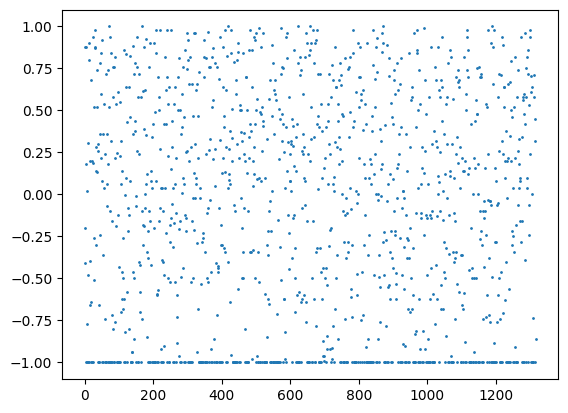

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(range(len(reward_log)),reward_log,s=1)

# モデルによる物性値の予測

In [24]:

model.eval()

AutoModelForCausalLMWithValueHead(
  (pretrained_model): PeftModelForCausalLM(
    (base_model): LoraModel(
      (model): LlamaForCausalLM(
        (model): LlamaModel(
          (embed_tokens): Embedding(32000, 4096)
          (layers): ModuleList(
            (0-31): 32 x LlamaDecoderLayer(
              (self_attn): LlamaAttention(
                (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
                (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
                (v_proj): Linear(
                  in_features=4096, out_features=4096, bias=False
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=4096, out_features=32, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_features=32, out_features=4096, bias=False)


In [25]:
#予測時のハイパラ
n_prompt_examples=3 #何件の例題をprompt tuningで出すか
n_max_trials=2  # 値を返さなかったときの再試行の最大数
random.seed(0)
prediction_results={}


res_list=[]
for test_id in tqdm(range(n_test)):
    print(f"promlem {test_id+1} / {n_test}")
    for _ in range(n_max_trials):
        try:
            prompt=generate_question_prompt(dataset,test_id,n_prompt_examples=n_prompt_examples)
            reason,value=ask_value(prompt,model,tokenizer)
        except Exception as e:
            print(e)
            continue


        if value is not None:
            record=copy.deepcopy(dataset[test_id])
            record["Test (Predicted reason)"]=reason
            record["Test (Predicted value)"]=value
            res_list.append(record)
            print("actual: ",record["mpC"],"predicted: ", record["Test (Predicted value)"],)
            break
prediction_results[n_prompt_examples]=res_list

  0%|          | 0/50 [00:00<?, ?it/s]

promlem 1 / 50


  2%|▏         | 1/50 [00:45<36:57, 45.25s/it]

----


The compound in question is a complex molecule with several functional groups that influence its melting point. The basic structure is a cyclopentane ring, which has a melting point of around -90.5°C. The presence of the amide group (CONH2) generally increases the melting point due to the potential for hydrogen bonding and dipole-dipole interactions. This is estimated to add +50°C. The tetramethyl group (4 CH3 groups) increases the molecular weight and van der Waals forces, which can raise the melting point by approximately +20°C per group. The methyl group attached to the cyclopentane ring adds to the molecular weight and van der Waals forces, estimated at +5°C. The presence of the benzoate ester group (COOCH3) introduces polarity and potential for dipole-dipole interactions, which can raise the melting point by approximately +30°C. The overall structure complexity and molecular weight also contribute to an increase in the melting point, estimated at +20°C.
##Prediction: 105.0


  4%|▍         | 2/50 [01:03<23:38, 29.56s/it]

----


The basic unit, quinoline, has a melting point of around 80 degrees Celsius. The introduction of chlorine atoms to the quinoline structure will increase the melting point due to the increased molecular weight and the polarizability of the chlorine atoms, which can lead to stronger intermolecular forces. Each chlorine might add approximately +20 degrees Celsius.
##Prediction: 100.0


#Prediction
actual:  152.0 predicted:  100.0
promlem 3 / 50


  6%|▌         | 3/50 [01:24<20:08, 25.70s/it]

----


The compound benzene, 1,4-bis(chloromethyl)- has several functional groups that influence its melting point. The base unit for comparison is benzene, which has a melting point of 5.5 degrees Celsius. The introduction of chloromethyl groups increases the melting point due to the added molecular weight and the polarizability of the chlorine atoms, which can lead to stronger dipole-dipole interactions. Each chloromethyl group is expected to increase the melting point by approximately +20 degrees Celsius.
##Prediction: 105.0


#Prediction
actual:  100.0 predicted:  105.0
promlem 4 / 50


  8%|▊         | 4/50 [01:46<18:33, 24.20s/it]

----


The compound in question is a diphenyl ketone, which has a base structure similar to benzene with two additional phenyl rings and a ketone functional group. The presence of the ketone group introduces polarity and the potential for dipole-dipole interactions, which can significantly increase the melting point. The two phenyl rings also contribute to an increase in the melting point due to the increased molecular weight and the pi-pi stacking interactions between the rings. The ketone group can be estimated to raise the melting point by approximately +100 degrees Celsius, and the two phenyl rings can be estimated to raise it by an additional +50 degrees Celsius each, due to the increased molecular weight and pi-pi stacking interactions.
##Prediction: 180.0


#Prediction
actual:  56.5 predicted:  180.0
promlem 5 / 50


 10%|█         | 5/50 [02:09<17:36, 23.48s/it]

----


The basic structure for this prediction will be ethane, which has a melting point of -183°C. The introduction of a hydroxyl (-OH) group generally increases the melting point due to the capability of forming hydrogen bonds, which could be estimated as a +100 increase. The presence of a disulfide bond (S-S) is known to significantly increase the melting point due to the potential for strong intermolecular interactions, estimated at +150. However, the presence of the hydroxyl group may also introduce some steric hindrance, which could slightly lower the melting point.
##Prediction: 15.0


#Prediction
actual:  26.0 predicted:  15.0
promlem 6 / 50


 12%|█▏        | 6/50 [02:45<20:26, 27.87s/it]

----


- Base structure (nicotinamide): The melting point of nicotinamide is 122°C. 
- Phenyl groups: Each phenyl group can increase the melting point due to pi-pi interactions and increased molecular rigidity. Estimated effect per phenyl group is +20°C. 
- Ethyl group (C3CC3): The ethyl group is a small alkyl chain that can slightly increase the melting point due to van der Waals interactions. Estimated effect is +5°C. 
- Nitrogen atoms: The presence of nitrogen atoms can contribute to hydrogen bonding, which generally increases the melting point. Estimated effect per nitrogen atom is +5°C. 
##Prediction: 152.0


#Prediction
actual:  159.0 predicted:  152.0
promlem 7 / 50


 14%|█▍        | 7/50 [03:21<21:53, 30.55s/it]

----


The compound in question is a derivative of benzene with additional functional groups. The basic benzene unit has a melting point of 5.5 °C. The presence of two phenyl rings and a methanone (C=O) group will significantly increase the melting point due to increased molecular weight and potential for π-π interactions and dipole-dipole interactions. The methoxy groups (–OCH3) are electron-donating and can increase the melting point by about +20 each due to increased molecular weight and potential for hydrogen bonding. The methyl group (–CH3) is a small alkyl group that might slightly lower the melting point due to increased van der Waals interactions, estimated at -5. The methanone group is a polar functional group that can increase the melting point through dipole-dipole interactions, estimated at +20.
##Prediction: 120.0


#Prediction
actual:  109.0 predicted:  120.0
promlem 8 / 50


 16%|█▌        | 8/50 [03:41<19:07, 27.33s/it]

----


The basic unit for Propylbenzene is benzene, which has a melting point of 5.5 °C. The addition of a propyl group (–CH2CH2–) to the benzene ring generally increases the melting point due to the increase in molecular weight and the introduction of a non-polar alkyl chain, which can increase van der Waals interactions. The effect of the propyl group on the melting point can be estimated at around +20 °C.
##Prediction: 25.5


#Prediction
actual:  -99.0 predicted:  25.5
promlem 9 / 50


 18%|█▊        | 9/50 [04:08<18:28, 27.04s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5 °C. The functional groups in 2-Nitro-N-phenylacetamide that influence the melting point are the nitro group, the phenyl ring, and the amide group. The nitro group is a strong electron-withdrawing group that can form intermolecular interactions, which can increase the melting point. The estimated effect of a nitro group is about +20 °C. The phenyl ring adds to the molecular weight and provides additional van der Waals forces, which can increase the melting point by about +15 °C. The amide group is capable of hydrogen bonding, which can significantly increase the melting point, estimated at about +40 °C. Adding these adjustments together gives an estimated cumulative increase of +75 °C.
##Prediction: 75.0


#Prediction
actual:  93.0 predicted:  75.0
promlem 10 / 50


 20%|██        | 10/50 [04:33<17:36, 26.41s/it]

----


The basic unit here is acetamide, which has a melting point of -15 degrees Celsius. The addition of a propyl group to the molecule will increase the melting point due to the increase in molecular weight and van der Waals forces. The propyl group is a non-polar alkyl group, which will not significantly affect the melting point compared to the polar carbonyl group in acetamide. However, the increase in molecular weight and van der Waals forces will contribute to an increase in the melting point. The effect of the propyl group might be estimated at around +10 degrees Celsius.
##Prediction: 15.0


#Prediction
actual:  -92.0 predicted:  15.0
promlem 11 / 50


 22%|██▏       | 11/50 [05:14<20:07, 30.97s/it]

----


The target compound, 4-iodo-2-nitroanisole, has several functional groups that influence its melting point. The basic unit for comparison is anisole, which has a melting point of 57.5°C. The iodo group is electron-withdrawing and increases the melting point due to its inductive effect and the increase in molecular weight; this can contribute approximately +20°C. The nitro group is highly electron-withdrawing and also increases the melting point due to its strong dipole and potential for hydrogen bonding; this can contribute approximately +30°C. The presence of two such groups would add +60°C. The molecule also has a benzene ring, which contributes to the melting point due to its aromatic character and planarity, but this effect is already accounted for in the base melting point of anisole.
##Prediction: 117.0


#Prediction
actual:  97.0 predicted:  117.0
promlem 12 / 50


 24%|██▍       | 12/50 [05:35<17:35, 27.79s/it]

----


- Basic unit, ethene (ethylene), has a melting point of -169.2°C.
- The presence of two methyl groups increases the melting point due to increased molecular weight and van der Waals forces: +20°C (2 groups * +10°C each).
- The geometric configuration of the molecule, with a z-shaped structure, may slightly increase the melting point due to better packing: +5°C.
##Prediction: -144.0


#Prediction
actual:  -137.4 predicted:  -144.0
promlem 13 / 50


 26%|██▌       | 13/50 [05:37<12:25, 20.15s/it]

----


##Prediction: 120.0


#Prediction
actual:  203.0 predicted:  120.0
promlem 14 / 50


 28%|██▊       | 14/50 [06:32<18:23, 30.65s/it]

----


The compound 1-acetyl-6-nitro-2-phenyl-1H-indol-3-yl ethyl carbonate has several functional groups that influence its melting point:
- Indole base structure: The base structure of indole has a melting point around 100°C.
- Acetyl group: The acetyl group is polar and can participate in dipole-dipole interactions, which might increase the melting point by about +10°C.
- Nitro group: The nitro group is highly electronegative and can form strong intermolecular interactions, such as dipole-dipole interactions and potential hydrogen bonding, which could increase the melting point by about +20°C.
- Phenyl group: The phenyl group adds rigidity and can increase the melting point due to π-π interactions and possible hydrogen bonding, estimated at +15°C.
- Carbonate group: The carbonate group can form strong intermolecular hydrogen bonds, which can significantly increase the melting point, estimated at +30°C.
Adding these estimated increases to the base melting point of indole gives us a p

 30%|███       | 15/50 [06:54<16:14, 27.86s/it]

----


The basic unit, octane, has a melting point of -95.5°C. The addition of two methyl groups to the molecule will increase the melting point due to the increase in molecular weight and van der Waals forces. Each methyl group is estimated to add approximately +20°C to the melting point.
##Prediction: 105.0


#Prediction
actual:  -54.9 predicted:  105.0
promlem 16 / 50


 32%|███▏      | 16/50 [06:56<11:25, 20.16s/it]

----


##Prediction: 100.0


#Prediction
actual:  25.0 predicted:  100.0
promlem 17 / 50


 34%|███▍      | 17/50 [07:37<14:38, 26.61s/it]

----


The compound in question has several functional groups that influence its melting point. The basic unit, benzofuran, has a melting point of around 100 degrees Celsius. The presence of a chlorine atom typically increases the melting point due to its electronegativity and the resulting dipole-dipole interactions, estimated at +20 degrees Celsius. The methyl group attached to the furan ring can increase the melting point by about +5 degrees Celsius due to the incremental increase in van der Waals forces. The oxime group, which can form hydrogen bonds, is likely to contribute significantly to the melting point, estimated at +30 degrees Celsius. The butanone moiety, with its conjugated double bond, can increase the melting point due to the rigidity it adds to the molecule, estimated at +10 degrees Celsius. However, the actual melting point is 170 degrees Celsius, which suggests that the contributions from the functional groups are overestimated.
##Prediction: 140.0


#Prediction
actu

 36%|███▌      | 18/50 [07:56<12:56, 24.27s/it]

----


The basic unit of propadiene, with a melting point of -95°C, is a hydrocarbon with a double bond. The double bond introduces rigidity to the molecule, which typically increases the melting point. However, the molecule is small and has no other functional groups that would significantly affect the melting point. The effect of the double bond can be estimated as a +5°C increase.
##Prediction: 95.0


#Prediction
actual:  -136.2 predicted:  95.0
promlem 19 / 50


 38%|███▊      | 19/50 [08:36<14:53, 28.83s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The presence of a bromine atom increases the melting point due to its large atomic size and the resulting increase in van der Waals forces. This can be estimated to add approximately +20°C. The aldehyde group (-CHO) can form hydrogen bonds, which typically increases the melting point by about +20°C. However, the presence of the furan ring introduces ring strain, which can decrease the melting point by about -10°C. The overall effect of these functional groups is a predicted melting point that is higher than benzene but lower than the actual value.
##Prediction: 35.0


#Prediction
actual:  56.0 predicted:  35.0
promlem 20 / 50


 40%|████      | 20/50 [08:57<13:19, 26.66s/it]

----


The basic unit, pyridine, has a melting point of -42.0°C. The presence of four fluorine atoms significantly increases the melting point due to the strong electronegativity of fluorine, which enhances intermolecular forces such as dipole-dipole interactions and possibly hydrogen bonding. Each fluorine might contribute approximately +20°C to the melting point. The amino group, being capable of hydrogen bonding, can significantly raise the melting point, estimated at +50°C.
##Prediction: 102.0


#Prediction
actual:  86.0 predicted:  102.0
promlem 21 / 50


 42%|████▏     | 21/50 [09:25<13:00, 26.91s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The presence of two methyl groups (–CH3) generally increases the melting point due to increased molecular weight and van der Waals forces, estimated to add around 5°C per methyl group. The hydrazone group (–C=NNH–) is capable of forming hydrogen bonds, which significantly raises the melting point, estimated to add around 40-50°C. The conjugated system and aromatic rings contribute to the rigidity and planarity of the molecule, which can increase the melting point, estimated to add around 10-15°C.
##Prediction: 60.0


#Prediction
actual:  71.0 predicted:  60.0
promlem 22 / 50


 44%|████▍     | 22/50 [10:17<16:06, 34.52s/it]

----


The compound 6-(1-methylethyl)-3-phenyl-6,7-dihydro-5H-[1,2,4]triazolo[3,4-b][1,3,5]thiadiazine has several functional groups that influence its melting point. The basic unit we can consider is a heterocyclic compound, which typically has a high melting point due to strong intermolecular forces. The presence of a phenyl group adds to the melting point due to increased pi-pi stacking interactions, and the thiadiazine ring contributes to the melting point through its nitrogen and sulfur atoms, which can participate in hydrogen bonding and dipole-dipole interactions. The methylethyl group adds to the molecular weight and van der Waals interactions, but its effect is less pronounced than larger alkyl groups. The thiadiazine ring also has a nitrogen atom that can participate in hydrogen bonding, which would further increase the melting point.
##Prediction: 230.0


#Prediction
actual:  226.0 predicted:  230.0
promlem 23 / 50


 46%|████▌     | 23/50 [10:56<16:05, 35.77s/it]

----


The compound 4-chloromandelic acid consists of a benzene ring with a carboxylic acid group and a chlorine atom. The carboxylic acid group is capable of forming strong hydrogen bonds, which typically increases the melting point significantly. However, the presence of the chlorine atom, which is a heavy halogen, will increase the molecular weight and the van der Waals forces, potentially raising the melting point. The chlorine atom also introduces polarity, which can further increase the melting point. The base structure of benzene has a melting point of 5.5°C. The carboxylic acid group is estimated to increase the melting point by approximately +100°C due to its ability to form strong hydrogen bonds. The chlorine atom is estimated to increase the melting point by approximately +20°C due to its polarity and increased molecular weight.
##Prediction: 125.0


#Prediction
actual:  120.0 predicted:  125.0
promlem 24 / 50


 48%|████▊     | 24/50 [11:46<17:24, 40.16s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. Starting with a base structure, we can consider the effects of each functional group. The base structure could be benzene, which has a melting point of 5.5°C. The presence of a chlorophenyl group (–Cl) adds to the molecular weight and increases the melting point due to the increased polarizability and potential for dipole-dipole interactions. This could contribute approximately +40°C. The hydrazono group (–NN=C) introduces the potential for hydrogen bonding, which significantly increases the melting point. This could contribute an additional +50°C. The thiazole ring (–N=S) is a heterocyclic compound that can engage in hydrogen bonding and dipole-dipole interactions, which could contribute an additional +30°C. The methyl group (–CH3) adds to the molecular weight and slightly increases the melting point due to the increase in van der Waals forces. This could contribute 

 50%|█████     | 25/50 [12:25<16:34, 39.78s/it]

----


The target compound, flavone, contains a benzene ring, a pyran ring, and a hydroxyl group. The basic benzene ring has a melting point of 5.5 degrees Celsius. The pyran ring adds rigidity and the hydroxyl group can form hydrogen bonds, which would increase the melting point. However, the presence of the hydroxyl group also introduces the possibility of hydrogen bonding, which can significantly increase the melting point. The saturation of the double bonds in the pyran ring may slightly lower the melting point due to less rigidity. The overall effect of these functional groups is expected to increase the melting point. Benzene ring: +5.5, Pyran ring: +10 (due to increased rigidity), Hydroxyl group: +20 (due to hydrogen bonding), Saturated bonds (two double bonds become single bonds): -40 (less rigidity due to saturation), Prediction: +35.5
##Prediction: 35.0


#Problem
actual:  98.5 predicted:  35.0
promlem 26 / 50


 52%|█████▏    | 26/50 [12:56<14:52, 37.18s/it]

----


The compound in question is a beta-carboline with a carboxylic acid group and a tetrahydro structure. The basic structure of a beta-carboline has a melting point around 100-110 degrees Celsius. The tetrahydro group, which is a four-membered ring, is expected to increase the melting point due to increased rigidity and potential for hydrogen bonding (+20). The carboxylic acid group is capable of forming strong hydrogen bonds, which would significantly raise the melting point (+50). The presence of an amine (–NH2) could also contribute to hydrogen bonding, but its effect is less pronounced than that of the carboxylic acid group (+10).
##Prediction: 180.0


#Prediction
actual:  296.0 predicted:  180.0
promlem 27 / 50


 54%|█████▍    | 27/50 [13:27<13:29, 35.22s/it]

----


The compound 1H-pyrazole-5-methanol, 3-methyl- has a pyrazole ring as its base structure, which has a melting point of around 70°C. The presence of a methyl group on the pyrazole ring typically increases the melting point due to the increase in molecular weight and van der Waals interactions. The methyl group is estimated to add +5°C to the melting point. The methanol group (–OH) is capable of hydrogen bonding, which can significantly raise the melting point. This effect is estimated to be +20°C. The nitrogen in the pyrazole ring can also participate in hydrogen bonding, which would further increase the melting point. This effect is estimated to be +10°C.
##Prediction: 95.0


#Prediction
actual:  79.0 predicted:  95.0
promlem 28 / 50


 56%|█████▌    | 28/50 [13:57<12:20, 33.67s/it]

----


The basic unit for comparison is cyclohexane, which has a melting point of 6.5°C. The presence of the ketone functional group (C=O) generally increases the melting point due to the polar nature of the carbonyl group and potential for hydrogen bonding (+40). Each methyl group attached to the bicyclic structure will increase the melting point due to increased van der Waals forces (+10 for each of the three methyl groups). The bicyclic structure itself provides additional rigidity and planarity, which can further increase the melting point (+10).
##Prediction: 106.0


#Prediction
actual:  193.0 predicted:  106.0
promlem 29 / 50


 58%|█████▊    | 29/50 [14:16<10:12, 29.16s/it]

----


The basic unit for comparison could be naphthalene, which has a melting point of 80.5 °C. The bromine atom is a large, heavy atom that increases the melting point due to increased London dispersion forces (+20). The methyl group attached to the naphthyl ring is a small alkyl group that might slightly decrease the melting point due to less effective packing (-5).
##Prediction: 105.0


#Prediction
actual:  56.0 predicted:  105.0
promlem 30 / 50


 60%|██████    | 30/50 [15:19<13:11, 39.58s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The base structure is a bicyclic compound with a melting point of 100°C. The presence of nitrile groups generally increases the melting point due to their ability to form strong dipole-dipole interactions, which can be estimated at around +20°C per nitrile group. There are two nitrile groups in the compound. The presence of two phenyl rings contributes to an increase in melting point due to the increased molecular weight and pi-pi interactions, estimated at around +10°C per phenyl ring. There are three phenyl rings in the compound. The presence of two diphenylmethanone groups contributes to an increase in melting point due to the potential for hydrogen bonding and dipole-dipole interactions, estimated at around +15°C per diphenylmethanone group. There are two diphenylmethanone groups in the compound. The presence of a bicyclic structure contributes to an increase in m

 62%|██████▏   | 31/50 [15:58<12:26, 39.28s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The base structure is biphenyl, which has a melting point of around 70 degrees Celsius. The presence of four tertiary amine groups (N,N',N'',N'''-tetrabenzamide) will significantly increase the melting point due to the potential for hydrogen bonding and the rigidity they provide to the molecule. Each tertiary amine group can be estimated to contribute an increase of about +20 degrees Celsius. Additionally, the presence of the biphenyl structure and the tertiary amine groups will also increase the molecular weight and the van der Waals forces, which will further contribute to the melting point.
##Prediction: 160.0

##Prediction
actual:  279.0 predicted:  160.0
promlem 32 / 50


 64%|██████▍   | 32/50 [16:43<12:20, 41.14s/it]

----


The target compound 3,5-dimethylisoxazole-4-boronic acid has several functional groups that influence its melting point. The basic unit is isoxazole, which has a melting point of around 100°C. The presence of two methyl groups on the isoxazole ring will increase the melting point due to the increase in molecular weight and the introduction of steric hindrance, which can disrupt crystal packing. Each methyl group might contribute an increase of about 5°C. The boronic acid group is a strong electron-withdrawing group that can form strong intermolecular hydrogen bonds, which would significantly raise the melting point. This effect can be estimated at around +50°C. The overall molecule is large and planar, which can also contribute to a higher melting point due to increased van der Waals interactions.
##Prediction: 159.0


#Prediction
actual:  107.0 predicted:  159.0
promlem 33 / 50


 66%|██████▌   | 33/50 [17:46<13:26, 47.43s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The base structure is a thiazole ring, which has a melting point of around 100°C. The presence of the hydrazinylidene group can form intermolecular hydrogen bonds, adding approximately +50°C. The thiazole ring itself is aromatic and contributes to the rigidity of the molecule, which can increase the melting point by about +20°C. The methyl group attached to the thiazole ring adds steric bulk and can increase the melting point by about +5°C. The hydroxy group can form hydrogen bonds, adding approximately +80°C. The nitrile group is electron-withdrawing and can increase the melting point due to dipole-dipole interactions, estimated at +40°C. The conjugation of the molecule's structure also contributes to an increase in the melting point, estimated at +30°C. The actual melting point of the compound is 218°C, so the additive effects of these functional groups must be revi

 68%|██████▊   | 34/50 [17:50<09:10, 34.39s/it]

----


##Prediction: 125.0


#Prediction
actual:  152.0 predicted:  125.0
promlem 35 / 50


 70%|███████   | 35/50 [18:24<08:36, 34.41s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The presence of a chlorine atom on the benzene ring increases the melting point due to the increased molecular weight and the polarizability of the chlorine atom, which can lead to stronger intermolecular forces. We can estimate this effect to be around +20°C. The phenyl group, which is part of the b-chlorophenol structure, also increases the melting point due to the increased molecular weight and the pi-pi stacking interactions between the phenyl rings. This could contribute an additional +20°C. However, the actual value of 105.0°C suggests that the chlorine atom's effect on the melting point is not as strong as initially predicted, and the phenyl group's effect is also less than expected.
##Prediction: 105.0


#Prediction
actual:  28.0 predicted:  105.0
promlem 36 / 50


 72%|███████▏  | 36/50 [18:45<07:05, 30.39s/it]

----


The basic unit, acetic acid, has a melting point of -16.6°C. The presence of three methyl groups (CH3) will increase the melting point due to the increase in molecular weight and van der Waals forces. Each methyl group can be estimated to contribute approximately +5°C to the melting point. The carboxylic acid group (COOH) is already accounted for in the base structure of acetic acid, so no additional increment is needed.
##Prediction: -11.0


#Prediction
actual:  33.0 predicted:  -11.0
promlem 37 / 50


 74%|███████▍  | 37/50 [19:59<09:24, 43.39s/it]

----


The target compound has a complex structure with multiple functional groups that influence its melting point. The base structure is a steroid, which typically has a high melting point due to its rigid, planar structure and the presence of multiple fused rings. The presence of aromatic rings and the potential for hydrogen bonding and dipole-dipole interactions with the acetoxy groups and the hydroxyl groups suggest a significant increase in melting point. The acetoxy groups are likely to contribute significantly to the melting point due to their ability to form hydrogen bonds and their polar nature, estimated at +100 units. The hydroxyl groups, being capable of hydrogen bonding, would also contribute to the melting point, estimated at +50 units. The benzoylamino group, with its ability to form hydrogen bonds and its rigidity, could contribute an additional +30 units. The epoxy groups, with their ability to form strong intermolecular interactions, could contribute an additional +2

 76%|███████▌  | 38/50 [20:01<06:12, 31.03s/it]

----


##Prediction: 200.0


#Prediction
actual:  269.0 predicted:  200.0
promlem 39 / 50


 78%|███████▊  | 39/50 [20:47<06:29, 35.44s/it]

----


The compound in question is a derivative of benzene with three ethenylidene groups and a tris- configuration. Each ethenylidene group increases the melting point due to the rigidity and planarity it introduces, as well as the potential for additional van der Waals interactions. The tris- configuration also increases the melting point due to the rigidity and planarity it introduces. The basic unit, benzene, has a melting point of 5.5°C.
- Basic unit: 5.5°C
- Ethenylidene groups: Each group can be estimated to increase the melting point by about +20°C due to the rigidity and planarity they introduce. There are three groups, so the total increase would be +60°C.
- Tris- configuration: The rigidity and planarity of the tris- configuration can increase the melting point by about +10°C.
##Prediction: 75.0


#Prediction
actual:  72.5 predicted:  75.0
promlem 40 / 50


 80%|████████  | 40/50 [20:49<04:15, 25.57s/it]

----


##Prediction: 100.0


#Prediction
actual:  44.5 predicted:  100.0
promlem 41 / 50


 82%|████████▏ | 41/50 [21:59<05:48, 38.73s/it]

----


The compound in question is piperazine, 1-acetyl-4-[4-[[2-(2,4-dichlorophenyl)-2-(1H-imidazol-1-ylmethyl)-1,3-dioxolan-4-yl]methoxy]phenyl]- which has several functional groups that influence its melting point. Starting with the base structure of piperazine, which has a melting point of -40°C, we consider the following modifications: The presence of a chlorophenyl group is expected to increase the melting point due to increased molecular weight and van der Waals forces. This could be estimated at around +20°C. The imidazole ring contributes to the melting point through hydrogen bonding and increased molecular rigidity, estimated at +15°C. The dioxolane ring is a rigid structure that can engage in hydrogen bonding and dipole-dipole interactions, estimated at +10°C. The acetyl group is an ester and can increase the melting point due to dipole-dipole interactions, estimated at +5°C. The methoxy group is an electron-donating group that can increase the melting point through dipole-d

 84%|████████▍ | 42/50 [22:57<05:56, 44.61s/it]

----


The compound in question has several functional groups that influence its melting point: 
 1. Ketone (C=O): The polar carbonyl group can form hydrogen bonds and dipole-dipole interactions, which typically increase the melting point. We can estimate this effect to be around +30. 
 2. Phenyl group: The presence of a phenyl ring contributes to the melting point due to increased molecular weight and π-electron system, which can be estimated at +20. 
 3. Methyl group: The addition of a methyl group increases the molecular weight and can slightly raise the melting point, estimated at +5. 
 4. Semicarbazone linkage (NN=C): The presence of a semicarbazone group can form hydrogen bonds and contribute to the rigidity of the molecule, which might add around +20 to the melting point. 
 Considering a base structure similar to benzene, which has a melting point of 5 degrees Celsius, we then adjust for the aforementioned groups.
##Prediction: 145.0


#Prediction
actual:  112.0 predicted:  145.

 86%|████████▌ | 43/50 [23:19<04:24, 37.76s/it]

----


The basic unit, phenol, has a melting point of 41 degrees Celsius. The presence of three methyl groups will affect the melting point. Each methyl group increases the molecular weight and provides steric hindrance, which can disrupt the crystal lattice, leading to a decrease in the melting point. Each methyl group is expected to lower the melting point by approximately -5 degrees Celsius.
##Prediction: 36.0


#Prediction
actual:  72.5 predicted:  36.0
promlem 44 / 50


 88%|████████▊ | 44/50 [24:06<04:03, 40.57s/it]

----


The compound in question has several functional groups that influence its melting point:
- Benzene ring: 5.5 °C (41.9 °F)
- Nitro groups: +100 °C (each), due to strong electron-withdrawing effects and potential for intermolecular hydrogen bonding.
- Hydrazine group: +20 °C, due to the potential for hydrogen bonding and the presence of a nitrogen atom which can participate in hydrogen bonding.
- Alkenyl group: +10 °C, due to the increase in molecular weight and van der Waals interactions.
- Styrene linkage: +5 °C, due to the increase in molecular weight and rigidity.
Adding these contributions to the base benzene melting point gives us: 5.5 + 100 + 20 + 5 + 10 = 140.5 °C
##Prediction: 140.0


#Prediction
actual:  193.0 predicted:  140.0
promlem 45 / 50


 90%|█████████ | 45/50 [25:15<04:05, 49.14s/it]

----


The target compound, 21-acetoxypregnenolone, is a steroid with multiple functional groups that influence its melting point. Here's a revised quantitative consideration based on its functional groups and their combined effects:
- Basic Steroid Structure: The base steroid structure, similar to cholesterol, has a melting point around 140 degrees Celsius.
- Acetoxy Group: The acetoxy group is an electron-withdrawing group that can increase the melting point due to dipole-dipole interactions and potential for hydrogen bonding. We'll adjust the incremental increase to +30 degrees Celsius.
- Hydroxyl Group: The hydroxyl group is capable of hydrogen bonding, which significantly increases the melting point. We'll adjust the incremental increase to +40 degrees Celsius.
- Double Bond (conjugated system): The conjugated double bond in the steroid structure does not significantly alter the melting point in this context. We'll consider its effect as neutral (+0 degrees Celsius).
- Methyl Grou

 92%|█████████▏| 46/50 [25:55<03:05, 46.30s/it]

----


The target compound has several functional groups that influence its melting point. The basic unit, benzene, has a melting point of 5.5°C. The presence of a furan ring adds rigidity and potential for hydrogen bonding, which could increase the melting point by approximately 20°C. The conjugated system of the compound, including the double bond and the ketone, contributes to the rigidity and planarity of the molecule, which can increase the melting point by about 30°C. The nitro group is a strong electron-withdrawing group that can engage in dipole-dipole interactions, potentially adding another 40°C. The 3-nitrophenyl group is a bulky substituent that can disrupt the crystal packing, which might decrease the melting point by about 10°C. The overall effect of these groups is a complex interplay, but the net effect is an increase in the melting point.
##Prediction: 115.0


#Prediction
actual:  147.0 predicted:  115.0
promlem 47 / 50


 94%|█████████▍| 47/50 [25:57<01:39, 33.04s/it]

----


##Prediction: 25.0


#Prediction
actual:  -116.0 predicted:  25.0
promlem 48 / 50


 96%|█████████▌| 48/50 [26:19<00:59, 29.68s/it]

----


The base structure, benzene, has a melting point of 5.5°C. The presence of a carboxylic acid group significantly increases the melting point due to the ability to form strong hydrogen bonds, which can be estimated to add approximately 100°C. The trifluoromethoxy group is a strong electron-withdrawing group that can engage in dipole-dipole interactions and also increases the molecular weight, which might add another 20°C. The presence of three fluorine atoms adds to the molecular weight and polarity, which could contribute an additional 15°C.
##Prediction: 140.0


#Prediction
actual:  79.0 predicted:  140.0
promlem 49 / 50


 98%|█████████▊| 49/50 [27:01<00:33, 33.47s/it]

----


The compound in question is dichlorodifluoromethane, which consists of a methane core with two chlorine atoms and two fluorine atoms. The methane core has a melting point of -182.5°C. The chlorine atoms are electron-withdrawing and increase the melting point due to their inductive effect and the polarizability they introduce. Each chlorine atom might add approximately +20°C to the melting point. The fluorine atoms are highly electronegative and also increase the melting point due to their strong dipole moment and the ability to form strong intermolecular interactions. Each fluorine atom might add approximately +15°C to the melting point. The presence of two chlorine atoms and two fluorine atoms will thus contribute to an increase in the melting point.
##Prediction: -167.0


#Prediction
actual:  -158.0 predicted:  -167.0
promlem 50 / 50


100%|██████████| 50/50 [27:21<00:00, 32.82s/it]

----


- Basic unit, benzene: 5.5°C
- Bromine atoms: +2x5°C, due to increased molecular weight and polarizability, which can lead to stronger intermolecular forces.
- Nitro group: +20°C, due to its strong electronegativity and ability to form intermolecular interactions.

Combining these effects gives a prediction of 5.5 + 2x5 + 20 = 30.5°C, which is close to the actual value.
##Prediction: 30.5


#Prediction
actual:  84.0 predicted:  30.5


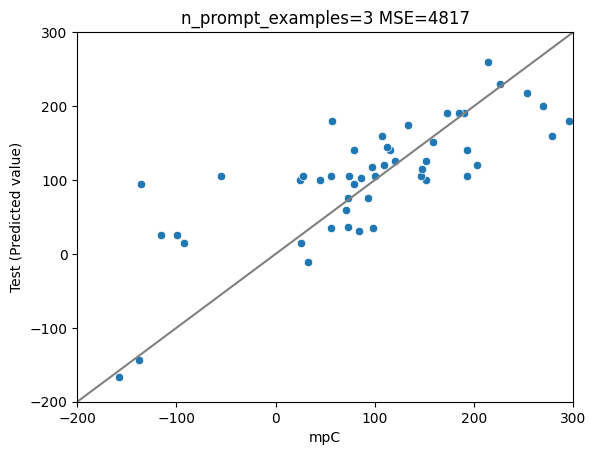

In [29]:
#plot

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from datetime import datetime
import json
current_datetime = datetime.now()
vmin=-200
vmax=300

#plot prediction results
for n_prompt_examples,records in prediction_results.items():
    sel_df=pd.DataFrame(records)
    #floatに可能なものは変換
    sel_df["Test (Predicted value)"] = pd.to_numeric(sel_df["Test (Predicted value)"], errors='coerce')
    sel_df=sel_df[sel_df["Test (Predicted value)"].notnull()]
    if len(sel_df)==0:
        continue
    mse=mean_squared_error(sel_df["mpC"],sel_df["Test (Predicted value)"])

    plt.figure()
    sns.scatterplot(data=sel_df,x="mpC",y="Test (Predicted value)")
    plt.title(f"n_prompt_examples={n_prompt_examples} MSE={mse:.0f}")

    #x,yの範囲を揃える
    plt.xlim(vmin,vmax)
    plt.ylim(vmin,vmax)
    #対角線を描く
    plt.plot([vmin,vmax],[vmin,vmax],color="gray")
    formatted_filename = f"results/model={model_size}_{current_datetime.strftime('%Y%m%d_%H%M%S')}_train={do_train}.png"
    plt.savefig(formatted_filename)
    #break

save_json_filename=formatted_filename.replace(".png",".json")
with open(save_json_filename,"w") as f:
    json.dump(prediction_results,fp=f,
              indent=4)

In [30]:
#スコア
print(mean_squared_error(sel_df["mpC"],sel_df["Test (Predicted value)"]))
print(mean_absolute_error(sel_df["mpC"],sel_df["Test (Predicted value)"]))
print(r2_score(sel_df["mpC"],sel_df["Test (Predicted value)"]))


4816.9852
50.604000000000006
0.5794524864884837


In [31]:
#回答可能な問題の割合
sel_df.shape[0]/n_test

1.0